In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize

In [3]:
# Function to read images and resize them
def read_image(file_path):
    img = resize(imread(file_path), (64, 64))
    return(img)

In [4]:
# Get labels
BASEPATH = 'LFW/01_GroundTruth'
files_names = sorted(os.listdir(BASEPATH))
LABELS = np.array([read_image(os.path.join(BASEPATH, el_file)).round() for el_file in files_names]).astype('float32')
print(LABELS.shape)
print(LABELS.min())
print(LABELS.max())

(2322, 64, 64, 3)
0.0
1.0


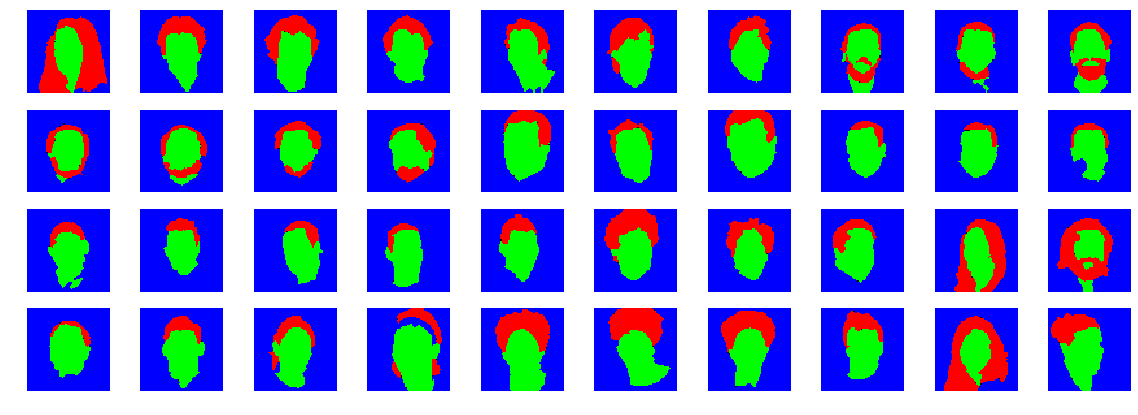

In [5]:
# Show a few examples
plt.figure(figsize=(20, 7))
for it_k in range(40):
    plt.subplot(4, 10, it_k+1)
    plt.imshow(LABELS[it_k])
    plt.axis('off')
plt.show()

In [6]:
# Get images
BASEPATH = 'LFW/02_Faces'
files_names = sorted(os.listdir(BASEPATH))
FACES = np.array([read_image(os.path.join(BASEPATH, el_file)) for el_file in files_names]).astype('float32')
print(FACES.shape)
print(FACES.min())
print(FACES.max())

(2322, 64, 64, 3)
0.0
0.99215686


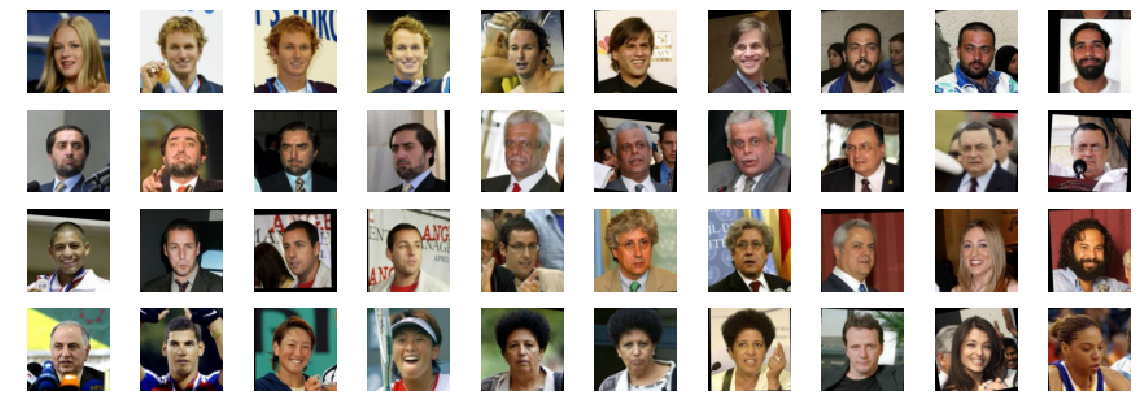

In [7]:
# Show a few examples
plt.figure(figsize=(20, 7))
for it_k in range(40):
    plt.subplot(4, 10, it_k+1)
    plt.imshow(FACES[it_k])
    plt.axis('off')
plt.show()

In [8]:
# Split into training and test
from sklearn.model_selection import train_test_split
IDX = np.arange(len(LABELS))
IDX_train, IDX_test = train_test_split(IDX, test_size=0.2, random_state=42)
LABELS_train = LABELS[IDX_train]
LABELS_test = LABELS[IDX_test]
FACES_train = FACES[IDX_train]
FACES_test = FACES[IDX_test]
print(LABELS_train.shape)
print(LABELS_test.shape)
print(FACES_train.shape)
print(FACES_test.shape)

(1857, 64, 64, 3)
(465, 64, 64, 3)
(1857, 64, 64, 3)
(465, 64, 64, 3)


In [9]:
import keras
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Dense, UpSampling2D
from keras.layers import BatchNormalization, Dropout, Flatten, Reshape

Using TensorFlow backend.


In [9]:
# Create NN - original
i = Input(FACES_train.shape[1:])
h = BatchNormalization()(i)

h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)
h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)
h = MaxPooling2D((2, 2))(h)

h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)
h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)
h = MaxPooling2D((2, 2))(h)
h = Dropout(0.2)(h)

h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)
h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)
h = MaxPooling2D((2, 2))(h)

h = Flatten()(h)
latent = Dense(128, activation='relu')(h)
h = Dense(512, activation='relu')(latent)
h = Reshape((8, 8, 8))(h)

h = UpSampling2D((2, 2))(h)
h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)
h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)

h = Dropout(0.2)(h)
h = UpSampling2D((2, 2))(h)
h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)
h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)

h = UpSampling2D((2, 2))(h)
h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)
h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)

h = BatchNormalization()(h)
o = Conv2D(3, (3, 3), padding='same', activation='sigmoid')(h)

model = Model(inputs=i, outputs=o)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 3)         12        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 8)         224       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 8)         584       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 8)         584       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 8)         584       
__________

In [18]:
# Optimization parameters
model.compile(loss='mse', optimizer='adam')

In [23]:
# Training
batchSize = 512
numEpochs = 2
model.fit(FACES_train, LABELS_train, batch_size=batchSize, epochs=numEpochs, verbose=1, validation_split=0.2)

Train on 1485 samples, validate on 372 samples
Epoch 1/2
1485/1485 [==============================] - 51s 34ms/step - loss: 0.1644 - val_loss: 0.1406
Epoch 2/2
1485/1485 [==============================] - 55s 37ms/step - loss: 0.1525 - val_loss: 0.1219


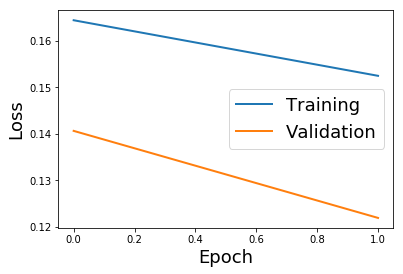

In [24]:
# Plot loss

plt.plot(model.history.history['loss'], label='Training', linewidth=2)
plt.plot(model.history.history['val_loss'], label='Validation', linewidth=2)
plt.legend(fontsize=18)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.show()



In [25]:
# Predict and evaluate for test set
FACES_test_pred = model.predict(FACES_test)
test_err = model.evaluate(x=FACES_test, y=LABELS_test)
print(test_err)

465/465 [==============================] - 6s 13ms/step
0.12271339521613173


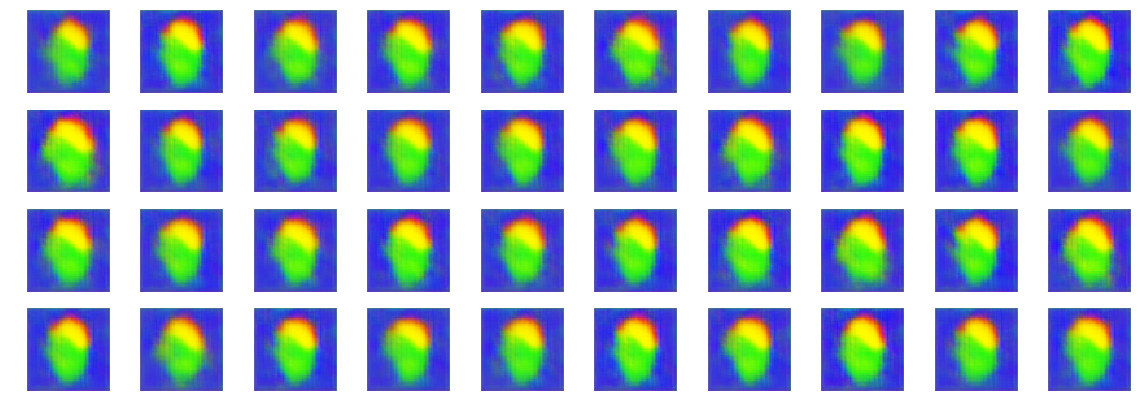

In [26]:
# Show a few examples
plt.figure(figsize=(20, 7))
for it_k in range(40):
    plt.subplot(4, 10, it_k+1)
    plt.imshow(FACES_test_pred[it_k])
    plt.axis('off')
plt.show()

In [27]:
# Create NN - shuffle
i = Input(FACES_train.shape[1:])
h = BatchNormalization()(i)

h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)
h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)
h = MaxPooling2D((2, 2))(h)

h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)
h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)
h = MaxPooling2D((2, 2))(h)
h = Dropout(0.2)(h)

h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)
h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)
h = MaxPooling2D((2, 2))(h)

h = Flatten()(h)
latent = Dense(128, activation='relu')(h)
h = Dense(512, activation='relu')(latent)
h = Reshape((8, 8, 8))(h)

h = UpSampling2D((2, 2))(h)
h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)
h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)

h = Dropout(0.2)(h)
h = UpSampling2D((2, 2))(h)
h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)
h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)

h = UpSampling2D((2, 2))(h)
h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)
h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)

h = BatchNormalization()(h)
o = Conv2D(3, (3, 3), padding='same', activation='sigmoid')(h)

model = Model(inputs=i, outputs=o)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 64, 64, 3)         12        
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 64, 64, 8)         224       
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 64, 64, 8)         584       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 32, 32, 8)         584       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 32, 32, 8)         584       
__________

In [28]:
# Optimization parameters
model.compile(loss='mse', optimizer='adam',metrics=['accuracy'])

In [29]:
# Training
batchSize = 512
numEpochs = 2
model.fit(FACES_train, LABELS_train, batch_size=batchSize, epochs=numEpochs, verbose=1, validation_split=0.2, shuffle=True)

Train on 1485 samples, validate on 372 samples
Epoch 1/2
1485/1485 [==============================] - 55s 37ms/step - loss: 0.2586 - acc: 0.4455 - val_loss: 0.2284 - val_acc: 0.5226
Epoch 2/2
1485/1485 [==============================] - 51s 34ms/step - loss: 0.2232 - acc: 0.5888 - val_loss: 0.1963 - val_acc: 0.6553


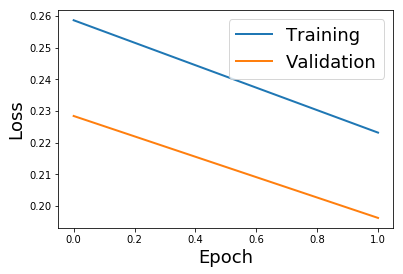

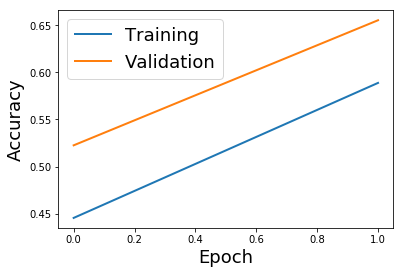

In [30]:
# Plot loss

plt.plot(model.history.history['loss'], label='Training', linewidth=2)
plt.plot(model.history.history['val_loss'], label='Validation', linewidth=2)
plt.legend(fontsize=18)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.show()


plt.plot(model.history.history['acc'], label='Training', linewidth=2)
plt.plot(model.history.history['val_acc'], label='Validation', linewidth=2)
plt.legend(fontsize=18)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Accuracy', fontsize=18)
plt.show()

In [31]:
# Predict and evaluate for test set
FACES_test_pred = model.predict(FACES_test)
test_err = model.evaluate(x=FACES_test, y=LABELS_test)
print(test_err)

465/465 [==============================] - 7s 15ms/step
[0.1953502893127421, 0.6584236397538134]


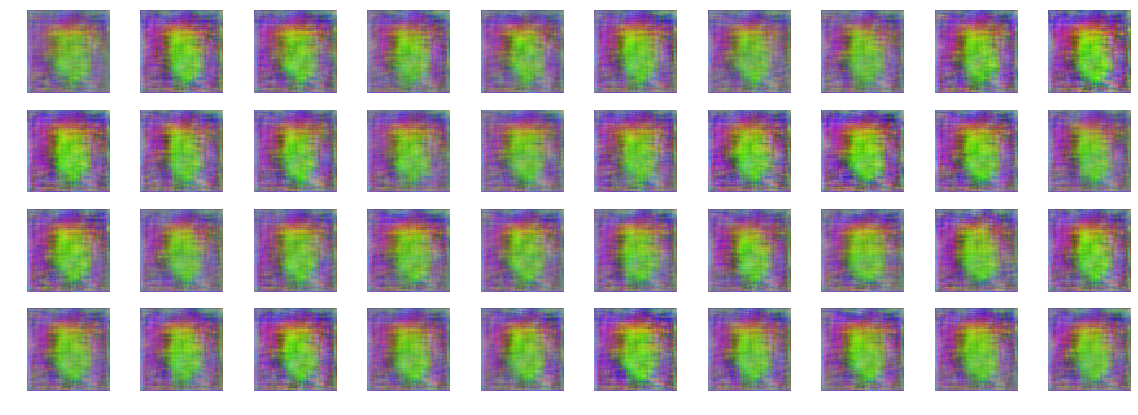

In [32]:
# Show a few examples
plt.figure(figsize=(20, 7))
for it_k in range(40):
    plt.subplot(4, 10, it_k+1)
    plt.imshow(FACES_test_pred[it_k])
    plt.axis('off')
plt.show()

In [33]:
# Create NN - 1.1
i = Input(FACES_train.shape[1:])
h = BatchNormalization()(i)

h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)
h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)
h = MaxPooling2D((2, 2))(h)

h = Conv2D(16, (3, 3), padding='same', activation='elu')(h)
h = Conv2D(16, (3, 3), padding='same', activation='elu')(h)
h = MaxPooling2D((2, 2))(h)
h = Dropout(0.2)(h)

h = Conv2D(32, (3, 3), padding='same', activation='elu')(h)
h = Conv2D(32, (3, 3), padding='same', activation='elu')(h)
h = MaxPooling2D((2, 2))(h)

h = Flatten()(h)
latent = Dense(128, activation='relu')(h)
h = Dense(512, activation='relu')(latent)
h = Reshape((8, 8, 8))(h)

h = UpSampling2D((2, 2))(h)
h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)
h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)

h = Dropout(0.2)(h)
h = UpSampling2D((2, 2))(h)
h = Conv2D(16, (3, 3), padding='same', activation='elu')(h)
h = Conv2D(16, (3, 3), padding='same', activation='elu')(h)

h = UpSampling2D((2, 2))(h)
h = Conv2D(32, (3, 3), padding='same', activation='elu')(h)
h = Conv2D(32, (3, 3), padding='same', activation='elu')(h)

h = BatchNormalization()(h)
o = Conv2D(3, (3, 3), padding='same', activation='sigmoid')(h)

model = Model(inputs=i, outputs=o)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 64, 64, 3)         12        
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 64, 64, 8)         224       
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 64, 64, 8)         584       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 32, 32, 16)        1168      
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 32, 32, 16)        2320      
__________

In [34]:
# Optimization parameters
model.compile(loss='mse', optimizer='adam')

In [35]:
# Training
batchSize = 512
numEpochs = 2
model.fit(FACES_train, LABELS_train, batch_size=batchSize, epochs=numEpochs, verbose=1, validation_split=0.2, shuffle=True)

Train on 1485 samples, validate on 372 samples
Epoch 1/2
1485/1485 [==============================] - 3830s 3s/step - loss: 0.2676 - val_loss: 0.2549
Epoch 2/2
1485/1485 [==============================] - 2604s 2s/step - loss: 0.1778 - val_loss: 0.1716


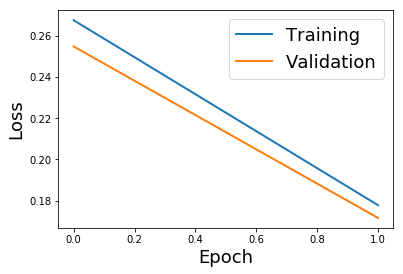

In [39]:
# Plot loss

plt.plot(model.history.history['loss'], label='Training', linewidth=2)
plt.plot(model.history.history['val_loss'], label='Validation', linewidth=2)
plt.legend(fontsize=18)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.show()


In [40]:
# Predict and evaluate for test set
FACES_test_pred = model.predict(FACES_test)
test_err = model.evaluate(x=FACES_test, y=LABELS_test)
print(test_err)

465/465 [==============================] - 13s 28ms/step
0.1704748212650258


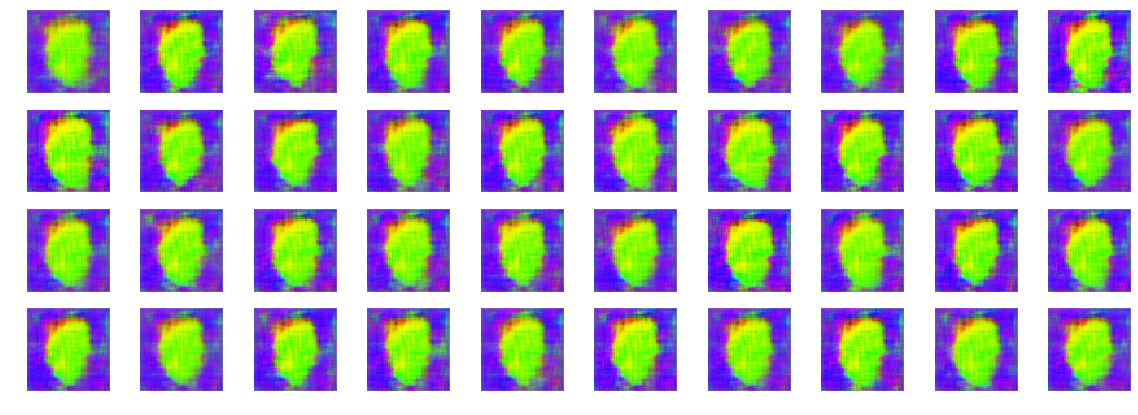

In [41]:
# Show a few examples
plt.figure(figsize=(20, 7))
for it_k in range(40):
    plt.subplot(4, 10, it_k+1)
    plt.imshow(FACES_test_pred[it_k])
    plt.axis('off')
plt.show()

In [30]:
# Create NN - 1.1 - 2.2
i = Input(FACES_train.shape[1:])
h = BatchNormalization()(i)

h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)
h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)
h = MaxPooling2D((2, 2))(h)

h = Conv2D(16, (3, 3), padding='same', activation='elu')(h)
h = Conv2D(16, (3, 3), padding='same', activation='elu')(h)
h = MaxPooling2D((2, 2))(h)
h = Dropout(0.2)(h)

h = Conv2D(32, (3, 3), padding='same', activation='elu')(h)
h = Conv2D(32, (3, 3), padding='same', activation='elu')(h)
h = MaxPooling2D((2, 2))(h)

h = Flatten()(h)
latent = Dense(128, activation='relu')(h)
h = Dense(512, activation='relu')(latent)
h = Reshape((8, 8, 8))(h)

h = UpSampling2D((2, 2))(h)
h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)
h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)

h = Dropout(0.2)(h)
h = UpSampling2D((2, 2))(h)
h = Conv2D(16, (3, 3), padding='same', activation='elu')(h)
h = Conv2D(16, (3, 3), padding='same', activation='elu')(h)

h = UpSampling2D((2, 2))(h)
h = Conv2D(32, (3, 3), padding='same', activation='elu')(h)
h = Conv2D(32, (3, 3), padding='same', activation='elu')(h)

h = BatchNormalization()(h)
o = Conv2D(3, (3, 3), padding='same', activation='sigmoid')(h)

model = Model(inputs=i, outputs=o)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 64, 64, 3)         12        
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 64, 64, 8)         224       
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 64, 64, 8)         584       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 32, 32, 16)        1168      
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 32, 32, 16)        2320      
__________

In [31]:
# Optimization parameters
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

In [32]:
# Training
#batchSize = 240
#numEpochs = 15

batchSize = 320
numEpochs = 15

model.fit(FACES_train, LABELS_train, batch_size=batchSize, epochs=numEpochs, verbose=1, validation_split=0.2, shuffle=True)

Train on 1485 samples, validate on 372 samples
Epoch 1/15
1485/1485 [==============================] - 284s 191ms/step - loss: 0.2396 - acc: 0.5355 - val_loss: 0.2007 - val_acc: 0.6952
Epoch 2/15
1485/1485 [==============================] - 179s 120ms/step - loss: 0.1648 - acc: 0.7817 - val_loss: 0.1465 - val_acc: 0.8304
Epoch 3/15
1485/1485 [==============================] - 150s 101ms/step - loss: 0.1391 - acc: 0.8404 - val_loss: 0.1268 - val_acc: 0.8636
Epoch 4/15
1485/1485 [==============================] - 136s 91ms/step - loss: 0.1253 - acc: 0.8545 - val_loss: 0.1171 - val_acc: 0.8724
Epoch 5/15
1485/1485 [==============================] - 134s 90ms/step - loss: 0.1144 - acc: 0.8591 - val_loss: 0.1079 - val_acc: 0.8660
Epoch 6/15
1485/1485 [==============================] - 138s 93ms/step - loss: 0.1044 - acc: 0.8566 - val_loss: 0.0940 - val_acc: 0.8638
Epoch 7/15
1485/1485 [==============================] - 131s 88ms/step - loss: 0.0944 - acc: 0.8612 - val_loss: 0.0809 - val_acc

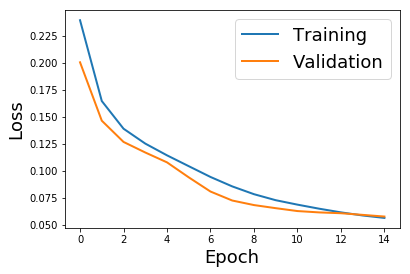

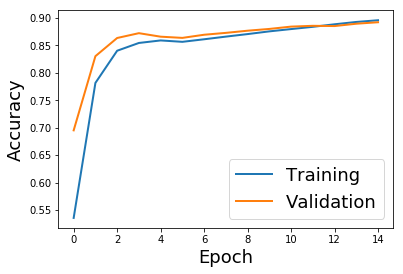

In [33]:
# Plot loss

plt.plot(model.history.history['loss'], label='Training', linewidth=2)
plt.plot(model.history.history['val_loss'], label='Validation', linewidth=2)
plt.legend(fontsize=18)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.show()


plt.plot(model.history.history['acc'], label='Training', linewidth=2)
plt.plot(model.history.history['val_acc'], label='Validation', linewidth=2)
plt.legend(fontsize=18)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Accuracy', fontsize=18)
plt.show()

In [34]:
# Predict and evaluate for test set
FACES_test_pred = model.predict(FACES_test)
test_err = model.evaluate(x=FACES_test, y=LABELS_test)
print(test_err)

465/465 [==============================] - 13s 29ms/step
[0.059250044502237795, 0.8884896874427796]


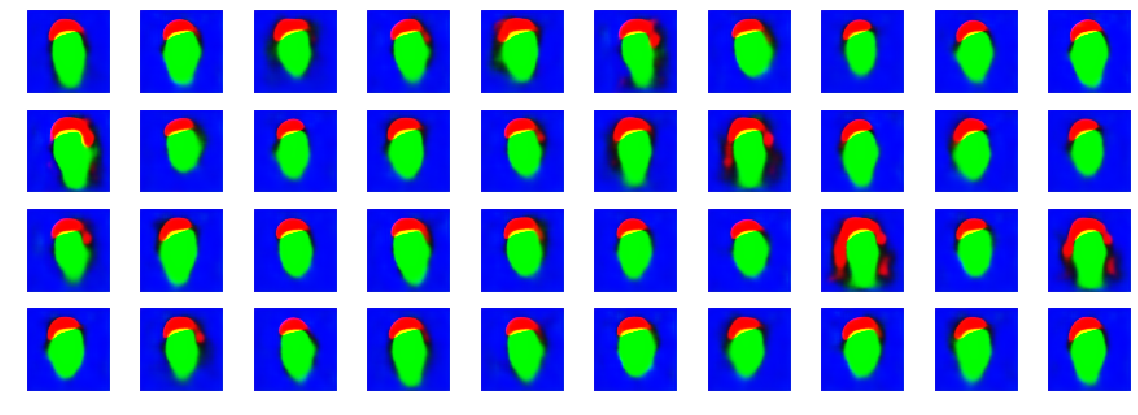

In [ ]:
# Show a few examples
plt.figure(figsize=(20, 7))
for it_k in range(40):
    plt.subplot(4, 10, it_k+1)
    plt.imshow(FACES_test_pred[it_k])
    plt.axis('off')
plt.show()

In [9]:
# Create NN - 1.3
i = Input(FACES_train.shape[1:])
h = BatchNormalization()(i)

h = Conv2D(8, (5, 5), padding='same', activation='elu')(h)
h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)
h = MaxPooling2D((3, 3))(h)

h = Conv2D(8, (5, 5), padding='same', activation='elu')(h)
h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)
h = MaxPooling2D((3, 3))(h)
h = Dropout(0.2)(h)

h = Conv2D(8, (5, 5), padding='same', activation='elu')(h)
h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)
h = MaxPooling2D((3, 3))(h)

h = Flatten()(h)
latent = Dense(128, activation='relu')(h)
h = Dense(512, activation='relu')(latent)
h = Reshape((8, 8, 8))(h)

h = UpSampling2D((2, 2))(h)
h = Conv2D(8, (7, 7), padding='same', activation='elu')(h)
h = Conv2D(8, (5, 5), padding='same', activation='elu')(h)

h = Dropout(0.2)(h)
h = UpSampling2D((2, 2))(h)
h = Conv2D(8, (7, 7), padding='same', activation='elu')(h)
h = Conv2D(8, (5, 5), padding='same', activation='elu')(h)

h = UpSampling2D((2, 2))(h)
h = Conv2D(8, (7, 7), padding='same', activation='elu')(h)
h = Conv2D(8, (5, 5), padding='same', activation='elu')(h)

h = BatchNormalization()(h)
o = Conv2D(3, (3, 3), padding='same', activation='sigmoid')(h)

model = Model(inputs=i, outputs=o)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 3)         12        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 8)         608       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 8)         584       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 21, 21, 8)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 21, 21, 8)         1608      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 21, 21, 8)         584       
__________

In [10]:
# Optimization parameters
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

In [11]:
# Training
batchSize = 320
numEpochs = 15

model.fit(FACES_train, LABELS_train, batch_size=batchSize, epochs=numEpochs, verbose=1, validation_split=0.2, shuffle=True)

Train on 1485 samples, validate on 372 samples
Epoch 1/15
1485/1485 [==============================] - 580s 391ms/step - loss: 0.2273 - acc: 0.5718 - val_loss: 0.1824 - val_acc: 0.8007
Epoch 2/15
1485/1485 [==============================] - 128s 86ms/step - loss: 0.1631 - acc: 0.8231 - val_loss: 0.1230 - val_acc: 0.8581
Epoch 3/15
1485/1485 [==============================] - 108s 73ms/step - loss: 0.1474 - acc: 0.8360 - val_loss: 0.1408 - val_acc: 0.8392
Epoch 4/15
1485/1485 [==============================] - 92s 62ms/step - loss: 0.1361 - acc: 0.8373 - val_loss: 0.1300 - val_acc: 0.8482
Epoch 5/15
1485/1485 [==============================] - 91s 61ms/step - loss: 0.1272 - acc: 0.8445 - val_loss: 0.1269 - val_acc: 0.8443
Epoch 6/15
1485/1485 [==============================] - 91s 61ms/step - loss: 0.1200 - acc: 0.8465 - val_loss: 0.1082 - val_acc: 0.8573
Epoch 7/15
1485/1485 [==============================] - 90s 60ms/step - loss: 0.1134 - acc: 0.8483 - val_loss: 0.1017 - val_acc: 0.85

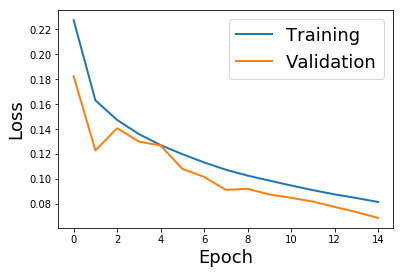

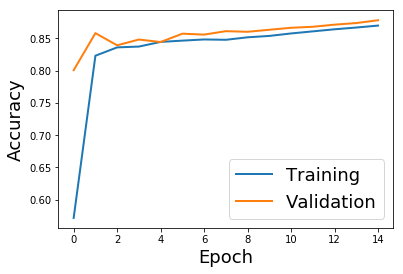

In [12]:
# Plot loss

plt.plot(model.history.history['loss'], label='Training', linewidth=2)
plt.plot(model.history.history['val_loss'], label='Validation', linewidth=2)
plt.legend(fontsize=18)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.show()

plt.plot(model.history.history['acc'], label='Training', linewidth=2)
plt.plot(model.history.history['val_acc'], label='Validation', linewidth=2)
plt.legend(fontsize=18)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Accuracy', fontsize=18)
plt.show()

In [13]:
# Predict and evaluate for test set
FACES_test_pred = model.predict(FACES_test)
test_err = model.evaluate(x=FACES_test, y=LABELS_test)
print(test_err)

465/465 [==============================] - 14s 31ms/step
[0.0705305213569313, 0.8736448887855776]


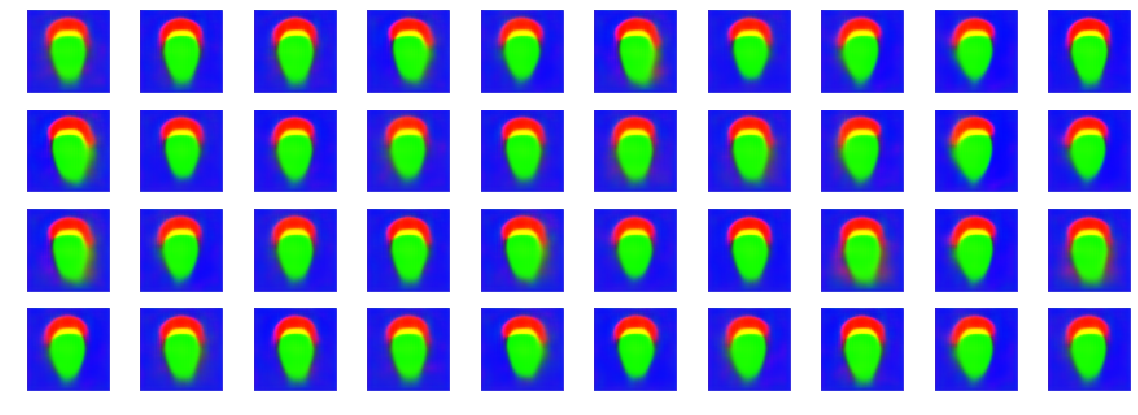

In [14]:
# Show a few examples
plt.figure(figsize=(20, 7))
for it_k in range(40):
    plt.subplot(4, 10, it_k+1)
    plt.imshow(FACES_test_pred[it_k])
    plt.axis('off')
plt.show()

In [15]:
# Create NN - 1.4 - 2.2
i = Input(FACES_train.shape[1:])
h = BatchNormalization()(i)

h = Conv2D(8, (5, 5), padding='same', activation='elu')(h)
h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)
h = MaxPooling2D((3, 3))(h)

h = Conv2D(16, (5, 5), padding='same', activation='elu')(h)
h = Conv2D(16, (3, 3), padding='same', activation='elu')(h)
h = MaxPooling2D((3, 3))(h)
h = Dropout(0.2)(h)

h = Conv2D(32, (5, 5), padding='same', activation='elu')(h)
h = Conv2D(32, (3, 3), padding='same', activation='elu')(h)
h = MaxPooling2D((2, 2))(h)

h = Flatten()(h)
latent = Dense(128, activation='relu')(h)
h = Dense(512, activation='relu')(latent)
h = Reshape((8, 8, 8))(h)

h = UpSampling2D((2, 2))(h)
h = Conv2D(8, (5, 5), padding='same', activation='elu')(h)
h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)

h = Dropout(0.2)(h)
h = UpSampling2D((2, 2))(h)
h = Conv2D(16, (5, 5), padding='same', activation='elu')(h)
h = Conv2D(16, (3, 3), padding='same', activation='elu')(h)

h = UpSampling2D((2, 2))(h)
h = Conv2D(32, (5, 5), padding='same', activation='elu')(h)
h = Conv2D(32, (3, 3), padding='same', activation='elu')(h)

h = BatchNormalization()(h)
o = Conv2D(3, (3, 3), padding='same', activation='sigmoid')(h)

model = Model(inputs=i, outputs=o)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 64, 64, 3)         12        
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 64, 64, 8)         608       
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 64, 64, 8)         584       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 21, 21, 8)         0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 21, 21, 16)        3216      
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 21, 21, 16)        2320      
__________

In [16]:
# Optimization parameters
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

In [17]:
# Training
batchSize = 320
numEpochs = 15

model.fit(FACES_train, LABELS_train, batch_size=batchSize, epochs=numEpochs, verbose=1, validation_split=0.2, shuffle=True)

Train on 1485 samples, validate on 372 samples
Epoch 1/15
1485/1485 [==============================] - 284s 191ms/step - loss: 0.2568 - acc: 0.4748 - val_loss: 0.3269 - val_acc: 0.5039
Epoch 2/15
1485/1485 [==============================] - 154s 104ms/step - loss: 0.1566 - acc: 0.7908 - val_loss: 0.1418 - val_acc: 0.8443
Epoch 3/15
1485/1485 [==============================] - 150s 101ms/step - loss: 0.1318 - acc: 0.8534 - val_loss: 0.1267 - val_acc: 0.8519
Epoch 4/15
1485/1485 [==============================] - 159s 107ms/step - loss: 0.1175 - acc: 0.8576 - val_loss: 0.1114 - val_acc: 0.8509
Epoch 5/15
1485/1485 [==============================] - 158s 106ms/step - loss: 0.1070 - acc: 0.8558 - val_loss: 0.0995 - val_acc: 0.8541
Epoch 6/15
1485/1485 [==============================] - 164s 110ms/step - loss: 0.0982 - acc: 0.8575 - val_loss: 0.0939 - val_acc: 0.8523
Epoch 7/15
1485/1485 [==============================] - 180s 121ms/step - loss: 0.0909 - acc: 0.8595 - val_loss: 0.0813 - val

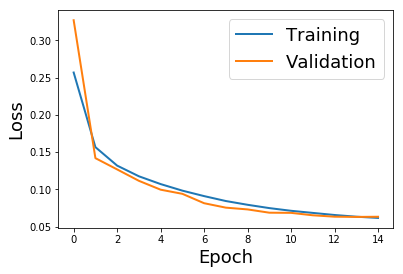

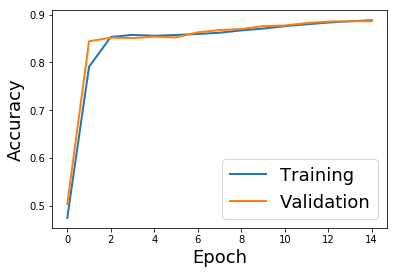

In [18]:
# Plot loss

plt.plot(model.history.history['loss'], label='Training', linewidth=2)
plt.plot(model.history.history['val_loss'], label='Validation', linewidth=2)
plt.legend(fontsize=18)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.show()

plt.plot(model.history.history['acc'], label='Training', linewidth=2)
plt.plot(model.history.history['val_acc'], label='Validation', linewidth=2)
plt.legend(fontsize=18)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Accuracy', fontsize=18)
plt.show()

In [19]:
# Predict and evaluate for test set
FACES_test_pred = model.predict(FACES_test)
test_err = model.evaluate(x=FACES_test, y=LABELS_test)
print(test_err)

465/465 [==============================] - 17s 37ms/step
[0.06443681574316434, 0.8837250078878095]


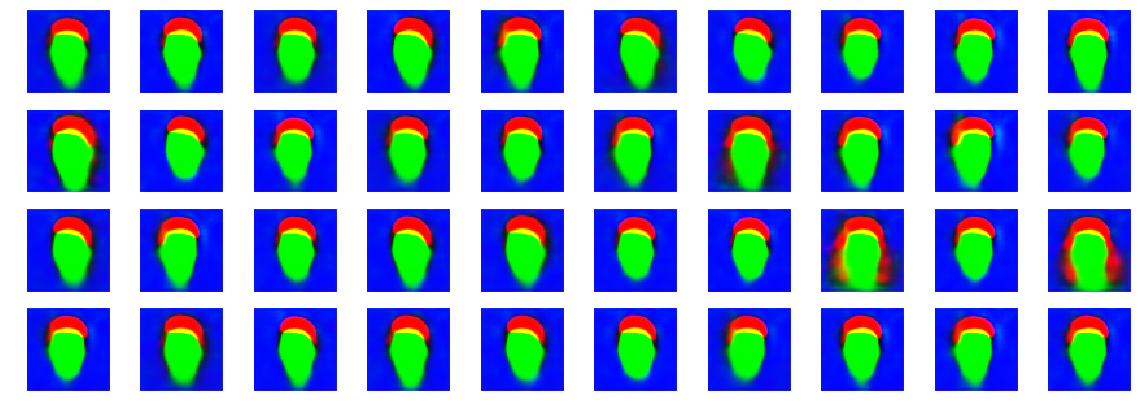

In [20]:
# Show a few examples
plt.figure(figsize=(20, 7))
for it_k in range(40):
    plt.subplot(4, 10, it_k+1)
    plt.imshow(FACES_test_pred[it_k])
    plt.axis('off')
plt.show()

In [9]:
# Create NN 2.1
i = Input(FACES_train.shape[1:])
h = BatchNormalization()(i)

h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)
h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)
h = MaxPooling2D((2, 2))(h)

h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)
h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)
h = MaxPooling2D((2, 2))(h)
h = Dropout(0.2)(h)

h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)
h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)
h = MaxPooling2D((2, 2))(h)

h = Flatten()(h)
latent = Dense(128, activation='relu')(h)
h = Dense(512, activation='relu')(latent)
h = Reshape((8, 8, 8))(h)

h = UpSampling2D((2, 2))(h)
h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)
h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)

h = Dropout(0.2)(h)
h = UpSampling2D((2, 2))(h)
h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)
h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)

h = UpSampling2D((2, 2))(h)
h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)
h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)

h = BatchNormalization()(h)
o = Conv2D(3, (3, 3), padding='same', activation='sigmoid')(h)

model = Model(inputs=i, outputs=o)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 3)         12        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 8)         224       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 8)         584       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 8)         584       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 8)         584       
__________

In [10]:
# Optimization parameters
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

In [11]:
# Training
batchSize = 512
numEpochs = 20
model.fit(FACES_train, LABELS_train, batch_size=batchSize, epochs=numEpochs, verbose=1, validation_split=0.2, shuffle=True)

Train on 1485 samples, validate on 372 samples
Epoch 1/20
1485/1485 [==============================] - 97s 65ms/step - loss: 0.2776 - acc: 0.3717 - val_loss: 0.2425 - val_acc: 0.4058
Epoch 2/20
1485/1485 [==============================] - 51s 35ms/step - loss: 0.2144 - acc: 0.6079 - val_loss: 0.1980 - val_acc: 0.6398
Epoch 3/20
1485/1485 [==============================] - 52s 35ms/step - loss: 0.1795 - acc: 0.7501 - val_loss: 0.1620 - val_acc: 0.7866
Epoch 4/20
1485/1485 [==============================] - 51s 34ms/step - loss: 0.1628 - acc: 0.8040 - val_loss: 0.1445 - val_acc: 0.8298
Epoch 5/20
1485/1485 [==============================] - 51s 34ms/step - loss: 0.1526 - acc: 0.8271 - val_loss: 0.1341 - val_acc: 0.8515
Epoch 6/20
1485/1485 [==============================] - 51s 35ms/step - loss: 0.1444 - acc: 0.8414 - val_loss: 0.1278 - val_acc: 0.8613
Epoch 7/20
1485/1485 [==============================] - 51s 34ms/step - loss: 0.1374 - acc: 0.8479 - val_loss: 0.1230 - val_acc: 0.8644
E

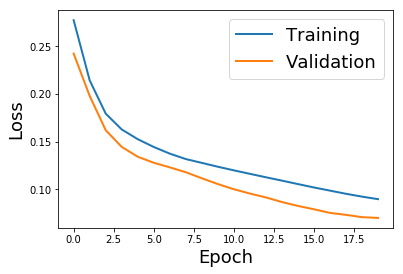

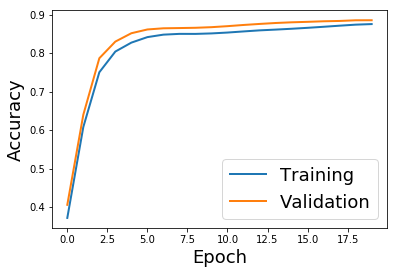

In [12]:
# Plot loss

plt.plot(model.history.history['loss'], label='Training', linewidth=2)
plt.plot(model.history.history['val_loss'], label='Validation', linewidth=2)
plt.legend(fontsize=18)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.show()

plt.plot(model.history.history['acc'], label='Training', linewidth=2)
plt.plot(model.history.history['val_acc'], label='Validation', linewidth=2)
plt.legend(fontsize=18)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Accuracy', fontsize=18)
plt.show()

In [13]:
# Predict and evaluate for test set
FACES_test_pred = model.predict(FACES_test)
test_err = model.evaluate(x=FACES_test, y=LABELS_test)
print(test_err)

465/465 [==============================] - 7s 15ms/step
[0.07180411737131816, 0.8803952446547888]


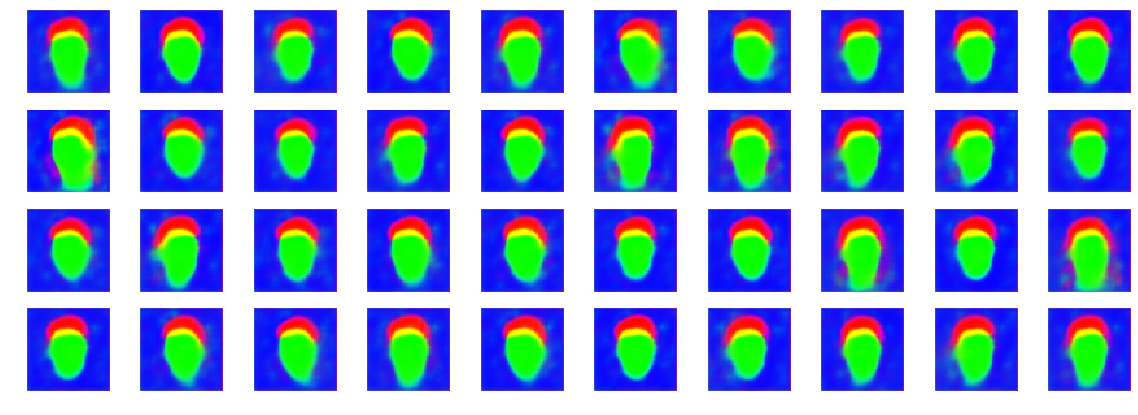

In [14]:
# Show a few examples
plt.figure(figsize=(20, 7))
for it_k in range(40):
    plt.subplot(4, 10, it_k+1)
    plt.imshow(FACES_test_pred[it_k])
    plt.axis('off')
plt.show()

In [9]:
# Create NN 2.2
i = Input(FACES_train.shape[1:])
h = BatchNormalization()(i)

h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)
h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)
h = MaxPooling2D((2, 2))(h)

h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)
h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)
h = MaxPooling2D((2, 2))(h)
h = Dropout(0.2)(h)

h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)
h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)
h = MaxPooling2D((2, 2))(h)

h = Flatten()(h)
latent = Dense(128, activation='relu')(h)
h = Dense(512, activation='relu')(latent)
h = Reshape((8, 8, 8))(h)

h = UpSampling2D((2, 2))(h)
h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)
h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)

h = Dropout(0.2)(h)
h = UpSampling2D((2, 2))(h)
h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)
h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)

h = UpSampling2D((2, 2))(h)
h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)
h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)

h = BatchNormalization()(h)
o = Conv2D(3, (3, 3), padding='same', activation='sigmoid')(h)

model = Model(inputs=i, outputs=o)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 3)         12        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 8)         224       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 8)         584       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 8)         584       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 8)         584       
__________

In [10]:
# Optimization parameters
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

In [11]:
# Training
batchSize = 70
numEpochs = 20
model.fit(FACES_train, LABELS_train, batch_size=batchSize, epochs=numEpochs, verbose=1, validation_split=0.2, shuffle=True)

Train on 1485 samples, validate on 372 samples
Epoch 1/20
1485/1485 [==============================] - 60s 40ms/step - loss: 0.1839 - acc: 0.7229 - val_loss: 0.1300 - val_acc: 0.8529
Epoch 2/20
1485/1485 [==============================] - 55s 37ms/step - loss: 0.1305 - acc: 0.8507 - val_loss: 0.1301 - val_acc: 0.8627
Epoch 3/20
1485/1485 [==============================] - 55s 37ms/step - loss: 0.1076 - acc: 0.8637 - val_loss: 0.1015 - val_acc: 0.8751
Epoch 4/20
1485/1485 [==============================] - 55s 37ms/step - loss: 0.0892 - acc: 0.8732 - val_loss: 0.0799 - val_acc: 0.8822
Epoch 5/20
1485/1485 [==============================] - 56s 38ms/step - loss: 0.0765 - acc: 0.8818 - val_loss: 0.0686 - val_acc: 0.8906
Epoch 6/20
1485/1485 [==============================] - 55s 37ms/step - loss: 0.0679 - acc: 0.8893 - val_loss: 0.0641 - val_acc: 0.8933
Epoch 7/20
1485/1485 [==============================] - 55s 37ms/step - loss: 0.0619 - acc: 0.8955 - val_loss: 0.0589 - val_acc: 0.8991
E

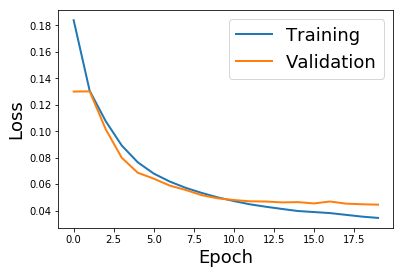

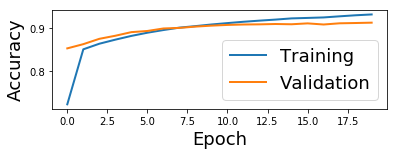

In [12]:
# Plot loss

plt.plot(model.history.history['loss'], label='Training', linewidth=2)
plt.plot(model.history.history['val_loss'], label='Validation', linewidth=2)
plt.legend(fontsize=18)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.show()

plt.subplot(2, 1, 2)

plt.plot(model.history.history['acc'], label='Training', linewidth=2)
plt.plot(model.history.history['val_acc'], label='Validation', linewidth=2)
plt.legend(fontsize=18)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Accuracy', fontsize=18)
plt.show()

In [13]:
# Predict and evaluate for test set
FACES_test_pred = model.predict(FACES_test)
test_err = model.evaluate(x=FACES_test, y=LABELS_test)
print(test_err)

465/465 [==============================] - 7s 14ms/step
[0.046516235893772497, 0.9084530400973494]


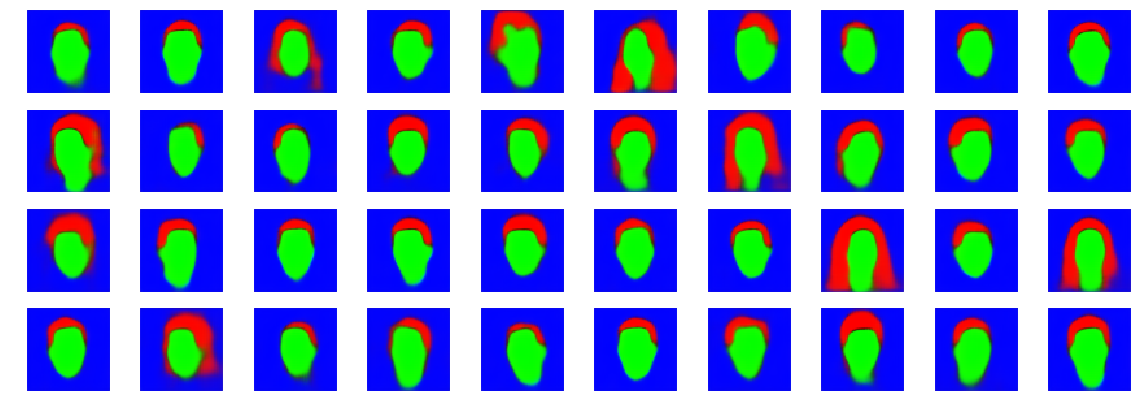

In [14]:
# Show a few examples
plt.figure(figsize=(20, 7))
for it_k in range(40):
    plt.subplot(4, 10, it_k+1)
    plt.imshow(FACES_test_pred[it_k])
    plt.axis('off')
plt.show()

In [15]:
# Create NN 2.2
i = Input(FACES_train.shape[1:])
h = BatchNormalization()(i)

h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)
h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)
h = MaxPooling2D((2, 2))(h)

h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)
h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)
h = MaxPooling2D((2, 2))(h)
h = Dropout(0.2)(h)

h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)
h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)
h = MaxPooling2D((2, 2))(h)

h = Flatten()(h)
latent = Dense(128, activation='relu')(h)
h = Dense(512, activation='relu')(latent)
h = Reshape((8, 8, 8))(h)

h = UpSampling2D((2, 2))(h)
h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)
h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)

h = Dropout(0.2)(h)
h = UpSampling2D((2, 2))(h)
h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)
h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)

h = UpSampling2D((2, 2))(h)
h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)
h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)

h = BatchNormalization()(h)
o = Conv2D(3, (3, 3), padding='same', activation='sigmoid')(h)

model = Model(inputs=i, outputs=o)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 64, 64, 3)         12        
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 64, 64, 8)         224       
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 64, 64, 8)         584       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 32, 32, 8)         584       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 32, 32, 8)         584       
__________

In [16]:
# Optimization parameters
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

In [17]:
# Training
batchSize = 240
numEpochs = 15
model.fit(FACES_train, LABELS_train, batch_size=batchSize, epochs=numEpochs, verbose=1, validation_split=0.2, shuffle=True)

Train on 1485 samples, validate on 372 samples
Epoch 1/15
1485/1485 [==============================] - 59s 40ms/step - loss: 0.2331 - acc: 0.5527 - val_loss: 0.1934 - val_acc: 0.7669
Epoch 2/15
1485/1485 [==============================] - 52s 35ms/step - loss: 0.1712 - acc: 0.7979 - val_loss: 0.1272 - val_acc: 0.8292
Epoch 3/15
1485/1485 [==============================] - 54s 36ms/step - loss: 0.1517 - acc: 0.8365 - val_loss: 0.1105 - val_acc: 0.8591
Epoch 4/15
1485/1485 [==============================] - 59s 40ms/step - loss: 0.1376 - acc: 0.8523 - val_loss: 0.1102 - val_acc: 0.8711
Epoch 5/15
1485/1485 [==============================] - 51s 35ms/step - loss: 0.1263 - acc: 0.8574 - val_loss: 0.1090 - val_acc: 0.8615
Epoch 6/15
1485/1485 [==============================] - 55s 37ms/step - loss: 0.1164 - acc: 0.8518 - val_loss: 0.0958 - val_acc: 0.8644
Epoch 7/15
1485/1485 [==============================] - 59s 40ms/step - loss: 0.1079 - acc: 0.8555 - val_loss: 0.0842 - val_acc: 0.8727
E

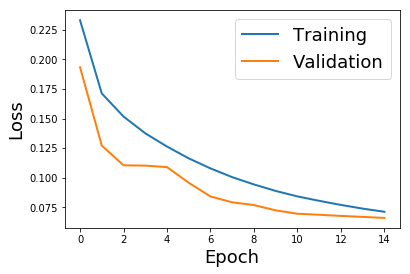

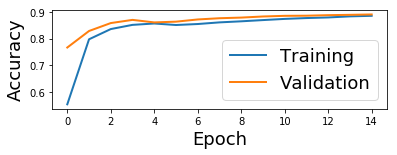

In [18]:
# Plot loss

plt.plot(model.history.history['loss'], label='Training', linewidth=2)
plt.plot(model.history.history['val_loss'], label='Validation', linewidth=2)
plt.legend(fontsize=18)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.show()


plt.plot(model.history.history['acc'], label='Training', linewidth=2)
plt.plot(model.history.history['val_acc'], label='Validation', linewidth=2)
plt.legend(fontsize=18)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Accuracy', fontsize=18)
plt.show()

In [19]:
# Predict and evaluate for test set
FACES_test_pred = model.predict(FACES_test)
test_err = model.evaluate(x=FACES_test, y=LABELS_test)
print(test_err)

465/465 [==============================] - 7s 15ms/step
[0.06769813347247339, 0.8881767674158978]


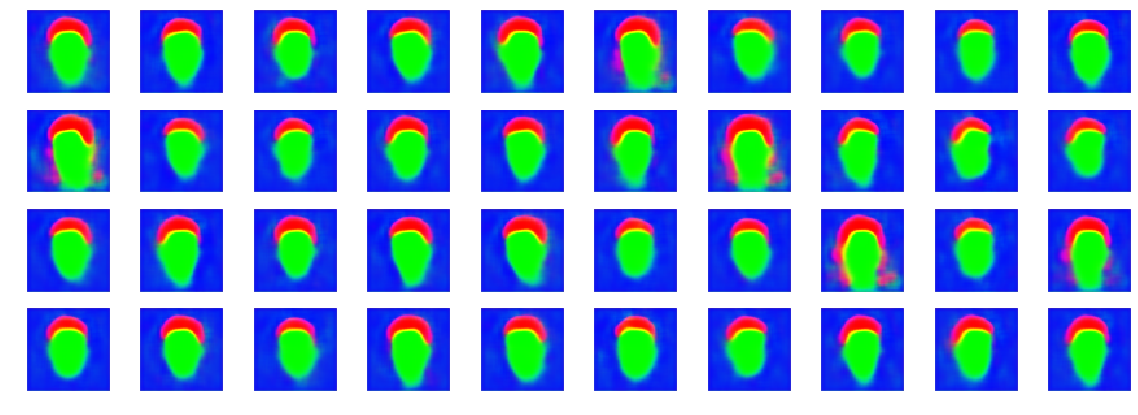

In [20]:
# Show a few examples
plt.figure(figsize=(20, 7))
for it_k in range(40):
    plt.subplot(4, 10, it_k+1)
    plt.imshow(FACES_test_pred[it_k])
    plt.axis('off')
plt.show()

In [21]:
# Create NN 2.2
i = Input(FACES_train.shape[1:])
h = BatchNormalization()(i)

h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)
h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)
h = MaxPooling2D((2, 2))(h)

h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)
h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)
h = MaxPooling2D((2, 2))(h)
h = Dropout(0.2)(h)

h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)
h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)
h = MaxPooling2D((2, 2))(h)

h = Flatten()(h)
latent = Dense(128, activation='relu')(h)
h = Dense(512, activation='relu')(latent)
h = Reshape((8, 8, 8))(h)

h = UpSampling2D((2, 2))(h)
h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)
h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)

h = Dropout(0.2)(h)
h = UpSampling2D((2, 2))(h)
h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)
h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)

h = UpSampling2D((2, 2))(h)
h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)
h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)

h = BatchNormalization()(h)
o = Conv2D(3, (3, 3), padding='same', activation='sigmoid')(h)

model = Model(inputs=i, outputs=o)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 64, 64, 3)         12        
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 64, 64, 8)         224       
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 64, 64, 8)         584       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 32, 32, 8)         584       
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 32, 32, 8)         584       
__________

In [22]:
# Optimization parameters
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

In [25]:
# Training
batchSize = 320
numEpochs = 15
model.fit(FACES_train, LABELS_train, batch_size=batchSize, epochs=numEpochs, verbose=1, validation_split=0.2, shuffle=True)

Train on 1485 samples, validate on 372 samples
Epoch 1/15
1485/1485 [==============================] - 57s 38ms/step - loss: 0.1556 - acc: 0.8157 - val_loss: 0.1393 - val_acc: 0.8374
Epoch 2/15
1485/1485 [==============================] - 60s 40ms/step - loss: 0.1419 - acc: 0.8309 - val_loss: 0.1223 - val_acc: 0.8530
Epoch 3/15
1485/1485 [==============================] - 57s 39ms/step - loss: 0.1305 - acc: 0.8429 - val_loss: 0.1054 - val_acc: 0.8650
Epoch 4/15
1485/1485 [==============================] - 58s 39ms/step - loss: 0.1211 - acc: 0.8520 - val_loss: 0.0964 - val_acc: 0.8701
Epoch 5/15
1485/1485 [==============================] - 54s 36ms/step - loss: 0.1130 - acc: 0.8588 - val_loss: 0.0915 - val_acc: 0.8747
Epoch 6/15
1485/1485 [==============================] - 52s 35ms/step - loss: 0.1057 - acc: 0.8648 - val_loss: 0.0863 - val_acc: 0.8791
Epoch 7/15
1485/1485 [==============================] - 51s 34ms/step - loss: 0.0990 - acc: 0.8705 - val_loss: 0.0834 - val_acc: 0.8823
E

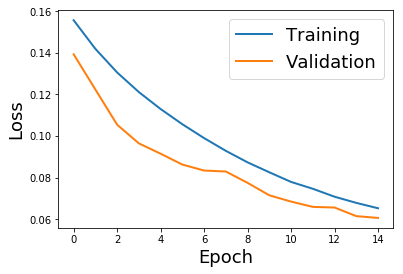

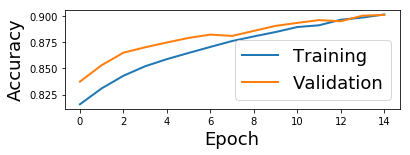

In [26]:
# Plot loss

plt.plot(model.history.history['loss'], label='Training', linewidth=2)
plt.plot(model.history.history['val_loss'], label='Validation', linewidth=2)
plt.legend(fontsize=18)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.show()


plt.plot(model.history.history['acc'], label='Training', linewidth=2)
plt.plot(model.history.history['val_acc'], label='Validation', linewidth=2)
plt.legend(fontsize=18)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Accuracy', fontsize=18)
plt.show()

In [27]:
# Predict and evaluate for test set
FACES_test_pred = model.predict(FACES_test)
test_err = model.evaluate(x=FACES_test, y=LABELS_test)
print(test_err)

465/465 [==============================] - 7s 15ms/step
[0.06216319685661664, 0.8985005031349839]


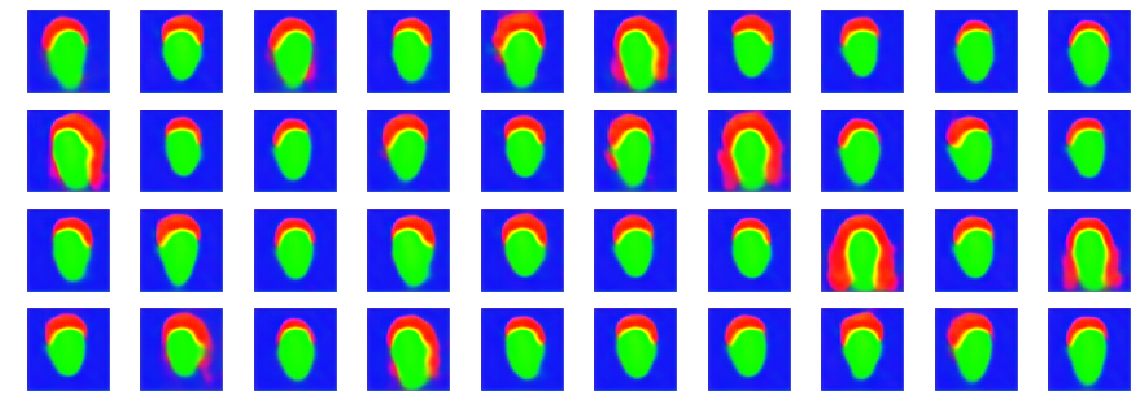

In [28]:
# Show a few examples
plt.figure(figsize=(20, 7))
for it_k in range(40):
    plt.subplot(4, 10, it_k+1)
    plt.imshow(FACES_test_pred[it_k])
    plt.axis('off')
plt.show()

In [65]:
# Create NN 2.2 - 3.1
i = Input(FACES_train.shape[1:])
h = BatchNormalization()(i)

h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)
h = MaxPooling2D((2, 2))(h)

h = MaxPooling2D((2, 2))(h)

h = Flatten()(h)
latent = Dense(128, activation='relu')(h)
h = Dense(512, activation='relu')(latent)
h = Reshape((8, 8, 8))(h)

h = UpSampling2D((8, 8))(h)
h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)
h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)


h = BatchNormalization()(h)
o = Conv2D(3, (3, 3), padding='same', activation='sigmoid')(h)

model = Model(inputs=i, outputs=o)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_28 (InputLayer)        (None, 64, 64, 3)         0         
_________________________________________________________________
batch_normalization_49 (Batc (None, 64, 64, 3)         12        
_________________________________________________________________
conv2d_164 (Conv2D)          (None, 64, 64, 8)         224       
_________________________________________________________________
max_pooling2d_60 (MaxPooling (None, 32, 32, 8)         0         
_________________________________________________________________
max_pooling2d_61 (MaxPooling (None, 16, 16, 8)         0         
_________________________________________________________________
flatten_28 (Flatten)         (None, 2048)              0         
_________________________________________________________________
dense_51 (Dense)             (None, 128)               262272    
__________

In [66]:
# Optimization parameters
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

In [67]:
# Training
batchSize = 320
numEpochs = 15
model.fit(FACES_train, LABELS_train, batch_size=batchSize, epochs=numEpochs, verbose=1, validation_split=0.2, shuffle=True)

Train on 1485 samples, validate on 372 samples
Epoch 1/15
1485/1485 [==============================] - 160s 108ms/step - loss: 0.2439 - acc: 0.5158 - val_loss: 0.2042 - val_acc: 0.6451
Epoch 2/15
1485/1485 [==============================] - 44s 30ms/step - loss: 0.1858 - acc: 0.7371 - val_loss: 0.1625 - val_acc: 0.7748
Epoch 3/15
1485/1485 [==============================] - 43s 29ms/step - loss: 0.1621 - acc: 0.8139 - val_loss: 0.1470 - val_acc: 0.8224
Epoch 4/15
1485/1485 [==============================] - 43s 29ms/step - loss: 0.1491 - acc: 0.8364 - val_loss: 0.1343 - val_acc: 0.8454
Epoch 5/15
1485/1485 [==============================] - 44s 30ms/step - loss: 0.1372 - acc: 0.8466 - val_loss: 0.1204 - val_acc: 0.8574
Epoch 6/15
1485/1485 [==============================] - 52s 35ms/step - loss: 0.1258 - acc: 0.8506 - val_loss: 0.1109 - val_acc: 0.8578
Epoch 7/15
1485/1485 [==============================] - 59s 40ms/step - loss: 0.1160 - acc: 0.8527 - val_loss: 0.1038 - val_acc: 0.8601

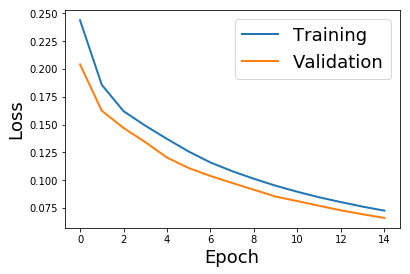

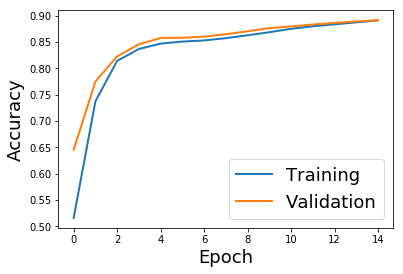

In [68]:
# Plot loss

plt.plot(model.history.history['loss'], label='Training', linewidth=2)
plt.plot(model.history.history['val_loss'], label='Validation', linewidth=2)
plt.legend(fontsize=18)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.show()


plt.plot(model.history.history['acc'], label='Training', linewidth=2)
plt.plot(model.history.history['val_acc'], label='Validation', linewidth=2)
plt.legend(fontsize=18)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Accuracy', fontsize=18)
plt.show()

In [69]:
# Predict and evaluate for test set
FACES_test_pred = model.predict(FACES_test)
test_err = model.evaluate(x=FACES_test, y=LABELS_test)
print(test_err)

465/465 [==============================] - 7s 14ms/step
[0.06735187911538668, 0.8882329470367842]


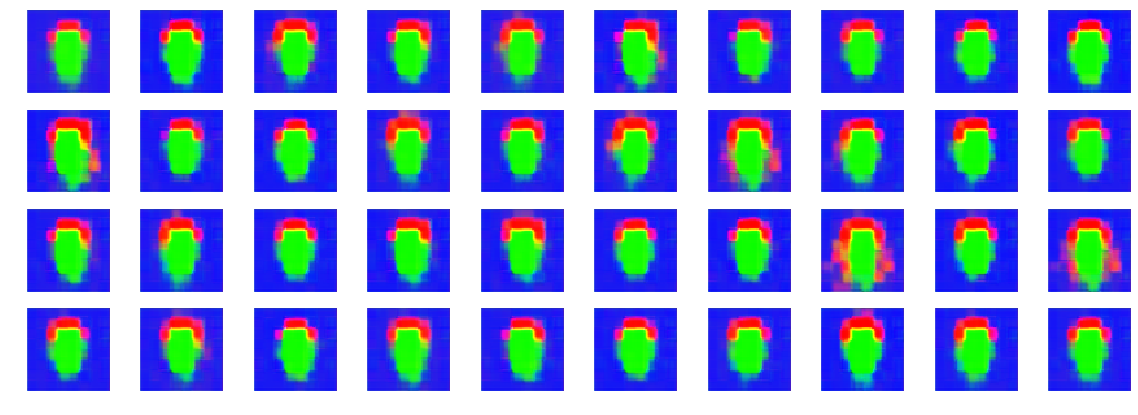

In [70]:
# Show a few examples
plt.figure(figsize=(20, 7))
for it_k in range(40):
    plt.subplot(4, 10, it_k+1)
    plt.imshow(FACES_test_pred[it_k])
    plt.axis('off')
plt.show()

In [71]:
# Create NN - 1.1 - 2.2 -3.1
i = Input(FACES_train.shape[1:])
h = BatchNormalization()(i)

h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)
h = MaxPooling2D((2, 2))(h)

h = Conv2D(16, (3, 3), padding='same', activation='elu')(h)
h = MaxPooling2D((2, 2))(h)
h = Dropout(0.2)(h)

h = Conv2D(32, (3, 3), padding='same', activation='elu')(h)
h = MaxPooling2D((2, 2))(h)

h = Flatten()(h)
latent = Dense(128, activation='relu')(h)
h = Dense(512, activation='relu')(latent)
h = Reshape((8, 8, 8))(h)

h = UpSampling2D((2, 2))(h)
h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)

h = Dropout(0.2)(h)
h = UpSampling2D((2, 2))(h)
h = Conv2D(16, (3, 3), padding='same', activation='elu')(h)

h = UpSampling2D((2, 2))(h)
h = Conv2D(32, (3, 3), padding='same', activation='elu')(h)

h = BatchNormalization()(h)
o = Conv2D(3, (3, 3), padding='same', activation='sigmoid')(h)

model = Model(inputs=i, outputs=o)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_29 (InputLayer)        (None, 64, 64, 3)         0         
_________________________________________________________________
batch_normalization_51 (Batc (None, 64, 64, 3)         12        
_________________________________________________________________
conv2d_168 (Conv2D)          (None, 64, 64, 8)         224       
_________________________________________________________________
max_pooling2d_62 (MaxPooling (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_169 (Conv2D)          (None, 32, 32, 16)        1168      
_________________________________________________________________
max_pooling2d_63 (MaxPooling (None, 16, 16, 16)        0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 16, 16, 16)        0         
__________

In [72]:
# Optimization parameters
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

In [73]:
# Training
batchSize = 320
numEpochs = 15
model.fit(FACES_train, LABELS_train, batch_size=batchSize, epochs=numEpochs, verbose=1, validation_split=0.2, shuffle=True)

Train on 1485 samples, validate on 372 samples
Epoch 1/15
1485/1485 [==============================] - 942s 635ms/step - loss: 0.2690 - acc: 0.4400 - val_loss: 0.2031 - val_acc: 0.6544
Epoch 2/15
1485/1485 [==============================] - 125s 84ms/step - loss: 0.1896 - acc: 0.7033 - val_loss: 0.1486 - val_acc: 0.7943
Epoch 3/15
1485/1485 [==============================] - 96s 65ms/step - loss: 0.1520 - acc: 0.8117 - val_loss: 0.1252 - val_acc: 0.8449
Epoch 4/15
1485/1485 [==============================] - 95s 64ms/step - loss: 0.1328 - acc: 0.8445 - val_loss: 0.1192 - val_acc: 0.8604
Epoch 5/15
1485/1485 [==============================] - 95s 64ms/step - loss: 0.1202 - acc: 0.8534 - val_loss: 0.1139 - val_acc: 0.8680
Epoch 6/15
1485/1485 [==============================] - 95s 64ms/step - loss: 0.1103 - acc: 0.8556 - val_loss: 0.1095 - val_acc: 0.8630
Epoch 7/15
1485/1485 [==============================] - 95s 64ms/step - loss: 0.1015 - acc: 0.8589 - val_loss: 0.0988 - val_acc: 0.866

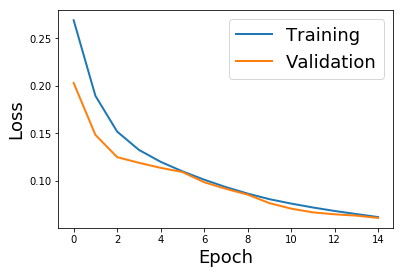

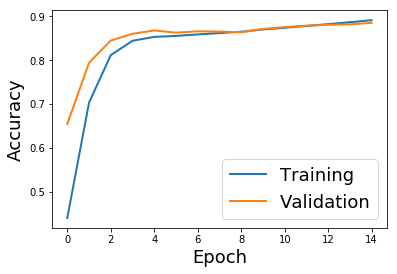

In [74]:
# Plot loss

plt.plot(model.history.history['loss'], label='Training', linewidth=2)
plt.plot(model.history.history['val_loss'], label='Validation', linewidth=2)
plt.legend(fontsize=18)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.show()


plt.plot(model.history.history['acc'], label='Training', linewidth=2)
plt.plot(model.history.history['val_acc'], label='Validation', linewidth=2)
plt.legend(fontsize=18)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Accuracy', fontsize=18)
plt.show()

In [75]:
# Predict and evaluate for test set
FACES_test_pred = model.predict(FACES_test)
test_err = model.evaluate(x=FACES_test, y=LABELS_test)
print(test_err)

465/465 [==============================] - 9s 20ms/step
[0.06250846148819052, 0.8826093109705115]


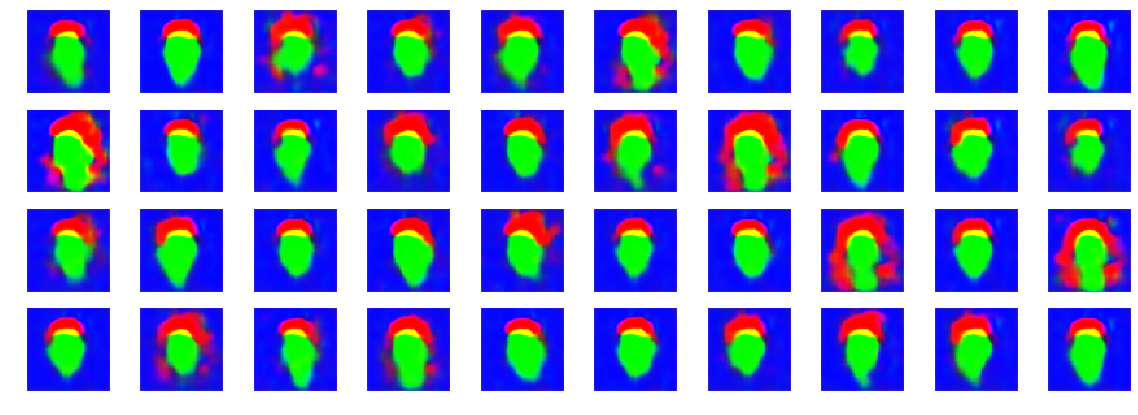

In [76]:
# Show a few examples
plt.figure(figsize=(20, 7))
for it_k in range(40):
    plt.subplot(4, 10, it_k+1)data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABHIAAAGfCAYAAAAzqfUXAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDMuMC4zLCBodHRwOi8vbWF0cGxvdGxpYi5vcmcvnQurowAAIABJREFUeJzsvWnPZdl13/db+5w7PEONXdVdbLK7OYmkRFJsUhwk0XKiaHKixFYcC0GgGI4NBAEcBLDhL5AXAZIvkCCBAyQGkigKEr+wHAlRNFkDHVISBw2c2ex5qq7xme6955y98mKtPZxb1d2kKNYlgbMaXfe5555hnz2sef23qCoTTTTRRBNNNNFEE0000UQTTTTRRBN971PYdQMmmmiiiSaaaKKJJppoookmmmiiiSb61mhy5Ew00UQTTTTRRBNNNNFEE0000UQTfZ/Q5MiZaKKJJppoookmmmiiiSaaaKKJJvo+ocmRM9FEE0000UQTTTTRRBNNNNFEE030fUKTI2eiiSaaaKKJJppoookmmmiiiSaa6PuEJkfORBNNNNFEE0000UQTTTTRRBNNNNH3CU2OnIkmmmiiiSaaaKKJJppoookmmmii7xOaHDkTTTTRRBNNNNFEE0000UQTTTTRRN8nNDlyJppoookmmmiiiSaaaKKJJppooom+T6h9kA/78Ec+r0fPPQJArw2qAY1CdHdSBAYBCUp1hMBgX0MkMCAyEMSPNUC0+xgJMkAzNPbzAG0MEIUY/JygdA0MjZ0zIAxNgwZQ/NkqoIGg1jj1e2t6jAJRrInpoIJEyC1RBZXynUggohIRsTtGiSCR6O8s8wGIiL9zowMSBhoibegAuHj1GT792b+VbvtA6Yef/KKePH8VgI4W1QCDMKQxVKUXoEn9qEAkaLTvEmlUaVRptfS1vaHdZBAhqiD+XQSCClGAmd9nHhnmirR2Tq8QYyCKwuDn9ELoA8EbJyghSh6gdhA7x9tAOitCFPG22N+jcff3SmOIDDauwZ4r8zRvbbwaOkLoaBiYhw0Al648zWe+8Dd3MoYAH/74Z/TY12JHQFVsSrf2Dtr0DG1Elr1f0RNkQ5A1AI1saAeYdcp8sNcIndDGORJtXak2LPrIOV0B8HA84nw84SG5xULu2jVyTAgDp7IPwMv9VZ6P17ith5zFBQCROcqM4IPQMjALp+yFUwBmYU0MwppAJ3O7RhrWtMR4AMCaPVQX9L39jrYMNPS+zgGGEImiOOuA1sdRbBxb7ZHGxnGWxvHqM3zm8//eTsbxyY9+Xo+eexiAXluiBiQKQ2JHqrYeEj+VmHkoGJ8NUbHlWniYMVX7HhFUheBzPTjvChIRn+8aBnuO+FqMQt+3DApE52uqNDrQxHSfnhkbZo3Npzkb2qZH2BCw+4YmokDPEoANLYMsGAafF3FOr3NiDGQhIhG0+hqM/4jLC/G/A5GmsWMXdshPAT78I5/VkyQXo8lFojD4uCnKUI2jEhF6RF0GSk8jA41/AkgQNEphV0FphoGls8aDYcXhMLAfz5g1NpdDWBMDrMMhAHf789zWC6yZ0fuiiDpHdY6oqw4qmOAr76MEypPtJ1VFnaea2JT83a4RVBV8nmkYEJTYOE9to/NZ40dBe0LofS0mufg0n/n8bsbxQx/7bOanG2YoJhfzsopa9Qj2nqK5n1TSqwvBO1NVqHWOiFjn+XfxewaJhKSh6IBozOsVtTUOMcujID2trGgTH2g6QnNCszB+2oYzZNkTOKFx3ieLDaHt6GUGQB8DyoK+37Pv/SHdcA7dzNGNzY0QBbQFTQx1PFdEKX/7OJ+7+hyf+uzf3tla/MjH/kiPnr0GGE9FBQbJ+pmqGn/1V4rYuhRJvNB0DEHwVzL9lIB6P0QCMYopNqT1YaemfiAMaDMgrrMOqqgKUTTzMqKNbeMMX8JAUCU4X240IkCrdhxAJBJUK5U1EiWgzrttJgU01utXEQVNcyrg89fXJjHP5cJTn+X/++N/fyfj+OFPfFqPn63sDARRyhjKwBAUaV0Hx2SZ1HbGYOy2yWqrIGYg2D0I1v/e1y0bggyEtoOZyTSZr9D5Gp3ZuHfdnE2/pNcW7XyNDwsYFoQu8VPv3mKqQGwgBmJaRxrQGKw9OF/QIgOzbYFmtjwEG6Mh6agz021EjJ82Ojg/reyMK8/w6c/tUC5+7I/15Jm0FhtUxfSbbB+6XGySLaUQBpuPAEEJEUSkmCNRGOKcweVXpDH9QVNOgz0jquQ1rnNlmCk0lfwKwS5J+k0P0guhT3ex9qWxkMT2BnG+7stnKNkUrqpkdS2IEog2P30Uio7qJy0GpBrHNg5I09Nqn+XipStP85nP7cbW+OCHvqonLzwEQJd01NpejGN7UUUhxDKGjdIMEBDaNIaDEF1/B+eng5B6UhVQIUbyGNJAnIGkMXXRhEB6lAzAIImtobhekvVpO1ciVOasjRnVd7Ia42OoKJplckxr0W0t2R9Mt0l2RuwJbUerHQtMN7t85Sn+6HOvb2c8UEfO7RsH3Do9B5jRrSrW4f578o2kXjClOyKp15zZBgbvdSCoKb6+EMWV4NaZWqNCUEW0oU+KJDAEcxgADMGdBIRKyTAlaqShbnVj1jszX5GyYP011MRIfkNByyTFBKlKLHxkZe8oSWElmoAg0vpALxZX37yzv0t0++Y5bp+Zom8McMtgQK0vK8VHKAorrkg0SjbY0EDvCoTdw36pXWBZ4S2yDJ1pXkFRNC/g/KghjY8zTlFEJd83+CIUyjnpHtWQZqdOIbVnpLliMzcrOrK2GwdJY9gj0tHQMxNbmIvl7sYQ4PZr+9w+Pg9AVBcuCjEkB2kkNj0sO79iQwgtwTlhEKHthVlXfGtt39DokhBN2Ucb9rXjvCtIl3XDW/Quj+l1DvQ1u0aOaei5wUW7JO7xqvYoLRvMCaPMEBoGH5WWzp7vXHMeBjayAVpWPgYbmXMmczo1Q2Oth6guGKI7erRhIJR3x+ZQxHmQ94HxoDKOjXSEynhcLh/+TofiL023bhxw+ySNofE9c2gX4zDCSLqIxGx0EKKth7KMfO4HslB0R05SSIJo5stFAhojTP04KMTB+ja1JRDNKe1zYSYbWlGWztN6ibRhTXCFGEyZ7Ql0vtDWukeUBV3c9+cs6HWGuqJrzTeGHIu1a++cjFYZiiPHx3C+vPIdjMJ3TnduHHLrxOSiRlNYiWa0QeKpxcnhoYfqnXqCDjQyZEeriCmpmgSLCIGOQ3f+tDGyH1csY6DxNa3MURlYiakFN3WPW7qg44BBbU0LLUqTjdLkstHMC3HeXZEmpcgoirgjpzpl5OUAJJr6kwIcjRselLUYxBw5WS7ucC3eubHPLV+LgzZZLhZy+STlOwK1IwdqmWcHVQp/yidqdQ8YydegzrOyYydaQIlI433XyoY5DY2c2ffQ0YSO2eoEgL65jWzuMJMj1B2tbDp01jEkp2q/xxD22XTGtzfDgnUXzUDtjMeG2No8caNJ8lwcD7YKxSDee+gN+/m7TbdfO8jjmPQbouQAX+aplZNVRUvwMWjWHUs8MljQMhsakp10hZLSUn2GWk9M/0nWH0XVAptaOdkpTrwGM2obLHgGySmj1X1hkNK2KGKyJL2sn1U4eXr3wv/FnToiSuOycra3O55657V9brluo9pUOl2Re1EUbSprTIZKLg7mAFCpYiDuLMl9E8xJ6rJqFjoCK0LYEIOf0waYC4M7APphQdctiHEPdR1JdAaxNWcNZCduceQYHxGa7MjR7LSp2pKOO6UZW+vlKjEHOJItVes2QTxg/D1gZwDcvn7I7SQXtTHFzG0qMFkfBTQ5UdM8DFv6DRXL0cacANmQaHy+F6cq0fWe1L0rZ2H10IufXdsaUYtKtGUyiFRCsAjCsRPAf8ttFdxBX4IA0ccxD7XbGmUcXQ/QnrmP43KH43jr1jnubNuLw8hkNmd4cpakAEdaeE2lo1b8NJL0S4CxrNVKRuZTArCmOOdSrDKxMlxNrkWTMtJRRueXARmJsy3RVnkQap7r+nIaw859AqGMYQg9jfbZkbM3f2PdZiqtmmiiiSaaaKKJJppoookmmmiiiSb6PqEHmpFDXOaUCtUSecweVhglwWjKY0rerBgRAioNeHQJjWgMqLvaxL2rQyrLce9c0Jw4aXEKpSrpCpZ1oaGkuHo6ZnaOKub2CpXLLUgdmMje1q2gWxV3Uf8etvxzWqWyqmcbpQhzRLWnzvjQ2LArUt0jT5uUjaNiXlUssqp1rjDJY54ihIHUUVqlM1oWTknBtmHLbtrcY3VkTAVYpLmB1UENQO0V1dIWiUKoBkQEkECjpblRk9c/Nx5JzyI5ZQXR4iVPo5qviTYp6moVSXnkyWUbH+zS2yaN++BRdg9reB+kMfGO7G2dCRFmG0KwKK60Z4Q4owkhR5EaEYJE5v6KrSpXQuTdWFT3R+MNHtcXeFifo9Xrft8OlZ67aqVWB3qOXq9xkY7XcgaOsuAslwJcpecCr3KI3aOPJxwFuM2Cm1gE547sc0d7TtW+H3sK1cYHpSOw1oZBhSFl5IwmDugQsGhHmTCaMvd80e9yLRKrtZjKS9VLVBJlxmV/W/Q45/xT4gUlumHp9WXt1cFju1spEc3PkJhLZXTwFP1RJkHvWTl2zb70XAh3uSivALDgmJYNS11nFjvIjJUGjv0+xzL3Y3bC2qP9mqNqlumcYs/2EV2O+DyWABJIJVjWth2OIUDcs8gsllm1PY456l+H6iiZhZbZkcYlRRY7lAHB7ttgUePzav3wDl3xNo55nLt0Xvo40HAiA7c0ydYL9AR6FTaeVdEyQxB67+/WpVk/YsPWslw5C/QU+Ru9TDZlTRWZUbLh1OVEkosqimgYrUUSv8o8dYdyMe6hWS5a6UOVeFtF6ipdJ5Tv9hq21kb5u1V2aMoUHekkaI7agkUjhZCzXcWzWUUlS9cFPQd0zNV4+SHH7MvzLPU5AKLcRJtjDvUOc8/aCc3AEDpWYhk5p+GQrt3nuLXMi6Ous6zJgayLhVS2qhUv8c/0hiqWT5SzZr8H1iK5bLApa7HWbyoFQcWzxvJkdzlf6wOJp1aZLjljMJ3hY1lrFWioMn/I6fzpjKDR+81LUVVopWSoWZaFsogxl5aICiFqXmcRy1RPZe29BNOdq0zV9FqS16ZlBZQahJQFUZds7W4cY9zLuk3KVDU55u0doo2ZZ9OoDHU1sWX5ex/EnGEhQJNlheClNc7VlEBAmdHR+XjEoEgzZB1VN3vEOLdScV36fVoCZNkpMRBCnxmGyasGiSGvDdXGs76KjSPVGqpmUJbjQ5pbmSd53UlOHQlAj8rwPWFn2PP3Uapx1PFaRE0u5vZ66XheKMSk5Jd7aiDKLM9PzZZFkkUuVVUr+eW/pUTzfDO2+rzKLImmZuT1G8R4fE+aMqSSv5qf160V5yVSHoPZTU0xr6JnX6YsMB2IDDYb0xrfpa2hS0oajGfO1PZVUkHrVJZQ8cHgGk0g8yPVlHNadFctKvn48fUXAZ9OtpQDNhZ9dU6dbZMZbW5+KdoZyiW6ZfOnR40fXWcgm62V9fTBHiJ5LjWmPxAMegWIwxuP4QMd4ZRSDS7vtpVu8ANjhbX8FO5zvjqOQzJArSY2461kVab0fUw8LwuzVFoyTs+qB8Oyk9WcN5DrhEUpymX9Ctw7mCXhcWuu6Pb7BxI+THmn9FBA698eLNkYejOSoqlQq59sf6/H0PXvSCnXUDXHW16oMirGQhwzBy3lG9lBE4vxSO//jyRZWcqa9K1cUyumgAxCU1mqWg1zusX22q7TKrfYhc+ditHk9HjJgnNk5O6AooRqLYZqYMqbCgF6Z8KhMSaXpp6vu4FZVnyVloZZUQ5EaGTDOcfDuSTXuazPcyAv0cqRX6OoFUjYOcx4C3MGXbJwrrsEDqXnUI8BeFRuc06fZiEvATBwlyMZuMs5bmK18a/pOV6WR7jppSYzNRyX46yMQkeai95ctyZHY7wtMLziNfEXvc8qf1AURRjZD/5/LVSCCttTrawhTynewioZakeOeNlp8Rk4R62cWbnsR/M9bK2VkshipHrath5xSa/zsD4PwHm5wb7c5rwqe14Ot9I5t/QiN8S+39IDViy5Wwn0LtWzJwfGlkzRLHmToyfVnUvGXNrlGMIWT9VtIzD94J4OIHtuqvWr0rgTK729KQGldEcMP8BLq5oYWYoFRpKzZyWBtSyIXtIoLJjFBtGG1vtqjrJA6L3Fcx/jM+/CwV1IjZZ+7RE2Cl0+x46l14mMeWx+5fSu+An1WtRKRmSe+mY9/d2jKJXj0nmpjOb/9rx0o6oSNDkgUL1ypFrjW/NC/Fla/TLYyGecLEtJj0h17aDm2Gwwfrqv17mor7DgFT/jNVq5yRU55ZJruTL0rBvl2DHIjuSYs3afG2kM+3Ns5BDTVWw+hcwtUulHO6oMS62KVLrWDscQHJ+v0lGLnjrWZ8YqRr02U/mT5JJss/cq/aaax9s0fk716QvEjIaiN0UJBX/QNV/cESuhp5EVC1EWrjOG6HiDeR42dDS5fHWjgQ1bqkBq85Zhm3/Lr69Fl92hfhOl4C2OdJvc7mDBNscFMiOxyC+yfA95ZorL/uwOFZORCcMIIBLZsE8fHHszrKBtM3ZiL4dE3SPGJXiJt6jbND6GkWh6bsKyCQoaCRTswaAKGkr5FWN9M9mi9ay016qOjGpO7Corr6v09R3rqNmpCJDwifQ+sjFRcgpXugsuJ5KNptIUew+TiyOnqvplOl7j9W1VxYRYHTSOMGJuqjakFUaLtN67qV+H/ErlOXX3+whKfU4aw/ycWpdL/CHp1SlTYXcOuaGKZ+SSp1pHxWVjjpTrPZ1icGJSOZLdkZO80bIl+6vEitFcERj5l5PNmJZEWjh1Ysb29YHiJ+Ted7kfve58TcGL6DfJwI6ANqYjSAoqfA85cvR1HB6vd0Cqf+ujRTnHFoxWhoc7chIDiGJOUQvgabmxD0o+sA1c7H+Oat5q92lQ8+51oA4jsuX8te/VQAulTv7ewS8TVxAKKhO+OjUf0x1GrXIEjaxbbJ/AfafuSD8R96KPFZuxwUxR0AUY3GFWA+614HolbICNOnNNM8ei2CEZL4rVNKdAUmtGrGiTmV2DjpVnqdXkzIfql8ltvlfESPXphu89AnQ3pA4CaGQCL4FtAgb4hpBCUuJZVQmzQhtzgNGWbDg0GI5MwkEBLoabPCpPA/Bw/DLnw9Psc51GN/5ki44k4OvAVRoe4TEOOMNAbVvOOKevcuCGxmWu0/IVgt4CYC13uC0DR3qZPcxpdJFLNBwz8zXThkjkKnve/7cckHJV1UcbDy918Vkll3oFj+dAlN2No0oNGOtGUz2GGCpA4WEpIp6Evilv5mApay8SinBjC5S2UYMUkMqB3dhDsjmWoxWaQTZbepZ6yiGGjfQEL/JO/pR3R8sCaJobzOWIA5agF/z6PV7SI+b+AjNRVqK0WkCwO2npKsf2UGtcpaMYZSVVeSvl992R1o4zyJgOidy8L99TACHLM83AscXwMGyMXDsfxADCveb6vN7kSrzNY+EurRrIbZAFdySwxvAlruoeLxLoNLDJmDjq0ONGewRWDNzxptwROAZE2nxN1MAxBcS3Y0uR415nY/qluFVl6zNdWY/3Dtdi/ewkrqnEVV5P/ilpLVbH07GKH93XgB7dK607559ioIqtC7lGIy2GmbDwTI3zHHONV7jE0wA8Ks9xUb6cccuOm9vo/C5X48CeP3wZIieiHDtw62HTstrbp+lsfm10xiou2GxizvYIoUdjwugp7zNkQyswdotwz9J90DRah3lu1TpNtiZG38dOxG0nfwp4VfqNQgl4+A2keo7t8JB9DRbJdt6b9BvBME1cAV2wYcER83jqzVjTticcdC1zzwCZeSZbMl4NOWvGxpn2KTNgRtSxET1UcsCMxVAZwAHL/lPUrZxd6qix1m2SIU9tLNo/YyNPLGsCILiNocEyYtJFWqLmqMnNkABXm0jUQBMkJ0fQBmLbGFYOIF2LaEsYGrR33CjUMM7SxhgyIKzyhIqNoKFBNwI5Ku+Zwj4+ho1UMjQjUjJTt5zccTR/x7xTUqRO7sXc2QVFbas1A0m61eOmW9+pZYmPM15tAeSg6vi+1T1SlUVdfeG2RhZ6EXMAJGdOeTQVsx7bizNFD4BTKR5S29dmq72lMZLvU7GKZHTlc1MGUcrOwm1IheAB1pRKtAPSLf14e9Zl+7h6d73HhhQqNR2P6Y/nwVgtKONS8jts/JK9qJA91n117H6fyXHT+v/1mNcv5c/ebkr9ec91ANGdVFlFDfl3dfB49Q0+Xo8erCMnxGIIKpVnq1JS3+B6qYXfKJpaZ+SMU0IFM8apdxkKagPrjDsB4mqFSp+aNdprotpVwxa3MvLC+s3qiFqgXJI/qzf2plUOSGfJ2RlhXnJxLzxQPHc7IMOr8jFMpSb1ovpWFDGxa0cypb5HJTvzJc7VspBcRHQB4mmrMhRlsTxGaWOkybtH2Y4eQ7pJaE1gSxgZDLWTKYgZTmntmrF/f9LRYi4OAFH/W793hOS2AKx5EUAql8kAgCmVOgEENgFt3bGRFHXtCDowTwBdAufDERfDHQAO420WcptZPCKkqKEG0LaUZ+k3mes+V+jpOfPG3GaPF5m7I8c+XyZ6RDkBgs1kn+hlXAdyl1UQmnDJfmv2iGGPuXPyGAObKAwiuXxjwFjDWMErB3L/SFGI4i6Nx6Aj5mLJHOMsgKbmYOrRDZ+oCeRPtWgKdfoq+BqvMrFylWSl6EjbOx/w7yHFkhJsObScciC3uKKWRXVNvsw7eJpHw8sAzOSMmWxYBmGIqTTAHIetWHlc2xywlnMEdwKu6DllsAjsWJurOglfh0UBT/l3uYxj1wprLTOkVkpqjaIurVLqFSz597I7VwgdIrZbHkDTwqI95cDLaR7iBg/rda4NL3De19ks9HQcENUcOe+j47W44handJ7pdkJgiZCBlgncZuB5N2gWtDRic+/Y+3wQZUMoDkEJBCmGbu+utRFf3V5zFLfN+O9a/u7QCxCUqnFZqS9R87RU3UBL71v5A6Laess67f28W/ezYqqyuyYYmHfrMm9Gx55uCKw4xAz8S/Iyb5Ovc5WvA/BweIqLzUu0rfHTg9maOFvzkCoLT+05mPXsLwf2Wxvn/dnA6kCIDpB8PNzlWG8jmzlD7xldfUOUWQbTtv3yGjSDa1vmgwXOK91sh6ShXouaS91qHnrPqLj+CHiUWO4Zx3GgCjsnz3HNcyb7zFvXlb0/gs8d2zzCr9OBRjtmWGnknGOWHNGIjbPNg1OWYc7Cdd15HCAM+UENDb0sOKvKOM0+bSm7Inn2VJIbIqN2ZO1BK31hl2WOlcwbBddLx9mRmp9Kfb1l45T/08WVbSFeFpPuoe6ilA0zzwKO7amVNCV9fegZuoGh75HslLFNMUIObG2Q0OVyb2WWHaDkR6sB+SbeIkJDSX1IbrVRRlXW0yuGM+KiZknKyBjZsVysWlv7R+6h10WbTeuwyJ6trVe2FnfqWz+Wkq+Wii4Fx3lHNoqu5B4lujYPc2PTgQaYKbRYABksOE3pZhUtzpv6s3IOpMqxOGpzZS9q8CBCKQPkTcpyvptkNn/62ysqarsORkGpbZdAPl+kbHSTeGcKyDe48u7X1rstpGPJiZN8Wj2Jsd3b3/fp/9JYxmwhjpdJckrJ1vfRbZLNP7qIagxtPQZC2QH4TcrjdrtSJ5poookmmmiiiSaaaKKJJppoookm+pbpwWbkNNVeXSn3mOJthXSodnOSMxtyQKsu0XJXu1QR5Cr+SiDSqjITJeEzBI0Gyuee8l4b+iE4oFbxbYnHjFLDIgPa+3Oa5BI0MDK/sUdVPOaS2pIK1qtwq8TylDqoaB7Zug2VA9NLhHaaBVCPW4qk1SnBep8xrCKp6ZcaQNii/uP4Tt0pFoAwKMl2sI5brHq0U2anHhneROh6JEZmft0+HZfliEMvwVlI5Jb0vKoWXb4T9jkNM0QPDLMBi25QeY0tI6e0bfDXNYDGN4gejkJAaV6lVIbdjiF4Fk0V7ihvmEAyo5dIpbrBHmYRx7pElxBWIH2kWds1ewrntect0SL854j8gL7G4/oqAOflFstwRBtWyODjNpg7vfFMgRm32OOrXOYY8ewN5GWEpxFu+sOPiHJG7+xrI5GVNJzpPmvPyOmkRSSwbL2UZH5M1546jgOcDjOO+5a+jznKVu0eaY/Boyy+nhOoqNT9Ja+Xn/XdpxEwYY2UVzGTOsA9YBGbzINVcnlWWosJd6cun4TymuIsvEVpnR/NdWPzxbOsmk2kGXok9lzwcX2rvMyTfIl38RcAvFOe4YK8REoYXeuau0RUN9yRdHRGE5bsBR/DcMpZ2HAa7Tl7GpmrsqmyLXM+0na4I299TDXfe3/HHa/FbXHmf41jp+MCz/H3SJBIS6T1d5rR00jHwqP1rSgPhTu8J1rWxYd4hffyEm+V19hz/jgb1CJ50baAjhoZ4g0GvYb6OQOAHDE4XxiYcxPlKd4KwDfY40+ZccQlbknCJarLMGw9SUgYKveJYr4hpWtS+kIKkb1OBssDo1gw3yTpATJ6nyBbGG9UeDj+933X4v2ycOxqgq/FpWdIXdQz9nXNRSxT5ko85m16g4t6k7dhfPiafpW3ydfYlxcAWMQ7xHjKxmXwXQZu0bOMgc7xPg7ayHym7M+NERzMBo73hHWw7I+besRtvUNYL+m6Q29sQx9bmqFg5BgWi0cZvUw7iDCkqO2OsY5VyqYSiZ+O+MmIfyQ+WY1zwnKqsgBVyCCf+SZJbQLDZCWVxTlwcW+lSml762ZQwjAgMbJwKbXHiqvc5LzYuF7mNo28Ru9c9Tj2HHPEOc7TyWUADqRHZEYIXv6sQid7tJ4e36nh5HQJlxAQzwoZ8dKtV7YSoSGXVsUd8lStNqLIGbWjVAesbI20XrHBkEpGOCh+zqYRsRKIkfKreYf4mUb2dOBQ+1zaNjs5RcOQs2u6dWSzXtEPe4S49tt27HGXIJa13EjPaew5bowHr4Yl62aGsmDwcQ1i+IXiWI9WSBCRWPHBpN4V88W7I2nnPnOrzH/JWUrfG1nj22m3Qi3lAAAgAElEQVS2eRi3SKrftywmIJXM+XtngNR0zXgtWuK5WsZoYryd4d3o2u+xEXSlBi2QARaTjC4bQMQY8421Eyx9oynpEw7fJAlEeaYZRsLen4wBOirnyTAI/lZRq+x/yoYyzkyHXZY5NlUVTpJtMpb5Qe4toK6dA4oYREzqpwHo7lOOnW7iJWvWN34sZeCsq++936vuy+o+Op5Y5e90r5qqMaUuA3N5XbOfbDKMMn/GeJKlEN3Grn+TjJwHm3OlHeOZH0aGUqLR5hxbml3Ba0g9Z8t7lHSt0PginKkpOZd0zTkxpfaCniB0tH7NSZxxonM6bekcaFM9sW/w9q6AkxjZOLPvYkPUCDLLzh4BkFiUEUcq1yHVLwaIBnqXnDtiiIal9rZ+9dG3orDuMm11jPDlrHUEvc5Y0dkCC1Bwv4YU7OZcJ+p94sZoruJRZR6VRyTy7sHG8APhBofxmLeE2wCcH25xqEfs600O1VK7D3mVhd5i5g6ANcIznOcP+WEA/lDfxRd5iDOZE0mAvVZmlZZREKt5LnPSnDxxpMyVf/Nf90icZI75XNhheRxYmVkqeykgd+TU6MCAygBemqGzHuYR9v0Gew3QEDqhdSGz33c8HFc80ZixeFk3vEPucDUYbs2SYxrZWMmHFA4rQ4DghapxTcMNlG8iDrqK3gC5C15CBYPD1TpnDw2zZklU2DjDOw4tXVgzNOZImM9PYHnC3NPO592MWWiZJ2kKvomFjHbg0Zx/aU5hRT2V1ZuyQ2VHRhJF7p13ymhtSpq7FTbDNrC4u6rKM/ymwZWqRqCJyiE9F31Hm2vtLQ71jAuOtXIxHnFJTzmnt3mnl789oV/mYb7GAVZK1XIbZJ1Brs9CQJuWu6L0nfXpRmb0oc9zcNFsIJihCrCIG5q4IGROjit/Y0UOKkWHBL5aFB3ZscIqW/m9hZUWR41U81AcZlwqbS5gClHjr76QnqVsOO+7zO2FyNvCMR9U45fvk5d5lJe4yPPMMODxICvHxEoAewtgD8tJfsLbsgIdqtae47Kc5yLvBeCyvJ27cpGvyx4hmuGxlqSTppJWkCaQaquDy2xBRoZHhFHMZqvTKHJR6oM7IStpS6aE78YkOm5RWo8AjvOXcDmir0urdqycPZWRkVL3k3O2wWTjRSKPeXncj+grPM51HsecNG/VF3iY5zjkBfawsZ/xEi23kFy62jFIZOMlxxdnsLeEnoYz9+PPF0qziLStY+8sA+Gg43hmJxyyYqkr+s2aoTc+raFHh5iBW6O/UMGfs3+szLo4d3ZJon2el+ZcC2MLUrfm5D1TT0gOxtpJdz8K1VwPqsxDZM+d4ec4Y48NF5zHXoorHtIV5znmUb/xw7zEI7zEgTvoAkcc0fGq79T4DId8Qzr6sGQ12Ji0MtBwSusOomUQopxlb+FZhFOEXstLa2xHciHeYyxTeRtdN93hTjlNKVwELRuklKqo7YVkjmVtKv0z+C5jFZSDbBnQQWHpc+U8HZd0xePc5JrvyHlFrrPglHnCkOhm9HGBDIF9fcjbeoeZHBHF5ORthC+Ffb7i4/MKVw30twmoy8UhlU9720JQYydphz98CmvZUETi63DKe4zVys7YIT8FaNWgEMBkdLyvYr1lO7LFQySVV72OfeU8NsPhqNJGZREiMw82tmFDwqcCiF2giwGN0DgI7UwHGiLqmHQrhWOBzeBlpbE1/tcKrCvnoGjZJG+hxHkRETKIRY5V8FgW0oFsytoc28rJCQCj+p8d2ovGTyvtcuxH83OqeVmWWzlgyk0BKo5b5yb/Y+UAk2iXZT+AKGEo+lEcfI1Esg6ftg1Iu9f2KnQCsd5Qp3Y75BegOG4aTF2qulyit9FNHEnYSpUzaFQdSNJaq7Z9LzlyJAyU0C6AIkFGk1EqAcLWoCaMnPFEkJyxARY1bxQOPVr8Vl3xGKd8jFu813dIeQfPsMdpBmVVvcTAIaJLeh4GDAvgDsJNj2i+qkv+TJTPqkWbXtJ9jqLQs8cQ0hbAQDNkxz6LYDWRsdQqapSt7c7kHo/fvQCOvkV53n5wd0JyZHTkFTgG+h1BVN5P13aFVatFIRRBJCI0UTnwm7xHB57Ujr+jx7zfI/oX4v9Dw4sIz3lTNoieYVCbNQJyBMcGQOc8wSEf5kUAfiL+NX4lvJcvcMgzDgjWqe/gkOZcCIQAgyRnnAlQUUkJUiMwR/vuzFS2x5AqYrXb7celCvWKF5WaglMwNjSs0Nb7brZClmfInk/e5ZpZv2GhwnmXgtc45X3xDh8azHH2yLDhnTzDI2pGxbK5TaOnNlbRO29QWwM5a+0kK02Fa3YV18UMV61wOvo5B8zYlxYaG/s1S46aBTcWtn67w9sMlxbcdSF6cjIQT3wfqsGumam1I2Vn2TbJag5ba5wJ3mq/wS0f9AMlqaWBCIRgCke1PA3zpyioWq3FlI0TfU1CEh5UUQMDf05byp8ncpmOD+oxn+QZAD7efZbL3OQAy6BaxrvM9A6N3qBxY1G4hXAMktaibdkwRFt3ezqn6RfsARs36s50hsiMjhS9PGLR3Gbmhkorc1ppaWiyY1SkzQI5vdBIjcsdUBx4b1Z//F2nlOYEGN5J+qE4bkw7cVwpBoJ0NOl36ZkzsCcrlp6JcUmvczXe4R1qTtSrKryvf4kPuCPtLcNXWAyv0MTbiKYx6aj2bydrXSrA1/yYUoAxAZbs6Tmu+X334y1WvJMFFzny9L3bOmMjDZ3z0CG0aKMMpIghJXqs5SnbGY81dlzKhDU9PEWQd6ewBmrdxt1QtW7jBkMNshmDlG2gxfHnQpE9uYsT9oWvS0+K5KIqVxj4pJ7y7/BNAJ6M/y+HPM3M8W8avUHgFqLHlOzKDtvZKFkmChEWbiju98LhqdA1cLLwxqyU7kxZOSPY7MFB09M5Hsj14YzDcJeh3adb2PrsmjlR52jn4ywtMUYGF/wDhr9luDnb4ZDdkNTjmAYiVPPObK88jsmfOAKEz06DsUMuvVyCNksA//soBww8MWz4qDvbfjx+k0f1BpfdIXeBE/b0DjN91fBQAOEGwh1Ub+Yn9xI4ioYL95I+zJfjjFvA8847NMI6DAyuEzUEJMzoXSmdA40GGqQA/cqcDIIP1eYiybGDZ6lKduC82Xa5300SjfcYj+bMT5FBw5FKQKLicCIZWDqNVZURIdEMwRS0alRY6MBVDy59SO7wXn2RJ+NTPO688sr6WRasaDzwEOKMEBuCDgS96K1bMbBh8F08VxzwbLzKr7o+9Ad6wFe7fc4ccNraZ0DLmjJy5hBmkHYklCgwBHQQpC/8RgYYOzRqqzrJRHImzi75KZhNJ5U8KG9SKTgkzRqkwrQqZ7pTtTYmY1niwbOq5n6Phxi4Gjs+oKf8oDtI3z+8wCEb9hzHaK7naeKSpUZabK1t6Dmj545aZtXL7PObsuQ3uysAvHJ0jtXQoNoUiNNBDWfVSwj0Auih5gwdWQv0gqwhHnl7RcbqQo/1TC03sYz/hAE4xGQPPXga8VMBT8Xd0lFLpmoQk4sFN8hk4khvTU6brrptXxzjC4UDVd5N5OM+Zj+zucsjbDhwPtfS0qiwJKKYTX9G4AYNr7pc/Dozfl0bPuu22t0u0Pc1fyepQ8Vxc6DoeXA3ASm+I2fgm+5aZtemzFM8catODXDLhOh8bBjeGLB6wsiZaKKJJppoookmmmiiiSaaaKKJJvo+oQebkVOX5ZR90gp5lkDBu7GrasqB+nwbpUVzDkaDconIBzyT5qflNd6jr/JevsIlPg/AjK8j3K2800vQS5ib7wl7DgdEDol+nzVLXtbL/A7XAPjU8Fa+sFlwQwJHKXVYGiu+yFu/R+JcLI8LrKyqi6NUtxTXKZG7lN1SIj72rUJej+M+eZC0XQaQ6qBK1pSWGnO7YPSZsiMTHkD6KWBZh2ARq4dQ/oZnXPynHPMEN7nIZ2n4X/2GfwR6lKPUJXxZ57+lu5cIW8OCC54l8KMqXBsafl0e5Vc8znlTlxxL46MOQ7B0yFQ+p2pFV5rDyPUYVd1St8AzyerUJN1xaVXg3tIwFbUdLYDYbNDZGjyjhf0TOHeKXvHo0t6G2cGK/VPlsvfNO/SID61v8GS0SMYlTrmkz7OntttUq8ega6RJGTZUOa1VY3JeIdVBtg6WrUAbDez3ymGARXqbcEg3HHLk264ezxviMnDaWPtXsWPTd8T1QOPrt4m2+0MqHIkIPbHa+SIyYBgKMeVxhu29CB8c1cgjMaWLVxk4MWVXpGiNSP01r+RUJ24nlUwesPW8UHiL98In6PiAnvBT8izv4ncA2Od3CbyIeIkOnGHhklX1tLTXZkpjA1QyNkNAuaAtAc38VGSfle6xTpgPbSBIS+NleE20dOYgwyjEk7KK8guhOWsu1R9bRzkf7ncbeRyPSh1VLCOlDJbRCggdQTok9QMb5qFjPxxz3sM+T3CdD3KdD+Bp/qx5ghe45NmIc17wDKk0VviarNaYQt7uJJfhwEgAcwQcM/P1cIGGD+oceDvPe6Qrco5TbTlzft95BlhMEdVYYcGMg61VxptY1L8qkcuSY2uL3V2QSMxZqXkXMi0wD6qWfZJXg6RyKv9dpCQ/JUprMT1DYQE87i/6bzLwpK75SXmJt/panOn/jcizkNairD37ph/feDv3RSH4zo9hIzRDYAjKYuVyrw10J7BxRev0EJYS2HjjrvRwPnr+nWcKdEFZSY94jXSMEYbI4PrQEGegDUpTZv+Os+N8o237IpSof63S1N23VQqWk2+2gK/q/FIBZigP+U1+iIF3s+ZvyE1+RP8UgIv8Dg1PEXz9CsegG+BudaeUVbXJD5rpnLkYntVhPOFKf4HX2OfLztBPOc9RbLjtHGbdWrlsK3aPoFZzoDHm9TkItvuSv3MkbeedewQ07WDpWeM7zMgJWtZi1m0CJWQfouF1zpIMxyyhlIA0NKRs8yQ3ghoOzr7fcUHkGht+zDOofpZv8Dhf4y18gX3PyGl4FdFVLg8yJtf4OKa8OjsTzxw4lDmH+igb551Df427epmXENYpe89LvlK0Xhu1naYTll9v7yxRRnMuvWrVMVlXCAjbZY27xRyzspjxJvGeaTvCIivKivp6LdkSno2jYllKdgsaVdpKvuwD73T++FNyzPvlDh+Xb3CNTwGw4PMIt3IrRFvQ88Ad4G1+dIayB35ezz6f1Pfwdp4E4J8PP8DXzg44kxld2uYeQXspuzcvFA5APetR5i6e+7F+VmcU5aKIXMeZspFLVnKC9tgFjXVUm6uCFPwhrfRU3CbMuKvpQldNNn7Mt36vdYRW8Voa+FkGflR7fk6OeYQvAtDyWwhPkeWgBuAicAN4v1/5CO/kkXzOwEP8xzzBP+MqAP+LLnkK4YwCv1AWls/BC8A14JKWtp4JegMcTs74CpVuo+NbodVwS9Ll33gMH6wjR3pSOYQdKI4A8AS4rDzakVH6nwgJPzCd0QB7qjykpoxeUuVn9IRf4FkAfkD/NXO+TMOfg5fh2AJMRXK5Mf6Z0lYDoWK2c5ac4ypPqGEB/E3ez58O7+b3eCe/H4zpviIL7rRz1p6i3GFpZNG37JTB7BgVKw2B+l3KxNXqezG2C75KZIc1jxUWgB2oW2vfzZlTThk55MTWkG4BQTYK51zBuxzhH2rHL4ml61/UXwX9FPBp8BR+w1vSexcBMEYGq9oBQI/43Fjobd7D8zyu8DH5BAC/zxV+Vw951p1tr2kgEhgS843qpQDFKRPrlZfeEUZlAFnB+x4BOxbboBLwNiWB6MqOznp0vkEPvZzjoCfMV+aEARZ6k0vS8Nh6zYd7O/aJ9ct8cPMKVzsrsZn1Z7TDbUJzw596AvTQVHOoV9NFh8LYt22Me0jBLrLnSlSWMudhXfF+Txk/F4/R5pA7ft9b0nA823DsYJ2rPrJaRfpZUfpazCBrqjT6QEQlORZsO+wIBRdxlz4AKaVVgoy2ywUzKCWWbW5TFWcSramsqnZ8JN3IoTCYKTymkV90Rf+X9GWu8jX2h18n8Bv+pOdANsVJQxzf9H6k1uqMPxQjewpz7rCIVppxIsLN5mFu+Atcb4STcJczd84dcsie7HMmczbi28pLcNhGTw/HNhsP1YNz2V5KId+xUxXZCnBkoRDz7yI94lhBwpqGFTOx70tOucwZj8fbPO6gxE/q1/mIvsTb4jN+zhkLvU4IrpAOJxCTIZgmyJiPjXlqkZX3jmpHQhFs9ZSH9YQfl8tc9ojGHwO/Jxf4mhvpL2ug15jLVWN69Ej26z1ejZrnJlyvEU/d6WLcwo5zjJy4pWCntTiktZgdOUkultsIxpLTWmwV3hmVf+CK5i9yh4s8y1z/JcL/4c9+2o3CtBbvswbvtyzr9doJoVeCKO0m7cErxFkgOsjAuU1g3fXMHCNnJSvutic0/R6xcYwc7TidaXYI9N2MIAtiN/Mem6PaMlSOwTdTWL/bJFIFGYiZ0de24WhjBtkWWUlLHx3cGkflUVV+3uXX3+M2b+VFzunv0vKrfuO/wErCk5OmuN3fmAKNmhNvn9vs9ed5WM54ItoGD6dygevhEjcdi+f5puFUWs6822/FQxo5ROhLWUuw+2o9WSucOE11D0ouy4nDLnXUnlL6WY1HcuS0AzQR9ZIWyeCkpbZKVAlDJHiJ03yInI89b3GMxrfqwM/oLX5SzFB8G79Nq1+nkWfBnTvoimKFwnjP4VGL819BG/a5w8f8xLfFAx7TS/wLHuUL3rxjoAvBgomY/hkN9dzugZcCDsXOsMCdvO7sKRZYwVbRHeuogb7AFqRATG02uLIyMheroFTC/6PSgWwdKnvRxuRA4cdiz98P5jD90fhplvoFWvkU8BW/0f3sxXt7Uiq7bEbLNS7xT/SjAPyHw7/Nr8SP8s/lHXwlmP6ykoahDTZNcJOmB/aqF3IIB+mS/UHRT1NLRk0pNkfCetkl2PG438SBgMf2o/ZUY+a2bvG7OQC0jGL1YTAAeDC++sGo/Fde5vvX41O0/DmivwYe4IDrWOduj1vtTTAXe6KGfR7ivfxj/j4A/wk/zb/Qh/nvWPAlXxtrXNKm9h9gTpxH/SZnAq8BdwvWDpD2RSrdULVM3Flp5ax21vAmUBwP1JETYiT4rItiuBwJ8AnSixQFThPAmITq98KXwUCmHqHjxz1i+DE95uf1Ka74AAZ+C/QlzHmzLRTfjM6oFwbcYY5hDjyiN/lJjXyIBR/QtwDwe+Ein+4bXvBB7jZCXDCalERBh7IjQPCZWkc3pJ5b/nfapyT1y64oRM3Rek3R78oZp9RjWWi0O0cS+jkaEDmnyk+4M+4XdMV/oN9kwf/sF/2f2Pit30AUvTklE0BzdPIuwtfY4/f4uJ4H4O18gIcI/DIGen1DW8slSFFf371gHLyWrRe2QavHPe2yksGOdwywWjMSyzdSc/OnDJOmR2cdLM0xIrNTmr0z2plF/C8sr/PeOPCx9hYfc1yOH+R5LutrzKLVCcuwhrgGTdF8Nxzr0HvyRdzXIXd/umeGqbG7hcbslQ9hyZ1uwzdWls2xWq04O2tY2bDSyT6RcwzDQBjdsRq3ao6mxkl2lIy0h52Q1ZB7293JhFCMx/QuCQojHfNf0/uO7AM1g/GcH3hElX9Axy9pyrL6TUR/E+RTmISCjGH0bYyhPaoewx60p5EzDt0QWcqSJddZpILj4ZTlAHd9jl6UORf0kLUu6NzpPtDQachZgaIFFBYK70yyxb7s2HjUarcLcD5BwXQQAx6XJkXNV8zkhAN3Wl6RG/wgR/yIvsQ7HGjz/XyJh/VlFmpjJPEU9NTWIzjaX54BRt+Knci946uj7SBuEHiaA/1TfsjxAx6SQ4IuuetXXh8CfQiksKLtstKM2EJ6Tv6aPJTJUJTyuyYFepfA4/X2UuLZjVLJdRWTIW4YJgdqzrKtjZAKkqtRuJDXIvxjBv626yAHfAr4NeA3wPGpTMd5PXjd1yEdfVTvESu4mEATI8EBkYMqrQZkYTJ73ay4OzsjyAlnvgPPie4j7QHqu9CJnCFA67hYwyAM0YDKY6iU/R1So5rlQZKJKlJwQxAIZZfN+2aNjxQ++7VVOO8Hrqry9+j5u1iA4yH9AwK/C/Lb4Jg4Bio+1lPfrGfcbCvX6IAwMCNkIPpDuco5PeZCSFvAzLnFnJfdCToPF2i1Q/y90zvHBEoNpOziAqvq81yk6DU7dMgFLXIRNHtE0+45NGo7abQpkGXvUPPDoJFGNSWXcZ6O9+opf92dNB/RW3xUv8gF/sBv+TngJjlYBZVMHDPVsXt6myJwxEyfAeBtfIVf1I9zmZ7/1ufVNyRwR4tOGlMwrEJiFseCqeV60Htth/Sz55m7s6dy2O2QgpYATLGBxxZwzelMz4aSoSmgVslQMliUpUbe4WP0ZNzwj/Rl3h1/G4CWXwZ9GhvLlKlqUubN8RBjNZ498CqtZ/W8XVf8I73IvyGX+S/dsfJnEripmjEZ9QhLufRgI5uAngmcgaSmpJ2Wsm9wzGvcsDJ/SUYD3uFarPF8gmXG1X4lFXOkJqek2VfVtJWxDgtYLDgql329vjcq/z2nvEc/Y8/hvwa+SD2Gb2w31r/VSQBrlD9BfMOOyxzxd/mP+ASX+c99zD6vwlEsRTessc7fS21VkxVVbCUm3JzXaU2yL0TVdlHmzW3+CSNnookmmmiiiSaaaKKJJppoookmmuj7hB5sRk5Vf2xbdGKe8nsK4t0LFS21rEQ2LBIQKu/cko536Ak/4zgcH9VnLcIhv2Yn6HMUd9hWBPJNSau/0p5hL/s9VsxYcoWWv+ZpqntROBbhyOuDTzuBToiLEqVQT5dLKY+DpvK6Lc9q7SRUSprgt/kGf9UkOnbzi9geMa+XnKL1u6U/PYqVhjsoXNGev+OI7z/H0yz430H/N7/o9neUiXPPO+TW91hWwR8yc5/mI6z4OX6EFzy34xvasBFIJd/q5XHbLzoaER0lKeWsJa2iWruuP4ZSf1xHhdNOCDJTdC6+zThI2xPkhP3OSjOu6XU+vjrm3zp+hcdWFiG+uHmNWX+E9ClXtDf38wjHaGsck8f+2xjeOv8r30TXCHfZU4tyXooXeUL3eYvXB//5eslqaDiZ27t2C+iCZbKkGvYBIUiJ8ljR1ZBLq/Dtx1MttrWlDhU8WBLderavrVixCYvKpBKWFO0oEbc6kJNuMVPlmt/7k/T8vN7hIv/Kf/9nwFdBb1PjbvxlZrONY83wNqBHNJK2BR841Mt5h7OzYR8IzFN5HwfM9RIL2WOuFgLpsV3HYn6fQJN5LFiJi/dRTjz4q+MtfxkSqeSiJG6qqGPgEDpUOnRm60riEXNucg7jl4/rC3yE1/ix4XmuRpODD8VnWegtZEhbJWztVLSdjQPf1hoctZ+UlQMWknoF+DOW2Ba71/Qin5QDXlQrf3s6Qh/JW28rQgU5lu+6XaLriY7+t012lVB209llyfF26ZnkJtoxS+7IwdGYs1LLNXUSgd+CuZfhAPyURn6WFft81k/8p8DngFdJa/E7kSrjrvbGaQ5lAyWyHQREehaO7XG5PeVR7rAOM+4GkwfHco5b3SXOvG0dEdVAdJ4sQ4AhWJZj3tv3O3iBvwJy7mF/p7KNahxJ2Sd11qNWPHVr63i4P0/9W3qHh7AsgMA/xXjqDeqSuG93LIteU6V0cQIaEd8tsNUj9nkIiZbleBTPozKnnXl2jVyh155hkJK9GMs6rZ9TT17ZmvCySxzHbX6a5HXCsWjULJ+03bgCgyKDY+UNwmyIzAdl6cfeGk/5pL7Gz+k3AHhcn+KCfoaGL9hD9QYW/a90nBR1fwO+ut1Lxvt7EtZK0C9xkW/wo7yLf+24OXd1xioEhhTh7wPaR9sll5Sp4xlTqSlJ1kvdNs3fK8iS7xkajSNaMP7y0pOtDvS1mXYac5spbSIINgUu6MAnHEvuF3iVd/KvaPV/9Ht8HdNDhuqufMsdU+cHaTWO8EcsuMpH9Dz/GT8EwP+kl/k0c+76zmLdsaALYOnybBNgJcha0FRaNZjNKNVaHGUKadKqtjOvd0MS49isd3U0Jwk1OhozHYB+nGCUba0ErxhhEeHDrhf+F5zybv0ThH/iF30J0wS/0zdXhA2aSuz4H2h4F+/hk/xDrPz/v6HlSwjrpFZ1GAhg2lFOxDCONhR1eXDsvEo+3MMttzJ23uxNHixGTpQKdNK3GqOSfY2MasTvQTxUtfpPKalE+9LxA3LG+8VSyK/wDI18gZL2X5w436mSM04hvwu8QsPTXHWF9UnO8Vw8x1d9xl3vZwyd5O03GcTwGHRs/qlUrzrCSLAfxd+9lALs0pEj1bBUgqJSdBIjgWoC3m9WZuaqPMbAx90wOdQvA78LntL2V+nEqclaaimQuHLc0vAwj/DDDp+9R8sd5qhvMR/dqVavPsEV9XplsrU4nSGlMZQdO3JE6tTohJsiBS8ktigtksAnY0Orkf2NcaPH9DZPDnd4PN7inJfCtHKMhBU4lgfDgO15OTYerQH+UeOmpuPbcAD3Gf60TMoJA3BE41uxLmWfi+yz72sx6ooz9jnz7XT7TccQelQGQirxEEswbvJdxzxDCK4Lak4hDzst5yiAz4IYfwn1xHTn4ZbRkWjLV5xpjvL2DG684WFeIsgf+4nPAMekbeqBe/lqzcPfiCphZadH6nLWQEfLwFysdG9P9jkKR+jcyiCb/oAmXGTBgr1+4TeybXJz65x/1qMUAd0GZd8h1Qo16lCFomXdSLQtc1tbVyFumHPGuWjG2WN6i/dxk7fITc552c2CY4RVcaJGz8euSs7u05B712Ki7fPHA1d9VQzk+gXEQT/nXOVRvcIPivGSCwSOtM1XJXDguPVMc4aXO0v+N7U/ONhjwqDbYYLxVsApGftFDqaS4i25mK+/702ZC7zLf/xxBi5yE+GP/PcvYYbCcO8a/FZoawy3f9JtDlEpKhIVhvFpDloAACAASURBVAIaujec8pDeZq1w0h8AcJdzvBbXxRnUzRj6Fu2trEeGQIgkyBW/727lYkMNSuw6l9Tao8tJLeM6mrRJblVrSVDmorzdeeYndM0jPE+QT/s1TwF3qLGy3rAXXm8t+m/jtRix9Zg0zo5AZO6OnXOy4VgWtG0q+T7GQDs2MBQn3thgvE/r9P6Hd0GC69HgZaupL2plVXL5V3J8Jf0tMDATZV8GDp1/viPc4MP6Ik/oNwE4J1+l4esgd/2hXl4sZQC2wUwzvR7v9WsMDybBQNwk8BpXucVPuJ3xNHNuamCV7jPYWsywBo5fpPV9ZWxnIFVwIx9Kk/Z7YyAlhBG4vQCjCGnWZ5JdxD1rwU/L790wcFk2/LjLyffxHDN+D+RFv2aDycnCk15Xl3mDcYSkoyZN5Bj4MnM+x19XA8+9KQte0pYv+326TuBMYeU36YG1QXFUvsGRPpMxEUdOAXFHfC0rd0NNrHTUwRIYVIsjRxVjuomf+tKsofIQLbXI2Jo+IPLvOm7jJ/Q6Df8X8E2/6K/CiVNIvDxLeQH4ExrezU977dRXCLyogeupwRusuvLYv5+SUEFGEEsKI59/xTZG55R3fuM1+WAzcrTUGWaxqFKV8KUsHR/4qGhMwihNWDFMVrdIDnXNu7jBZf0SAHP+EBtQj0RKTFb2vSRbnzWlFZN+c6TwEu3o/RlntI7Pc8iMq8BlLwIMvXjY3xls9AUmWnZs2nZa+XNH89gb+Xr4Mw+SRtgqWbcrzNX0160XqD5z2ytgzVYjH9ATrvAnADT8MvDNYoRUDHlENUdrGY1VpsQoYFSnWG4RUTqK4+9FZvIU73Kk8j3O0RDQJq26xrFIyjuqVkz/Ps10TdCj7emaXQvLorIWYyOgYkq2hjlD2Cu4HN0xHEUWvq4ekdtc1tvs3zlitjZHThjOgE0x8lOBbC509s96rNIaSxhjSwpuTvKZbm+6UiUWeMP9wICIrcVGNsybO1zwwe/bNd18xcadTH28yBBXiC4rRt0SKpO/KPRSjqSIh2fh7XRHgFpIpn3IYtFAkuGotcSoRVy1Nkt2nAnJdzlP+yDXWfIZ8Fpv5DYWedTxhi1CkSbz6ngdHI6UTh0nSVbKdjXwEhC5xcyV2rY9JeydEA8tM0VX54nrqzBcZuaZAcqMGNuMExTdmC4Rx8JNcz/ulKMC1Y5HkrHjFM3gnObIYWZzLgxr2njCgTstr+p1Lumr7OltZq6gCqcga/LCkWEsB5MD9dvlqckeSud0bI1jikSeUbJXb7LgNd6u+wBcjDNuROWuFsYe066MoQiKHE2FahOEJGcSllx5gWGXWEeVQWHYDJUFBe7o2VIviwgsBypvlijsaeSdPv/fx11m/AXwW37+DRImzj1Uj/OWr6G01yly30yYsTNHxg2WiATFIXOYh45zuuJSXHHN5cEtPeZ5OUVdjg+bNZvugC7hIThWYKyNjl1n5FRATXWoo3bIoQHuk3lD/aeO/14Qecyx4t7PKyz5FPD7/tBbmNy8D09Nusus3GukU8XqnASWmt+l5qkeXJEGkaOyxENDmA8M+9a2fh3Z9ELHnMEdrxZtCRmvwT3NvKECvUOWOt58qTgCRmMTJVtWEkGHLjuuwtAzjz3nhw1XHYn2h/Q53iVf5EAs4NfwDZDr0KTsY9d1ak9gonoMk26zvYlckp1rU3s1AyR3wCktPY+48voQYglFtSOnV+hSio7xINsAoRqzqmPS2pbxgXHn7VgsqjTjDPYRRtM9pkWxfPOBVMNR7M4lPe/jLh/gzwC4zG8g8ifgWYRpHAsANvd6T+bVQ5M9kc7d988TYFX4mTKAvgp8k0OxrNn3c41H6XnGg6WrdYAzRU/8oqE1O6nKXhV3giS+LJHK61G6wEChvwfsxf+fvTeNtS077vt+tdbeZ7jTm1+/fj2RzaE5iZolSjJlS7Q8SIJlR7aR2EkMxEkAfzAQwJ+DBEGABEgQwMj0JTGCGIEzIIGHyAkUJ7YUW4otyzIlimSL3exmN7vf6+433OmMe69V+bBq7b32uff1IJLv0MCtxut7977n7GENtWpV/etfwQ+DjTEjw+wD5sjPJYs1MFAnmtVXqx2/nFPlw9ry05qKF13S/xX4u2ABv82AeielPq3o+7XcE5Y2Ube05vVgjfIKcMSufel7EPYRHuQuOyEtyw/sGqf0+5XScePowa7FrbtH1bOq/t3kMdcIrOiqAKgzZUPPht+5kW0A2gajM3JVE8ke2pFXXpIFT8pDRuZRFe6TIsYFCiCvOZsTs+zUTNauj/iMBSn6v6eNI5zijHRyhxM+zJM8ax/6LY000dHaAEyDMeuKYpJtOgEGvVYqrcIo3JoMY1bSGafDBaAzADdGYvc2BQJ1QuDTnDLqPKpvM2js0l7o4RKp34wHlSdIRGF5sYS0l4jArh2/QiooUG5KwE5YbTh5Fccb3LKKWU/KPm85x8znagwR3dgFyZlO0zMe1l6VvZv38PFJlIoovSMnK42ufKiO0BBSDhIgzQgfPBMzFq7USw5kSRUXiG2iU93L2FsYuRRNPs59N6bf7Hv7d9mOM9t7BANopaDzcfHw5uHuprjYfaQBSY4m5+4wdVOuGophXI2o3C609s7NHG0bNLRFalVaNXKqRiKMO7/9XPeZ7fWjljVTE1ZxuFnMiIByDg42HgWBn+arKPsEbpsjZ58HJGSFVeLIzP99cYv00wMHdnyL1L+bc3FBvyG5Q+rTgYPAVu3swJUFIg5nDo2qHlNNW8JuNu5m1GHBZD2nJhnUUSt2cATTrwFYq1UQJGEX1ggBJXRV27a8e3wPST6MiOby4zHgpWFk7zzllLGb42WOWOUGvDluyrSx0hjNp8t+hNSPWV9ep5+rOUCcq5Xn+fsmqdL1QKcqyRl3aLd9hZpPcdui189LzUOUXMtubVaV5shAftYSdie9s7FvmIx4yeG97aVWqXoGqI0utFh+huHaraUd0Ffk7NPelCnKNduETzkFXoau5axyYyn58rkpRqR1sqbv55wlnj8756xz/OwbMoiG25yX2tJRaNl1Ddd0hgsZSXvIMfd4wwaUhMschTWtQeJbDYh6s3m6Hc9WRaWcEEK/oyv6Vs55zGyqdGZBP3adKFMNXDcH9S6HiHydDs2RPaF5LcQeobRvbpL6UOj7aUUaAgZG5C3SWjnIZNa0UHab4DW4EU6S7vB1jZtWhGnqk0aFQGXpb2ari5i93S8Wg6FsRqx2/3/0uvk4JIizfoS8mVfoNpSqkvRil6oRkRhxMTWc1yVj1lxmxg0r5PCsu8tBfAMnifRf5BRklUiToXeY7tD3h5D67JId36R3fFucmbWdy/38TdL07uobt6AnOO5xy4yjjzPlS3hm1tYrDUS1fFVIwe/gbdM89CqVKJOB3Tr0hvTPv0VpfNVXNnQlujGJbujL/Md+pmq3f8zBmgNaPqXHXLXKtZ5vAsd9RbNs20zo+zGQ5mLux6dIn6np52Ik6drn7Pi3gd8Bcp2PoBDnoF+jtpLYH5Kr/DgTXrJnOxZHUOmzukLM+f/dO3brRKmOBgtj6azbcgcCSN09h9ia6CLEwpHZmX5g65AO9WmqNtPZMmMiP6FzbmlKeRKMaFw2xq5n6OEYgYHa4Bn7OaXvo2zb5O98hTRPB3PjIXCXio8C8H2M+AFq3rJ3bETTUpavOZO0vuasy+JKA0RO/qW43QfpvQuy4wu5kAu5kAu5kAu5kAu5kAu5kAu5kAu5kH9B5LEiclQLliMtoh6D1CN672gXscoRqogjUmvLyNxbl5izI0eoceRohqn60ksJVKATu+OE5F39Hvvb95E8dJfp3WF3SBGOfPzLpIpmp3YiBNCHpHKRN+1xr1Bxk31NYeepwjpAu7JocKxQzeRPFu0wD2vnYDVPuZSRyQ5Snj+1Pf/bIMLf/V6kLoghJEocWeExF4tUueL8vrQ8wQl9juN9kDCMTmXUxkft3GeAPwD8lB1fsc+UbsyWFLXKt/9N4D+CjityhiGOA0h2ob4F8quMNEURn5FdXhbhKBPGSo14RdsiRGyv2yPHGPKwDYZijips14caxRUpNy45wSOowTy10ZROtkjzLLaXaN0BGlJuqAs1zkeExpA4WAqI9v2dg3qT4sYVaa59xG79AsgNUn9CinZMSc2UU6vuAl+kR+X8EvDboBmx02Iu/mUBY47I2DOV6wDs+cuMneJDwr6GuCayBm1wFgLx6vGEDjTiMVLyXOYTKTAc6Tuq+dOPX7RExxkXjhZw6hQ1LeZrTuE/g2zo/kctkX1aJgaHEr4B8jK4lC6ROI8UpqDX7dSHgE8Df9qu9zFSZLIc4nPgHTqEP38b+J/BAmMFGVwskD4K9axD6MgkEA5aVpfTsy78PYJ7h9Fqj2hwoEoDO9qgFuJsVJlRMbOeW+MIODzakVg7t2VEjj7i9+JU2a/RQYOyMoTOSlqCrNFqiQaDzkhOa7QLNqS5sdNfU2oS6sbmIh8BPg78mB3fJs3dRKKVZMEw6v93gP8OeNWO11hp8wUYhBxeRHiKsem+54nc5RJ3rKz8morW+KnUZ8QuQxSOrTObueKJA8p0sz5mgHH5HF1IHkpEzjAlZ/CFM8HvzQxwL8qY0CF+I3eAF0EybrvtL1Kmb+wAP2jHPwt8gh5dBUmf/h49KuBvkWybmR0X5W0HJseZiKciRpLjEEZ+ycEq4puEGJJYc6r77EsKg7q24Y3gaWN62KU6ojoSu0dvD21TUlp4gdzY1KkZirIJCxiMUz2DDPBEVgb9X+odoryKd9YBzmydq6AW0ZcXgE8CP20XeYbUf6VOXZBAb/ne/wT474F/bsczDEmn6R5ggOo5HWJ67Ah7sN5LimHpjgirOTEuOrJ1iS0iHimQSsomzf+m4toiUvUMHEgshcPOB5ur+WPBpf6Khi7ThqnOuCr3eFISWe0NXmfk3zTEP8Ap+Bb27b0nmlA1nyKthYA+D/IEvc16md5GbfvL8A59v/4fpBofr9p110toXwSexdk+Y48x+3im9qWZBkIIhIzI0bobu/0YFER6nk0x3XoWv1Giz7aHcAQIzvXbxbw3VOnQKBtbi2LO9Xa4R6k0UNlofUIWfIh71B2B7espPW6a5wOwB/pZkB+wj3wEeBJ4wY4vM0w7hqQzW/omexv468D/YMd3FU6OQV8ESdCemilPcsBNrgLwWhyhrUcXhhpXb4wB2kNwMo9DsT1MQ7lvlO6xus7f5n6xtFHtvWLfb6qSECyZbC3osCaKKhLBBe3cAk/Q8Hk9ZGJcccKXDR1nX6pI/fgc8L12nR8EfgSMZzrtMfKSXdjHA1Li/wX4D0lbfLA9/xdJzoAE6ZnwPE+xx651/GwN8QT0rn1nJbDURHjcN8rQpjIZaK0M2dkoAPUoebyOnNLY0TT4dJBrCyUTkliP97ZEpNbAmJaJtfYOCxasWNmndqTG4ztGeoQeovphu8UnSA4AM1glp+VsTsw1PUTqk6B/lQSZw87HtACoVVmJrEBmXLFNxIEKq6g0bcKha9AEm1PO7KbKyVcm4HQQs0E7bnGRLBW9GddnNx/D/pSNvziUBERPX9ylYdHVtoCR+DSIDb6vY5ArwB8C/g370CdICvXddJSnN14B/iDJUfCf2PHfswkXKJjfGpAH+JicSs/zMX6XPd4KybHTxtgba4P844JNQNMu5Hw2eTvcssE60JXdSek4X3RdW/69NWDYRdxlqpAWoaqucd4nRRWKC2WnG6R2GdHDhp39/mngc3buM6BPgq1lMLJmLRXsTVJ/Wzo6LwB/Dfh1OzbfLar9glCv0emckcH8r+qE3SCMg/E1xJYQI0LAmaPAi8eLYGB/anVd5YP8fr3uLTZoW5KyMsGgM4tHkt5P3lUH23TkSGENeXNSHRnP0VxbWol4b53qJW0Wnwb+sN3yj5AWyuzYOc/+2wNuFM/5DPAsYMUi9GuklDml70OvMOlxuK5q0RoYJ8UQmxVxucDJiontQvfxRGq8eYxW1DzAEW1QKkojESeK5BSuKnuXtiVDc7ojcOyIxx1E35NzxooYa4I5LlakdLFYbjjF7DfLrafS1G9X7EYT0GvAjwJ/xO79UYYb/vN06w5pruZ+/IvpWvxX6VBfp5+n3WstUO5S6R0AnmaHZ4CXTMGf0LKSmsQRki6seaOVx66tmx2Himabtp+fMW7PYB2sg+c44zbXyvMr9W3aBEojypt2/kiE23ic5Lw2s6cqRXNq6rMgPw/8BTt+kn7Tkfvjk8BP0jtVf5LUf5l65wF9Kl3pyPHFI+bUHxsrIpGKFlk4XEgDoAozGl1w2YIkddugqsy6FBdoUaIoUexhfEke8vilI6Xuju3cpuNmYONQFKLgTL+KpJjEGzah3hbPh8VR1WbnjoF90kbjT9plfpjkSDXH67l7sT06nQsknfxh4D+3a/wGKRgZ6VNavYKPaM5tGDXoZImfWIfHFRqbtOm3NSDXJS2oLAdVV3oGyzK58LxJ8HikdMbl/hCV3hGliXuzW/eiw+G6jWIlDVNWXGLGJUvVruWYwKJLx3WAjKRPJ74q8JSmfcUP27mnQQ8Y6NMz1sJlkk2abairJAdcdgC8oxAaVGfdHKlZsiNLdm37dqKRRtvuGhGXOOLE9QrTuXMcjmfdpkLhyNyuiUpww/VMbe4Ve/zsskn/1yH1uFdlRGRKZGy7ixssqTgmWGqh5oBxTie+AjwP/ALoT9i5m8AOyLvtlgtdCKS5+BdB8/7xbwJfV2gbtONyucsOb3GzC/zvEmOFrs2+UUWzE6f0rWlh5CllDYN+D/Iuj/o4JWivO4XkxClTxTru2UyvYumgJWGH11T1r7Zzz7HmCof0RDRGw5ErC+8CT4D8AvCL9pEPkfr4PD1arnFlH/+rJKfOv2vXfagQWpKhamscS27LhGt2kftBYAnx0MbtmqT8S37Izf1NLP7BMO3Z5L3m4mMOYZWQCWcLpBihsUlZK06z798i5rTU2rCjC3aMl2NPTlnKKScuTYYJU6Tawe9aqdYrCgcBPq/w83aPT5Mm7Ki7zfmPWm5C/wRpgv9lO/6yh9kOqrusTAscyoS3WHBi3p+RCpMYWa0N1RC8va8vnFVuEBwQY5zvSkObslXpVVTc5jTVYjWyrtJS0WzsLDsSVTt2Fp0aa8BbXvwTzKi4R2POlBhrXO3hKVuZvqBJqf4sPZfKOU1wJhCz2bGe5AT4q/bnXwH+fZKxk8v7RSEs5sybhPBau9cYVztUkgaCxGkiIdvkY3CFEaO9M6d7DhkaGFvtQ7BqAMUGMlc3yuS9CsQKTs0C1BFa1R1Jc9QJbeXQtkRjCVJJ70StSPOszEu9pfAFUuQf+1tJ9ULRbeXiNbV/kL7/fcB/a8e/BPxecihFKy++2nUcjhvur5KemPsj1EVcm3g73OoBrrmGCxVes+NGGemIiS2sHm/61fXvl42jnLu91WjHBgog/ysbsIjQpM3jxjilzx8HGNHiWHFiFQHeloZbfkQ1TVaKv+bhZoA/p92mg1sMVpJHmfCDIXcN9F8Dvt+O/wbwv5HWx/yZMYmKfJ2u+HDa8mBHONpJeuG0WbHUGVU8pYoGJ1DPVCcJbQUsjSo5g7sahFYkFUHIUepq24gct7FSWx/mc9FBdGiwynnR0SIsraVPXcWpONbeUZl+qaRCRy0yKbhHnorwI9Y7P0iKWH2WTqe+H0CL5P/lx70K+pfo5/NfBX7Nwcqh0QxSJizjkiNzts14iJOK2iCywhShTk5Hl9cNlyj1cilZ2CB2FNOp/fYxvqtX/zstQ3163ma//Hm2ok2P3el9JUqjLXdtQ/0ykaeZcKVKpU+lqpMT8hmBf92+9adBn6bfuG88oV2453iA5ED4LAmZA/DfgP4mA8BPxwfRkXvmYIWt66rQBNy6wbfJ/nHxmCf1iLEhiJZ6yFvxGq9Z6dY1jrVLczHvol29PQcA0IWY0u8lx9hGXxb9J93J4ec6QlJVGgJvWqd/Ec9T9R7PX0lemvGnjuB7IvwFTWhGSM7Rc4bPGSnVxg7w43QBS36ZFPAoOaycEGe9Tj0ctxxPAus62cuhOkHCDBeXuGjOtRiIReQnIoliRst26i6fPrNV80aGv+UNf+cEFtMl6dDF5LTytkqMZcGuHHNVH3CZd9I5TghuTbCAhqsruOKRj5mz60cjvKDwE/T2zmZwmHP6MauNrLqeBv4KHWUjf9uhbwjzsOBrdvLrumTGnLzoegKRQMglnKOa/6bgOYLhApyRxp0DIJMjx855ErZJdASUJONAF+DYROF0lfTsV28vVWtkh5brrNm3vv0ED7kmd8Gl8d46cAcO/3G7zx8T+AFNOrEMQPIuc9CkbC11JLvo37ETzwH/KXC/ZWX68X57yL1whzYmPVARqJjQZorAWKXAqmrn+BB1ySFYLoP5xaHr0xIfsd252D/sAM1YVKlKr1Y4duj3vx5lrJHL2nJgyPkf5R7X+QoZ8as0ad9x2V70J5NDVX+RPnD1Lg6crnk2O3gM/Jug37Tj/1LgKIIeEq2sfCOn7DHiqm1OxtGxahx6ajdcg7aO4aCVQVCks6myZMec0Lfde+wXLzhyLuRCLuRCLuRCLuRCLuRCLuRCLuRCLuRC/gWRx5xaVcJWZeg2TB8YwMZyilEuNe4lMNKGXdbsG7TJa8s74nlRUnTv0N/kWnXIwaXkgd17VnGfBL4Q0E9b9OgqZyJWZWz7XBmT0Bx/yj71jhBXE1Zhwl1zrb3BMXfkgEpTJPIGK5yOiSFFoIgVC1wqt5nzD7I7Lkf2A0VJ7/S37HQelOLbkpQR0MzJkQ7sA8LAs9kFHOxcRcr736NhanDHqyw4kTV38/f8ZXbHb+M/ZTnaPxNSGtwBZzvp3aJWj0LoZBjlHwD+EvBPBf1GOhVeDSyOWxanydu7E1/ihh8zjakc+TxeBhlZl1mfiQzSiTWXfwy5zXKaVVHwcZulctMD0KGmoiE3tIgUY9wTLqkIpxU+1ngb2z6CNhnBY+/iXMpxza82AfYjetsu+nFFPwbxWaW1CgCxSpfIXVWRgHAbmmEoFQlS/mfteElC48yE01G61z0XeHVHeesk6Yn1qIZqgW+tlHWY0XKCkwneSq7XMmIkFZXd2akjILR2HHC0kiJVXfR/m3ORjTFvJ2TjVI/A0S5qlY99F4NO4cqaQCDwquVd/IYbE6orfOIgwTZuPnuM/9EIn2/QGzZ+KjLCNx1jVAwbD3JmfnpSyhzAnyGlq74JzA1hsYA2CuvD9M1Zpcx9hMai9/OGuJ4TwimZQCnKhJQKYDwcVCzxzEx3rhHWkgB4XSbOJp/aYxalry7SpRorRQU5RWNEQxqnGkcEqVkbcuw0Oo6dZ6UVI1vSAzW40HGYyE5IEP4fsESIH9SUunF5iMTZiBudiRbpeU1VkZAAkLjl7jjiXc98lb64WC04DkuOYkI5RnaYiGdHU17CSNaINGlJrPPDSCq5WuojZJBX3kXbc3hyi6lVWs7GM2gNOxzo1+Hv2PogaKFSlJUoL9pL/xJjcDf48cmTAFzfvYe7HpCfWaF/ypABz5D4AItLS3mL80RIaMeMWHbAfw3cI6E5IKFzAn3aXLbV1marBcUFhXVELG1nFBv2te1snWtxlz3GHV1AgxAkEpwQsrJw252LMZulwADlmGXj8fIYLPM9ckS5TKReAa/YZf6u7HB3dJOfup3yiT/3Qw+YfiHgPqSEcfpOtWFWZdS/bOjUMyKkCp6QUiYj8JoQ75lOvQvNQ8fiYfrygkDjGybGrbW7PKVuHhDbq2DIqcgE1Qmq/fguUTihG+cb9v2WRCQWax5m20hf3WejS50q3gVqtepwMueynHJDZ1w3FGHFmpU45pZfU9UT3H6De8bWzY+2yCeVeEkxJgVEhinsOdO/sJjOiiM1+5+w/vptYXnf8/Iq8n9rQgG8GCcciZK3byMHIoEYE2pWqYhiJXtcMZBUimpeaa0pU8UNY9c9nXJejvRjlFJB2hg7u/4MK28KSmVI/6mhcT7GnFua+vEFHjCRY+aG2JVqzGh3TPURq276mQb5pKI7PTjdMZzinjQ/z2wvzpuPGRHyE8CvwPrLyjePEv/gVw5f5fX2aZwNmF0XCLJHa+t8EyOicZCNMaAtgK58d5kk12d5vj80x3dSguvHmFqaVdlO3ZMVKdNpBBqqisCBtjzPig/Z4vNpHjDiAa0h1LyM8L5CrhuU6XsVPk/aL25MtMKcOLsunrdQeuDfst//LvA7AeIha6s8ttKGS/JRPmncEK8z4SjWnKxSn4a2TutASZq6WU0rV7IrDOic5FIM7XeVrTlyOjCc9gSGauxbEguonBRpORqptKHWFeNcblYa7sqIE58Wna+6S9TXDvCfSY6cm38cJp+Yc/+za766b5B8Hzmi5/prSYjG50gIY0jcq9foq6wKIDvQ/lwaGasv7zL7O89wZ3WLl0LCUn4z7vGWwsyle++L4rShbdPEjHFMdFWXF961ifjCfsklvft2EjMLYnduiwarvEf28zl/LCdmSqtqOWDZwR335JRDIi9WCWL4sJpw8BnP3r+d3vPaH4xUE2Xl4Kt2zdeB1yRxNkLKWvwYaV+YU5SfoXcKdA9Srg37oD8P7WeF+RfTveb/r+edfyy8bal7p6tDfHWP6TLBIau2oSFYzrGNU++SUycTyXXZDP0imkd0dsLplh05ZS86Us57gqWaAREFFcWt03N6qfFxl5yHseIyc/eAJh7hbNMvLqT3G1kDTJXwjNB8zIzGH1JWt5WXbyq/PEnnftNF7tLzbEaSj+Yp4Ifs3Bfo+XPBEjQ9qJUQ1D8rtOuK07ue121R/Ma64uVjzz1b+dYxQVJHlmMTmpiIYWXGqHPkjBlRMTUvb8QT6LPugghRhCiRmOHH7rtkLuZNYum50V6PQuYr7bVHTnOsSFxBABUNjbS8ZWlH/8wpb1wSvvSppF9/4M9M0YJv5QAAIABJREFUufp9ax68EPn1cfrMKyhv0nPCnUpCJT9BomAB+AVJnI/W7X2SreWV66eBPw/xFSG8mp64uSPMv+6YmUPjdFkxDzXVg4R5dqeXkMUBbay71ClQFhKJ9u4PJXKKYj4FVuJonRKcdkZu9J2G2I7oWaLcVCK3dPZHaLOhPqWRPea20XrgdrkjUw5lgreUOFet8WNFjBg63nI0P68sPm+3fCYSauV1D3/f7vw1EkfjsfS3/TCJUiXTBXxGkn206fuKBkNf/6xj9vqYe7++y9e/mazYk7d3ODqZdA6Xt7XlRFaIbZxE13jXpjTFzs8tiPN9apWaM7xMrSL7E7JO3WI/nnvrYjLqUOd2pvmGJzYVA7B5K5GVKO+YcfDPRHk4Vb72bPKC/8zndrn5qTnhT7a8Zs7y+z7yOpiZmaoZX5W0Fmb+489hGa3FvhboAxx/nEQ78DukAgGQCFnfKozRzCGYKW0UJIC2ioSkF5w2OE4ZGXH6hEOmXKOWBENvnSf4SHCOaOmNcdupVYVOHfzcdLo9wlkHuZ+LD4nSohyZnllVFXdv1/zGF1I//tifm/Lc0w0P9iJftL6e27/M7x8lrYkfo5+Ln5PUj/VGP+as7/gExJ8VmnuwejVp/cXXHMt/6lmNk+l/euRoK+GSpVBfmnsOFspxbHAx6ZK1qnFd9PMsOQH6jWK2ZrNsM3V8Y4cBmv2D+fmVKL2fwKF4VSoz3EY0jFlR6wpvG/5WlBk1TZ3GbpzC/JmGUyNP1e9dEZ5oeGka+TVLE3wN5ZAhh/gl4Anp5+If1RQfHmTxVLD6VHrWw5+a8urLt/kHxwd80fYRd9s1cz0Gs1vEOZwLXUpR0BpHnfhfukFRJd3ZcZHIwBnX2a5F28XHzbyxKWfSjWXTt2N/sv1hZ88k/TOl4QZzPqyHPGl8Kk/wGhX3OTVevJMpnHzccfiTqS3dD0fCAfx2pfwDu8PbpBjTqnicp0lMGz9jxz8N3JR+Q91x1thcDB+C1R/33Nnx/NpL6V5fIvDy4UMeugf2nT1qgapNNnaIMY1TVyiZ7LTJL29B2FJXifVrtoG2ul9EzsY6tZh8pS6l3yt26XG0HOiSZznmo7Zjf4K7IIesOv4kh7vs4fOpsf0vKvK0clrDP7br/n/AS8BL9ixHpLl4i7TcQWIKuEHPDNE915P2888D/15FaFas4tsAnOiYyIgrZnfd5jJ1HNPGFKSaB5cCUl5773wF1CDBjtecpQXZaJr36sMtOHLO+/18EVJ/lxuPFJnQzghZI7wNNLZhW7gRD0bXePuyhY5uNqxvBe6P4cgcLBElDuIlvdMoOzwPNC2cn7TjF4CPO+H4qdRkd35izPK3hPmDioezpBTatUPCnL1MXkVkooFox61OaGPFWoSmU5lJ7Ug5MctGyWRR0iuxrSJyKDy+Qkc4NvBqDvVOmpz2gYTIUfZU2TfIiiPwlrQc2cZKRp6HT+7w2jOpvz5cB4JT/iE913TLkB8q31/o+/AKibohE5d/jlSo7NCOXxfgqtDuwn0jrRvPHetvBKplerb76zUSFuy0KRpSxyUrdojqyCgqwRVxDKxgTNFflH36XbDpAMokcUU7FNiAjlm1R8MBVaxwtvNehX1m8YAmPqSSvCGLIA1quaxxAvMT5c1Z6qWvtMrLPvC/S1rEAOYoobgrwNft59+0JvoPNG0esz79JAlMdcO8rO45Qf4lePBN4dU305WOXq04fSN2bPHzlYe1p1ql+9ZtS4wtxIi33Ygn4iTie2bLtCBan7WSojRBpANUxepR2us7L5orE5Gc4GeeRKSLDoPpUulJHhN/aXbkGFJDAitpeJjJjp3yjfEB//hGMjV/9ckdJtcXfNUHXrLvNCiBnj6jlF+2n/8x1ofWpz+q8HP0fSoj2H9BqJ4Q1k+Yg+W3Pc0DQR+Yk3Xl0eOKemUosUWFW45oQ8XC+mhJTcAjZuSeqGOJZ22zsyWhrFSLGmRb5DkCc+oWSjVXHOlW92haLWbC5hqVKY3lZR/LHu/IHg91l7HazjoEYlTamHrlaAov71X86k76+12vvOXgq2hXhyVrhHIc/RpDnbpLAvJ8yB7tI5ocdK/Z8TeuCKs/LbTPVxz//dSuu7++x3Qt3FinfmtDRdCKEDPJuOJCwIkSM0dOTEZwF0Q3nUqnUws3Sdd023TkFIyTYoviJnxiUEVm4+uDn1kvRxoJRJuLjQscjnf56s3U77/2iT2uf/8Rr1xe8TtWYWhJCvBl/0rJj5BH+ZjkLP8e+9u/omlDcmDHfhf8HwJ5ln4w/CNJO5p84Y4/J3v9JBV/3BxABNBMmjvHsUQlretBxrS+IjrpnQ/1eVrk8cmmFh3YNflE6YETOLtTsT9J34+tRFpzjjdV4Hj/Em/eTjr165d2qCdzjqTlpFyTi0srqXCjAP+FXT+viR+xz3xGUwAy86u+7WF0FaodBzup90dU7N1x3FikL61nie9mt0lr+OWw4CCeEuOMeSaEJbCmqHi02ceabZy+gtw2A1VahPxTO5pRumHbiDluPEqFUpsxORKhlopKa7yFctfscBzXBEP0zlT4RqP8bpMG7sMoPBThK7TctUnSEM/sM/I4yuvif0YKjd2y4w8DH0eY7afr3v2hiqNfn3HvG3PuHSW+nua0QkOktsqqKjVeFG+cRl4j6b+ytJKAut4x3qEXiwGmaS1Uq961XfL4LN2mx45kOEfzJhHIVY1zhaqxNhyw4obMuW3Qwj1ZEGXFsfX9cSX87nSHX98ze7+KPPTwOqGYi2fXxddJtTb+hh3vMCyS9KP2e56L98Zw9BORb+5HvvQPkkPi9HTNfHEMy6QPXYyMAyxb0xNmr2ns9YAYnCs7Abplp+B/6nVUkrjFvUZ0xZZWin+P+HyyUfsgwxi4pMpNVW6ahTmmoaVlbi+9lIpZPeG1K2ne6UR5xwf+R5T/x667BoIwnIsmv2Q//wqpD79gx/8yCdiRQcL6RwX9nxas7t7nneNUGvDh+hQXZ9yyNe5DRPb1gLXxA4ZYs8TZvOp3qaVpkPtvk7C6lPfaZXw3zNQLuZALuZALuZALuZALuZALuZALuZALuZALeR/yeBE5hRfqPC8nYJVU7HeSR7JPy0nQOUckE5CsRDkRz9wlmOqDWrh3NXDyrMFCPzynvbpiNWoJXV3cyJn4td00B5zuCzzUPpVnBOwjTKZWreb7lN1nGmp/xEGToHA7cc2VOEYNSnxZ9xCddNWZ5lrTUDNHWOQIcRfp6WGqaI/YKANAXfttDwRwJvh0rrN341yZE5xQZUotEWce1lMXedl72nHioTm68jRv/PQDHj6VIkL/sGpYoZygXcXURzmZS+f0O6Q0/wyv+2ukiHJOl2uAfa/sjuHJq6lRb3+i4drBnOog8TnobAfCHnttiluP9CG17hFwaEe0lCMCPTzV8e4paNsuP64uJ2ZCilA5i10ZWkNTtbjKoua1BGoH3t650V0WusuCXbylSESNaFsRvXnKG+HOOvKbbTr++77hJR/5ioucZrABKWnwzKAuvOdLgZWmvgT4Cimidcvc2pencPNpxU0D+8FGyGmken3Nuk7PPz0WmhhgYaWvwgOcXsWJ4LzBaqWhos8MF3V4kY7OKkWOU659xyuyxVQAfRThRhcs7pE36WdCWPnuvFqlhNCX4qZhKS0rqwJ4Wu+xunad8LEUM3z7+TvEywvuV+tOhyV8I+eml+SnWpH6L6M/vkoqUpUjkXsOPr4Dz3l4wcCUBw+U/X+qyNjQQm8rsoTpKl21ateM1g3EE9YuJd4t43WWrkIyQlMTR05r3Aat+ISwktiV1223Hc/QIVK1gJgABpWOAiGnWlVEP6KRFJGdyQGHcso9jhgZOm4lDTMXOUnUcbx4reHXnlnwxb10p3s+shBlzvlIqsHj0evUI1K6x4t27El0c11KZqVUNwPVZ+ZMX0tR0IPfa7ny9oq1N8h7GBF0QjT0kLCmVkU1EDLqyEGMXTGjjr9rmJrNmd+3Jrk+OpDCa45Ua7WoGvMuP9PviatKC3RclBa1PLZYeZbXxpx+JiE5Zp9zVB+qeLADJ9K3S9y8sEnu5zkpopxTIX+FhFT9WTv+lIMfuQbXFUYGoZMJfbnyfLGy2FsJjepyiyNBtEtNXemIpbgOux68J3oPXggjW0NGbFW04DJIyI5NSzXBkLu1Xjmz0gtqbZAHbyC4AFbxKIx3iM9cRz96G4D15ZegHtPImtCN77OjOp/J/fiQhC7O6eX/FwkZkK2SFtithP0pPHUpXfeJ28rHD5T2hvETviPUc7g8S3wTV9f3ud2+w0QrHmhaKw/1Ogu9ROiU1FA/nVd0PG5zUqZ6xul3FZtTfYW1xEMVcZrTiVtqAiNr2RrBqbCm5tQQyMIOjQqnlhZ4V1q+VB/zSp2S3+6N3uHULThkYclYoDTn9iP0fbgQWGgqnArwuwhjhJ2Rra0fDdTPH9K6V/Bfz7x87zCa7SGW5i56A5hQ2ZrX0hpGvECbaspn6EuwWzXcDX1antt2ZVVFz1f0Up4oS1WnPUVlPTBmwUROmeiMkSUpBk55KMqRT2m/r+3AP3rW8eUnUts9GD9g4RKyMZ6L3xieyf14Skpnzevi3ySl7lzKn3Owd1mJH2+YfD3hdOTmHUZv1LSmF8btPtJOGIc0N9e0RMYJwZLzfTbQG2ldPNtPUvx/m3uNWNilGR133pzo0xxT9kZln5lq5BKRA4LVH4VGlCOpWEjaLy79ipeuBP6JUS28vn/Cax5eJDAvUFWPfEb7uSD130t2/NdJxXF/wZrvqeeU539khX79AdMvpytO5nd4ZnYNbySrL8Qf5k78CMfR7Gcd08YqZR1UfT+kCrj9u5fUcOc+63t04WNOgiy7sMR/5Yl4jmOnNGy7ZICaaC6XhdbMpWKtObXKsZQJS8NzNeqIokQ9f3F8lORlOG9vVggzwOVd3WjE6NKIydElDuqk7C8tD2iJ3CBZzxOtqfFMDWa6h2NmZM4hw26VbvHOx/n+MNyfdcDsLfOrbKq3gUMud6IUMNyir5N7wLGkRiW124IpK3YQI6w+2hlz/9KYE9dPwkCyIz+IfZCfK7dlQ8/VmOUhwkiEu3V6vteD50blub5OC7Zr95npZTQklex1l0o94DtuDVUrk1ha5xsTs1es3x19KHGF2OhWc7XJwP0UUQLerPeahqqj/YVWxyzYYan7nQEUVQisu1SAk7Xw5kz48oOkgH/voefOrcCyDcRRTmt5f1D6coytSQZs5riqHBxMlMu7wlUzWPdDxUQ8fpUU6npVs27GxLXxjIRxMuxEkpENtKYhOlJETZuQ1uWNhxB94snJC6u67S2SqQi1bfpyCiacgW32Dh0dplYZprN0pLU2Wp1txqKHVV3R2GZSnCO6VNw769P3Oyc3+/ABmMs7zYoXnfBkJXxmkubG8+uKZ9VzfWYkv8sRSx3BOjltVKe0oWKtE46MQWkm+yyYkt21rUtmek69bSWXwxRcXv7eT93t76QM6rJD7xUbhDTI+SdKjcYx0SUdtdJdZrrDke5yYNxeDWvutw0nTTp+VQLfoOIdM4ZO6dNTP4hsBl+yXi5eBleDn1TMD1K7LnSHmYy4pInTZ08vobrPUq0fmeJihY9VcliRSok7hH7DLJtq9btMytY0ekyhm2sqxlxQGN1DJw5svp1qmp3eHF5R1kTfoj6xboTxGqlXzCV2m44PMhez5p0BvwH8rh3vAX/EC395Ai/spicbnwg+AK32Fyi9t9L/zJvHQM1Sxhy7tK7f14oHMmLhkw5uqopYeYIHNWc6ftsg8dgbYaUMnONSnjgTVVLRc8aqdsFHrQNxkoMpeSsazwtnvNeTAn0/nrVvhEMRxuK4XxnhdFtxiqNdpHauG0/dCLWRjB00kStxiYsrWpvZS+2pDHJTlES53XNr0RY5V24LIjpkDs3O8YG7XCPe1jhnwRvX2WSeRkbMdIdpdoxrw0kcMbMN2psE7jYV945T6x/PZiybQBsD0Tfdvd9LNh0CiXpKmNl6Ja7GX3L4gx3qnXTv6niP4CrqOLH3HRF1hFohCmVEFz6VHGwRm5vpPk42+GYGxnwuvLLddVG0nBFanM86NTtxzAYimk1rdq2saWlYy5q1tfCxKA/FcWKv+M2x5+3JlGNz9CyoaLQdBlTex6w8b6+xIGWj2lNTe2EyrtndSev27uoGY73GuE0OXQnXgQPqmP7uGeEQYkn6v1E2Pq+L5XP0n9PuM9sS0VCkOspgyYCzvjmzdDpHpMPTUjNjyrG17lvMOdKb7Fn58RN3zMv+lC83KXB0Vx33SXv2D7Lnz8+T9/zHwD8CfsuOdyv43k9Gvr+Cz1plniurCueFUZPWtH2tOY01Vy0iMcF36XWh96EiVR/vkNylRSNsWIRnjjbl8c7UTtv3J+TMBwpUAHkjkiSP34B0nAdBhJUIwRZFEVAfUG+v5itw/qyx/Pt49IhDzXvKrZrmszt451m+lSZetazYa+qOr6EVqwpjrzyipaJBZJRQRdgLFu2gAwdXL5IfAs43NB6bFKa86JkeTOc3vyFdnmRQx1I8J3hmmazNVyyrCrdjSI6rjvktaOocgZYPvOF45NNvWFiJzFaYW78+uOpxoynspom54yas2glqC7jXmAwF10dbcZpC051WkmFBti7iXuRLb5kjx7kW6cyHiMjQkSNE0IbajLkdWnZVGeeqDTqmkUssdEWdzzFizRo142cWhHtz4d7DdLw+WRLmLdquij1PXqw32I7OnwadpCXbNn0izKaOOghTM1j9jmMc6q7qVhUrXFt3jp0QhNhqWmRMo6oPtBIIhk4JMdB4IdjmItaJw0NRNDsZ36cj6jshUobFJW96i42i2iJROG689gjHFKOLDCqsSMLXdHnNztGOPO3EjMZqjLravvUIz+X7lHIzCcLMOd6uhN8zIs71pQqVEXGU+vSAmjaMGBnp724c4UNN0BFquqRlzEpG5KWt1cridBYNF9eNrczjELZssA7EFMewopEgIohZAuI8Qo1q6pPW7TBjj2M54NjGY1WteKtesdhJZsR8zzOfSueUTKSu3x7XyOAKIsRxhTuoiC4hhtbTPdZynaVLUVDPFSIHtMbxEKnSqh+lT6jveA80Xza1Q2H6SfrxiAd5vCIah7oTQFw3r7qZmTdSMHje9HcdzkVNqDEx55tjjboFsTb0yrhF6oQu+FZePc/DTMq6BH6lEj6zK1x7Mo25G1eFsQOXjZl2446aTHAVj3ZO05oFI2a2Th6KcOha1t70a6WEKhI9Pdmx+3at9L8/GQbO+hhy7qys80rNJ5sdmc91/GUWQreAgTgFF1FDPSJj1ObAtyKbTla7GWvnOanMGX6pYvdKxZUn07Ncfgt2FnDJOAF9u2QUZ9TMGBcVmyq025Dl1bprA82Ogr59dKvd2DsAJD+pDBE5EDqkfELhChnFGRkxZ4f70tLmgKSDQ7ei8cn5/MBFjuKcxdLWlYUQ1yM0PoTMU9ah9IrG2LRrug7LJ31alW094/IIPjGBJuBesfEzavDLmuhynyXCKtEC/ScwqJRjJN6ZW6VwafWPlf3MWf2Eb208futy1pGT3q3vR6WwZySaM8ccprSsJHBM4F6uyungndoxmxi30d6Ik90R6yoHhxYkbdjCtzgfB45ZAR172HfIxIKJkzFRL4Pkig8Or57KUKkewYnNJTfstzOyqY6Lcxq3149JD+YjtT184Yiy81lS2Qcp/iKscBxJheQiJFLjxHHVbPBlVfHmnufepeQ8mbmKhoB+q7tGSRX5unVxDP/852D5SqC6k9bkp5sZV1dTgmHNR+tDpsy5pJlwO3JMJGgflMKD1p1fvy+LVshmP7+XPn2sFuy5rhR5t8+cE6EyouClKVgvECQgPjWsrxf4yRI/SSEGHTXgW0py13PlPTaO3cDKEfgDCJ+f01zbZ/WOLXhfm3DSKmMzuCetMlGPmFe80bzB1z4tIkdvukVGHvkoZ33T2xAd/iaPeNqsRGxhyL6nFukiDlFy1KGi9R4/NfLUa4F4JaYa12QD9zsjSto7tFZOZ/m0cPRpQefWhw8C7anHAt2EXD8vO28A9favKB9XOM37G1EaOltG5BQbj44ktIAki6XbZCLgShpqabp0OGXEippUPy5tKCvWLMR1/XqKcCyx83CrtDgFiYH3hUh65EAfqv8osB7BfB9On7Mo25FQfU0YGa5/fdKyXipVJikOirpIlLYziAKKhN4Aj1FpbLMBoJVLG2BNaVbp3tvrx2HdCfPa5N/TB9LpzggabkrEUgcUHUJgnSJ5Q5XHuS2azitRIvJt0kKlMygIzL3j7X2LxjzjqZ51yGlq4ysPIs1MGNuAaklEgFECjb37CqGJfUWVKDlhJUnMTHsqENPyF0NORtiSnEuCW4RoJDV/ht9KTElxuWpJiCNWMuaEmoc+l8d1HE2V9RVzjt8KxP0AVU7b0W9bH24+OXUkXorI95jD4UuO9Us1ixwxbkBD1SE3GqsGp8Urq6RxqI9CsOQNx8Dh9W18nQ8og0BLPmFrfScbz3oWOcdwfooaeaeRmLJEZUY2LUd+Bb6xzYueucUHengtXenCfQe/MhZeeCH10fd/0nHtd6E2A9VlsuOif5SkH7P+b7RiLjUPzQB/RxxHTljnSi7OyDCddAGyuHVETi85gSrZOd3JgUPujPmjxYfKctcuIi5v8K3PjFTWadLC5yT8fxveIZUAbixlbX7N8fbHhFfGRn68iFx+W7hluVBzF1i3K2K7RDJ5rgQ8sXO692O1f72unc44Jh6/lPOh9wtrh7Tt18P8+bxGpDG4YswpDfdkzcxsA+caZpUjVIbsqJV21CJValhHjY8e0apzqDwyVnfW27bxu+sCE7JTEb+/gf2Ae5jS30T2aENALGVd3RrVnSK+W4674tqF960b00NTwZw5tnZu0QGQnmmjmP2mTZ3Pb+4T7exahBOn3CWytMVz7JWH48hyN43th1cizVW6kqji6RHZ3wbpryTEGpoDQb7XHHJf9shXwZnjxjWBGFyBRkljU6Qwl4XB5CsLQHU33NBJ23SqSuHO6isC6nDIFzYqMCBTT9kbwgNgkSvFijAWiFZ5rJ0EFreUmDKtcHVGm397pOSRfvhU5MXrkbpN/oVP/60xz/6fK3aOjAQ9nLAKsaMvqFTxth8sOA7OKNBB4L8UHfx4pHz3rJoXciEXciEXciEXciEXciEXciEXciEXciEX8q6yNUx5GTseFiLvoXKbEWSV5B1rXH+FyjnEQW2InEnVMK7nrCYpauWqFcE1BJoCavWIyEfpyTzzgfwclsJVz3DPv4kbReSbCZGgQQjhBnPLN57NxyzbMV4TdG4uNWs8rZMe2SOGxildz1r6cc9GJN25rrvHJO/l6cwInOJE6RBuxaHOo6KEHOWvJ8TJLtWl1I7hmRHxIKADRM53JtzapZcYESdXG+Ifjqz27dnuT2heHyHzNFVUU+tLZvmENIt8n2aWs/g2h9LAUb7t8uOuT8tJEZgcqS8y7zV0+L8gKbVwbSpjgWcmFSfO4awhvB8zd9C45B8+FcehU05zQ60dLq5wocko8wSKOCfS8u4yRGgJ4F2gqsHfsOf/RIs8nNC8aq8bK/x9T21QaPUedcbZaSyOEUWlpc76xin4HgrRuHSvoHT5rdv0hEtfAxgo0jLKqBsFykGHkPgy/t9FLp2Vos/5vJVHJy7VugV0ZEi5AtHRp4J0l/0A0kdHM0moZU5x+mTk6HOOu4bQGc1HtHcqxPpQ1FN5hxfXRUC8SkKb2bO4jbEVcygy9nhWDd9l8QwDhZVkeEpP/OslpQLkwReoWLia+1XVcY243QlHexXhavrM4poQJrEj7s6ZoCVF77f80Jiudmv82FF9JK3B/scPqX7vBrxhXFqNI6wMjoGNXCGhVHPUfKNLRKwUayb1LR66Xxe3KOfp87ITSeiibs5EkJLrgNR2jj61KhF3toysXHclK/BLwl6KzI8nK9QHvGiHekx3+tYkY4IfOOUrT6VzN38epm84dl9Nx9VriiyUjslYHRGPek9ra8RaJzSFabOrLXuyYleMp8k1qIwQIkEzX8mWpUQZaY4iy6B/yyh4aedAjuYLKtp/xeB0zucJrEQaxK/sO2tLoduEmH1wKUAWJinVRA2JF/ZaFp92vGUs85ODinuvOGamGNpRzSkVy5Xj1B53pUoMoUORi/Gsue6d6dKWuufYJi9Hgb7vWTKGz9NjHiBISlVddiieSPDC0gmVpb/JyNP6OUbjyHqqLMcNraUBIx4nDqctsYBAvP/eLK3FiFh6OtUSuXUf78E9TBQO4jyumcIizXp36AmN6/YKThKlsTqGr+2KbcYGhEpVDBnWj223bR7Hc/iqBKWgXBn8oiS0xtrOz13FfV9R+4q3Dalaj8fMpmO4nPr18LqyvKTEqelcK64j33Z8nKY5XrXoM8bJ+GNz2n8yYfVmerbxao82Tro08IwIlIIYV729bsGvMvhZbjby/NwmOk7agW7IS95w/1+Inchk6QFh7SSV8LZPLl1N5TxihUZkJ9LcWKGXbRX0EW/9uEHY8C2KQhVpfeDej6R7vTJdwFvXGH3NbNRX9rgfp5wa72I0LelItjVk9E1p4PXtQtkeReO8lz7dOjnA8PG0+JcNin5CKZEgkbaoWiWuwft1l7tdjQJ+H9y1dEU/UdSrpYt2wK5Hopg2/RTDxs2mL+AadH9OuD2j+XQiWXJvXeb0bYhHBhNuanwcU8W0MzllxFJqGvGEDF8k37TYkA0MPC0mom783IKUt5azp3KudH7iqIorOG4UiOpQcV36g3iPjivaS5anemtKuzcmuoKo7fchm0bNeT663PLBzq5rcE8p4UOmNJ7xhPs11VGC0K7xxOgSP2qm8HG2aHaFEnTQa6Wx3u15t9iF6f49cDUbnSUDRUQSRNh2VEtxzLXGWxVb/4V8AAAgAElEQVSH++xw14040KrLI3deOfGwHKWrHO3A61eF+7fTojm/rqx3HVQrxLhrNnldfr+8HVGU1ikrq3Dkrzqq257qxFTclZrmtMIZMbkyRmJFpa5XkjESidQ2x522eIRRrqQTIo04mqhJB6WG2pqU/GGQ+7FoT0njbJNsbmgyumT0dUa6R12FekuD8RPanX3ag1Qpx9fTDvbdPUdxvW9FcnrB0jY8hztC9TQ0h6n910965KTi0nF6tuN2xKJJ/FtiPDdVUJwUlX9IRLA5LcmrtQmFrt82F0Ax5KX4l096axlnGwRvDFHR3nFF5KFT3vQVp8YnJLtwfEVwt9LxvScDs11H8OWV2Zh9DP72wR6/XJsiuIDuG5nrxx3htqc5TP0W64rQVEjePIoj5r3yxmDqs1OSRu23Fo/gZ9uSCMWuSSwFsyAXVUnO355sNM25Mhty05FToVTEPl4gjrUfEaam0yrf0WB8K3143nfXKG+I8PfG6Uonn3B84cccz1sKwpW14t8BbynIGh1RPdE51ha4aoIzPZkcT1M5YZ9jDjTpklMdm61QFevhljlyzoQIzMXWVQUbOnUGHwVLBcyrWHZ0mGfcuOTE1VDvwsga0yWOnOIynbxbPz7Kvtm8gqKEjmjZc7KvHb/c7EOOcfS8cWTBmPEY4g56tEOzSP20aCvWztFm+4bk+M99ltaPzafdro16Zk2S8onS1iqPtJb0Po19ayXCXIRj73CVzbWxorXD7xrx+KWW05sr1k+msR0PxoTxuODj7O9UPs2jW6Ww/7MOhZTDuLNAr8/R54029a0r8HJAcsnbSqFNDhxI4y33SSwaIgV5ylaQM/udQTdu2UYd2jfmIIXBQC9JiYOkYjhrs0+iG9H6Catql3qUaMD93g7rvV3kZhrby9tLTm/v0BykPZx631f6+jZLSmGPhGkaQ81zFf4JQe4bEMCPaJuavC2Pto6UZX+F4TqZOILOS80e3HhrInFY0y49uwz2P9q9lGkrc6BDcug0CkEiQnJ8OzlB3TGN9enyypLjjwTmt9KcWVSwknNe+1Eb//cpStIVM1HeND7XxYeFxQvC5TeTbTOtRjxcVywzR2Pp7O6cbjqojpilm6obtuD7kcfuyDkPYTJ03JTl5NLvHUpAAtG1tLTETG5czYnVMaNJIhuSnWPkyj2qa6keituZodUaT1tUdtDiruWzDaXs954aMuc5L2B0iFxy8IKRNr61S/vKNZaZRLMZ48MYb1wMKxyNCK04UzqF28p2GuI0lZfL95Wse/t28e9ZMPY7J+ciY97V+hBUC7QKpInsBLV8eJkqeqnFPZuY4/X5h8TdY8hRCd4fmeO7KrPyfGd0dWYaUiyc8Uqg/YhFsD4m6GuOeN+OadEQ0o4wF70Z7r7On6A2mLqPbNmTU/JRxM5Y7f8ukBjxzfhciWepfbXtuYNjH5ixZOSSgvXjFcdVy3w3jc+H1wNHTyvL540L43ZLOGigXnflrl03s97dHbCpg+W8z0rsIo/tNNJe84Tr1klXBX1bUHMyOW0Yh4gLAZfLPKtDgscZUmCkQhWgsb5axTQfVbXLWa7abc7FOND6nS7pNo/G8VBwraj2eiShc1Ilq26VcYAvqnKNhLjn0AMjdRwJ6s43Sbv++X0tmL1ujqbv2zqwfAJO5ulv77weGB+3xFlawJvlCW65x0g943WK8q9iYAR9qdwoBBFi3oQUjpz8Cm6rtXI3DNZuc5RKxQNURCB0VVa8Rdm9S++s9Yr5ZM1bu2sO92w83l4xe3ZJ9Yk0N2dPr1lPmo6ce5CTPrz1B+q6s5+1uoTS4Mdpk+NvznAfichdM87uenTl+jIOZtxRGDtdRZKO10LM0WF/17IiRZ7T25uLxOzNt5VaXLFi5zW+sHi0H/FAt0iI9muRp8FLQy22CWGFc2skk0SNAz2YTPvLfEDJ2recBRFlReRtC1Z86bpw449V6PPpU89dE6a/qUzetDsugaaC6GhzZcC4wyTus28EFLfiLrel5tB05mHVJo4yI4MEqDIZ3bZksx+Lf/lc+bNbuTZtnmIwqxPESV/IyZOK6hnyEBd5FIfjef1ZztfBmrjZid1BX39VnSNMHUtn+lw93gnz1qpYHTh8qKmlIhynB1w3jlXT86iJKKqxeI5yK5nH4fYccqk/CmOs2ziWBpp2ZPcqSsDRwRWdgIfFWMEcmXJ5hU7XVJesTZ9Ys/7IgvbZpOO4MkOnM/CLzrY5z6I531QuezLa09n+hmRnyk6Fu5XsY3nmMnKlQk97XqnkLMzBi9a4DGNnZwbTnSWCI2mo4Wgq3CXb1adsjqFh30E5F60fFYLTjig6+BFNPWa9M8LvGJTq6ZpwGapnk56Jn5yzfuqUuGP96BaorBECm3udEgl03rw8r5918xMSoba5eD0Qntpn/Y20fwzVGMQXdrn2xkG+YHbq5H50QOz7cfhcuR+3Z984KTC/m5WLsiiDhhqq0oRujLJCjRsuVPdYjr7J7PI3AVg9f4/Z99+nuZIcna1rCBs1AN99d/Fo2VSpihLog43HVyJ3Pr3H0ZcvA1C/fEBkQmPfWkvsHKgD30cx5cUBgSJoNfyZPv/u+nTrSNYLuZALuZALuZALuZALuZALuZALuZALuZALeX/ymMuPu2EAKoeRu4Bx8n/1JUdT+c3MSxP9muBWtG6JiMEMRwvceInbtUjOtQXxqRn6RIpi6bhBXLAKEL3/+4Ogccq/907ZxIIvLqA7xiNyTVjv7xL2UgSqOa5xrsJZGknAE3BE6auqqLLhqdShe02L8zldwG3XU36+bLTghoe1yykX86QLaC5lOo3olZb4tJELPTND61UXPX6UF7X0lj4KEHPe72HjeAhhE9SPCfuWj3xjQtyv0KlFP6JDG5c4joocx/I5BQboFjXEw5mA2RZFtI885mRqjcU7Wfw7t1WjjhVQ2ZkjWfDAnXDfHxFHhwC43VMeTiInVinn8Dm4/wKcvpDG//JmoN1r0TogOW1uo2z2eYiv8wAem/2a/gk53y1KTYyXEFI/uriL6qRL6fJS4/CM2jFVkyI4VfT41iGGR/bR4SQDOmHpEnolol0evN9itGOQlqYZszA8lwpTGRIiYVb7MqyqSFf7ML+HsUZZ/1ALcQ/invVP1SO3ep14dmS/X2TAu+nhIMJqXDO7amlTT3uqOw5OLPXtJKJHgWrpMaAV46iMo9IYBCdqiqL06I1IKgsdC6TndtM5BnB30W4JyLw/NWkd9JKhxQvEnYJLqNN2fMRs95hwdYZcMaj/c2uWz0fcc7kSYGRZRUIuiWz/39ShZx7tnHMlmimPts3YqQe8LWTOj3B6HdyBveOEVHWr1wEZwNCNLTlHVw5DVMgAlcO3tdrIB5ZY9foUh4QNfeqG7aYMMW3/P3tvtixJjqTpfQqY+XqW2HOprOqq7mq2yMgMecP3fwBezAUpMmQPOeyqysot9rP5ZgYoL6CAwcw9IrPYPek9IgciEcfN3Nw2AApdfv01YtwMVkI3/STirHoggPM9MuthZYg6L5YSO/DmneKrOo0CGNopRA4krevWfvyXRvnPr4SdaYw7VS7n8PL/TL+avxWa95HmzhMLb44y1wgkXW3HPU9oeWpEI6vWsV8d8G42vKfFmRE5NbGIOk6WE4kyrihdic+swQpSKlNKdKhL9ccAxDt0pegiXyaPBq1kqp0rn/dEP0777NMIkGGPihKdp29tnVx5eNrSf51SA3xY0vywxr+9BpfWziApfXpIv42kyko2DktZ8qoy1DnLyFelfgUxRGq9Lua5mN9OynlU06tV25S2KjNoTQNat+iVwxm3kPxdT/iHLfHrNLblYguzHbiOMQ5v6KUTI6laeYcJK2jBoKeUDME5wVmFLJktQJ+Au0w/iXMIM8QgXy7fQdSytima+qnmIKuX/VjZXhXy6rztU1rEaTSHioM4IFo0zAhxQWANc0P3X63QVzPkd/b73/f0T3eEmfFVud4wF3o0nz5lV3zuDo/foKBWbjw2l/SLr9B14gEJbgnMSpXjyJDSORpSSrERNQl/NKOKq1zdAfxyRkQOg07/ORTTp95tSUeTnoNLiJyHxXvCxQd2X98DsP9f7/n4hz27ZerjvYRU0ZTjfphe59Qxo3ZiYYxAZ3304Fu4/oK7V18A0LZrRNrSbwcoaeOF4iDYv0oLk7zUVDeZ1/ajGz/RfuXy45WAzWVgkcJRIQZDyqXDnCSItmQFtjlAs0P9FnVJYe0XG2S2Y3ttAvWLLf3fbQnPD/abiHOpsOCU+GjacZ8b7qecBIiA9+g67e2fr+HlGneboHLdxQK/n+GD5UDqPOWRiyvpDlr4cXIpQZcMrfxOyhVjmZD+jBPzFCHf0Vg/oYEP5dYFnOm9BlvlSUSf7ZFv0kTl+R3abBl4LrQ+Vf3nE86Yo8OPPtf76vsPeMStcbPr9P1Xa+Rpi84NBx38ac9CZODI0bEzR+0Z8l+gOBXP1SRW886cOoKMpIkihWHVicNLhze+A+93MLtDFreEZXLkdM82bFbKQ5JpbP8Ruj9GgimJXAhuHvF+IIJ0hhWNZXZm18Kn88lPLFUonkDL1kqh7/iCjj/SmohbNA1eGlpSv850TRsWzPsZTbC+jQ0utETNTjuPBkefDc5g46RKfXT9qVH1KzWdjm5hynCoKpWfIqU5Di82jfzMzJF2JSelNDntEfSlotemOfjMATDMuFNvYKASrm53crfH+9KYCxkqLXO2zQVumY5uv3RcfKXIWzMeXcDtDsTukDoH2NPRxkBvjhzNJda1lvoGu604Z87dRqWoSY6Qxu5rJoGGAw0pOOHcLeI/EGdvAQhXH4ivbjj87p7wRZKhhz/uOXzRw5fpucNK6bwWOqBPyc1PGYe5TUXfKeNScAgtKimg0ctvkeYfcO5Vuv/2CtycXD7diRscOFkpLzlwg5mjVJwPZliqDgGaszpV46yUHS6FY1UG3060d1etCSpxeOAs8TTNACAFsSSUlCxpBFaCXht/VdMQT/A5VHRt6Xc/d++f2N+TC50nAvv/a92AFQWY/c+B33hlZk6lp/+iNP9Vkb3iNafvHRDd4TWdpWPLM224Nhn9xHV0y5Z9v+agaazMZjVt8xma+pJyk1nfUxrfkAqf+payPaowbxNEteZHcoh4opVYdzNBX4JeGveam1XcZlmmHhs/p5xto777xPCvIf2KI0qDWkAjzhtk5emuLR3ufkG89Li2BZ9TVDD+tVwQwRw2lQMHTceUuXhG/UYq/r+k17jKmTN24mCfC6k1EEVQH2DuiWsbC18IPIH4d+ZU/cOO+Hd3RHOcu/kB8QdEYlX6+Fg6Vittuhbjfh300aJhIMwQLonmCFf5GpqXeJsz3i2s4MTAO5i5tkYcYzqsg0pebzW/gnRdHdJXm3PrqEfyXMb9llvZlxyM+dVFN4OmR9dz9JnJzH+coa8c8g+WuvbVA3F9j/qdXaEvGsigkf7t6+L0uGE2t6ilmgb3NXr5BaFJFQncbI3zHtebXBBXPXI1dmGU5hW1WleEoxSdc9oaA2Rh7DgZzRAd9iSi7oHTUATUB6Lf0bUfAPj49DX7Z+9o/lN25Oy4fXHg0FgxBXOEHl2H43k2vtef11HzN3mVim5BfHFN8yw5VWcXc9qPAder3YulzaYHGU4cQM23WInScr3pvf1cetyvzJFTGxnpVY5veLptTN/ZU+4PRH+gaw5IkyZev9iiyx3dE4ubf3Fg96qjM54O50Lp2Gk75Zz5lJNn6NTiwkbkALIhekMHXdzTX/a4q9RD7o0jNn6Ibsf0zJHKkZPPO/owzEZVzIEzEDzjzqfs1OrFKcXiF52jtjkB2oiuO7BFkfXO0DjDonPqPn6JglpP2FP9PZ3QSkQlojOLDK4EtwbazNfTp4pPWvGTZOM4e8U1Gcw103jtxEkXPq/x6Ghwhl5x6iE7VkeIHCEX2mglVU+ZGRLOc0tw9+zaLc06zcX99Z6PT+Duy3SOu9/Aw6vI4Tpt9/NIaEBdX176MJ4+Le4/1W9xsl8RgtqCrSuawzOcMTTGvqGNDm9s8vPY0ETPPDZ4sw5DTATPOZLaKeyVku8a1KJaGillt845F6Viwavk6SDzJaGL8qJoDsbiwEOZLvOqnsiAItR2hl7O0YWFj13D8cw6dXMcoSqmJufxwjkwUqRTpEopYWaokjWEJ6DXaby12wY3e0BkCSSywk28Y6Z7elslg4YU2Sq3lekB/33IU/iUPBoCGp6Il8DMOHFEHhD/gWCKTVjd0F3eE5/tCC+MAPD5ge5ZAOPMiW2glzhEej8hW6eKzCnlpjZcp8cIeZWPZTVXBO0XaJsddDNEmmpepz53xLIuijngpMhUWwsrkZtNkYEY9HxIVZWGPMKlQgBIJaSO3nWsHQLDCC0RVIlER6nuSOvoL2f0l5kcMzlyYjVqTjkApsH3T62Hx2Nh0JsOErn3gTdGJv/jhbL4Wnlxk7avthB/isjrzPcCjp5GI9nJ2rKniTMWmhTwBQdmrmXWRpzkaqA7ztkUX4zogRtnPEPr2hR5PtTvVvM6WsguEhF0ru4YmwVxvUJniXA1cXoMVVlOtcyp8Dmd51Q/Dlpm3pu4U7TIPg8NRJOxwXdEH1Llv2hIc+1RjVB4GqZyOk3MhOYYioGcq6l4KI63CakIDJ8raOlo3VRFtUFpiVa1StsGVj5xYgLxmRKvelgY34nfIy5xkH3K4M+y8XMOgaEP87tOc0PYgiHzonS44Ii56qs9Y3bSZM5HF4foYiSYLjBcMWKFVdIF031J1Yf+fH0Iqe/Gc5GxHC16DPY3v+H8vUdjS9QlWvjk1uhyiVwaumklxCYUJ2Wu46ijOfPL1sXTz1B/r0CPYraF2yZKrrUFnRoB51K1VDu6dFexNcTsDTk+hjwXs7yw8XBGW0NxI5siB+tGsqqSawklTlkDVZReArfNgXaeAgLx+paHLx9wf0w2//6bjptZYF+jzyjhutLkU51UH8OkL/VYrg5nhyB7mO+Jz9OaFueR4IZchl4St5jCYB/mUo45CBzVbvbYXiya68/04a/qyKmrOBQiuOySJt24SjXwXA9uh/hk4MvsAW3vCO0GnRvL+PUd8WJD97UpAL/dcni1pzconXPBqgh92umQzJnPOwdyB5+MdGVrdwE8CeiFkR3PW2jaEv1weIiecdR8ouFZlHFUVk5SSV2XyS7PKWBHg+20MTcl3ZNybPpVEkZDRSSdC3ohcG0CbrazRevfXgAdq2XTJ3AIHslMhG6NulWBQ0KLRI/gSrUbQVKl7hrypfkDRWwJDGizc0KPAYmukPz6zHxcrQrZRJrZ/c4ksHBbVpLSORbuA9J+YLu+Q5+n+fnwd1s+PBXufp+usfkt7J4rIac9zqLpVP2gLJyYmT/nHKzMJNvjSElfS8QQN/Rf0+1+izyka/uNw+2V/pCiIfGwRLo1hGWCJgO9zgjasDMH1wHHFmFvk7EnOXOAEi06J8mYZgccMPaO1iu7DEgxxkYHUCrkZaRDBkFkwmFxPTrrilKnxsp2XAD+dK8dSYfaADrx/TjNzptik77rZ55+IQQr+are4UOKuDYW7fBmaA0KVLARpuWcaX2JJWXF+zOncwjkO07rn23bHHFyoJEtjaVSNc0bXPM9h+WPAISnr9m92tA9P9BZSvHhy47+WShKIk0kVIb5Z8fttCuzYviJWx/3Y95qwKoXSXgCrCFaUQCWCLNCpA6pcpzEQekTQ7DUFRzS+6l2aFL4Bpl6RkdOqQsLkNI5RqiMtJs6Hl9H4tJxidQ6F1RQOYDsCY0Fqdo9cdET27x2pOQrPcLg1Dc23NanHDb1d/lzntH52Iiy94EPtuf7lbJ6qXxxl3759A7m/6LEJeS4lbiYgnDR0ha4YeZ2zAxNPW/mrFYtm7DnoU9og3aWE1nP0/Qo2Fi+GD5qtfZUfZg2swpe9bU6c+ZkR59DZ64Ue0AGZ0ONMj1ZWOJE+7Qz4NT3WbZm1NEMdAF9iihL9wQ2T6B/AvHKjkmpkLmaj4ihPaoxl8bMkK7q/RkDHFo7xTLpeC2lJgHjaZltVTQ6tHdorljZAAtFn5gz/WqDrh+gvbfLPAC7kZF38t7KHZxu+S5LqqR6RGegF2BzhMMz4BKiVQGMS5IpZ04nfCrcwKQq1TQHEAbBLpLKXBNLPa/mjH0IDGlFpZ1wU4/Ux2xTDgjqGFo4zIl9WnuYJUcOl2b0Lw6o34NlfSiBv4Wo+0imTl7v+Nikp2KIHOJzmF9Aa9V6/ZzofKnmWEz5Ci2GQs17W4JltcgyRa+g/89oa/ySypJCNQxJaL6M6HMSiK7jod2j6xRE7n53z+Yfd/Cf0lwML3r2PhrBcbrqLy0d/wt8O+P7ZKqjJkQjVxnh6IkNpXiRWiZNQsSV27NSedV2ZS+iUooc5fvzP9OHj2THj+2xPbbH9tge22N7bI/tsT22x/bYHttje2z/g7Rfvfx47ZSaei8LjK6CFosPJa1F5x06S/8yeVVc94TLHrk2j9VloF/0BJfz5WKBWn3KR/fpePLY0TmOPFqp0ApyqtJDE9HWDvEN0XtcReqYI+ATApWjt1Tux1lkRoYIiPhzkh3LqN+Kh7yO+v2cM1Sxipj2o72HnYfOPNFq8N/hiuVnnztldYejfXUfOsbR5UQqWo9LwccW6RLRn949RR4ukS5Fl13XoCHl0RfPvyYqGY0D8uYoliB5f/Y0nxeR44mD11s1canocH+NJSTODCK4lANrtqwklcB0s1t2yy231ymVEeDu68D75/DwVTrH/hl0y0gsKRXRoix11OoUWq6EFcox02+HsuWQwMUNTmdIsDzy7XN4+wR9Y177m4aw6ej3FsXqZkjfEqMjWrrVnpRGlcH9ne3bWcj1YOTBGlMuL4CckSPnCBGnMnpVkufqNAhXnyO/5mnkrpZp2qExDL/VhJyooy1TKu8i36uLjTjdOeby8AmDU6KRqOCiK+At7WfEKHSGmArBp3LBUcj5x4koOCKldKrlJ1cCKgF8M5E++DOnVoEyhUcnTor0PqMLBOkJbYoatu09zfKGeJ0QOjw/EJ90xKtItJTiuIzEuQ4ljwvEV8s10t/6upOxUX04JUvz3zrBD6wf1SGZe2q3RD4u0QdLCeoXuDgrkXBRV+ZTlqEqFMSg3f7oPuqdhRz4nIicCj8hKoUDcMSfIlDLNLVxOGwrUYKVbE1zT11PzGkqPpXqjn1edzxRfcWvkmWCHvVr/fdUy/2YW40RSduJAnRrkcY3jXC1hDdP0nVfPhcWT6BZQ5PHnItE6egtbSpywLmeWZOeeTE/sJovme33tF3a1/5MmdX/3m2EGlcKsqr0m1b/OKG+qfEBVmFyjUAUpK+4d4JDg6nf2kBJ6ao1zHH7JPVKJd/z6pq3j5OKTGqXtK8W6efIztBz93NkM0e6GRpNkS3l2OuFpJJZqviMAshIznMicqq1KUuIE9r7aOuIE8V0VOnsmfegh+og34HfoLnoCgeQOLE08hyX0Vb+nFt9Z0kfrYuhCK5v8YcZ3KRUPH2zQj4uYGvI1H6GBl+4/QbuQ6qxMZYMpesKGXseswMix50dkTPcXwGM1wul6dQDajMjkGxHFOgdum/g3tBKt0t4mKPBUqtcBEkEx/ajdNxnpKVWk/5ojk4+j7cTe1FGgLNfILdz2Ns8C80E2ZkvOLmQG+t5KCP9oTLHhmc8VzulHlfvr8zMMgwTwjbzFoooQZSDOIIhGPfLhu2VQOb6bpVeTq9508t+7vvpLU//5ttO/yqvRdRcYwWalujdQEYNJheHtVRyFlI95KYGrF3sl9qLv25q1WRrLEyHVoSaA+8jYlDiuDgkp85iD8tkbsWnD8SLLfrM4LtXB+I86feQjIIMlhsDQY+Nw/pvvt9awI6O1/xPcuoqugO3oTAEaqasLieRk6jLRLFinVxrEeWvKau5eoWccZGMg6DJukqls9hnOWJKH3EbKAm6Gmz0HzxsHQRTWLUyGj93L/X5GfpLJ/t+TozVS5toA4c1fHiSvvvrc/T9c/Rgi2i/QKMpXiVPdWzUjm4KUNFhgckv4sypVW2MzExpzkaHV/BmRCzoETqW5ta40Dueyg2rJqU0yuqOeLln+5tA9/dWyeqfAncXwkMmWH2ixIVCY8LIRXMATJfJ8bs7Uo4nbVjXKlo+XRDjFbJLFQB494rw/Qv4wfLKb+bE3QHpjUMnOvba0OgMR9q3w3MQONjZe5SdCjmRsYugMaen2BOcU9fRzFeTFpassFb6dRpyww9Gf2vicqkPURAjCyaA7Byys7kaGyPBbBgePnxS8anPO52vo+8ZFsiahNt1DbJL27Ff0HlhZ3w9m/mSfr5A2jmdS/e3dcJBkuMDEjdAbeyLuYlEIs561rvzplal/PzBsZKm40Auqi6iLiKtpYItA/OrDp6n9+Jf9rinEX3Sw6X1ycqCHk3aFumZpmqcMvA/peBMV6X6+MkIIpXRaJCD8Sq9vYQ3K/RmSGvU2KaUgfQEloYklaKezY7JlasbSONl4Do6bzVHN9JmStpUbXdM772ytEQCiWSzH/hi3A78HnJqle8Tp8nOZFi/IOqMBETPBkj+O7RPrTT5mM/xdtRjpBNhazteO0e/BHmeZLD/xnH/x4YXP3pW3xmJNS3SN+zNUf4A7EXK83nvcH2P6+ZFLhfD+UwtVVCrrAzGxuK0ndRf1c6TfxTFnM2ZK7FJKb2dpVhoqlaTZGq+UI27H/SYsdPol91TbVAqyUEqOQh1aJDdDP9gVas2LRwa6McGpVaaVEoXGOS0Sj5zQCRTGpyRI0crniOpHXHT1SYbSWnLVV9HgMBAWrrvYbeHaDyOcg+uK88rxj1EcZ9B7rXaZZNJWE/NseEXVGOlhf0afXgC36W0cf3TNfpxgW6M3LibQXSopVaJpVapSE3bWIj/0zuaXl2gVMzLdsZ5OXKKbZE3jl7ceJ4OytXVDegAACAASURBVE71/tVD18LO1qK7NTysIGTnZF57j1ex2o74RU2Pf1OZ+4Ag2sLB1r33S+R7D+/tfjsZU6FkB/3UcVSpn0XHOyELhkS0M6ZWlcp/lHueyjDJjmCSBJyjlWMiATGCE7qZUR68iPQvlZjBG83Y+fYpXWVqWHyqf+upMZUYWb8uWJMguI8d7geTA7sDXvvBRpfEv6QuIvW4jDLiVB3HtrMvYODLc/J53eZXRuQMr/bUwpiZ1oeqVYoXEDMEaYXQKnEeYGFkQ/NAaA7QWtUq2QJ7RAuvdDWgs+H9aX/r1AlQ7x9nTwtOHS46XI6QhYhorJjhNRmu2aucO79y3GBVN0o0QNMErCOmA9nx+Ukdo6tL4h2biEDWUodvpl+qFG85AA8euQFurNLYbkfUUCLScmrc/GLpeqykTkwOU8HzJPO4sEb3T9PmzRN0e0UMlseqcytPOVS3yNHYkQCZSIBSSq449c6rsC6kZ2mjrrWnb4G5OdEu6Wk5MLfi23PZcsG2GL0Pc7i/EPSJEF4kAXtz7bhZKQerZCJtILiB9DTlvsoEiTFVdoa908VwcKqKnSdHpluauMSHC9zO8sjvL9H9gt7GWOgWhNCb8yPJ0I4WT0PmQzqoT6mr5uAKBALQ2Tjvi2Sv4+9nXCRro0MHEs5PybDhh/Z9RjSMFLyIxoALVilwf4fe3sCdcQGEPdqESfEIqU/7i5owBDHynpzl7/OSGRUfk2IKEGTGvvXczy3ffbWmnT9D/HN6SfN1w5KD+GpEhdRXpeJKwnI5iYMSfm5ETlWdCbKeFitHjhJ9RLPCModmPiOuLbK3WqNLRedhIBR2SlLIB2ebVKGfTyo701ubbJ8yEqf92Kqj0RZ3sCj/dkaMDaqZ06ElSZ0C3UBwptcMKMcRSsmmXl4T8nqciVaB85I6ytiuSPJLCpeWYJJiTFpRKdkBoUekMg7lgLJDjMjb85Gmu8HfGwqg69GoOD920f2cAnt88+N1MaNUx4coHcqtyZt753jfCHerdOT9i4Y/fDPn717O+cLm53q/ZOYWdMYzEjQiAhf2Dp5F6OKCe+35oClg4OVXB4mP2lFkO8vTn5kwI+RV3q5/E0GMeF/2HdxskQfDfmpnA7zuhdPSuxhynO7S0/pNFYhUUz2yEyY6CA2uTwhkpyuUS3CXqNVHF22oEZcy0emKXCmIFM4aqIojnTuT5B6bZGXdsvee9RSHJMMyRuLBdO37nnizg20imJfDWzS8ByPuFg5oIUqcyvJsAtaU5qfuJLuBkm0BEOMMt7tC7p8gb1N1o3h7iXYLMESXaosiqWgFkLGtqsdFVT4l/0uwUQaL8ryO8fG8q4ocHx1TgsSSezHrMoKExHXEg72bNy1ceHgw5/9hCzpUvayd6/+alt15Wu3xeJy2kPl6dsuExumtH2Meh/Y8WYbUQmnqzdXRH7tSegb9dxE0lnK/Mh382HvSoULaDGWhA0dOCic7ehoOVgWzi0t6dYNOZ16QYQ4Npcf/tT1Zy9Osc7jK9pAIzU6QkMdcSGPIVQ+bX0HWBaIm/Wzi4Dp58Txff6ZS9SNHzmN7bI/tsT22x/bYHttje2yP7bE9tsf22B7b/yDt1w1/jLydp2JIOaSco4h7RDZ4S+9Qtoh2ROlL+cSIgGuJLkUUcBuIMzRaVEv7EpE65gU4/vS5wEv2lmN/m+DxvUf25vV+8PDg0Zy72nkkHqePJS+yeel1jObINVZHMTbNOXbW3Pn8b4kfZvDyH6UUVTmt+aDKsZgPSqUQM5LpbgZvr5Bvv0pff7hCvpyVEpY5GvRzgcVTbRrjcnrMBeCruLLGNdz8Fr79h7T97dfw/jm6M84cnaGxMX6CCpEjMiCuctmuyuGas+ryvQT3tz7Jv22baWBhSZoLVVp1LFAuDIHzlB0NGxaSIlCNvGYpPxL8OwC65Uf8quPheaS3QlGbK2G/cuwNMS4zpfNCZ97pqAOWZcrVUZdDPoXAmW57PDGTUcU1zeEF7vAVvEtjKLz+Gnn/Am6tX/dzQh/K2A1EOmCGw5sY7BFQLRWbgqb6MSMpkVMly/g+Yz9qVTq8hKtO3E9GLGhCPdaRjFT3JgyR1BiIsSenx/udEH+coz+mTpU/Pic2N6hsiQUdkdOXxhG8et4L47vLUf+6r1uENssGQENCdeg+RYYPh2uCOkKb5mLXXtM0T/C8IJAQOR0rOhpCns8mOwoqUxJCR0QLR8650XElTxfKOqUSC89b5yOxCThDnbr2nkX7QEHb9EK7ben6Dj1YhcSuwRlyMJ3WlXfxr7pVTvfj8L1jFhvafgZ3Vm759Qp3syBmeHtsITZFfqaqPQnSclT6uQyQhAKog1gFt2r74lnDUjV8KKs6WtI1klwb9J/EghEKBNvLDs+BVra0kvQdx47IjtZ+49XhNyv8WyMHuH2BLnYEvy9R1yGJfKrrfPaOSwQZhj6tI8oBoRdBCzpujvPCZp5+tbuY8cPLNd8/u+APsxcAfOFaXuiSaKmrwpwHDQTjFZvtlPYGZr2nNRns+zMjclws5X8TRGz8BqWQ3Q2hcIFR1DmP4BplrZHCpybbBvlhBT+l9G1+/zXqP4AcgMy5olidxF9879O5CbWcHWasiw1YKls4rJHtCiy1irsFsl3Afo1EQ+TEGRI9Aw9Zri53YowVFMD51sVae05IDhkrFtWRQNK3VYfEBwUXFOmVuEu92H8U4lyIxrUiB0cMbuBF1BaRYMyC+eqW1jqxeXJkn3JLo6TM9C/rNt0lfHgFP32J/iUhcvT1E2SzRA8meUMDUQil+pY3+yJXtKuQSdWd1ON2gLYMFXP1jHZGun61LmYEg6vGmzJSqgd9oxK60SFdAxv71Q8rdP4Uefsq/eZ312icId4yOuz9j2f9CSlqL7Benuo2cG8OGo6LDT7M4d5SY39cIO8b9D71Y+wcEt1Ar1GnGtdwz891S1Jhx339S+pu/3drUt2MlLWx1h8clNSqFmXBgMjZq6LqCDorSCY9XEG4BEMMqm7sLKFcp0a//Q13erRdr4F52yOFv086T/MB5L1J/QMDdy5YVbFJh8TxX5mmmVRq2lC9+vNP8+uumi5WCuvwouua8XUJw/RCEnEimPBUIRwgp9fHkLhWSs5v74mhRYIJ3Nil8wscvcHJQiSTz3XLC2Rx5Kjgg8d3DbJJEPL40MJGiMbpIAeSsyIMkzHn644WmkpfSDrC+OpFb8iL4zmRcno8MWuFW2X67o6nVOIPkKF8997D7Qr5Lik27qdr9B/nqHEDJGXXnAHlPjjqpKkD4FMTc7R2ZcFtC6f2l/DuFfFPL9P2X67Qj6uBl4AGjR6VGrYqqBtKPab+rN6TkkrKwzAzz2t14CUyt7e5kgRpXGvk2mD9L9mzYEsrKSfcyYbG7+hnKbXqMBceloIsPGFp6UtzT5gnCgAA9UrnIqGoK0aqTDUDSinToVemCulQjFFsW2hwhFzeuF/R3D+B7VP0R0uJe7tCb2bog6VSbWfQCRxyLeseAsQAPjsOSOW8C9EgmIvDUlrUxHqdBvMp8oRfoakZv6mdWqx1vNssisIXI8mJ0xAoi6D0RAl4U0KbAPHOw9u0aLqHOXFxwcHfm4Cz92Zlvu2qJ+fi1AHQUi+9yZHTqJS5EYKgh4awSdcONxfED3P0Q+Kr4sMT/MNL3P45dCmlLoYFqrMKaJvPn51ZllZVFFf+tb6Nf3UTc4SlDWOjkFhERBKTjt4WvS6s2XWXzLr0jO3HSEtk9nQPNhf7zqP94BQbdAlbvxgcIT/3+HW/nZqbLZWzVYW2b/D7Fv1gzu/bBt1L6WzNmPGcPoCYo2lQfKfpqqWNZCrl2PThfAprdFXaRDUtx6Smg2EiRJwLFV/MgZYdLVtmzhw5fkP0OxpvKcdOaYOjN31D7jzuckGczdBcPlcG++ZnW6Vz1AqrK9uDY6237ewgjbRInNGbnvV6v2K/ecr23TN2my8BOBzAx1mZz3Od04UODunulg9wET2rfsHMpWfyd9Okrl+3qVOG0rFaKeE2LkVBhtUqZ71PFcdsRufzpPKzadv1gr5tid+bHNteIrNrYntfApSJZv9vT/k8xXckDGlDKQW3QXtzqj6skffX8KM5lb5/Bu+fwv0VskvOe9e1EH0p7oC6UQn27KQUOz9APONcTETx9rnuvtFayNGLGmRacvR7elTT/Ozinj4c0IP1yU7pg6Ty1oDENl0Xj4w4LPvapUdt2uc9TLYFVxw5cljCmydJr/nB+uhmie5b9GC/Ds6KVeTghUscOZWM1aL5SrmOfTFs5xdViOc5b3M6ctwjajK/3ln9ndgaJT4SQDsbu/cN8m6JvE76gvu4Jn41hyatrU66oh8dJ/wPLb+vWp+pHXS50Phwi6mIiusW8MEKcvy0Rj549CH3o5osGT9fvZ4AJc24HFMv4rU+evR+ztCq/hKzi6Z6YH5X2F+vw3YU6KMQK7J42S1w21lFFu9GMs6d0Gt0+uHITh1a8R0ylqepfxPLorN0YbdvkXcN8sbAGxuH9M64ZDHyfEkUaVlenuiXmm5FahvpF/bdr0t2LD2F5yVZtemFZy4AyU6cSsEODdqbd3rv8MEhToq3WB+AuRCNOFe7GWG3wO2s8sO8T0a3dNUimYVrbdKPDZCpEpmVmoKkiR7Xedy+wW1sgD0obCJsTRAcSOCiWHWgeW1qjhyqa00db0VxlmGgTo2UX7XFirzqE60u8nA0EPOLTYQBad/OI3cr5PukAMqff4f+Lz8gVq1Mmp4BG6HH56ra1OiAsXA9NcEVVxw5sbtCfvwa/XPy2OvbS9guoTNHjqTc4ziqhCMjwyLrCOPFcnyj514jq5WbImKqqhNOIp5Y+KrUeZA1uBQNVvlIox0ubFMFGqwSlgdpjCTPufS+8jqFEnDG1lGb8KCT7drZk8XaEG9KucYaDIV3uISbZ/DwHL1JZMd6dwmbdXHk6KZB945gxm8TArHviUGrFGLFqYKR4EYJxg9gQjvXcSnae+WQOkc7VeEgfVH+16qfM/fWgE5JiJxG+0KmJnRE7fFGdux2nu77JfG/mIPsH78G71EfYZYRLTuS0TG8k6nBP3XKTSP+QlrAExFnOjpED/sWfUiRmP72Odw9o79P9xI3T3C7Z7j9M1xIsDCniV/AV5DAupKIGmfOSXLyc7V6Xcw+DtG8bNA5j7o2zT9Auqf43Z7uznLGG4GDp110YAZ9eOJgVTslk1IfZAhi/P9B6JyWrTI4cqLDHzxuM0Mt8hgeGmTf4DpDC/WCxgrBWAyc4X4UBmRjvmCtFDLIhdzOuS6mNW+soY0QReZekeLISeTG3hw5jWyZsWMp9ywl88U8EGSLy06aGNg/ONq/JqeHfntJbHfI/B5ZGd+Kr0vrYNfilEJz1Jen3l4d+lK0oKiCriBeo31yRjzsnxA/vCC++Qq/+RqAtttyGZSVEcQqcAh+OOuhw8mMGFucpGcKGZByruYrLkKfHff1OJRqXzJ25ei9jhHVKYABrgSuWuTbNfK/J4QF/+krtN3C5QEyX5dsONUjpw3/4fOxE2d8jOKSU6a3MbR7Srz7Ej7+FoBw9zU8fAP7l2AVIIk+FYEoVebGq55IkiTZnALOjwKo35Rk0SHD1yN+xxxgHfSNJsI8RDBeo/ah57Dp0Xub2/cO2czp5/a8DUSWqD+gGHl+qWg1dsild5Xa1AEgJqcxnYr9Gt4+gddP4dZ0r+0iERzbeNIgiew4Dmc5Wt907IC0Bx+Jp9J7xY9w3jVSE4Q430zqndq2zSZcvt+8PtRWu1WIw0jU5UMLzRr5NqEG5Q9fIr//DkxnlbYzh1wmr67OVbV82TGyavibyqFQgpiqjqZrcbsl3KZ1O9zMkMOcaA4JiZbtUAeIP2VH1bdVOW9KEZ6q684JGh80g2PZlP/WSNWsWZd1R9N8kL6BfdL35eMa2VwUm0xiS9R9sVXG7ryxfT1y6NTLcz5Gp/c23vaAV8HnGzwo/k7AnHExNITYFj7AQJNw7zroO0n+aGXrS/V/uokRxxo/PxcfOXIe22N7bI/tsT22x/bYHttje2yP7bE9tsf22P4Hab8qIkeOcn7Foo8ZpRPsGCthSI/IoWw3Vt3DByUYjDCGGbFfodsUGZJdj9v3xIO5u3pF3AGRBnEZfqwnorLHLs/jPYN/TjQFT1wXcZZHK5sOtnvYW8pB1xFDn/I3gFRmVUfpGKcBKzLxIIoVNsklCc8HP3aVh9XCpp8P6iolnWbYIRbYsr3RQ79CPvwmXePH38P9v8BViuQ1/mDQtP7I01q3n/OS5wy7+t1anNRKipOqAbyew49WEeaugYMbeDtyLFiqqMckWqyQYNQlB7K+3SFyfc4W0JLx10v2Nitbc+Xv8r5CY+FxjSPO0g63mOHmDt86pLEStM4jokQTK9m7XlLQ1KGaM/YHBE5Kx8vbKd1n4C6isHwMqVUepw0aLGd2dw0fn6Gb5/AhoTXkdo3ct2CIHNk16MHlwAtNgFlU5jHk6oWk3o0lst+Rix/maIGhJKpcyHjG1Kop+5aWfzkqOuEQAZxkhAqGUOxweqAppbi3KU3D4OENgb4DuTe+hLfPOTyD/mILPlXTwX1EOYziV3keTqMbA6rqONpRQA0m51wQ2M8QQ57w4RL9+BS9TdG0cHeNbp4RD1d4GwtEHWXwJomVKzZhfRkSoq4AKM4beRQNJac6LYgZtZmaqhI1Ia8Bem04aIOGzKOwwHd73LaFbZJb/WFO7BaEkCvj9MQKLJ5j6sdFMH4+8jiNKHuGoKBE8DuQraK3aV/z0MFhj+ts8sWQKrzkCnJWlDdV5LSovwhRJyvhJF21DG4ZUj7O1eqKYKDVkKpuWBQKKjjgXIe4nDa1w8uGVu6ZywMArb+ldwdi5opzgVkE3Vt57w8XHN7tCc8+wjy9bPVSMGf11UdojQrklP8eRSbTU4x1JK2qO0YPYYnurSTyx6eEv3zB/odX7LYJabLrHuhiqKo7quXdWnnjbpb0srjEWWoV+zMiHAGo0HEkuI1qZBzzFJjocHXBNCEhOwf+t8SckuecVyXumxKZ590r4qsDstxCa9UB5SOwr95/jfD5dJv2ZbnHKgVXtYGMyNmu4eEZcZOQrLJ9Dvsn0K2QYKgQdaB+mIvqxtV9ij7HMAfPqKPKpApg1qp1fNBA6aCVOIGUVuWUmaQ0XIAgDq8twfja3HaeykgbT02YN6iLROkQ92BnypUH87tQclWlWn5O8XOKDIicwxLuLuB+DZZiTNdAGErIo8bVo5WUNt18GD8ZSV+PJ5mACA0blFO09LxpjqOcRTnRh646DJhKjgHpScW71yC7FfLGOHJef4nbPIOlpbM2e9Oban0mHp09r4G1PlMjq04hcnIGh94aMvVekEOPBrMf41hm541ah6v3j550KtwrRIeeUb/51JVHw67q10jyEEjhWjV7SxswKgXiFdI9h4OhsMMtortCdZhlk1a6/El7cYJcOrIXq395T9F9cnG+LiCbB+LWeHz7jhjHlauVpMvUfEmT/OuxAKr3lz48uv1RO4MjJ8PvbYpJVoLAyFMYDGKPMkOsNBz9HKGjCS1yMKXwfo76Pe6Dwe8vA/LRIStLhZmvgR2wBZ8cA/gHEgTdznESQjcdgqdTq/y+wd0ajOpmhrtrYJMJVgXpJUEfYUDoTuBw46vUyutwO1oRX8VzOgGiTGfhIGyq3TIZi1MYfXoH2ZPgkN0ceZ0g2fzzf4Q/3cO1Tdy2Rfxb4AEpfRZG50UGw3EKW62WshO96lBt0JDyj+P975A//Qb5zmDPdwvEcsTrs6jUFHZyrEFVRkfiry6Z8uk6cXonv27rRdgzjMvEVzJAORvnmOPwzkgofctFM8c1Cd64Ywlxxzo0NHsb7xtP3yrR0pf2TvBR6CQZHiEuiXiieFRy+tUW2DAQ8Abrw1j1o9iW9YHO0HhJPKQ+0/tXcPscvX+CvLX849cr5E2LfEy/8fcOOThmRji5UmWlkXWMNGXtSyq3HcLBiMdr+SDkrk0/cvLLySj/rZseiYnKsVgf44ajCu8DgESEHq8HFkZy7emI9CUHWHVOs7+ivzU+h2+vkYtnsGoRl+XpjTnJM4Q8FprF6eJYz82jGWD8RGJpsvGwSM6bn5Ljhr98DT98SfwxGR3x9hI9rHH9EokZZhuIOvBR5McfxERMhn9VvvLzptF//+Z0SMUoPkIZFLCgLRrnxJig9RIVpwF6c6RtgTYy294hd7akv2vgyhGepbnXz1qcV6I56Ia0qpEGUVbe3KbKzCknuSDFWJfQwG6GbubIR5PfH1tkG/GdGfChs3QNIxJVR5DkqAoy9NSR6lyvGXbb9bqoZ3TkJAfNYHTkstVSpbJR8f856RHX4c2R4/2OVh5Yyj1rSf06d3d00iExvbcD0PUtsrFS0d+/wHnlcHUD80RKr80DsSobHKhMt+qF1g68U6quTrbTcQ6J5kQ6XMDDM9xPKfjS/OUL2j9/xfzdcxZdmp+L8EDUjqiXdi9KjB29Oe33fceehoNe0HvjwTqcOelYQuUFjuAEEUfhOVE3Vhcj5vPOeqGaoV6Xlk8y15U50uIe1uiP9ps/efT5GpbA2ryf7XtEcspqOsenHG7Tv6PHKb8yPiptcf0Fuk19xPuviW++Rt6Y7nX3EroL6BelryWa3pt132yIZJklmjhZhOKiiGd05HxSGc1N0n+D3ZS4+wbOwxSsTJxt6ZjYJfNB35ij/O0l7YcDvQWxgmtBI9oewH9M52neIHzMA6SMC1+uMEmpsr+iDQSTnbs1PKzRzQq25sg5tGjvKYpKcInUt0rJsQernj2Ng4EzV44nuBqfR7EzzrsuDlqWtckEKLZFDjaOVbUq1UoKT5fsfNLpvzVHzv/zD+h/+AgLe7fNHJq3qLsFK7IDh6y1l9vI2midKl7bGg0Dn0r6qafZLVJfvknyML5fonsPxt+TnHGVgV/oG2qbS46G83i8S7VDjr//lduplKD6dmIZj6kdEOPAtO81lR4XbZDOgokfrpDXV8hHC9ruPiLrfeGJSzQkIY/4E1cdrlk7c8qabd9P7UmARiWl7R+MU/V+RXxzjd4apcP+Co1rYkmtalHxNv4mD3t0a5+bb5+fi7+yI2eISqgkisNROabJ36Q4NMmQBiR4vDqcE5yYgSmexjV0N+bl/LjCvfNgjhzmHWlCbpBZnvE9uAAjIyx7XbNATf8Pr89cLHkxjoJ0guwEubcI8o3DPSiys57pIrFX1DytWdUbqyqn+Brq4ZQnsZAjj2dVWCtpmhR4TgqK4riZTI4RUVfu52g5kHcWVf/2S/gv/wS/NaNjnXiOcD8B9/bTYSylg9JQqg3E4sipDhuvBbZ4a4MeLP/43Qvkz5fwwQgl90ak/TmvdpaXWm2O7SPbq4MyfeZF8qAth0JcObhYo2Q+mJaWOTPjLpixBF3RdoaC2c6ZP7QsPnrm7205e+aJPqILGx8eej+nsMvLNSqzxFllBgz+FvGe7FQV6c0JIIW53hkdmuYIfljCYU28s2jw+0v0pwvkdgVvbN7/5GhuoLVqBc1Bcb2ytsl3qcqV/csdddCY+JCtkzaScnSDSfooESTTOxmnjDuf4TGtRJFnWiGBnazjgxPK9ru0o4qz4yXiHfj8zNri9w1igeL4XUTny8SD1L5OO+d/Qdo7MzzGik5uU6fq4EIYlM9ewUVXHDm6a3FvFrgfUuTa/2VJeLPEvbMKWts5sptB3wzk4Zolqo6uNBBzTl0R8LPhjl+jVfLSPpW1Jj2bB0PgqMzR/Yp4nyN5t/jG4R7A3aXn8h+F9tajRrzvVg2uUSSvIZIy0YcqRzCgZT/tyDleqZJz2lmfsXXE9w3yfoa8NuX4taPZBtreDJoYcBpKgGYr0KmjK4IzId0SaKoexCdkZl3p6owBjprIWIt2WC0CoiAV/4rxkRXOHFGcKI1EWpMtcwksXI+37S0O+haXSU7fgZMruvUlcmXveuXRVgpHSVf15QQLXdrUnQdH9BNpTqvSWJ+F/R692TH7Pm1ffBtYfyc8vReehtQPl7Fhrg2L4lRVIi0Hc+DtYscuQEdblsMYzotUreeDiAMXDchQkXXUAfogiSdnQpA3fXcqA8KU6HG7OXpnY/27CF8IcnEP7q/pGP//Iv5mdJYp88nnHDh1G5HexgbdL9CNreNvV/B6De9t+2GeCjt0AydOkqlupA2PrmsOVXTQTc86F0dOJ1J0/LOcPQnBlqP3USUFnLRBLUDg+jmz/QJujZT7zSXd9569VVmTwxKuQVZbdGYG5zwkfkdD6CTdRia6Tb7LQWtV9QUxxb5F9zNk16Y+gVSwIU7WBx22SwgjK9+2mTIRqvdQ2/yj6kjDOD13G2k4mTikMia04v0pR55YS8sa3ztk34AR8fPtM+RffodemeyeO1g26T2VymsRR1dmX0ZU1Y6chrFzPH/f5CI8nUfuWvTdEv0pBcX03Rz2NYm4jCtO5cetu7HS3/Ix57UkPt+mZtDIz8TU6k5URoLQFh3WgkShIeQ5cb9KBO1vLbi4ucRdb1HrL9F9RYdVc2+O9Rqw+VeJ7qM1j8n7RhIflVUHjR/m8OECNWJ4DbM0bwqaTUxHGZ9i9PezbaLEf6L9uo4c6SkVU3ADEWeGIYlWPk8IKvSxKvXlZ0TXMjvMC1mqsKBve/yNEZReCPwIuJze0aHdMhGDLQ0FsN6AdDBilz82iajuJXdI9nq7CF4jvg84Izd2m4DfdWiXFdYOjR1qxKGdBKJ6kFg5Y0wBHC0049maYzFDKbrzLZK18XhqbGn+b2qxHR1YPW90aGxhm5SJ+OYJ+n98jf699df1jnjdEGcbMpmn0o+EvJKGUa4OnXfWl86Tcmx6p2vHTfLu6o+vUqnlXI4zuDEKKXvJP2VYTN8FWZmwo8t7Oa/CumfG1pyhIonOd4eyI4/VFFGc2ftesGIXV6wPZlTfr/DNH66yvgAAIABJREFUA1d/mREtarh0AfeHSLNI5/jYCB2OHckAPcicKBfp0SU7WlOahXircOP2JgfCQBGonqhLYi6H2j2F/Uviwx/S9x+/QW7+HvfhKe57q+zw4xLeO+YWVLnqAssQeW5GxDP2PNOep3Ts7ZnvEe7UsbG56LWhF6ErTgCLjwoF2XBORM7EK/npNp1/teNxgmZQaczYzEpij+sEPqbt/tuGvnNEXaIzI8O8vIKL92hzb5eLZrQNbbpgh+pfuSVJKm6ORsbNCv/dJfrX1Kfhuyv0wwXx3lIS+gWya3F9QzQnn2jILtPqysOLSrLUUqtydQo571yslefsgkpgsKyYJNRgzBHyvmUvTXG/tX6O7j3tbYO29ixvZ3Qv5zSWEhfXQAOa0x5dJIoaMq6O+seJuTiuAJFX3eFbl6LvRtjotnPizRW8v8L/1cpkv57TbgJtn5y3C90yr87j1LOT1hy2qSUXU30dmdzVmE4WOC+E3HUMJlQ2C2UyDofVZ0jFGryuQo5GpueYqeAlslB7b72y3DiWr60sfX9g+2NP3HQ4I12Va0e4chx8Ombo2aFNHTdTQ6jWM+s36jXQmm7Duwf8f/3Ixf/2EwCv/gwv/rTixWbOq5jW8a/inktmLKxf93i2CO9N1tzpgQ8Id6yLjA32rOdqInWAyJxvThihdHCjtI6kEkh1Dvtt5VBXKEgHiSAHh763NfCfNc1bfwFiUeb5BcgcMurxhCKV90ztgqEfpRqRZnjEWTI6boww/vVT+OEaeWfUBJsVbFvohkqwiUB1klpWXXmQEFW56zPSb54q3DPeGht1KRNLSpUmRYjRE5jhSHpJs7+EeUdznwiM48cA37WoVTOND0vCs4b49B6d26p2fQPLO5hZGpvrzeaosVo5JJmN+RaJc2Jva9zhAgnrlPKfUQC9T6lCpSLhFDE1SKKSdZq2hnGqOc2rejNFp82OnPO6CCrsMGku2pOV2zJ0yiTFqvpFOkoZniUkZzg5XfuHa/SfX6Cr1GexFfRZQ1wfwJus83vU6pfW557mcdRjLZAqq/ZZL+lnyP0l8f0V8aeE9o8fLuDg0Ry4Kq4DGZ3zcza8jIfy0fbZ29QzYmJDB98VotAX8Zrs3FD6OOk+Ls7pOwsi3D5HP3yFfPdFOuQPH4jPblGX+9DqzMo4cXysP0yl2PFrm757gVJxOR6MnP/+Er29QvaW0aFzRNvBkSNVSqMM83V04ZxfeWK6DSvR5+fimTXYx/bYHttje2yP7bE9tsf22B7bY3tsj+2xPbbH9kvbr4rIqbkAsoc18YtYXq2kOFYNfncaCOZibzjgaJhpg8+QNXGwaekfkrfa33rie0+c23UuPcwiOvOoMbfq3CHOlUisFuK2aZpEHQVM1FYltUqdeXeH1C92Db5rSsaWjxE0EA2OLNoYXa8W2snkja8isgU7N42zVMecMfJYg1NOtr/BGzzylaorqQNsV+gPV/DfDCXzT6/QxUdoluCn1LfDuRwUQmM4RSQ3doSm6zZoXKO7VPpcP3xD3Fwjhv5AG5xlvOff6/gkp9sE8niqN8/ZttKyrWiELXmJg6FnMhPR3EppXrBixoKlESBeHuDJg/KbG3A/pPF9WEd+vFI+rtMgeDtPUclMe7BzShRL78gvIILMGphbRF8jzkWcDFBu1Tkar9E+pVLF/Zew+RJ9Z4icN6+QnxLU0r21EoVvHYsdvLQI8h9i4Lkqv7G5+JwtK/as6bm367yl4QMzPmqWR8IGIVMXAiUVokRo3d8w4P+N2xS2mj+Ue8xhNnvX0zGXI3RRm1KWWghWej6NgzYGukOgubEI/0oRDbiLgDy3M/4OZO4Rk68iDj/BTJyKYPUV6sLh6NQjOoNCYv0Mbp4jNynaIfdr2CxxO+PpCD5BpeMQhsrEcuWNSI52DoiXxIulA3/JmcmOY8UIpTK8kzFLlENiXkd6xLf0XZq/7aGj3fSsF4GFTzO3e9IjN0L3kI5p9o4w97bWQScJLeKIlDRBxlDiU9F+KRFku0dt6LVB9gYtvl/Dmyvkh2fw1ghU36+ha2jtdV9o4IKeaFImXcdRFyDoxRtF9RBllnpElRzBCs16TkROjIXzJy3f6U0ep/iVX1BKDZN0gxTDneMMrzRXxzLCC0P0tt2Ono7dhyTTtrpjd7Pl1j/w8EXaF/6obJeAH95bQOkZ+nWKIdRP7PNISR0QhWWEZ5Yed3G34/q7G775U5qL3/w18uSm5TI4ZkZK2eBwOgPSmnHHgrc0fG9v4SOBjUZuJTN0wSqelyNHKn6tjEwUYhXeT1qFVONyFAaXlB4RM1qgHDXouU4drgef01Xfgf5Z0FcNvDCUzosGaZtKBoTyaRolPvU5t5xWlTkbYrzA7Z+DkRvz8Ukqa31vaQsbD3uXEOxanaMayUdzsb7+vwO+qmirT2qD3jzoE6Q+02GdHKW0kNKUXExFFQCaOMf1SxYPCYU6f7tn/61n+yGd87BtcTtP7BpY2qzxaS0Um4tOHC0OL1r1pRBwCakPqM7QuCpErrK/QrdzZNNCb+cNVZSf3Bcnev9zg0NkpCvXb6rsOzey4+fkeYZIfEabPvpGSUTRxusod3PkuyU8MYTOqxW0K6RZFJ1UnMPJYHFkXblOHxcy5jL3SUqRy4Thbr9Eb66J718S7hIiJ+wuIS4SChrQNGCqxx/1Rrn9n2snn/lMbaqj1qn9QBKLVDat+QByYQenmoiP1Q+I5G4B95e4t6YXvrtAfzNDGkvt9wmJNk1DcwhhNMtPtymASKt5luZqS4hmi3Tf4A5/D3xhz3iFyKIgIHNxl9HV0qIxQk5OJ6JO5ubP9eGvz5Fzkk0+K9kOxA1kWwi9Cs5uszG1pI8HSvkZv4ftFn9jinwLzVoIuQrRTCBEUEFz/nXTptSrkn5FEQhDpYGs9Nu9qzlxSqUlKcLQ5bfc9/i4p9WklkTtEY3leXKLUBRq0MqRlPdUx2tegD6JF/1Vm9aDToe1cLTK19s/d658bJQCHeV+DT98if4XE5P/oYPFBhb/XPrMiZiKNfRXzY+T931SuQFEPcQVHL6EG3MK/PAiVX7pBxGtIiMBWx5vcvKfMyNG93ZmXo4+zuizsJHkyAmqBeLeq0PEccheSe1ZhJcsbNxebu5o2XGpH1h2CW6s7oBreq4M4rhS2F7CdpP6dStX7PwlSBZuoKtLWN8il9b3iy20G5B+EIbhith9Sdx9lY65+Qq9fYV+bwSNf3mB/PgM3s9Q4zby956mU56G5Ij6h7jjN9rzW4PuX/PAjC2OyK09k2dFZAVGznyDMEPxmTdIMMin/Ltx5Hzui2JfxLwjm4+DvFVtCCTDPu0TfISuT33YkOwPMT4HH8HfH4hcoppIiOXlb5HZA7TGBeA3OMkVwE7fb561xYGhDaoLiJfIwSCzt18Q3n+J+5AUH3m4gO0Kvx+crARnPFdpV8zzlbxt70Ey1BWyi7fwtY3YfH79pjo4iqM5jTWv5pCMfXWoLu2YSAwdvfEzabyij++I9748pr8H+RBofrJTLB2tb4kzMxiWivie6CJSxnfAycAVUYv0WumI+CQ7IaXBdQvirTndv3+B/vV/wv34NbxN89PdXxJ7j8S0Zs81Mq9M1APB6vp4OptXTnwygioHXa0V1o6lIeX4jI4c1xfHYFLMsvE/ueGyKSmX3jjIYAUCQULi4gJEd8xkw4Va6mrsWMRA3yf9wt0FtrMDt3eRG0ttCy9m3C4DD1+kcxx8ZAeoOXNyOyU76v7OSO/CnUXqty/NkfNPb7Z882f4p/+Wjnj6IdBugUDRofaseJBAZ3L8gGMjnjuX5Ou9c2wc7GnJCVWdnHcu1pEqMbmio1wdTY7j0QusnIlkY0UqsWtBQOMcEZklotoHS8/9NlVU1NkFeKvE8uQl0n4gLB/yzSDmjqsrktWI/EEVG2ZHLhiiavyD/VP04Qu4SWSvvH8C76+QW/t+P0/pHnHqKKieVsbcErVmMyLaPVPTUapqvd8+TNTpcmyxO5IzqNd5eXJ/6NHNgfguvScXA35/gW9Mdv7UIF+A/G6BLO3Z9wfkyx6x6o5urrgm0lRpmIoj0BRiae0vkf0zxOQpb54h99dwvwLj5ZBwwglTmxBFrR4HcVRquTl+dpn8g2REn7VNn+lTXEdSydiac1WzhTmcR6Ikr/XW5Mz7BfLnZwPH3srBPgLvkKs099x6i2vCQFRPLFWpsu0n5BT8/PIbJM7QvfHhfHgBr39H/P73RJt7ullDbEp1MJVswdTcVNlnd9rYmLqxMsHzceLxeVrN3VxUGuG4wFpJj5NJt6cgVtSWmJ38uxV8XCL/zebiV5f4r1a4THbsdsSZpWeV8T92d35KFJzSV7V8l/pGdE5UK7ix+Qo9vMBHoxnQJeT0Krv/qCkVt/g5SmqVbRviYFog6G9pv64jZ1T+znpTxr1amMYZBG9WLINGRFcgO0Qtmud3OPHQ2m9uheZdcloD6HVEmpC4OMxW5EJg7qExwe3SQovE0fBP5MZpy5HyUKV4DgEfkTYg82TISruncfvCK4J0CAeiKWJBGnJRtFJFoBAkVgvgWHMuG7Wr51ztqFLOZCZIvZ/hu/Eak46qgQNJwFqn7Rt4t4C/GpnV9xfo15fwrEEaqU80WpiEoawxpDc8qtpBFnG5+lGD69bE7TPktVVA+u4CHjzGvAkmEkePU1a82mI+9bKOd8nRh/O0oI6Qo2fRERUidaQoiZ1oZH8LWdLHNaFPAssdrljJBU/jgrVFrbQRZAkPZmcvW2V/p2ysEMetRlQc4ua2aEFcKjzp4YukyutFi6wc4iNYFFEPT2H7Crkzr/ebL5B3T9C/WmWx96sUUdy1aDdErRoC1xZr/pIDv2fHl8bau9YNXvZApLXx0Iljgy/5uStaWpEc3EasgsmoyfnmIjKu6nDKuVjvKspfRgGQ2Q0G5EMQgUghjovaIUFxXVrifN/jOnB+hlgFM/7vBnm2hEvr+HmP9yE5virZNV4wDSljQlm1TZHI7hoebC6+/gL56Qnuo5EbH2ZI73E1sXHm7Kq4AOLkRWgVMRfNSk6saC/O7cjxA0eROXVUZXASqqIRnAUnkBZiW7iEgi7wYQXdArHcbbYe/9HhjNsofnTM54pe2HtxStcKsREMSJWKCCDGH5T7TkYSMDn/HJrv5bCEhyX89DJ9/9Nz9KeXhA9PE4IKkMOcuvR5In7taI0ce4nSiXBwLQeXbqaRmJw6wyv4pPNB6o0ztRH5vsRBt6mPqUrIiSoizVC9JsZE1i+VQ8g9MNcFayvNfRk71n3PzM7bEjhsHJtdy31rzvL/7Hn3W8/rp2lM385JzjoG4uNs/B87Vsefa05fAWYo3xjq6D9K4O91zzeajJ2lgDhPaDwHM0xu9Zq9eg4Y9x0z9tKwNYG6cZ6db9nTlAI85yzICYx0PFHQUOl8aS8ViC2BdmJdOc0cYVNhXM0ZBTi4gvbgxqERdLHGLZPsc99cItcXyMzWQN8ZH1tFyluMyNETVHscqE/raOZc2T6HH18gfzH+qp/WcNPC1u6lr9A4/x97b9okOZKk6T1qBvgRR0ZkZl19zsFdDndJEf7/H8AvFOEKVzi7nJnq7uruOjIrzzj9AGCm/GBqBzyiqnt3uemzImEimeGAA3AAZqamx6uvZt0UmUH1cnHZ+fA2na7R8I7XKuF/qsTEXFC0liWYcJFGVzXCYbpikKFrlBGxQJAE6LcDnY1lf6OED+D2W+TM+kw7XFwhaytZbi7Lhae826AedEnMvHC7Z3D9HP0hIcR5/Rx5t0bvOhiyvpafM/e/GteIlL0P3v+hl6a8n0aHLY7nQxP2OO0gvt3cX/MQrePG9pVAbbO/0QaSrTGZHN518H4JS+Nf/HNPXK2QZ0ucMzRN7/HOI7Y2OYGeyIJafSwjfbNuFcMC2a8IOQj140v482fw6gW8N73pbgGjpyicVrWqFqs4NLaojo+fe28Pnvl47UH3OapzyrbTl9kOVmKsRWESRZm5YfLiMHbIXY97lfrM//MK99ueaBXk3AqiV8Q1A8hQcIcjW5g7b9opUu+7tQXTfFUr+sKHz5DrC2Rj4ycsk8wtCqndu1Jko2b5efCSZrNN6tR85NsH7Ykj56k9taf21J7aU3tqT+2pPbWn9tSe2lN7ak/tf5D2iRE5OvOUi6FxqscruesKCkY8QiAzQCsLNC4YZQmWR05YE8Z72Jon1IMuB3JFKn8yIdyj6x1xYelY54quQfoamcZlWFuLe6m+OVGH05qWICJIB65XukUKz/huZMnIulSyGRECIVcC0hSXDFQS9Rq/kPxakgfv0HPevse/9KL/e7bDcvEH91f4Y37GgVjjSBWWmCJdFpWePLrx6Hs74W2E2zvQsUlrlgcRw8OWPbD1dh0Ol3g4AMIpsvsFcvUb3J8sbefbE2S3QEr0TJixfVgO/Mx1+5c6JMMJ9efv95O2qUlJwN6nNmNerFiqpRkNLNjomnVM0YTtdMYgJwRdlsii7zpOFhOuS+N9UuViOfHsbYpinW5HguzBCWFpaIILhz5foYNBE1+sic8XaO/QaLDUmy/R939L/NH66M9fJqjx99krfgIfe7gHubWUoGFkGSeWmhA4F2x5xg0nVr6+lx0eRxTF5+o/AiK1ao+I4EVwDWJBcuQrO9yP6ArX2Qx4GFMvsaIDV3/t9STz2gpBTh04IcYcvXeEOKHREFNRIYxIF8uzyz+foC/O0M+M2+ZSCSsluoloslA1IT3KrahlmEer6BFX6Pgc2b1MMGRAvrtArs5ha4iccYEEwTL3GmSBNvJSjPssP731ZgP/E1WcxJL4FY5cQY7oKqdEKumWnqtUuVETZhZxci6NRZd5dZbE2LNhUSD6U1yyv9kTX6VrTL0QmNC9RZAncKuRsA6I1fp0AoW3jiqhS6oXhh6Kq4TEAfj4Ge79M8IfLFXj91/BD58hH87hxtJgh4DXUISeE4g6oJZGE+mSfGzzBco6k39X6n6aQPJ/3Rv//7/JQMs11Hwx38q6jRUhrqiABUgkyrpUAXScseSWhT37IkZWMtJpQgCvorKQAR0j969MR/rHBdPfB8a/sbH9QgiLiUCbktMm5zxcqjMOq13iOpQzVV7a0b/UwOfAuaGquh5cvyRMHU4T2mOMHqcbRk3zdwKikwKAm1zHJI6IJ1iVraMjclqRGvM8pLwIOUBvPHh50szbfIiCiC+HhgQIJI4mp7cd6ARvVug3hpT53efw5Tv07EO6xjKiLoJMRW61vH3154V5Qtwqlawbk0zl6gvk+1/C64Sgk/cn6M0Cdk0ZmUPqsAcKDw91PIPoVKDHEWfmA2JEeXi/B2gibU6LmhiJBvWI8Tv5qPhxIhTahEgYNuDSuugGxd0PuDih54aoCwtkWsGZ6SlBCefKtBgrQ0NYEsJ5ShcBeP8l8uNXuP+UdB394wvcmyX60cPO5mvILGUVeSIz/tH0TIdpIrNXILb3gZ1RUQzumGhjgFhRs5LHoINKfyHzPnWGVipIMur8zS3PXcsz1Z3A1USuhsvZgGODXg5IZ79z4pDOg9mLeaxMTTl3VUfQHowTRzfn+JsL5E+/Ttf9w6/hT79Bvn+JvDOk6t0ilZS3qlUZ2TejOGyebdYOwDptV2X5feTeA9KaXsecfT60IdvjKyVY+V6xin9Z/5kcbtvh36ZD/B8D/POOcJLWxf75iC6SjhpmY1gf+fTTn/MNVDnrQVeIvkA3/yZ9++O/Qa6/xGX7JS5BeyrqXcgULHObvkENZj1amq8fvpqfbZ/UkaOWK5xaVrYb2lqbZJnuWDQi+IaGIoL2qCwQI+MkJEo+sZQK3Qn+3tMtLZ3pJiDrSNxMsLUJPoBkbgUwZ1ILvMpNGkGSF7ImuU8kwdEXphwvhW6hdHbDYoSt2VBcFKOpLhqTypyU6QBSVTu1hYkdlxDw59qh4nPYcrm5B4Lo8KCxh405696fws0zdFrAIvV7NFVYH5167V8p8Mc0lnpcsJSt8Tnd1W+Jr/+G+J0Rc+aSgNPPWOqHQuinnjV/LRi5aj1WjtyHvhnbCc6Zbq7osComWdLCtCey1YmtkQVvwwVRnuE5oTf4cb8Rzq6F1ZUpAm+VfSfcJF2Ut3cg2oGs2C+MlPgj6N1E6JMiE4cAukeWPUw5T/wr5Lvf4H4wgsZvn8Fdj34wJ8CdR+4cbh9xgxlTMaJM7O09b2RkYGI0NoY8ciZxDGZQ7iSVQd6aWBzFJ+fDbCiIGZ25I/8bOuG/sTlteV5qkwefdba/2iBCTqvKPF4KED2ay8OrQ6XDaXb0+NSHdwOay3N+e4P8aoT/xcjm+jXiO1y3LyUhQXBajRlVD7FDgqVjhTWyfYncfA5vzeh4+wLuVug+O147Izauz6aASIVTRycHenyztgB5RY0KPvO86HFTq1BfFcJsMKlU0moAdZWXRjskLhOMF9CwQMOKKa4KueI0OHTrYGOD94PgV57erhldhAiTV6KrHhaZkTqKpf5WJSqTUeveyDg/fIX74RL9c1JY9fvPcD9+gdwtcTuDG09Lgjr2tg7eSyJ17O13tjhGkflcazjkgBT04UApP2xH9eq0HgDqInc4MbUdvw3nHh2wQHRFDkK5uKLTFd7Ig70s6NizzETkGnG6xutITFOP6f2IvnJYBinu2YTvhSChmHY5NPFTr/Jw/cxbCuxNtwlr0HNFT7MDJuDuBmAA0s3EaWDSkb2RWkcNOBlR4xVRH1DxKLHI02NPxbQytk4Nc5hqMz/bNJyslpXteSIiQGvslRYbXXIyguGbC/RN4pXS7/4WeXuP/Poq3xbSR5A9Uqych94kwZG55UQ7RE+ReInuLfXx5hfIm2fIm7VtL2HrkbHecVoytUy2NjXVfqQYI/kdzImdj9s8Wm2G7Hcr+kztlZk7U6sxXHhG1GHhLDoVFggLM7qnYcEiOHqXxrbXiAsR6Tu4szXNCc4p+tXWNpc4cbjViDrjSxpPcNsX6I2Vf//Tl/DtF8jXSdfR12fIuwV679AhO3JIHoviMEwjrvK1ZJ269lmVTtn5Uwyb+uKK8q7NWcdrXrMDx+463067pD/iSG1b0g+oB6Za5NXNFSMMHpfJj6969O0pvD+B52YnvLiF5VjKkScuuWAWrM3h2Kcy8fvskPsC9/oz3O/+Nm3/4Svk26/Qt8/L+JChR4OgOTCVnahZ18p33RiID/yjj9ki+vghx2nteJKD/U174L2aG8EOLcUEfJzox3vW28TZ4N/dod9Gxt/a99tIPFNGPZSQD1e9x5w4rTRN52S53aGc4uIXMPw27dp9hYST4sAT7UxXM5+AVK60wpkmkhyOrWlZxe1/Vfu0jhxt6WhNWWUeAUQFb0/kEat8gG13eFmiclYI6HSKaAw4SQZahxI7LdE+WUJgJJ4uUW9K7MUE5zEZi4AQkmATJc4WpNavmYzdvBhHdQRxBA/RW4RkMRG7gdile/FuApkst7kZjIc8Gzw2iPLP2hDUutLIMT3l/4VSoQrSdgdzL7Kk/3JFMI0dMipqBHz6zUv03/4K/vcvYfkm7fN3qOWMzy/e3mRWlmyY6wqNaxhS9Fhufwmv/i3yzd/C19kwSUTHGuuiPyN4bt1O5Wce91zVoWTmmTanHDny6GJDelsU06pcRmIa66ZZT/QMrNiQFrfb8IJb+cidfsZpTFZD3E1Mt4B5ylc+cOZ6XrxLhshn9wumuCSEE1yXrrNbrwjvQDe2sH4R0euAnC/RMfUJrz9PZMZ/Mq/3qxPYCRiJsmw9bnD4EZyVyEqcExO5/taNG/ioe3rLcV/JREfH3vVcubRA/8DEWzdxZeGaGwJbgcll49cwMA1/ibrjKTuzaiqPmmU2eh8Mzer6z+O7cOQAXheVilZDMqozGaOb0BhgIzV8/seAnq7gN6bAjleg7+HkDu0MkUMH0lWS7+BhdMhg5wynyP0L5M1n8C9GdvztZ8j9KZIdOUU4t9IyJgSO5Ci1q3PWmmtZHou+IEWZy9UQjteadbEEDH5anrgIPjhKMGNYoTxjH78gh7KmeyGERYokAoQex4be5odOI7oHpEu8SJivxoUiF6oKI2jmMgprZHyGuzan6h++Qr65xH1tnA7fvcS9vcRvl8idVRcbe5z64izc4oiS1naArcCAsnMw2BqdJHvVxPQQ6nlYkuLIbYYPLRw5PNBd25VJMsshmJztUHrUHDeJeP0U0SQrnezxRHxezyJEBoJ2DNt0zvb9gvuvb5n+aE6+sx1ucY/zEyJjuVehXTvnCJ32qZpbZ5IK3Lh+ptx8pZz8whCQm4Fu2jLd9Gx9UrCvhyW30xk7Q8DudMUkUqvbeZeItmNXF8SjI3JckTNC4jlqyXPn8zT9nRWnEGr0tXGOO6U8o5bosm2PnqgdencJP5qz7f/9B/iiQw2Eql/8Gc6/he6Ggh5AUcl9aXvUk4Mv6ArCSxh+Ade/Sft++CXy3Qt4k5A/creAoXWQS7I4ssKSH+BwHB8WfzDusRrgOJ75OKs/8LOOX5kdMztNM4dbmw1wUo7y9PgQ6WxO+RCRSZNMvjK04q5DN0s4s36+vUO318TzfQ2UbC+Jmxe4781p8E+fwatz3A/GE3d1hr9eEXcd0dCUGrJxnB2zyVLJTgVFUNHEcVa6VQzxmJ1zB7pBti2IlaPLH9ay+7TNxToE05xKq/ac4qiZfVmHnQ09e1czf5UUxL2EJTKcIHdJ55O3A1H28NmX5fnldEp8qiXgkey6NFUyoOCMOLxE3idOHP2n3xL/+BnyO0PkfPcS+eEr5OYSubUg5r6HqaJxJTLj4wrmIH1g4DdL36Oz7NCZdURPziHBcOqyAw9L02W5aqA053uUThVnjpxFgLV4zqzS3vLtkunrnv1zC/L/xrM/cbiV1ACQr6tcvbf0L2vwcweOzaPGMY4uUX1ODL+Ce0Mg352j0wLNfGfkarsH8rHtNHPiaBOUJB4g5w+kSyF+AAAgAElEQVT9XH9Bnj5x5Dy1p/bUntpTe2pP7ak9taf21J7aU3tqT+2p/Q/SjpBaNYtJQYn/zfdC8jI5TRC7tO0QugTvzmU7wwnoDm+s/CI7wnZXIuVyHRA/EM96onF38GJELybcSVOSViLqtPBhxAOvmsbkpY+aYauOgGekw1tJbDqP7zydVVYKHqt0k6/5SHjg0NHW5l8fHFcRHseEPP6Xh0FnAZ0GjdMWAGubKGh0yMbe6+tT+P0L9OpLdPVdOqa/QmXkMJEiXa8dQT2a+ZTiBQznyF0Kc8mbXyB/+gL9/TPca6usce/QSZrKAPMb1Ef2PXbcT/ehPjz2CK1lpsqtBUGmfqooqQnPQMdeE4JixzM202ds5Qv2MUVgZb9FfcACsvhuZOF7Tq9TPz7bOO6iYzsuGH26zrBdo4PD5WjlzqXqDM+XSDS+gLeX8OM58i7Ncf24QHaCDhYt2ztkEmSSUo0AYBDlrU2+b3CgHfcWQTkTx1I8W7fio0XHXsmKN7LkxrZv8OzEEUwo5LSdqDmixVHLjyeEV46k0URqDvF9h7GGR1rb8U0lQbFoVo3ZWyL6EEuoSK8G5PuI/LOhb9wL0HP05QZZWPqVdKhbFAg/O4Vbwe1sbm4WyP0lfHsJ/2ypVW/WsFukiD2kNAyRptKfjdl6u5a2Kk3E/CAaUtJ3qZWijk3MAZSeaeH/eZdT5nC+1B8lWjkt0XCODhG18tCxh7j0uCkd5PY+VYDYGypDQUdFfVf5GrwSHfNK7Zr6vFRvCWtk9wz5YIicP36G+8MFvLI0yHfn+Ns1btfjBoMbB0eMXSkxfS+OPRRkyV48AcfeOUaTA8GQEA/k7YPpVqPMx60gZ/eCDbHD+sA5MFzGYUba1tOdJhRyTsXu1NHh6QwV0EkPrAgFzi8EegZ17MY0j243ju2rHv2zIQd+7XEXU0rzLrn4Ey0rSFqfa3pieZxWB1Jhh/DGotJ/WAnxMyF+mbZPto7l3jH1np3pSFfbnqvJc2fpKLvoiFCqpHmfEs9pqr08XJU+bVP1VZjk538MkZOBVAdojgLEmSEAbHMmY6nPHCXpHNslQkKdxm8/h3+c4O8sRy4u0gVO3kOfS5JH+2cVXFVT+qWt0cQ1jJ/D/RfIj4aY+/YSXp8iV4bY2i+QyVU0dHlWbVA1B2HzknpVR0na0+jLR4QBzCP6jSxtqoxqq4uVI61p0iGdSkkp9pLGqi/IxJAQv0Vep3ck9wKGIFVLVeVrQ7ZstnB9g74cyRU5ub9Erp4jfzJEztfnuA9L5DZXGVvidh0MDhlyRSTFyGDsfg3x3XDDzJ69PNQczSJaq+aK5fGoarEvJKdOH6kldEb+nNfsyktTxuVM7Lfj9rGLpr7NyBcXPIw9YnqI3Jzi3DPiNy/A0ub0+YCuQ+F+xE3gxlTZ0zgjdXgB17+GbwxN/H/9GvnTJZK5qN6ew8dT3P0S3dUKcRrr/beV7yCjcaTKlEdaoX9q1Qdtxjw//zo+adN6r/PM6YYlV9SyY9K2R+lQFhrpTOiuCJzFwMspbZ9sIvdvhbtvrPrsdx4uPbvzCVnahZzObWgecqjO7wSy/C+pqixQPUX1HCZLhdQlqp3xMlJS09sRWvTPOl1pll/bKSXL6DFkzl/qwk/qyJkXh24cOTbSsmGS06S9Cp26yqqjitMOlSVqlrbGgNMB5MSOGehcKC+WK4cSkJOR4qW5DPAsIKc5r21CNCR7wcoJijgDdaWmKomUMqcYqAc9gXhOlLT4dt05sT8lLE9se4n4HmfG5R7HIMIk1f2QDY+/SoH5V5BadTjMi4LSjNwDPebhBcrxc+28dcBoBKyUrr69RP/4a/TV/wonRv63+pgUGKnAuOwoq6l6C5TT5MABZP8VYfOC+OO/S9t/+AXxH/8B/f1n6Dsj1t0soeFPyijAWe/8VFf9xW6ppKx6TKMDcFTOhMzL0fZbKoOsNZWQjoll5tvjKlzyTrd8LzdMJMXyZAh48SwtnSPKnm3Xs723ubk9ZRlWLKYTRKxPds/Qra9cHm8X8DqilyeoWC7x3QnycQFvzXFz42GKxSkQR5ITJ4BaHdtJhZ04rgxm/ie3IqhyZSLvVBwrcdy7FVfmuHkrC65kycbOuRfPBmU04yV4Y5do8lvFH3MuPiQ7bvPB9SekSms8Hk7WquS0xgzkJJukP8akhFhqj94J8mqB/gdTTt9via8u0F9N6IUpQ26Z4OR3Jt1vFK4jem8w9K3gbi7g9Qq+NQfehxN0u0LHLHMtEFBty9QfTtBM/JvJ84v3fObqKhpOcianewlHJ+Z4yGQoIk0XGMm2PYPD0dHjssE2TKg+Y3CeaLr31HvoeySkp+92PSodhMRf4rstMW6ICyX4NCdCP6Iyof1YfheNIB0Yl5HsT3AfnyF/MsfNNy9x358jb8yxc32Guz1Pa96YnT+SnA/FWIcOwdn4GekJ0jGIZyqOnAPWmaygNt14SFMlR3Sqtorz3GhqnKit8pY/Z3+wuTQWCEu70Fo9p+pZG+H8kiWeCOYomdQTGAn0bEMyFm93CzZvbhj/MV04frWA5yPxYkQXeS5nTTqvkwf8Pu2K0HDDBBy39tJ/WDt44XF/k+7tZLPkbDxhvzpjNyZ96KN/xpvNBfuQtm+nJXvpicYPgvPmeGg4aI5tdMSWgLrqqPM0nIObfGzYHdqXhzu04WvQxPnH2Ogu7xT+pYf/ww559xL+/RL9xXvixXXa50G7xJuT2pic3pORqYYT2PwSefcF/N5SPH73Fbw9RTOPy9gh6hvHi+mi+dGbRyybjmpBtu+kGVPHdMi5hg+KwpA4v6cHBQC03SepMAs5oAuTrT27xqgL2lcyVXWWNryELgcvVihr+DrrsQPjyxumS8B0Dtk+gw+nyA8WiH6/QnYOsmNhcMRpSZwcOpn+o87uN69scWY8SiZjbPpQTR61NE3q6jMrWEpdLDq1dEdOrSLiio5q/TibN9mLkTZzuXLV+v3MzDi4ejqmS/PEogxy79M4+X5EzabUizXar9FgeoiP4DZM3RIZk66id7+Cb38D/9FIqv/jL5APa+LHtE7K7QLuL4jDkjiaoy8mCocyLrOBP2uV2rn8aedmNZnKNUotjsNjjtBmzjhSsSPRyoUncW7TiiquOafTyFIDK51YatJL1rrledzwwoJWp/uexdUJ8c+Ji2r/9Uh8EfAvA7kAQWKJOGRPnDs+9UB2pb+eAgTQZxB/gY6/RnaW+jguUe9R8xtoLoiS1U+7/pwfXx5SUeWDSpsPhEdBIE37pI6cKFJzaLUaj/mFOknom862e/PGZRHlTYVFU24wgMSAuD0+JmXBSyQExQ2mRG6XSO+RK3AuKbH6LuKeT3CROl41pAo2qgR7mZNLocnaqY6oqYY8mPIfVwgrMN6QKGeoOyXI2p5nhZMFzhSXESGomJJaZ5lwIFAPFpk6mZtdR2qP5Twmo6jug/ktPtB95IHvJ125MTBFHZrzWLc9vDmF736BXiaSKXnxDfhrxJSY5HZLC5ovUq0n6hqC5a3uv0BvfwGvMpP8S/TPZ+i7ZUH/6GQ58i2p6ixJdeaJmj9lq+y1BnKT6Hpc903b4sHNzJaLst1aUhHHaEbElgUf4xk/uBeEmBTLZ3HDOo6cDzZnNnuGvkN3abHrh1NW8YxuOsOr8d+EU1x0NV906pIDaViRK0awc3AHsjVOk3FCR9DRZMCU5LXESIZSRZQBx41kxWvJIMIHcxOvxHFGx04W3Bmi7oaOO9cxmgzYOxilUsGUxQetjrgjOnLSvfyMMCjzrPbl7PhG1ztc82U2EuoR6bGT4SW52sIYcPcT/GAGxc7hxgv0JqDPTRnURUIz3pgSswWugWtbJLcg21P0tkc+mAK1WSRnQMw8Bc4QOemU/DfZgdkQNGdbRhSZrG2VdLXnKyR2x65aVe3lZl9d6Z0kFiNva54XpVPwhRl4BRoI0eViHMRE7lT42WLs0bUDn9Y8WfWo7winnmiE1HG9R7tdCaQ4U58Fj7NiAmw88b3gX6XN8CHgrhzh1pw0G8GNDoJrZKgH9QVJEklcdDnaPUnim5sQgo2ziPVzq7OLVge7KCVo8K8AkdMS2YMUCpRDEVvQZCGdkwlKO5QVyplGLqwXnzNyIRPntnYscTiWBONESc71ni09eztmEwemrWf9Yzrm7LuJ8R9iKvhgVVicUwI1Op/ZchqXUylLkcleHYkQ/d7G3I94xt4jJ+YYdwsunq0ZhzPGdXIk3I+nXIUlkzn0BulQSSgjgJ6OQTvcjCPq2HPxkMcxz7Hs9LLNZsjN/TOaDJXHL56PonXsZASPRo9MprduVvDmFPmnZDC4zR7nvkDHDvml6ZsLR1xrQggAKkM6fzCnwLSEq8/h9SXyQzIo9d0p3K9gyATy3hCJWc+lyqPqGbDvqnXSOlJV5hHo9n0dowm1CEA2+w/8UvZdao42lFVVt4AwNmMh4IvzX+gJrRMBh0TBTQtiDjLvO+Tewzu77t2A3K3hg5D5zWR7Ajcn8NGQHXcdjIIMmcOFtP7FSqCKGbotEXBrR7Wt2C+Sg4hVyW5txyy/UlE2k1H9cXWbxClqG1pHaOOzeOD8aPE6bfWq1g+SEBLWj9olPTPbkyPI9hlyPUJvffJdB+etnTrg+h1uscRtzKD/+BX6zVfJUQqEH1+g12v01pBWuw72PUwdkvWZWIMb+T4P7aby+OVZZD6YDyZe5vRuaWiOihqnudW2L4sDJ32R361XTcThtr0gsiZwIhNLW/dOmbgg8NLe3UlY4/Yv2N8bP+YrmF4r7rfgjK9WFoOJ9uqczM6PrDPlOd++3FSpymQlaySeJLjzVDlxkOTbaJ86b+VfezSHRuefH/S9Nv6Sv2D0f1pEjraInPS47WtL6CctnZgViSKwNKVWVQI60oiNE2qkpkqXSqNaiU51O+AM7VcwWVWVs1NkuYITu8awSSXNziKyMGXTe9R7QmGldUhcEaMZGdMCxjNkvCQOafL68UtC/IJJkyLj3Qpxy+LICYY0CZKcOWBpGu2il6F07WvjAC1xRE/OA+LirEwfHth4dA7G+GOHzHcYe7tYBIK7FfrDc/g//wHJ0bwvAvJc0P5PdsqIMuIQnDkAVM9x05fo9u/T77z7n+CHrwi/T84g/ZdL4utLuDpBs+NvMjROGXNzj3h51gcEx9J20INJmnbV0T6f+J++iQuF1M6p1PtpFzxNpMhAYlrHYwF+Bk64JfBala2N32fB8Wxacrn/CEAvG7b7yJ2VKt4PJ4kwUC/A0qZ8PEcnIVpfu7FDJ4X7RSqFDQl5s5XCtKl7R5yUmNn+g1oUpkpDJUX1B3Pk3Kmg9CU1rHOehXomWbAnO6eEPY7J3kVAiRKLNzxSCQMLIeAR0xwb1fvReVW2pRm7qoWzT0wTmlV1sMF6MHybHzCZ3ZBlM54kSPlbm0N3e+T2EvcqwLlFRKbkDFAjqNadIHvQXG1wD0w9Mjp0b0ru0CFTdQgUZ3EDKVL7l51tUdM8ewiRbT6bZlecP0c3Hnlg44kwK0uZKw3Vwz3eFMIQVkk5FJtfgN6tkf6UOOXI+w3q3hNDStUI/g7Ve8b1PdNohuBqB3qLnljqBgEfJ7x0LDZWQvf6FP3dCn5vSKofVsiHFWN2hO9dmr/tulYIYbOLKDkFMmR5oieqT//smJiVmGY+P1Bg87h9oCkeobXGhGjSUZw2RrA5nprnUa3GQULjRE4JrE39O2FgpSO9FXJY6ITKroztiJLMkJ61vevzeIGME6ur5Cjv3gTk3T3LM8doaY7qJ5yvwaSMiD7MJu61EqiKJqNjZ8GVj9oxSYc7SeNgKadcrs4Jy2eEZQqcDN0LbrrnhJDuZdQ1AwuCmoEU10hYIaGiJiQcmXg8+CoPYjWRZ3K2cYgX86pZzzXnjee+PlgiskE+i8RDeg/ZwNytkSsHvzf5+P4ZfHyO/HCL/L05zE8cchHR3taixQCjK45vdj1cncL3a/QPVijgtTlydpkEPSOi8r1LkavFANREYtwWp5ivCdmobiboMR05rqnQJrVa6KHuWhCOpWvnT6VQdIFsmbiCyBEmmjmkLpHz0lUEwr4DXaFWJVVdQK4nZA0lf3XfpaINWxv3o0uLWCmqpNQIfv4tQYnlgbIV1a7QKm7mqMmInPlSqM2iChBRjYWWQo+MyGkdci498dwrk2dQQyreEm63geGyj7SwakNiTXSlBLgOC1R79HqJBoPprF7C9DnxY7LzJI6I3+LWK+Q2OXJ4+xJ+/xL9IaWFy/szGLqaZjd6NPQJhdOkMbYrVnY6zqeOzNe9vKbMTcZaPKWYJdpUJjuijjr3RpUle/a9UHJfciqVz8TGGljrxJkG+uLICZxpz0lMzun1NLLZLlh8TDbF/o8vcedvkZfvkZj8ACxvQLaoH+xWItFKerQeifnL9qTamqb76CVML5HhAu5zepxPCJQ8z4wPpi2Wky/dfp59qfNNKYOgAjjibOI+bP8ayAGe2lN7ak/tqT21p/bUntpTe2pP7ak9taf21J7aX9E+MdnxYUgt/W193m2uZ/ZIycxnlr3PGRq3ANZEi/A7cZbLaFEft0NZIX2PmzbpnLVDXITzFNnQvWMxRmSaGE8tGt85dNFV7gXXoWENlu/NsILNc+LNC/jwy7Tv/Uvk7hLdp98O8RRYFlLHKB6cI0gt91vhqm3UuXniAjSoxLNHhR8/1oXt1wfR/L/mOppRPYee6LxjdMj1An53AWsro/n3/xvi3yPPUh+KbPGyxTtwGQoXLonbz9HrVCpOv/sMvn+G/JhhrMvEwxO65p0mT+hBgJwSe5NHHlz/ir8HHtajE6x2sXBKtJijlt9QaWPo6a3k1IcBxx0973TNPqaoxC58yTB61BBpJ+GevUR2U0qfGcMzJjlH4ymiBv/WBUhX0iwiHuciEl2ZBRKASS0GlqaKzEppZqkRm3xcAXVlno3q2GhXEEUpduaZYsdk0bFRhCnW3o8uJhh5091iv1FQLvGRSfCJWkurJo8RcloUoE0NzGR4dhK59yuZcUobC805FQtCQQcmMkiLYoUeGRTJQI5hgR8dshvhzPhWQiJz0wxJHSVROuS8/wmIC3RyhROHyVmUukEFNM8cyYS482dvyY0TYfccHZLjmCWSd2RiDm0I8asYkoMIcbsyOiPeb2FIHlFwlvoLZ2iQgu3VsCbIkmBrINxC2BD6a/TW0KyLW2TfI8+d/cqeRRxZiKO/N8TcO0HeCNg57PcQBnYxRboiCyAS1dW5ZvdaEQg+yZc8ftTYEFSIsZxiUX7bfuy9lf1ZDhwPkaMNBxCSPksrOzJHRVv+V2qKZkp2CnRMrDTJuRWRnoYzUHLaaEYbJD6QTgIrC8meuDv2OuFDOqbbKd1GGfeBzvYtXCpNnOd8tJ7J8XchyZMFQk5B6KKjnzqcoeXCzYLthyU3xi0nuwt27y1qfZPW27D9nM3+EtknnUmHJcoCMVRkH5dMYUkfhMneg99/YtrGg6bqmxQWhxzK1IPFXZHU3S1iB0koliYdywAP5cyflDh5DAUHux65smjwzuFGj9yfw2tDCqyF+CKiS7vwerT1ynTj6JCbFbzpkddGnnuzrDnDYGnkPDLBGvnY6mJQeC7KNhmt0z7ZEdfFtmhJ1IJuzLivou80XSYZ+ZAOQCWlXMxUOENzQArCp/lS9UZRwakWBJYEl1KkjFcTicgQYENVtCYPg09/AQkCGgvPS56bLd9dIottCZ3zWtEiVWO6yUowatxGjR47g+xo06cHtsmxmlRUSbENpdVVDnFxlLdFOUsf2BVqRAxglaBViv2lmXx965AM+f5hCdsF8j7rrCPebfGLHrexeXV1jr65RK/tmPslMXhiMNsvOjAuqrm+0dBmzJiKm+1WvXFSUTnMLvNgoy6/x1sX5/Z90rWkGXciKX3O2fN4klOis3G6IKUcL0n8cQAnumQtz5D4ws7x9OMzuk1SQLvXd/TLC/rnl3RTon2Ip2/RFx+I69u0zYQ30v+67mUdy/RNHNChhTz+FBkvkd0JZI6xKemkdcnQRILt6hgts3dm1EvTQfX9lO0G/Qj8RdT4J141OxrJUiZithkiQNU9GXGg2uTsp+dz2vAbgCklqWlcMMmayVKtwjAwsSfen4CmjpYrjywd/JAUJgke7SaQsSqXnUcXS7S3VCvnYLpAJyN13J8Try7h3WfoW3MUfHiO7l7gxvRafViBeqLUqivgiOJKKkuMNrEbKZ2cIbkH04IjTe72UQ2PFitXlJb2+59w5hyu7+0jSGbsbpUDrfkSA6gu4OtnqaIRwK//Pcgd/J31qb+C7hp8RA0Kp/sXxI9/S/zRnD+//xt4dYZ+Y3mtr9dw08PGY8OlEAYUwrQyq+bkr2YhN/vq/RfS9eYSrSxuvzpWi71WCO0DMod6vznNUdQMD/s+IAz03HHCZA6WfZzYTSv2mt7vOu4IRG4NtnqtKzZywpYLRuujmKH02fcwCRIEFyIZ1u8U1CuaDZgQcbEqTIkXxQZdw2mg2hVejtFIb2MeulFM1tT0yclSzAoJWmYHbKC62WGU85P0iI4ctMqEn1Ogs7hw+R0dLOzpzaZ9ky06rrlO1OrAK6D1pvSAqCZn22DbAWBM788qixFt7FhOqY4+KbpTNVzUuAAw5UdiJkHNWrmzudmsIWKKWSHSdVbpoTpuWndIbQ2s+eiOnG6W5lUdGHWNQMQIN8FpSsHQPJg1plQ37Ur1N4kQvEdzlRVOif6cqMnxHRf3xG7PdHINg8nQ9XvYLdBM/NjdIboFAXeXHETu3QL3oUNv7eZ3ERki/Wj3EpSoE6qevCtxy3UlbUqLl8b6LKZ510LNW12mviiavQ/ZoY7Zi6mql411SyHXWBW6rMxlbj8VJbqUugnJOTNpSuOcTM4NKFscOyNbFIItt6a3MOAkcCoTlz4tYNFf490te1IHXeuGrQwEnQg2XkLU5DBz1UhyjaPQkwz1JZ4Qsy7T48YFbFOQZLpe4d6v2bw3rrPNS/YfP2O8+Rwdko4UxpeM0yV9sDS8sATtmSzQMsQFU+iJquWZQpYXx2rqG3mQefukkRY5vbZsFV4KwFKTdF6NRpg79eAnHCfNZvQwgW6tj0Zz3I4nxGsz8oVEj5VTYBYTLGh4XAUNDvno0DcmU68XMPTFkSPBzQ369l4O+BkKEXOxN39apuqD5/t0LXqpDlJHVqDJLzg7LOrKIMlhkHUDyWti7ZJIIvue7Jlzqk/erpXkqNXhopJcMXlMK6oRCY0OH1wyBm1dTIGhSPb6KRGcIhop6WKFb9GVY1Lqe5YtrtA8xqynZM6u+kA8ICGL6T1ViXVkR86B7XrIASTMzZE8jGMZy3meNgTJ5Ur53QmBWIJFGiPQofvePoNcrZFhjW6T8a4yEvs9oXOws1Tm2xV6fUrc5ipWS2IUYjD7MdusWmm4c6XAwlP02KTJaVTtVPxLhsShLn9Uc7GmZJa+quKzWlX27E5qehUkntxEsZKcKgADS271IgEjgK1+zlUYudmnc24/7LnVPfvuR8L0Nv3AF1/D4o/Qf5u2/T3B7UBi8TeE4uTLd7UAPQGzZ2T6LPEn3Z6htzWVHCczKjVNnqm0jVYdtDEdWwUnLyczR07ePnD2/FT7xI6cGpXLUdTZ2sUDnwCIlMiel5Sl6rUiWvIbyVcKCEE7gkW1gk7EMMK0KAorG4/cLNGPJhB7I7NabAv7NH2PxEXykAPie5iew2DVOvYXcHcJ1xfw0SJON+fo9oQ4ZOMk5V+qEcRGoxCMDa11zKUQZx3Vksc1Hr3i9juespPSxg8kw6FgkUd3lc+PnXfgx6GGDNJniS6VyszkYd9+gfvq38FF4nyQxRtYvofFlJw+gN6/RD78FnltpTe/fw4/niBGLMdmkdA+IzWKEm2xzbdoM7BGcbKHv96s2P0flkqcPWqZnPbNkRE5k8SGVyTd/KzygRHqucwVJNHySvM8S6gcoSucB5NeoLpATHHfMqAauLUfuqVnK2v2ckIwL3d0nZX0riTFLks5Y5mPmqv42N2NqZSulJJ/LkvQ8nypYnMly8vbLb9E1MRVNZV9aZEtbyGXEqw+AdLgrr91TKdqcgwXi4KaBP+4g1FtBalzMSECVCsyIB6oPJiikX0GVUY3Di9banPkUSUm9OLQo2JUcqqJtDevmoa20anJF89VHMJsVXwwJitxuBZlrtXd6rPXzzN5WpxZs449WgtSOX20vb2mG1WrghoQJq0ITUHowCo+mILhlsToy7vU2KHTgmiVHsL+GXE3oXfPEZeMfr0+TXO3s3vxPSo9SEjoRYDbFf1mhZhB78YF3bRg31hwqWhA5bozQF1TqTE7VZuxC/NKDjOt56f//iWd9lM1PQhSgQVkitYuRn7cyBptUTGRSCAwFafGSGQnsC8GtLdqmlkmTzgZ6N3AqU8Ouk23Ye0HXGcoKz8RVIgBQnZ8G79VvltPopWvyrXQIfQqBHPC+6ljvVuyvrV+f7di+cOKk+/SejzsTojvz9lvzgmbpA+NwzOm8ZRuSuuBjz2ifan8GWOPBp9KCmeEY8jEkkdqrUxNOw6cGiZsHtW6MeeYzNAP6MHYNA7A5heqmJa6V3FgjjSiEAeP3AU01N9MBc1yuegIXtFMwG+vUm4Vrq23tx4ZJVV5hFTVLtKQj5q8f8BPNZeRsyLQj8zFhxrQp2uTk+rAMAfarNKrkIozVQt61sdJNtV1DtJ7cbiy5rkyb1vd4fAdpU4tgQdRNLbIFyBIct6UanaCJO3ENmN6wVqdO2KOnlYUtsiTIIlMPhUByNfJdkYWAm6G6iEHP1QKyliPaGdAtY3g8WW9rpoHI68JsGZNofly1q9J33PNlczjhS/CW6c+ERXfL+y+JoKfwAu6z0UAFrhhWSo1SuhxUcoal+2IWIIY+bbaqk7zZ2xVmnb6KXPHcqvnZifJDKF11JVxJtRsT3P/+fv/4KsAACAASURBVH4bJVuyjk161kk8e2M/hVQ0aM+SG5ITbSmBO5m4td8Zp8h+F9DrX+LevAMgvrlALs+JlnGji9dEuQLGUoAg3UlX7ld0hegZREOdhlPc0CH3IHc2snYRJq0yuXipDsZg6/w327YlV3/4lub75C/oqE8cOU/tqT21p/bUntpTe2pP7ak9taf21J7aU3tq/4O0o3HkaMIvzjz7BbLZOJ+iQgbJBE2w3yhtJNzTInKSP7sjqFVLiQENIZUCzNwp1x2wRLN3bloydUvQuwJrDl1HHDp0ab/je3T4HAZjJd9cwOvn8OoS3liqztUZuj0p6T9xcgmRU2B8GN6g8Tjm4H7xwh5EiTV/btjYj4nm8KRqHFAjS4cwqgMHsPz81xQvZnXSpqhJPkcFnRxy21V29v/7RYok5WjH2UfixUe4GJDOPOnXz5DvL9FvDEX13SW8W6AfbRzc97Dv0MGVCFW6Jg3MMVqVgOwh1iaYXyM4hx7VmVO2eeCy63hE8gDEvqlOkKPHzTv3UXGqGRRj1Zkq7MhZLCNqz5ifKgodJzhJEdlBRyaNbOzrLcLOLRhZFl6aKYpBgK2kro/EPiCrCRYVSizisOItpbKDWl55tCT4+TvPEaaM7oA2KBctnhOlTctJEZMaCZkVxq1VZqRWxcjR5WO0FGVr5YVY+dAKcdCDGdduiWhB5eT4XuV6qGMbtJG3SkHJlDCRMzRFncAhCBonVBMyQGJAJeJy5CI43CQJWg4QXaq8VNKpqLxhJUJiHASzXH45QHJQ91HnoR7Oxfb4YwasAPWS8qqxCHKTYgRAtCokmhEuPqVR2dfpnVi58MytELu07hiiIowLcKvSv9pPqIuo7MByy0XPiBcnhhyFsFqx71ZMy4HB+qILa4J6FrbtDZsnZK6yHscSpSuVJ7CUoRkXFzTb8jAddbYYmDxuYNrzSKvWY47Uovq6zmc+IGXGiaMKmbxDY2wSKFJ6+CTKRmFj8+oan95ngl1w4kZwQmd5wCt/x0r2OLdl4dL7X/st18uBbmWInDXs6NkQ2GeOMZNqXZNiokjhIOgQFtGxiB1hNCTWds3y/TnLbxO6Rv7pGYtvTvHfGh/O9AX7qy/ZTV8wTIm7YJwuGfSk8Da56PF0iKHGQuwYg2MgFsqW8ntHainV4UAHo0nNsMW+xS3OEjfa6jE0n9tKM5ZmegASOfhra1eeQsGhQ5dQHVmGRvs9SwFRVfBa+Rl6EKcpPWtnc2RwMEmCyAESwAVt5lVFELRytkWNZ31nNtv04faxWvRadFTN6eCtjh1Nnyj8Ky32Ie3J0qrlF5khltvyc/ZttmdKU5mti7kkdJvRJFEMHWSnRChltkiyRFws8j39pJspm4raUpmfOV1DRYq8yYjrcr8ZkdT2k6Xw5n7X0PzIEZo2qkB9YT+jZ9txbQU5oR3Hs6Nmn9ty9URJiOH8/T6isXIdRRfRLhI6KrJt9LjgkZBTyT0x1t/OWCqyDgmzOyi/DQV5omTEUDsymX8qKOWDp1Oa8X1EY0Me2Ti0F5Gi26gkBG8+bbRZF5o5kT51eIMcelH2KPvczxMM90r44RIVs/0uXxLjF+gycenq5b8wnfwZ7W4IZH6//BvZZlhBfJEycQCG58jtOXJ1Ah/NdXLvYKIWBiuKZ9VQhDonyyM348DpvHq3lu+b1/cXuvCTM8u1eprqI2W1m04OWfDlB0aq8jPL3zUoHEmZS7DIrDA5onh0bOjCtgFxgfjW8sonR5Qepjum0QzKhUPPHSzsHO+R3XNknwYCd+e4P58hr06QV0Z89GGBbLu0UEIyUkIVGtnwOlTUc2enzyaIDo3/hiTrmOVy2/zwQydU2vmTZx5835xkg+DnhBWQ8rrv7dm/64BTUEubOjlHP39B/GJAzk2xebfCfXuK/tEIyb45RW4dcpdLIDtk8MggTY4yVThiTh3alBwx+PGhFiblPvOCeTgxH3sdR2sSG/6GWOZiVVQiri1VbY6cho0KVG0+5jzgjjE69oVIriMQM3UKowij9kzSM+VznBC8FjkVRZIy2jnIZVXVOFuGzBGSwZmVF0UsAbykUpEeL6PMO4WOucIa0irfpBVlQGpdcGZ9p0JJgs9cWtNx0xxbUzbLiflMmkuXQ82nVRYAsuh5MDwbLf5QeVJTYItDLHo09kkRzIqOBlRqWoCbBA0kjgZIDtnokdg4YQosOf3NC17hOWofYtbaJzh8B/OjDq50lHaYzFY6ZfYetMm7Tg7IycagZ8IjRGKjvDXGIEDs0ACaM912XTJypEvkp/k+dpHJPKZx5YirFbLe4m2GdtslujsljkmmLsYlfupKqqgra3p1DubEoUIiaI6n/K1TbUqsU++/9dCp2LaUaxSC1cfWlE/c0vhvxqsp8TNIvFAI5tPkleYNCQOOLY57e0+dOCY6JkkK69qNiI+s7Bon3cSpm3AyMTrzci8GWIyMLql227Fndy9JsbV1MUoEH3DF2E3pVVkZXKrjJDhWU8dga6X7sOb0d+ec/ufU791/uGTx6gR3lYJY+3jJuH9J4IQhJmfMLnTsYy2p7dXTqS9zPgZHiIkUW52tGdMnV0ln7RGbaM73kvn82rQcqUZTUWFbkSNi60zelLmWXuZ5I5fzsG+d2kETf9VUDxKl8oxFZkUA8ICPyKhkfgIJ6V8O0Phg6dN5WKLJoNHmwcs4yeP7oUQtBkurHB6ptQ6AnN70qOfpEQdOPufQx1EftvZ7kbHYK5e0dtVCJukVVgJ3qaleuX+jJA7A1v7Tyg+Y0rGyDpr7IcwVk1K0IN9kNK6maidkx1wpzmADva6xCpkYOh9yTP4/DmyN9guZ/akvc7730T2qjWOvfKvMA1ck2ZwdpqOnOOWgKpa+/rQbHd7SxYGGeyr/SmvLNAZ982TOdmanRlkTGydAOwcffcYy/VtJdlxjY5Yep/O7KbpNw0MZpSmqIombaj87r+oYkN5boFIkSFDCIEzXPZn4Pfw/AqMSl5Za/ssV/HJNPPuR2N/b/RV3W9qOC2R6juzSGufuznFv17jvO3hta9g1sKdwrMaArf1VD0vjTZq1P60BVdcx/eeRPp1r6j/dPi0ip1Vq8t9H5Gmba1rVv6THRmX+uiUbdEbmRiYsypIyGCmkS/n+kAg43ZLw0Tys4ynEZ+h+S9iZc6cHvZhgmRfFDoYLuE+dyt0p+t058vYEfWeOnLsFOnSFB0JDQg4UbvVSuYKD0Xzw+UBqlQmfHTnHROS46hqsivRPG0lyMDrLgn8YPX1snLbVdvLHzD903aFygsrnaXt1mdA4Xyic2ST6IMQ3gryyvNU3fVKEdmZ8B01EcxM1R1wTsVyec+5A3GaKD7QSXElx9WQBPc/dnRkn5Oset6WIVRX02XDK/eWIeBKvCUBmj8lOD9/kV9eog2dSxz5H9OmIqMXqIahLglV8s3Cma4bOBGMX0aWHpYfTZMBIAEZBXHbWdgnXlp0pGOeDRHM4QV7I2gW0KHUkhTWoEY/nXGhxie+veStprGLvIBnGKuCys+qIjpyioOb26LrdRJvmayb5HWld/Ymic0dzUVh/+rej8Xa0lfhUXeJlCcEuE3Ay4Yyow5kx4YpiaUrmgf6RxmX+xci8ukZaHZJj4LDf5++i9qnJq8fe27+Glrvi4D20txhJSnpLmxgQI6y1eUSy90JBPygx9ERzrOnOkE1xQkcjcfRrNJwQloa6WD5nOL1Cpg1iHtFu49nvOvohnbOYnrPUFb2mPHKnS4QepSvO2nR/NSCjxXVY75/sdGr78RHW/Er0Ke2Zs++O0hri8eR/ytXS0teVUDUr4vNZFVAG4FqkOMZvpWfhlpy6pHyuXaDvTzg19OKL5ZoLBwsZCH3q581Jz91Fx80qnXOvnrvdxHbjGIaKPMRr4REJLt1L5nMYVBiGjn6/Rj+YvvPdc3b/+QW7r1Mgq/v+guWHc7j/EoAP8YL7eMHGnbHv0vjZ64rRLRHTu0Q8XjtcdviqR6NLSrt1+xSOh3AEWuGYpeZsDUh7aMZlsYjr98WQqo6BxpQrPzPTC/LhzU5tjcdIcow36pZo2k+D0JlVN3KajPkYy9yQqMalldfxiNdYzgqa0UJ1fhYOkVYuH9qJh1PvmI6c5nNRp9sqTzp/1XVRLFpreaTyiAc2Su7PXG0n96E22l/299Vtu27zbpKMaAJMmt93lnMVC17C/on0p6zr6aQ2HOMqqtzW3+yhkWw7lMvVsVOkw0EA5bgtz8KKLm7nzeyvzPs+veuD8SBVPpejys6qSybHa+Y6JdmUedvZxZtgi5uSEe9iDlbMuWvm06NasG3wonBDzgqrVA5ByEEsV/WaOJ+Lud+FOsfdMdfF5uZaK+mnRpZywFNJdupUbSeKn2l5eeYW1SGQCiiEDr21oP33S4KeERZJT4l/9xU6/gb95Wv04spO3IC7hYwiDz0ML5HbVJVaPz5HX5+irxbIB+vne2BUZLI+jdjaX/WwdHKjt5rsL7LjQB1t5dJfay8e2558ak/tqT21p/bUntpTe2pP7ak9taf21J7aU3tqf2X7tDhW1cYz2Xi/m6jpPPJoZf5KUN2qrDxyldwexlNqRCRDKDT06KjErfHoqEM7h8qyeONYTsgmwsI82t5Kzd0b+mazQt4ukA893BtSYDBonaE73AF/TPEqZ1dxubea3vEYuuOn/ZefvjmL6ADzKM1BT8wi4k3H/uyTtAgc8rPXuBaqBRKje4FbDz9aTn3XwccevYrIiSEs7hR35eCj+SvvPDKBWEK+Wn6ya6o2OI2IVg+n13nsOEe6kYcV2GYRNtroMeX7lq39mM1rwBUOixQ6ajk2HDEhXPK2qNVsyN8nOD5oreqkyWs+akbkpMfMSPBoZ6m6WlVCZVYpKarYPPeUyEWUlHs8ZthqKr1cI7sJNyVCYaD3muZWhSNTYbVYdTtJ9xbtAdI+V+SEGBRiFsnLXDQ2XjQcE5Gjf8W8avjDFESUWSTPwqvlPdk7is0ATRGD/E7KL7exwhJJSdsJ2UTUyoGjmspF5rz7oCmalHlwZtUd6hhDMx9TTttRQvne0nc00lYgkSwrqJHSWtUhXUNyEPZfS8v3a2k5Euv9iSbMaa2AZIiy8lCRqcnJTnusVLzk7YSSkiZqJaOgzqOWhqO3S9Qrem0HLV3igNINLpe33jjibkHYWxnqcMoUVvQxrYtOlzhdAF2JYBYgygzWoM12HUEzVGOb3qE1kp5PL+P5mBFHa7Ep21uQEk0OhaRQe5P6Zuu+nTSROMQcnp0hWJwscRJZWKrbwi9YdR1nfVrzrlcrLl3kxO1LhSLtPdsONjbPxpst4/WOcA56kft1AhmJVrZafULTZaRvVE/YLWBzRnhrpVe/+wK+/RJ5fQpAd/WccH/CtEuI2FtO2HDOtlsxGCfOID0THc7g7YLHqWvkdk2RrdxOx40ttkjhjJagSZEraUUz+aLlvGhR+DhDNc5W/kbwNALIovwVBHGg/SgPefWyjG35/dpfEjHIfkVv5OqN3rY7UrnfYBd34siVIzMyLEf4WxklLdShRZjMbu44zdEgkCyXqa0+mftsjpGqenbVEuYWiULzgOm7FlPoRIjN+Vpsm4dvpVWbH3DVNJH4x24lreGh9qnhHQ8wXwnFkVH8+XLNDQha1gOXt6ECf448F6Uku5MQDbMZYe/8YJi5xnaKhduyoUbQea+2CLa8p/zfqEltNU3Ndp2rekVOqckLrrM+rWhik/8m9wGbg7FwH2V8eb27pHEHbSqiaUqhLjqqcqDf1NrQB0x7x2mPrs2NjM3P2+QW5uUTKHy4Kg0ih5y1M5OQ5VPW26NSbIZ406F+hX6d+Nt0I+gCVNcoH9OF3TXSbUBTJeS0KL9A3l+k6747R35c4N56xA7RvUKIRY91EeM5tMeRPIrbUeeqkdjslWZHHeN/XR9+WkdOk87RPtZP36w5OBoNKRbjxSac2NUKTMk+l9LE+VI1jz+VvO0p2s9wjoZLdDugt9WRwzLAKkMTgWGF7MyRs18htyvkpoet/dYoBl1tnqu51wKvPnjGZAzbMUZKlre1WYRr5x6PvEpcaO4nT56fGWwy799Hj8xzuSi9tqg0C285M+d67wWCL5wP+B5dRfig0NsxU4Qt6R/ATlLCcu7SAkGM5Z0mtpVaOteLGVK2ugU6QAlSoZZR0qInzZhrXTuqVWDl6/Y1SesoLTmsGmXUjNv8nEJAqc+dB3VeOPMzOuQgDc2VPlYo8OK0bTwq4mYLD+oaCLlPJWlD7SeNkpxv1tcuOmKMszWiJPdY6l8kIkYoCvlSzYIuZnw5JRbS50aCYgsIVclSzc8fK/H4EfmqTCu3DXsyrcZimVPFGVcontP3jaOuytN5DnnNAGlg3YmkbKbwajnY3okpP6XmMQ5RV1KtNKZ0qIOf57CI62xtsGeRMkYTtb002FRXaLjzom7JkVmWSH1HRRGW487FFl4NeZQKcwfFgQOugSxHCYRmDYGkHkYqcWtZhnLXh/TLEhWCOXJ0gYYVGlNqDP0lerdDz/boIjkT9A70I0Rb8+K0IgbPpOZ80B6RLhl7Jg+duGz92vNGM4jr2uokpei5Iiu8vZW2r5u3JFVZzePBHVWmPvQK1vUfCw40Yw5LA5UsrwIjsBHHgKUXOQXncZ1xzHQ9y4WyXia95WYlnHdLTgSk2wGpcvx1WHB9l/pweDOiqwndb2BKx+jZHTx/D6fXAITunkGEzDjc0TNu1rgPL+F3v0r3/59+wfiHL5neJUeO257SDyeEKSm597Jk604ZWDC5dP+T+EQCbYSr4hwx1jKyM+dt9UUctcks+pYTLeaGRyp4kPW1aM6CHHTQkqLWBnoUaYaIzFOrFDME6s7yiw0cH4XZEFeQINU5Wxw59V4RjNo6jztNQRorBpKkRMTnOSSuOHkKx0r+2/TXTL8xPfBwfB+rSWv0m5jMzhvI8nber/YF0LpRDud024cHCxeVsLUlNT3Ud0XnodkqxltdrP1lsw+0TXPPI2oWOpmtIoLHEYmmnzjmcyul/bTOrMZZV3S9487G7BZLn9PiJbNnzPJfZ2cVmuKGuDlrFclf2nrFHrE1Ms9b0Unty9AclPXafEwgcdC1S3T61NxbLlKf556ChFIUwFufSuE2cjjx5gyowVFR3/zQw/GStPDWpjneuiiucca1dvCsX5s+NK+UNtspCFX7MIo56YrNr9BE5SQm+arBoZnXQT3sOtja2vrDGm6fw49/A/+zeWVO79H1FeJu0/a4h9sV/Ggcq+9P4ds1vPbIvd3/ECEG2mIg2jxrIKW7x5nsgORkt/t3TbEHymVmOmonEz/XPq0jR0JRXLSwask85zd925zUdKoJvNA8oObwV1buJZNDtYvvTFaCSjIyMr+FKrLtk6QbraP7kHw9fbEeYVzW78MC2XrYS+HEwThG6iKfCI5a+e4EGkc57bKb/mQukkYYmcGS+WnEHW9ieqaZ08mkRm0m4MrrP1gL54bZ7Iv6XRauzWEt2Vv6HU39lSsZZca4Scl6MEFgEGSq0rWN+Itkwapl0XKSniu7IxxpAc2LdG9CR5xDvRFp0Rq8JqiUGtlonr1w0Pifn5j/vZs0zitRZ4s6RSEtSLFiSGWNKCtzWsZmq/aqaiEqS0FpKctI2jZUXdu5Tpu5SXLYjI5aykRS1bKMghHTTl29sEqg5eZzIkaaVi/cOjWCmAPOaVPYKibnXJ6wMTsFaqtKWLPwHKmJNHT5xr8lGcYCYLKoztdY/qUdWRZX5Y3iDSqXBaEuVOJSinZsFcf0ufi0yvXm7yZjuvJvK64gqFy5Tj0vy+0i6+2YOn+zPJVClgo+KcuuMRJdNXY0eSuZrRlHlKcAIqG8/8wfo7kfwOZkc79ECmspFMUnaHWuKaZ/ln6drzMuVs6okOfZzoF4cMlRoB3o4GDTo2sbKxvQu464T9edok/Rsoy6cB0uiikn9lvOzRQVp2riujEURBHnq+1IoB3KqFWZKadkhGMdz+Kb633q1vbhTCurxtbsXomp3xsX85RcBIz2ElQSIXXmmPEs2XHG9v9j781+b0uyO6/Pitj7nPMb7u9OmffezMrKqapc7qpy2WVbtttDt201alrItKANEi2ZRkI8NQ888MYj/wAPICEkJIQECNQYEA1IPcio6XbTbtPYVXaVqzIra8rp3pt3+o3nnL0jFg+xInbsczNropy/Sim+qZu/M+y9z94xrFjDd62wukfr4Dllj6X2+JA0Vu/gXBacxdSHcb0Ft0bOVtOufwfn6I0rsH8v/c7hMVE843m6bvRLwskC994z8FqqgcN37tA9eJbxzBx24x6dLggWDFvTMYjt75ANYpPzVsoMcZIKhNaOh7yk5La7zD6EVLzLFWGR/kZmTCpXreNSDKZqnVRsbbTLZNN7R+eT6q84TTppbZAIk+5r7Bqtz9N6nFEVDK8WU9NxCqvRDMlpVdY0Du0ULy51kHc4n42RUORoOmXuHJ85N7JD6BJlaq6lVl4zdwNnjXq+dtcOgt3Q6fTpbEWT2uljA1krUy7XpamU4d3NTMSC86WCf75WxT+Y1u1pDIrE6i51pj8n/TXaMJxCWfM+k9lYqQ3qvB7KLt3lQ0bWz9Nra8vKbeFgXiQ2Uz+LjpodplXvT0pFeUvuE7tEvs709NUJ+evpJqcP3aQDpQLXtQ6UAw71M9lcLIEITbtAZkdwroPnhJjrQzpJxeHrKV63GXl8T2uNc5cnU8WNlTwFsIyV2j4vNZ6YghuVbqrEUocRjF1cycas9+a2zzZ2XSBJg6ZkmxPr5yjotx2MHTKm4AT7HezvI85q5sQzOFmi9xLDVE/30Lsd+sQlJg7pN1Jb27MU3XdyxonEtPaVzSqsb3PgH1sHs32DFFmeA+nef3d5+qE6cjp/TufyVl/eIrf1SjQXn3lRnJR/nQSOHaOmDYjsLEw1hdms6kKEVE10qLxFeYgQFd0Kep7pxoIuFOms8Tux4rj5ZyIyBtwgSJjuxpUJO02q3MuxOHGUvONOMmQCasQ651KbTNGOrARHnHnlVl12M3748P0p3llhy+iIzjGzoN9XUEJt1E1CsDbQdNbv8yhYvuwktVQVDRTHA05TP24rI1Rz+oaNhRgQjcVjn5UwJ7EIO69qhX5jviyegJryLNLh6QjOE83gGSWNIZV0jMsVyauCvqU3bZzu511GLgkLPaOzMsRq9+uYGDme5NzKDq2kHEAxojWdITp1QSJqTAZc2ba9drDg8KJ0WUeW5F33mbmxBc7STg26zlFOSQ452/5KgiIh4kq6T3K2ORfxOdIoqV99VdTRaSzzziEgHnGuCOEgzpg92fJICsREesnso4A3Zad3ww/e+D8i+O6czn5f7dlSZLcyKiqnd14ki6yUEYpTbTJCtTJC0uSrDAxNC5BKXi3z+J5cr0o0R49CLgJnDlMfTUlkSIl2dl0nmR23kwpWvU8FrmOJTuWIlRdPNO9tELG2yM+clemsHGW1LhRjY+UvT54CdP4E744A8M6VFKhsbBWFdpYXNeIk9b2T1JaIVIwWZsaKte4kfGNMzIFIYU1JTHMrDrbISUSXoEuHLOyYLbgzxV/kPgk4HM5+2OmIOJcKL5f0hoBEN/WapWZkNlsniaXhxBNKWhFEreSuS8aPuEpwWNvkdXF5iTK1687xNhedFT6WKLM+hNqRExAJONvuQmSbmBAyOQXUnArFOHCekSWai7zHji0HdLJHt01tIKqshyUXOb3VXeCeXOD31/D1RE3VfYfecrgrdm+3BBeW6DpFHmO/jwz76KPruG+krVf17hHh+AoyTNvrpuL12fOWeDZOweUUBIdFKzNTdURqBdaikokR8uMxF31/VuYiJlNTEfHJ2KrZEJMTx5hVGgr7oXbkxHo7ILvStIV1kqUq8/BVHcWt03Rq/0kSz3kuYgGaSt6bE8cVY3HEM9JZe3sUx1gc9SKOIJ4ojsBUpFq1SiPKhXWrYGPSVGPRby6zH3vO6cR0G3IR8jo9TouBn45J0rKsX2pJLZqdMVl+zjFjh5SIR2Ym2zlVn+a9qHS3D2Xqw3SVmvU+rdlics7LSNrjbgpeO2IxpRzO2I2OaPInSodab0MyfFOCxOTAyHeZ52LvLjfY2MnFZC9Gk6m4Mu7SeJ/YNADIxOnNulsO14JNNaimoq2U5f2ky+RitBESOztW16j3yAYrOSFTANglRpMrc9MCxoQyR5yMOIais3pJgfIs8L0IgY5OPMFsjUEEr3kXSHvGnXZL70Ppx6W/TB31DO+sYL4mPqAgE7usMM1yIN28+5klnwwpIBS9LxVdEOqNd4oTj+wvsL7Ktt9A2llqa9e9GJF1QN9V9Os2zpcK1xVZ2XX2A3IRcSdmMwwBd+Zw5yN+NIayemNSWT+XuWxBfkk7jKpMzrhIh0ZXgo9OpezEWx7ais2XdfF76Dat2HFDQ0NDQ0NDQ0NDQ0NDQ0PDRwQfKiPn5u2vM1hELY4LizxWvqSqZod9YFG9Of1vRlmTxIDRipqVIs75+8zfrT5zibGjRldSF6EL4ALRqL3qFe1Cqppq50jsSjQM7ZHQIWOHu7CCu9sOGRZTJDKCxFhR5ey6nkI3VjpUuxJ5JOeQj9Yuo7Ocv4gzbvT1249+sIb/EeKZZ77GkKO82yUau1SINmPOmisfFFKqUd5qIpY6LayjdEiKvOf+SlGMeUwk1TbR0j/qIviIulhRQiMSFVcYOdEi/KH8jpPE1MjO3cTiqWL+ajV0ciFIOqJ0hN6j3moB6ALCkmh0dh19SleyIoSpALYDAuJSpOjGsw+AF77vdv9R48bt77C1WgYafXKC68TIyWycqU+mqBFYNCQ6RP0sl3ge5Uk9VjJuSD3aiRRGztgJ2wUEKyoePIRlJC4UK7uR5tMIrjBybGtHq5fkYspCdbHaNt6+n7ZZzXMxfa841AnRuclTLh2qC2KOeGcveZx+JzElFG8ehDJEaQAAIABJREFU8mvPnfyQPfD/HzdvvVayz9gu0OCQ6CtGi8WiClsxgh8LdVoLI2eaj7t/c+A1RxVFE4dVY450kopXU6UOiKISUppETgc1Sr8zRo7TYAwb7H2OWlXyI1WoLutBKgk09WHEpz70DvW2zTYdGheo2lwMHpA0ByHJ1WBb1dtcvH774Q/e+D9C3Lz1OmOm3W57GB0uOMQKgDkdU5S2FKgaUq2yzAZzw7RmTo1HHarMkeW83OayNUGmGlGxj4Q+EJeZkROI3RZdhLL9uBsV2Xf4rUVFNx6JgrM0ZRfTepUYOVUtlDBFnJxKksl5Lmrqx+AdWOHlkOdizDLK2VzMtybTumhz8fpzeRvRDx83b79edBsd+jTGoius390+FNI8zFF2ZCSnz2VdBjcmXcWn53PdgO83uD5ds/MD3o04dzaxTol0zrEy1ov3A+NCGbotg0UadeGJKnRb22b+vWs4dVOND690gyLDObKXjtGbZ9B3OGPkuHVPNyg6pPoCXjqi6xgWHaGzPtQlUZdlLhJ6iA63sTSBjUcGnxg5eS7eegR88kfQIz8cnrn1WikcznaZ5mKcUkI9xvqUnH4SUD8Su6w3BjQqacnPel9iLRdmEmltmVJAXHof5xso6O6GCmrps1kWR0WqTDAJmemV2TcBcTH9zSwAAokNmZm3lt5RNmbwRAehd2kDCWBkQYwLohU0jzHJ1KyjislUIeB87sf3gE/8KLrkB8bN299iMN0mhi6JwlxgFNMNduk1hTVl7AvNLJyJyblLyZGKMVWi6Do/Z7cPc2WvynxJG25UW8in+lnGsCN1sGNM8oDE5BA3FN2MknZVsS8lseVVsm7jTbdx1e+4nAOU1l81ndjk6c3nz36QZv+R4+btb7I13UxDD3lNKcwjKaxdmNgbpR9xVhJzp08qSs5uyYBcI0HjVN4iirN6ipUdZzpTZtW5qMgAvhLnqRZVNc8kJEZOTl2TYMyqiXHsmDYhUe2IAqFz0GX2f0+MS4LZGiEaozwvGVELm7fMxecvcV289VqxFxmWEBwSfLElMlOemrnqRrTY3Zr2zFBX+jXiZqlVU9ZNPid9mmouYNc19n+XdZ0BVhvicoPuG7tmMYC7wGlirsrmHBc7WNpa2i/pug637PHdlXTOxV7a+MiycvwouDEgMbNvkp0RekF9vv8O4oKYbf7R46LDFXtRUh0kApLn4q2HwIsf2M5SV+lvaGhoaGhoaGhoaGhoaGhoaPjxRUutamhoaGhoaGhoaGhoaGhoaPiIoDlyGhoaGhoaGhoaGhoaGhoaGj4iaI6choaGhoaGhoaGhoaGhoaGho8ImiOnoaGhoaGhoaGhoaGhoaGh4SOC5shpaGhoaGhoaGhoaGhoaGho+IigOXIaGhoaGhoaGhoaGhoaGhoaPiJojpyGhoaGhoaGhoaGhoaGhoaGjwiaI6ehoaGhoaGhoaGhoaGhoaHhI4LmyGloaGhoaGhoaGhoaGhoaGj4iKA5choaGhoaGhoaGhoaGhoaGho+ImiOnIaGhoaGhoaGhoaGhoaGhoaPCJojp6GhoaGhoaGhoaGhoaGhoeEjgubIaWhoaGhoaGhoaGhoaGhoaPiIoDlyGhoaGhoaGhoaGhoaGhoaGj4iaI6choaGhoaGhoaGhoaGhoaGho8ImiOnoaGhoaGhoaGhoaGhoaGh4SOC7sP8sedefVOPHzwDQMSjUSCAVscooKLTmx2IgotCPkQ0HTadInbedLKKIqI4IgCeES8BJyG915FFDHSM7HMBwHVOeYYn7HEGwL6c4NwD9rpHAPTuAXFxipMLtEvX3SwCZ6vIA38EwL14k/PlM5ysnwdgHZ5ju76OrveQ7dLuX0AdKj69L08R7X0EUQTFu3S/t27d54uv/ap8v+3+o8Qrr/6pPr73MQCielBBYtVnKBEFl95H0eQudOl51IGoA3U4tacNDhWX+g5QST2leXQuFLzCKoK1NcuY/lk/60bhXNBRYEyHyKi4MUJI7eYkIDLgfDpA/IiIQhSIfbpO9LggeE3v3ehwMf0DELtHUSHa/QfSTwbrEXUKRMTGl9hYEyKd2wJw+/Y9vvTaL19KHwK88sqf6aP7aVxq9KgKzPqRWT/m5xHSM+Eiommcip2jOKL2ROs4xaPqUn8DEl2ar1GILo/0NCai5L4HlXmzTENL5h/stp5Wx9j7Wk6Q/9mp0x3Upysx/0wX7bnTeHEScDIkeSGpH5+79Q5/8vVfvJR+fPWVL+tj68MYHaqCqqQ5R34WLXNPNAKhyEFkxDPSMeJIzyOiBKelT/Ejzp2wL0kuXuU+R/GMZ+N7XI3ps15HvChDuAbAo/EmT8IznMcrRF2lY/B4PGKxA4djEM9ImmdehAtdEOjY2GcDnqCerY2HLY7BeYJUYye/svsVYpGZAOICMI1bZ9+LKN7m5+1b9/ni679yaXPx5Zfe0Mfv3QaqfoxShnKSJlrCLpqfN/dRl15L3W8C6qv5K3YlZ7KvG6AbkCtniFunz/oLZHGO5DnxpEMeL+F8gdumOd3FDhc7VPN65YniUZffO2Ke83ZMkgEU+R5Fyr+M3I/lE93pR0lj9/37MT3T7dv3+eJrl9OPr776JX18/wVg6kOioGLrnuR10eSnyU6n9nwa6RQWqnjNeoknIOSOj6l1Wdj83WNgqZEj1uwxANAz0hMZbA6d6pJzegKeYNfxCDL1MiKwgTLPVIRN0pIYSH0Y1BNxqL1Pr6c1EBFU5ypbRFFRNIcLvcmfLE8JODfgNdCbPL1z612+9PW/eGlz8YWX3tQnWUet+rGSNKkf87jMa6BO8ser0hFxea3EMYhM498BRHq75kJHljFynXNua9I373DCVdZ01mcn6rig50IdwcZUT2DBQJ/7XtaoXCA+zeeVrDl3gSDKuUvz99gvOPN7PHbX03XjdTb+kO14CMAY9whjD6MjL4R5pJSl1SlCQJjWRZERR6Rz6V5u37rHl16/HP3mpVe/qk/uPwekPjSlAqWai6Kot/f5xHy3orhgemBWBmIa/zFrDZpWmqKzUn4miz3ogRWwZ+3nzTbZCrK2Y0aSApkbN6b7mJk+ap9PqthM/Et9nMGhM/1IRVGJ072tIqIBsfXAacC5ER9Gltavzz37Fl96/ZcubS6++tI39PF7twCIMdlJMQrRxn8UCE5hYfNMRsRtcGU9O8fHLZ1u8aTPHKBhDx330jFxgYuBQ03PfDOecT2esCJwJmksX/jAerHm2F0B4Fhvcx6OCPGo2A1Oe1Bf1kWnedZI+b/aIMljCE3jaGpgqVXUAq3+H4W5TO13+pERJwNdDCzs/p979m2+9Mbl9OMrL39VH793J927zcWko2Z7UIkuogvTSQngx/I80g24CC4qvqitDlEPcdIvUIoe0LkNwhrptgS/SccsBnRvTehSf43bQ8b1ATruw5A+k9hD6LKATjafKPVEUjNYiqZik762C1NX1b2adLZp+u6ui0lHna2LMuIJ9PbZnVvv8sXXP3hdbIychoaGhoaGhoaGhoaGhoaGho8IPlRGjrJXIjqqLjFyYuWB1Lkza4oYVT5KzdGR+UGxfJ/ietn/JeaYFo3kAKDHs0BZWsRkqbBH5EBHbtiVfpI1f4G3OOABALf0AQd8lVV8O12XEwYGOt0SYvqtAXgCfEtTdOMr/U3eXj3Lm/0xAPcvHMdxRdh6lIXdn0e1S+wWu3KKRE7RnHLvhV2Qj/3wEcMBatE+VW+RAjFXJRajqPyPolMEOR2QzpM6mueIIqj5FRUSYyO7GZ2mqHMXEzsHYN8YOUvzV58CoyQ2RwllR1QHSsMpSLeBPkX/tBuJveA2HjbZ3eshaopoAEtVeoW+hKME1cRgGe0GN5qaoUSYVUGmPhQZQVyKKmsesJfXhwAx7hfKU1Rvrn6m+wMsZJBeSkRFkBy1jRZXkIhqjtg5Ih1RejvfobjkMQcmvzWl79PQkeKdLg7t3bDULNQrE8PADi2TW6vj43RKkQPsfiblMEVTBDZfKkhikJRItTO2kEv9C2i4xH4Me6B5Lk6MnKk/kuc/P6FqmLeBOASHF8p4F9mgGsAYU53b0u2ds2/MxOf0Cc+Fh7wyvMORpM9WMaIaEX0IwIle8FA3oNdQvQnAVYSrbEs0aknPViNPJMnBQRc8lCuc6wEPbF6dqeMU4dgGx6l0nMcU3QZjdsBc3pSYeZ7zDsFTaHoYQ0cnhstlz0XiHnkpnvpxmnolSlf6lcLASR/b+uAqOevS86m33i4EGYsguh5ZbJBuiywsgnkw4FZnuIVFw2QP3SiyBTekfuqdsIoD0dpzGTuiD4ySmRodQZb42BGsXaMKRGfsEojiCG6SBhFAJnZteqjchzkeGY2NE+y9sXOqftTL7EddFXlqFEOLPk7SJfVNvtlALX1E8zIX8SYbeyIjUuSnE+hEObBGekaVm4w8p2v2SJHHPWMqjcbSOFbhsbX01nSvQ2DJyGht26vjXEYeWn+casdjcWzVcWH3u06x3sLqyYyc3KdBUz/XYjf1nlKagCRvtJanSlojjDXIZcpTQHUPKh3VFvZKviRM8XZFEHxZN4UOZVGvdqJEhSDGiFJwHlamN15Txw0CP6lbPmFy9lV9whXOWNl4P9eOC9MZg42zQzbs8xBn5ywZcNxjE08AGGTgWHpAODPmwEO3z73Q8w1NjJXvEDglcmyMujNdsJYFGLMuIxFC7HmCjeOqH5NeUNFGLnEuatxHy7ooZS7GeqV3tWwxGSJTnyK+Wu+hcAA166hp5k4qRtZXdK5CeeB6pXWIwBnTnMh6fT1p0s9Nb0021sfUv/H+BOWUtVBUYYXEkLavR0eej+n7gIbElI+5XcbLXhf3KesiaV2MCiH3gVjfhWmeIVKtgSPIALpBjQKlWeppmkuOiJNJv7+GcpvA1XjK23ZOlCWjC/hVkrFse5Q90AWqS7tZj69Y+n0UnMxUUIIKohMTMto6P+duzFXYcmxtW9Ss85B0Psn6dGb16I+JTI2TjorZ/KoVU1UVJaIhTOe4OOk2vaZzoiPmTAs1Ro7pMkQPkvQKOwDvIl62pQ3GhaIrRffTRfS0Q+MS1QU6pj50rkOiYzIAjLdaMg4EJLGKSnvbGpHtIp/7s+qjiYmT3ydu4CQDko6qkmVLSOOdMNlF36MPP1RHTqjTZ7IUjHNqYO3IESZDj+rz1KD2Ok+WmWE4HZzndVIapmOSaEiDpyNRs5xGrlgKwfM84lPc5xpvAHCTu6z0G/j40K57DnGLk4iYIIlb5cI7nu/OAbglZ3zDnfLFMQ24GG9yEa+a42ZRnrk2cVXd9OBgqS7poWrF/rIQXKKYgvWLWd4zA5lqkLq8UuXJQJoMyKQIJJL5vA9lSi1ABQma0qZyqsAg0DsYTCCMwCiwZRLsMRkWZQpJIKoi3u5lGZHlBmKPG+2cEZw6U5lgTz37qsV/FHGMKgQc28qJqEgZX+m9Y+qpbKTlZwcqJekyEGSH4glFOOUPa9Knmgsg9z2iZkR7cvsqjih+7qDDFadAEoDTYmM/PacAZ4WoWsUm4252e5CNVPOtJIFq39cr6HdBfUlhR2EvDqNJmUu0SldSSS6zH6PMqd7ln31vemWRuVLkTDUGxaHaoeZ01KhEN4AmQzBIRPyAGmUe3dLpgHNaaP9OQGLHgaRxfkDgGd3Q6xn79ts3CFxjjTOD02vHRoTHpEX0gn0ecsIxN7mnifb/kBX3gXdt/gh5/Ui/O2bROBtAasp31Y92nH1tXSofMLA+fEQnMz0+OXGq1Cq7aZ0E4uxP8X5qPRztmiVP0MaFM0NcBAmCbgFvaoA4ZOnx7tSusACWiHZkNSJqSijoLRVvKQOqkXV2yrgez4Y+7pXbC9oT1RdDNqgw6OQEAMsuoO6JuVmS3bBlnczytlorZwruh4yZTCvrYn2/WPpNvsf0PBNFOxlQI5PCpiqMMp3iUTyRzubqAVuu6ZbrbDioUqtcub4FqAg4BLFjrhG5yojYXFwgnOjI2/bbD6TngS7YsM8FKTXyRIUzHFt7ygElirCxh97a1es+FNKaUlpGswSq2kDNKR5/PNbFKDVtnqf0m6Q6alnSwDLHy7v8dL68CmrZ2/kIU0q9nbSnyg1VnkN50XTS59hyhS179j6wBdaIahkhK05YyF0876Vf1DPgMVtNBugoA1sCoj1iwcWzcck9d4XXLZXkzyRwny3fMufQO3GPQbuc4ZOaQZOuNvmq5uuIakzjv0ofe3r+fngI4qt10U39WN9TrR+YzSDTMCWSglZaejbpfLNUqmrOTyK5aqc83WuxnfPwd627XUdOPYmqt/nNLLbN5A/a/Wz2kMXASlNOKh2cnAqryYlVPrtEjG5aI2JOyVEmR3C2iYLdp/eYawaYVotU1CCd46QjOguqAsEJDuHMOu2BLPDjigfquesOAHjkOza9sPVJFl74I8ZhDw2L4rB0Zr9k8yRlNevMIeclfZ7XqZD17qKfFZM4fc/T/Vj6uRo/wiRc0jObMhwn3fCyECs7I+mmlpKo1TyKzpzDkISiTA5Um4vgUJdt+pTiK8UW8ShFtQEXiYyorBhMyI5+RBcL1FuqsDtIaf9xSQmGRiv3UTtGVSv1IrlgnEy2akqRLndCdo++nzNugiBaWRrRVsXKEWVJgCWIo99jLn64jByZ55YVpbp6aoFqwfig61Rv5H0GqswFnZAmUG8f7klk4UaeMY/rrXDBxznjNmd8UtOi+FP8CS/K/8OefhOAhTxCeICoeWUloBJsYk2/v1Ch98kZ1O2dcf3KCX5MSu+FOp5ox/lmw9bqtCgHjOyD1ZJILvxaUqfBI/WCIE8PjQ8LMXbT4MrK9bQ+zO1eIHuQ5+uTTcxidU9GaD6odtZhXtlZnrC4VPujrwZ4JC2SY3UDEhCX63+swR2D5cvqwRY9WiN6iFoNCC/pqbKP4FDgSHoOzbUz0rOlZ6PeqiklAzMyGWP5eXWmUnsb2xbtix/q1HsKiq+UEvkuRpD1WCXQ6m/SZzlCspM3np1x2Zisncq7q1Puxiz56hXt/W6tFhRi167G2a4MyMNpbkZR6zZEu424Izvq/FcxFktRci61Hyt5mvtQZXJm7TjoZPY0lM9EamUi4iWC5VeLG+j6c3qfo76nHMUn3IpPuENiGl7XVBfiwJaTJY/p9JBeD+lJTpkFxyyq6DF0jDqyISlLa1nyiOsc8ypv8jIADzlijyOCOXu2rNhKqqOTbm5i4OV4jkiuYTE9Yf3AJWCnldPvEo0OYDZnZgZHPZiViZlaOXnAHATFI5rntBqTYFLUkx85XUOXgoyCjBEJaU1zHbCMdL3VoekGZBRciHSmsO7rhutMDK1rOLZywsbk2qnv2bolnT7DNt6051swSA+S+80TpYMSgUqMzLnGI/O3WbEpK0h6nf5O17kszIzYyhFdy5tYyazMXZFa+qhapNJq+Umqs9JNWjpX3TnPmRH+E/GEV/ScF3nCFVuN9qyAhpg+MXDEwD5Ol0CqC7FizUpO6Gz+ehwnXHBX01x8Uzq+LQec6i0eaKp7dY0VDzRwYX24FU/Ec2F9eI6w1lQ1RXbmU23s1hLImdkhKoivx//lIUX+y5uiik3y0bQeO8jZGOzsKSMRDzhRXMXwiDI5YFSEpRu5EdM8e1Uu+Czn/DL3eIVvAXCTt+g4pjN9M9XhyeMmO7bv43gLsOAiA8oZ0e5tZGSUkKLOmvr+alxyhRVX5Gr6HX+NR/JxvtL9FABfjD+JcpuLuMcQ0xgaxRHVz0iv86XVWqUyUi/VeNRd3Ya5XMXkx0y+7nCubDmVSi+ZsyTn8knrdaVyCNGDLXFJNz1jcujYdd/3b9Z9OrvtwLzRdyHzlx+4tBVHjq37uR6IpjEt6idHTuy5TERxRXXMKmGdbaHWbxOs8XPtoy4QQ0RkquOIjKgb0DyvYodKJFiDr7ngYnvGwbhmafXMDvp9xqWn720+BHNKRClBfC/KAqWz+zkElECwB9g6GEXw0pVAp0cZmRzdIslKKDFwki4a32cqxerFXH+bXKyZJSKX6JCbchtsGmbhMauDOR/Y6nTyTPTJGRaU0taCQJBMip/qSuVh67GAfURsLLgeYu9RC1qJdEj0iZk2THaa6LQmexQllN8JnYATVPOkzO09SQMnUw26fGt57NZBHa36fZJNtZ5uRIBiE/84OXJcpjSCOpk61ZANK3mfgTs7aMZ+kpnRtyvrjGFOL8qBRbKe9WccugtedfcB+DQP+ITe5yp3eZE3AbjNlzniDbyk4sZOzkG2iLfIdUdK8xGmxt5T5Eg4sMJNtw4je88qw0W6xj19kze7G8YayUJBibFiMcSF9V9+wNpNVLsKLwdPRR4p88i+Z9aHRakrReMwQ2RyHhQWQe5DcygXaTVQGBfFyvY2Rey9hHScDjoxcgggI0RLpZJzpNsQrbCiuWxQ55HszpWA+G2ZGIc+clN6rlgqwahLTqNyIT1Oc4RZ2VKPvRQ5iLUjx9pEsuF/yekcSuVpBmY8XLJY2VXZ6vNnluTss3JG7rPiURErdq1V2hxG6bD30e5jZ31+esxPVpI6wGeDtnoot2NJCUUoF2Z1fcg0nGbIjpBseDhkWhwvsR/roKLu/PsgyM7rHCPJ7ETntqlYoE+sQllsWSzX7DkrdhxPudkdc1vv84KlVl2XNf3Ws7JJv5AHeFkh4nF6ZL91SkqUyu7PSBShFzMu5Qq9PMO+dEQzOjo954wtD1yKJj+RwMZFRnOqpjQesQEwycuku0+yMi3QOwPocu3FGVIKXHodBWPgVDeo5X/lg/RM9s6YbhRDj+S4Kd4DKmPAxvJGcCEVCu6csaTiCZyvWVixyO4c3HaJjsoyJsfegZ5xO55yTR8DcMQ5g655ZAa+81dZd4c4XUFMFkwgEHTAOysqKAtElCxlo4ITS7WesY7e35ljD02xrspaeXmdqlLNPOvPuTS04syzEHwqn5qOMgeMjIitT8KaXralsLpzjhv+hI9bkfFPjfd5iUd8TO9xaPNqKWugRzLlXw9RPUJZIly1657Tc4Ljsd1JZB+Hk+R0ddxAUR5zFW9yYcsWkciZCdBBPCodx+ae8JZCOyVr8JQgmsS4jUFTYKVOh77kso1a30o25vMCTlo3lCkVddeREyS5E71TetM3IwEnSizpAo6r3ZaXQppTX+ARn9WHfCp+lWfkzwBY8XVE1zg1eakDKZVwpERE5Aw4RXJgSgJIxNl8cCJ4SYwnLbrVGu9O6Y11d9A/5vzglEPrq8H3HAd4KNc5zzJJe1s3q7XuqTV57ii5XB11xy8izMbirj5d5mlOXbV/4qrTrATEjPxXX3NSccoPSK8pgycrk7a5yywgCU/Nk9lN7i7Y+ZS6qT+o6StHlBh7pR7b9booKmkzCmKZwZeaqkoqZFzMBpnm5vTsJmczDcYp+KmINT6iEogy4CyYG2Ww7Grr6y6xMILN1aAXoMd4ecB1a7t+z+P7a4xmI5zrOedxjyH6ogc64ABlYYXq91ECkfMyuhJbKDlvEoQUdMoOl05AZPregTnG51JxN0BZ/alN42oOXN5kjKKzOROr12BOG9EpDczFJGY6u/uuchKXsg5p8klm8YimlLXirEuF2J1b0xuTXLqRoB4ZbFOGIcA2omMoOnyaDxEXc7pzBIllc43k2rH2raOl1fxzzsgAWc/S7LOdwhvF77Ejk2YB4+wMKoyc7z4XL3fVbGhoaGhoaGhoaGhoaGhoaGj4vvEhp1bFeQHbnF5VsWmq4Efl/ZregyQKVc49jEw0RTtIdIodpB0AlRc18jNW/+Zfjm9zR9/k+fgVAK6GN9nXb+H1Lp7E0nE8QDhjKpIZqXOIpmibJPoXwArcvtLtp2/3D8Bd2/L8QSo+9yrv8lV/Dc49MuwDMAyBM4VoVIA4puKGdaE50eS1lbrtLgu5MqVBkVkh5ikSOWFGs40Y3a5i5JjHdYp+2PG5uNVU4gaxwjQyBktEtc4/iXAWYVBcZunIBb08wnMXAO+OGcYnjCSWwLh2xMMNBCUandRLKrTlvUWg3ZbD4LlCYgVcxEjAM6pHNBczznTsHfpHpoDqxH1QG6zx0hk5VVjI2DgqWm2jqtShI0XnpB3r6NlI3E2PyCyBEpRWJFoCxBSoNg97unCMpDqgux7rSjBUpZnSdz4fXw3EfMnczMaGLJHJukZXqE7RHe92dQ+u+M2nqgjxEn3hKhU7jupWdyM2Va6AMG1RLcYI6IgsbLL1jMBQaqCIDlwJ57wUEkPns/GYz25O+XTYcjOkqO7euMFvlVxGJwWGU4SzFGaXC1JK4xSPcgje0jmC2wP3GFFlz+pyHMgN9gWu2FaUK6+svHBusnGrgtOOqJToTHrcmtGi83EETAJrzpm4LKQyDtVcrOtR2GfvVxOh/L8aBLM6XXVhDk2Z25lJ4FH6UTnawNWLFNG/s33CsnvElZDWwMMnyuIMVtuBm1Zs7xl5wot6l31L51iK4yHnvB3Sls2vxUNedwdsZM15Z5EuWSFygHMLuxXFieDsmmIsTcRVNLNMoc99NIuxM9Hrc0LkZc/FOHVErqyuWYZS2Diikz4hEibOkQz0BJZuzT5prl1xFxxwzA17v+iUT7i7fN7S2j7jvsPN+JBDHtGT5qJjtC1QLVW7FGFeIMZ0g1OQJ2DXURz7LFjwqfQ7PMcT1qy5wlrSujdoSmTr7Bl7Fxm95p2V2ZIIylGn1KSezHC0PtS6R03eiuC0Lrp6iVQOSFHd92NDlI90No8Excv0Xol0InROWZri0klScnOKnEjkRS74FWNR/Zq+zcf1LW7yVXq+BIDTt0HXxsCBREsemNE5dAAZmcZY+irXWhArQqyxL1uWOxF67znsEguv70/Z7J2Vh33YLXhn7HBsbZsPkHDA6KZlJMa6CkT+ZftX1T28NOyk28zSGOwzmHQdLf+bvs6qjFQZBGkwS32J6Sk16emJsWUXu1DiQ3ISE2ppAAAgAElEQVQmPzoIupHUjdt8oswX76xj1TVz8vvdhWoiClTMsel5pBKHJQ2lvt/qEpLrdKgjp1bFS9xUBVLtuJrNkURJ1VjGYCnjXwLiR2RhishyiwsbnDs3Ww68BtCAZLuBno41+zYWbsbHvBQe8ElOWcUkd/vzFRcXG4Ix/Y+HKzzcKutwlT2bn/tE7sg5ndWn6hG+I4E3LLX8HXrepSPg2Vb0rchU20U84CdWuO6MC0iJCLUMzZ9PBHct759iIV8CVKaNJ9QGXVLVp7VSREvNIvUR+lg2sWEJucypjiZzI/N8MxWIE7u1iyN7umU/DhAslT9G4oljtKLK4aJjuAjosKILib3qJbBiA9VW9WcoZy7Zi1vXM2jqpJy+6sxBoVZ3lU6TrKj6UDTVxMlz2sVU82nOXJ1mozPmcZJZ39+6+KE6cmRW5Yt0324Ssakvd4qs2jEFnuTIyRtEZCNMp2s4KArGdZSPEfibXPBX9HUAXuB/pNM/xfENu43HCOekDswTfFog7Zfmkq8H9jEKmH14FeQaOBuE3dXI6hbcsBo5H3fHPL+4y2a7YhNuAHC+6XBhmQpnAVjunsSdnROq377M+el1WgBnhtDsnmoBLDv2vez8M1QGf27RbGC7mBbJXiOLMQnppZ7j2dJZGkB/cUE3blmMZxyZoXfIXY7kXTp5F4B1vOCbCO9u7wBwHG6wVYd0LhXcst+OcoFaYUj8Bu+YKJTOo2FAY4eWIsYmqD7QIhSmnMdcSO5yF0mvQ6IOgtm6ueBW7oSUV1x2PLIdkOYry44hHNPYKEptTAZodqy5qPioLIiFit4ZZ9lnY8yq2qfCcVPxL9VUyx1gTSKTj/Z9zKl6jlkqiaYLJ/QkmnPlyJGBlGtbOSDydzNk2uQkqabUqsvsxw8ecPkAnio/WTlaRQQnQieJ1guwkpFORg5tXi3clmfdBZ8PyRn9hfiYV+JD7oT3WNlnPq4hhmk8Fc00MHncx2yxl7sTHFIaf8PSBQaOWOh9+z6kdERL8+r6kb6PZYeYPuwxKEjwTOX903fFt/9UbYS6dX5MUDyXacym+mC7npuq3XYNTfkAwymnXAG5KGJvDq99jVwfR74QHvNLwxsAfF7/gCu8w6EmE251saEbhT6cs4hpfeo4puOCXChXBS5EeGA7lj0vN3HdDd7gWVxMzoVBAsGNBJ+CF/iIOJDRZGoQXBRioOrHdL/zqZjlaG4Ue1XOuTxHTir1mwWIKWCSxjBgufcBJ9PuaU6mcs8qkY5ALwMrq913zd3nljziZZfa9shv+XT3Np8aU0rUHb7Dnj6hj8dIdrwy7ARbzOmsCqWE/5a5fuNwLLlCTkE+45Y4HvExsFoSa3GMKHlnjc556Poix3vt6bUjKDgrPuo1ydIxLylZJlfGxgdbp5eDXOUN8pxK61ztMhdiqX9T6hxJ9a2TlApihTYXMrInI9ctvWPl4Qv+Cb9q8+xT7sscyuv0/BHCd+xGjpn1kWbZ+bRDYucBitUuzqXaQ15wOd28SzVhxQS+Wwn90YZnrXj/y5sVL4wHrLuBzanVBRzBj55oa6uEzlJ18r2ZTpgXGKiE1IcPl3clBGYRn1kfTgpnfdtUh9YfSR4HOY3cvs8x1U7TDqeHRHoz7hdhw7gOjNZM69GzDj4Fa4PtHqh5RKVfG1UYRMouRSqUIq8fNFVUQBZz8ZeDbqX+St7wT2enVrpAbo7a0LjkhA0N1EGo9P9agUn1b7BAD34LiwtklfQFVhfIuMbpFmflFXxI++/1FlDy0rPQgTuWOvy5+C6fj3f5aX2TZ8ygP3RrZHT0ITm1dbyFxmdBj+j0ZQAcT3CcoOac3bLkbT3iD+RVAP5QbnHmDnnMkmABjGBxluwsDJ2kfsxTKNrjB/A1WSHqzFbKIwjAk9KBRKciGJdYUhXRaS7OqlCV6HxMwfjOdsrsRnQxwMr6dBnTxjbBV+a4OdPLHI94IiurOXbEBTf1hOe4y5Ht4HeFUzyBzuadrA8Yx3260HMUrY6jnLLgnGC6zQPp+VM55A1N9uIjjjh1K6Iuy73EvDbYVBk96GKSy5Iqpyd7wx6ps74MVdCqluWuaqkp3erHqEaOKwmikDQ5Um2LSva7ug5KquJU6uokzxewqGqMDklI1buuriJ80jr539KRX9MzPsvXWOl/ma6i/wcwFb0tLf3UIrmDWvc5JelDPZPXSNMxYunp/gLkKHLYJSHywnDGJxb3GfY6Lo6uABDW4FgSt9YIZwJjD6MpXTG72z1a8ukvD64yHlONzZ14h0xlKCEPz8oxZ0Z3vbtOGcOmKORddLOSuI9yQOCFsOGzkpSfn1u/xh2ecJW3ALgZzjmIp6z0XZaaI8EPUU4YbVeHjXi+Pu7zu9tPAPCP3vkUb59eJcRYdqDyW8E7Qa1g9YVfcy6RaDmc61E4k4516NiYl2CM3dzlp/NlMrdRVIqxG8PlFpJzGitlJys0ddEuWyRLtKNWxFNub2HUVXVpJMbJqSqpiv/Cnvm6brmuA5/Sc160CPKnOOMKwoH12UqXLLVjH3DGgjpT5SHKu+Zce0MX/L4s+LImw/B00zNEQfGT7qEkS8LmYjwCuaLThgxrcGtBziGa097bKXWZjixiU/tMDshSYPUyix3PqE1KZprs8nTKFscScIw4W0S9DCwY2JdzDqw/rul73AiP+LjVQLmukVfHd/gc9wD4ePgOe+v7LMYniNXqIGxta5bKkVMK8FJ9Vt+vtaWNjcwM2pN7XHXfAOCCYw67c/ruSbrCakT3tqUwYdgqGgTd9mWLzbQbByXvfHfb4OywnPfs5SqsUju4JBsY0/3tuEuT01KYa2i5OfNiauXBSk2oCF1UnrH2/gXd8CvhPv+SfJkX5O8BsHfxzxCOEU1jIemEmpxwpY3yGp7pko5VdByO6Zwb8Zyj7Rl/xDMEl4odP9ArPOz2WHdpvAyLa9BFojlydHDomLL7dajW+vrpFep+ipoYcqmig62Ll8hynG1GLBiLdnLkeBkRBpzJMJERz1DqmQhb9mTNdfeQG5IcmZ+QN/gMb/MXYpp7Nxi5zX2ONBUpXugjRNeIDpSIluZiHnZjs7+VYJvNRYfQsbDvr8QFL8hNjtnwut3/GYGNCOd544BeiPsdZ8ZcPQsLtnFJHDt0a3MxCJ3WhR/TmM7bG4toNR9/DBzjTKMuwYKKUjvDs3yd2DVCLDqsk4h3sOwCK3NSX5MzXtIzPmPR4TsKXxjf4qWYHKh74fdx8ZugbwMn9tMDTxWRfD/H/e5H062BRtwoqAtTDcABJE5zxo1KF0fiIo2529Hx0kI45Ywze6aLzYv40RNsyutWIdbFRnUqOGrnlB0xLwEuMrVVrjEpMMlTtYVi0m1qZ07RWas5kwwyxZfiwI5e4ab9zs8w8rO65hc447mYnHE3tl/HDWfo2nYR0zus9Qpee0ZuAXDBivdY8p7d2zc45B/qgv/XWKnH0TPIfFUnLw/5fhekOubZDsmB30DefDKRt5QSrCrPVosEK4g/bchxuTrqriCbAhjZUWmLnLHLpDtHulOkT/LRucd41vTjOZ3NvdXmmL0t3LRaKUf6LHfiBT9vMvWX+Rq3hze5qg/obR10cWO6bZZRBxD3SMbfLbupC2vsc7vba1zneZ7RXwfg5rjgrlvxVeA4L9GaNtzKu3MPhwpXwboetwbZgrsANd9UKh+zy9CddK3MEHFI0YEu06kqBOZ0MMssMXtKfAA3oNaHLEZkMaJ9DvCZbjRK2cTGDQG3jXT2vgvKKgZuGevq8+4uPxG/zWeG7/Ac7wDwzPohS4105j3pwj4+dngFr6l2nHJBZMtotR/PuM7XeIH/Qb4AwB/qgm+HJRuq3WJJpAXt0nW3e4ocKHmbYxnAjYLbOuTC7h/BxYqwYt1XHHjlP/d971rVauQ0NDQ0NDQ0NDQ0NDQ0NDQ0fETwITNyJhaAJspF8ghX7FENlF2HNEcma2ahY1YjB8m7UqW3HfAJlP/QIkl/jcfs8xqe/x743+yk+7Cb5gXfPYaQI/XZuZjZOTl1GRJD55zCApCr4A5gYZ7ymxeRVyXwxG94e5W8fg8XpwT/mLBJbtgQV8gmTgyPwZIEtdpn/hJzq2bZNYZZCRyLXk2kFIsklB2qmNiu+ToWHHEVHXahyk1zO/8UgU/phr8i9/kZ/ecAXOf38HwTZ5ncoucWmTym5NOo9XHepUqFZzngdkze31e3Pf/78Su8ycD9nOIRV3hZEYwH96QTFp3S2zUHdawjrBXW5qEfREpQatZWswZKjInM1rnsHQG8xpIqFK32k1S0bCVYJDJHmefJG862QHYqE6NHE91xYe89yhUNfMKYb78s7/EJfcxPu29zR78JwAFvJ+qrhSGEBcIhqX7DS3YvKyL7RKOtnnDEb+jL/Cc8D8CX9CoPxo5B3ERXtN3sylA9UPQqSPaUr0FPUoSqM0952v5xQn7eQhAEotSMDqbd5i4BQpxuUrB+qJgmOX88Rz+sIJAYFdnJhk42rNwphxYJ/hgP+Yzc47OS6kpd1TUvh3e5qen9cnwHGU+ReA4xz5nMAc7zl50J/n4wQVAiggM+dizknCskBs6FO+IakHcm3naBYRkYjfoaCMQhGosjM8ly1Hy+Y1yJrCJPR6i+Z4rany/q9Lf0wQ6LaKdGTqnBktdFwTbuqtKUjdhjgSK8JjbOb2mShX9L7/GyfoUj/h5e/0876S3QLVOKUP7BHOKd3VX5cRFXduu4FoSfWjuuyGMe+rRb4+tuH0bHPZ9m19pHWAgx7+oTIxp0TordHcoTydie72l2HPHy4lKiNd1dK7ZcDoEPRNmWHamcbHBscVaroWPDgTvlRn+PF2JKBf6c+zY/r2/yYkxsiaVbs+eO8caEE1knASb13sTfB2vjKaSGF00yYMFDnuWEj7HhyJSbhxwy0HFs7b/pIroQNlaPYgieIYzoxuEsUuqjw8ukqkXNhJFJoavKo31/t/rnjIq4UX3AlD4txjcuOzVGnERiYXcEnAe/GFlaqtrHOOXXwgN+zphV1+KaW7zGIqZ6OBK/DPoI9IxJmXw6qfB7oYjcPBBtPkmIpSaIisePSswlCXpFz2AR05pwTdfc7s+4uzjm3THpqJ2cQ7iAwVji6tK2vfmuMgms3lLo/fZM/pDgdC5P612O0ntTOP2k29SksBINF81LJx5lARzZNRYoP4nyr0tai35D73KdN1nJH+P5R/Z7XwVOq6m5Ar1K6uOX7MPbKC+Q2zLwcX6Hz/Df8goAv6tX+AqeMxzDLjczP1cPus+0zXkmB16ALZVJv96Rr3XNw5ziVa/Jl6nbpHua5oCQdwLUHTbHFhZW02R5iuw/QQ4Sm9h3T1h0a1abDct1km3P+Ce85Db8lDFKb8k9PuMe8EljHF/jG3ThBKdn5N1u0wCvGkuFpClGpnTVPICyrtXTcZdnuQbAz+nz/Em8ydvAO4U0K4T6svuKXKP0ozsDOUuPmLlRiUEyyzJK0zzvVKdmgwmV7r5rmXx4qG1+sXmmolOuWDdAt4WlMT2XA7ockEVm/NoW786XhvIKC1UObXysdOR5zvklSX3463yRF3iDO/J1DoyR0+kJEocpWwCSI0EHEp0tw6OmIx3JAVf4NE80pV5t402O9YiHogxlCat21QJiF1NGzsr00Q7cNtVt7Yp8Ab8zt1IiUtZw9Cnx+b3WxQ+3Ro5kuijpr20bXARS7qvaCaDVQ1TOlHwZCSnn7Lrl/j8flP9YA79hBW57/e9IDpw/JtNW5akiGN/n/detmbOxAlP9zg1pxmXN5SJNqO5K+r0rsuWTh6dodFxcTXSucVjy6HCfcGr1A9bX0iJoIyVi9XLETU6AyzYe84KYXxn1E6Z1oHbk5DPB5KHRROsina4yOjpVnlflt8y58rd4xB39Nlf0H9Dxv9pJXzNrPHNHs9X+wYqsCCzjKZ826twrw2P++niP/1sO+F8sfe8ehzxye+SpIasl5z4wWL5ciHtsdcmGjsHSObaS8pqnQqMyc27Nx2+u63K5jpyUR26LjsrkqKkUUiGWJHDBFv6qmGrKk5/qcHQaOdDAs7Zl6k0Cf1kf81ddqk31af0nLPWbeP0WYkXF0VMSBzh7c8v/oBjjgitaCtzkGr/JF/iM/nUA/m78Av+N3uJrcsBja98xG7cGXQkcRjRlNCIngmxBuqmGQ37O+nXtt5w2P55y2iOX2I+yq5nZ35K6kDQ6kVyUe8Qx4M1YWLLmGue8EJ/wgqVS/bS+xc/L27xstP8lZ+zF+3iXjHLGUxLHvkolyUK6XiS/B4oEKbJ4hLCmkxOuWY2cpTrEdTwyTv/rbsWjThiWyek3sGUIIRlT1g8qRlkt2lHyCGgZS1PB1UlmXa7C+lQly9yPtQFSKXzpmMoJZjaV5kvZ3y4o+1ag4WpU/kbc8O/LtwF4Pv7POP19kD+GUtY0y9If0JxWITssfBg4ihs+w4pnTBv5ujzhn8rL/JEVmf/T/ciZOi58b6dHIrY97kxwvp8QnZRpFWdZaHltuUxHDtR9qNlSMqdpdBtgQ/S21TsX+HhOb8Lzih7zcXnET4/v8rn4JgCf53Ve4C6rkGrkOLZI3E41IYZo2+hW/aU8PRe/p28nn5D4+07f4VC/xafkbf4StwE4YMmZXOU9O/HEOzbLyPbACqMOQtyAhqq+vKSi1kXJJTlBspLqsNpmtWP8x2Au1jVySqHO4rNIbaWleLCijKVYZy8jR0SeG7e8ZPkQv6pv8Zvxm9wKfwSA18f4+HWwuUg4Tg1XyYEfpq5FcSSWJcH6VSjRCJERxBUfhp6BdgOLTZo7V7tzXtx/xAN3l3f7JBfucRVZXYN1krsae+q9hFWk6BC54PhlFh6Xqo6j9dakwADirP+ywim5Zs7kYEQFb/tpAOzHwAsa+WVzov4k8K/oY+6QAoud/h3gDdC7YGnKJVi8U1My4Y/LZ1IZQR1LbvMC/wG/DcC/y2/xf+kn+c845J/ZzDoHRgseAkn+d1oCyBooxZRjtVfLTvanqVqTPjetjKnvglxi2jgg1HX3pnqJJRDVrVF/gexZKtXqMX7xCOfT+56HXAkbbqwvuLNJn312/Q6/sn3MZzep3MKRjlwJx3hL35ZwDiHro1lwFQ90dW8Z6/Jq7j4U4LRsIvGC7vPvcJuBZ7Pmy3skf2jZkntPUmrV9fS7sUv2reuwDUEAVVY7NnFy5FgrVXrBtMX3Bzbxnz+kKqeSP3KKeBuY/Rb6DeyZx3E14hZjKaciQZHgkE3AW9r1chi4MWx4ZUx99mIY+I34Lr/gvwjAc/rP6eJdnDxEbE1Dt2keztL/7e88RD25I7TjKg/5q2YLvhSPuCrX+D25yrfsoA0QvEzyrpNU1+fQHGubpHPKIMVRo5hjLv+QKlNJaKrlUCbd5nvI0w91pvoxFi+ripSixTPlzTHTJ+fORNsvvqqJ40e4GZXftojgb+vIL+pdPP+5nfNfAY9IxQh/iNXxg1DZTUVOZ8eOTMdwj0wIoV9EnpEtQ3/Ou5q8h9/Rns4f4sw4cf0e4q4hmoohp/Xdp9Lm9ozfq1P/PFGrjbbepdflrxTnzoRJmasdc1lGO03rUI52PKvKv83I71gxwJv8Ixz/APT3QN6xs7emnGj9Kx94z9OLUGpALHmbl3SPO7zGSzF5Zf+FfIw/0Mg37GqPRhiWwsY0n9BBDB1b6RhtYU2VR+R7GIQyNx4vMXoMVocov6nd1FU1+bQTQhUV0TouLiYLp6JjBxp4Vc/5y+YU+Lw+4lf5I27EfwKA51+APiLtYJQ1DOUpby1zQzvhgumOH+M45jkTX7+jSz6vR/ynsuLvmyPnWIQhUCJSutaU1++z/AGiJNKWPWIw22v61azuTAKY2XfAJTtVp11vqjasC8lJykFOx2/p5IKV7d53XR7xSU74gr7DK5oUm5/lK3w8vsXKWAEunkA8BYs8Esen590PY3TY37J8Fa/4ms52w9rXQ57jMS/E5ORebE/RuE8wR+yoG4JG2w1nUtx9dT+7zppS24iJtfP9uZ7+/PAU2wbYZQ3NanYWR8+Oo6OKGjqNHGrkM+bo/vW44W/rt7ihv2s/83eAd0jJ92G67A+B1PZVoV89p+Mut22XpCMP17agY2LQfWstbHyHOHPkxCUyLqzY8fQ4WdLUzVINcqaFxs2/ugTkrPb0xurEOS2FLMsOi50p/vGMhZ5yxYoJf5x7/Io85Jfit3hBU923O7zJUh9XtagCdWHsmgZa+/xmfz/wfueY9SFrHCcc6EN+wliQFyJ8VQMXtm6dxMCgypgrN2oPQ58cNfmaYjNMJvlZDGv7XjPDUX485qKbibZpjsVKvgBTv2oqYL0ypfUa5/wEIz8bn/ATMTm/f5E/5Nn4JXz8WjonPASegLUtsZLjPwLULZhslcoKNYdLlhOyBTlzdOYs31tuucOalxfnvBWSofSNcIa4dYqeA+oHe37jCajVtyJWuullrouUuVhY/dQ6qqaO9pk9kTp9YryDjxEvytKa7QUu+Df0hL9hEf5b+hYH+vsg/9B+9dsk78lOX8669f36eO4hSJtsvIbwXwNwxEP+Gn+bz/Ei/5F5av4xjruqDNmRNjDTYyQku1U2UjY9K3WDK/kKWjFypIjU0oeXXOzYVRtnRGOFimhhlzk3QLdGlrbpQn9M353Q+zRu990JH+vO+YQ74dWYdNK/pG/yGX3AkbF+3bhG9AIGa6gYJ6dnvpGdOMsHYbe+lrIFGy+eP+Fj+q/xbxL5x3bYscAmStmNqfSh1cihS78bq+SRoInJM/WjEmS+pYWK4FRweTxfZuFxne/ol20MtT4Un+rhyML0S59qcxYWT0y7UHlVeltqbsYzvqCP+E19G4DP6n0+rV/mMHw5/SbfgXievCh5TcvOuJ0gVXFoFtQGfADeY58ktz/H5/j39OdB4X+yNn0oLi3LmaIzxETCMB08kpzcEoSQi8WTY2+TXEpSQO3+k96aC6x/X+38fR3V0NDQ0NDQ0NDQ0NDQ0NDQ0HDp+HBr5OiYdsEA8IqImHc8faSOVOSgYrjUXmTBdsmpyDU+KJ8Mkb8ZU6Tr83oPz98lMXEA7rO7iemPGjNKa+1A25CyuYzC6VaB/YM1N5bKpxaJLv2m6/hqvMq4sBo5i6vAIdHqBLkgxOhSvK8km/+5Ps53x85OKTkVrgQCMyWsRk3dye+rSwkp5/F5o+j8RUb+VX3MDfn7ADj9L4DXQP4/9t40yJLryu/7nZuZb6mlu6pXLN1oACRAgju4DT0LORTF4WgsSxrtki0vkmVFWBF2ePng5YNs64MVCodDoZA8VtgfrbHHWhxyaPHYkkbUDEnNQlKDIQFyCILY0XtV1/aWzLzHH865mfe9rgYwIKff2FGXbNTLfPlyu/eee5b/+Z+dDpXUXeVtecrzSysdGkQPEV5ixJgPu+f2IjO29BK/EC2V51fikBnKfpVSosY0zRBtBrTq5ccpHFqXoVWy57Nh4R7mDF63ymZgwBTtoEfj5OXfJIv6e73NnsfIQIgW3LJ9W1rzYd3nd6ulUj3Btzijv0DBM37VXUdeZANY7+1zXo5w9J/MUy58GYAx63yEx/ijusZvuDCZYh7wVGmDicAR6HYWMYwCfQAmkzP9lQQ6PoQu5iE9AHOl/Rhi5/m3aeew2lTnUFqQGimcl0OPqGSfsXi+ONd4Um/z0fhax8vxoL7MSN8gtBbBQqfOhZPmzFK06vtsi8icFnQGYoicQndYjxs86jnKF2bCqzPQlM4Rij6NsUOOpdiUp1r5PXdd3KE4BA0JnbPiSjlLnA6QwCb5gOznoqavurlqUXbJ+KoKVc7Fhp9y3pM/oK+zrf8E4W/5FV4iEb19v325KF8jtvDdovC3vh6nPC41n/byHF+dneZoOGd3mHg7oI2yWKTHn1myCFqKnKcr9XHIVUtTTJZ0sj27s6TblNFgpyOP1NVHlM0uG9Eg/4/G13maqzzZvMxGa3NxEHcRJtBmXFQxE5jxmHn4Dl+FRSbTHJoDtwi8zBZWPvcxPceTMubXfc17va2oiTSpUk41QOclhILW51Wr3dDsbi5XD5IkydFMq0Qb2w3cYy7myD4RJCTkm6Hfho7IeUCnfKQ95Mf1Kg+ppcid1d+g0G+Cy1g0pYR/f0i4t9OsX5fW0Zy/oAkwjR3ytqRmHI44xT5bnk470h1CPIDCUiMphyhFT2/gY1+yJ1kp7djCtXuEeKeCFtjATICiGCk0dnZCUBiirKlx/AF8VG/xe/gOl5z/puIZ4DnQlCjT/kD6UVw/VV71PT9H4ByX+ZP8R84JWDDk5ym47S+5bcVQAB2yw9LGsyFmGSXLGbzSrxeR/ru+ytyqETmxK+8OjqSSiDjCOJRTLzduyLYQ9hmEXdYbs63OcpMPzA/5xGyHx+e2773za5xqdygaT7mJDcQsxWMZ4fh9NCGiXZrdsxS8zhWe4El/0c6g1OdW1Vgfli5rBth0zUBbdXfuvOXrYjpAen0hrK4fc9R4qnxLiIZOBeNFqWJPAhQiElvCzNEpjTKaRUYzZW1uOuiTzS0+F1/i0/FbAJzTl1nX5wmOfkKPzE7MkeP+8S7kKsf1dYdXw1LnrArdQH+dR/ksn+YC/8yP2VOYF30FvzgPtnxm5eI1qekL6f6L9o1xQC3J6b4L33JA3t/UqrZ/YAF7YO2fTwrr6T4fkIWMgYWD/TyVwkeJPOm5cBUvAH8f2PXr3D+vh7DkzIl4WV7/volURc1mqTzc2qt/ornDv5Q95tHuv50XNG1JbLzefVt2JI7SledeoYDNBxf0xuNxzhscInaMnMkOQVCGojzui+YPMeOivEzhhjryPWCfrrYwmXJ4vNZ11z2n7xbHU8RIdV9k7KRlD9DwIR3wrJOUSdxi2hZMsfSOqAUxFlY+PSu7nV82qUnH3Ur2k5U2oegW7OAOUhcn9r0GFyxJqC1qAVYuWr0cohp/8SAAACAASURBVA3wi0z5ELu8WwzyuKXPU8h3Ifhipq1rvtl9pEvk03TJsZLddPdHtYUu2/hZhuzxCWY8rQY/voUyi9KROuoRsAec8pNMBJ1gK2OXJ649gTPmwMlla4JDptLC3f2vqElXCprFOZhqjIYGkQZJvBw6p5IZa57OcVEPeZJDrugBZ53XaKxHBJ3R57e22Kr0g3Xg3P0s6QruzAFgjyLusS2mhF2an+O5ozGy7uTlbYPiRKOhN5w1ZkSJ6nKzc0hKt6CnoIKsOM1RsrypxbKi/SBbTtvUBTnsi05mPZW0XJY5P+YQ8od5mcCX6OfMD8aJc9ezkGTFFNT6TaRmrBWP+MR/rFnn1blAZYRVqo3x5EgkRSs652nuSO6eddk5kBzoK2yx7Lw2osFpLwX1dZ5igNIiwR2MRYEQGTk7+8Ps8Qj7bHLAwMn4Q8LaZ87z/O+xz7u88Cx62e4+9pjzWf8dAS8z4EUAzrHNI7rZcfrEOKRtzZkKbiyEAkQ651VUIYQ+gZHoot8vFFS6wEan06w4nSPXVSQZUblOl9b6LKe8oK/8/DBTnpZDruhNNqOlq5bcBN2nIy75bZp792p3O3PIxlJ0nkfnuJKaYTllszjgtBuhYz0khDldLnwrppN25ZiThdZ7S0RXNxuF0F3f4sTinH6+RnS6jc/XEO3RnEQ30DDUwGlpOe/r4CflNS7Ls1RiBNXo88DtLoDwg9YDhESjcAf4EoH38X7nGPsTFHxHA3suG9uo5juf9raRpqySJDp83HZ6C9w1rvsApP9defq/9I6cTAQmG7IruOGHlChD5mw4We0jus9H9IAPxj0uusN8kwMKZr0jIcYFnfSu9wLHB87fdn8ni/4OcMAaUz7ptsQXUXbynOm5WrZlHud0+dN1hZvAeegpl6k29gsEJUTn+WxX148ZJTqiQkD9mdJYDWZrON+oaES06cZ/1TasRdiKLdu+Ln5QXufD8goXxJydI94gyE0IKW3ZHXMZT0JHJ5nbjcfZGbL40UjukzPuKiMaPkDDFf/NVVEmUfrf1Zjvxwn/tcWcrK1m3bo4brNyDXb7JDsjm4vHv96u3V9ETuwFnnS0zNKVJemoMhYWzcx5o35QH4hmQOTpOGWs3/Kz/U3g6/SL5ttogr3V/G0uOx/edp5kpnMmiz695UopJDLUlrO7Zji9Z77Pu8ItWrGoc310k8nheZrauTxa3DrRfnHMvH33u2kIGd+E72MJO7FA6GDvYxm1lA/MoMomDe/1CfMhXmPMPwb5oh+xC1IbiitPwQ70pPFjbBJFFuhXiPTe3gkwz+9F/eBDxFnrB1xkixs84pw56JRG1mlCMvZLonjpNO0VmRzM0nmgj3t/3XerdeXIAit3yPZbs1en3USzqgZNdlykVBhHGPuAfFQPeIpX2ORrAJR8DeQ2OCLE8tKBNfp+XFaUS6yfGu6ewmkezYFa6Qlw9hAOOEXkir/XcXIgpls+wMaBs8kzB2Zi36cKJD5fYyJa8/V92ZbMx/tKezG0XSTVoh2+OiVy46JBpUZKR+TECaUeMVZTarb1Nlt6m3XdZ+i8UUGP6CPG0FV+ezttOXpwnJM1d3Lfddplr15EOGKktkCfa3bZmg8pp4aWC/U22q6DChr6pUxD6PpUGkAKcj4cUXFHgc/pFVfnMO4p/0xCc0g/LumdVHa89galHWCmSqYADrTm3XqHS/pN2+YfAc+A8wsdhzzob+iYv/dyAhzTj+YObunI4ZggepXTXh3iUrvNVgyEVC1CTxFZRylZRlb1hod2Drh0eQMM9uNllTI1xArp1OvMKZFy5YuWWLYwdtL8SUHTtoZ0ADbiLkO9Q9nMCKlairaZBkr3d8Gnt2x0QK93QK/xH6e4pmMWeXa9zbF10Rx/I2ac5YAzPgitwmhAnYRDmwEanR646OWnhp74P2BB0pDrD25Adnr9apfFJYM857Xr56IinYPR0HQNYyc2vqB3OCPXWIvXqRyRI1wD9kH7fn3bYzUf8G+lo7bcPU+XTqPZf/PzdIUPYkvZ1IybOetqsmItHlFSU5TW102s0Tjqeeo7w6zX+1aJyBHKbNHuqxfGjjPEo9+lT442olJ7cAgCU8aqPNjOeNIDrB/V51jjy8A3/Squky57cN5sLubWVv7uoJ+nGYrGbw7j33meAR8G4Ak2eQTlOZ80sxpThY6yie3zuQuS03/uriu980aznenW2pVXrTpuKQog/rJCSSwGaGXZDFU7IMxg7LrL+Wafh+Z7XJzsc3pucraMUxZfcly0I6JfLPeUtNl+sH5ctjXAXl/6nfvge+L0BphRAOd93yBVhkm3coj5e257Px5gTgClKzoS/T56GyNRVOcytQCJnZ3WrLQIQOgdhGkyqKBdoK0k5kK/UdA5wSOwZX3IWt3ywGzOI4314dPtSzzEtxnKdwEI3IRwaIS54CSJulhIKcnK3uvXV56+Vx/WeDGBvqCOENjMSq+ErmKm75hjMaw97x/n6dSsoorZVb0RHKLtW5htatlKCaXzVvL0PtOSl51CHdRZnFvpbzJkDhvoJ1CKnCZDOVvA1mm5wpSCl/xHr2CJFW+jpYMq/zeiY34nBaXTMYe86UJ51znT54JeSFSKDKAMkXWPgDwap/yI3majMIWpbo64qjPmPpBbH4Gq0jm/VhntaCT0LOtJnGS3c9eAS8K4c3Kkff2BJcq2tlzGFIdTXEf4NngKiBG2KozB+TOREuuvB/0kj/k1TF5aO8KcAqd9+9vYmujzUmJy5kxBjFi5kN/ktFzgihuG6wF2g5BK1GkETVTz/ghdFhL9dv5a+ifVu9b9VbVGKqIviJHQ9VOu62tXCSy9p9D1W0lkjHKayClX5t8lR1zQm1TuFBMOTNkp/SQjYA24DB5csjbItreAVPjherpZbO55xSletO7qheMEdMaAKR9hA4B/TuQmRbdGaqvoTA2VAzYGJgoNHQJwEa1Frpd223fP/1UqO5n1JdGI4DPnW0d0HFKEf07JlIGTbK7rAescMeDIolSA0C4K2Ddr+QBfNh7Tv2WDPy2SM7qiHostd+TMEVoGjrZ8RHd5tB3x7Myc3kfNEdJMPcLq3toQzO/dKe2BkCLI9IqFOV49ChRXW53DvJoLLgr7mGnhpqClRV06x4Z9rX2lFj9mJDWXOWLs1RuFm9gitmRBHGd4JGUn+XqXw0XpO7Do05xFwdF9SLNvgsghQy9p/0Q4xbNhyLc446c4wkq9ppP6rUjs7LHQpY71SqGkZ/8d4FZVGaCZ10QRI+GOidBZ0ai0rRnzsV2n0XEXiaxizYCaYOE8P83biB4Ji3MvzcU0pMfYay3p+y4psEkv2SMvvuKXjMABfYDje1ziIa74iSsGzLWindtJtFZolkrICxA0S11V0/u6r4WgRjveB0VWm+Z4N22kG0gLc7FH49ozCEM3TLb0iNMcUHGb4Gg4E3bHejyt3auL834d+r++oCb5UAFszXwLv/vdS5gbFckw1EilNeM45Ww0fewsB4xkl0k4B0Atm0TaxbTHzqG4JLtW0NpQ9ghGyRIyc0SOau81TKlh3oelzjilNY9yh6c86PEAL1HwBqmyW2cMLHsaCvohpFhfJavvrH9X0gepkq6ajnkVm49pCVdF2Qe+TeB1v5ctfpKKr/tPDjBbSnMH0JKtknwG3TZ3i357P1nAeMXoOKSgi/hpP1lSdULVCtUh0pojR9oxFWPWG5sg5xQuxJb1OKFyJ6pVvIqLSroHFwHrnwrTQxPp8JEfl465COxgy+lt3zfH5l6qZH0Tsz266J+h/4UDnnRF9gkKXtaQwBs9suqO/2bi/9r+NOaQ025l7TSHPO2aVBLbZamuTr9RKejwJl1fan9vsbR5WKe52CBaELwK9aBtOd3OeFD3ueJz8WG5xZhdgqfgi8xN160ygyxg/bXsoEt9eIY+YJzbBA19v9/G7f708ueItoxpuOITdIPIHsHtdKyfm4gcpVwrMaRVRkauWB92mMygCymEqQfT58W/x7cTsuOTdtJO2kk7aSftpJ20k3bSTtpJO2kn7aSdtP+PtPvqqlN6mBUqTvIkZCEaFnDDTtCV8+pYkKdHNmxJyyk5AIdZoa8DNX0KS9Y6yATmdftXfPvPAR/HkBvpjdwBXsQ8qwB/Ffg1eof8ccGye0U3U5CpxKJSB5Fy12Ahp+bC0+yyGQwR0u7d4RszYebEkBMtmGvppclSVHl1USstpEdORTj+oZd/lH1roZEumgpQSmRdaoKXG498Bw0vQOVpAIMW1hQ+DHzKT/Q0cAl41LfXudstWdNV+AQMFfszwC/6be0Bk2gHBnfLihDkGTZ8HJ5igxsMCc6a2/oxC/3vCKMi5fsvPXgOze4DRauF5sQ8RU69DKz2vGuqEKVP+dCOHDmlMUSGNJyh5ryHlS7rDmtyg56H48DIzLZ98wrwHuCnQB/1fWdB1ugjUmn+JXQVWORxN7v5fwj6PwPf9bjE/Aa0XwW9yIaf6CwFQ4SpP1Bs1MiO0zmULopyrIxIxwiZzLL/5JJlpeScuiyEEjQskci2EBr7B6A1Gmuip7xomIPOUJmSyot3XEh5VBH6QGsKQqZIFvTQ5Id9+4eAj2JouXTMC8D36M/7Rd+X5mf0k9Pfv3XQHsHDKg/FAe+vK755ZH08jeeoGdO0LSpDv80KCYEiyUqpPO3Mb0QCSrBCuYnoMS4iQe530zyTvOvODGcS8Qhi1gn5sQ5zDBlh54iaddknihMAcs36OPS/VfEgWYpAjbBI5I/69uewObvRX5o3MNBrmqf/APgSFqGELPKU9WNQkDsdQfiluMbjbcVWYzxkk/ggdThNzNSRIJFCYuJ9dJh90SOtHKKNZHxVK5yKMQvFq/Y4oZgCc7WtndLaO6nbKZO4xoGP7YkUWDpaRiwOx4ba0vIvKcpY0cvPdawPf8i3P42hVTfo9azXMK7r9Lr/HvBl+shkq46Quo1NUhAZscZZHuUxADbiaWbzNZr9hGqTXhx1skMSyj+9JJOnGb+MvaceWB5XjsjJYTDQwzn6zfwYNfhfd0yBUjBB2KVftGZ0qGKA6OkQy+nFua44wPrsJ3z73wCewvo3HZN01DT3fgb4Cj2lw5sCujLh4XQFABIipc45NT/kkpdsfq/e5pm4S1ua8hunDU0t1B0ywuXXAmJudZMxell7SOgpf8V+v7H120zLTFt4+r+9hIoZ5+IeH4qv8GE1FOEmzzuqMUFoWhsCKeJf+ueLwJO+7z3AR+h11rN+nNUXtjbDov5p+/8G/grwfPpevVz9l4FHAAiyzgOMuOiC+2UtaFqIKdM80CPGl4Ge9xoPPgZVevamdsVI1UXdKvWjdDKibQfEJiKNwSyKeo25DImOyBmostZMqTgguOEmtIYQzwsJbALv9cs8gK15P0J63WYXDsHB3j1wVOnZh/extTHd8v8C/Cxwy7ebKcSvoLyb0uHn56VgRMU0iYWEGt/xHY30CLu80E2fOe79KZnZbByzMUN1tIkmYgVNJfRGTwwmIlTR6NxqrRIb6d5jaBuU0FEYVbHhVHvAw/E6l51zb5trlGEHghvjxdwIk0/7S1nD+uop4F1+H5eALRDf5jwmR5Xepr8OfJdevv5dzFbc8Ztpr4J+j8hFKrG5N6ag0D6pWlvQGvQom2iN9Kge3J5YnosZYi5xJmpWVr7TX+/R7rMjp7+xjlNE6fKNNRc60CGL890BpdB+io9oOKChdYka2ACKzCGU4Fb0ys5l4N8H/k3fXuuv2bUNzDBJSsgngb8M/K++fZte37qXsEzGThIACR47UcLcnRiTlgtxzrCw0aTTI6hrbvh1dxyK3IiiXo1Gi+PYt+5PW6C/8WftK8HQKyVJTqY+zrZTP6ZWoMxouemK/z4tdWgpRj5WtsSE6x8EPuOXeQiDMSal9ribreihdGCOu7OYUw7gn2NGSauQ3qlMEdllHA1SfkEf5Go7YAeDFbetdmToy90e/CFDxnkBPYkuaM9pUqyQ6AhoRYjLyk5GNK7i8OPUT9EM4ETZVWAQw21mXHBc/oYcEDkk+jEqWDpzSom6gjlMPwxc8H0jDPmZvbDuY0pzXMegkGnI/HFMWf0Z377RQnsETBl6H5whskZk4pKibZWYp90paLuk7OQKFpA0wG46Z8pRZousrOXO0Jz8NedhylOtRCIB+2ctukyp6cC6HQlkgsMmS7q/rgKUIFu+4wLwMeBP+vZHIInhrjWYQy6lcPwQNg+f9XNOWEhXTPdn6VXm0N3WA56IFR9ozDN4R/eYsM2MgjY5r8IIpaToOHOKBZmsMbgBSTf+44pJHZdsxX4j/XXFPOVL9wR4fT/butg7cgqp2ZGWPU85Oy1rBEooMo2wAN0Aeb/v+gTwr4FTMZjszLO+AD5oP+2MoE8D/xPwd3z7DdApi8pnUCPebs1rdyYe8u72Jg83lnqyGw85Srhmt24LgRBaCnrnuFWtzGRWr/nYvkV88n1t+awyAdE7dGxXYUr6xISazsaobhBbJ9EXFz6aEZh3i2h/WoROa1uYh8kQ+SDww5i+Ar3xmPfhU9h8TPrLe4G/BKm2APu47GvpKuBxm0pe42FXos7FwFGj1FN/HhRNhx6XigeJ6m8xTWBZYV0xSPye87BTJ12YxGxbw4LjQonOAdHlx9CXbME+i/bad3LIDekDUx8D/gS9U3XEYh+CrauX+svwNPDfAz/n2zfpDcFlP/HCQ0o3h4RIoS1jrbngvD/vbQ94Uqdoa8K7rSOHUToOFc2rYPlas9K5KMcwEMXs2b3PkmNNYiBQJKpO1mTC47rD+3mdS57OZOnis0yRFby8lZ1yA+QB4HcBv9+v824siPVmVtaQxTTzP4atnX/Rz/sCxn2jM1RSqt511rnMJV9gvwEcaUATqW2kL7qSc0pKNveSk2/ZlMjHyoo5cmwGJbngMt+5uQCoS6IMCQdmVGu7gYZTBHdcrEnLuJ1TxDnSCbtIR34IZiOcAvdPo+/F5tEH6CgZpOIu/27XkiNvHXPipUH2n2BcKf+7b+9aH6KTTtfaoGEsgQM/cRPV0lNT2l2L6US5g9cdkJrSAnVRPPWR2NA7LlfoHI/ksh1fFwPqjg2tPf++K/tUIlISXCcbUHOqnXJeDzjnkYYhh8AcdXJyxfto3Z99S+EhzNZ42m/kErANmnwAuYsgtUf9+ESJcxZzxH3Vv5+0qM5RrTtf3pBIJdKpQ1Ej2rbElCqWO4w7O8OpUlIXLtnQ6bNkE/it1sX77HJd9LAmD/4Cr4pk+WG6ZKxgDoAyU5sCNVfliImYQlTKKUSGHcGqlq15MC8Df8Gv8a/SO1eW25L/p7vlB7FF8o/79n+BRT+axWMXniUJSgeWdASue3R5kKFuGemcorRB+p72Da7pDX7dLZ7IiCaUzILQJqfFKgPIuUBLjrbc2PVBmXuMj+vDIjNfKlpgzi2xGfSKNJwZV1y4ZA9a/a6AfCrC5xWS8bgkm96W2lAB7wP+G9/+eeCvY1WxnW+ljTCZHLI3t2jUVN4AKQlexpd2Ck20vM6M1VoygZXzokEPPMsXVi3f1h3/NraMwER6ZSwnfjXB23OLWAUy9V+3rDHnHEecd5f2JnuoTGh8gAYZwKkCeY+T7/5hNUPjMn1U45jF8dg3k4+7c8CfBy+oAv9ngd6cMIm3ednnzZQBA4TKX/hcQVqIsyQsAymacVdpqiWGwAXwlOQjuVc0VtKOI6TSnDMkZv9ApUHDDI3uTQlzWma0oSY6QaBSoFIgqYPEDH5GvhqNXHl9EvSn/TKfxRbKFPg5zilXYL9LfFV/FPgR0P/St38BMzwi2fsPoLFTfAZ6yIU28NGZKdeHjIlBuMNpph6dbDjNXIYUmgxkaGXcB1/9Ge1Cpe9bMUdONrg7ouNcO3MnjiwEJ/p+NnlqBlhwhbXSOXeYcjXYe9nWdU6Xa4RTDoE6G2E7wu8H/cN+2ocwxfSYIS35h8R/BPA48F+DJoPzb2AOgZyovMBy4BOZqB5wJg653Fg/vtq+wUF7lkYFdOQ/CQSFcgFJ1a8ZnQMgey+rtDs6VAJ0jnHTbVwRa8W+nvq8agaolIi/k0oigdrQczFz8odM8AVgoL3usg2cAf088AXf9wSLqA1vC68m9V9ylH8KQzj+V779D4E3xAwGf9+NRKbcBLWAxpZW3G6U6ZFz5LAOsTTnf6o8pgWErDKVGMtaHj3u7ysZHavm5dDFl7XsVLWDusGWEMZJH42iRFojz+3C9cHeSedEVRgommThJrAO8hPAv+P7rrBMGXXvlk57Cfjv6HXUvwj8M2C+tFQsoYlRtUpUviPMW6pQcyqa4+Bd7VU+E17hTGk3PGy2eDFu0HqFyKhClIIg/SO+RQD5t7ktWt2SbIzkV0vi1clJrOhhw5or6pflGp/SF3gy/gan1RCNJddBJpkxhjnXLvn250F/CEMx3kNHze/unm0M/EHQxP343wK/oFDPaNV00iNucEdvUvkFRjqi1orYOFIlj26m/kDMeM2zGzI9vRsOmROsXTnzRsgckOLAMelkhDY233BncmxHNEXZwSDXxKpYhbZGHFHfoeLGfuKBWgDjJ/2Sn8Lk6pg3cX72TZY30o4HQP8yvU70swGuKbN4i685DPkFhrT0hLkhRmKrvb3YFmhTQFyUmSk2BdafkgY01n+oeAVIGwf1CjlyludisjO6ytStWYKkEunR4Ebi+uiAOaf1gAvtHbYcIThgAkWLOlm5UsBWAQ+5Zv4xgSfVgkwP+IWPCUrd1a9pXUwI5c9gc/nP+Y+eX6OZwMtM+ZbrWUceavKnoNCWGFukcZ1bAx13XheIWxQMwmIfmk0iDpqw87RvYWeseqaetJN20k7aSTtpJ+2knbSTdtJO2kk7aSftpJ20t9nub2rVslPJA2yyvG+htGNflktQy50ndvVoptLyjBacF8vfeF94N1vhZYoNDwluTuFSRP8QhsSBu9E4xzm7UlBYl/Z93D//BeA/Bq6CppzkhIpeZo9P3x9hb/yQPsUjQtFi7N3A6eYMD7ZblClCJQUqkVYCMWE/VwhbDcQOlZEqp3RVVKCHjGXIMtGelVsUClFKFOlQVZEJkd9M6RHFmOvjLZ563HBw73n6kMHHImy21O7MTEU4EjK0xJzsy5kAd7ldBTxLCn4c67/nhdorJE1eb7m1rxzsGQJnoDusyTqDxrzo87q28ptadfePiMPo/ZJLmL0eedyXLdXw5h7W3+6m0qfgpHy5Do5LH8HrSox2KADzRA+YssmE8xxywQf4gClT4NA90PNijIwH8JD16/AhhTNKW1hVRbB+a/vLUmGB4rv6MW+CRZ3/gN/ZV1rqnQk3uMO3PY/2DpFKNtjwsKZhFYQ6pqhV6gd6jKXQh+vSe4lk0cz+jjrI70ojyLIoVL00RQeJ1oBqgXbVCwJ5JYqWSEMkEru0nVYLhAHiScoSBBnM4Yyf80KEd0X4rMLv9hM9wD2jx/eUVCWWuvof+PYehuSYSD+po1qE37HGQ6ZsaeD97aE/7g7CmGthwk2H+uxTsqdFt2rMtERj6EtwauFojtBx5PA7ILXq7p2Lo1+WPudxLlFDBFS0FJ4KIxp5VQp+MVhIcF8e5n3Dlzn3oKHnRk+1yKeAL8Se22hw9/3kGKB7tgFdyiv7GHfHdXr+oykmI+fWsUPmnNcJ76kNGfZyfcituENN0aUPBxk5v1Hi4ShRKTqYeJSiS13qS7yukpcjQ+d1MOlsfkagCXQLWCwJEqg0cRpNEWaOWsretnT/sTkzAs779+/CoOCfxZA4YLrNcbw6b3bzAUvB+rO+/TqwBzqFuZdCP4q3OZJdNvSqX3rAREum821//haVFg2hW9sk6CKiMcgC4q6Hk2uHBF2tPIV+IYT03o9VD3P9Bu3SiRudU8vM0TiJqywgUvRR50JhU+FdfpIngI+Cfg541C9wnGZ+rwUx79yApWUB/GfYfHwRFgpoZRVUupat8yKREBuGDqs7p0d8tD1gy7dnbcFBFO5on0IdOjLLe7+z+9Xy9H+BjtetR5+IIapdTy8UhtKy7XrMR+Q1PhpfYFtfodIbfp5DFqrIFcBQ4LJvfxRDc5zinkiceyI8lnfkffhHgOcg3o7s168B8Fr9L9nlDOc8veainCWwxk4cdc/XcSDmKTmJEwSMxyOykF6yDD7rUBMrakpf8S7x46iymP7fFp6eA8SSIgbWWkNzXAiHjJkSmgZJZGXq/Z5stA0sNfyKb5/CFFBZnCJLoOy7KATv3sBk9b/tn38Zmlst32sO+XvOIfm81jThFJVP9lQMt/XUC1VDZlCGPmWqS7P287aGiOvt1Aynm9SbuFresX5c2XpoIEbvw1SROhVqVLPxU5WxU+zxkO7xYNznbLT5WUmNqnQp8Tqo0GFEz/qVLgFPKs22Mh/5+UOfpQamsrylnTHAkOc/Ykc0r0duzRp+Lc543rMQDogIFVXXAZFWWtrEzYl3XZB+snV+jyXdPUdl+3jv9Z/fSRw5ud2RSY3+cRatyGRXSf6tqsGNHCN4KMLXizH7wUg3XpCLfHx7g8ufMWj9xk83yJMNPBlpXFGdY+vaM37ir2J6zGUs8wZsLFQs6dNKLxh/GPjPMejqF33fDfoFMx0/pye8SoJUycqtKUhDqE3rrfQmp7nOZnjIT7EGpRBDSVu4wlotS4z71/Jyr53DJr+dpXSPkBbRTrxAoZYKkPhiAjXzUPOGP9/+oODZRytO/7g5597/43ucPR/5bqX8sovXHcxOOEoIPSxr40F6brk/AjwhWWXBNNaS3H8I2p8Wpi8KO8/ahLnxjcCLzyivuqSPR3PKYsJ4aheatkIdcehiUmSKjgI4vQIhc+hIsrF7R04MK1ZYc0sw26XLAz4vMSqRlA0adE7FERUHDL1MvHLEEQVNYUnfbTVl98Ih15+wc9QPzzgcNzwblK/6eEj9mNMrPCA2F3/M930W05dSQ/XZ6gAAIABJREFUOrJgqNH2abvX+acG7Lw05FuzCde8ZOodLYhECiclG0lFQ4CYzgJtwn93XkaD8krMBtXS+O4cXP6e4gphq5JzMeWkPZ3jpgAtUb9HpaQlUPviMBPlSFvmEml8LDdSosUYSTwcVU18RGk/4Qr6Fxp4XJg8Fnl1bC/jpihvgLMJmJ/6MeCK9PblBe30o76VwIf8838I7Ab05YA6gSqzAp0X3esXIgOtOetcK+9mh1koebGY8rrYvtd0hDCmSWtILIixoE6Lvgqm5GjPEbViLgAk5zXqx5j0D74gVntHTqeyeXCjofB0jiY0XA2BrxQ2/r9TrHP58SGP/X6Thh/7vTO2HlQmZ5Rvuty9ilW/fcGvc1vM532Fvi7AJzHkeZEZskDPP/eTWIrcMwLP+fu9FtCbwXlggAjjJnLF18BH4pTXmLLLYaevRimJDDtYcqv2hNG3I2XnvknvIa4yRU7kbl1hSVnTKIh7sANCKISiMxfmRHHjP89/KIIROYJFKh6P6Mf9nD+p6OPQPKTsuVi7LaaGXPOzHmF+ugfEKBzAfAjLtDkUdDw7+qeF+L2S+lrJHU9b2KkLXmtqdnyebXLExXjI7tyccTUzYjGgLYXeBLJc8+DOmdAKksiBoUsjTGT7tm/FTtVOSejnly72Iqqa6S6RkFmGc5kzo6GVSEwySEooB8jQU61OKfxIhN/np/yU2qRa7wMcR5gv9Gu+/Sy9jpoora7gmZDLOnXSUT8J/KfAP8VSV8EmeK6jutGwwPfYKlJEgjtuBjrhHLcoWjNAd3Wf3Tjjlj/zHYlEEdqgPe/Mqv1xqaXu1EW+WIGuxHFFZF1mPOQcHO/ndc7rS5R6DekYwN3JmpNRPwb8Xr/MF4AtqEvjvAXjrnkOeNb7ZweLeTyKcemCZZpvZgZm14eJe+enoP1iwcHXhe9ety+fPTjgO/PXuOO6zaYKtbRMUpBK3YljS521AiMe6wxmOhqE5ffVmWYrXhc1N/6gS1ftdkbs89wJ1ympwoA1fw/rrRKkMYL5FJFMPIgprfSMwCeVeNk26zU73feAv+WH/Aq2pE0zX8qjmLhMGa0fA05Jpkr6rcbH7EeTPzzi5W89wt89GPGcO5Vu6gFTajSY8C5DQRsiWlvwJSoQBiaT3F4Q11nFUyHT3/R4mt6J9v3XrJC0+q41EddbOyehQzU8zTEolEEZeMrxOnM2OGIUJwx05r9viFJQV57WWwQmW3DnQXtHu+9rOHi44ZmNyC+V9mJeEmU/S3YVbD28TK/bfAbr15RZJQK6IUw+b9e59qWL/PreeX6Rgjt+f1PmRJqueE0lkULqLnDYOMFDzJwyiKfLuU5q+IWMYqZzdoVuDXkrO+P+OnKC9gEqURJhYS9LdMGxI7CQsmxT2P6bVIWJCt8VuOZm3q8XY/7RqQtsf8Qi85//4IQLD7U8Uwl/za90CziUBVBM19K11lmQ0/wZbOHsBG6JzeKnsp1/H4ss51yFOalgEiKydIzQTdSgM4Z6xEDMIG2lpglrxEJJfRmrrKrFfW6ynGAtLHDkJERDN39lqU/FFO9A7xRAWmbSUDsKYL8S5utnmW2ZQ+Dr1Q6Emusoez4VY48nSXfCdYzs/5d831/FHOxJgf0Q5hxINsd+AYNLMN+C22dsX10EJrdaqL1K1XzOWGasO0fOoUyZ07gzsXspJrSXJ2J2bwlpllTCVUceVXTR9ncLUqXvWxVFnFBM1BxvwVeMIK2TjktXIWjOgH2G1M5zsc8G32q2+ZWJO21quKXwKi13EqcAOfMFINaHQr+QbmBUHClI9QmsMMR8yx7g1mciN3/pJV68cZoXpjZmDpvLoHOGXjLL5EzROzkoUBSNOSGpuCPHD+kYzNLfTFh1EYUV9uOCZ/zue0ODVQfwhVy1RLXqjOEpBRMpmElB7Z6bkoq5tDTBIDaH48j1i0O+5g6XN56C6xcbvjpSnvexMsf44RZEmutgCahzTuBp7YEbqQ+rpLB+TKj+LBRfxKoDAuGVYMVektKiQqHCyBfRs1LzuM5Zi/MuCifS0hB7TutWmMfFCFqnD3pbceDR5lzqssXIxkLLMH8LftjkXE9yFYzT5LY07PiDvzQUfuX8FvMnbF28eLFidKrhxRB51c+bzNFu+GTXTu9vjAUw3+fH/D41WohTScndgOHvEYp3gQy9374SiLeljyrFgkEbOO9oj8s65TtMaNlk4mOqTk6btOi1Feo1gcDkp0UsI4loVlcYeYyhl52a8tsXjKTk2UkOO5uFg+QsECdpldBbwRJwEgQ7ZqjE7cDkcfvN7mW4dg7+rwr+lp/3GgYATgprhC6CnGyXywI/pr2j/N1Y4Kp1DXb+SWj/kDL5Mlx93s40vVVwoHManyzrWnCxLdnx9WAikSZG6qi9iMXWmM7pFxcNjN5RmY/sFTeJWT+mdZHsZg1JnDRQSTBsDynPESYSaLSkcqMruNssVVzTNSE+Ksze40r6WahH8BvS0xR9B7hzDx01zcU1rN8SPdWfEvhYHvCoIHyWrnILAH8br06WTXLNthMpc+yDToXCWqgJYlHoJ3SXV/WQ3xSDts8omUnpBqe/u3J1xRxMt+m94IoucL908tIX+lIbTsmMRxxa/wh3WOOIwDJJbnaRAnQTmodt59FYuRngfwP+Rz9kB1sbl6jLgcU+fISek/VHMf9boiw62oL5v9dy4xdrvvFPzZF2+9ktpruvQnMWgI12C9ExB84rMqei1bDINxdZqHbUFZLJgCrL96j3WojuUzPUuLUoSYfTbO02T1SH7NfIUJXTLqPGIuZEzpzHTprXc7gFpVXhlr+Ybwj8C6zoVApo5DSoflWexajE/orvW8cc5u/1y7xfzTR81dfAb39WeO2fvsIrz21zdc901ProPMSCwqtGBBkYX45X3Wo0EoN2NhV4/0XJHDnJUbk4n1X6fast5pAh/5Ounwx734dmAWJaCo0MfECO1CpDVbGg6AKSI3OUOw/NvGq4Nqn42oFJy28eNbzUzviaRt7wlbCmuctm/C727v62byfd5jHffhfCoyGw816TqK++X7j+2lWuTtbZbU2zrVuTgWUWFA7SMk+8cBTUFMaLky9yUfp4TXS7MM3B5BSRfq18qz78neI3P2kn7aSdtJN20k7aSTtpJ+2knbSTdtJO2kk7aW/R7isiJ4ZInlysCe+YeRNTZUY/ZCHyGNRTzTLP2kxgpxDulE4PPj7Lb35yGz5nEPJ/8cgtxgND7dxO98G9Iz9p/z7wG8A3fftngH9L4E/7AQ8Dp9cgXMbwWdATfnQPvHShDHG8AOeQgHq53FZPc8Q6jcPGZqGiLgq0ENqReRzjiBW2OotGCRAsbWjphebR4mBHgf9NJZBDKqcuDTOJxNIrzYwuMH3gUZoLBtveW9ulLVpmskezUH/m7pajO2YYzPymb38bA00lRI4IbA2FjQAXLZONjQ/UnPrmBDmy0TI8WGMch5yKtr2rO5R6DqjRkPgaKlL+Z3cTyELQCwGRPirXrhh7rKEvc2vvLFUI6NzEFnnU9J4bJKuKU2iNUNMSmfkbP6Bkl032xEg3Xg3b/Gpxiu94zb/b+jpH8YgJU1pSlaQlToh0f/2dcAf4dYFn/bC/g3nOH/TQY/nRKZtXXuGgaAnOdbQ2vc6ovsCMR+x+eRBhHdXEmaNeAUGyylOL+btdVYdjhEVXoWylpXKgH2S9F7/jwYnB4JyxRyFFKWlc7M/CgCOtmISSWUI6UDCtKg5dxrx0ruDXPnXElz5h4+Dlh2v2B7Ab+qDWclA3byme+RpWCOef+Lvcwqpcf9R/c2FTef/HlYtEzr1qB42v11RHapUpANES0bJLRxnSsK2GWjxyXo7bBK5JRXT8QcGAQElK2VCkT6nKRPAqmy6si+pRmNSZvhvN1kXtkI1gMlWIBOnLRTehYa8U4sgiRvXZC8w+cYb2AxbVvb59G60CEzGJDilednxLUuAQg52/7Nv/DIsof8S3z5Xww+fh3VF4+EGPjG5aVD86BxraEpqWU54Hf447PCwTouxx2yve7aPMpCRhuiKGJEslj6NHWY0hxys7rLLMajaGLAaZ+rB/p6JKaO0dFNJShZahh+WK4DiBok8zMn4EQYeeMnFamTylfO99ds5//EDkV8fKlwLc8D5sjkE4ppbm63PAdwT+ph90CgNtvMuP3diGhz8eqWZzTt8wnWO0f5tqqkwd77Gh28zaM5z3c+5IZI4wFWhDkiWGuy1ij6hTlZ73wkew5EN91XOxaHqYgqfa5uui1U7rORpLGiqabhtqVFsa2m79agVLaxmbDKofDhx+Wnj5ij3sK2PlJTEUwDf8N8fR2KSWrrQPfAv4Td/+WSxN4I/59geA941g7SEoHvGdfWaxPzA9Cscemq7KVtYpQQOlj8stSh4U5YILpF1syZEgNF6NU1aY5ag5l82CVFtEVRVqsnLElHN6wGNuIVxkl7LDtSXUuMvorkZ5IH5Q2XWeoy8P4eeD8n/Q65s5IGa5pT48wNAd3/Ltv42tjYnGcVTCxccigSmnX7P7q25+i839Q+ZqaY7brVIR2PNKjfsMaLQgqvQpN8FuqEcBLFJt9mil/r+rbio5hiKTax1xo697jsatZMZGnLCthhwba2sSJk/HSvaW01PoKWX/Ivza0Lb/hijPAK/Tp+Gkny3cm/+911z8B1iKzsj1kvbynOIjL1KHQ3jO0P0lA4rJGpJoNOKjxLjVp8Jr7PlwOo6/gEQhLKA5svvq1IgeEnpX+tx9bPlc1AQLQ0kVLEUigYbg6NyCORVzhtHXHeZWCYqi01vnDIkqHfJ/VwPPaMtXGjvH1zngWpxzkxkzJ+qLHWHfolR1GkwADtT0m6TbfInAWijYuODv/mM7FF9+gakcUU4M5hioKGMghDV/nk0CBYXrLVOpUAaOtu0pDyyXwVOrvA+7kd7Zkf3C+FbouPsrbrWxwQlGVAWQPYKVN+4PX3bkpLQqpegMqBgjDQWVT5goSl0IjVin7gczSA/Qe5j+b3K79BN1B/gfgJ/z7cvAXxL40QGUSeoesWiBppMcd+KuXwSlpPXy6UdhjTfY4EZlxu+kKKmLgrZQ4tC7a3jXGe9bE20QTek2AVWDtuewVejQ4M5Lo/3zeh1IlUjMJrgNdE+3qZRmUNF08nrgrp/fmqKuS39TCsh+dsxNgVEReN2V5a1yyJn1Adtd3cAR03YA0V56oCJINPKsdH4xosue78qFa+7IwY4pup2rJSCTxHbX7UgfsrwiaZFEPmpUwYj2UOMaYULBoWuHDSOO2OSOmgPuNSpuNsLebS8JvndIvaXEkaLFPRxyi/Zrd0eR3ikwxZw7L/p2uSZsXJqzNguMnVh8UK8j7RBcuQk6QCkpXJgWFAQxo2mhfLH0YzeXPZAtkvSLJCtMkZMFQGXvfOpSMVIqWQdJHRAZ0LgAmTLgkAGHMmBdvA81coeaA5enL4+Vb24GvjNybqqgzEOkRrv5+3bach9OsBTXX/btNYGnt+EnLgsfN7ozHgoFG1JQ+aIYdITKGtH7tGUTlTUCm4i7Z5U1lBGaLIkFYyxBju1vxy2x7IW+z020yeaiuLad8nATdLqXoXkqlTXzOFp6vKc5qrtcPV21HjXMNwuaytVTiSjRYeNv//nTkakfDzEHeYKhl8DPl8Jnx8JPbdpce9ek5JSWVK3JVI3rzGUTVYOYl3KKIUNGjNFURl5GNAy6fjRy49A5XWMq2cpiytaqmpD3YbKaet1GiAvytJCakjkS3PEmUIdAjIEgvdKugqWsAM0IdtaFfzGwPv1HQfiuKDeBultL793y9XBO79g5xAIeX/ftQYCLF+DRhwJXvA8f1jU2GSNqqaqtbtNymqE76YdhzMj5uGp33LQiBAk936ratbNklfTy6MyRFacci9adfuN7/F8KXlkaQHD9stQ5pUwJib+BmkZaWg20rl6LFk7abj0wr5QbA/iS9+uvAC9h8ygZj293RuY66iHmWP1V394G/t0Af6aCc14Su5jJkn8x+Od+zEHpa4aT5+ppVLZQ2fbfDKmoGPtaWolQBqEJdPXHQ7G0iN/HZn3Y65aJDl2yPlRaCrG3PWbGKTnklDtGBtQ2dSXXANKcti0dQXMaXnWHwP8jltK/w71CjMe3ZYdAi6VH3kjPIjAaw8a5wNmH7X1vh3W2wpixWqfO2GCiQ8THW0E/5xYyMkKml5NbXout67lVc8fpsjvTU1C63PeI0BB81gyZsq4TNjQ5BUwG50az8ePFTn1rRsJOAV/xOf8t4DbqxTCWPF1v8jqO60ezNVwvKwLh4Ui4sUZ4w+6l3NsgFkqpKTJfoVogHR9KYQ6ZzKnajUa/YKHuh+2c4/29dimsqyQ71pxZuh+M0vWhcY90AWJqCp1TdgHjSIsw15Jakxd6zFwrpt5ntyh4rSl4Zd8ceLdulhw8OKGeD9CBrzbFnGNn5lIXm3WagiLCjMAdpxkIawOqtYaiGTCoPS2zHaDSIm4DBU//FtdbREpEAhKCoVDoh5KrZncRZ2ehn34OvkUf3ldHjmTRd03Kqmh3s6Jqju9s0C4QeroGbtw6PZuzaEWbwjwtxGpG64aHhojIkh/uHcqnGuNhARPYf03gfRWcf4+f9iImgVPPLI+bLvpBZi0WtDKgceKyOzLkpRDZc4V7XkbaoqGthDhMjo57xWp++1uQhjw/PIixo/eEe0sCBxDJqlYRnRhKO8eNBrWIZuGRvDAiNhvE2uN9zXk0zlCdgST1881wVfduSzFSagloCDBwRNR2Qbs9pD1vT7B+bU49mVFMjLOoag8JzBAZIj7BOx2o7U5rczC7pj2ydGzmbbNiR47kkUczCo3UsY9ACS0iKXc1mrsuM4hnCAdBuO07hxTckYKpE6zulxWHQajrBwCIh4JOB7C+k7HCRcjkwttpprxKVx2lOavoj7W0a3eIt3YAmM+3GLRjgrPLaztHGSyFntwUzo38LJd+WbKmfszMa7R9h8LkB9Ikk51+P2b52b6otqi0yalRoTIgSnLkjNiXEXthzFoyMGm5VVXsj22e3Tkl7F6MzDbtqdtSu1z1d3rLdp8mT1NBv1kQvntaeP4R4YGLNjcGpwqK3YroKKoyDoiMaNxpM5EhBwzZYcgtd0TtSMlhEKY+J+ugtBn3kwWftSOnA1ZaBRCSgZG7e0NngPQHaSZTtftnv/faTRI6B0eUYKg/56rQEnTcEgeLmvxd/fhbHM4pbpGkco3wxjDwa6cCW+cdVbpd8aissemkjpWMmemYJtEKquEcaunRcS0FrVjkKr0VFTEkDr3jvCV0DpS2XR0MwBw1mdMmRdskMx61pYhewS+0DDN65hgC81DSlGVnholE4gjiKTvH7KJw40rk215B7kalHAahfeez0a7NIgJkXgrFJWHttjAaWZ9JNeJBTlM4L0rNGrUOwZXrIpqpFER7wltAnUfNnsd45JJ6tDjUkpBd7Vw0g8KjxUnlFnFC4+TIqal8xI9kyhpz1sQcOWvMDbUjfbXAKGJE31XvkNvfUF73zr8m5tRe4OJ4h8tKKxZZBkMk/7zA5wawuW0nHG0I4ZpkgbXCL5ZGYgAq0Ar1YJZxUgRaf+Yoh6AHjHwslKGiKDAUTidXV8eRE6Q3HsW9F/a/nNeoZoAFmDZkwqb0vJQwI0qTL/bWStA1t18uwvQp5TtWLJEXBHbdRfR9NTfKc1VytgbhnFKaGoWejxQvVbQeVAttTYwNhc+dQpSgFmjphlEQQ03JwqXevK14Lprs7G0d6eai96M0KPOOBHedKRthSuU2QkOkKQIaem41ykgcQ7xozzZ7N7x0VvlGaVJp/x0EN+7VciY7HQk8LTDfR551lMhoSDkfk1C0Mm/N/m0TebMsdpid1JwA3TtJtkW/3Tlz0k9WNxURaemD+wkAAAsElNpSaEI4KiVOio8hcY8YsS/rDPz3FcKBxMRxza0w4KoW7M4sMNTsH6H7U5jt08Xji5SBkMIIi5Zgdsekt6tUQEEcmv6p7w/Ioy3yym3ixArxtIVSUUBITntBZWCcOCR713WDJBs9Rrc8FxfIxZO3Jy2Lb9GH99mRs9SCKdW9wWQLjLSZqZ2xId9dYs0HezTPHUChR7TFIa1P7srheT8Ic0vpIdS1WiTllwN8/gO2b/h5kBfA14djWM6k/5uVVW11wJFHma+GdV4MA/ZL65q6DDSFQ64rVwyqVaIAMqPDB5p06QB0BkcyLJMTZwGp42R0PZpXvVpEjwOV+RCZOFytWUd1gFD8gHqybwq0QZgm0tVzAX03qeIxhwczuNFQzj2tTaZYBYOmJ/YTNVsi697Fi4hF5PwzQGxX7MhZ6EfrSMlXBCxi33vONf0fgEYCU5Q9iUQXyiNpOAoN06G9q6M1IZ4G2baxHAYVQUxJvJc6ny71drq5u7OxMPt0jV6a007NkTP6+gPUL88pPZVBm8acvB1apb98Ls47p1s6RrNbyZ6/04NXXH58uYSh5F58nBk/plSHEg0DWkfkzGXEvozZYcTQo5NFmLFTCRNXWI+2W5ozDeIogJBS7ngnbtTsVv1fvqzeGCrPXYRzzt45fLYg3CjZmNlCOtSCJvaOnBts8Iasc1XGvC62Yt+UAQehZObR4lkwtb3nvlRLcbTXQ/ZnZW0RXUOyHReUScllqP8mH8SKp/mldcXTWkJSnkKNlHOC9DS4minJ38fNL+j7CkwDvLoW+NUP+9z40IDJcxUPpLScKMxixSxav96m5IDAVJSZk/7XIrSSlGGft7roZO0cq0npWykip1+ZOmRfpiwmo6SQLLVKY5d21MSCabC6Y0VSCkNLM1BaZ5I+uqBcewBumP3MtKAzHLtrv8P7N4ecdPd/sA3XPwDlp9xYvFog+xVDL/2pMbKnJVM3kBofb292ffX31Dl2Fu551bPQWhewwN5tIm3vCFVpERpKSSiAOevM2HB9c0xNIYY879M5g6eTub4QlKbsCW3zJKbvtyXHKpij/EXgqwVc+qDtO/9uoXpJkDoj1NaCnpY+UXCXRI8qNwyYUzL1tMcJgUZaBh5SHoXIoYilgXQR5HS++9+C9sZj58Cn70NbEZoOkRNkDlJTuyCbEmgkEEPosS3SwEBwECHtFTi6Ilz1kqiHorQ/AON/uSnQljDbVA5/2JRSeU0pX4jMvfpYUdfMG6j7ahvpgXs1a3mQLS3g+Vc9umO1c7IPS7icS3pqmovSADWlO1ELsQpCiWh2P1ja+FAKimQzjYT2vFB/wB5y9xPCS+dhd+Bz/gf2yEvGQCHoE1PixgzZsTLG8sU12udH4HMxtNFJbY/RjRc6aHG3xx9tW+86ZKX+uHwN7A3Gu7/vglSKV3fy9H9G3JEhO5IKhkNFzUERmXpFquvVgP1hQN1pE4YFRSiQOKDPfOidav02vNWKqQhU7sh5oqD5wj58Y4x82YlabhXUR0PUNdnIHJUym0M9wXMKPC84EvxWMsD1gjOuy7I6ITs+aSftpJ20k3bSTtpJO2kn7aSdtJN20k7aSfv/R7vPHDlL3q/cY5wOaenI8AymRA8vyjxqPUpJKCUw9IOKINTDlrieCLB+cIicnrWgv/XXgT2PkJ3581DeEviXftC3MXxrB4tyr2DoI6fGWVHROkS5jIFTZc2pYF7m20VNDGOiNLT+/oL8ACKp77AJTZd/nOLqunRE+qY7QvL3Jl151uSUlELQIhBSapUM0LoEL/EmWvbQyGUP6jJE4rfcLIalXiO13WyZf1A49MhLqIdGGnCnj+aU2tBK2/E9BVG00QUva5632r0EtA+XrbQkICANksOfxdIbpOOwMsROFxHHIoi1u/4nUrBbBG4SmXiUeVTArGjRkfM+bIGeOUQ2bSyHMhrslzmauHbkHiDWHJVzzwOSEGjgwhEM9omfM3h0LbvI0WM0nmMT7gyIsaJxgdM6SXcHf4B+gt/lGs9e0/L9rJTsOOSxDHp4UZ91KxoIbUrzKFAGtJ6GdKRr3A4bvFEcMk+Bo7LhznBOvWkpaXtnCuYbgJMBFs7F0uQIhN/CLedvKw8SBpQqAKPI3tM2Bq99ITK8VbF3wyIxo1unmcy3adqLALwsZ3klnONqGHNVHKUTTrPPiNYjzI1a/D9Iun+L7inaoeTCiiHkeWphilDdBUoTuvvtY1gJOWCrkZHppcXT0ujSOiNFaUO9TLB0m995Bvs7bXfFuSTSFpGbl+xevvuFSPV8xe53rU8eePUUs9kGsTZ48k02OJQ1jsKY2tOvopSGU8rRZdl1LGLlcIkOBbBCmSoxC2WnyHHfR+KR5JBIHh010PhvjqTkoCiZhBIcTSaDivkazDwt5uZDyrfPw8uOljsMParjnu1toBu7qG6GjSmrhnI7ED9retTR9yYc3ayYTLyk9uGY/Thg4mmPDYWXhA/dOighIckWr5OUtwKccL7vQlmlPMXW944DEJ9nklAcEKgJzCnF0iMqJqzpARueJLrBlEqnSIbPUJX+3QB1EbhTwo4P11l37e8fWbVEicIImAjsWP0BNv8UhN8MhOsuFw4qiBXi4WyVEmWAUnXIzZpTtLrW8QQOUM4ULVeCjY3rwdJRGo00ifehWZ1MlTDvUBu+x/6vCVXaIMwJklDWM2bScNv7+HYYcbEcMtBBR2ItRUTXITp/2+wp5ZUHIs84kuOmJNL4d7Yu3vNZMCRRERrCAz5SfnQPfjUye8XJml8oqdsiK9rgBPiOPu1O1MmkRRRH9/VSW3HGMSzMReMoMkRfSgOfI8y6FLnAlBrhmpOtv1Ctsb6+BuMpw3VfOy8LR483HH3Cxu6rTwlfW2+5XqQr9vPwHT1+DhlF6IuHzJG1WxQPtZSfG/n9l5TzTcIdH5fXSnRWoAlZKoG8LDVYn4l0dCte/Ke/blJh89FfrFCmCj06LtdaZPmhEqpWSloqJo7e3Q1rvF7M2NApt/2pqhDYKxoa57/ZGY+4tdbiCRyRhWvRAAAgAElEQVRQDCjKmhDniBNho5GlV3ns3S42L4supgvLxg7hUy9RbM0pjnwd/DaENx6E6Olxs0CrAW0cjSkFIkvI+fQufAKG9ArSN5pZN6mM+Vv04X1OKu+XGRXL2TTkU2/8p1QpgJjmQPoNdwOkEhCtcIVCWEMHm8TEeZI7f7LzvN12r9cXBXbUqiCt+UGfuSg8+K9DedF/OwNeBY4SPsoV7kJ6Ese2oBZoXDEo5DYb3GBbzwBwiw20gFqKTKldXdJjrph1/gny5Wvxb8RhYz2JDv8ve2+2LDmSpOl9agbAl7PHiTWXrqzu6qruHsq0NJcZXlCEF+Qr8B35CLzjzcxQZEghhT1kzfSWWVW5RsZydt8AM+WFqQEGPx4RWcOu8G6RYymR7sCBAwZbVX9V/VUsZlzNjR7vwdeoM2HCO2L9mDi9s+MnqLwl0cD9Yy9KacrkjCpdraxPIvLIJuILh7zxTI30sRUBjTiNvbAiUSk5LLJPnIxmpozH7v6wOIAiTDG5H2c4JWdMyRxUebePmkZdVvgTJ0RL5RrmLm2kzaSjawKcpJdbvehY/LKl/ZVxWJwrYeZHpHvv1TM+iNkN7tOxaelONsgvkvux/s6hfw2utbAu7xJ403OIDEL6tiZ67zlaHOtWffco7JSPHjZz6SdlAk0H5UhwqAqtKYoLKl4yYSYHXBiQWdUrrmcL5DAJ7T+cKjfHnq4er6P3lPdd9dlR7il1xW83wBsHX50ZqPqXwtW/q2gsnMMvpyx0xpoEAHwtp/zgTrj0U5beyOJpWMoQYiNEPJHGJpwSCTgLLNL+mn2Wkdd7uaFvXZeFgQRCDXO1zx7Y74YgeFRqxBkJtD9Cp8doNRn+Xgj1Zfn/sz+mnD7CUpTvZrYO/FJ4818JT2wuPr2t4G1FZYrhb5nxWqYsfE1nQI6qAf7vqIzsaCT9x/OL/71LuS8OaZiGyg2gwBBu06r04SqXseJV9DzGEY0wViq4njluMg/Hc+X/OFO+nhqQY5midOs5sGutfE/dt2orQOdg2USuv7BQsL90uP/dU7WZF85xGxMhJMAGMfymCBNUG429kpH2fl/0XbB9JY7YOvdX3BbwtKsB+30DcBppaDkw/pi5rmhkhWhOrZB+ERGCKWgLVb6pPF+bpnyJcsfu9fP3nYtCIZMpXJPsimfWbd2/Fj77C8/MCCbqVQNtg7Nw1UBNlJoonpgJ8KmIElBTmKdcc8oRf6xpHb7VFVF8Gs99hffI4xhjv6ZnY036GEhylcHutha4EOU7A/+/FsdjqWik6UOOZdLSHTnC8zQ3L/5Y+fcnyn+o0k3eICz5RwlW3QkiRFGChTd3nyrrzyLRCDujj2wIAz+PpJDApNSbjLRjQdi1B/8U4PdjFVesJWLExQ4dMsZJl0BVm2dRIlcifOnSuFxWp3wzW/NfnEWOPknjffUXd3zzF8LtX6Zn/OaJ8m8a5Uebi0uErgC0YQubKf/wk0r+UQS/htkS+SzpNe7PI+7/jLg724dd1hPyHl7CbkUZdVwC58qg4sw6WUba7atsB9ve0xfFgVREm5sdkTUzkGRJfyUtnShrFzk2gM5Vwl3VEWYJPLk7qfnuecvNF+mW608qutMaJoK47c4aevXdzVL0GQI5HL1Zo59dEas5+k0C7vXmFL1sYWnzzAU0FIBpr2Lo+O4jAVoRlcGgaCHkSXf+afvixwVywqBkIDnNphSUDia45SQUOkaNIb2/06EbKiKVxn4yOzqUDvWmPO6w+O9aKD+keOziL25JaXX/rR1Pa+W/+2+F01+k4+bnIP+zIL8udozOpYxdbRJiVQ7wesokJuDmcXjBz+WYb4xn52XdEfyGOwaix7on4fn4ZTwxs2IhfUf1VtS8p4js+I0aCGsLZlWhXnF1zietxHqGTi1ReD2x9OwjnyxGk3HHWHlX0XvftNcM1Ck6d3Qn6War5xH/fQdnaeIG9xbiI/xmSrSMHU5zXH3/0pSH+Rnl+uviHhnIoBBqKPoOhj5N6mWfEQZnSHGWyiu0hjfNkrsmtU19fkE4/A7/4gcAul+tWf/ra2IGV85uoLlB/CVihHS9wFVWbauquSm3ocKh9yP4gDYd8XFq1/C5Q47O4OrAXjERl5VLdJ8meHuD3oVSbJX+0r16cxQQQMGPk0HTTLCd4/ydJDZ9NYF17SZc+hlf+zmvjYjTHV6xPPXUBkZfPYPFTIlZ+xoQo/cqjbuasiyebJEfrlOUIMqtEdX/+LNI91eeEJIFa7U8Zh0es9ZUudfylBs5Z+VqWmO16zgiaE3Os1vFlCeuMqkmaBIOg2rP/+T3jaqqjoDVvmyhO+Uliex3aPkgSfAdzlQgdUHIXiWPHZ8B2l7Ef/djf0LJa9o4UWOCyzqf9uTb8w2v//uOtY2hyztH1dVUV6lub1S4w9N533tSac7Y0Y9vymV6Z31d3N9c/CnrQHobE9LV46j6Pb2VhitXc+0qtDHP1CPh5Znwyrwp/vYT4asDuLMu3cgWQe7Ws4a6pRPbSts2qDreFyPiIpwZceifbdg8mdDepXkWFxPa0BAkZ8TLhLL0HDiR0U1NdtMeWM7W47L+Xvc7FyXG947/9H7gJctiykwjswzkSMATjawze11DiDWbmNpquYTvNh2Xds9rUsLTD735h+ZlfmJ5nw0pPfjvTNY6e6bU/xOcGN/i9N80+Is5dZcyIKUUv/OkkBjvmOoxTufUpi44VU5kwdryfz6ROU/ihLcqNKY4NXGUvPmjFiddT4ibtsDccmXmsYjrpfqKjTRcGqj6sprxdTNl6hrmVepXd7zm9lNhZXyYX/8p/Ns5/GC3WKI931sueavsVR7Gn7l82ACSiO29N76qkxb36QT9m7Qvtq4yX5VM8Bx6fpm8vgzE3fYc4Z5RdgABTRbY874oOvBVGZ2/vVcmxg04S7gCEJhw66dsfBq3b08m/O0XM/76Lyumv0hjd/Ffww9PAvrIQICp8oMPrO1dIznl+X1wvC/vAruKPXqQqAeOSRHw/o7qOM38+pMb6tMGvp3as6eINvTJKsD4tnUAJITESeoy+JPmY/a6yVSd5d5e7dHwj27x/zE2aGAya5/DSoScURMAt6atNmyqJbPKvF4ONywnEXeUjtvnHZd/fsfqL9JcDT+7RM8XuOkbnDfAhTKVff/k0bf7eqF5E4np216RY3CuQn6V1kv59hR+UxPNSBU3FaqDkSwBMSbfxeL+OggzzgBKV8zGDAXln/gPsB0/cOQ8lIfyUB7KQ3koD+WhPJSH8lAeykN5KA/lofwzKR83a1WsUhYVAEnM+ZoDxDA0WGVkUog6ZoFQEiKZLWAJNY7EjG65gE5jHy6fkw5+yANn281w+7pt+gxI1bwA/h87boG6gT+3rNnP/0eoRGn+F/vVtyCvFG7JGVPREPEaqDUhh1N5wyk1zyxU4HDuWZzfsvINmScmni531PTjlJRFrGgFs5qWXAYlKY4q4+tREG+WEht+IZkG1HiCxAXizKPznDLQp+wDOWV9WZ93fP/J79P/G6wzyiGxScRHYXJAPJgjR2YGbR3cKRIGC7BEtVTPBR5fmDt6tgQp0Gm3b2tHae2271txmMpgAe+5cmzedZIs/LcNrI4t49HnN4Tza9wvUjqF+C8XrH55TfvE0pZOF6hboq5FCktF6WmVLZ5lif1VwzX5/OhXUqHmkhncI1TPwZtHjtZm6Sg8x7ZHTJ7g5aQvspHtNMTsdKX4WKXss1TxbMWBhPQr9FYtZ5bIaLbDjYvceCXWgp+YFWhesTqt8U/S3Ns8E5YzxWh2ervGh+bddt6F7c+K5JHTFtfnRLhr2w8uGkfbHLOcptiSVXXKwh/SVWlu3uictTR0OiVGWzvwZtuwfs7hucV+kcaS9laffYdWSTEus2fVyFMs21PLNRWGNZa8zw0sbqqelHPcQqmkQasKNffk+A4bTumZ8a49cfv68jPXVhE6q/CyUi6fNKx+mdbQu39wcKU0lp1yGYRVEFr1fX/1kz4WL1mUwU47pJZnn9xxRShtzrQpWjrHJytkln9EFBfbxO8FLOi40I4LCXQ+Wd82M+WrE/jtebrv3z6BVw2srLEzs9L7VqB+f9v2WNVx3wnjlMf9OuzTVZujivXkFJoklzjn2cgwh6Jo4lWTYQT137bHbfEcxzhN8n/OHv6PWVz0vceQaOao0N4Dx+EQcT1nQaXKhI4me0No2+9oUS37GFM2Gllt0j54vYQ3a8+NWd5XKN09ezH2293fd12TPXK298kFicsRYFZB/UnN4z9NdTv9Gw9L5WCVPRIUT4ej6v1XHQGnLWiSO5UFNQ0TC3Gd+htm3lPFutconHmy7KOUO3vKmprmZuZJy6vt4O3REem4sz781sGkcjTecWj7Isee7547Lj5Px3/7NPLrCq7tQRsSK9L7+lC2/qVn3/fIKediPpfqbB5erqaTJ0h9bO/oU4hj9irPsrIUzBz9oLBrnEmihUvsvfm5V9kG67f0BilEU/AIlbVDRfJqdEarEcSxVo/RIrI5qGmfw29+JehfpHfZfKosD4FpbofI2vxwIMsFY4/jXWVX02x7OeZz/fuQZJza9B5fTajap4Ro3h3dFBcGL01nHLGuJBlNAl2fjCl68Oa1g7VRznDZJyzbYz9uZ1FNld/yGdKBayECUSZ0NgNWMqeNSzqZ4RrjiDpybA5BnqZr4h93LP/ijs0vk+dMfHZLnN2hzQLxmYsz2H5039NqaNoxm27OJqpl43uQCuTAPIcPJqgcos4IerRGt3EOEXu9LcGtFxhs3vcp2nIUy6AvfogX96MCOS5mZSptkppDULZiYnTrPfvz9n+n2rv9VSTSWZfv62rksIHaQpf6Zf2+W1W54e0Saz8oVAisFH6wwys7d2s6/3/5Ah79D3A0S0+q/xrkf1Pktwo3FnuuLRKXOCPLO5ArngXhU1NMflZdw5OasDqm7R4DMDvI9Hh7KAqD0mGiQ6kg58V3Z99hSkoEHTh/1Cm4iNQm+Ew8+sShZxZqVU/B5ZR0/fI0mmS9AltiTFtV3z0K8pKXXcQPCPoIgk3M6oCqrhOTL+BmCpMloV0jxquDJFK2IRV13lBzO5nUXLjTVe8Vvz9CKSUILRfYXFIfjje1aISqoL4hTh3teSC8SGOXv7oinl/gfpFS8+kfL2ifXBNm1k6+RWRt4Y8DoeS2sFpx3818V2sNTvBCcnI/IjgjlJAXSH2CWMiNuDqlNSw2DEQTD0fZDOUzd0hd2/XYq0tjCQBgyppKv5w6c+vsY8rp8LLBOROy65Yw6VjOI2prVHji2DzyuGepn8Mjz2biCK5s6+1vw/AG+vj8XX2bi9s6htSfa4QLG2Nv62Oagz9CZ2nd2xw+prt6RNycpWM9oIsNUStEM1G6JBhHC5BVYt+5fhjJfUyy3zPZcQmOi2YQR4Zltl9b7Xo7KDluht8Mal0Ki8zgeI1OK9RnYCfDZuPQ13IN/alAzv3WS7/K/HTRVXBySPtpWlO7f+GpXypxYS7xK0HXEQmK6zWYmPiDS7y3aIMsNisDWbXb45qauKOHPsT2wWG3AhQaA/DnsuZUrjmVtFYeuDukXrKZbrg9TPDm9Vng6xPlqzT8+e4IFpXS9eNiGwLPZ8elB1WLP+2ai2PnbSGIZ+HT+FnPnxAPP6dpUmUmvgGJeBMwK+moLEgxP6Yj7Ylx6765BExwL6q9b4JVid6AVfpPp9KHX9YGzU2ttU5Zcc41Z1wAMJMbRJcETQTQAIGG6wjXISkV3y8bflhFFgaod4SdwQ/bMuquubhrfS2bsAPeMoS7vXae2+fH/Nm/SHX7o79XDi6VSSZzjgEXWqro8FlbVMEZH04qFRVQGZ/VpHJMaqVqJzSkMJHpnoGcHkw0snsBKmsYLxGvkZm1/5EsOXJXzMQMUM2Kq9mGb+eR2khybz6Hv//U8fKL1I5fHws/uoGoepexeKjP8Lm97233aT4ul70csJi57YIco0dPcU2SdZq6QtzG0nFbaJk4pBw0zqCrvEaJJntrGVZvYE5eL/we11NgBIQ7++7V9aCqV28h88aH6irauqKbWej4z2ds/lWD/KtIeG4cLMeRUMXBkCqxCKeyU4wB0Xyu/C5shxPvvmYAxxOTjWdKzLx11RfQPEeNDxU3B6ph/clAnOqgK0nmGE0/CT7tPdneEWKqSRllXPLnfOwi9/RFaxktJGfjEIUsvgRUkpwSOCD6JTJp0EMDMl8I3XFEPrfZ98slmz+5onuWjmV+h9S3OL8GyQGPaU0oqcgzfXYu23P4fh86RBrwh4SDpFeE2WO0OQZJso2XmrTalqZME2R6cEdHqGmUcUhsxrm0AHI+NBc/KpCjVGwrHiPtSUa6bq9sDsBVihWtiFQFkNNJB8a50U2UeF6h3mLWeLe99acIqeUirNynGe5IFg+AFfAV8Mx+9MSDO4Ppn6Xjaq3obxT5buBngA5HQNS8GnTBNFacxdcAPNIpb6uKq1nHdWZwn+1vgU1ZDcpBmidmVirE+mxQMspPNUg5EXba4hQSwpyzCoiL6GyOTowjx01ImTwGwGWnEoLNj0IRgfsC7JZugBQTBo3Q+X6iaWKLBb+0e92hssTF9A/AhSmxQGF1K9va8HCFDP74/Qk6kNR7RmqGLbJlnbXg4RC1xSnH/SfauU3tkCOLRz9fEp8ukGcWU3q8pJusCT4DXhsgGIhTIPLsFnbeN8rV7pSPhAi66rNhqW6SUSrzMPX/MsiW+XEKdCZaX7+DIX4YWsOi1IN5ey/DatULP3a6t6xKwNHijLxNXaD1ga5SdJL6cDOH9tghj0wZP4VNrSl2GYrN713q+2hVuHdu8HtLAkbpBZA4c7T30mlFCMyIdW3Hh6gcoJZNJcaKqB7C4IGTnjEQx4kme/82baDkjAQwzMm9lQyqAH1dx3NR2Z6b2/cQEFesWw7VyvZc0KpBZ1PU5Xj88pnj27zn8N65PBLGe2wWizPhaEto1rSnNoYez+BxRL41QSyu0G6NhA1OjZMidrg4SKiqY0+wbJyRkYCwz370xRgb+GIycJiF6Ym1yaGuONFrzjQpj1NuEVYsimwcL2eR3x3D98fp/V7PYeUGktYsmn5otdylZAwr+W7+v7RPag/GdTXUVQ1GuOqdUEtETBlO1nGHR4v7DJnhYOAly7UZcrVR9OG+swAMxqI8Dx3gTfGoxOHUMbMGPdTAASuOTQqsdYkY9WwW5tdMuaDm0vam76Xjwq1ZG9dhyh9535vjp0p5ZT9ur7np+YOMuhHhYuq5eJLufv64YnKo6DLNu6qLeIUqlqSrySsHk1EjEHVD7Hk5Ep/SxB8glvhA6vzEj19UHH22vqIPM5jVkMCcue00h9xywCUzA+OC3HLlV/yuCcg8jeZvjpW/OYdLsxO9beBWYFATdUcP5r9hdRlK+b0Ed3bNRZef0HtDt3iNuInJpK6lkQ4ly5RZmRw8WiTY73tA3PhI+0yIw8r6T2cubsuokFo663ZpRYnWWoEKxNHWNu8OoD3o0INIbMwr3LdE6RgTX5c6xPtIcLeqx32gdVveKXUMT8Sx6fepUG0Sh93EpEqX/I0o5t125mZ0zB0bDBPJuFSU4R2yF0fvlbKHkjT2Lem+kK+zx2Oem8mv2NPTN2uV+MWYECvzvGoc4VDA8C/OA93pmjgzIKdagF8TpbXsu6kmZSll0VFdimvzHt7z9UiHkxW4G7RKz9JmRRBFXPb8qdO75HmW7xULKSl7sqrrnxYY+nSg0tF+nH6oDz8ukKOFsBO33cdzGUat2JqSLW1elQmROYGJLcLCmjVrvG0g0a+QqhvcrSnx+d+zvjtqtr0YB4YBkUKtlK/s+FMHB1Ph5EW6U7MU3K8V/kHhtd2965DYorbVel4xc1cc+2SpO5tNePq45m79nMvFJwBMJx+CoP5wJeL6eahaQiCldHm/X7eXyh7sADS4RAKdEcvo0ErQbEKRnCR3vOUNYubWM97T2dv9l5FyLKwLPULCKWzseHWIbqZoNA+dWOFaQXWw6KeUpYGcNja7tGbQWWLyknAacWZyrvdosQJA/QDIqS2uW+SiJZqevg8LC7FKruOVR49sQXrRok828MiEufmKUK2LxbRl2Dhz2403zrzclXNtV1hjOp9hFQ9ag55Aa3EI7RPwc9SshkgFTsYWqOH1xhXoBRkDdjIwKEPmsd7lcY8hcrrtyShQvp2IpTw2QcezoZJVL2xrtaSrW7pKCQkbYXMI7ZkDA3J0rgRPv54OJNG/f9meq9uCjwKtQfXpWXNad0o0i1UXn6DxEZKtwzrFhQmi1WA9psLpYBHJhMoDEWRWYoex7PYM5OhoXRMTssukndtf8vq6JUaq9CSIxLSe9pmcYr7noODcpyEcA+Fled+O8y4rcy8WiaB1IFoWq+5U8aeCt9BZv3H4hYWU6dBvQbfcmikEI8xlmTh457r9CawU1mOx5c3pIBvUKI7AoQFV59zxIl7w3ChvT+OCqbYElIV59L49VF4fOy4ti9uqyckbfr/Zt0uRLM/f7/I0NjocYmEAUs3pjmr8JPVZ5x1OoMpziIgnhQiVnlElyJf32/ywOPIq09HnvkrcNnComEBtIKQmI+LMQI1DveOEWw5yaDxrvEJkYsTBsNSaC4Q3do+3bcvickMISebTes1PAeNg9zx7dz+mtr8j++XBHOHtofLjk9Qr5190TB8L4c48cpYBFxziBN93XJJvopF+KtdEtyGYMuOaO5rpivn6hKmFNteTPQI5pYomYp4d2ntVNbRMWHNqXvBP9JLH8TUzn0DVxt+xqQNvphV3J6kPv3pR8c1nwt0TC/mokzRzb41+b73u9+M9AEDv6xn5yrwvogdoMwPzroyuIrgi/EJCH0Y92kXKSuZYyx4f0bSGSaFv7Tn8X3UAAbLHaUDJcUXiKnsPC3ORJnmrVCaPHivxVImNorWFDrpgsszQLnlnyWXXXjc2Iow/d/1mGyzPXhrKBCxJCuGcWB2AeY0rU1tvs0E4ewYOd48mF/QE2ua+XjoVKwk46OVnv8d+1ByxAVlGKffKdI30aeadJI8r6Wk3KjQ0xK4hxGSECo0jzKUnrJbTNfFwRWwsTbi/Q2RNyja1Has97vctCXp0ZuhDG4NqekY8QKN5VXGM+hmYB1HUKVD1QFTvAVc+xcZfL8v09jerW7SdUgbZxvv3y6h7jQx4KA/loTyUh/JQHspDeSgP5aE8lIfyUB7KQ3koP7185NCqwa0qx4xrlJHFpuAWTYiYJkI5gAZlSuSI0Me3Ki3KBtFkHeh0ja7bgUyY3aEA9yyRW8fb6GtGyUvkyzFGXR0Jpb+y4y8Rzj08NQD24Bn4L0CeGk8OQBchtn38nMiCxq84nibL3fPjhtXJjDdXR8zu1tYONfsqI1oON0aC31Xuec1YuFJvLQ7JU0JaQ6KjWcHC+C6aH9rfdaC1+ymWvG3rR8JfkwuxaEaAG9zdHHeZ2ljeHCGXvs/5KguP60Bj7FFk0Wg1yRYRN3aH9Dn1eOytQtWePXJ6To2+bB1nws7i71IEXSuSrP6hQi2tavQOrQFLZS1VQCWM3Bu3/eO2ey1ibobjmt37THMtnYkqSKiRdoJeJeI43szgrkphcmTrhoxvKuP75tfuLxEdx5kXMXr9qX1brQoPo+1VLjlUad/+IgHnNohPltVQhd5Cla+JjkRsLEOYYET7mGsn1vfvW091a2hZiQwcGMKQghxSf+Zo9yp75rU17rZGF8kSo5sDtJshIdmXfazw0SFGgpiLL7w4BehkiIUW+5a8lcyis09PDrY8cnRkq+rPjRxwdq11/QAo7qMk32tI+8wm9gYq7fl0xj5x7/LaKMv2lCj3QOX+vqiWgrSnDKsnxNkEtRTIzrw70naQLvKaQgIHe2nv4NxXQlQTmWke33vsx7LdHNK3Q+ZCm4riNXJonsSnLDjnmseSvAIa2RA10im01ug3XrhtlKVtTZt+7fzpfgDlFbn9cjz+Llkm/yaFJzrEuPrYTNF2QjTP1VZmiQ+g8ApMKVRjcWrsRZXPDLWXe9/2XYaEx+P1NJ+tUSoCTU43zpopC2a9R3VnvD+ZVh3WNNyocmmeBNcrpb0A7Ya1+6f6Ib1LTi2P3dZx6RUVgEUdubTw/O8/8Rw8g0dv0vG8U6Q1E7+RyCaBZ0UWyBRnHjnpN3GqVHNPLVAZK76f7FG+KdaR3MIO7b3HJhKY03IoKTTpVG547K6ZWarijY/cCSxxXJp3x8XMcXsQWVuTbEQTwfcOWeZdnhplP8etv/vi2BXHaZ4KDteT+sbNBLmcwMLmZpimMFoZ3jnTUAwhxiYjlx4CxhEIJpJvkZI6t19P1Vh4jUeT1CVTHQBYeL+YR44Tj6tAZrYPHHioQKTc48Z9NszAoWx7Te2Sre7/6r7M6inljsTp42MDyySjhjcn6Js5rFM/xpi5/gYdJ3mplo3CaJJn75xe3nLWPI7eeV72GCI3WtnN47/0x8nOUVl+qzQHBtraoqAB6Dy6Ti8dNh7thogO6hb1K9RZqLa0JIa2noGND+n/9kNg8MDp5ZhMARIdbtPglhPkbUq4Ed/MYDGB1haGUBs3YdmHeQ+0pxp/TD/fbID1c9El2Salbv9pss1HBXJQP2zyUQYX5H7GZIXXKqdKQ2RmLzOn4zEbnrPi0DbONW/5nrds3EsAWvcjdbXpSROzkLytaGzvgHHr1PYl2yJUqRaWAlIJ5PwdSYmopyacngtnfyVMfydUf28T3AtcQ+xs4NIhXpjbJnl62HGiaw43E6o2IUL1piSe+7hFXem+n+Q43VonJOsIWBsVjb8l49l9JGmPmcWxc7CpU4YosJWqAmmgB7Eyw0Yc3W6XQPhuIWnYNiULLesZ8vYAXtlW+noK1x42Rp4dfVpcVBnYADqUjpEIVShkWZwVAmJcTt7clPdVNPp+kU18Grb99411X0TMrA/p0KNSg5ugxmHCxKaApN0AACAASURBVMEkgnE84IKt1JnYeJhB7xNct4Po+joXNcsgHICow22mcHcIXyc3Vb6awI1gNARpjGbtqn8lHSki92a9FP+KB5eg3YfY5P+QpdwkR9/7yWehZG5Ya7wXpDJwq1Kch5C05nSuVtQp6krRv3xm/vfuaPJ8zVi5ZQQM5mtKgTZlenHEaAr+osZdTAkXKawx3p4QumN8NFfkWOPySOkJAlOYx9DNGXbKfxfowZy8Se4ZjMOPFsw8Bz+k3I1XGNlC8TStz8Y7RheRleuBTchCcjnAPxy0k+deuQ/uUlxKcU0QpPO4rAWtZkR3QJykfozNBGlcAp0yp5UGJIah/vluPRokfV9nQM7vFciR0ZgDoQZmJqydEplJx2e2IP2CW/5YlpxZnTvXsXSwniZuB4C7c9gcC+0sc8eZclYAJOM95t1Ft75vw0GlyJvVwKANsjESx8tj4mJKZ8eqc6LUOElKSEdFK47WSY8dRqdEjQVRp4weHDEwrqjhvkOrRnMx73gi1HbqQJQZHc8lKQ2fcstzVpzYvj7RNZ6aTofNZi2RlXOs8jocI9MbR9UOz7k3cnfIqLsUzPIzlwy657naAqusKAG3vubNJF1UnR8T/lSTsQpQCRy4wHQdaUxxclEQ3fT3bWVD67o+cw614iTgpcPb/K38/qA53bIiJAkvGYEBzgic0PK5zcUvZMkzt0aq9PeLOnBdOX48Uq6O00vefOLYnAmthSBH+Wnj9F16RCmGlGTf+fo4ut4yoLXJoMHFCfrbObwyvrO2IVL1q0EUsTwkWhhUxqOlp7XQ8ahKgPtg+NlnCVoNhPnG+cMgzlgEisPlPaM5wE3n+KMElPiDH3FeiIQ+vFwt5EzfoeCXZXvN3P7bLvm0nJtZ6k3HDo0TuvYYXj1L9f+bT5CXB3CTFvzYTcyg7PvfZBkuFqtkOb63eHOL81oYUPcpo45BjZwEYMCd0qjNQEQDTAFv7xg0rT8aHF0GvtuAdi0x85b6Beo7A3BAeh7O9+t+OVviu/SMPlFSXuhCDXdH6OUZ/M7Isr45grsa3Vh4X6yMYD3rSW4YE73okmb1kG0zA6zF3CTLp3nv/ycE5KgbKukoBmCBGiuFFQtlTuDEtrkzNrxgxWcsmRiQc80Na65YakqwGOL3XNz9yLpNnRyMk6NUGu7Vi/uI667jAgjFk9DD8pyQiOVe2fFr4HciXNjKs5oKf/7C8/xPPIdHqemrhce70grUUjk4NiTqj0JLjDMu44ov4zUAtZ++403+8EXdMABL4vGeNC2xbY3KaLIYcJeEODtnO5mYKVJWLfFqATd36TjekTTyMTHZ71uGehQKBg6hwkXbobsZspojS4vDXc2gdUTNMZATUkxr3ZP9oZmHJHuJ2SJQtIMzrpJMNOv2SEAGxSLVly2uo22RWsqEhqBaozpN2b1M89DNJIFxPbLXGeCR7uS4b796lzC6WznE7pOiUENe7GONWx2ht2fo25TRSO9myVuojM+VHTcdPU0MJS9QyK2VXvoU8tZae+dX2fougzoeDVDth6kTxHm8EcEHmSDSIayHG7WKLDtYm3Vjs0Zi2wtClnPu3vr4vnqVx9ufQ5+K0cU6nAE5VXAEpyjZYtUQwoSez4pEr0oxlsX+15Na57XfhJrQj2MdFqA9kzpGJwWBrQGqO7S4+0M2j8HxzO2vjxHXpn70i1v08gZWS/t78sSK45+MvmgxDbb7s5yTYy6AZF0zeDxdo4nfro8bpyHUMzojs3fTGa46QP2c2AP1GTa2sWxWg1ikRktCYOw5jmSPFmSRciyn71OUY6v/MzpOWfMzUvv/kax4SmRqvGo3Mqd1gWuv3JiS/dZvWKKYkwMuRiqNBhKkZ+b8f/85u2I5Bwd6zTQGvVa42ODWlvVvPSX4ilCZ7OEmOGlSFg8St0wUTxQhmDdfUFN4e0Ev+ReUR4JYetx37QQft5T0fpkizZEMigCHdJyy4IncAPCYOw5Z93+HhlY9ItM+a9WNdNzSsjKwp+kWnCzuOF4nGWCtmmxZvF953D6f5+X2tlbKo55SqUwS1GW1ZnWY5Jkfnjb83Rc1379K/fwvq45nXjm7Cpya4jRRpXZANI4rWRGc60HX2kWa2jPpFlRt8mpx9f5k1HKrFxSn0BA5snXiqbQ81SU/t7n4qWx4jKczIvg7zli7BVcucDFLfXjnoFXtQcqcUWYbeNxW5t9V3gXK5XOFqo4zQ6N0GeE9guWMaLyNog0dTc8r0okniiPgxkaBHYkcCgfOQXbI+8meDRydvQMYCGzgUwY1vPhE9GvyDNWUujrDNcbRWD1F5DscZea8XjpP19yTeoeryrKrL3eBObmkuTf0ZNQK6ebI6hH66tN00etz4mqOxslwzVbiAzIPaT6Vha97G/cAAggZwDO5e588jqMZMnBMDnp02sczEFEDMxUqA9M7KhwVGj1ta4kb7jzxNiAmy0h3B3qHGP+c0JH4U4e08qku719ft9fTVE/B5YiDbo67PUMuzpHX51aXY7SbonEgZ05AVemRk51JBpmUcs8r52BRB0fhTf8B2eaBI+ehPJSH8lAeykN5KA/loTyUh/JQHspDeSgP5Z9J+cgcOWOXsCErVVkZZWpI1QkdT9jwzJDzR1zzKXe84IYZyVvjitdUvOTKUgde6y1v7uB2ZVah6FEXzI1q2x/A6vKeOpfoXLZu5LpOGSNhKTIPFvarjfl7XJqF6sYL/81RxV99WvOLk4Sun1zCHJ9SJgKikRgjbpMQuIMrx/G3FWfXylG2kLT7w9/UB/p0BmoJoJ0bwMUMHPZeYzL2vmIIs+iRyMywniNyVoK+dPDSMmYsT9D6DNxbBih6bT/Ilvj7cfa7+nXb2pHCqqrkNgewOkAuTwZX47sj4loIIWe1mgMTJE6Suysk1wfVPlV3cmscR+UmPofAEPP4vlH3hy+aM1VRoOa67YUz9Jv0nBo29qJHuimyOoarx+maq6foo28RndrPFwwpMYtnw1Zv3bd3lMh46QWXjx1i8cTg2hnu9SN4+YT4DynsMP4wh1UFbXaLFMYET9nCM8SJD++towfL0JFGfj/Et+b05vsoI+tC4TZRUE8lq7JZZLx0ROmocoaAINSbCnEN3TL9OFzNic2GeJnaUW83uM0dcWJuqy4gZjvODrI7veS2jH86Nj7c8yIQoFKX4sjNTbVbHCB3p8RVcpWO3SExztA878y677d8RmIxuqJEVBzaW/YGL52+W7f7/yOXZHGztnyXq5PQN6IA94Zs78vT3xSi4jvz/LybEH53hL5Jsd3u/IBYrxKHVX+PnJPMjneYHKX8m5Vtj5zkHC5ITq8Za9gcEBfWj4tz4uYMxMJ03AznGoSGaHwHsQ/2z27+abQ5e/Ehs138JxEiV8oxOZSjJnkUAxzTccKKE5JX7SG3TNkwtT69VQdhykpgaa+xEUf0YbCq6wansd9D8jqoo9U0DaBti/+orjv+ltoye1BV+DDFtYdwldaB8PoMXR8Sg3EDyBSkZsjU6EEcWniX9b7QZRbAIgNUWuRtJvZWyX175AxzMc8nj1KbYDORNQ13NPIGgEreUnFDpclDPLIAmRkbnnkziaeSjhk5DG3J8WXNwV0aMdPoCF7ZoIXnDLxvKXjX5zbvUUOaj/m+1wi191w1yQugOzvC/7ziu3W6y6tDzx9NKn72pfD5Ms3FR6w5CZt+nqkIS5Q2r0exRbo1PrZUORR3j/1YroOCpuxqmvKIARyw4YAVcyNBmHJLzQaf3W1CTWyPWFeRtXl/horkja45VjsHgI89O3bqFe+ZjMJ47ch9OISlOlxskHAAd+Zt/MMz9OIM7o6tKnOizsi5yVJetcrG4MB1NwrJ4Z5zDtujbRfP3ccsycvP9kXzTBEg8/dFiSAeJ1lQS7nz3DLtK+71Gc33j9CfHxPnKTugNnfgw9aKuXus/j4jWNged/m7efbHOXL7Ar34U+Lf/kmq/9+/gOsD4srCckLyPBnS3Q517MNTIVOspGOx52yFZrv8RxgFmn/ssjt4qZTtdcQlV6PMiNS2tnRRaYJAJ7QW6umva9xRQ7u2KIrgkeDpMs9s9KgfB1cNK+vgc7VdqzybR7NEK7BQflmew3efw9efo799ki55c4JupokOBBJlhbp+/uYQ8J1P3FojM2VJzjpeytXRvb8PPy6QU0qf1r9Oh0pMTbw+tkZ/RsfPWPJHtuCe84YnXPGYKyaSBKJjeUmQN7yuU2jV29kVbyYtNxbQG1S5JW1kOZglyw/x91yoRsKq1VsYWCQyY0trxy0ptXV2sf11rFltZtx8f0R4nYTaX95tqEK0PPPgcUho8Za9cf4aztXz7LrmkdqAOtpjaJUPaJ/OTsHFpLTlxScKUkYNRbUAfNuYTCHxMt78FO3bwLWKXgj6Q9qYZDlD58dEfwRyZzf27Crbwun23+6dU5cmazBC1W5C3NRIzgG7rGFT9Rw5bOYQEuHq4E7ncCqjUEElpSjP75eI5woAZ79eq0CxUY3cb4cNo5Cv7ZwrCJ4T34Zb1cRbG5e3x8jiCOkMyIkVqOvjybPiNXZxHLu2DteNFaPy05PCcFwG3xZz3FeP0K/Pka9S7Kq8msKdQzd2547ROOzdGEfDSAt4YqjLuGw1yu+13f/jl11gTuwVkfRf3sgjFUEriKndqk2Ndx0eT5WFo5sarWvCWwMyLytYVzBPq7TzG7u/pQJ9R122T7zLDbnkUUEdGjwxk/8tJ7CpiJ0p91GI6nHWaQGxFKUDgWFExyFDmZAyK/v4NFfB+HVSDPY+S5RClBT6jMe5ZDfpQR8wKLQHdhIU64p2sNlKZe9Wbyr01QT5MRkQqi8aoq/Bb4ye9fcXXOE+sXE6l4kp856Q1k9dGMj69hR585R4mdyTu+tT3PIY2czRbuAiKzUJkRwQV6wlakBO/9w9Ko9StEmWa2RgdJsDxwgHJu1MdUqlMypNSsek2+Cdw2+EmLHvteA2LXVn/A7B4zX0yR/UpPhd62lfr+L79jqa/+axUNW8p8Yat5rD8pj4feqj+OqYsJz0czFoDnCtiru5JFfpQFA6Vm97x/9RbfP+n26zbyBn0JIyiWhEB04U6fBs8N5CFmMCtvuxp5llNKKs7VSg9iuaJskuk6blsImcmeCYQ/TXDLJkxm3ftzRtAzmORBK+PTcHWndoRVlKpKtTH7UTh8xPWEyMMNZ7rlzDTVuztlCGL9obqrhEYjKoOoF1jEQzKNYLxzQI03VFTZq/fpnDX/dRhj40utgE5tjIn+I5omae5148xesSbymEpwulYoNcKuHUUsTfRlhukDAkTxDNCSDyc9Kz3yna2Sa4S+Efz8VCV1GHdBNoj+DN03Tu2yfEiznkJABdjcS639eDVCgpvCrPRRXpFcR0X/teGqkyCFwY+PZZEhdl+q4mXysygBjqUrif9UlsJ3TrYxpDwqvvbvFnJ8jrKeHIwJIDT+dkAIi2jDp5bfyQeJ7lmXKusXWc9kBbH9sp/PgE/fYz9D8mjhz95gBuKnRlY6pzw6LT16n8bsdxaBfJaG++ILJDgPjAy/xBy30tbDz+hcHMlncUYSpDiyZZLdBqmhWVBnzsaIMl6GhhpYKYPibqjChbhtAk8swcgJx8fryOSrFPOpxWyMaoIy7PkL9/Bl8/gW+S/q5XM2Rd9cT1RJ+avp93RQuUgE6pRij3+lAVW7ms/z8wIPcH5FgRtI+Db0hZD44MCjljyWfc8HNJrDOnfMMjLjnhksayPRy7Cyp/wVGTwJ7JZM2368BJCmFmFYTghLWMaTtLxeJdSsa4nqm4HefKOVSSBqb4zglqAMxFnPMPd6eE371gdpHiJJvVjxyEBZN4afcMxFZ7S7+71WSp3jimprgu3+4GMT5G0WrwyFEXBkU4C91Bx1blIKT5ZyeiWOx5udAoMSrOgBxZC+6HhvifLCb4+6cwW0B1B5ZxB7lkm2qzVP7zcdm325tmv9WbUJoOG/Bz1JlC4Y6JboKzTT/GA6Q7xIU5hHSNxMoMi8NIiP3GmJ7kUCPnzFfsd5OkqJ+phVAqlFv1y8BOtoYQQUKDLA+Qq2Qpku+eweMnyCZZiiTeIKyTNw+ABBPux6pHuvUY0CmVw+xHMxwnpV+CAUhXJ8hvnsN3T5G3lrVqMUW6phe8iM6yoRUvJBhtw7ArSrHC9kaOYoLnsdu31D4Vj6KLhj4sUPysXNnYDnFCiHNCZ9maWONE8F1ac9JvatCG8KPFbT+eodczmJtHTrUpHJvKyPP7oM72CNet75GBR0XVIdHhQoVYBgDtPBIqxAh6pfW46JGc1crIU5WBYFX7TGM5ZUNumezxmFYAx7Af6J6BnBIF6OU4KdsrtW5v2cnTJ49P2+5HXjKa1jWfM3ytjpDfPsX/Ou0z/hc/oE9amAYGpec+B9k2H7hhSu9cU9O59OwsxGpoYD1Fr9K6EF89Qy4/oVskkIDVIdLNIc4Rs4Dn5UnKycewBmTHjjFPxT4lVjf2khIhauJ5AFhSccuUS0lA84G8wLNmrgncugqvWMZb2vUF7SIp/O52waRdsspwiO2Rrre0wjDzt0n/3w3obJ9zeZ2IOT3WBHdxCLdH8KP12dUMwpRoQFuMNYkPwOamiZ0Uita9bCmaAciSPyBBzducFfsqySMnfc/8YhHo7KXWXljguPSpHd5yyLE+YpZBYbmjQXASe9X+yMF51TGdpnV3Mg28jnC8zDKTcOCFRqSXhYEdascH5FQd75Pl9x7IAVRCTyLbcgjyggQ1wqXU1OuK6WrGsa3DJ+FHHsULak1eSE5bQpckd4BqHWmiwwWhsjkflx9VtXh3MZ02kjzcAO5kyi2HXJKs6j4KGzmkC2mPe9VFrtoV68WCzXWai/G6QdYdEpOeIboh4kfjdruP7q2l6WQP5qT73F8/07XWc1ohyymyPIQfTc764RBdHoIlP4lxRtIz8trpLYFFppK1577HqF96dJYOc3stcQxqZAW49JhL7JMm37RTOjnCXdmLfr3C1c9pPnlCmKaxG48uEbchFOSxQ8oUime9//1zW73L2OgMosiZ33R9hP7uU/TLT9HfJA92fT2DVZHUpcsyapaJehGHshtHY8X+XvLmDgTy1oz71DW0HN3DZ7ljR6HnG0201BXBLqikotKaaawJXTbsV7jWsza5MLQebRsw8vhQmTHPJa6cVI2WcU/n0TO01eCRY+NLPcQJrJNOIa+fwm+fI98+Ri9Nx1lOoGv6SBSNBrQNkgq9V2rJFSdFdEB2fc59yLAu9Ib1D3iNP3DkPJSH8lAeykN5KA/loTyUh/JQHspDeSgP5aH8MykfFTbfxfA+dlzIngvG6UDHjGXPhzORa2quqOUttYVWqb9gVq2YTBLCenjYcTpVnhiC1aqn0cBGBsw8J/UqPXTehXeVWGLpJeC3vkNyo+4o3WMF1RrMcyCujmm/fsrlf/iEi6vkJnnbdoRQoTF5mqhskteKWcj9EmqmTNYHzIx7ZHM3e0dtP0bJyCaJGyfFSA2IYceIMydmqgNDXJ0oTrX/tKtQYh+24zWia+DGwpnenBJfvICDS3AJWU/ZMspsNXoPJYf7HjnlZ3nNED+cnfVzOrkp6BzUvIPiARIPiHGCMwtIsj4Psa2izrIb5QckThVRoc/hGfZrsRp7EGXPhqFkD4CS22QcV5yYIIjm9gvI8gUsvkDW3wPgwh2qK5x52Km0Zjku/dbS9xKrz32YwxIGRpR0lQdUPayTFZG3Z/D9Ofz4CK5TP8mqhlaQ3uVRxo+V7L44OJP1f9vyk93md8nts/dyL++k2qmM4o8NAUN6b3OJjxWVOKquIjqz5m1m6DLSXphn05tIuFnBmWVbm7Y4Sfw7gxUrewO8y5/rfklzdXBIdyq4zkHrcYvU4/VNhbsRjCKNGJQuDutGfq9YWCsiLnnnZM4xiQh+4FPK1kqG8SS6Pw/HnUWKMUnRf7J9mbUDpDBOKT3FolkEs9fgDL88wL1JVt3J1RPaozVds0G9zU86yjC1vHbutqmlsu1SProiuzqHCrmbI+aRIxcHcH2ILG1NXc/QbkYMDc4smFHHHkb5zvn9enuWxiG8Qfdnl9LRfEi13CDcWQtdSEVkgoqtlZyDbDiQtKffygE3esGmm9G2Jtusr2FxB8Zf5TcOF8FlLgCX8nIEKVmhtkjqrGzLLnn+QXJn9+oIFjYliwb3corezNHvzOvxbQ23IMal4jpBo/TOjGlP71sj1UR0azzZPjNyZhx7U+meM8iZORXobakE0WzsZSGCE89by3D0mkPOQsvUxuCUCo0dNS1ifeFcpHaCVGk+1LVjUnlOzHtloh408lawhNhJjMr/Ul3ul21OB8+YxzH3eRlBI+YL2Ydlth0sK2RhIVEXE+RiQlzOkDwe4g0ubnoeIKShCrEPTZ1uoNE5VTjEY2H/6z2HVlnJgRUtwtIk9StqphZgBRAksqKmtf66UriLC7r1imDecXorcNfBxjznQ4do2y9SKaw1h41nL51x6ddM3c37BwO/WPa6087jbqbo3QH6vYV4vJ7BwqEb83iM3sL8Mx+OQ9VbBtnCezUW8nIfglM0mY49UXSP6ykkx//S06SXUfP81PwuwwzQ2KDmcezXR/jFObPXz2mvE4dq3FzBJOLVMh2Kst7yx7nPpjI+zt+F+/033hcFYvYiOYLvnsB358gbW1PvKtiYMAWDfLpj3ytl7xHNmA5tM1zQB1+nwz16HBdsMf17FOpgamsVgr1QUEeLozLuNU+Fk4opEzrbK6PMCBwi5pHGZkbXLVHz0GmDRyXiiESXM1mJeeUM8TKZdSl7QXrT/bI3nKNC4gRZJpmJ10+Ql4/gzTGSwxo3NS5I38YSx7JLohY1qSU72fXSi/WPCXw9p2A/1otr4vvn4kcOrWJQjrI7UbmWiBKIdEay0rHmjluWktwZG7mi4zVRfgSXhB3nr2jqFaeTFGq1PIg8qiPX9qDQ1eA7rsTRSgZyksPVplcE7k/aXMpBGIsLMhBUbqTZe7G2M51WaJhTL54DMHv9goP/+Bkn//AZ83UCcprQsImvaWxTF9aEuMHWGbpVYB2OWHTnbCQRDXaL45/U3n+YEujDFlwY8rBnKa7BOIjteKPjDYMk9FVxcAcX2wJdP7s9bjkjvrHY0e8q+GwKR2vEgBzkO0SuweLQc6xlCbDB2D1518YqWfHNYQCxhrYZUmqvjmF1QFzZcTdLkzs25LiyVO/xkiWF1pXJjpWBWDd+YGL+oUu/kcOob/oNIwMdMpzXYrSnDcShXYMauZz+8Ag5fQa/tPSKx5cwXaM5HC62qHQkEqXS2XuAP1NLai+UQiZrLBL6qYfYoJns77vn6d/bc7hOc0QXk0R0nHP35vjjPiynaIuSaFaK9shNMRo427vsvhUPK+Xu2C+yKbGjmjAR3RSNc8TWV+lavMDUB9SIvdzdFCRQ/5A2r/ZAqL8GPTLRZFqhcouwQlwm88jg7gAAfLhYUEy/eXliVxHamsqUing9Qe7ArVIbN22Lj6EHcqKkBPcjzg0RWnG9bIRI4h3Lo0kTkBNM8AaIcb+g6j3v40KRzOcysNoX2QYYs+iWFQtL5W4hoXQBuQ7oD/b7bwQ5mOMmDjc1IMclQSdzH/UgjnJvDX2XaKj2Qom/wMZdewCXZ/BD2vP44Sm8PUNvU5hRaJN7ssaaqJmDYiydZhCnFJiTMjqsC/tEV5UBUEyhxcJGlDs791oqbmi4dGl9uiFw45RTl4T6JXOWTNLvcijhDVQX0LxJ82x9rsgG8Gn+RhfQ7D4uw3qa0q+mMgDjWiiP6WwGMp16fGzQhQnGLx8hv3mMXj9BvjRSx2/OkOsGZyEz0goSUlgKGD+L5F3C5B8ymJPbSG3WZeDXWb/GYtzueT0VHRMuS5IXO+vHhdQEN0NdGrsz6WhcQM1AcyCBY3fNid5RW7rx2i+YVct+H4xNyxyY2t6kXY2vIs4pVSETCSVYfb+qGaRxxTqwa16WMioquAiSueNeOdxXwuGv07h8/LsZn7yt+Ww54YWFZT7SE+rYr6CoJjalrg9pCXTxkFbP6IzA3GdOwT2VcuVI+4RjYem5X4mwQbiyN3otc47ltAcRf4zKy+6WxeqO9sY4cl5F+GGJWGIHjltk0oHkUH9BLOWx9GN4rJWXoPh93r/h2CN4A8F1NcV/f0q8fob+3WcAdN+8gNsjdGNyV5hArFHbx1QsrKogOFYR20AG+Y1S4dwhA+q25eAjFzfi8JGRkQpIc06EGDJsUtHFKc5ClfQuwuVz5O0L/I9vAWiuXqL1AvVpbkYfjT4x64auWK/6J/XrU3qO9iBO7jfPePsRgwjozOh+9Ri+ew4vz+HS1tllneTSHgRw98h5NG/8hdiqJRg+rugYkMu6xj4BuULP6MdVMUPA8pBoDk1VvPjeHNFJxdRVzJz0mKSPQrOOuOvU+pvbCdVi3v9dnUMnpuUbObn6O4RFv7Yn6ajDo314f/q572VFiQ20h3D5KN34u8fw+hS5PEKzM8WmTmTLxZR3Sq8Lxt7Alp6aPsSIjYexLCNQtWynfJ/3z8WPLMEqZX1EEnqVBcc1qTFv7Zo3OL4Tx4E17NoJjora+YHFuRH8VJkfpJacHcNjabgJSbDZtAHxLZcuECyQLfOe5tIVO11B43tvfpTrSgYIasZo7JShUesYiZuWw9fpuZ992fH4//J89go+s8VnHicIx0ACooI6Wp0QTDBYd4EFE1axobUdu+v2NzGlZCADRGJyRMkEyEICdbJcGY0jZ4tFTGRMVzw6jg63qRDjOYo/KPryFE6fgk9EYfhDkAli3lp5Yd0e0LuG/xC9mBdCgazMtTUsm57cWFcTWE/7YwkNGmqIVY+SFtHF6ZqRglXUROKguO4byGGn7lhUvtjwy2vKSREdsfPowrw5Xh0ix+fwvQk758+QgxXUZsmrNuDWwBokgwDLXpjPz0mMRdr3pScTK9aqOQAAIABJREFUpOU6ObSr4SorHnP07QF6OUMzyeLGQJwM5KggsSCktrslgcYW9+y112vMer+h7PNDCu1HKerujzUdvFyyx4vLm2SscDSIeWk4X+GdN8XOrMVS0awauDaPtB8PqL9Uwom1/bxGdIKb3eBszVI3tryXzDm5jEiNGeZMz3fTOsLK45eeeGk8C2+E5jZQtwloqGOH6mDpXqsj797Z8aojERkOJJSaMln0oKUzgEvRnHFnz3ORYknt950dA6vn7sgX5lfKwl4JHoski3nPUzOD29OkkADhK0UPHExXyLnxPjS3iAxx5NkwsYUfjRXDss72GfKYy8Sgyyny8hAxi7L82MBljSxy1r8K7TwaXG/ZKi2K6bkGRBTjPcEAcXjvPSoepfoGgECrg3UPlIqKpXlxdnJAR8eVAVcxKuiGKi7YWMZKXW6objqqyySMdjcBv6rA57j/iFYtuA29QaMfI+ZBR6Y7H2iJK2vN3vIYG2Q1wb80Y8XfzpH/9wh3eQhfWZazVzX+VnBr85rtAhJ9nwFP0GTPgR5G2gi0uF5JSiOrMAZkwFAGL+x9Zh4DRrJNrqkidDa2VrGiY4qYh+4rNhzIBm+y2Sl3CMLEhd4T1VcbmmmLmtf4eqYcxppqk6y6q40idaRxkWmW8dDeIxXGMurIzqD35+L2sWMAe6Iq09AxXSc3R/n+kubL1zz/Ou0Jv3q14ZPrOZ+2yiPrijNVptTUNlZbSR6Ona0tmxDYUNPhifYgCfubi+WmneX0Dtd7O11rgjrN0Y07PFda931/KYE751itPd2NrZ+v7uDkHN6+TD96cgcHm+R9DjbxklGqWIUZVrOhZtv8f/l8+hS8CpWBufHK47+cwptDwpcJPOTlDFYNdHn9zN7gxd6aydZ6UUbGuteuZhsGfP+bfRYXi3bRLTkVMmLeAyGKoK0nGOkzMkFuDlm/OSa+THxs4e0h1WxGnCaZVJynKtSVQXqieFrW/mJ/jTeJaZBRsykr/zrJGbTmoXY7Q6/mcDVF1gaGb1ySSWM5sQcZNZqgec8+sUsm3WXEyB5Le+3HAgIrQKZcwtbVG5NbQr9neCIVEyY445rVMEU2U/xt2kur6zn1pXl0A9I1MA8w7aCyfq5dSrBoxkcnaneOBYiaaOt74tcwgdUMeWOOE69mcD2BmxrZGNjTJb2ipGTMRMXp7e3VVfvkN7kpdjTVUPoswYXc+p7ycYGcAj7s0UKhJ17bkARwMeH8DTXeHaAkN/8z95QFNUGEE3NtbcShE09laZ6OQuDFy0D8PrXs3SzSHAlXx0rXpOd0TmmhT4y8yxlZi3/5eFvECKSl2xfXTIAD67DDdWD2zYrP/9fkRfKrv1c+/fdznl5PeBqTIPBYV3glkYySrBxXeG4tleAirvg+zvlSX3ClaUC18fCDTf2HKlpqHXmbdDCMZEmgTvbQke2tigExLu4bSyAEheDQG1MEvpyijxwcTgGbVNUcmoY+/akRdW730fZxckcuV8E0cdUyLelqBtfVgJrfzOF2ji4sPG5TJ5fj4HsbZyQrFbahbC2uOnzphWfdezjH0AMjxfF9a74W3g8qaBBk7VHL9sAPx8TJC9xv/hiA+GRNPNygM3NPniyI1Qr1t6hYvIxEElNYBsVSPwaGTBtpCy1syrGBzQHhOm3OevEYWZyjy2N0bf3Y1mkMZSU9uvGLjiTedwA32Xe99LU19KdUQvZVckpOKMFEigGY2ixnV1PxadvKIYCWI6DWiqi5tWs2lVLfmFL3yiH/aSALjmFC/PwQPXfI3N592oEbiHKTeDVul2TTKnN7ONroCDFbdT2spqwXczavk8s7r47Rq5ppTjsZO2ptQdPKHcTTUQNDFoognlYEccO649QNKUqzGK1DUs6N7tkjB8YCmWyfZABYR9cOyI5qSpuc54jDE6h70I4QCctA+NaUgf870G2E4H5E/bfp3OPX4DfFmCq9KYZHl16OsT83LCCaYYPOxtDdKfG7s+SWDOjFIXI7Q/vwiwrtKmL0w7N1S48Q+pDc1BzZQTnXKClr+ypRButZyhAjFsKdzrUmJWQj1R1wrcqJjf9aHFWA45XS+SQLtK8j3UyQV+Yx9QLC1YJogn+nStdEYr1Ae3Nl8pjNsFIkhcBEyjCdFHqRs9x0qwP81QHx2+R94/7uEeGrz5Grx8jX1mfXB/hb4f9j702bJDmS9MxHzdw9jrzrQgHoa3rY5IhwRUju/oL9sL9899MKKTK75Aw5PY1uNK5CXVl5RMbh7ma6H0zN3TwyCxjOsiuGImkQVEZ4XOZ2qOnx6quLLmlLy7BhHnvmjOevt2SbjZ3JK61ZUw9O1g5PQAdHT+aeF0pHzr5q/2mbyFgSRgujikGG1kics9WclqN09GxsvF/4FciKJTW1M2eJDzAL1DMrYV4FFlfK4ps0MLdPK+60oT/pkNocZaXTFtt/e0ZQmSn80HMh6agJNG36doTZTeCL71PfXvxfr/jyPwZ+903SUX+9XvJ09Zzj/hyvSVZUrMnJQwBb5twx562l+t9oy4/Mec85WzO2mk8dIy5aeWSXUe08mr041jqmb8xomOlsQHpunXIXGkK7oN0mu6J/p4TTHjVkB19s0ZN1QUKqqJsqDHLf9XDPjshaWJZcuRJj31lKztWC+N1T4tvn6HdWterywhw55rCIhgDPhns2nsszRIrH3PfZMOzFUac4dEGOjxKfTzyZ4x7V6OiDH/Zv7OfE7Rn15S8Ir2wv/vgGPY+407QXg7+ld1uiyc9Arv+YCThgP8GxTD3O74jDZ/MceFxc0LdGlHv7GW71DNZHsLN56xMCR8pD9mNRnPyWrOYVZtUeeNUuF1QiB3TkaAE3HguqyL11N3Y/IaLyiPconc7w8QgfcsrcE7RrqVbJruhvIt3bit4CQ+2moT9xxOMtaumsetQidQd1LmIDKnGajaOOoM2AYGd3iqyeEd4nO0Pen6f528wSEgegT2icMcV46nkb9pjmxMtkqbr8YvnOclBguhZ+Zg4PHIp8bI/tsT22x/bYHttje2yP7bE9tsf22B7bY3ts/9T26VOrhkcMZJy9TK9FZ7BCajpZ0rqEwriQDZGaSjxrIz565jqOpOXcogNnt3e8fN3zm9+nKNbtoudmE/hdpXzr06+vHFwB/9n68h7oNOXqdZPePvy4vBYpyVhTEcd/a89/t1X+6s8dv/3b5Dl8+hXM3tRUvZDL0kFLYM7WiNeuZMY3zPneIl3vCVxR8z3PuNSExJkdkChX1Y/eQUuzSnwrmTdHxggB94PLiqGwNAG+7YtIPmSLJqvDBR1Sq+RtRL4O8AVwZN97qkjlhtCVQ6iZpmslpMz+3I3cAAP8MTZoMAhkt4TdUUpFALSdQdsgbU698sa3UpZ2FENHjL8xZe7IozD9zGGbFI9GXoOPtSFGaTcldksSJWHoAbnzyIcZ/jsjNf3yCXrxBDk2tM0JyByUDnGZlCXN+5gKIwb6nyZWgEMHHqMl2p6jV4l7ipvP0PUpul6iVqJQY2VzNIYuRrxIuSbK1SGJy+jnNj4FEueQiBwpRykjXorX1YF4BpC+BpM7RmwZKyo8jVRkOGkQQduKsE1jvbhxyJuKepY+sz3v2UkElkTJKXMVWvX0lhYRLJ61n1k+AZXHihgd0tp8bSr62zl6fYwYIS9vj6m3swFRVKPMCUTjA9mS0AVRPCGnWDmhFz8iAVVw+JEIV5NsSiln1pUDo+PKyP8+AqZsZcbffZh85kPIKEGHy8gLgFAhrcNd2Ti8qWDR4F7OkBdJ9rnzCnF+4FCCHB+736/9IGJJ9JvCXQ0E46vaPIOrF8jKopPbReIhy6lX6oiW9jggcvYidUJGuuRdrEQ1SLvkez7cPAadMmPkvxmR0wOKp7U76qnoqYf0lKUqx5og2nWbxr/eBcJGaaycrr9ybK5qtnnyPYCm+TLCasQjzpM5cxJQPfPkyHBNdY4af0O8e4pensGfEgcH31ygrz7D3T6lMtSj3C6YtxVPYopBf6YdT+k4GkqhqxGNO65Mt3knQqWena3JDZq4PfekQuKlsQsHDi3KBP6eMAqxRCloQqD2MZOl9ogscYYwjU45dsJnBBaZI6faUlU7GjvzZrFDbwX9wVLkfqW0Xmgbx3EWU5XQoby1vqwZi+eWCPJ9hM70NLN/FWob4KYTfnmp/O9/Tn37X7+65VevlIubpGzN2jm++4DoM3pSGnuLZ6endEZkvOKc1yz5ylDj7yRwpRVvOR70chcPiKzSKapEDQUwFiFRtgN+DCoN1MjIvRYDXWzQEInbNE66maGrI/Q2F3ZYQjeDymSlr5IOLCNXYpbGP68hFOWY1RO0BiOClw/n6OvP0LdfEm+fW19OkDAf6AAk0SMzhVXb/1MwUvmTaXUXKfSituYPrZpa00IYTHS3ErBQGBdKQp+ETAbfO1hX+Ks57pWlk384Qm7OcReJY9XXkU7coAsEERu2SJmzMSnMgCaC+KKH0V4fbBptiPEYtl+k5+sv0PUpsllAn1O60xzp3iTtn60Pg3RG1Kw8dF3HeTwk15HiRqQqxb0Nc7ivj6drJRrM4+h15Lusg8e1NbOV8XFdLlm/USoDH8szj/Qg0eNqsz0cSe+zTBGPo3aOqlxlWuFiQ8i23+4UXV0gb00fvT5OtBu7auiLxGyxqH3vdKr64r7Lo22KdttPxBqvl6PyU+3Tkh2XTwwJWCACzZEjA8wtUtO740FRu2VGZEfUz3iuiYW8D0ued8rFVTqI6ggXbcXp+yRgv/xTYP3rnl/8B+E3v0s/tH6mvPUYu0oa7FuSMyc7lQqd+aMtH5ylDlIB/9o+9H9cR375Xzou/u9k8FRXAb1TYoRgQmLHjLU8oTMw2aXUfOtm/L5KxvCHquWmargMR9xIWmDn7nAbkzAafUQHURMxc+5SIJ0KE612hI2lRS2UKdTJyFJGwuGG2DtYmbL055AOqrMT6BPU2x3/EuevYJHmPeU8KhUjhE3Yz8FMgnPgLdAKiUu0P0M2iddFb85htURMSLBewN0cMR4YgoPOocENbPnpdkcjOsH1CqM62/ypp3bt0Kel7i1yey57/Zq8Z3DL5c2KhJGwlpsa8XPkvyZlxzXPkeoWOTeW/l82cFYjx4XhUc0Q1w3plOOvj2lyDkfUOlUQA3R3jt58Bm+ML+nHz+DuArZHA9xYgznp9onWhnQUHZ5n5f0eRHU4pQvvley5Jw5IdqzRFQehKQT7mrz6wfhVamJc0A+k7x2BQKAdqzi4iPQb6nWuHtSwoCJnwrndBe7HK6oft8R/lXg53K9b9Bx2lrraGml9LLujFUErhioOvYfeE43YuP8wgw8XhKsL9IOleFyd0HaOWcyE5itc5n4BvMxwdn5Ec+hGEaLPGewkHictiMgHR04c0nT6Qzty9tiOP3bmDE6N5NUoFLXsTBnNBqFKZ1M07UYFuhq9Ma6vr2bIusLNPodFqjJXnb5BnrZI3dvvBbKqOa0xt9+vkobYE3UO8RR2n6dLVy+Jl89wRkTOroGuRiwgoepTKpIUBo0ZYONvGPnr6LYqFCPTFw44j7FQPoe9uPd6Sv0da1yKzgb5oZzgdUPfL6h8Ghe3FfxtoHmdRiU8dTRHM6rbtId8qIhnAT2SscTfrEcqHbDeUvRsOPdig/Yn6Co5afjuc/jmCfqHX6W+fP0c9/YXsDlGrbBCtWuYBXhie/GvdcMLVS5M9qcUI89GHa8lO46TDKjI8ib93w36XebtiAPRrPrDydPUlNGr6gZ9Jes8USXx/mUOQwncuS2Xpr8t3Bm3csUW6CxNLFQ9Wu9w5lyrQ+D0pubpn9I4tdWc/rcbtG05/tIqXR0rW5ecX5B01GxWfqyqzv7jsY0pxvOd8PkPkX//j2ke/90fd5x+aGnuEt+ZxAbCNaq39FzZp4/p5Tmtrd21zLiUOa9snb73wq2vuVLPytKVavcxKfaXbzo4tce9GPc8hMleN+e/ejr1heSNiSC2d9nXTFwF9HoNr1K6mV6ew4sPUGWnapdS6GASlNoLrUzsBeuJ9dE4N7QmdAu4NQqBHz5D3vya+O4LdG1psbsZGtzAfYedbwPBanH/lDJJxucDyfFPjuRhddR9Ffm+ypzPwFGXI7qB8i7EBvol2w8XuGXSKfw3L9GzO+ZHyZFTi+IWc7wRYYdKiBJBtgxKD4JIOwQ1UjhK9wiO7Ypm/fME2hfojTlyfvwcuTmHu/meI2e6j/dV0PyGcjoH+pTi0/ufKc/KnwvS/iXbpNqWjDrq4MjYcyimGxkJp4UKR80mLqiDVaDaneBWK6rXyUZz9Qm+r/F2rviXnvgs4p6v0cYWwy4g54oYl5yvHVUFtQvj+Mea2B/hNingFN98Bn9+iXybualOkM0caeuRV1GteI99RzV4F8f7jqY/Zbv0XpmxB6Zn38XnfmanfnKOnInT5t613P3R0NaYPM6QjIoret5zgiMN7mlfcRYCUqcbnW0umX94j3+VJt1/3XHydxUXbxyfhXQEbv6D8PZE+cF+9x1WNRvYZc/sA31HHxZ8+b053vxLe9cvPTyrIrMqGa1SK1QQayVIZ/e0RGnZSlLOrmXBD77l2yb1/13t2foj7sKcnRlB82aMmH7qJlEGAZQgTHlDFhHv6EYu206m7NIqY3m2YTCTMS25XC01tG4oRy6XbRJcZwuc8QS550e4+fGQ8+h9R+MCDXFidPSTDQUJ2ZFzi2dIe0TYnCPv03qSb54i35zAj2YAXdfonYdNPmid0ay7KRHwngNkiG5QRMZgRCod2pFT9le4578pq8oVV+/5CTKJMIB0Dll55LU5bv60xJ0t0ZdGOLZ0yVc3H6tUJeJOHYXA0JHih9WB1kiwOVmf4N6dEV9ZhOr2JCk3vS9IpO8fcNO9m04QEb0vlAZ9Tkh8OPkTpfNrVPoO1SZVKVTuR17UkGFxrP/lpMENzqcjiD2uJOF26TPOmYyRGTMJA1lw7RK5XPfhGLdNrnAna1R61qdpTNYu0vlAdCTyOEgIqTBP3EUAmyaR/d2Yw/SmJl6dws0pskrRSL+bp8o3mQDUR2LoETUHEg6ch8qliCimLLhyLAyVVWhC2Z2bj8kgh3XkTPbVA5pc0g0G5gMGksfintRKWQwlyc3Rk6s0DHU28ja7jogeI8fnVE+T4lL9Zo47nuH8iC7wZgJ19r2Z0HG6+h0DFlJriHO0P4E7K2H/43P0x2P02pzhXQVRhtz9XNjiflCnHIs9J6VKqgjB6NgLB0TkTMak6OdQIhc1lFF67kjV1bZZ+XTCzHs6B5Xdj6hS9Yqk5U6/gtmlUgczKI4D4hSpCmnphYQKMDlYGpWay8E3yG4JV+ZY++4J/PECsjxdn6PtCdrPkZD2axU9C+15au6EL9jxJR1nVkAiIrQ4VuJxxpm2lYqteCrrXY+jExnp8wxRmPRAW6cHRDimVsh4U8h1opebbMkIRq1oZTbob2up2bianXhaM/L7WnGegc7PqWO+gSc3tm6/ge6mZr6t6Uy3i3XgZq5c2+/eMeqZH8O67DsJRifG2JpOeLmN/MqimKcB5trihm/tQFrUdUjmImOdgNaGyGnlmGvXcGn8E++qinVVsYqera27rjngPJak7zpycnzMoHVY8LhQ6FQ8TvxYRS86dF3DtZ1X75dwN4O5bc7oExp9qlbdm48sxKYOHjciRkONtDP0xlAAqyewPofdCWJnp3Q1LjpcLPZ2cX/5d4fY2wOdybJ12r+prvoztuNfvu05MMo9OLxOOZZ2B0UlTO1nCa39Psm2+M1LmN8S58mRIxKozzzBAkF+rlAFtGoHm0bE3GQyyu7kthlHr8chWuMs2Eh7htw8Q7//TXr++hlyvYCdR8NPOFgmZ970MnC/siqMJciLUVDG5ayH3IrFuZieA7J3TWTopIrpFDbxvQi9OnoqnFXR69s5/m5JuDREjttQbcHEEdUdxBsIHTAfOTIl1jjjn/OzSN0EZn4s+x37ObI7IV4b/9k3Z+g/nqDfWnXc21kiOY4yGdSJw0UwZN9o++UARhi2laEE96f/wbWue38fbo8cOY/tsT22x/bYHttje2yP7bE9tsf22B7bY3ts/5O0T86RMzh7S29rflWEMZMbsnd1l6uKaMUVkSVzHMkb90wdvXb0fUqxiW1EZANWY96/mSOzHfrB4XbmUX0i8DdKyMTTjLnHH/V/PYDGyR7sMWIPC4a6Shwr1LXiKoNcLhQWDnErMM6VJvYINTtJqT0rr9xVyq2VqrzzDVuBXecHaG2uaHeIJr2OkMAgqNd7ZZ3HcKo5Lku0QAHp3I9KDKAdBY2C9pZ+c2c5/985tLG18ItTODmHRfKe6jwSqkgnPXGIQk9TnkQdaIUzbgD6Y+TuKVw9hT9Zyezfn8CrI7i099w2sEn8Ermfovuwf7vv4nYiBWPJ4KDVAcx0SC95ah9BBH3MS4x5/vNj+2cSrWwNIvzBIiLfezgL0FrFgGcr3NEHOL1FraIH2ifk1TAuMqRSDmWztUlQ1V1Kq5M3v0W+/WvkT5a68eYJrGewq5CcGxllssb219vQ7zLsP4Qy7DMJVrUX78llBG3WPzKMn6JJ3IcwMA3DDSCGvHYrIpFgi6+PESeBNf2QfhVV6KOiXYo0qnaEuKPPPEirivkcqksPqySIvMwJvqc1FLGvInEWwAtqkOXYzpHtCVznfbVMNB4ri3jezYhXF8j7Y+LrnM8Ose3oDVEU6Iluh9h50EuFygz1gnpbc0NVqpF/hb1xytWzBij6AecwdaA4XPLCLM+bLFomMmNvLdu8jyjA9AWBsZQ4ATD+Fe4qYvDw/Yz4e6su9a9OiE+vCU1C0MVKwHWklCBbH+znd9t455KvOk97dXOR9iXAV8fw7hi9S+tFOp8o1cpt9wAiZ3KfWt5n+Vk3pE2EA8alNPcvP8//lNuzeD1F6CK9oeM66dmxY0tHbYWSRbfEdktcpb0YP+zgpIUuw8Mrqtij1QYMpaZ1AK9j1UhN6AJVIeY5apfozRP0VZKf8l9/i3x/jr42RM7VReLh2HmcIW5nIXCsPWf2O8/Ycs6aY1tfHdDIDMRzZL99SscH15E5urZEtkR29nowgaXoiMSpDn0wllrgfcGQtmeBQhUx9K1pLxpQ7VDpEUNdi+tw2qGt6TOriEhPtKqc9as5JzNY/+i4drnKiqOrdawwjQ6R3bEi08Nx2v1IvwNqg4k92QR+8144uUnP6yCIC2PZdwlDeD/LWY+AzIZ91rsd0bd0dVqnbbVg53v6Xof1HOcHTJErkarI5H8Y92E+u6NkfrnxhZwumjnGYpeQ2ZJh/N+D/mYNywRtktkW8Tt0Cj8v/s3zJaVYMGxHBWpccd05rC/g/Zfp+Ye/QjYvE7/YJp2dvq9x0eNyKqmlVmW5LGXuzSTKfx8uVK6frAmN/T3swahu1LPVuGsm1Qytw8NutXscVl700NVsu6OBOkHe/wb3+54QLZVwDd1n3bBe3UWHLHfE5Q7qzH+Uq8xnvJIjSpJ5Q+VabYjhBKxKFa9/i7z6N8j/m3jH5PfPcNdNWkNZVOh0fXwMjTMdFNP73PTa5PEDtuqhmkxgYamVlzSjc3JCh04RrYGEyNkVaWuum1NtFnSG/Ox1TlhvUJ/my60Vf7PBdxv0OMkoOkU6QQyRwxLiXOmrOKR4x80x8fo5+sp44f6fX8HXn+O+ScjVeDlHdoK0CtGyRTRS4F/xJO6k0tbI6O+cWSRi+9PsHM2wnZ8Awv3cTvy0HDkFkehgL5VSDQxOV96RG9JQnAo7ElHZxoTYTlpUnxDVShGHNbDF+5E7ha7DverRv7Ov/YcO/1dQ5VKP3Ccp+ue0SCKle23Pd3M4eq7oc7vpnSJdgG2AdcZL10S2bK18eud3RL+iXaZJbh20NHS7jt4WXKgPRyTnGUlCNUgiFTIHHNjcZeMJkkE9ESwyOAQGAayaDs/h8PUDERgAnUupTe/PoUmCUf94Dc928MIgktT4uVD57Zhvj1iPrUWP9DNkZ+WNtye4dy/pf3yJ/Cmtn/jdGXyoieYI1J2DNnHBpPvLdzE+0UIoMfzyeEpOxfWhrcbUSloOKeen7GbZVZu0Mp1sUEssBc5pwMUW35nwXG/RD6AnZgTeRHQD9Drmlg8dKU5nzd+cOTTmEM+RXSq/6d59jvv2M9w7y129nSXIaifDIbC/xvbHffKs4M3RAduJcSGMXyKlsTYuKg7V3MTJNI7h/kGQlQ1FUa2H11Mp4J6WMKa5RKXXAGaE0ClEhnSOug/Ibk4vC8IyHXDuTzvCc8dsbg6WKsJRwNeezhzuYXUE10+I7wyafr2APqT9BbAT5OoM+TCHGyOb2zbEKHTW/61oSiUxPp+tKJ1Tgle0snmIWZOZbL6JET1xRsJBy3MCuKjIsHBlb4/B6CwtnZIwSXSU/LmsbKZZj5l3DOMGyk7uTpPRcfWM+N0vAQhf/4D/6w1ykZysTrZ4wEkonOOCL6jIVRMJecxcPGGJbC/g9gJ9nVOrTpBbB2u7o15GLjUoBJBOjI19I6O8qHmspKB7POA8lhJscOKMf+5J/VzaPc9hSC5WAi1qIRtlg+gWp+YIb3dUm0hjaSvtNhI3kdAGYq7SYGm/Ob1g6IV6NFrKa38G6xfIlTly3r+Ad2eQOXN2R0i3xAXI9r1TRegTGShJhAcxWUEq6RxF0zpxufxypHKRymRkrZFaApV9Rycmm1SnxtlB2wPukT37t0xhdES8BipNRkQVe2oXqeiH0JRIj9OA5oIQbcQFYZmJOKPSi+euqll9k76n+5s+cTr4/B2Mjoa9rt2nO50aEV5l8I/VAfBKb8FAnWvivt8VzDvBaiLb3KIBXEsQczC6Dd7donNzyFWB4Dyh2xGy46M6LNlxblm0THSBLC72LujkhaTTDgHIANIpbO1D70GuarD4HyGms8dPC7qUvzu1tzMnoAedgRUyoX0Gd58ymU8aAAAgAElEQVTBTeKr4vZz3OYJsjtGLbVE1SMTibOnrJUqVenQ2bOz7l3bbwf2BsQi/WRw8ptDB6YOAUivqehgL6pCjI4QGmRjJNwfjqE7Ii6NSqFeIbsLquNkj4XdBr0AXD+km0uT7MjsbBZ0KJiQyclcPIL+M1gl3kb55ne4r/6K8IfkHOeHJf62QjdC5gH/2PA+KAoLb1V5vgyvPfBl/xKcOWmJTbXwe/0SigCO6aGDaiBFJpPJ3KjUXU/dmsy6U5rQMKssrVMjMYJvIvE4p9yDJ8KRBUHaGr90+Bqks8Dh7Rnu9XP42vhSv3qKfn+GfkhrJ6490u7pLuiUngFFZCxH7s08ngBXBkfOOASTMZHMpaUMOXM/w8X5yTlyHrw2eF1T98tjSHUkWgwqdMBO3ZCLu9EzevmCYCR8UY5RnkBMBkPkLVHeEfRHdv+QjP71/7nm5t93rH+bvjc6Hcir/jl6RDkJLfDBvuR6Ccvfgvt3tgA3EVn0xFsIH5JyttvArq8ItgijLBEH9cxy52vwcYbzp0hn0zXfcKjmej84NTJBba6JMVxThjzQCQEC3Dvk8ucdECdu2bHikHYOJaKXp8mwBHT5O2JVIaf2vS9ewcUrmF2hGQFFhVLjQnakNcjdHH+VHQAX+O+/QL/5Ev1Phu749gLezxM7OaBbD/0YgcuEXVpuRC2dOJhRpXsSOQn+IcJw6KzGUo5Mb2V8IJMre210HYyOVoePNX6X9p6sjuHtKVpdp498PocnDfqiAqvgoY0HV4EUip+knaiaBKzGc+g/Q1bmxPv+1+irF0jmeNgkAjnp3bg293qen+8fjpNDMcp4DaA3pWC/pFD5vQecxgnPUtHFiQOgOEYjydjKlXJS5Z9lIgg2hURjQ2SGy9FYt8DrethDVdvhXIMLPZ3xQtDMiYtbZJPkkm8C/jwgixnBKhfx/hS9OkW+t0pGNw0qHQO3Sg+yWyLXM7g0Qt5NA7EZ+tZ7Yac6kFO3LhK8Er2W3HOgMjlFyrZfIcIG8idG+S/f3BgEJ4PTJmv3gcWbVcr8r04eDCrPqAfgcPiBpC/0PkWbb79EXhlf23+5Q77w6IV96PQGWdwgVVuMUaL0H5BusU68Dl02RM6Q6y/hh1/C35lM/eZp4j3a2XqJuV/FaTBwco2uj/29Ot5teX2UqYeuPvZQ+5g+McSqhr+K4gjU9ENFy3kieN8lA7raRup1T218DtVNIuf0R26o3hjnFfgwBDPExlS0IlvvsjuC7TFcWUDj8hhuFqmiCsBugXQNrgcZIo89yZWT2q1E5kR6c/h2ogQJrFzNlTlVb2ROK0VdkOgQqsGZKK7CaUzsLFlRdQd0AID1rXAw5j/5sSTy6MwpU5F4+WbmpJlpZBYFT40YAkpig3RhqIqkVaBWNxjmYbNgrrDoofpv6af1X0P/YocaKsC5iJM4qU0EH19fw+sq1Ag+5jMaQgOtqUDdiyEEZx8IENKe6kNad7so7ETGqoQyA9dTGWq8nh0nmrLtEmcVX2RR1n89RBvlvJCChOVY3dMFJueBOUNjBVaZi3aJrM/gjUXrL67hxzN4Zk7Wk5vE1VYlXTV9zf1fGC2crDjUCAskGI5/+4J4+xKuTXbePEc3p+hunrjFIMnwSSRuD9RZ/J04QvaH6CF9ZvLyP8ca+h/XtFzs+36ryRvLv2NlQ6JA7wmbOQSrmHhZ4dYNapU76+0FvPsetzBi78/fE16ukBCIZxZsP0n2i9Ru+KH0n0PNAaf9C7j7a+R7q/z3t38Df/oc+TpxHcnbI9ymIrZuUHXzGbhfn/UntZGHnDYf8T0PdVoPqN885MT52Xvcb+qIBWotcoRyMZ6LOOpuQW1nUbXr6Xd94tQxOaTreSKaNoQ4Jx0ctdCAWoU4vXoOrz9D/tFAIV9/CZenuFsLPm4bXHBoUDSfi4YDdhMuulF7yQ7X0imZaWYnAADVohKujOfQcFb+tCPnkSPnsT22x/bYHttje2yP7bE9tsf22B7bY3tsj+1/kvaJOXK451XVB67lliusjlDzkS28NnfWXByNNlQkr5rTMxQlWOk40ZpeKna7nlvj7nj395HLP8Ldr9IXxzqFQeOe9/Chru9H+cu/CmyAf7Dnf99AfAGf/y/pebODagHxUuj/nD61u3ZsOqHNJTkFKlXmVsq3qTSVRixc6uIP6GHVEQmQuGJIKIgBaQI2mKnpfmrVA+gPGKqs5NczT056X0qb4W4GwThxvnkG8wjPzWt+9RRenMLFB1xtuekyQ+MMf2df/LbCvWrgvUUir4+QN58Rv3+Gfp34HPR6AasGOkut6nKVKuuLWsCm7Ht+eRIqK5AcOXp94AjHT7YHPPqqH19nUvyf6RicpvRHbymAsquIdx53bWiPD4a2uJuNkdd5lypX5SpJQwllj+QKAPEY2icDbJXXT+DNCWKcG2wr6C3SsR+WmsBTPjL+ZT1XVzwPMv2c3pcPh+TI+Vhc4x73mP2NJFRj5hJJqJvGUEgW0c8phJqj0T4h2zLfAzu89KguUSup0v3oCF9VqFU10RlwqsTjJfQW+r08xr0/If6Y5DTXDWibymClH4Y4g9sKuc7zqsRQDQiiFk8Uh9iC60ToBIKMqT7jNvzI2hUdIC5D9skBS+Wmn9eHu7uH2pDyevH+h3ufU1hHuaW4oYKZU5vjzQlcpZTF8PUl8vd38MuUlsyLBVx4dLEbUjyQCqEZvkf6Btk06NYqO6xOkLcv4atnyB8sVeftIqGrrOyqxCmuYAgoyohifOisfRhlVcrmw8WlHkIPfWR3fuRDHtWaEOf0lgLl+gW0G2RnyMR1QLeSyosDfh1wM5A7hzSGRjry0HjE23PJo1an0tIA2iTZar9DaNL/GQkUqsQvEXVILQkoGzzvDB33vTRs6Tix++lFUedZ+YpL++2VODZOyIDYIBbHtiijk5hQuMqYw3Xo8uPFGhweF4gcXEy8CHZ+eQnUElgYImcZHMtY0bgGb+PpXUVd+aEaWQIpe4aS073DB0FvGnbfp+/98G3H7b8JdCeWJm5yS39KUJC7W8rCIS4PpC344xK+s6JIJ8/gOMAsI1mblEYexdNZpc5t57nznq31t3MgRGaW4lfNe5wTxEVka5Hq6nCVVeH+fmTvuRRvui9VkkxJMs5QVW2TkDM3CYEhP5yi3x4hTyxl57yC2hNqQVyuGKd78yXFzIy8degyoY4Bts/Qu+foOumjbn1K7GZW6S9XYyrxFuMdZI6cCUDjY0fbQ/Cd4d73lafDtIkek8W87l3fOwdFGfQ3VRKyPwK9yb73R8T6Kbq19NVb4GmLW9h83LX4tYBvYZvmPuKRY4cO1S1tnKWG3njgdl8il3+FfPXr9Pw/f4n77gx5Ywi1qwq3dWjHiBqPRQrNcCsPjLnuTckD67mcvv3Cr3JAmSqiY38e1MH3runeFU17RfAjSlxrJM6o+qRLVmxxIeBtfhw9guK8Q2fBfrqG4HF2xMlxgEWLzt1QJVWuXsCrl/B15uI8h7sFfmMI8S5xcMaR0jOh72SstJ24dnV4HiT9n66P+1R1rNqZTF8ZU/dEzQxSBqSq/2mk6idOrSpFzGi470PbJ2JEZYDSp3zfBHZc2Ifn6miocJiA5RmRBV0uWc4zOj3jLja82aX3fPNtzbv/+J5X/1tSWG/OAtuqZ8dY2jF+VAIWfWO6LLNozn6DbzwcncD8b9KFZeuYN45w6ekMJnbztuH2w4K7mBZT31dUDhZN6smihqCRbhfoghlT1eFgqy5Op0uiJIdLYWUIDLXWSo6R3Ip0wvyRB506Q0nkCKhDdwLBRvmNEKUeS6o++4Lu8wvC8zvk2MZHl8huTvfanDKva+SDEC0lR9YVcnNBuF4SrpMhErsl2jYGq03OpNKJlrl8Jo6bnGZV5CPrxAEwjs3ALXFYD8AEbjmhqBgOFZvHwYnK+CbGa6U6kbKQhJhJydojuLtAZ8aZ88MOuVDkix41o0LmkjbOIMSSJ0Wp0WBGf3+G3J2jb0zZuTwh3h0Rd3ZIdg2Eihjd6Pzb12REJjr65OXCT6PlmRfuOxiHw8j6G38md/Uv2aZpAIxexvI9k8fpv2j7qgMiNQFHNMNcpcLhB1kmOEQqotVADjiQnjaesLa88/byhP7rNa3xfrVVTb+AcHRGzCk366PEZZRJxNcVyBZ8/t0etELWoBubw62iYSRp7XGI+IFAuZeaaNRyZen1qYqr02CBjrDVbFBWPwNb/Us3RxjNLc0H+wi5vicp9uVp+Y68VlVTGqiOcPAIgxM+4oxQ/gRZm7H4ukX/XpBzk5+/+ID+YgnPWsKRkZjKnChz1NKkdD2D6xq9MoX2ZgnffA5/PIevDFb+/hh2HvoxdVY0DkaOGFA9QYrzWzSlJnzE71Fmrj58Gn/aJjIedNl4TluyWIuj2EhNIedmRq3odcbaLVFNzs8q3kLocUZQ3a89YdMSMv/IpsfNOtzKEbypcguPVmPBCHGJBtVJjZgxI12TyPcGXhSFCCHkohIeGRw55qghcVLdmIb0isgGYWkpCtGBOmHtPddGKHnrGu6oiGQ+Q1NyBwi5UdAWsHL3L8CRU6YkqMkLKZxPjkAtaU5mBBZEFjZO81BTSYOLR0RN51es7kB6XJdTbgKx8QPJZnAeAgQqrowM/t0fhetvHasn6Xt3R0KQniAj1cB4Ug+dn0iMbALVOkL/YwPXL4TvbAkd/7XwpIHTxlL5F55qXdHrgu1lkt03uwXvwhkrlwJgH+KctavRWfpON3d4F3CxBzsnpDmcjjo983TQZUqS49I3N3p2rEWGfTnogVIjOod1GgO5fIJ8/wX60gLGX16jix3MWlTa4WuTnlekOQ6PLNilczQeI3125DxHty/QdQpaxfUTaI+hmyG5L0ZurHuzPfpkxnLr+86eSftpE+fgTSYKW0pzL438gfz+nmPD3hHTmRKjY6hscwfiTtA+7V/dBNxakGViNq02x8S7t2hcEO/SPEa2EG7Rfm0/4IGAyCnsXqa+3vwW/vBb5D8lkmq+fgHXc/TGAAabCu0qYu+Jg446Zb1KPppiPz9gI3x0ykrFds/5fEiZ6iwVFUyXLM5IyHtSx72oxv1YVD3Izuk+8+JqBbFhTZKVDcf06mklO20caAe6GzIjVbcQ7giW+qlzhWZLnDXI2nTU1TN4/SylTAJ6e462NbHLxXEqiBU6pDamO4nFThu477J9YHcfpPAtSE61Gh2v9xQdse/IfHM/w4v7SR05cu9JNorKF6Y3VNZo96g5cXSsDAXMcXhy/twJPQtC5u3ghK0seKMV3xia4/fbLatvN2xvjNTxKFJ5wQu4Pb/oPcNv7xaEgeUhEUMCK/vUnwUqLxybPXrRCGdPPCFU9KcWZV43hJ1DdukXjkS5qAMvcj6yVyR4OpQdIznzoVphc4+HScGBc883d8/oKP4Wgxsp65Vlt+yeIyQkfgYANjN4f4xzyVjwrzz+TY9/usEtTXD1c3SzgLdGVnXjYeWQlXlYW0HbBbqbgfG6EBLnQ65WoDFxkg+IBcqzY3TKmOO4uE+ZLqLsJNl3lx+oSSF8xASpMBK/DkfMvtdNJn8sCpQvZiPbolTxhNh3kKN0NwF5G5F3PeIMdXGSIswDb4JkZbnBhczpMEfXc+QmzZGuK3TboDtbC717+EAvWl5OD4GM7l0qFAHZe18msR5ecYecx/KAHno3tJGQMz8f/4V04EU8WhwyiXg0gBpJsUZTotLLTgKejrVGthZ03bYt4XaGequc4xuYeZid4joTfrs5rBq87b2+9Sgz4rAfOhAPXUCsuiAhJEeORWKiCmGQspCYzZwd3HtmvZTrdYwKqQG+UoA7G1YHduTo1MAXkhPm5yJ1DyH8Rp9xWuz7ivyo/BsHWazBIltxfYa8eor8g5GKXzr8agdftsh5+lxgAbJE10m5iXcNcjkjvjVD5HqO++EpvF4O0WvdzZF+RPHc9+Rb96SQj/ktefHulRYbeIPKawc0TETH2XjYBZecIhOZmy4Did+np2GrR0Rz5DhdI1GpelMK25puu0GbZGDIbofbCmwEMUeOnAjMIs4Qjs4neerdWIGKLkC3xZEMk1DfoK5mIFmOFU6bSe+DCDv13Nr5W1GzYcayqCrjRdiKY22IhI14dhlgyVhBLbuJvTgQRaOOnD4HRscZ5NiepHNJSGMIiavGa6Qyo2FOz5EGjk2EHFOzlDkNS2ojeq+6Jd51VLmiU+yJ0dHZCLde6US4dMJ1lwzOt7uW9XVFvzX05DzxIEX5eJAxuyzyq1k3dYVu0s6Ed3PHVxmMdSY8Wwlf2O/M5hXHfkbfz9gaImElc277ijvTiXo8VQVHder/kXd00rATCrTVIeexUAY0O3MelqAwSkb25K2qY+DU0AbiHGkter86R94+RV99AMC/e4uerIhHuwn/ldDf4xsWXFFxyqNaIcZfFfsaNgv01sjj1zXaJZTUSNU3DVyUtjvcE4sP3fJH3/QzatQnbaJxCOKX7irV+9I1vZ/pDWgOEYz2CX2FyCxxhAEhPEWlx29tnrsG6RZQnUBrX9TcAR+Q9mb4XkQRd4pbpVKd8vYF/OHpwImjlwu4myNrcyDtHNoLFIFwNb17HO/9akf3T5JhJZfDIsV3ZnlbLvgDVgIUHYNUrthfeVqdMOGvyufi1HQSehytIW6UGmVGlR3lUemYFwUZHEgE6QZAAX4LrJBM+O8DMm+hbhBbC3p3jn54AisL6u+WaO/RHAAJbijeM05ARPLvWV8jDAGQKEoQMYfOng05VC2TiRtE3SizNJ+HPzOHn7z8+OhkHA2PUfmc/BlgWXkBJEeOcoyyMKVgbjHZ0t3TE+jNmAwoLaes+JyVpkls2471j7B5nZSd3ZMVfbO26Hos+nB/8GTvccWoa3oSDWSORbxDmInwzGB7d5WjW1Ro3RCqtHi2esKdnrG1FIR+vaSq5iyttNqJW7LrF2zWczbGrl3lqkAHaBMiJ7X1K4WHNZfmLMJGE6dNMYCDLLJFoMUFKXe7fVDCWMGMLamceGub25+hPz5FTlqktqO4rdFNha5tI7YOYpE+ElIkNARHHKKRKf1AC/N3SiRn0Q4pNpmAOimMeh2jBfmeTWD9kw7bT9LiaFSopVow7jWQPUJSjJCT6XPZc2q4enAC+ODQTYN60xpfn0D1BE6eI7fpUNTqDfSv4PS9/WxEXIu4Gp/TctbP0B/P0NdJwLrrZSIv6zNqqrKxlcKetwU1kJClG8wEhJMqRoPPSqYTE+yEnDjo0v+ZVf+QJY/FhdEZURwGk62m45w6LP3NXs8lVqOOh0w6XCIYraloMrTKfVsJtCxoLULYt5LKP5rkizJLMOT6GLe1kEifKs/pzkqW9xWRfvBKR1rwMZGrDrkYfZqojBZSQw5Zyl1wDTFWqBSOHEnrckCcuZgypwYkitHPiQ7GmXeHJeZMBKqjgT9EkIsxF3jQCVm2oQokpXJfKMAUclohp/NkL55snsM7j/43Q9t8d4V++wvkVy3u3JAjscH1M2KuArKqkFUFa3PM3lTIzRxuG7i192xrKGX3g8ybw11Mb/qhx3ZhNIzsyiGFqivnsFDBpZxX3fcvprULRK3pWLBWaDMxba9411C1tofu1nRXK2JIDhjVDbRdAg8YDFjqHcQbCFbNsQn4akflaypLF2YXYHcHpBK8vrkjVEtwyZETpEKkxomDnCaiSRy2pjLeMafHsRVLPxDBidCJlYrFZAT1gKALuOS41XFMhLQPsyPHceCUHImTOcslGLKsqAgpncr62SjU6vGaQ7/H9LKlZcfOHGPzfoV3dwMgTYIYAjHrTODE4eoGF4yEdT3Dvb9Gb9PmjEdbqJNh6wajIZ/Ho0Oi8JvZ80iNjNXoK2GzdLw9Npl6UvH+xLHZpDlqZjUX3ZLACTtJKLttPOY6nLCxAiLX/YxNVRN7O+f7E7ye4LdHeKte58IBZao8JDoK4WDOnfFN6VQvxy0ZlyPCl76GuETEyI6lRr9zcGxp4y9AFwv06DWqtj/dHeLuBgdpllUOT6Vj2rjuTtC1fe+Hz9C3z1FDiLNaorEmEUoUusbUR/xxB8zHZOK+0+O/46OfqpXOwMyFn5qtepXRecMo/yfnpB2Kmqsh9IAkKxISClGZoVsjQ948gc0tId4RLu0ruha5vEKfmkztfJIT9QnyLlWlku+fwN9eDChU936Jth5tTUftBdQT1U3GVYu60/fJsYuTJKs3hU9qGIriEJzgssw+EX84mepcGKr35XD9xNemU5+TM5tjUN/M3lQRulzFlmRj5JI/vTb0saO1D/Uk/TxqJHZ59/dov0V2tjdRtOrxdZWCjIBul+hqmdDjgLYNGkFDDuqDmrdhnDNFCUTJVejSv2P8aXQmjlkYZkMWqCMoVVhFXUrGyhQU8WdSVR/Jjh/bY3tsj+2xPbbH9tge22N7bI/tsT22x/bY/idpnzi1qvCwwn7QHLs0DSlnuABAjAmlExWf+Q3M/Zoj4ykfe8bWvOCdwIYd1+JZGTTrzsHtes7mJnniuu0Ojj1T3+AUuJ6dntNoB8wYU52WCCfAkbnWmuDoWsfdynhc2pr6zQL94Qz5JtWq79+csbs+RVfJk1u1Rxyx5EIsF5dzpD+n3x7TWk7g7PhwiJwyASrFLB6GeeY20ueYF93L6JEtPegFImd0xD/ges7vCR7ZMpTyc1LjNjV+FYacUNe7VLrckBshCFFH+GLixnWp/wMfT/aWFj+714shoJwdqg7264KWFDlSrKkyt/KQbVKSUEaY/5hlfz+tKNp78/OcUTd4miWVlx0GLTpoK1jlcteJZFOaE7heWT8u4O4IeWkEn1WH81t87XGdpbtdn6Kvj9APOTJdJ46H3LcUMmUSZCMPdbFjhQHOmAjK9qZXDOo6uMYNxZN5XgcJIEMkXeOn54sfWhXHqEtGHDFFKGQ5lZ4nfopQTj3TwFxCNvlE5AeggRgX9EMKhUsw19gS7PiIfSRsCnip1CA1splDa2SRQRJ6rs/PnfG5pQ0sktaNxDju6eiQEAdEDsGBVikdCFL6o3hQSYi4fENl7ukQ2hmfugiphLAhleSn84//0k1kjJhH7DyciAcp/i3j7+PLgzzaFzWZ+NEQdlPi5BQlHOBlXYOujpE36WziaoG7muEuW/Q0vcfHCtEasXnV1iGtRww1oq1DNjPYVGAkvRLqBEnO0e0HZKtoiniNoSU7OAZifdiXxeM7i/ccqImMNeRTlC7joUqdZ5palQoBGFIsptQqQYlG1OV2HT54oskY322J/Rq9ukvfcbNFzrfINuBMVKIb9M7hjAPCL1vquVI1gg+2GNoWdAtH1+kjpx+Qs4b4wYoA3IHbNTj1OJMDzjZWjq22pOnIvAVBwamjj0Jn+7WThl4rMh+Iai4DnV73JJSWRBnQrG4vhe4QrdxnqZys5urueE06TzWkmHm8Vqm8O6BaE3VOZA4G/ac7Ar1DYko99bFNyEJbGoGavlKUOKYmhQ69cqghjukdPgrRTc/osr/AEC+GtJVqhDnCzN41jw6/rumvUn83lw3924r6gyFE5jOub87o2zPiKqFEwuaMm3aJdml9tH0DMqO2RXfklnTxiK5b0EqSA/7skDJ1FBaJ5wiSPNEH33NfuGQsBINeSPQIDfSGLt6BXPfodxYp/8ctzD1yViPnptu4D1BXiE/7NRVqgRqHD2nspF+imxOilTjWt0vi+xl6Y/ZM55nW4Z7egXU3PSsi+1n+FEyzlPrzT47e4bcggKH1TN8c5m5fKy3061E9S6+akTG55UwUnfmGwgxtT1Dj0An9AokXqGzAMqloO/h+gzw1udtJSv/3M9xl2hPuzRK+PoG8jzY1MQja7xFUy9AxssI2ARrtG5nIFEbtbB3vw3WHyTc1oNAFDlgDIBGgF+eiGConq2jZ1vq4VaSW+l/wi5IKLmT5FzWhu7NeG82WVHRIydZNgL5LfFP5l12POjfMPe0soXMyAravjSduJDLOEzTYT4plKuR1mhA4Of01ihJQohu54dTZDY9VnCZjMPFCZL37ZygcPq0jR+TeRJXrdribElc1mpCAElWJonQ2CGuBWzxLzalUNRDozKjYAmtZspMjok8CtvHCPAqyshXeOXoVepWBs0EnwzoOrCv+ehIbiLdXa1teTa700Hu6bcXtbVoYYTUnvD6he/V0qBTS3jxld/eUamOcA9sTNhwRjAUocAr9eVKG7df7VfPzg/2XalImk2UiYBkOjCHFvBRGosO4Frp5Me+kKS7TsXRcBoOVUnhHJDP4Z15jXMo7D3HMcAoCwY2pVNGhCWQH+Sedbfrht0zgDspS6YYqx6G4DxOaI6XPlChY8z0Vq//QFaxUYpGWM8ICS+XQw3APOVsuq2eJlkSIbjyJVJxx7OQLFXQNqYwRiC7RcI7KGr0x4jh5l8jGDFLO7A5md8g8QMyOnAv05py4zorxEo2z8TDGJ4EnxYE/yW2zOyo4OLR0qu1NxfA0EdLvKc4yEVEPVxH5NC1WOjq5TXZOiq6wf8aPRJn5uSMPQ75HlxwkmjnH8iuZl0aIeFo6uryPQoSuQ40LSV1NqvbRgKWDEkj5xoVTRnEjWTk9GvuULjkgcRP3kWRNRE0Bi7n0gC+ydIpDsjwzvEv+pXuKz7jWDw5LdVPY7X6lmckZmZ//nPgQUx6lFELF06zpqYPMBxYa2C3g1lIafU3cOnTdozNTZoJL6WxZpvb2HdlBF4Hgkc6PTry+RmM9zKNkB8agx8gg77Xck/dyy35CHnNYmao+UHh8x3udeK0SyfPwvLhHtSSYPo5OYt9BDAuwQgixbwm7HbFJsrO/u6NbdYRtT1xa9cbuGvch4Ax47p6CP+nwGqkH/plAnG+Jp8kw4ckKd3mEn6XvddUMcRu8jGEqpSYi9DbGOxUCgrd7DjZ3wfQoSFwqlthjt5wM0pidP1KkdUYjqgyH3o1FmubgRDU2+MUAACAASURBVJTBIEj34gYofY9nh2dtHI23suRWO+50R6XJyJ/3dzjtmWnOYWyJfYvLa6HWNK5zofJJoVm0Pd1VS79Kc9aF0egp9afylHPF+QQpzb82J06TecbijK4/YmdcPDfrhvqmxt9asY3VEe9uz4ndOf3W0v03z2jbJzR9kuWhq9kyZyfpfN64BV1cEtQTbY1165z4cIA2OQRLSTpRKIfXNO/N4iuS+uCKazkHeORS1E2NmuEevm+Ix58TLn5J/Oxd+nr3Cll+B7M39h3BjFmHC2ZQ7p6iq5eo2QP69hn67hTemUPgtoJOkJ4xCDX9Qw7iDHcwsQT3xiY/n5I9Fo/HcZAHpewnbAVf1uR2tLhWXtjr7tS2LP/KeOZlqoWhot8CCOh1j27sQ22Pvm6R40x2HIlVQMShd2k9xA8NfJijG/uerk7fXRTf0GKMUy9yxaNRtogq6vZkoIBmT3IOGuejpqcwXh5uh7Q0oo8DYS9qfDJlOpmlvslHFJrsMImTylAepBlI9Dt6VHWwTQIQoiQHyqDvBNAe1ZzmqOBCsmGyI6eroK2HwL+GCojjd5CTqoo06oEc354Pey/3Oxq5sQ6y8Z5iHmSy1yQ7eR7KG/xIO1g4eZi2YhGOEfRy18VBQVIXiRE6UXpbyTtVtsA2s/Lb5G5t0lsRbgV6p0PJyFgBbqzUEoMjqjc/2pT4sjSKRppNDPcDRwzE2BwBL9XxpW3ek53n9Npz8Z2946ah/3bJ7atTwvsU9dzevmS3fsLMCJekWxA4RjU9dxzj+2MkugGF5Nscfvv0LUg1KDGavRclpCrb9ZODVMoJt4U83bhaeAk0T3l+S1HureQ/1kIgBxGInlhWnQiCy7XfwNA2o+kdRVPeo2rpHJ2cg/sEatmYn3CsZLLj8rQpHD0Uptm9g+VQ7YFa3VJMk1elYlQLe3tDtqmDJBSEFtcQR9SRr0qz4WJON9dXxN0MXS2gMqfMmxm4BhYW0V9coyfX6LIdCadvnsD6AnbZkTNL5XILmvFMvP0xeacUEwwMRHgTJ8b47vw86YTT8UlRWnt3OBwiJ0qYevn3yjs6c1aNIIe0zqfAiFLRtbchjI6bFEMMmZhNIFIRtUfNENEYIfRosEoQsQJJUeqhilhMI6eFkSTixn0l/p4TWDQkEtm8flTwBXrOmwM5kx7nuyYUjhFlf+fZJh/PFQ5ctaoXP6lgkHXNsk1IEe2cHHnJxvdNHT6FXBPuixyR7Ja0D3tUZ2gm142eSIMLATW7bKjiN6CmkqDTfTLizg255RLdfZ1ER9LKaDcRJ9w5982Ih8uPl68fsBWkjmp6y9QlFxlrWIAkdZOSsFzNiapW9U9ZGNIj87f1SGzRbExyiloevduYU0ZmyCbizqyajkSc6/CuhSZX9QiID7jGnD/zLX65Q+c2yc0C8Uu88zBw1iQcSpajuZxqJscPksqM9+oItl+DVESXUZrYOZ4tEQha6hHW/cPOIvtUm1kmDaBTZWJ8tQhbPDO7x1YrotaoFuXHmdHQUBtaxXURfMTb2HoXoFEWCMc2vvMAbe+4sTCzBlB1KLEoWytDj2HUUUdHTgo0zhFmNtZNrFhu5iyujRPnckF9WRGsQtXaLWm3x+z6E7pNQomH9jlde8rMqkj6riLKgs54KFuZ08cZnTKUj5fd3T9/Ev5/Nr2HsMl7cNR3dJS0pvPtewHG4EF6nkY3lvIpSnJkA3In6Idz9O0zpDZyldPnwAmIoXikBelTBN8q4Uj7DL9+gdwk9BPvzojvl+jKnOC7CnqZigrjsZPS0QiD7aLGSjKNZZksKg7/fV2pXPn/ElosicfNuL3Xv+JgGzjiJvoN05sSmFSMdamASsz6jvo0cP1YhTARl/Wwy2iOCC7pjnFrZ9zK43Y1ZB6y4EcOUdhfXQ90LL0rHYGjxpLUHQGf9bx0z1IYIPvzJsP/9zSfT96SIyM9TsiVXNYm98pqqZZ+AGTirB6QMDI6uCIyoMSdeIQRBaN2uqYT166pQoxDwDjpRjFhEAw1JcEn9HcmIrfAf3nmjdDh3KvkMxiACmJOu8zXI0qQmGzNYRyS3pr1WszGKO2PdOYUV34GVnXo8Mdje2yP7bE9tsf22B7bY3tsj+2xPbbH9tge22P7J7ZPG07eRy2UfzHn68S1ZC7NzGEggSCwA9YxecRuUC5JMFJIKBnVhNoBcLJDZYd3GxYuRZxOImzVU99Z/nfbEEND9GMZzIfgljniAWngUil0YW6dnuOYx5qZ5TU3b2fUf5jD3yeI6nZ1zu6r51xf/YLN3a8B2KxfsurOqTIfSDfDyRy1yj/bOOdDP+dWla0k2G2zzZ7hT9+iLyoDSRE1zRwUMA0f52Bbft08yqDTushhfE92p2bksYMHIghiMc/RHZ8c6UWESs2RPay15D8dPKxqHu8idLEfB86IDC28vTq8d0SeUHiRH4pqlBW5Pv6uT9hkRCSIwZ8EwVtHK4EZI2mFGHJl8Dx785AP87kfG0wOcFE3IChQnyowaIO0lnKjMyu1mcuR3xDPr+ifbFJ6FcDtCaxPYWNs8n0NwQ9e6iGKqsWo2pTqxyA65VztzZsbYPR7nnL7Klc85oBUAFoVsFVkIFgZZiEqzo0I5QyOm1Z1SMidct2nbLmcGuJB6zGaYOlNqepKvvkexI9cNuJR8SlFZCiXYikL5bKf9MNeV8bojOU9DpHH6HBxTAUSPKJuiioh8+WMP5SGJcsJe1cRtZWPrZFP1GI1bpFSVv2siHiIN2D/M0Vka/8sy4+G1LVYpRS4/JKrCGFODBHN5S9TDs1wJGu0+dqX971xn4CV7RxTVpyhevLKTVxJ1skcvnuAFmJSRLiYso/xmX3KJm5MrUoyJcnTXLHDqWIYFntPqkBUUlg4dTgRnM2Hi4JzM5xVaXMxErs+RYcBuh5aRbYhpaQCuj6CMw+nrXVMCE0PM5B5QuCoD7h6B43t1+Nr3FGDW5gOMvN4P8M5AWeoSPGpitWABsnohJxi5Aik1KtgWlKgJmg9pE8m+Tx+xxAFJ5A1qwHmfqC2j8hJpZ4LngSNoI7grGKfVvTasLNF2GkkxI6oJ4jB+NE16A6xdLdKheA8taTXj2QLLawruLKhurkTNp2jylFbHL06esYUgkLyD31P+IKxpbRFhzPZ7NoGvV6i79L5q29PiB/m9LcJfbOTC1btUzZ6RtulqlWx/YxdOKXubB32NUhDsPTbLTXbWLEmsg3pnhabk//+wf8f1JI+k4VBrlPI3rURg6P5/BtEi0v7NNUBHj+qMqxljQ5tHXpn8/OmRt0pVE/R68/sQy/gxVN4lioixWpD7zeo7wmWvuE2T3G3L8EQ+vLmmPhuDsZhxMYjnUuonCHHY4o4cmRGnJx6klJY7uE9CujmPQoE7iM5Rgl9oObGCnJjzspUZt5r9/SL6SiMnKyjXvL/sfdmzbJsx33fL3NVde/hTHcELghIpCHSEZZlIaSQ7U9hh7+uX/xkyyJtkgoxyAjOmAjgDmfeQ3fXWumHzDVUnwuBJOCzcSMqERf7VHVNa8rxn7msjGiPkGWLdWPvaDAVeFtrABoyFSwNpumdoiehbU0Xuku1YUp9pdmAPjn72z6htlldjiTBpqp3x89VtlZ5e6bTrQXk1/TTeyJLY0ZNnWGDTicxzIMNMVreo1XWEVaC78enq1/b7zGEpfSuNCzsvKjJCKDmNVxrXxaN1P4GnVkhcqw9abATK7K8oXZ8t7CuxgUSZ9jVWERchx1SJVcqaB3TMuimv2IpPlxqVWCmVrVQJBTDmtd6VjOn4Bvc3gq8jb5+gaeAFKvOFItsH78naSbLwn1a0NhmdqdHZgrpJtI53u6x4wmb+jaY7xZA86nVU6uEHV7guBaSuy6JD+52fPKld+vT/3TNoz++5Dq2pFvuPuL45fc4LB/xMra7e3V8wqvlConiZ1oumNijsY3jMe+4yTMHM3JMhFyN4AegIgPsbUijWY3haDXE+DWkqoYTx/eVd+oIs3bLUHbHF06FKJ4x6s4KpQnbukC0uOxrC9XqT1UZtXd4nv/ajfdWlyouyrVJ47eMOUnDd61r/Jy954GLOo7KjknNXe1CMmFo6bmgWYUkQo5c3Zw0mNTgAoj+b3KqIhBbYWDBsnnh06VNIrh/1CSiXe7hoz32yS3yLFJ13lwiXz6CrwKi/GZG7hJ2qkJz2IZy/TFdYFR1bTToQ6DLMHnV+raXNdW+/zwm5ln7/Ieicatcd8w5ZLWjkddmyTtrE5/XBWuFfyWS57vzqj6hcz4z1oVpLdZHVXJrqtOQ10yYtd2pV424kaxXqsP5vxZz5w2QiqK1Jle83gJm3JQjqwK7j2lf91/D1uGX5me/Lxqa1Lbj9IPhmvPvXn3y0NZ/tNbW5/horHgdsShOXsTz9c0YKwmKGRrHUvyDV9ueinlx69qoEkVtq75qPWUFYkdYfLy70mTjLHy3ydEno07+kFU6x7x5i6Lpo1GkUqI+TnfkrFOtQm+xvhaTKanAJD1FzURJuRbvL76bwzHDXOv9Zbi/x5699GvKAU0HbC7YXK2KMOyjzlEqBdUFmV0/kt2RNJ1I6eS1BQAkI0wrI2p0rJWoL1hMWspUDudOqzVTIpVvdMAbeF2a4B3LWKn8AcgG7ldr43T9P1bYwMdIZFNydVaRECZmU/bB+3aWSJZIUYcjcc9kmV0sgH2GZTEuTsL14mN0uRT/PdIT8zKRS8HF5yB7qsbPOB5V31GSKXNRptgGefdmx+VPLrn6O3fK7H56ze7LPXLnNRlveAr5Qxa55r54wPCUrzgse1KuW4vvfPvtSB072MShTJwo9XPJh4fTUd+1jOLcO2Zhv8bGujpRw6MXSu58pt1RxGu+RXaivRaMCWPX0qKQBG9odRxld4dd3mDz0VP+AX39jPSzT5C/dXtA/+4K/fmO9DJSq+4SchQ4Cb281iDQ8GClp5bUr3ddrra2/RmU3a6e/3Ie+1tRI6d9aP3u8++1Fdsf1HuGRrc/TV4M8tZrBw9rvir5NQK2AKqxJbTbljYZDH4+OQBHcYcbePDibJw87Wbo0zFtrH372Ga/yZJ2p5JKs4XGRo+2htQUtHD8nac9v08yKT39vxU9ZtDx8Nq5DcDhPGzUgYywO0d9aJgHsh50/z26vqmbBcLNEjfhuox0/U+KeBC32YtVYa46ib9Mzjp8TMusAJCeRmUr3by1cHhEnYNd5/YeULFho6f/+hi+Z0TOWQnh1pjeIpFuTLoh0ouyIplShFs1XtVOKcYd8CqefAnMkkjiTXuke0R3nFLibhdFhy/25P015SZywp8vlM8Wym6McHuV6VIjaqyD7xXDAMo+BPSr0wXLV4+4/xs3OJ/+Px/w9M+esf/5dwD46viUl4fv8oKPeKWeE/smf8xbuYrCgoDsmWxHikKuucycysQdRo5z++Xin9z1vyk6j1hRFbVxYIdJqjXBXOtiHthr85YA+Yz/BhMD3DFtw2/xdxRJrbyCdWZvDMo+78p2q0m11n+s16aqTFMxOOHAYIjxDAvREQVxc3Gm0ISH2dfrFQ9IIj06XGM3dVcF8KzhWc7qcKiSoxBbSUKO9bxmsHSnW8GdLEOBYSvmTKkyJhEvfDsFx728phweIYcj3MSD3k7Iiwn5KmpNvblEDurFyfxjwAKXMThhRgdFnz71W0KdGxAsiiAStVd413CkRdC7AfNu3Os9kvS6HFKtDZOzc6OTINZiVfTPzOa4KvKKR8UpDWOsUDJe6jQiIrpEAdteT8NEIordHTl2hs7qFRdDAIb0rU4Zs+J1eFZrZexvz3OWivCLc6vrozqo9Ip1tShLmytWHnYx2tc4gs/5w+iAaux25IkWSsPZuXb/1zCcbtDUCaLdWABHVLV88ZgPpda9qscglECcVGWtjmP9dnfcVJ0keXlbJCSqUtGVMjg2PD+9Odm+pk96O4Y+eiASPbX2uLEQTuHGY3Os1xFPUZ07IFJiRySo4Kdkjt5I4cipcb86l7WAZkGXQpkrciZcsS/cerTdxPKBIE/32OPQd4o72jQKc6a7R8zLBXXnpZQUpgxp8f8AKbVYZI36K7UuGcAiQsZ3tFtWjhxlLFaug2PHzJFZXnQ9nvvQjpxhITa1wLqhZ1ZdcBWJlMg2tZqNi0nM86UVMxYpaMk0LI0ZaqnptRenGZPCU4XHl97+axWmnctYgLwIx0I4jSq82fE5VYKV0FNyLTZtXgdyyXsuA826f/6Uu58+4+3nHji8eP0hu/sr7N710Rf2lNf2Ifd6xUGjALJdc5QLpkDNKjNYd+ScSuJkiSNGjmLVywPqqCJDMdJWWLXzli4EBpkx3q9Vdq3RuO54rMEjYDHsvmsPdjLslLFA+qM77HYPErX9ro7w+B7Zn7weByDPL0g/ukL+LnY/+ulj9E1CapD5lGBJSLZeSz1q5FSe6+DFiseCHHuXjejxWjuUQbfpWvJIHZ2rv4zhvicSPddv1jy+/9bnv5tkg35z5tw3qkNlcNz4xe33/oI4mePFKRzQYuHcGWTPydyGaeiOOG8jP6mydmyTvXNcg18iqfHF7ozpGwPUD14FpwabutlgDwmskl7cqcmLwUZzh8VoU0Jo4nG/dF29P7TZevV4NcpN1ZOm21kc106p8UkZaixp6TIJBt9E06mMHsGsAzx4BOOasc6uxG1+a7UZio9hBCirw2icKVr1g7P59Mtoq5Gz0UYbbbTRRhtttNFGG2200UYbbfQNofeLyBmgZg1qfeZh9bzxDmFTClLhvWROCLdIK71wL8YbjOfhBdtjXEhmF+G/p0nQJJQ5cZhj+8T0CM0n0kuPWs0/y+j37tGLEyW2f0QXh7FJ9xyuPX/uKVxswiKHfbl/ysuffcL81w5Jvfvrb3H/82fYi+8C8Lld87J8m1fTY96Kp1vdyhMOXKC6izZPpDKT6raf5gUUyhA5zfnholYr3+jgRZTBQemRyBGmYc2zSCAOkZ4/amewufqclZvRcDjr6HqV1fQZ0qZ69L0M3mv3jr6bfjBGtysKrCJypjgu0dIUsQzrd3qEpPTx8fIzPYJCOfvQ3wJSyy1aXHAYcTL6zmgYqcUdHdqoYgNM0ushFCtDjQ3Wba1Br8Fb3SKcdeYcBJMEr3ftGBMsT177AeBO4c2MvYoo1r3CMXn6BjQ01yolbhWPwn81o06qmkBkgcLxz4vI3YguY4i6EG0ZYEi/ylP+/yclyz2ib5U/Cawij8NwOFSgt6tGJVaLb4xU1mhffa7fr0TUom0n7VF3GyLvFje3EajzYtwyS4bofISShOGeyDla16c6L55i7Rf/Fm+PreSMrebkObrvgUvkUOul+L9pa2acu6tvtLOJ2aJxHdljVvtyfM96a9kx2tz+DGPiY1Sj//WiWO8VxVQctddTGMsAV47IboxJTz5ZR4NHPE6vzWRnKXM9ctXaysOPXaU08FOg8ZWGMLLYpaoJyppWVRE7hoig1pMRE56sMdfIeyBacpu3Gjt9adtbqtxnmBbKK9cvynyEF7fwpMB1jcobUibkbfDCmwvseNlSZ4rMWEowCRK7pWguPpAjem3g445H0vYfeN2cMkZXEY+Et5S7IS5ba8E8cMpxT/eiy65RhrFeVxbtPtXdu6xKngEZaY4qH/msmjIRyI0yUbJxkYU5amxc3J24OJzgNiLyt0pZCmU604EQxqo5hY7YMUscy8Tdckm5jTSpF8+w5x9zevMo3vMRu+MlefkEgFdccyPPuOeCE4HIkUsWLpik66jYRNsx1BLFlIyB9J1gH4pklIujjtZqWBkVvwQ14cIGVIbEZkhpQGyEQlqRh2WNACbMBi8wF/3/DxOml3DtNTK5WuDZEbtafNtoQL7YwU+vkH8IBNPrHdwJKepssuiQhuHfXyvEtRRMcT5ZWm0ql6FhPQ390MekYyDknXMNQ/vAzFVLbqg2jED0DhkbVRVr6IimMsSxBILubE2z3iXpHTrTD7qu0hUnax0V5xbxkoFN9Yr58TXvafatuW1br9FW7qDqVQQir4+tNV1mYAKjjROytiJBYPimByAtpY1hW5FjHcd6rvV55Zsd+emGotBqcUb7V7qNrXrErxv0f3c99HlgJm05tzI0FvUxB31q1JOszoOztwhljbxtuXlQzXYb5ty65g5hR3cd1QsTrMewycdfQu/VkSMyKo+jKVwFXijz1jtFZKGpKXKiaOIown2pCgQcUN4OnbCXwpx84n817dBpj0x78uSKyo6nHN7OlB9HXqo9Y3r0AcvpOfrZawDK/jXs34Lex7uXENr1i4WTJShXpFuHperPPsP+5HexP/Xnvv78I56//hg7eCGzl+x5q0+4tUsOKWrgpEsW2yMBU5UyIZZIubPrCuWqUMrlIYFUA3OvRkcXCiEIhjz/kcGAC8C6IFYAtDI8ROtzR2a1FjvnkMlx4fS6PWdM9B2eWhPF1nBSkRILsi6q0t6bqqgThm0MZVXDQornsXZYZRg7o8H5wJ4dkaUbGWF4qVhzkGrUb6gMKgkIU4P5J/EUpDIYV1b/PRiCq5TfYGqrpkedG3sVSu0uwTLD4RJ7HTMksy6MdZ9cEcr9PVhZz0MZ+7+StSvc5ySeWtW2DtSo46DtGd4X/W7q3VKVqoerdiyMCqtGf7uSCnxtoee1DhCbQUYRcCBS0tY36NCzGsaYID19t/hWihIFHEUiZWJMrSpRVHBItfIiabRvFavg41rzQcNNUxVuv6+njEVRR+nptxLP6cXoKu8ZtDKL9feQBY4GksEb2B0Xo0Nx9LR0Bbt9fl1TZ6lV4+yvRsfK4TUYL+0FA/+sd67r1sm6imAz7OvfgB2PTv7GZ+sIEkGaboi4I08QqQWzw4U49IcO69eGcazfpvKAa1GG1CoZ+X133Kz2EI76Vp0HezpIGtZV8tndi5W34yqrhJSFYrT1q4c9WcGeV955Qbl6DOklRmwJnQpSCnIb6+zFHnt1SYlNFDRfYKoUNTSFHIx72qgWr3tX5XAWIUvUyamGbDV47N2ZUI8bQ6qs/Fdss/p+6F1nUp3dUcmt9be74vq6KmKUCBgs4ag5ccnCE05Ngd+R7ZZDrPujGYdSuF+Mtwe/5vZmx+3nSv5ZjNF0gusDcA/7KKKsC6b3fg6ABSO1QJ/ZzOm4h5snnD53R838w+9w/NnvcPfSU6t2yxPm5ZJc3NlwJ5fc6zWL7FgiuJglUaQ7iKR4YXupBarDuV7oMvdd/ez9kaxSjuv6CnlD1b16wEJrHY9eDwBP6zREa2rL1xR0NHow6YDrI4tgx7gmJ+Ruwo4RpLo07KMM14Ps+SpR/jahP4++vJmRI5Rq8hQ33nWsryW4vjOUAxCKFyMHlIkkU+g2qbW/ANXJJMN/tTlVF9aYl1P1Nj0Q6aijUlPjukyo39tFnhevHeJJYF5Xr9kEVVdvNOiQ53/PBGhLbxLe7cDK2odnr9Wv6t7tddFUMgxtTGFhVle+t2wCUguElyHtr36Kyvpd9e5eaP/hPDljCYequwndtnNdgLXiTm+fL7IIFPanhgem2nmsx2pUa8bUObM2hiLS/EOrMV8ryP1d9dNq+ZfmuKlyvT9E+4OoxSnUhOqCrXUp2xgKzfnmb+xBnuYLKf/1MXzPjpwxIqVDAHHIJabQc+czIrkZSxWXsqDc1T3kVbi3znzAmBQ0HDkXOjPJJcI1KftzpqNht9fkn3nO+HyE3eMT+ZBhCdTO05nydIYLd+zIdGAs1lkkec2a4zPy55/5q//qd7E/+z7lx14jZ7p5yj4/wvD81xsmDjJz0sQpavgsSNQdCQabXSjmyjQigizmxjNASQ9ngMiw84bnHMrK6ND2X5/Y41rRMJPd8VGFfrC5M2baFnsUw7JxkUnUrRmM0nP9y+r/jV6mQemqVt5Yh8nLM653F/Fzfs8kGt8jFK0Gv8YOWGfMadVxVfLHc/UBtzuiry2IiLmE02pw5CijseXrM0XDJgrJcnNswuAWGyBQ1aDxw3q+MzFqvY1BZ7B7gsFWhQg4aI96VXt1KJ5mGicbhKgqb9XosfaF9Vtb4e42WAlUB0VhXQspmuRzpjpy0sMpO2pDsdSmzfSyh2a16FpvgI11j8z/XWQoREs3CjutTXv1JT8sK3G0QJF2dXN9DrsRrLBwImcSPJic9Rzxqso0oykYoYyKiWT3q7ZChBkd3iN155E+Jdv8a/P0QZPIg6fWnR0iZ3vFP0ZHTT0euy7+Wc7uqYpuPzUoCy2oMiB/Gn+sx32HhvHcuZ4zPkWCx507rbvxFN9m3QGTMC8kqdoQIK68dRYgpsjo7G/t7zxVH5Cn6jCGUmXT0GZr6Jt+zQoeJo50krPBN7O+U6CZr6tBN01irYRDvAiyInce4Tcp8IsFU216CJN5Ed1bZ6jlhSBvLuDWjXs7XGLLhJUJCRVRJSGxiwrg9mD3w5IlnBjq/9V3G+q8Ob6x1G+MBtQ52gr4PiTEEUD6hheGekmwAmsZZpS4JpNZyK1GzsEyt2K8Qrii1ja6AK6wEHIzsLDjPp55MuNYjNcL3Nz7c96+Me6/Sthfh45xuyAXt/DtI3xQ+daCTCfgdXz70RHcRx/7ki/INzO8eEb5G3fkLD/6DsvLTzjeu3NhypdMsseijsuRHQuJQmq7jxVTiiilKqDZe6fKyUKgj8XaRgEPyVPXjv12dqXTjXwDghfVOdg4nq7WZ73WSYf/x+VWjsDIMfrlxrCJXoh8b3Aj7siJvrRXiryasENYQhUxPohPt3uGzIRWobd+r7lTIJhlEm+bafJdg2oPWOp2bcuIiPY0hNGgCz+4jrr0cRyEXnPchyLYAhtiDCVPvF5YtS2GGlcyHA8Vw4kXhawdeLAQOl8c159HGVzLpgwyugan/LBQUZitf2Pn2BYsZXD8A6zqX41mPsP8iCtW9kbM4DaOD7gWrderGvNKeg0cVv3dHHOjAhQ3rZCdK21yXSNn1RW/TGeSJLpUzwAAIABJREFUkLPnN2pF7tdrBxnddJvuRPV5Meg6ss4EkMZNul/DUUcyxjfWOlazS+1r+NjX03t15KT5DSnF1tnFofiqtAa6YTJs4ylRPi+2aRQ5kZhAOjKmFAuPZI/2ZbU2eU+qqOwQPiDlEF53F5TlyPHm1p/xxY70fGb+syvKHz337/ssIf9mj3zHu8g+eg1lhthNiukCy5eU1x/Df/m2n/uT77D85WccX3skphz3UHaY1cjGhJEwC9QBIKqoedFOP5F9MjQjtUecNTzk++nwGxiNfx4lvSOpj4eSwNyx0R0AFo6cc+bRnTaV+ZbqyCmB7Fi5sMUVR6Buw+eRkspNZb1j0miyDEap24vBSNTnSccE+CJVSovmJhaUI1PMySRGamoaqPj2qu7u8TFcRDArEYmDlopSPzUqzSu5veciPdwYAkxyxyTxDap4oWMhdjn0Xausw8FVhCLTKjKvCFOxtmOHmY+TnTlCVsgfrP3P7zEsF+xYI8gFs4ydrBc7RojghR9F4b+6FaiGTyAla/pj5dErZFVzwXdlzVSocHCLLbStbW8dV4+F8SSidTGO+weMWs28ZRKPxvruQtXgG9Apo6EOtUHxzxihIQouFo7YwefmO3nVQq6Gkh0N0yKCFrDUqlh6SmKx7tSzWuB6lF6sdyaqQq8aAyoF1UKK+ZQsipC3HWJKQ9BVVJUjJwvFKjqI4DddcfBxzY2fzjWd9oFoSjekkHEqycey6BqRM+gcVhX9OFHwbl1lotbrGxRyrSxURM56bnTDoN20MmD7fQ1x2YIvXWF1WTVGrQyxTGrHglpucHFIqEwUUZaWvpEoNipEpTLzeoKaupR+C3jqLOdr0aKvBmNx6M/q7KoBqITLmrqjF4AVd8Tm1gkaCSF91BwXIUwM62xJENsiy3FGbE+5A/sqkBsaIvXkfan5hB5AboKfHjwNTpN1x5plV8uqw7R4Cp01Y1KDEaczI6MXfxStkckmGJ2PSyFJ7Ciajv+8AfgN0aQ3pFT1G4UiodP04CLkNufUlpj/VTgZN0x8ZZeY+TWvrXAtiYtwlswcOOrCbQz0QZSFxC9I/CR2rfri7cLzn+855ihQ/VdH5Odv0e8f4dt+znYZHp1gcseNXNwg+RJu3GEnyyXc7OGrx9hf+Fbi9vdPKa8/IB+rjJsQEia1QO/sipIK1Ynn45a9+DkgSRrysfaThCWbqo6qD7cWJ70lBZI+kRobG+WVwwzD4RJOnCarVDCbfMe2qttopPS2VGDXLtr8j90WS3HHH/gaKYthh5gbE9gvCnZJW1dyq8jzggbaWIu47hUKdTKXh8qIEvdIfarRejHUHI3l7UtkmUiaKIGqWgQsZ9qOhBrpsEPJA08l6WN48eBrceSpYWuYrMZRBih8EeeXFn1XRCiasDJg6lVX6Z0uWt9FAY5y0dqYD06aUCWbOCpW/QD+GqkpN11OEnZG1TsccXToclFCt6pOQpnIJJSJHJvhZCmYJUotgK8RiI32SQtgdh51oQ83jjO3pBjDWrhZRhS8uW1Ru7alpTbkWB/3jlSKjh8G6azccaO+k7jbl12zqcCBLm99RXddUdTCXqx3VcdbboF45YTIsek/GrZ6yx6us0CUEjy2SMZIlJgsahFAj5sUa4prCv1g/hV2xm8DjnWjjTbaaKONNtpoo4022mijjTbaaKN/BL1XRM5Hn/4VS3UdHWZYFF0UjchFshPKqaFpRE4wLUhETCWdHJJkqccWSwSCyhD904xEykOa7hE9odMbkkWkZb6l6MLVzqMG0/4eezxz1CvuYjvB/NUVy9/MyMuIGj7bI0VZqnduvmA+PkLeKvrDQO3cF+SDW6ade97SXEi3BzjWiG9iTjOn3UyeYntx21PYU0ovfCdF0fuANN8n5JTCU+7f/8G3XgK//+sOxz+LPv7W37CEJ9GWHRT1iMyA5EirOh2AGkuqXnKPWCxC80gWTQHTrvC66mztOdlW1Leprl5Zq172wUtrrLaTlmJeszpCmp6FsU7dUy0O4aweVjkhHIdIqXvQpRXsSpgaeVZsrulxM8X2FItikTm5R3WJ9izi272S0Ygaf/CtL4E/+PUG49egj771I04a87ZMqHn0p6ZOzcBsBYr3S9ZEUUizz9O9zuzzxKnsWi2AYrMP+1LTBA2yDGlrNbXAIYoANhVKKtjs69VSweaMzQUqLFiAGEuIqEPUIQKPYmkgQjRru4bc86kThpYOVa3ompJ6WMWYoMwNkWPZ86tbIMbwXF3JSEQ5PvzsFfDf/lpj8c+lD7/1Q44xhiVPgbroEPJaN2jEckCPIvkpr7xRo05CRQXEtaVGfOqKzIHIyZ4OA+QpUyajTD5XCpBVPJ9ben9b7mPm6K01usALpVtH1BXzaMXquINMinnkOKti6nMwy0RhbvzUYpyHGrNRByk3ZOGz77z5J/b8b5Y+/uSvOdVuOu2xnBraDOj500PRcFNbgZvM6KmCxPQeACDer2ONnLMUU2pAaHhurFMbEKKKxRbk9TmBiqIjtmq9l1VqlfUkzIaOa+M4UZKQp4QFf1nYUcqeHAhYK5N/YOUtJ4Us6LAWP/jkC+D3/mmd/xuiD7/9Y44xB0ueaMXHG1K4ysShTwK5BBXJKiTr9RCk+LmO4pZVZpunLgk7MZZYi8uUOe0W8oX3SZmP5KtbytUBLqLCS/I0MJ1jzKygFzfIpafo6LIjnRKyJPQQCORlRo77FuLU4lsi19ohpdbHSerRc6DIhLGjlKl+sKc6VoR5VrQECqCO4bdf/bpD8WvRh9/+G06Rlm9LciRoEdQiim5eC2mK/p5tYW8ndiXS1DjwnIWlZD63QBmZsJOZOQZyVmXR+1oeDlIhq/E23fOq1ri9zsyPFx5dhx6yX7h/Kxx/ouS3sSbmjF0akjyVX3YJzQk79LWZbo10c0DvHH2uFwn9NDX9cnqyZ7oTbPH6SUUmTGdymlrUv9gOyt7XIHgttDKhxxjXU4I8ebS66qifPOdB5WJF2ebJkSeDDKupDiuEhZYO9BQvLut2xoA2rv8BrRD/CF3Fi9PW0gd5nykXmXIZiosaZS7Y3pC6RfYMmibSVfC1+4mUu66TsvPutKqJU1b8NGFIyV0uMlFUySlhU8hFdljeU0psa56T85Oo8SNZ/d+S0UBTffSt5zwUPwX4+NO/5VTrbeWdp39Z6rLIXD8YkVWWOmDXbY3k8qXZDY7wsDyO44BnsHquAz7qJWPZJ1N7B5GjedRRXcZpk4sZ1YywoKkick5whuao6UfgtkbW5GtxiqwO3VHKhet7gGUhmSJLPKNAKorY0sfxs5fA9/9ZY/Dr0off/gnHQIUVm6KtHZEzIlDBESyOXhnsPFOK9a1XjBiM1dbc3WpsiFYb9KG2fCuC1AdvbS+6raZNPsFYJ1TMkThC7j4JWUBPTecWdd2nofvwdxRRLMqpFE2Y7Vo9OMtGQsF69kAK2FdFqn703dv/aj9LywfbaKONNtpoo4022mijjTbaaKONNtrot5q21KqNNtpoo4022mijjTbaaKONNtpoo28IbY6cjTbaaKONNtpoo4022mijjTbaaKNvCG2OnI022mijjTbaaKONNtpoo4022mijbwhtjpyNNtpoo4022mijjTbaaKONNtpoo28IbY6cjTbaaKONNtpoo4022mijjTbaaKNvCG2OnI022mijjTbaaKONNtpoo4022mijbwhtjpyNNtpoo4022mijjTbaaKONNtpoo28IbY6cjTbaaKONNtpoo4022mijjTbaaKNvCG2OnI022mijjTbaaKONNtpoo4022mijbwhtjpyNNtpoo4022mijjTbaaKONNtpoo28IbY6cjTbaaKONNtpoo4022mijjTbaaKNvCG2OnI022mijjTbaaKONNtpoo4022mijbwhtjpyNNtpoo4022mijjTbaaKONNtpoo28IbY6cjTbaaKONNtpoo4022mijjTbaaKNvCG2OnI022mijjTbaaKONNtpoo4022mijbwhtjpyNNtpoo4022mijjTbaaKONNtpoo28ITe/zZT/4D39sb378LQBONmEIlpWiBoCJkQVIFncURDMqBQDRgpihZv0SE8wSZskPEciKxM9qgIFgiMRNYhgFxK/KBqUoWQyp7yKjlknFjzWdSByZ0wGAiQMpLQgHkmS/RgtgmO3juQrsyXnnrSkXLFyQS8Jyam02E0p8i2m0O54pFG83hSktADz55Ef8pz/+X2sT3yv9+3/3x3bz428DsJSEmUJRTtG3xeCkIHVMKcCCmn87mplYmMgkot8ErCQoMR4KqSzs4plX5Y7rUlA5UeajX7M/cNobx+kRAHf3j7nlMUuesFN8bN4heU8qMc0LCIJFX4uBFY3vlPbXrH0KBR+bOt0EMMDM6vTBNCMYJcXc2RWQBcXbnOyE6pGJzE79+z/8+O/4w//8vzzIGAL84H/+Q3v7I1+LC74WJdPWIlZ8TtZxFUCtHmICmgUxQVtn1bXofZpFKSZtnQmGSczx2fvKdgu2y8js15Tia7EAkqM/T4IsQlqq37mg0NZzsvhAkzaeIJAFqeNq4ufiW0XMxyy+C8C0YJTWBzIXkIy0cVzQtJAsM6mfe/bJ3/OHf/Iwa/Hf/uDP7c1PPwFgsYliClmchwIFyLW/8XlLtBvA1HmpiqHjBBf6uKv3XX0GZpQE7ApMPj5Mi/PpOR5yLOgRWBamk/eT5sKUYc7tQYC25ypKKRMgjZcXETAwldYeE8Vq/MF8rWLtc/EVa5Q4IcmAjEp8BxkRlyl1DJ9+8kP+0wONIcC//5/+o735ofPUbMn726TLRYysBt4tmJUYx+h/KSRzWVflohZjlsJsxzixsOPA5fwagE/Sz3g0v+T68ZfY/BaA4+UBdoV7dZ766ovv8NXL73J39wju/OU7Uy4zXMQ47i1zpa+4Sv7cvd7CZBzlSE5+zTIfOe2MG70A4K1ccdRH3C9PADgtTzjlR+Rlwk7+Hp+TStHKOwSTGGxcLiIu013uulz8v//4f3uQcfx3/+EP7e0PPwNgqTzQpM1DA7JYC52ZS5ZhDH0tSvyFkDWmjacVEShGdAmJQjIDKcjkc9nmE2WXYfJ+POWJXGayCSzx3DJBnki560wyrDMxcXlsNF7ujLt+VchA+nFITmzQs0wyIkbRKhczwshPM6oLSmFWF9rPPn7Ytfhv/8Of2tsffQrAiQkzRXMfR0qh0BdaUQMtaOWXCXRJIIkUjLhkxZjIdLmYizofxfvdFGwCgofavsBkSNXQi2EnwYohp/iWxeViqKzBE2j3CEBxuU4ehMBCk4sUgxh/v8dw6TvICSlAwVIfRyQP+k2Xi30c/54//JOH0W/+7b/7L3bzE5eLp6ajivNQfO0takjIL7OCWCZZ1bkzuwJzKeyrvlAUkd6cQ7LgSf6MyTJoJqU7NHR3ZGE2wZgBKMc9p7zHshJLghljhzGbP1ulgB6Qye0MdOE0Jw4mnNTtiCUZWWGROM4z2SbK4seYYkUwH7b4loyoEaIV5hJr0b81kV2GU5ik6zYPZWcA/ODf/6nd/DjWok2uw43jKMYifRyxgrCgVu2KhckKUylMFnPXxPsqOiKL91WK9TCZMVvw58mfY9PCsiuU5P17yDNHdiwo1l49QUlIXdTVNphiXAtYVqRwpqMOa5HQU60/ovHU+L2EjZnrWryotoavu6mc0OnEZAs7cdn/wcd/xx/96cOsxX/zgz+3m59+DDg/rTpq021KIUtBqz3AgsqJOXgLaWFalAm4CHmV88QiO07i6+ooSsmp8VcrPrOhSyckbJdR/ay/V3kb/LNdksx53j7W82TYJNjJXDGuj14MifUrJ6Aokqud4bqKmbV3mmRQa/xfLhag89PJClLtjGEt/uH/+8vH8L06cl5+ec2Lm8cAlJLawrQ66cUNq2ZVSPHOrZIqZcRwZ059qAlGGhQO7VY4ruC7XdJVj/Ds1PHDMIq5SlXfpWQSS1M6JjmQpLDXcORIRvWOxKExbpUSjhnv1lx2wMxSrgBY7IqT7cllCqntfLaqdO2DKY3BirhTR6SQQkjOlx/90zv/N0Qvv3rCy9s+hm68iys3hPGIG4lOLiyULiRT++8Y58CYmgEHinDist2TSHbHzoRb9Wvu057jfOQ2uXFwZ1ccyp6SryAcN8kSYqktOnV3HgyL3EI5bTPDXIWp8s+oOuy4hvqiBJqBUdssRwPLSDMenTklcmOuF/tP/0n9/puml19e8vKtG1LFkjeywLhGymDQm0Q7azeIIaZI6UogxY3suhbN1v3dn2VYtTiTYXPpRirmY+IeBL9tASmslE1nkJUB4066MID93f5tbawtrraBN4z8oL5bLMYTSD6bRyeAyoKSmcXX4v7ik39sl//G6cXzx7y8daO7FPX+LkOr6pAOU9dkcGhrN8s6P111EYRjs013MXe+TKXxaUkF5hz9BZIX5FSQk6E5+GfOJCvNSE31raLxFqGQAI2/uNBHsLimxL/NVg0arUofUxvGUNcKq4qvS6UwVX76gGMI8OqLK17UtRjjuHICSDimdJyvfUGIFDR8BLV/tbgzZA6ldiIzy1uIQAS7ExfpBR+cfswkLwE47e85Xhde8RSAN18tlFd7TgdBF+f5s2WeWuZx8XH9lHue8AUf6pcAXMorTumGW1m4iTV9n4wXs3LSZwAc5RNuk/I2nnkoieMyU5Y9hDEiTY2tvKO2u7e5evBUvY3z5ce/1jj8OvTqi0e8uBnGkKrbdEfOyE9HyQ80B6sOBrTrNrrSbQxI1DVkqC0rZ4lpoUwLJdUgVYo5NTeDXyy54ml97Rmjw92VYV/7TTlbOXJqmwYx+I6Lp+oyTRe4j7U4ysXQDeY4t9s/7Fp8+dU1L2/7OGI1IDDIxcFzXCScOtUyn3BvjmkLcFhOlBhZcLlYRud4vIYETNafM9vK8LATbviFXUFmJbOlWiFVjRKXmxQ3GP2eajz2545/66pbj6w7C+tUkIO/WFf6jRvQTS4+4Di+/OoRL8POsMpPS3e6WHX0p+4AAJdPACKZucDOaPwz2cQyyJ5FfG3X9atyRDAmmZno/ZLEwNzgzGVPKTvElNQjI8x0j8tEJotQNGSeLtylzFHgLubcISWWNLNEwHhZLshMlOzvac7fQXBL1W2qF1hDL68BY8mxFrtT9SF1G6jjWHVUbbaGvSMXq7Z+ZmvIwlQyk5Xm3BFTFmZK2F9GonDmyKEgRnMYZSmUqbBIOMeZWEhu5408dAxaSti1zTnu00yKNLuzKmijRhoftTpj1k+0tleeevS5s1qLeiJZZhf21cXu4WyNly8e8equ2ovuNHNB2OVeoazGUCWTpDpyTkwlMRXhNvonlx1HZk6snXGl8dew19xH7a/xX1bfZgziOK6R8YSGnXKMc7NhsyHL4JQxRbIHtQFkkRpxHN5hiNnwdqNIaXOD+4wMYyhSSJJX/PTiV/DTLbVqo4022mijjTbaaKONNtpoo4022ugbQu8VkYNdNu80o4fVetRqgElQozlSvXXS/U7du+WR3B5TjtSZHnQOBI9D1Npdg4esGB4hARpWDg1Ujh9fysK1vuKR/QKAidcoB3Z21zz5qJKLkc2jnieeopI5RDffcsEdSrZErqgdW0ceHZpcelstg3q8ukOI3u+wrcgugT6GFQVQETmBTaGPkAz/UeE34f2sSJkTxTrEcAJUjat4xqdWeErmins+Dy/za5sQTth0A8CSn3IikXLCin/fjHtyc3hHZ3NMThlSq3K8tULxshHpNk5DzHSgM/9unb91fHK4gmu6HBV1VkNkNNTQQ5GVS8x6BIfmKe8hOhsiyDW1ahW6s4B0NISERORRh+MhLc16tK+tecG98ZdxnAXLeORwqdEjwEpbv6kAmhtCwQSY1K+vEPLisNeaZCn1f2unfLS0tdjRHC2Dy2M1FRFiLBG51t7khxxHu6Cy8IbGMWn95NFDWyNsKrJqOBYZOSMjJgBi7vYoEmCGlB5FMRFQQ2MM5RTRwAwWUUIRZS6Htpp2RVA9tDRHEyWzQ2yuGSAOlS1Cbnw/UcRROvVbHPnAEAFZzy/vjQwRJTURX5ZindVXjOtDUT6Ti3YmFytKbJCLjlatckei/esIrEeCKk9VZt1zoT5fvquF351e8930BTp95e+5vOf+yYmb/DkAz1/f8vecOJRXXBZHu3yfzPfLK55GquynduBK/paL4veIvGUhc5DMbSykO4Ff5B1/Wz4E4D9Pt/xCTvw8eZvf2iOMQg4ESjTa5cuYBhvtrr9L8FSpY20PF5eycrXipw1V1XSbNT+ltaWmclfe2vUUb3NiBd1APBuGQOSQSHbiVMWKBL4mkB2SJ2BCck8/FxTtUwUt3pelLSsBXSMaHdC8gurRE1fp38wQNbb4pc7bUoAxRaU+v0EDH3wtlnLZENVVLmrwPABdoY1ibdKRGX5ZAu3oDU8HdRQOdH2g6w/x77GP1XxdX8Y1p/r7oKI21Wrg3hMQGTakiAgfgEO8u6wvl3Vz2oOlKmnRJjPtKICsCGXFu33d5naNPeQ42iUyyMWWdj2gYMaOdJRYj2qLGcmE2XrK0xR6eg4UwERF5PhdMzCxcGnCHCO7w9yGGPT2xTJXBrtYi59ifExmF/PnEbBw4K7cA/DSTjwXuBfhTaB03trEXT5xHwN0H4UKTvHexRyXMs6nxoVatkKKMQzkg2QM/6+h0fNDy8Urun7zNTy1oaeHBSEwcLb2qK7h1OTBqrdVZE5F1njK6kTmvo6bTI7DSzV1Z3ZeGmnQfo2E6dp1E9G+nA1CTrM+6Wkg7d394k464gHDbm2qQF2LOvCW4u2xZms85Fq8QGLNSNEQe12uKIWCxDkAT5WeB1k0kZilo9iEiaP2DA5DKNrlYpVVaxSM3ynjeIx8F5rvoR0WQEuXZ8lgH9c1JVUgD3pWZAZUfprNx0IGeVtxgVUekCfvh8g2UQqZBSS3Mgn5V6zF92qFjLVG6qJkMODjhzaxEcVKaYZUX68y6BRCsSGdozpFpN/iSu24mG3lMBoHVdqCzpiARMGVPW94Yl/wgf0EgEv5gllecW0LF+aSMxflnksO8f2OyBLe2FW8p3CyKvDDQKYq4Z0h2Di7Im1ndHR8jS363ihrd2zUTOoVGT5+zaCItlWhbykSx7QxI2UKZSicKcG4liaoEjtm7hFeBJz0lSgHuWxpGAsXkCco2upE7Mz9AzmO53jhaVi5WXwR1jYt+BqtC6iOzCrV6mv6ZcUQ2nj2Ma3nOrz6ax7yHmmRNEAR10IfqjwcoLjEmh00PqvOkdFhxZj6Eo6c2g2xHrDBkVPnC8NaLLhTZphozgz9RI713Oz7yUAXlNTr9bSvc1IIZ+7QnrO/reXNMDwbx3hK5RStTx6IsozzUtocXLdx/D6L5dn7CKs1o+yd56yO+yMg13kcA5Ay1WUCIMXcCVZqvQVYLDOJoZGS4xkBuSH+0USRQirWaksQhmx//zpVzxrvXK8nGfi/Vb7Z+E+k/60wzQ83huBycVyLtUZOSwWonrQGP17PQWL9GtqVA/N6T33mCiJKDmXBkpCkoCrs5pB5O2HaC1duQ/CIA4/shmIv+SRy8L9vt3zGc67M6+pc8pZkP0N5HW86YJYpBksU6zhl4VPd8zimy6lcs9MnHGMuZDMOYWiVlpbZ5XY0CKR4fSDA80tcuq8l0sNQFu117mKenq+dd+boal5GzQ36WuzP6qlVRTq/xcyrhVlikcobMzA3I9WYKFld4R/qwZXhW2oGRpWTbgNGLZ6z1KrO2dfOiJp8ZOO87EykP2O1fqsDwJpT4NxZ9L4pS0+BwiRSeqWlLE5AwfpYag0C1jGy+Lc26HwJ2H937JzpEcNBa/4SnoWlHlsoJ3TlJJ/dJHhUssrFMDosg9S6gbZWsb9OmbH6sOEDz41Un7t1rVrwaaMWYelp8u+fyurTXUYM5akaycAu3JEz6uBKaVUrXBc9MvBpBKT0NMdqz5AQqc4BXwvVGZQQFOMJhSfBT7/Hwu9w5AoP/j6isNgrXuFM+AtZ+MAWjkycinv1XqB8KTtehe772pSjCDe1Rgg6BIhp37vSBSJNU4Y8vMazIg3JHtAxDpBVB7kog1wkzlW9O+SX+NorzYartVK0z3fUa5jVvhK/Xtu4RqkBJo7Re0s3Vf27mChFIv1/0LXOWdcQe3c2Z16zqi7bEs7wZitxxv07a3hnma6UV+le+JZfOYSjHzLA0exZ1//VhGQ9+3PC+YeOHuViTOEQXoq4TS5z8wOcmDiizT50J45wblPZwMN8bEahd/aXwT6pKesWYnR8xlTQjKdQAbIYmmmAjx1VRvi3HuksfHgTI391O0NbfSULD6CJYlXn+xXgjffqyHmnPgm1EeMI9EikiIBqRHJwx04oENUDZqyF5BAzqY+rL1qfG/62nGPrd09kLrnlGo9W/g4/5Xf4M75bfhSv+RKRN1yxw1EqMDPzgpl7uQPgkF6S5FOum3I6k2XiTqShUQgnQv260vSg0Xisi3KMzD0MFZF15K4y00F568iLOJaukHvzqgJb50LxmictR9k8X7AZMidSOXAl92RxgXchM6/TgoZhcleuuC9KyqkVcbygcI07dMALdR7FuI+5clC4C8Z3tIoOqvO00qiYBqOvB+8oQ3J2z6icxvg1ifKw0Q6zqQuzwaG6Ui7PlyajI8Q8D3hUEKQiQnq7V0JJY0ilG9ok83BWjTwegGMwuWXozyHy4jWjOou0C4NLw17vKFFYXLK/p7pyXInqLXThKCv0leClBFrczpwHdeeu+a9m3Yv0gAqrydl4Weet9dQYCQDxHODBsLIYim5IxXyo8uPckSPDUEQXiAI7Q6+GGjnlhJSMBu+e7cjObrnEHQB7CiY3Tfk5zIk8TejpKdmexKtmSpkh1rjY7EXiQuCVajCdQ46w4VxYLU3ZixFvivdgoDwYjcZtPyctOGE3TXXxAAAgAElEQVR1kIZbBhlgpcvW5hhYj51jPyYqmnJJM0kS12SemBsN13IL5cQU604XKMuClhc8KV6L6TFfsrevSDGOygF4gwRCx1ioxuwUaLWdCmIz345J9a1ZebWb+Tx5LZ5X9gEpP8ICkbXumd7mQsFCWJssgVzta1rk4Rw5NkRnreojVTGk/vNrrObz57Bev9V4cdJVHYYihlhBRRrPEhGytiXjAaBS/V4xrng9v+pkTbhzvM6vrOoFeJfEyuMzykUZtblzEfjL2ymDHiOUmOPW1udDG4/ukFg7LNwJEHLEjAS9+LG5j6WBcet4jzazxHocdKCv1VHPf1C6hh61bQZwIaPR4YdDbTBwmXqF1+U4DJcNRmkVxWcqceuN+qe6GVuDRp463tGcAA+HVLUzG0Bwe6GedTnfuWN1QVanTEWXZ/qGFr5meuR9EWHSwhw66yULj+zIh9zxxG4BeKb37Fl4HN9xbXse2cQHNvEED0h+zC0f8JoLewXALIUDv+BNrM1/4IYv5IYDj3kbcvHTcslj2fEC58nP5YqjPOO5fADAS665kSjGS68vN9ZpckYzOiBjKol1neYhkf94XZzVJiR1pIbJ6/yy63QeM+1OgRLenjZHzc+1IsXSdUEIYHoJV2zcNEmoonFCq67VAZW+FLXPOpWYR2Fb2uQ6luRz536fYyKyWovxua1d3idnnRRta88IW0MsbGfgIR05ow4uMcdmg4vohStcv2n1qaxw0tLKV91IZhHfQEfr5kTEBjQVcAQ9tgXeISNqEbcpz5jbOjof1471wfyejNUL9wUeZZfBh7AXDcSMOQb6kSxcDoz7BuWOFHHp0UcxhJmrSlrlYp1fQnuO5Qqz/Hp6v46cEaYkEYWRbhqOnsmRmkJb4p7SDY8G+R0hhIM21HQpoRUyEikrkxQLxI5ZK7I0c8u1vOQjfg7Ap/JXfI8f8qn6cdK3iBy50NIKZ+3kyF6F+1hAhymTdGaPM+Bbu+Km7DllpVSF2iSgWGuh2AwrBCwFaKEztYeioj1Vw8eQMNg781wXy1trKDXZRmL3GD93agWdAUQVTadWtGxnr7iSN3xoX/JJFJs+7o+8nS7YTVE0OsONZe4tM1u3MD8yYdc5P68MPg8jaEdqX9RTwwSVnn6V2rzp8+uXqakDEOUd5tpY9G+J8TgmGja+sQ4ZD7/GCRujCRX51neIOx/5dxxBtRvVvEAuwEXBLg257NfYjazCakZBS2nGIpwwObqlCdikMBdsN/fCZLnuHNEddJNpdwAbZJFeBHloauPvlZc2B4mEO+i3w/Cw1NPATGM8y1l7ZOQpv+xJZz8MTqFzW6EOcK3GDyDzAtOCzu4QSOke5YBxYIpnT3LHZbnhkT0HYMcNhXsOKQrWzY+weUeSRN3lw5Yj2IRJFWKlOzWIOVi+xsmxalHw1xU/rcf6ztUPQWMEeVQqV3xm1Oawd9t01haPXpWVXPS5G07uolxJ5hH3fBjR4MfpHs2ZXewWN5k7TIWXzFHocbI3KDdIpLh6zseJ6nTvMtba94nCxSQ8iZ1YPtkfeH5x4kkgfy7Ud0oxKQMvcX4kzXEDQqZITZFbAvY8pOWkhu967zQGY86lH/Crp9g7/Ja2fm0MaXIuax03UDdCsOlESrSdPrHiKFjTYR0XJrNeXNFcG1oqWius+272VuN/0NWqLV9/r+ru0E4hkCurc6Ni73NURmfsQztyRmdIIBVNevpeVdGrvtDkSY1uZZcrJkLXUd9FZ4066kpFqhcl1vIzW3fkvOOvDN3FqjUepOJ+7om++1UaDOF67/Deykq/juePH+w6TR8rsWpqhxMgP6AjRwe0pVTW2eeutm8d0xq7YzNwxY7SadH5Qhr59JTYpcJF6CQf5hs+4Jbv8RWfiTtlPtMXXFvmaaBvntnMpezZIVzZNQB7XnPJC1IUnBeOHHjD3Po2MVlxd3kbxBt2KE/Ekf5P9ZrjdMu+VJ2nsNgV2ES2vpNVqQY+w9oe7Q4DMd9xDXjY9DicD62Q8OJzd9SzffOFzqlMbTX2pc3rrtw5gqzKFd92oaeGOqYnWSZVlONUkGlqjpGcoZgFerQHW3TYUEdw26ihNENOrWIx8X+N5Ykhul57banHOTXvgzGY7JZF5amtiEB9w8M6x9VaCYTatiSwjwY9tcKOwr6OB4WDDXqEJW5QTBTRYe4Oa9E966xlrMSYVzU22VoXLj6RbIAnCnUjkFhHWrC0YHUnwZ3BviBHhbv67oKUI1NsYvOYez6RghVfdy/LJc9l5oAX2fY2+doai177+quOnEjZtEQN+Nuv4KcPKzU32mijjTbaaKONNtpoo4022mijjTb6R9P7dZsPewhbxVmNOXQCAzot0DaDi7LmfSrNi2ZExGMIfXlgYvSwGkmtITwmOyEDnCuVQiq+b/vT4rDI78jP+B/kL/iX/DkA35O/5ZH8nDkihLfc85VksEe8rl4/UXa6Z57dXXedwKYLLOoHvLDHvC5XnJaZEt71JbsXNVn3qK6isoF4cG9hRZo8ICIn9YjViKpi6G+GaAeUgH/XaOnCFMXEpoD07/WOJAtzRC7QmZ3e8kFEO36fL/k9e86/4hVPzVPdrg8FOWZ2AS+1kjmdXlLKp2gUikOUCw6tfNuRS34M/AW+De7f28xfauLG9hyibytyuYyoxBG2Bz1dpWb8USPIQ0cNEawRz1E9rOXBfahDDFlshJ/4uTaecQisEoUB0Ba99Z9rGsA66tOLkXo0bBoi7XJ3ouQC935c7pRyJ9jiMFQAlczMHcobAJIcWewNS0SklkUpUwF91uq6qYpHB1NFfYlnQue6tbUXscywSjmoAA9qexmQBVEs2y+otQAeEJGjIz+N3PExdUrODqMeTh/TiPD3Iath9j7MI9QgHi8xhrvgp1dvbpkPb7i+9ULwlzevuTy8Zl7e8Kg4CuMjbviufcFTfJvqvcALbvn54tsq/jRf84uLHSV/j9fpuwCoTSxcs6jDtXK55iQ+3uDQ6zFFE87m64p6xL/x0ZZa+NBrcaBgJu+W6WMYyLbg4lgbOq6TrdeigNiOy+KQ/mfLzEd2wbf0kg8jlepqKaie0FiL+mZBjndRoLC+/ICjcMZY6RgOG6AGFaWTBNnDHFlTu6sCjycsTkiZISt27N+fMESWVdS8yLJC5JhmjKn1R9J3oArvkfoc7Lv+DpCK1i22PhwjuPVcHV6cn441yKAn5c5WuCiZx5K5Cpl3ebqHnNkdgu8tM7IUtEzsI0oosnAldywRVjyS+KlMfI4Xo77VPUdVBG2FxlvMcgR+VX7DOcqjdkSFdoxysIfUvT7EmJ8J9lshFytFtNY6Ctn1Rmt66iKgpr2+UBEvdDxGxHX92Ba4b/fEq5Ret8Us8nniohOwgA2FNV02FVYR5Oz1agBsVn/GsdeQbEDE1s3xpQMMtaMzejeMKJ116hmM5Qzqu/NDphwPmzL0tFSog5AaAqejAIRepyOLlzROKuxr7Qvxvq6tOmrhsZz41DwS/337nN8tr/jX/JzviNfR/Mh+wa7ctdqMUxGSLYhlJFD8wguEF4Bv2oF4mtaluVzc2QXZJm74lEPk1CWUZyQuAvnzoSr36QmTensOYtwZSNlzrKlgNpOt16Vs9RFqn9U6awI1tao8ODqOQbcc0DhNVzE4P060uW0NcV26jamC5Q6NcdCdMcV82ZfMo5L5kMwukKr7U+GwqMsa4JQnTtnrKKVWcLewlyOnQGacRPiyCG8DeXVMEyUJlHlAFLnuLHVSJdaZ+lW01r/4Ol3ZGmd8t6JzHH1beerD2YumteKpf5viQzRTi3sXnrBwEXP7DphRjoFeUTFEJ0pSSMO8LL1AshSB3HmYFEMLTGLtPZdlab4A8GotpQQSy6qdsZDsgOE+gIUTN3LH8eg2Zj4KdjzB/SW09ZuZ9I6r5Ii67+hzPpsOaPY0x5/YBxT7kBsm7uP7DllZxNBc9VhWUK26SYlT5ae/RTVywkSOfwcYV4ZCVNVGGgwRh6M1Keq520J35AwOnPqMEV2XcOPxgoXLWJhP9YY9Rx4FE35mt3zIDR/Ya/6AFwD8K/tzvsOf84h/AGDmBUXvOcTieJ3gOCVei5EX7+yDJsq0IMkn5X4+wHzLUdwA3Zc3THaNpj3IRXx2dphVKzzjjps1BE8GCVxb9UBkC6OQrHDrDoXzRKXuyMmoLANsNTNJYc+JOSrwPeItMyceRdrUrDuu9JZ/EcrpD+wnfF8+5/fsxzwxH5+9vkTLfc97zo/AnoBdIfxr/z474WI7nGZ8wr+SD/me/S4A/0U/5rVc8kOdKWGonMQL2zV49SRI6oaVFJpDoxv8a4MZGo+uR4QrjqbUPrCQVOtG0phGs3ICYKufVmsRqPj63u61wKi+2trSGWNXCk9ZeLpEHnl6TjrcMIUDNR+NQ56wnNkXF4KPec0TecUOT8u5kxN/R+Ef1HfSeVk+4F5mbLoeILNK0UypcMwkmCosNRfXd4MRU+rGDbWebGmGRiVrzW2aRMtpesi1eKJvYQLrGkw0a7H7wS1KG9RBFYfeKx22WhWes1fVTLiEMRl8XDJ/sHidlP8x/QXfKn/Nd4o7vZ8tn/OovOWyPGcfO8jtuWFvRzRqXGUTXony0+Kpqn/BJ/xRuuaLeQfZnQ0lTZx4yUm8ysCSnqG6DMqdUJYwdkefJGM3nDt6go8OjtaHTueonNT/1R1sayN/tPyChmCGW4G9PtX5Lo2Kp5J+GArB93Lid4rx0emO6+Czk917baMlDMMlOnOs+Ec5m3NVmbb+omqAViN0L151PiDKXEN5Qt/w7ZCxkzX4M7gc0UGO+N+MNEfOCZMcG9KEkaoPl1o1pqV2dWYcs/X4SWWO7zxovGpt8Xugy1rNt0dkPrQTf8Abfj944+/Zz7jMN3wgbhhelcyFGXs7csEn8djXYPccw+j4gkf8n3zC/2G/B8AP+Yjnsifrru3OYcFIWmvOy1ONKXyD4/7cw1Ml4fmZwfp6t0/eI6ktrVZfc/QKfXOKUFDrV6pIbBo3GIZBNvxjyLqIflkfi0HKxhx6yEwmSW4pcpIzVgwpCynW8MQJ5QTi6/dgxmubOOIBjnx/gR0EbMbqLitN/T5br21grek3rRK9uLHUdIFRP4/2SRTnbPLwAdNyZNBRu5O51/hRyagtpGhg8aobg3/cnadJIEVjLzhyIZnHobOaJr6T7vjvzA24f6N/zffKT/nM/oYrfgzAxBcI99QNU6QVVVnoOvw9K7vIhFkSij9XeUyWa54Dh/j+BeEDMqf44EWN0+5xc549LzMvy55chnpylpBs6wLPK5ZUU+Wq7OFhdRtg8IgzKqYrk0+6nDF1GdI+W+q603579nt08IQkjKtYdx/Zgd+xIz/gNf/SPAD/mb4kWeEq9IRUlGTCzjJ7+yDe9YZib7kP5/hP7JL/XT/k/yoelPqFPeVWdpSUvPYY1Wk21CmeDN3Ri/PU6TIUKxcBsp354Wywv87tDh5Uv1E50YrQigd+/dt9IiqZvWUu4jiL179ZBtBC0YRp6nprDmfswI/EfMco8E1tLin8Czvx34SD9L+3L3nGDZcVLGAnIJPsQIkCnclesvCCgzhY4Id24D8W+MsYw5f2lFOaYfcxcncVn7eQ9AvmyQOUT3Y/56OrezS7bXLD73L7/7H35rGeZNd93+fcqt/61t57Zro5PfvKGS4a7hIp7tpFR1KkKLEDCQGcwIaRDYkBJ4DjAE5s2BYSxUYQ27BjWXCkQLZE2TIpi7RMixwu4pDDGc7as/T0zPT+9vdbquqe/HHPrbr1e69nRqQ4PwZ4B+h+v6pf/apu3eXcs36PZlQM0OiAnOZMphla2JiVYga6hKHGoJU4dq9THfdNNeQEISwJY3CuNfFExTx/dsaMNpow2MB7GmknAnM2HoWgjMUXG+JZ0JKbdJc7CSVS31Wd5Ubd4hiXATimGyz7y/S4QI9g5c64gOgaUlvKS7wqU8NrWCJHyh5XEAor6Vr4DnhPGS25MqGbCxMrW9ephI5Xupknk2gFXA7VJMylo1VW21OJvWVKRx2lU81R8ZBQDSV8rnX5WuAOwneJ2CYpUpJR1KjeGQUDSpZllwWLVDqhr3CMTW6ugjK/rAuc8JvcYkab03qWYfUqPb2GM1A4KXdBq0SpyIOVVHPgW3bOEUo3ROHoJD29kT7vBWCpup8LHGOHAVdjhRUVvNN63Wgv3KJeZCXgNfCB2A1Rl4l91ErijR2V2fqMAM7zBZLL1NcCd6gEY8LObFhR/Qoty1T4tl6GbenVpUvcKwt21c2U3KYTfsiv86B/IpyrHqYnV8ltbWZ+AL6L0zGOQ3bLEcqYyq6ZSp+Xqj6/Xd0BwGev3c3z02XG/hDTKH36sMFrHo7LvgtGuShgVjnqc9tUbT1VsjciMB1ZhQA42iiP88wjF0ndENTWtpZhXJO5G43g8SVFgtCTN0J6BNJM+WnmYWg/OY1yp5Z8Srb5gP8aAMerXyOTs7jdl8NvtQRfIhSJEKGtB6hkHPOOt5Rh07y3WuPB8SLPC/yxYR9tV12u5kOuZcGgt+lKxk6prGx15TNc5vA+AW2UVGRPuqbWQoIRLihn86+wEtqUKvUzFuJ4Ce112fZMhn+t6DizvVgVavoqHPFwnw+CzDuqLU75yyyV62TmaBB2ww9jcYFSw79mE7KbJ5+jvUn3OZEl1zko7bgQpchLip7hneUlmlUgJbEcbqhrWBDrxjipUJmghs0TDDmeIAKG+ZDtUx/izaK0Jkyq57a6BdrjTIyowBactK/VMKtjNzr1dBSOWqTq29niAV3jA3qOM7bnrVSPk7ONMzlG1FkEwBhYsRuHeixqEbGewzwgZ7jLvx+Af6H38tVqlS3ts2uSlI82PeMd3sBimuVtcltqAPDadsxBY0hNKPREjI6b777o1NdrLToagXpfVFVShEW1dRcVK48BcZJU12GvjCq+WZsLBKyIu8Tzbg3y5nunFzjCNgOTUftAriVd1nAGn1sxZUrJrgZj+DVW+X1/hN8qbwPghasnGG918JrVWB2UBFDWOA97gUnUWEdegmZZCTUMFvXL0ZxJLI6GkRiwO8xw4F8bnPN7SVJXtMOi2cwwYxMzo8RRkJl2nOERaQw5Tjwdyei7ikVT/I6zyY26w+0GZLykHW6v1rjVh+ibY9U36VbnyPUCYgVSYGdGRp2x6MVzrb8hSi235zpfcKwsGMgyHRf2wVIdm6KMrKhKScXU7bBpMuyizxiQMdIjmK5IWTmkzBDDP9PSMQtqFewmLhnD+a5FIZmnxL2tMVrU+DhZxNb0gVnmifHfa8OPANEK57XGgesCi1651YxtH+MqD/rL3KMvscIzAPSqF3FUiMYF0Qk8lTFYFKPqNlCgGvbSiiN8SG/nt6oPA/AbegePTVfY1TrvIGD1SGL77IMuAgNr/xSkEGSczI7CbFezwaeJ8zHy2LqS8xzlm1BbqtnjRBzOQaZxny8hyZrwklNKgzNbilBKrU2G/xXyUuk1kFAMPbzFjHHv1gkPssO7ucQJDTLqwH8RxzXEdE7BE4ISJmDA48FUOq3HsJSMdT/g98u7AfjN4nYe3TzOhJyxOY260yk9WWOl+wIAi8PzDI/sMM1eBSD323RlQkeOM7VIZ3ZyZCOnLqISK6wkwEehwFmDQ1b5dhGIvf18QAd0QAd0QAd0QAd0QAd0QAd0QAd0QAd0QP+/oDfV5OrwiTWVYFGVprJGnYtcRxkmnmIaD3ldqYpwbRJdh2gosLpiXsNbpeQUIz7IJd7DNwF4C1+hK+fpGF6D03Wc7IBuQm0vnTJT6xGXlDDMSuWk75GJY8NCvnbcEFFPaR7lrFuSS0bXLP89pnRcQeYmRHeHUqJVmUS2upaDNkQpiXmG5l8RwJF6rKyhDmoPiJZAgdTejoKcKXldDWzMMhNOyDpHLSz1Hs5xL5e41ZD7+w4Ou3UWzRvV8a8ifjt4jC3aCa1oe4kx96CCpceFhqWWzJdxvMqC2S9vZpX3+yEXWOU5M3HvWonX2qnYAek2nkiZSlOoJZlzs450C44I37NP1ap5wjlgnsdWHo2aQ3XmpdL4xdorQhOOk7qdbR3GfGOnwjLKO6w3f55t7uMKt/INhnwagIyvg65TrzsVAluaEPyQsYGOOPaqjkOywhEf5svposNvbN/KWaZcdmFdeR2g3qGd0OAiV7RP3fFSeig8qKvXdJg9SS2OGPXXisjBojqkbsu8yNHkHyMEb9Sssy/NinHUlUzAXiHmZbeDJ+rAb1FYAt5jF/wyJfezzSkep8s/sRt9Dtig5pV1nd19SgnEGC4VRBx9q4vbrUpWJrvcLovcZNVzLnOM533G43mYBy8yxWUlY+OdpVQU9oLSeoKSIgE1XiqLzLHxq8tF+/n6MyQpTFkvqv3LxoQjCwGsscoctkS02Rcl5IgPjC8vAXfphB+0KMcz/hxD/yq5XAPZtRuXYcxadZLTdrwBCq4kUGnS9QqH7Oa4ynhxpxPyzAubZUWOVplV94neuxInU7LomZYKZIxY+q26ChVhmpQxkVRYeJNJ0vrSaUxOa1NIxtE2+bRUrkADVUbAB8jU07NrcuA4JT9kaVM/yQvc4l/gBF+lxx/bE8+DjkjCYuyRJY24Z/hhdZRslyN6gY+aR3/ZL+PKLt9kiZftmlKzEG1iza0IUSrR2SsxastLay22gjprViXJ35l9cc6pVVkSkeNtHapAlNBi5EkcxsoCWOrqNIbXqGoiSrhRS0ZFgw/4lB1+goqHKPkAG5zkEQA6/B7C0zSyTEngzGtgVVADl+6CYccpQ96mt/N+PgjAPyjfy7/3h1mXLuOkwl26on2oBVxHhvnKhTSOaTMOMvO3GdO47mLfNHFpfo5R46mMGoJOglLho9efEP0X0zSdlIG/2ADl4uk5YTEvOOrDXnOXXuUhvcI9PugMQyqO8SoDngUg02cQrhHGwjAaiTLqLA9N5Ko9QlRUgMI9nAp978hkG9WQAjJllY7Ahm3kG35Krp7MBT7ecbtkbgfJFpFYvbOykLC4PdjHWg6N0TmarsV5+/l1b9elAX1Og8wTQxYzD3nVVC+MC1VBLOMhwzOg5LD1w5IWPMCYn7R0mod4lGWepyffxvGc3ecaQT5N+bvYuU7dLHAWYQKOHsf0HD9raY5HqmV+1fd5Sgas06yXsB5trnaBIciCveoEZKxI0cikpjYnsmkbAccla7BOFZwjT3XS6PwqIduh1BBjD7CmnlJ9XVl4Ip5CPNux8rO4IE4kULldhaEqJ2wz6qrwkCqfsjVzH+cZ6DN05AsIn7eWnCOsqXTCC2GNNvNc6u8gU8cJ6fGzFqHz3nKd3925k4flEI9KjO7r4qSka2njG70xgxVP2Q2wA5N8E881SreArq3aQ7xlVGrspDr7LHRU/Nusxdfjp28y2HGZcA7XLMpEbvRCPQMjwFUUc+v5m4Abi4Z+yWxQc4XDqjxkwv5/pGvcwSucrh5mQT4TnqyPgmybwANg4Y/7adeSNA7B2TU99RzxGQsyYmg5ylsuY0P7TOKmmJf4zi7ONohV32PVDZhkHcYGglVVfSaS46u4+PKQVpUMpqiVx46pAHPcJNP0uCB4hlGJmyIyRXRaC9yOMR0d0TMGt6Lb3Mw2D+gVbtcAjnqvPsVpLrKkIRzNSUGmW4gLi4FqbGOTaKUxfza1RdTCq6VvJN8E2gQ2yCy8bkkL3qefoi9HWbdQ4K+hTDOpp0IdQt5twvpqbMEaF0D3wB0EVp8ITxKhtixPcp44R7RDHkVdSzEMFwRGl/KUVi3ZyGMSAGQhrL+hpWYsKXxCK/4LCfgNd+kXyfkiop+HuEmyGxZwqjBq/V9CqWAp5HqNm80Q+2erq/ywfze/J6v8uoXCv4KymQ0orRx5JVBmHs1Dv8vUXqCgTmN0UYlK3idthSCmaEkNVj1PQECRBiOnxtGaBUKPYwTgIs+144yQiZiGdUqQj7p23PfwCVX+ihnRbuMFMr4M+k+Ar9qPdvblnWlL9jUH1AomOD+l77foy4jDEvjCVFa56s7whOUbf8ZNeLYs2TUD31QXA55FolmlJpxI6Qi1Uzu+j4DHW+DiswaB8H57MjZJjsU+1MDcSs/DUUulOu0rftSv8TYXUhoX9Ws4fRbKtSAxAnU+VjJYbRyFfWgfWTswP60FFTdRskwY2hQ51oOjkylLtkf3qx06foTTTm1G7TOhJyN6dk1GhWPSYCzhmfqMXe0wNgOE86k09OaS7NdR0hSdjvtkav2XpPhD/BtM/tZv4hmgHDZl8ojCj+smn5Iwhqf1s+T6DMKz1Aq/TtiDUL7vALYNrI4Njphj5aNscF/1Y/xrhvxTQ+J8CVgnY2pjWKk9JW4HInumbTSKNyJUqqzaj62YQ7MvztuoWrb2IpU2HkWQSRMjsEREQJNADOMhiCeNucN5atDbjsJ9Hv47c3Z9VC/S42mc/g7wL+1Jr7IXVHz/FjeSjmPIo3yEkE7wfv8Rvq2f4B/xNj4twfizLjkTdVgmCV4UMo83+cZN7fXLxOC235ay5wztcZxrumpaoz0gSKs0JacrKfAUqGFEZWKpVrYv9qTgiChnqjF3e8OB889yv77Iqn8y/EZ3yfyrYHsVfgt8rA+/ZyEAs2x7//XZ4GpFh7LHaUVPhaN1KtU6S7LCor1Pt4SN6Yi8awkomcdlHs2r2gGp0kbs8lWUdRp5DtO16nSOORtypNXiYD1sdA5C6WfnG3CUzCNZYqxSj1MlqyCzvWHox5yuxrynDE7ie3XKx/QlbpRgCO/qV8BfI+gKMwa5epj2ahbNmYbHCescMayjn9Y17tOf41e5l982nrqBMHXU+oSpmBFHF5naXqA0RmGN/rpkziRiudYygMPH9H+Z5zgmqYXiUBeM4lFHXlfPyDe6VOkyKs2YmDNvYu5KKaRORV0qPQ9Uno9WYXxuV+UHdJNlHgbA6cet3SIAACAASURBVD8DngC9SA0i3lqX1px9WrtXlpnQs3vcVl3kL/jn+EUu8kW5C4BzLHI267A1CdeMy4wNnbDRD+laW0sLbGuXHdehGId3mpbBgB5ZpDozP7TM42qmpjemL765ETm+EWwQHzAbsgRJnZDLOsvi6qUcKzq1OBJkqgzseFmVH9KSP2/K+lt5nB4Pk8lnQJ+2H22BT4GX95NGkwa0DuJvQpWrASUnbENeUWVVt9i2Fxp1JlSTAu0GBnzMOXZkSEXGxBmApwzYpYdPoMszMpyNcqEN+GoThTS/hZl5XxuzqjpKQ2tsA5USlQLJwiITv0NPt1kxo9kteoX3sca7/UucNMPNcZ5mwNW6KhF+QgByNeOQ1xlFx+i1FAyaBZH+QJkQhCQQvsKQB3in3sl/qMFyviM5Gx7GsatjQFa9IQZgqph+G79KDQBRqWqmaNgcU2yVeWc1OtUEoNNTY+CkU03aGwaJgbG1cdUecWWgyp22M71fS/4SV7lB/8C+//vAWWANaiwMbeXeX59mhZ0CbI13/XPcKkf4T3mBQxJwID4tC3xNK64aAywnGnKQY7UsycI4Vo3RTlVwGqOn2rwnvm3cbUVm1uQcyHnfoPCL4Tm09DOpNwmgMfCnHq3Ib+NcBrpeOWOXvAvlrzHlBIF3Cr8CfAE4T4wqlNdbiOy/aYbH1p0fGqFrdEzA7sguPS3p+sA7Lk+7eBlwScK4j/0KEz9M2QOJH6D19NQG0szdOG/nN4bh+S2TadPIGTyV1kska1XqyA5fv0uHkqNa8i7DdHi/3+SH9XFW/OftmY+DXgMZU7uDEjtDTa8/tG3FLr2+ag7cqKI7Dc9ZyUfc0N3gSDcI01fKZTZ00fybYS8dyoQlRgxNmO5TkMuU3PaEAmWTBdY0KGUQ5IB5kWgaFWZ7xcxsa3fwXsNOcz5QrgWHmfKQYRi922/yKX2UI3wOAKdfAV0HSSNwtDVVrk+z/HQMBIyrjn6R07yFX+BmhmY0/TQZX8Vx1awapfm9NB14FZPbpblza/uVdAshIAF6glQYwwTnrDymzFA0FNdwjZCNBKD21FiFNoYcDw1Ga7K9dlQ5ase3qvLXmfIDeg6AjH8I/AHwFFjFFHljmyLtcayAEcILAAz4V7xDF7mLI9yjZwD4LVngMTK2auBNRQfUoBvqAo6cJrYQ9QYmnwJazzy7MT/GfXGOETmpbCNhfnmUBk8uGFG9iw6/KV0K+sYHj8gOb6XiIb3KnT7wqLv0EZb0WTIf1gh+C3SHWtnXKgy8JGvvO2BHycqxTxVB1tkl0+BsdPQRdvA+rM2dyjEuOnQMt8MJdKoOWZYlYxZwnCKkXx2FG8fYnp1GdMx9LdKOtAVjIQmvbGHkSDSpWj/gydXTUU/HHBqndJ0f14v8NGft+EWW9RHEjkP0TdQNbUa/wT1wr64xJchJ0NHPczfv4i9zC5c1KPlfEuGqhzIGMsdEjQRjLEb/R0OO9xZ4OyOz7DVRNHLsXGXUZF/0hmlUArt2coLg1LWi+pw2mTieYKQQr/RNnrjPF/xnfpf3aFibC3qBXL8M/L/2pKcJ0ftJxPobpL091RiAwxq8wlGe42MaIrGuyRm+VQlftOjip3YX2Bx32FoJ3+9kffzkEL5YoCzC+q2mWWhZDFixiOo6wpomh2PWJnw9mrcr8oAO6IAO6IAO6IAO6IAO6IAO6IAO6IAO6IDeIL25VatmQn6D11+bsmLxXLRvKiEnomWVkparXDSEqq6a2/l2rfgJdrmXpwAY6L9A+DLwDNHb0YIxZz8r3P5kvu/kYIJji77lSebe05Vujaa9URQUnZJdy1NYEseKDNmly7YPXuUJi+zqAoUNhWoH8c6qd0HHm2NTLQwW6u/mQQGtPfG9WG6buliWcQJujO+YZ6lcp+vXWLH3vdWf5616gdv0HIsaqhD19VUc2yESB6jT3JK0tjdiFX9D7cejdcjkeeBR+ryTBwx9/h10eUJhJ3oeYzZghNrJo7O8mZfecgBT52Q7MELq8qV1tYt5lx9PrNUSrcFCU168rtiYrMWEJPXO2ZeZKoep+LBFX/0MVzmhX0T4VfvVEwSXg/+uxjM+WWv8qg1Ev80Cx/koIWWxq3123TEeqSxEc5qjpccv2k98DmTBK6wxHJxWAGPwa+zT0KTMs75h7vGnT87KplqjQpUu1/hL64Ap14xVOK5vYAF17aiqBeD95gL6JS04zgWEv2M/+m1gC5nhod8pJZzfPB/jxv3ElJyCwza/7i5XuZIt8c3OMWt+gW+HBdDM2iQapOU5Tj99n0QBJJgOTSoOtCIDWkxFWxE58XchriGc7KnnRp3wXqvy95CeZ0kfQ/RR+8VVcwFWzWOSR/7J36EhJYZI2c0qjxSQm0dtabfiWG/McYusWtM1NnWJqZT0LU1q1e1whF0GxqsHFFY5JDypIueSQqU9Ri54pvM5RuQgvs0rJKTbNumqcT9rIgWQprx6+GyJf/YeXZlyig1+2CI33sezHOYPcRpCyNE1WqHrfGf7ZGATSo0/x0sIn2eRU3zEIlUdOdvi+KatlcILlW/wHWzziG9qbQl3lna3zEyWWOEp8qh5R+Q07a0xGl3qPQ2p7jHfSlVCVGeyH9qPk+WrdKGOVP1FnfI2Xibjf7WL/zmwTSgs/V203Vqg9TieR/gdFsn4BT4KwA16C/+XLvOIVUFZKx1agY97hISa8uKbdxKtg02aByWedk1PM3NyDiSzab7GP6sYdZSFtZdlUZ4uEB3XaZwn2eBBtnmoepljPpQSX/RPkulL4GMK45QQMd5ElH43/HPPO9jfsL5KYERU14ScDsLQogIG1YBOmTHthu93cGyhjFXqBK2KELVZp1plGnSr+nkxkSmNt5pzpGraAmkiDWue6qyCVRKhI1rVaVSZLxhUnoWqYKEMMumD/hIf18e4Tb8CQE+fR/Q8Yf0RxnRGfv9u2t/oGs/i+Cw3cid/zspdr+uAR0TYinxzCoy1TgfQgiAul1IXksQr5Wu0L1WVm8p68xtHieUOCThiNU6OYeA4yaCJHUKrjLzMcDSl3kNlMViOVal8wdv9FZb0y+Ee+hVClPizdpfiTxyJ85rvEGUyKgIG1jkG1uLjWvJ2Oc6ODxV2nxidZH13yhVr/8gdoZwuUE6H+J0QiVXsOnwRZaTG5jHLR5MgyNeFKnyTU6sMuJeg3DpvIamSTLgW2NZ+4WNtSUBEyUU5amGTd2vJXawx4En7/jHgVZAU6CgaIfbc/DUZsWj6dWSw2/WkyylAF2tgvJ4WKEpmQEgDhOWsx1QdEx9SQKpqmUm1yqgKwmjlxewYtrgNOc+L1saAPy2jxndCThtBM9qT0uxbdWGTcHksGFfRqaYsmXBxSjc5LZssyhZdM6y5gPzUhL6aEac1+rO86LvqgzgPRsAFhJc4yc0AvEsH/AEZF+L9K0nxrk35lXSa1gsvxfFuNTAaIJHaaODmGO4YWtOUuHcA2gBZgq09K9Ucf0E6/2tMB+r1mznPCV/wg5YKcEZfJuNzIOfspmbEqX/I3nGUfc6l39UNTH9cAZsIT3JEA4Tku2SZp3WJZ+ySa2UvZOvVufthAFWbct1BSGjCFGVWCYn/tHnneY6i81Irto642TdKB/ukf7W6VpN/RgKsoHzQlI472MXxCPAVu2KbNx72/yejIPh4GuBrD2Tkptzf4C9wk19gaGkCogFDIhYErl9AmnGJY1ZvkhoUTKUBH3XfFS/57qkdQq57PkVqvePMFWJpVZE39yk5zZQ7LV31KFdxnAXL2Q9MLTXV1jfa+3lvQ67/XXpRnRtfgS9wVu66XziWp5c5aqkM13CsZZ6prDJwIfz4hBtxTKYMbd/o+cCPvEaHR474grFWbFojuvOrPt4yrImo8c/UcEOcfPYDDfudi2kBVW3Iieurz4ibZYMHJKYgP0/GMyCmdEQjjvD6fGi/cUoNgQp1miMTghHgaxzlLQC8iyFP0eWs3WiNrDUPrjcNPCl/VeNFcd6ZsUMaY3oLkGYO5NTVaoUYPmHAbE95qDTpY9reFzX5nErmfZR3mSDxPnbo8jDwRbtgm5AGwJ/KvtgoHiXwCvCHrBCANn8I4TK387IGeXOz6lIWoGWsgQyUMutHa6erqgbRIGVH8b3nO3xAHLf4GeoeiQqzOnBZI7dIAOrMbf4f9zvcySbH9SoLPuD7ZboOukuzN8Xcs3146Os2kOuP5b6Xxj0xOqIdov16Xxxoh9x3KMxptVvljOlRZBmlNng3vmUw3dvqRqLZKzfMgyQxWDg1qT2VV+Kci2MtEYUy7CsdChYoOaoTjpqh5l2c5xZeoCchRU64ArJLK714v9f+DmWEyMuDQedpMp7gPZwE4FFyXtQuO/HeJcGPZbYfKUGn0oJ3iTOuMXe39aRgcG3rGjJHnipVjhgUiMMFY46ndi6WTlA38w4itX7kUHooh9VzzBjO23XEKpdwfNt+8Q0CilsC1/C9eBciT90ELgDQIWdVlzltGBwL4x7jq0O2h4HfjsfH8dtH8OUQXQ/rtdp1+KlcF1KibeGwZ7/OEL65ETleWpukesMOSRSPPVZg1cagUzPnZrd0qgy14pRZPt/OJid5GidfsN+8BLIRFmqrYhZNlEWXZoUklQZqYGtocOdau7SnsZaD4HBS0bEFlGUFWc+TDcJNuj6jpwMWygUOTQM4UlHusjOdkJfhwZOqpFShNCFYTfDR1jt/bxSpN0Ki6eaVaMApgGoHLA0UEU/GiIFF5BxinaGukesOjgg2XdDkpULzonaYBB3soTZuaaDZYIH4nY1hk49ZAdeANXIDtDrBKqv4egxHU2AEGp1cpe3CQlOVZb8IqWQTCnmftPCf/JwFVkk7LDL8pGRKA9bYrL0WXk58P6WW6Hpacjdb3EEA4xzyGeDfE7Fsgte5bkDzV9h/HGe7tWt/p7SqhgUD5wTYJJPAYFcoOc2Yo5ZXfr4soXBoFdE689j4eu6qV5xI+z2ZmXYav9e6n+ZFTvfxdkcDHKZwpLa4WcNNyvNsDjtVjmvFnTZmCzwG/CYB9R9kH9C4pgHJ32Tq1JTuUJG/7rlFNObEG41xhvPS5yorHCZ3sZLLlIrKlnsjmgZbq9T3k1q4IfSNtqN0vkd2qTdMjgY7LihIsYJR23AzMxHrySdeg2NEGwNxX6fcpBsc1hcA6OkjCM9Qr8X9xjHeP67BDu3xij9L++s6t4kcNvyxSWYIq7nusoDnqAlemyJsek+pWyyZl/m4TjmKZ8nw5xxKoT2mFnFX0mOHKUMKuhbBJdUcB7JlpInzuDFiNFFViRaC1tEDQhWqxaknsw5eYYt75CVO8nUA+jwCXKAGp8aMOPsFscRzHZo1P9s9kZ9OmOGnnjBPzpMZxsMhbuYtFBwxoenlqCzXAcqJwT8R15zQzNP6ilSZDB8aEW/eloC8/S7msakV4NQwYJQqkw2Pba5wqhzSkncQouNu5BsIv0Ht4IjRsSnPnJVR+zT8c3YcY3HHDcJYJnJyUCBfNSMuLMrd3KtjbiMIaM8XFdU0o0axLrJm2c4alRLnTRqhk9irkk6Z38boNG1L06E1PqFzqHNghQ+0ENQXdHyQAQ/7q6xwhX55mdwwckQ3QEbUuI3G+F53tqZjmmGVI5PvZ/WMVAxObqEt5USBooG6o6Kj3boqV1HljMiYVjmlzdsqgqnu2aMbWSHML21N5fmStD6HfpgxNCXWw1CJy+NsjLrViKVywqlql1urIDM8yAss8RRifC3wubL25kjaP5FmJ3iHRnaaXYtRoy6Y2Rs9cAU4z4I5V+5lhRWUC3HpFRLq7xiqr3pBSgUv7bUoM01qieVSOxrraljzlFGrnFYIuMbCL2ZUFReCFeydnVfQBIBUIdeKE165w4wlt9WYOH9o9z1LwAZ7A/t/bRmkrXfYs1oyauPrSn4eMwFG9Y9yphy1yNWqHFCNFpnumpxSHqKc9NGqCyMrrjGRmSJoavNulqOmA/vag/gm17GOJVKA6PnwDXBo2Cyl2UFssUjywrPvmONZpOSEdexRNsh5HsHQ5GUnGHFybQRUq0RUV3E8RrNBRhlpTDCAx4FeD+fqoJHYHspasBJRnAzIstD+rFPh+tQbbacsWC6n5NMRwypsGkvlNnm1zYYP4Xabvse2wsjeb2qvXCWo+/NlsXE3CqzVll+SKpShZAliejiOilNHJuRMcTIhluojVu9I12G6yNKNMI6h2ueBHR+mmV5xjU3tb0yneZXAt1vdGMCPc6v6cYpDPESHx20ObqsVI7B7aUEw5iSGjb3WUk33yBazlRYnmR9V0kENYDsi3Scyd7JpGvn4Hm1lJTWqLjLlbjZZ4nkAHM+DrDeLJlJcf5EysCqNcMiOo50Fmsq5x+34RQIuZ5SpPIH560a9QQ/kSe7hFLeZ1+px6VGS4yvz6Jc+VNXRJNIN6uoO8f1au2aiopKemhMpea3FiSGmaRoqtgck3X4YQWglrOBQEM54lldOasWKlVwUXgZeoB2Wtg8JzdrsEYSdDm0jKsnxJjHL7jXu6W3uWCSHbHLErTO0anYiY1QqA7B29TvhmgpPDsWpa+0brbLHgMx5Lc5Sw1cDpba3eKZeewRQx2AE0Dq6aMiEo+zQswgcYYPg+U86fD+DW0ajGK4SlH1HM34R3zM2KOLsvuaW5K3NgfHmAgMRjlm/T3WLUteYasmSTZCjUnJYSgYRRN9ljBgysncuULapGKK1PWKe49hyXtf5Q+nIRUEmGm5mgTlLMpQOJbmdO8IWZ7hCn0t2zSbItB1CFpX9yE9DEBtm74ITNJVBUx0UgtwDYXm/QjPGisX5v4pIMAAscJp7WOYWu+RJPJVIjCOxV43VD5umJXpWbaCc6SzSdI55pzmGfdFkF3ufNE0q7gpNnQDZo9A1BrHwNwNOUnFagxE15yXgHE3NWW3GMRpuomxzox3facd9GtGhsM9xX/w88AiN/OMx4WUDJESodzjJ7XKSd9s7fskN8NLBV+HBWnq0cFZXff8+mqmLUDdfZq6ZFylZa19sDIZxXDNUc9SQf0UdToWeKYqrus0SW+SsITHlRvZ4ctt0vfcVmrU5tH+LNGM4otE5IBSfm+73mHSSTQhOsbBgexQMyRlorABZgBR4X9TGHVVFXRMBSOYSPtV+SiOrzpn2TKIZANgo7yT+X0eAuICQEXFYx7yFdW4z+f64XCYXU+YAMAd/EqiNEPa9OG4l4cZR1zhGY3BLC1sBHLG/5wk+4rptSojoOkvXiq3cywpvZZWXYxqORf/JNPlJIa30pJrtNJpXvR7r9tfjN//CKp5uWI9Q7w/4FJrAHBxl6ChfefBSV6F2WrGiyhktuVtDxxziSpBL9Zo95TUESZn5HMd5SBjjIU33TAnjGn8zW3W+JqXZLNdweA7bIr7FV5wrPK/uGK8ZKToFXyl16FWlqHpazsWWbrF35Ylch+8YfX9JsAd0QAd0QAd0QAd0QAd0QAd0QAd0QAd0QAd0XXpTI3KUjCaNwxFLNzYG1hAZkJgdzZEVzZHBauVoLJRdqViWKcu6bsfngCcheyVc4MbgKlgieKcAzoCeAfmYHUdvh6PxWl0mVIOMZej/OfB10BiZXkKNQBVNqM5DXiFZ6FbXA1nQOvJHy2264x75OKNbBnDdvFqkKFcYGAprTxfINAsgnmCBXOFfDLV37rXc2N9b0qQ8c20H9BpCVYnejg7eIiFKMiZOGJn3aexKvE4DKLLGkBltQt0iZTSRNDnBE3UauNfO3QHcDrzVjo8QvFmOxjo+Inj+430/C/xdGkysSQXVK8DXgVvDo2SZE/Q5YqHHF7xQloKvvVyuDq+uQ9pjaGwSDphayVPff/wUsR7mRd4lKY0WsdAkeNB4HetovxgFQH2FQ0MqgK3PQ7LLDXIZJwFoHHkRGAXEbgiRlRnIYeA2u83thDH9oB2fIox1mmI1IXg+orfyGcI4/ls7XgdGBegGmAcZWaTPaY7ZuA78KoXvUU0s56/oh/fzidd8r4NqT/QlKmYdT63pcyJtyouCC7gNIrUnWGNKQMJPI2YA9kexoJcIWI0ykAIvV+0eTwIXa++xRl9K9CBD4J0ngZ+x408AN9v5OI4b4Ta1B+vXgX9J4LPQDilvpcBO6z0jZ50VLnKcwNt7soG4CSLd2osuQgBBjKmeNrxSe2MlVIqVZlznn87RUIPDlkYBBIaizTfmBY/HisPbWgy/COW6R5QS9kUva7RCSmPH5KDGZ2WVwGM/ZZe8lxDp2KFxQJ0F/ghiwCufIaSLJ6y8duumDDCJU868p18pR6fh2Ps1vHgKhgxtUq2gLIina/co6KNkFDF9AKjIKHH1tHEtpvEm02xIQnqe/fz4uiciJ9eSPhN6loJ2XNZZcVfAXQm/8FvgSliwu3WAQZBl4r4oZ4CbgHfYY07SpMjFRkwJck1cv48D/wcNZMuWwngEeg7ky3ZyiSGHuMHCeBYYUGmGN8wxr4KPvCblidJO/2x1Uo2X05Qf9zrHMQS8yxp+YLw0YOKEUxrTo9ON0s8cQyvTriPKYa3Iamb3JMg1yExQyUH7IHcC77NL3gPcQxRLQpTjrNt1NlTvLxKyYP+uHZ8HNqsgtNZ7ck6HE9zIgwCs+GNMqwGlRYX4Mg+p4kk+hszIMzAz3aVJlmtFBsyNXLIvNjpGjBpXn1nhEMOs0JxKHXGQezqlyxZOryE1ppjVhZbZgW4f4mhSFvuECOMfteOfJsg7i8nvNggRxjFb+O8BX6bG3q3r2dcwDhA20Wv1Q3M8Q0qOmA6xypSeK+hUU0rjjl5bSHL1q+zlS+n6nLeff4apaiKXAkSslQSvSvE4i6zq6pjDus4ZXuGMYZosystItkGzYfmQrXHYbrFg++ADwP12yU3AURqZ9RB7YR/GhLE08ZI/Av4OGMpAADEurhIGNyzqIUvcTI8jFgK75oWqFPw4kS0rbeGGBdlrRmLRme/tUxP1Mj9dw9PwUzVMSlUrEEMzL2ud0gNekRhVRcUxLblHd7hTgzI+5EWE58GKJQQ9UvfynFRG7RMiF/8TO/5Rgq4xoPndNiEydcOO/wZhHCM0VQ3SVCYnryI8RdfG8M5qgecnPV5cD5O0yDpU5LgpMLF+MH2x1h+raOPYq3ykKfevRW/qCHtNtHVtGEk7xCgJMNLmOohTUy2cLJzsUCEUjCy9acyIkYxZyMO98lygJ/AWmk3yA8DbQG+y494+0U2nCYs5rvf7gf+TJi3vKpaPrNTSc1aFZ1noc9ZxyMDjlsS+LsndmHxtwsBwHxb9CLRg2fL8h6p4VcbWJxXKRDwiHjG8AMmjVP3mk/V+PKBmtgZoRZWhLjMMElCf4zW34H+oYiqEVLVhSqIhJ6UuqDFXVkFuAT5KGDsIAuoCrz2DhwQDTxzTXyAw/79lxy9jG2Vp6Rng2WaBEcftHc9qxtg7iiKmBKppgckWGEPXE6OHahLo72M/acJc5xxCno4jDZPdK621YzrrggESDDiBTYW+W5QRE9lmYvPUi+DEQd9u2lNYAX0P8LN2v/sJYxk3wP0Y1mDmeAX4y6Dx/L8lYJ1VHnU2jrqO8gqHdAmAJc0C/tQkKApV5dEqSjL1SwFaAwjjYw8l872lnF6nvW8S+T1rMRrfrtM4z55NPxoFImUoGygXbH6eYpGcbrLrGDhdjyCUAnwE+CWCcRWazTOlVYJxJwo+b7V//7sdvwRMrP31o4z5m2DmmLAo65wx4XrR7ZD5kkqqYKyHUGEmCzYuCLZ20SaiXCuY6bJ9hNnvA2rt6xIMqRH3Ry1lzL7NUHJVuqp1CmsmBRsoa7awVmWBDj2cORmQAjKBFcV0OvQDwCdA7rEb92kmSeykM8D7aaB2bgP+AUEZAZgmgnbd/LjZW1qRCnlVshT3uGyMlh1UILN0zwGOXIXc5p3zFVOJMkSoZzYlowKqNEV3TpRmC1kRw/C5FmakNdFit9bjRUFPCoY6ZmiyzJJsUrDD1N5r4FxI2160h61oEEY/DvyQPe8UsALSTR40SwsEZSS2ZxUYgv4NO/4qcFmhqghFIkD1IsJFjpiWuiIwlZzCwPBUsyaNJWU/SV/E4WltKSpJZa/5G1UrEjycuG8reyu/pMwjkVGjPiHJvpKrMsFTJwKI0BVBOnbPReAU6M8DPx5OyY006+96NPvdYeA/pnEc/n3gqwqF0uRrXEF4geM+5GPdoAPGpTI1pj2tFKloO3HiCyX8x4qV7m1H/DxHBPlW/bja2NXIqHVFQAN4lioj946eTdQhUzrsIOzS5D3NphYLiNa2Don/9YAb7JIHgD9DWJ8Q5JZZO2U0nsfbnwb+Ko2esUNTxLHuZx/4t1UHzekxQDllQI43MeKsr5j4kirKYuopvW/wIQ3rrGXXj39T3Jw50r4zKC2G452lPbn6u4gVB9BjwmF2OMkaRyWsvly2CCjCyT17NE7+U6D3Ecbs7nBKlgnGudeyMS/Q1jV+wn4TeeqTBAO5n4Bh5DiucVROctIm0cvaYVwJRXwfEnzYxlbV2o5jR83aF1Mj2Dx1jUolljepjTjUhQDCZ0kM4VIFoOMmA6riFBNu021uMGtnzisEAaTNgFpdJYT+j+P6A8Cfp7EB9GDP9F606+NtbwD+e+BzdrybfFd39ATYoGPpcvfrIdbLipfGwaj6jCuDsarSkDZGMChrLAUI5mBNdDHrnvo9IBng/elNj8hJy/bGiJzkAhCpmU3YPzTZGxQnSq5N2d2BTOjLNt5M2GtsczWvWOgHgWN4uIM7MkF+UuAnrTNupZ1rzMz8j3+7NNb16CH5x3b8W8BjtIDKtCv4rlIZd5z2Pb6vZCZ4dacFsj2m63fwPizmzG+xolMqi07JtKSiYlJ7HiXg44iizrh950+n9O93RNpg5EQhJ5yPhhyHOAdlREwPuby5CYQdKRGKoFnVEU0SlIpuMhdOKXzIPn8M9DaCEvFaCv/1voonb3kJvwAAIABJREFUlkB/mSbS528LfDuUpd40Y8RLjHiRLcb2jh1ySs0CICDBe0PNjOK7SzDmRUbizTjlE86iyZwnVBGYL82MY+K5gsS+EV9B1aoChDHL1NOhZKhTuuauP6zrqFxiOwvHi+IYDnPcLfacdyvcp2GTM2FH91P6k1btSzno3cD/ZMe/A/xvwFWYmo1zrYQXp1e5bFUnRDrksowz4c0XfWTaQaum8pNoiLJqFX2SRtgJQ26CfgxGm6OsM8tPmzGMgs5e5SNVMJo9IsUF8qxT8JQp0LdKj5NuGdczRjgMEQH6o8B/aT86w747yb5dE6fcIeA/J0R9APxN0M/SRH5A4AkFAcsIEBnTd1vcblaDm/QsL+mNoI6qNgp3gpcuM6HdOULadSIJGXigk2hcnu9a3ANCqY0QZhcE8sm+SLIWqcio6GiJ2GR1WnJFSs65wOwWWSXPDtMfBneTrBSwXMDHtPFS3Q7021tyTemaiFgPAH8J+AnQv2DHf0yQU1NFMEZHxRcpPW4iDLfNMVGOyCtQneKNwYtmeNejssjOUSZc1g4vSTDMbuoi590ir+gSWxIsuv1sfg6OlOq3TYDHAzpsaswJmEGZTfgOEwaMOMQWS+bkOc46wjbjTuBZfZcjqznZ/Vad48PGT99Fg/eXx7u/gTbGpvUI9/jr9uU/Bn5NYEuZVmFfXKvGvFJdYN2Hgc/wdGVAZsa5yjsC7mHE3gi8MhwmBgCgHbHTzGagdvjMj0I53JriXt/2ZzRUY8eFw9rImvDZrlR4JlwwvKc1cnqdPt1jpq58vIKPKHySEDnOddYg7aalz62bu0ATGXk/8D8AZxXdNnlyNGVr9zzrZfBiZrJAhyNkhpEjRQeqzPYKGzckRDkm4ozYXggYxpx9juWt5zqMybqr98XEMOEFcLVhR1TJmNQgtIdYp8s1RDYQjSH5VTKBCf2eUTsttE9wOL0N+HN2zYfY13izZ2jTKJ63A/836F+1498kRD/65JcSbxjxtkbkKIc1RO7dVp3nnF8h81M6BiK7rh1QV1ft9JXg6+jyqFPOorN9H1C6FM3vVrc5AjhXjaEgRKsYdpCOOcQGxzWAVwPkOgpOn14yP24W+ITd9EcIDqeTNLz0O9E1BqA/afcB+BXg94Bxwcjm1BXdYkvX6doE6VMGp7c5wSvyBns0NVK4VHabsez4cIGKr43P5RwNcm0ZFaCJcownVajhwsQLmXr6NobH2OVeXectvMAqodJYxlME4OioP9p/kfd0CevyHhoZ9ZO0I+HYZ+ziybi87gb+GfA/WlN/DbgUXyQViHYRDRHsx/QZHvRHOT8NvL7QDi+pUugCpen4JUMq18HZPhmyWBqoZrX7Rvyj8JzXXpfz3jUP6IAO6IAO6IAO6IAO6IAO6IAO6IAO6IAO6A3Sm5taRRNmBTRhqTNm19rybwZwl+A35FrRtex4gAFTMsasSfBinXUVLu8zWgyujTPHhvTunSJv9/ibLNS1H0IiowUso0lBvq7t0hGs65YSQkHIi9wWfBmjLKDsC1WsCtNVXK4MzDMuk5JJMSUvx1S6bX0yoaOKs6GY0GWXDltmY9sVoRAoHMHTDHWptnmQSprOEaIZFJCYWiUOrTKkjCHxQk5FT0NETldGZjFP843NgxLNigOBk9rk+d9HyG+cCYeb7QWRfc7PXtShCXX9GvhzGdu7jod9sNh/qxryDD2cRegsyQChi/chB1LV4UXQzDWFcmaepWUSRli/X3RSS32fedIeL0MdghwotaFD4mm0VZNT0KdgmTFDAz5ZZId1KXjW7j3KVzi+OGTpHqs69AGPvFPhOESIoBlffe3taz999sAuPGqfPwz6pDB51PHCldC+Zy5u8s1snc0ihDz2nKMvBeMqeO99VeApzCFsJngXw3HSSZaE2htmgiCJ53iOFQGkaRsxNW42yjGhJlW16XUhjRMDxXMZ+LTdd8fdwCezU9y8av34lik8VMCf1eC5gv13Edk7ZPaAhhwh/BwCvsMOAW8l5iiPCDzWSviJL+nKmJt94J13V5f5Fq/gXc7UIgN8toDPulRZzK0SEJe8c+OtrUtgztmfkZbjbMqrznRg4gF3GuIXouMoUyWXio5WNd8qUV6iyxdcKF90Xk5xf/citxwN3sBjN5dkD+wiPzVFb7Uonn77sTMrwdo3Qx1ChOt/a8d/hYALMFu6U0gcaIoroVuPa0Xmp6iHwpjmlD5j75hY+69yhBc4yRMSYqU3OMQ1WeUai+xI4M2ZbDMvavXTvhM/GVf730Ed0dJjyhJjjrPDEZMNVhkzcnAxRiV1l1hY2qF/Z5B9Fh5Q3L0eXVKsAA8Ze5dYRjsIBt2niY4QWQfwSdDHhOlzjnPbgXc/v/EKT5YXGRn/HIgycEvsaMTC6+ElR9Em1SECq9Te4ll/f4rylEZLzI/SqoX1YpjZF5NgmzCidaRjjO4IqBTRx5qrZwPPH9lFFYd5sHOYt5wJmDkr7y1x7/GwoLNBvE0kv2D3TNrKfidoUltvA34J9MsweiLMmc0nNnglu8xoNwAFLmqfZSnYKEOkVeEHVJoj5M2kcS5gjiW4IK20G21jCNUvMEfaIzukUY5xrzSZ1Sn01LNiqUqrrNNhA9G0pFTq/SdEGebAoj3pCCGi8UcJqafhRvuKB68pvQshuu4v2vFF4DMCY2kmg/co3irLgROhI55DJqPeLWtcchcYIvQt9THjEFQDKjsuKii9xmDX67RszoOI7k1RTaM57PsmZVMR58kMY2yJbW5kk2O6xZLxVEeJitRVdWWQBV3jrRbddEbhaJBPrxeJ84Zl1FS++STwDaG4pJybhiqETxZPs6aHWbQHrbKMky6Vj/JmhhIqcNaYf7WIF/mlRSolz1aCjBfBHXSOuGM+mbaKNJFfreq3zRgGuAZlwSqwnWaTO7jAKs/Rt2q4wgWQMTXTwYX1GFNVFzRU+/s4DfbmTDQOXGd8Z8ewTxPVcw74V2A53nZ9gTLGWWXJQ1JwF+uhbDywpIv8gWRs6BFGrAIwkoypusBjCZmvpdaB5+3U0NhHrwOS8yYbcppSgHWZ3BSzITHgQAxRbX6V4+lS0qeoQ5IHsoswYtsFpvZCVnJtSXjuVIg1vuP9qyzfX3Llrco3LWz1giu5itbQcyMC77xRmnX3MYW7qCNdwybqqHPu9OdARw7/glBdCAtmsptR7bimnLEL7zDcjYYcQUaAVnjLWS5kyqZM2DLD1LqUbOMZWSeMBcpMqZzWknvZmR+D1RTnKAqlKrVhQtQRIHCi8a0ilwKXWY62TPAUqPgmFA5BcldvinpC0R8TKsv7r25SqhyuCnzJnvwUAeLmasLfbifgVj9k19xCsAnNpmtXhr0z+cWMyw8f5usvrvC746AwvDQpWa/WKKMMw4Q+fSYW+lepC0YI0SZlIObjVO1x0ZRTWPRxA/I152C4FGQ8WYvxbBSwm/BdNQUylhAu6DFmwDYLBvyVuQ2uuoJvdoIk+WS/T/+dXRZ+JggPt37As7hUcrnn+SN79CUC3NRl66qCoE/cTZN18wABk6HejiLDsxPj07D+qZynTnX4wqNBmHnhsZyLrxRM8hAu7f0GuYNOEcA6y7LAa2VpLfaOrhsYZgwp9wKk6WbRCOAbI4DMb5NMTTAtvtq6qC3pp0oHFkotibbiM2VD4XEXxvCi9HjkeJf3/kjghB//hQ1Wb/EUJyueNmywS4Q97lF71CuEiOLbaGTadxB46WyWTb0DPQT8NwQjwFft3FngGWkwAkpPLgUnyqBcvr26wje4zFnpsWMgOKMso8o6qPFIX1kIfWJoDum7zRhWcw9MTU0mzd9Z44CzsQwJLGlx0Vpkq4WbkRNedj0uWmrVt/IV/t2Ni9z4gWD9fMePb3HDrRU7t1Q8YWH9W+JZA8v2Dna1UxJ46rvt3APAks5kC3RosMv+K+CvSQDvtH2PSoInIr6ZFyjB2fcdU1lLLRssNRU26bJhAFnPuWWe1KM87QK2x6YeZleWGPkBhRk6evNMrdqjnTVKYzxUlVa6SjDmhB928PRlwpLfYVkCz8rZZUMco27gaX4wYOfBLtsfCcer71SyxZLnOp6v2H3WoYXs4STw03toZNofkJDZGKH94jzzNg8mbxO2PtXl7Jd7fPnZ8Kznz8GFa5uMqpCqWvkBWRaKNQBkvgop5S7ZM0TaRtR6n4ldJrXBIvItfU0giu89aYrqGw0Auo/DYdaQY98Ew1lMKDADqZTsUPG0C+92Ne/zpdMDTvx04Knv/pEJhw4VnMsqftfuf55gz16zB08JfsQTNDz15wgyT8w2n+VifgDF+4SdG4WXbgo3elnguW+OuWTWcp1co5t1GRShzvnEF5RUZv+2h2d5MObUxrbYV7EzMJtXslfOsQjAfs8OTWzmoXgr60wwtPV0zKJVNhmwgZNNghch8hSbBJndoxMUfm634x8D3qbo22BqqfvXJECHPWJ3OCtBz7iBkEEFQcdYYEZGFQJWDoT047MCFx26E+aPTjKY5k2BEYLRsOdjOso2b/Xr9OmyQDTkHEX8IoWlRu6WysgHDF5o6oN8X5FA261glDpIvSZyd+Cq0TjeZ0qfbbq6RR5T5MT2mL7xmcNK8cGK3XeGe0xOwDRXnpKgs0MQQ9aBUaJr3EHAl/+QXfMgAboshfcDahxH/1Fh/Pt9Lny9z8Nrgac+vl3wQrHGju1xHXL6eEaGN1CqxzvXMBkI61BoFp+Jbntw6Wh0jWqOhVW87JOsl/BTxFSpuBZRehQcIhhVT3OVE/oiPZ4h47z96BowbXd2Fzhud/1B4IMKPwXedL1dCXLp5+ySLxF8TYcJqCkQoB6P7aNn1Dg7/zXwhIQCHdu2X5VAWRGreHTYYEkn3OmDPtnRJYYy4DkZcVXCHLyojvVY+QXYUccOyq71SlP3I+Wn+/dvpDcZI0eThuneAaYt0joCJk6WRuTg6VKRG4PNmOJlwrZhsExdyYV8wBP90JGP9pZx/TFnxfOcGUumVBTBpg006acCfNrO/U2BZW1wyx4EPgyciD12XDj8SWH4vEO+ZTPqmYzeBRiYY1AqJZ80DqqiUrJKKaVikgfDxoYvuFAVrNlEXsOzgzKNiq0IlTi8KGJKY+VeZ1S/h5Q6qMLnKJjWbrcAzOxsfLSg4wq6ZiUXp3gvFtljYHN4fMKNqq6yswjf6ofjxxx8S5Q/IGCiQuPwTdsS504coqOENPF3WHfdoQGA/ikDwv727cKFn9/m4ue2ePXZUAnHX+zCZJ2+b8SjLkLPT+y5XXzl2pFl9uDaM1DJnsZFK3kEdvSvtzK/xzTbd9e7quUzFY+zTdJRkVMGw6oB6lV4LknFeZvwo17O1dVlLh8KTHnQK6hyz8vAtVhNgXbRDwhA8UHJCbRIMLDHogF3E5TLF+346Y6weT9sHBGuHglrXEeCjHYYbtq4FWNyGdD1gZkWOqXSMlRJqTEdzJORcs/am9ccB8+CMfI5juP11mJrl7zeD0g+J4KCF8+uVIwy8+DmBS8eW+XfvC0IgL9+psfhI1POOs+zdgPDTayFwbgWoRnDIWEM32nH/4HAB7TBsZYOdN8J7jaQG42nfFaCle9SvLEiWcmwCkrILfIK9+iLjOjxquGkFHKIKdoYTL0LkQC1Qm0ifaKwVfO2qbaMhSlPbZMk5x2NYUfMSKBIjQU0QhghFGaQK7sdqpVjlLcGwMDfPb1M5/iYa3nBmrTXYu1BS6ZT7KJl4BaB91uDf5qglPRtIOXDkJ8F+bo0lr2rEnLgE0O3VFI/yCXCU2Ge0kJyrmmPy7oCwIsc4pw/zAUXvFo7ukqhS1TSqXnqxI2YK6UKBtAGdYynE6VDHZn1bIbQwzHEsVDjInRZI2fXlLFrnR7PDpd5dimszapTMsqUK8BuzU+1fnSkxwlKya/Y8SJBT7zDrrlHg0Hgoh0/NxQ2P6RcvREufSnwT/8FoNiiv2NFJcopTko6pjzm3lOJD/y0Xk8SgnISw7i0+KkZt1Kw4+tvRm8K7ZFRW2PGXr0ybOx7CnJkFn8O4KViRwpGZmi81IHp4WNMTofSb7892IKs4mWUdXx921l2/SrBgfXv7PhvEdZj1DMeFPiQNri5VwXcKkzugld7hmW07ikubZG/EoyFRbVJzy0wMAD5HVmi0C5It7a6S5ZBs02GdaxNJ8TdU9DaGztP8SbVLRJbHHVvGlKzSFMxricliybjdWWKUNJCYQ2W9GZud4HDgt5ve+APQHmH8OxQ+V/s3b9I0PmiUTXB2a9vs0BwOEYj68cJuKw9E2KzeyH7M4J8TdDHzVl6sYMUgvgo6eZI1SG3xbMsFadkRCaTOloaHeN0yq7J4Wu+y5oqlTY9400JqpfnHAGrIV1/mCE8TrvY5rYEK4Qhyi2ipSNCj5xM8zrjQbVLmeDQFB3l1W7Ov+mEVfOEeJ4Dvoly1e4+K58q8A37/D/b30VCPZ0YCPAu+xx9GReOCJs/X/HKoYLHHg7R/7svnGTq1+lUR4AQnTlUZaRNZUbvoyyTGG5cI6NGbJkYyqcaukelkU29n2NEjvMNbpZXM5Snur9JPBKxNysGUnLYgLtPss0iW2RsI1alShhhvRNu4YCeoKftru8FfS9sLcHfs277f4DnaYpQp2Mai/zlBGN5LIz8i8BPAUu2WLN7IPtlkIdBv25z7hKwW9ReZaeOjirLGsJEbmUJ0QFnKHnJxvAFOcx5hlS2r19R5RKN/OxNWJgtoPBaNG9X5AEd0AEd0AEd0AEd0AEd0AEd0AEd0AEd0AG9QXqTY65mLNz7UPD+xTBVJTfvBoRS411KukxxFoEjbsREJqhhImznA3aHqxSrwcL6yoldysNwqefZceZdojTPS7sN6dGYkNZ0xU4+Cfxr4IRZ1RZ7wp1nhDsXhPt2wrmVbc+Jy0K3b3nvm4rsah02llHhpMR1J5QWtrOrO6xpyZqVJttVYYLUKRuVy/DiUOdRC+ussnna32SPeTrty4CCVOIsx9FJQZaVNbaKF8WL4F3WIOhToVlO2Q/vtX1MefS2in+6GGyUf+QqLiNsoe0ikPsEHEBj2XyVkGL8h3bcIUQGxN4rFj3ZWzeotp/HrYe48s7WRXrTY0gWqjp0q9OgR+lrg2FUaY5434SBuxDO63xjNXeJO61Jf5l3Qcf9Sa1lOjOwTdpNGFen3gr+hnK5GVMyKQiB3zCSgvUsY7sX0jfWVpWr94zZvdE8yL0JlfNMKKj2BKvPtqmJDNggFBt82o4/Swgnb7z4kA89nJjSPRO88p07LjF8tqAsQ9pXZ6Pk/2PvzX4lSbL0vt8xc/fY7paZlbV1Ve/T3TPsniZFaDikCJASBIGAKAkQ9CDovxIEPepFD3oQIECUID1JhBZAFAiNMBxqOFsv1V3VlbXkereIcHezowc75m4eN25mdVdNRhO4Vsi64REe4eZuZsfO8p3vxBBYhBTRb/WEGJepH1arVwGc4IZqFikSMkqsEQGRI4/xkBDyYjapefD3Ps0hWjytSiHDv3H9RhdpXYQmITm2R6fEv/sm8ocJo3rx8EOk8aylL0Hnr1yLl6Tx+6kd/xMSwsoqX/MA+IcL+F0P71gZ8+YT8P8CZGtA0yeC00AT05g+5BF/yC9BlD+28uNbd8q1Ox74xNQlZqeBX0wEJD2JnHccq0Oj41whI8q+jGjHlMmZ98URrTp8jhLtH6QSx52vaOuE8+9WPf333iD+KEXeX3ztYzia0/rLSVWL28Yyr8VnpPX4/9k5/63Cvw38+3b8tfvwvX8XTo5gbvBJeUFCU+VZEXf2r0xN5ZXobR/E85Ff8csqyZKf8B4fu3d5Lul4K6cElqmzhv5sq8NByMuFp2RkyXQ1FsA3BMHJiLJyxtAXqehth3ouFRfumMd1Kn3y0fGKD75T8/TN9Hk76+md0hJHLpWXdC+f85wkT//Mjv9nEjIuP73eQ3U/wvfWNM9SFLR+9AsWn27YWOUNuWwQGho73tITFAI68r9Z1a4BObYzsca5vssRdbimUmzcE8TJ2NI4FigApjqrk4gzPSj9Zs+Vi8QqrcW4fJfN975N/40UH34yPye6yJb1sH5Bb0LydvqyJdVuyciBPwf+exKtQz73yMNyEXnjzdSXk9+/5OSffUrYpHFbroGw4VTTvnjJnI4ZQkCrtAdoXad08ow47g1dnPWbAcU6ohz1kKhxiQVqI5JGSEfItKGlnI1PTcuCDUeSeRwNkePCyIWBJoUjV5c6Bf0x9Jb+//z78OEx/Oce/ic75RKzePYAukrd5l8wytP/SlO6VUbo/O4R/PB78OBcuf+z9O2m6qg0DigGiSs0+gLt07NCeKAtW7v4C4XnGrjK9xMTpqHNKHhymqOOCOWDI3JGe3Gim+a1JwoakZj2fiHgJFAZ6qjRHpVAoCJkPhKpCDJn26Tf+Oxezz/95ob/8Sith79yLS8kck2SZUO7Rb/J9sgLUhHjf2XH/x0JLZeLCeoMjr/doX/nBYsPPgGgeqws1ldDNeJFmNFTsbT7W6P0pqeUiOKEujGZOg7XzeeXETkHlKnRxeIp2iiKjNBLq4Sb7YqGnhNtedtSq97V56x4gvAE4dx+Z5P2/HxblaBvCeHvpDfaf6Bcf134H2rlv7BTPifpovseVX6vI8nT/9OO/xmpevx/bMd/bwF/69+EUw+LDw1BdNki65CEIiAxVWWuLD1uySPekzOOEU6My28hPUigZdwXN0DGE7emywuF7HiFyf9aNR+v/ZCaEQerQybbZkK826aoU2PSGQwrFobUFqHFD/BcdbARz7az401NvxHarhng9iWU/ba2a4hE0mR4ZsdOhJ/OHH+58jw5TY/xu51HNPC2YSmrPqKb0boKNbQS2TbKE8vc+biv+DB6zo2h7lnwbKjoBkdOlcgwRRDJLHYHVFgZFZ0MW03QuFG4qkTEDCsRNdspCxVnqWJ+cISoVvSxp7WH/axS/kTgj2yufIKwQX/tPN6cJpCF7ZYRWpc6B+4sUr3p8QnBTyNLgnPMQ1p0NXPQBjFHjqfCxyRchxQElamSnuGNO/1JjyprOod26URKHHvawEtnjlKOtQwb/PidKEKHozWOipaGC53R2rieNxXrZjUoE8Hcea8yOnZbvmr+Xk92HY1NRPBVxXaV1kitK/pqxiom5bnRFTEsEEuZ89okZ5vImFrjkuEx4cXNL6wPY6ZEHsfDwVblhmP8dsPjtpbEsBvvWdO6HCpyz5R44tA6KbnBBSDc4LJ9VdtVfHpSysdf2LED/onAP6qE//QkdeY7jXC6EurB2JVUUt1+bK6Rt7jkO1zxoaRt8EO6NEhFGVxVCsLqYetgtDcPrLAC5SiNhMfFJ4XRnz4d4daJucoPDllIBHqt9oMS11fQzz3BUnrxHciWnsj+JOfb+xoY98XPSMZjTve47+A/elv4T74lfOteuvb8527CfCK4icdINaXaRvFsXLKUHuuKn/gTPqgS7PxXvMHzcMZaTuz+ligz0xesdPUB1yLcXA9TRytQjFmSqGN6caSi0xlr5lyR0sKvtOVzDZxbcsaTuueiPmJjZYZ79SYBfr29ZHcMc92G8ldcJfhZTXWaxqPxJ1w3cxZG2Og5RuOKaCQQQoNTbwSdmbsjuznGX5ZX9vew+6JM1P2XrItsV+kOS5mlDQTGoh29YMG4dBznnu50SfD5m7Xtcb/+vZc7ctZ1rovPz4FGhKdNuviZ1JzNa+71aY65uGIbVriYxtFpgyPiRAhWVENr0IaRW9RIHAZHTr54oZePG8gBmgYmRKhD58agFAREcrCxx9GhFnyMxLQn5K/ZtxAdo0cr0AewTsuBv2jgf/fwv5EcOHAzJefW7jLui5ckx85f2fEpwt8/hn90LPxNCzi80VUs1VPZmIkeoywJJjc63iRyD9F71OZ5mqvjBKE2LapHuSJylVNZFTqbu/nJHVpDFQ2jw1THXWrkcVRzyGX7MOI1DFQcKsqWii0Nrbk3g87Y0HNlT/yXM+Ff+cgvbOxfIGz5anTUDVjR89SapWN+umB5lIyN4/geM95kru/Yd07odEH2FgoeoSzUkNaciExtjdyBybOT0SF3wNxx0c5kKrYvZKdqYVckqxCAmXSsaFlZatUiO1UZeVgHrTzb/BXEFWyND+fJEXxQw38t4/MPfHGTq3Ts/Az4L+34vxH4D96A/+wb8HuJapPlzx2V5EAMJJafhsxcJqxoaFgwZ2lrrRHHwvlhHs9jcr7neGLO4Bzt61HHua29Vo+Ai1pI/zwT4xipGWbkOMilIwdVoih9eY6kAXWZhZyKLs7oOvOFXj0grHtit0FN8OHX3O6f29/GwTWjQhzn85pfnXr+7I1kPMa3HGc/98zNzKyDQiN4e8qdSzmT1zPlPKYl/yJErgKsTbBse8v+KyL+yZEzks2F3Yjm62ylLgpk9aN0AAhx2EjVKZ0XrnKU0XsutOJerHBVZs1TNkvY3E/P4Mm78NMz5bkpOr3Ir2lu7G951gzd96DvCvq0QxcWmZgrej4biHTV8volkzmb+q1RC4MwOUF27UHZmeo3OnPQVrrydXCST12cZcx06tRIKq9nKxXRHIzqKi59QzCy41AtCG5GNAUjCbgWpriq37T30+YdsRGCJZfLmaOvFnSz1N/aBSRE6pgriXR47VCpB+4pnCa/jHVPXXIalDM7XzsHq+Ihq6zceAh5V7+lT7r7mZJd/1p4rzQrrSSlQZt+IA8eCmN9BRM4yBjwFOBTEf4vDw9O07XWf1P4wR87To2VdRZI1P6mdNFd0YTHzGXOkdwDoJbrpBSUBGgyOm0Ses7uPsvYA0aPwRxpw9wa0QmTSgU6/M9aQTBvDoGAEM3S6BGCRtSqOarWiZfMHCU4N5K3fYkWSSs6K0znTvinD4Xv/lA4/Xbqy/2fCvO1DDyhw5wbDH5Hj2crNRcuKUCf6zGfyUOeStKYLvQNNi6jcCDKHKSaOOasDJGsAAAgAElEQVTCwQMcO02mL4eqcoBIosWNFsDpmXEtHc9YsTXhEv2Wx1XHdpbCD+tFpJvPCT49A5UZyhalKy72m63LiSNBBJoKlh7mFnG6X0NzjCwMubp2oG4Yw2F+FpcfbneyvKZ8UFL8TTf9G3X/K2uJN6XoYXbmD1Zk3uez8Wg6QaGEiwU8QjY0vBJTaSQA4tITzxri3KJHHKGJGZEvO4673wwitE64NvktDwV3UtHcSzL06PElLl6ytBDXkivWepRQ07XJinmEuY77Ypsuon12xDJ8locvHHBfLAMckjcAcUixKSgBb/vIXDoW0lPbTYgYr4cyjYQ3wNKe7kOI34crI9H8cAY/E+WKyez5jVpgdMbFCv7qPcfvfuZ5T9N4VL7BMyMYL5zXYzo9IZKCVmtWXMuca224ijnIFvB0HJERdB0LhJlthmvS+g8FxMPJrxs6/WpbQhyNbqUydJH+JKtgJMoFL2M9x5YZz2TBE1nixByX1YJn857L04Ta+eVDzy9OIpc+V9/LoY0v6oa7vSUXRRYMQne/gvcFyUTLjSPKasi+EIRe3cifmWVNqZ/JjrwsrgVTWyM7gGI43Fp02hdO1ayeyrAWk+bTUxvP5oqOE1pOjNtpoRtE1kzsBgngIprtx3kkflNZ/yDd/Odn8PNK+ZQvv50omcYYnjj452+nwh3vvm3cdieCe+HznSFxd9ZsUS7oZUHvEqKol2vUb2k0V9tsEHPbpcejxqda9ENffiev15FTgLyyvZEKGRTuRUZUgFpdtVwFKkoScn1RdlckoWP8ADt3oDWuSwqSv66RrcN1bsI7+Ju0VGXBFgdCX8P5Svjl19Pn1Q88Zx8F6ufWt0rxDhrTYC+A8xrOvfLMoh3PQ+Cq67g0j+SmT4lfY8k2rJS1kgXUIcmrbrY8XsXIqhuMjF5r1nHGhdGaPnYznruGNyoPtQkw57g6hav3bCF+T3l2X4eIUFYxx5jKl2vDbwjE+x3hRx3yD9Miiy/eoL+MuM7GUAMEPxrspXJaFMJJSmtWHgymWuhku+rZoUkdbxXtEzt/94nLcFNBPD2ODY42R9+cp/WC1mkuxyZCPRpaKTb2Fdz4jYkgqFO0UeI7du0fQff/Rqz6OJt2i9tEqt5WVrConY+QI4/e5FHp+BfGqkmm2yW0lcmBQzpVrU/Dy93Sr7saZX5upYPR3hsrfSQDbRTJIUVUhlTJ0eT7Stci0KL8SoT/I1d6+LbQ/2P49p+mvt07VqpH4D5K31pfBtp2g8gFtbcUOt3iY4+zVNWYN9adaQzF+jysH8cmXOHIsc1RB3mS/uXd0+lgngAwlk+XIWVR7Ywc0XQaEDpcbwBebcGScr6sU65EPUbgZ3P4X98RHvzj1Jff+9jz4ApmphFltTWj2Tqp2LiKC+954pOx8igueMySZ+a4WcucXirUkJEJyeJtEmciy0M6csZJNPhL9z7WbPwmQHkcjI6Ga5nxTLaDM4tqxuXM0y/TXG7PAnoWkSZXhRrdfl/tdiLJ+bAU+KbJy9/zyJ85clSqbwOydjgz5kNS1UyfK53CO7d+S1BDi+dyyCZaGHB75MKQalzI1CEqTtJlI4Ab+EdRr6hX80SDLoGjCizgIZIKi3/145gc7lGgtcIR7htQ/TjQGBolvrhEnq6puiQ/XVzjdIvUFcxtPTVAxRTkosU+qaOM/W0YxyQvbU/PdkJmgYUBNe4tNamWwIw4oFXyHNay4lrW9ywwpKdKfAjXSTzxwsGVTA3HLzOe+XdaB5++q/y5wvt/I73XPPX4q4rGysw5dWxZgAXMLmTJCxpeMOPSHMWdVlSMBudQOMaeSWM7RiwVhAMjVaW0FzOD784TzYFVyE5Vh9o9X8mcR27OL6XhukrPyjcVT46Fy7fTdz74lnL+QIl1vs64306utM978gXa+BtCWCnyTdj8A0tP/UjhmdK3eY72xAj9kDlSqGs7Ostu3ya27Y6dqwd0qibS92I+mYN0fC8gGvHmNJzRcawtS3M4eloG6MYOyi/HX3UG8U3YGCLnsk7V/rZ8SdUu68Z22AEfreD/fg+++x/aunkK7inUG9PNoqaKxGajdwhbUdYusLbub0QIIkNKe+aOH2KNeT/R6fx5WbsjO75rd+2u3bW7dtfu2l27a3ftrt21u3bX7tpd+9ekvV5EjoYC3mh+1MTiCGQPf1E6FghRh4ijKsavMsLCfeVwUkEmOqxroq/QxvhXForOgXqMKu+NKH8Bj6sU3mpBwfVoBeuH6VpPfhz4MArN56lv7sMKdx1YWA268+B52nouqoonz61Ec/DEdYuPqW8z19FJT20wgECFqqVajXUBX97R19bGKHIZaVQ8oimquNUFF5zwK5eiBcvZKSerDs+WE0MqyQqeP1Quf5Du+affVx6tejo/XsXtG7Mv0ePUIq7eUJ2e4/9uYj/yn32Kf/oQzo2o8ElF3PrBG6zZZe8YyODUWcSgRO0wesml6Hh+zx0eBjDx3I9RZHtCQ5gxr0WHoPTmBlepwQXU9QMfEvWM0MwQI8rVeZPQLn6MIKdxvEk0/mXvRehxIrjjhDhw3/f4v3+M/GXKta06B4/BX1tqFZFKDZ6ZkV+VkcVmUkeZPILBS142OeRa3PcIi7LaKgb1LObjNKhVoAjy/IwCUiEZNyE1rget0nP00iNGF/9l2+4KyHnBj21d/cUqcvKHjs0P0pnf/q7Q/Imw/F/S8eUncHmhrCUS+7Refeyo4oYuWGnZXlGniMGvU6pkllgWyTs0R476gr/NJN0oUpPM0WLNKHiVgeI28c4lAs/8nhJwuCGP3ImisaVvLPLu1yAd4UtCyItuDi045dOZ8i//XjqeRdAjz+qX6czFhw69dsg2yYlrap65JY/rGT+18uK/5E3O9ZRtsPQTXeBcjR9Kqkohby0adkAI+YidysflDMtt/Dzap10eLzcneiX4gORk+UVHv9gixlPT3+/QVYfUGR0XwMb8q5anuA6ptsiDtO7lh1fwC0/8qaXzdQt40qCbjIYyWGohf7gBHJ7SHU9e/3aAABDXGSqHHT3r9rmlMvINJRJ1UCcjp3claCPI3H7jyKNHAnUhmIfNpYRYvvSyX+x+SMiGvAfHs5b4b0Xa0xTxrj4D2pbZeWJ2mbNmTkusZ0RD1modiZUiXVZexpSPoZvKZHNRPdxalBIXs2c+CRHRSG32wIyOpWyYq+kOGTdsqJz0JZfut7bneCpsTiO/WqT7/KlL5apLpORvOpUz+AcS48ZqGZm923P176XxePq0p1lX6Mb4/q7vcx3v42PiE7vkPpcc80KPOY8JMtRRU2kY7IpTes4QNnalVkDwbIr9wJfP8QBNTL7Z0YiGs/eyHukLdFzEsTXB88yv+PnsmGp2zEljcuzsjGcPAt33Ejz04+9Fnp5u6DL96IDw+eqxceJbZLVG/jDtweEXzwkfedpzQ0mdN/S9L+zfqR4wfQrFe3vsC7skwEA2f4gmjPI0yYSYUIx5LCXx43hLrapombFmoSnVcyEdLrMWDYpsQuPmtRnnSvuW8vkb6fO/qpSfyJgSNbTfQJ6Wj98DC6dUMzj/26n/L54rs88d4ZM056pfzYjtHNFk77Ycs5UVW1mwzRAikQlf8IrIkUQubS2uBz1PB738VbzjrxmLXBj85pdQJyPDvUv0VXmQ+ygmQNNxxOHEE50HZ3XbfYVzNX1lZG1e2NaBbm7KzuqMcHRN9J+we7s3BO7uQL/k4eVKTa1Enhtktn9Q0X3L8XiV+vZZA9UzOL3ITpuKzaahjZ6rLuXHrS89faPQmSHiUiWgypjYaw0Glx9TzEYm/cO0kitEZRSv6U8CO0bL5+10ziVLgkscFr0/5bJpeVL33DtK4+EeCp9+PdD+KD2DX7wf+WDhuLbdrBTnL2tZnu2u1ULO3/zExcQB8k4S9Pr7Qvx/BDHJ3tUVoasM/kzKZxVH6Vcb5OhE4BaH+rJe/ZY0Y8MfuznlSlGmrFIqSpSaKGEktq4aYj1D5kmIhaNAODsmLo2Uz9UFPPI3V3duftM2Xongk4KqZz36jS3xmVXMuhfQi4irslPY4SK4OuWh2yOYXsA8H26Uqzf7cFBdp5SnadPXycQbbStgfzqfkk4onDuCDI5Y0SX4M/CW71TAs7+MwrpvP03cAMpHdnzu4FcL5Zu2/337x8JZrXzzaTruf+p4/kvHZxtHe5n622wDtfZ0pqRrjEmBGJQjHQj1R3jvYRXWKG7k68nrDopKW6lq1ZBuG1OS8lgNyOGs7sjIauURsSAHABV9PUMswOFMbpfT5dcZRylfFBDgiHKF8JdOuTpK7/7kbws/fux550/S2ntz5pGPHfWLNKee6ZzP5JjH9ZxPY6pK9Vl3yjquCFb9watQxUgsOPZidgj/VuyLu/Xg9jl3IJtoyVxyA79YL0mXaH2A2r65uCYezfEPjBforY7+4QxdmvNExsW9V5eZXv5W1Wa/PI0gAZ0lBTu+IYT3gKfGB3hSw0WNqyzdW/2YZrqzuIeuDJWepHgS6QT5MsLkK2wu7FJUT7kKUisdckljHURJ+pWUvpPXbyXQONT4hTidow+O0MXKvrRAvypVvDDq0h0YJazt430F24cd27fSnr1+e4t7tKU256DXnlq3NM2MUM/sHlM9vIFwUzVPj3RJyw2YGJGHFKm6Wx8tr5P8rjOOqlydEpDWDEZAt2js0TgKtkHfs4kaKrhYOv7c0hx/RiJ+32WV+YLmxK0OTgWunfLJAj74oaVY/i3P+q9mqDlp2M650jkrjgFYc8yaJdfM6DR7KCI1PXNy5V7PKXHg/AyMKUqRXKjkwBw5OjBwMdIwT2lfpXB7KZ6OCnVpX+n9MZf1hsfzNfNju7d3rrh+dwM/SI6Cy2+0PD2pabMckzKh66tsikogVh3hoVVc/qHQ3lfite3JTqxiYdYF8j1OfmXyTvb/FlmON2X/AWWq16K32fsr4705hCCOYHfQI6CBxlKrGr3Ac42whmF99rbv23NyjuujyE9MnP6pSxVSS0fOb6rj7K7FNfChg7+w+cSPBP0dz8ICGvMnFbGvqKwS7jVzLp1n45To0l3PdMtMtmAVH1fUHAEnFjjYDkG9sQrpq3r+mh05O+qDSKZkSM3Zo7NIWxBF3ehRjBIREYITJKM56uS88RbFcpWnayp6cxLIQyHeB12GopxeXvhDT/Z3caeZO8WOLJtUoPdpE7w+8jx9r6E/Sr94ceKoPheWz3NynMdd1jSXFe2T5Mhp3Yxa3VB+rUYJGgYG/UBlm44O0VavX54s9jduE2f1aCANBrpWqDZETZtMUCVKS6xTtKM7u8/F2xs+e/uC5RuW4/v9S87f6qm+nib21cPIed0RBwNrV0Xe33YXXv6m7Hw+CkhjvXcd7tgi1V+/Rt5tiM/TZhCfzlFpYEDk5H9Tp+Tk4k7HaLFdWHS6IN1hPQBTz1N24pTGiJh9VEQHREZDMUeUowuIt41/XhOXHndqHvgHLfHeBswYQDrU3EGvrhv3asNjeq4iBJyVInbzDf7dHvnMkG33A+7zDq3TOEu8wukKX9VENx/vSXfmSzHfJ6/tnEOO4961MMzN4rj8+MZjt4HO3zHn+UCkG1xK1B/4d+INnqN9m+SrVKHhO8WXs6qW0T4XwCdOWRtlyKM3lOMfwS8sMrx6J6D/XOg+Fq6uF/YznjoKTTbqDZEz9E4Tub5YiWBgKEN7qKZxWuln5MmxzyUrrONEVNWRM4fEb+DHM1JlCxFcLlHrepy0uDrJWOezfL0pWwdRJa8ex4kCaX97Ilc4HhkZ4eaNyNN/Rzgzj9zpO3P8H9Usfp4Mj+vtik33kDYuOL/+GgCX+nUIb+GtStI8rAiuHnxuqvkZjAGOKhzQ8Cg8qGm2peOy1gqUzzYhV0eC4Qi+oZ+3yMKMr7cder+j+rbVwfn+M+LbT9H5hf3EBqVDihV523jtfV93PyvnQkSkQ3KVs1UH7zbER7YYjxtkVqODY1zR3u624HiY6Ati8rWcYEMfspvrwCgAV9Tjy1aSjgtBc591PN41wlWMJS/rRI2gc5Bju7cHAb3fo+YEwPXDvvjSvu157+UOufKsjPwKxLNI97Uk89bvr1n87JzwWSqJ7MOcmc6I3tEH04HQBGbPyyskJ47mbd3EyFjBCyQecF8s9JbBuV1scR7FaWRmT+pIOu7RsnRJR60toJw4t/JNO3O+pu90PTzSyJ/bGP9CIk9hglQdJHbhDLptDEcX0xTIluaTolWkfS+N2fkf9Mz/yNH/LK3F0K7o4wnbmIKlGzkiyopUbTVZtzPjjZnlMs/aspFRblzR0ElNi1KZA6eW3dqgr7c5xgwOyZuRjrJiWu/YviGeaIT+/WzO9fGSy3dmuDeNIP7faGi/JvjvmX31/pb1YkvwaTKrOS2zBE/v3Wxf1NWjk/kQENfCymrnfusKfbuhf2pm+IWb6Gt7gTT2GMqgo2NEbJT7cD7FH1JH1TB9VnZ/Zf9TUk5aR1WMHEnPkRXjXtLj6c3oKhRx45iDRKz+2EX+1ErK/7GkYOB28vRvjtmr5GlRY2s4PwIblGe5fP07yskfOJbrtL7mnzfIdsY8pOM1SivpJr1xWs1xnCoEzfZ8YIOnteMLkkMvoIaYhuoVOupvS47OXbtrd+2u3bW7dtfu2l27a3ftrt21u3bX7tpde0V7rYgcKUpopz/mKY85gmM+1jj6QmMcuQFyATpn0UYA8YJzQrTIkKuVfgG9pdbLA0HPIjT9wMUj5EjKeJ0i3vnF7mX45tjd1jkuZzO6Y4t29AHplYVPfasva2b9nKOnc+QqecrlaknTzoayH732zFxLZ15l53yRHmHlEatDRpCnuJc8MgOsSh2oH/JVovOINrQG8e9WDeuHnstvecSqfcl3Au29iL9v8MdFZO0iwX596tUer3ubh/U2JMdu9DjPAIfgSM9bqxXK26gzCnRdolqT4yQ6QB9HNFLuTFE18CYqx84bgA0HrwhQhvzTO5NxtajjpJcFZ4DiESo01uSolbia2NQ4Sy3kgRLPerSxNJcdBMBtbV/y1W7UE25WiLA6Nuk3xOH8EbJMUX+qhKxSg9BKcLiQklJcP15XVcd0qd2uSjmA3HLSa2yZlwIYxq9M0geLHu+s1+mgDoFnYExDCrY1hAqNgrqcEnJ7LGrfGL3s3H1PThljoAq8AKwgAOc11CfK8x+k4/sLx+y5w1/Nuf7YUj7UUQWlsqpVIUY8Y5VDFeONkQgDWuWwEHItx3Gs716glWRM4QBiVFAdkA2qseDDMYmstpfmUF3dw2oDM4uySk7i0hvT5YuM466sLcdSEVrAUv/ZeOFytaB5O82pxTfnxMc1i9b2wBdnuIsz/PkZ2ie5K/0Jvl/SWIqui46uCDsFiaSkYyVI5ow5JJrjtqe2I2fzMKfBKfY2j4pP/H4Lk1H3Qd+B8C3b97+1IZxdDuhWkQ6G6PEtckgHtWcyVvsilbvyVBAcOTVjAf1b4B5Y/49QneGcpXnFVIpcd+93tzsyitCEBJz26IsgNf86W0KVFHHtfWViVMbgMGnPGJeqWJUYl1JzIFUwUY9mHsdj0OOYeBvJ+s3NvbGUkeXuvLsv6p7z2Tl36DpCqGraM4sYfw14EGk+SWkLbrOl7jdEF2i71L+ujSntxhA4GYmze7EEXLoB83rtTbSwMxBEywQcQ+SIDoiTuVywdM9ojJcjSJuQ5JoqQkHSd0JwhE26v+uN8qut8IFRIDxHWHOzaPW+MbwFaAFYCW3GPdAX/V436axnbwvNm0eEp0Yn8azmaiv0tkdvJKOOYLAZ6KmASlPCiUpkLlUuwsXMKbVEKgRn+6E7qJ3BZG+S8c1hbEv09HjWiNToZUasG7anC/Trpt9/pyF8zSHvmrQ77enrjiil1rHbj319m/7dt+5uQ/JIlpnzGbG5B7OECBfniCJjKnzez8vJa+iOzEEluYLcDiInfc9kqjvcvuiiHzJqnApRZYJMk/yf3UBNYMFmSAF0rAGrMDtsnlVC49qQdV3Pk3XkpyH9xidEXrAf41iOm2M6tnkXGhKE7F+/cxwZdZtHjXBytGRxL43h8XKGVp4jyxDqUDoCUUBNgLrYsaAjWmpV1JqFCHNDJdUiRmCgSNZR/ct11NebWmVlFlOzxxhlJDuOAHKDd2IQhObAURkNC6kc6h1qpayZeeJxRB/al94AjsOkDLJSCnr77Z2u3jYBdrdaxdFn89Et0PqUzpTl7niL3wa6Pm2ai7ZB+wX19Zz6/Ch9ZdtQtx41jhyngZqOyjaZyqdSoBJG2HF1SMNjgvdLizDpY/nhWum1XCJdHForVkWW+I2K8EMh/rCHt2wiv9GjTUCMawgfCIz5gXnzm8DcZP8mWRoiw+sd3WI61g5lRnBm8NffJi7fR3yaQFIfIa5BJNcn9IUmWjyW4nV0TEhmRyS5Tmb/QdskFUBMOd29L2GaZxHRoucqMW1KVpJWF8kI0VP7nQcBPdugVc65Hn7p1rZP0blxbHvbTcMjpSsARFZ0/h4qCW7M8oi6bhCfBK7XmqjJ4JWyhHgU6LOBLBPPR+bv0kLZ97uC4nU2Hflq0jFZmx7fGu6Bcm8fzwfKlSRmU+SSlarAQkfyeBm3v9tkZrkWX9Ym59hBaWQmGOuo1HaizBvlhQ1p3UL/DtR/UdFrdrRG6hjojTw+xJA29LzHoEYOmMiBIRFfH7JJrnsP03VY+HYmoQYVosaCON0cAuWalrRfYkEEN4u4e4ocmZPAuSEF5Ia8LPv2G9yPknLdc5GCrZuzWTygvpfkRPVdwT1vWFwlGdvIGc3VQ+b9MU1rg9uvmPVLnI1rH4XeQ3a+BRdwonQ6arHVQdNVd03tXRfZRJSYLBTGlF2PVg5dCnrPTvqmwtst+k1LB337BXF1gXoj7iSTXL+8V+W+OfROp+t191uCQ2hQS80gvk+M7yPt2+nYnYLMyKV+FT+u4XGapkWcicaZrm8VGfqR+3B4gtUxtWoo6auwsxgnD3RCQGpEc5MCEJVDa4csbZ85U9sXzciWNI6Tfuz5u29t3nC86nSs85lDSrR4uqrBzdK41e956ve3xI9M36yuma0vCJxSZ95GAiFEQmvjmB06ITuqynvP++Ih0zlGx7ioDPpCdknOpafWDW+RyNa+6z7k+/4D3o0pvWzhLiG0xitkz009215Y271/fi38y3XPR2bmXWlHK+xx5RRjqOD36EDl2GZHThlLahHORfgwB6FOz3j21rdYfpp01uNPK9y1Hwj9F9pS0eNpQI1igi01DU3mBWJBLQ2VOfobH6ldxEWHt4lfv8J4/OtuUjzLfevASeaJy2XjHVEqYib2XiyJb6zQ7zXEv2GBnh849ATkzO6t6YjS2bhBLmizq7/srr19MvVm/3fPcUBFlJQSp/5tdP4AsUIwzlem3I5Obd31Vsn0lwf1brBt7VMt59ThlFSZBKkcY/A8Na+KI3JsZMfvc8n3+Jj3+QUASz7B6TOSF9nGFSFoQ2u6wUWI/CRs+dClffGcyBqMimTX22z9krTWSmfO7n6YnajlKgjAFcLP7A4+9nMu7r/Jmw9SX967rxw/VuZ9tufXNPqEqC1zIxrfcsJSHZ2t1w5HjeLtNysRnPjEEZXTHF/hjHutjpwgI9mpmtKZHAGjYaDKTSTD0CyGqCNRGXi0MCapG+JiQTw1QqlVg84q1LlUaQe46Ysbt+LblJt9ToCsSA1RNYmJv8e8ceJrqtrhrW+NVoSuIV7M4Dr1RdYO3wnYptjGNhHqunFoxOWaQWYQ1zf4uF9bm8Zwd5XX/HfM9E1CRqHKwlXRVSQcKywtL7Xp0LqHvHHIQGMJjEJzR3+atNsE6U31+qYDII1hJjtzqC6QWTZ4KrwbHZDj/UshoKadM1u48KyXHc/W12EV1pvjOL4/vC4ddIOhmA8dGhPySi1qrnGOyhzNEYbjmrjwqPPjbzDi68b3pu1lY1m+LpWdtKJjoVKHhAoz4lD1HvF+IPATi+Y7VVzMintMypBNw6SLFvetJRl7HsfDRa20dCoO8pRiHsrUebP7lz1yzW5t4LFwgs5nqLccc/y+n7nV0Ch/dlcf2beWy/My2dtQEUagc8q6MaLOZSCcBJo60ufIRezxqlQmT33MkRTLR3ZiFwhmtHHQMYSs4FnTYh8sz5loa2lOTkF9JiUH69MTqVJhAIBZQzytiFZRTsQXLoC8/36xtfiqz4WCiBibUs4TGqs0OVvgjmaokaKrW6FxiWuP8CEpuXWoqMMYzRNVPJHKxqpCwWXeCpshruNQ7QYaZefJ6N73C2M/SSMQP6AGdQEcK3KW7kuOWmK1BZu30WTY7qjtu8JtMnVfH3XoTRgMHNUe2dSjbAkuOcAHr01Mr+NYIS7JzvKHxWTo9Jpl5JGDo+PYEUxTmTrKx/zpriyz3SFK2h8B7X1CrjrjF5rN0HoGhlKeGv95Puy6AffLzN2A0FR+lu/mtRiIdPS2FrdnM5qHLduzF6lregzhirq7oonGGdNvCaGB1pyofa5CYX2NWR6ND0Y55DiOAQ5nI+RRGnsGSwJz1rzFEwDe52PekE84dc8BqGQNrp+MSofjXCpeWNDn59HxV9rx1GyVLSn4eHNu32y7ukzJi5MdOX3xuQKXJN0UoJ8J1XFNPE1yoVl4jvyWWpLDt+EKwVNrQ5+R5kScLsgmXyeRawKtzaDOKdFHRPyAFpfqcHYGmP4yIVPZcZCS18mItRcnQ/BCK09oKnQ1Jx7nSqo+VTG2SqXiAipl1b+pHbiv3S7lb74/1ZEiQgfG/6L+OSpbaDJKqh9synT+kINSPpRJrG6oUzFc0IoYiDLwCx1UR63IwQqnafycjs6lhuS8f2Dkxt/kOe/qJ7zBxwDM+BzHORnbAqnoUSuea3NSPhb4KcJnpvOt6enZj47bbbuegLz+8msBSqYoT3IpGcsRlwJnVU19ZNXgFrCoA9GntVjHniI5B7UAACAASURBVBhD0l3M8VTrM7p4NBQUQTe06gi2HwSrkOeIYyEZ/3K+qtfqyIlurM4h6pI+OsHaYqtzXKilaanOttUigJGIDmNyBABUHbpoE4wc0OU1Wm1IaIjyF0txelPN2ieEbypE+Z280GpgRjQ4ZoggnRKsTGC8mhFfHBEvF7BJ1TnoT1GdGVs5qLSoi8Pi836O1nVSCmxvrKr1zYf7uloxVqN6ML4nN44FCEQr2ygnPfEswFLQhY1HE1AfGT3RWbCOQnWfI608zue8TMjeHPU0dpEZaIpuaHgLdUeAGRksgAYhK12JnVvVDQ7I5Fwcf3mfwqWShUb65OAljwtkRVpyU0TOrt+pNDiAFGUVTwzVEJnTWIM2qJVVlSagVYcOpHmhMBZ37v82D+qet/YbJzsqkS5BjyCcpMP+lBiPCHlcdYaEGtEqEfqSZNK0NNfutm7UiTKOnz9gOseNNAYxe2qEHqY/2ehQJpGafM7EgM9w3qEEbw++IyMhlGx0vrztroFXKbS3/15JLy9EgWDomlA7tPHIrKYyyJ+XCq9+6KEn4NGxvPcQNEi0ysCAfjxUS0G4vC/m9bWvWo61nXGFNOax+ExQkEDIZLWzNXG5Ri0IEKWndJbfdp2sKO6Ok5TnsG8twlhUoErltXMFLXeKujkhJkSO9iewvY8LR9RWbryOSyptUFN+KpRK+wlB4OCMtrlZyeEcOeUTyOvjpimePh3/CGW0EnVo8OQKRjp3cKzosSFw5tcJjTPc56iqluNyQ3fZM8i7+2SKPOa1kVJOhRqJSV7G9iFyfQ+9SOMj1yvoGjSX/As+GfYq00CcsoPYKK+bJo/TWDhaD+vImTyZ3UANo3gc1uueh6skOTOKUAedH0i5JUaTqVnujNHm21rpX7pNB7rtTqafO3AVasHFfuFp7zvW90yHbQP+OgU0cqxJVJGiixL3kIhqwjaPqPFDGo8jzjCvBY9Sm7w/5YIzPud35OcAfFd/xrvxc05JJOJz1+I1ya3s7N5Q8YwFj6rkGPmg93z8vOW6Td8JBRHANMS00zfrUDk2wrg0lOlYK2l2XOAIOQthNufF2zPkUTprtnDMawZUfxWhiooXobZf6qlRHJ0kWdLJltZv6YzkN/otVEt8qMz5Bb4+oJ0BlOjUFAyVqdsmOzHy2rSKuaUprtKgcYlWKQNCZw3aVCnCAyDZ5M/6zX6pPenWSz7bdfDexNlVhQF/itRzxO+g/QfbIJYuqvGdQsDnos6lOZEJ5bNuWleH2xdTYvu4r7DjyFnSs9Qt3zIn6vf1Q76uH3CmvwJgxlM8Wxt1P/xmy5ILAzt8ivDRxZrLTfqNPvYJrP6StViuszKVat++WFJyROAawZtzyruaZ0cz5qsky09WMJ/D0vgAVl2K2YsoVaGnOGnZmEMvcEXnImaGJOCGa6hU8Ra08a+w+Q+e4XHX7tpdu2t37a7dtbt21+7aXbtrd+2u3bW7dte+WHu9iJyiZDNYVKPEiZV8DuNZo7txcL+WkJxo/4w4zneo36KWL4drGYHeu37wsX2RCPNuXmT21mUfsUZBos/IZ7StiRslXiYvfjyfwYs5ej0nbFP6iYYKpzL484P0IGoeRZBK8LUS+wpvsM6DcuQweoeHqIHoBAFZPl5xMZEzL5PHMiw91A6t/MiPnKfBJAC2P9J1WysRADcRB+P7N72uDtEabRNyg/NT9PkSrtL4DFHHTHqnqRSzhOIeDW6zi2IpwSwyeYODkx2XUZ9J2H3SrbLAYzphQLVl0IY4EnkFsK3QdYVY2iCdgraMQOHMelSuxZtkq7vjuG9c96N0ZODU0NAgL47giXE8PDuF6xXapmiIdDWuT2vPxYzIAYljJFV2x9EgCqJj5NEdcC2qTAtwag7Ql2NYRmtuTDkdvnvjSxn+J1tgjcYMa80jOJ0suxHa22b3rdHjPciOfDyNNiSyewDnhMoJzrkBxSCTREwMsxFHcnxJpcdzuXpgiHocqu1GfSxDZVJS9Ga8fmfVKDsInrTjOZvMQXqi9sRMkDyctfvEdyJXN+Ad+6NWu/uiL/d50r1IFvhxjsQ5GHec6yuq3lPHiiqm9yp1VDruA2oUls6OnUS8YBgAW4tywLXI7rO8rZXPRSdIDw0CvYO1nbP2sHHD3pM2nVyqOl91ulfuW3e77+VRLiORJakqgMfh1aN9IlSVixXy0Qp9ZHrL8xlcV0hmoI4CQQbECjAixIoo9XCzZR/KNAB/6DTHEc2xdzR37mVAVNhxpuScpGj1AluBK9MhNgp9P+is4zjevNTu3ri7Qnf7mMk4d++p7HHi5MrR7SXdbMbmKMlPf17TNKTUOZsRLqYouiuC24m8c9x9xBDvmXDcHxKRU0Besr7nUBaGZLvvLnmTx7zrU9T/TfmcE3/BwtAq3gWIrrQyaKl4JjWPNMmnR5uGq6eRaGWHNTrUZ5riUXPZHdOIrfVCuVFGDEk+v9wPhJQI3mW+G52xkRnXtqdd1MesvLC2NNq5BhpRHBuiMQMlNGvH1q7USkXnWjaGTOlqRb0DmeEsJfCQug0k2T7aGqbrFCZiFJBiBYiAFx3GTHoPVxU8m8NT0+e3C1g0MCDs8+467oivsj121+S+9+GmreERvDrEZKqez3DPa2izIVSO+qiXlZT4qKbTZJRRgk6Ft6b3Bh31gIgcLTI4HEkuVihL69tDOk5Z8x1Lc/wGjzjjU5bGX1VxTcrQqMjPJeLZUPHC5vLnsebF80A4tzRC9eiQoHjLWlQDkDKu8VwsZZCUmmZJJmSJ9trBOFaxYtt7riwl/ElVc1wFjgzxWAfPzAlRA8H0k96tCXpJZ7/cMqd3sLX121eCODFeXNNRf5vIjks2eYdx4O0xPMqXQgHkN4JK0chAWR16iD2YoUHsk57Q2XD0FVjKBxikzVTn24xJ2G8o7v5NW93IVaDBIdsaubLHejknroV+na7brWds2gXSLuhjEixOG7w6iNkxFVCNA1mcE6Dv8H1FtM3XxS2HalMRZ+b9JK3I4HNZCXAVrq4IxocQFzVS1ah3SM6Ckcw1VBKOlVe53TD8Ig64m9Nr7KvECgkLuDhLJ3x4Hx4t4LkRknW1wd2HekigiV2+TAHUOCoPRar4TmfGya4HrbACE+r4UkMsnarcXAfD10n3r9ExYAK3FbKuYGPjuOmQGFHNvDR5k/zNnABxRzaUxmiSDBXYutLNPcKjN+CjRJ4an9yH6wUxpBQ60RWqDUErenPkRISCO5XBQB6Oxbwlo4rnOKThsasq2Fos5uFuS/NSh9fZiTCeGoGAM6VWZIs4RUJerNXAczZpxdzZY/tPThv6css5+5w5MPIdDCqOE8JCiIuINkn+91VHLz3BxkXpEaRQlAXRQJla5fWwqVUVcWAeEk1pYMKoYETd78Qc/u55kHl9RPMGJV+tR4dx9IOiXO6Dt7WJDN3pz+6YjgEOGycVXO9xGzN6LuZwtcRZMMP185QOpzI4uFUiUSJorroi9ruj/pDcwX5UWDkkR44Ur29/kuWYSX5B3otSCg5b0x+uKnTjRoN/IOItjY707duS5Mqzd+eN7jknNZcM/ThHrk1efngf+ckS/dAMouc1bKrU3/ydKGPVu1v6UgolgRQEoqjOcWC+Ki1lav5TCjTboGR48tM27F8q4wLuJBlr1/adC2AraBxWePHt6YWGtNhbZOtk7e04mbITIL2XjUWfKhJ2pt+EhtjMCfeScdltFnDdEPF012ZYqBI7TesRUCnJ1dOVUs8DkmXqb0mao0hidVsQuW/B3R/453xDPubHVeLheF+eclxvqDP5tAY0QO91oEloBS6rimd1Wpsb9chVk/QdwIXKvNWl2X27npMPstunnAk9I8GqIHQIrXokpjHz2yOu2xOkNWecu0/fwKZNfbmSllXsWGjLzOZYLy3EjtaeTSsN0TVD+o1zgmji0REyj9ph98WonklKkQxui9RsiblBdjic+CHQIwrSz9DzBZxbtZV2CV0hUwnsqxj3srZXtWeqb+Uxna4QB1rDtQUTP1whT/3o4O3l5iQRdowJ3fm7pyOiSU/N1Rxfwa/y19mUagyi2b8lyhs2w39frnifx/xd+QCA7+tfcCqf0EhKk3K6MadJwWIkSusqLs1Zspaa0M/RS3uu/SxVISmI6/e1fRaYMoadA8lxU+5IAUmJXiYX6r7hYnOEGGlO707oVy3XZqK/6RyLTqijSw594IKeNZdcxSxL5kQXqe05eXEp3ViFHODwvNzmf62OHFfw1DjTHlR3HqhO1ZNJSVUijoDTblDwCC10W6S/BMD3F2j3HK7P0+ebS2K3hhhQ8zDrPs33llZuqxWlgDUPno6RCo0B6QPaZ5K75AQImoRIxwzRY4QVxJSzWcUZjTq8CZZKtzTqcXYcYqR3DYmDO+flHTLaMVUkQUB04AxxpP09lzz13lHJAlcnhTC4hwT3DOQzxumXxV5pmo/tNsWFnff3jequDjatCODwsUb6FXqZDH59cYS2DRrM6Ah+iAWPv2IGf9nbXQ9EqZPl80pB/1uFyGGIvO/2avRpGBpnqKhjaqLKQHpIK3AdkfOUz+mePoPNM8RIEx2Jl6OMdO1eZ58KtN8Zt9tSFrxqWld099H1Q+LaHHSbU+gXRKvCInEOOiPGmmBCOeaysrfslUPFo9LwOKhDbsfhmeekTt/Lx9ntODEmVQs5mz5XepwmsjYfnxGuHqPba/u4R2VfbY6bPdtdj7trcVdHye+VK60sKZ/VgUz6GJynmzf4oyWhqu09R5QCbUNPxVjeMqnGye2XyfMOyXMEUKODJMzPNei0WsL+9hIFTxWJEemTEue218j5FW5tRQAMnbO7Fe5d/8XA7aLURqfNeJyiWIIvSMIltgMCJ3YRWqhMbtQotXoqaRCLOmflbXTSBDxSIHLSPu6UQdk5JO/Yy5w3u+dBnuujwE3V8wQ6Qa9tBTz18DgiV6bEdWtSYfcy4LHfhbP73ssc5JP+2JHTGh+WcJ3kp3t+gl4kIx8gbH2KeA8V/ww5VJTm1kKBLy80fq6DQ06HEmwH3heNaHJ8AwbEKgzI4dJXdaOwjKb5OQQeAtAqcmGOgs8uiC+eQWc6atPCDprstjHd3RfLNnVzj++NtWJA1SWODk0OuehW9PMV2xPbN69O6BYP0M09WknOnV4rgivZ7bKzdbpDTx1yh0SqjvuZJ8mjlfS8Y2TA33Of811+ydeqzwA4cmtmVcDN7L56R6gcsfO0RhZ8yYInMuNTm+5XMUK/pb42REtMAGSRaRXAvf0rXu/TbXb3wMRa49GQZGOMnvVS2Zrz7fnRCZ8vGx6Z3XGv33K/7zjtrzm1PW6mPbW0qJmlThyNzGjM4dYQaZ3iVXDxt8OpGnDDXl8+o8xb5MRQORkt78Dhh8wF1wnuqkGf1cjHhtZ44qEOcGaBqjrL0yxTGa736+o3uy3JtlGmilZInOPWZmucn0I7S9ySdgOTgMDgvN2HYJ86mwc/rRkmKjoEi19Vuvqvtbmx54lIWDlR5TvmJPwDnvE7/Ixv82cA3JOPqHmOIxNtqzns3IAu62TFBUs+sft75oRWepx9RSIW0Lx9hEpZWmpOkXELyvpnaaXWmAZpc66P8GKmXL6R7IrP7t3jozPPz20tvl0r9zaO406ZW1GYEGqiCwS9tOtW1LTM7H5mKFFWdM7RDkjVlzvG7zhy7tpdu2t37a7dtbt21+7aXbtrd+2u3bW7dtf+NWmvObWqyGjU5Pkqc/BVdQJHy17+Mo3B0eG1SxE+gD6g0iG9QZBCRLeCXuSo1go5WaHLFWouO3EXlNlw+yIcsvPXU+TH2fu1iqVFWYS4q+B6RjSIV7w8RddC36fjtl9Af4T0xzirkiRxBqEGy0sVBRcjlYVzml4gBmL0A/Bh4Bo4dDN0QvYAp/dSNEQsNUxCh+9bxMbDP1kQn5zB18/Q/rl9JeesltU4bl5qF3VYDtg+32v2rJZcABWjRx91VO0crs+IH90HIPz8DJ7OUYs80ldoGMd4qHgmU9xQOY+Hvu6EZoTxO3FfesrrbEXobh8PxtBy3w3uMa7fsThizBwzrQdXIy+Sd9o/WSAvZoQ3LSWwqcCq5YyPJqPtiuvt6cuNIOnkUwfUqC6IfYp2cPke8ul76GPjPro+Q9sZsbfUgDhLKZexJhjEMaorSjIzDmQZ6d+FvBxwGCfIwiGsMA6SFKUo8zkZhQOGppBU1nn8gZ7ECJAiVi52hCc1+txKyr91RHRbppUe4l5AGjvHNyPF0++44t94Xq5EkXKjUU9rKaZr9QT1BBaIlUfvaSyUle8x4grkiWq0+9chCu6mkuW1N++CjUHKo99NpbohSHZeJ6RqTjAcP9WoiKFg5HqO+/SE+NT2nXeOcfONVa8afzM9uT3PY+etsn9TbhVhjlAhA09OjBWunRPXFuF/sYLrJqWjgqFyjclu2EdSkkHZN4QBNu/RlLJFPc7vV4VI/xrbS7BRY5M9OkbuehCcOLStIOsPv1rB7B48eZDOee8YjQ1DmXUp+aB2JeTt/duHlEvv50VS4folbnMKn6R9Mf70DeTjI/S5ceZsmpRWFcbdNafpTaofyh7JXSA5oqY5N6SWuMPui6pSZgzZHqATBI6KjMFeneomE5aLLHYD0IFYCoX/pKb/5Yr4DZOpyyVIQyQMiAkZxvVm29VNy7+7HDkp/d9S5QC0QfoldKn6mLYPCeGIVtIc0+otnLsPekYvaR/vadLemG/aTe8vk3opY+XRAZJ9iCb5+aX9rtLInHYoL/7APeJYfsXMPQbA+2uk6gYUkfqErNEq5oJ4ePF4X1NbOkd0QnPl8efpPqttT1U5ejfaKy9DzO10dy+KCsDhaGKNj3PUUlHbzTFOT4jOdNaj+8hRxfOY5s5l57joPPc3ysbSNE/0inshIKZjZzSgNwTkPHo22lDHGm8Y2IOjxtUPsiQWybpZpuRKsLml8tZu4Ch1G4d7sUAf9UNVY/nZ2+DfhLcSAk2aZ0Z3knEut99zAerdq9+8rAkeCQtkewafpIrF+sGbuMsVujXKj+gnqJxcfr2sEqqMqMDhjV1dfhAd9ux8xjQfoo0IR4cyUzgj8HUr4P1tPuZt/pKVIXIqeYTjHBkQORGVhlG6pZfRQbQKcuvKI6HGXdqa2fRIc4m4kk9uiiHfN16CZdiMPadmyqGzwiE6pqiv+xniFoQm2R3d/bfwDzyfWMbQZ9fK/SvHvQvHPePnbFQ56mXom7Il4vHGv7VQR6+OWiuqjGp9BcLxtTpy9mqDEw1jSqMrWB31XILL9XjpqN0Wl3FUbkNwLc6UGychbSi9Dce1EC+XxONjqFKpQLw3uNbYSgdN+Te/X5Fq3pepVTXgVMc3e0VbiJY3q89n6JM58XESwOHzBf2LU9zlMdUmCZK69RArcsnOBA2EzPkXEcSBRqEz49+1B1R2ShxxWUuxYDsWlcHZJH0N2yXOMjP8x1viyQq+uSAujc9kNQe5Kjb/6cS4VUi+wujfN4Z18csaHdXlAn12Aj9LEPL48QyuXSInhJTBl6UnU6jkRHnXUYfRUlfN/Sx+I13ogIoO5njbeVCTLtsQTBwsRRs5ArI31s6JgrdnV7+o6C9q3DYJ3HrhE6EecTDRdk3Hckgns6G4vtx4JajWaDyC1koaX70Fz48HpxKbGdrPiOZUlVhDrJKyUHLkFPc68MlMjqdtHw/N62vFpNutEw03Opz2+ymbh5BL/+ZUsR5xHZVPjpzaReKmghdW3ruv6asKxA8E7TfmiDB9f6cPMBKsvsyRo8jUkaMVEhu6NsmN7cUKfXxGeHYPv04Ou9jNEoG1jvNTJSf0mRMrxlSuO5NaH7jisbiIz17nmDQJjUWZVXSSypnvaSCIlZSC5Eo4Ncn4zM/Bd574vEGfJEPcb2u0rlFXFcrO7Vwrt/adaWpVDTQINUIVM/xYcD30A0dOA8+P8BeW5ni9gG6JxjnBUhkcbjpugBcZFJYaEE3urwFKHw4sU8vXr3CM51ZyBmqUxJPQ2pcv6jRej9Pak8s5GmaocR446VBzgJXuo1eN4L5tsyTEFa1w7RK5PIMPkzzlo1N41iTyUEi8LzsBjvLfcK3JxYS8qssPB/4IGGTxodquIwrYceIweXhD6mrhSxyTQYqRUCVnqlRXDj7zhPO0Ft39GpUalTFtTncTK5W9mQJld4Rp6ngKimYZasZ5bBJPyJU5cp4+IH5+RvjExvmzN5Fnb6BXR8RN2itDVxGju/FcJmpgPr7Vi/kamxsdSg5FJOBcT+PSulnIlqVrqTMxswoSxvQz16Z16NUNwVMvSu16qtr2lVmFmylNJo3uoY+OTmV0NHDbWrv5utwXE62rWN8cdV8RQoNeJXnZrWdoV9NLkpU9NSILvG1kqhWBihgrxPg0fYwcx4C3eSUiOPFUNqYzIjPXs4kRn4sJHFqearkWS/271GBK9dMlPTw7DnrFbxzywsNn5sx4NEPP5rBJz04WjpzgCSO328jYOV5H9hzs6j5lb0fJDmgF2yP0/AF88E5678N7qRCOOds0ChS2U77XUqYqzopxyHi9qfi3qS+Q09LC4WRqGbR1ktZRQ+TEUqtO5ZIjntK4lGbktCNxbRU2BTE5FbOHTjqi39A26b7WRzPiiVDV6UpVjGntqrwsuyqZsjJde1kvhWTvLyg/F+ootCr0xg23CUJUoTOnUqZPuTZgSb+FdXBctZ61fecsdNQhkKuqOBwSobL1O6OnlQ2tznFGJOtfsRYP4MjZkfTlpmhKyOgJTlwGuRqFl45GWmZcU1kNdtErel2DWp31sCWsIT62SlEfn6CzGhab0ZFTfQbeTQTqzUiwnVr8rZku1Fo1oYoMPROiotse+f/Ze68nSZIkvfOnZu4eJHnRriYzPVgsDrKHJxxE7uX+fxGc4CAAbncxOzM7PU2KZpGkQdzdTO/B1NzNI7O69x6mYyGS1lKd4UGcGFFT8umn17boPi7RjyfEi+S0CRcHcHkMt0e4Ngnlqg/MQ8Rn8uZCHQKoQiBGh0OHCOc+F2binpi6pss9O7oUAYq5ikw/J2yO4dK8zj8ozNfIbz4iizQecvQO5tdkJnAZvNBTbeDeGNWuAC2cKFmYlh5WgRHR1Fe49wfom1Piq+TIkfdzdF3j2sxz5AyRM+mEqdKe/7e71goHwG4e/X4dAEy1wl1FFe4Y5cPj6fgjQY0w174UwPUOb5tkdXFIfP0I+drG+fCaKDFRKRSUYveNaSlgP28T5U886Cw5cvoUWWRzhm5PktIK0C8JsUGM+0i0MiPEfd7q2kUh3VEjfu7u/vrts8binfeLBaEFTxnmACCSOWWc6xEJ1KYEVHGBf3VG/Kek6Lu/OUv5unUY+BDuMObsjF95S7ub5u537v5mVGJibCAc0HVprW7Wz+muv8HdfEvVfQWA1zr9s/vx2k+eORBQ0cSLlJWxPa9F8QHJRGsukd5OoqF3jLipuZw5jjL3T2oRog7KuFvP4KdD3B+Tw0v+9gitV+BbGKI9//89WrsyFhIqp1JHneV5dPit4AyVGc4X6MdjdJXuJWyXbMMRUQ/pSftiQ2ReOqss1OjtoStN+8MYp2Xk6tpLKzaI5K8ApmtUyg+Q6R4QARyu9+jWZNTHGdIcwk+GyPmbp8QvzyFzHkhvEyMTdua1COV6/Ey84567z8Z+DbdL5OIEzpPBz6cFbBqks309+ITELAIcinAHJSi5Q8Y3dHCySlqbMkqCsOdsf1F3V/kv9vsB7Jf3xajEMI5r/l5J9SPmha2M7NLfzIh/fAL//ln6/MUzgutSONgi1Qx61lQ4lTJz+KvjZ+X7ue6UIIhFe6POoTtF11+k45tv0dtn6FW6l3h1Busj2C7R3nhFdp04O/0jFoBNOk5pcO+pFRw5uGiO+zjUP9lUMzZuQZtRnGGD7xkqM2pQiBWiFd702KXzPKmE5/O0UrbznnMnLIwQOmxq/AKc74vKa2lf/DnX6v1+L0P6A1XwVGsPwROMO0u3SnA90dZi6GYQlwN/b68NfXD0oRp4dVQ31NFRm94VJeKJVIaAm4fAPDas6AZ06F75qgEJxWzXUvuaOsoG1hjVQdcGrEJjhVw3iBj67R8OYXaE/O/mHD+cEWs//Og+FNXnEKq7TtTyL8N92aqMDdycwsfn6MvkyNGPJ9AuBu64HFgcZaqNt8hU17sPiT30gd2bjBZtv0+ZWqAXs1XniAzRMxeIdDkhBY2eVJjI5KlTEoNg4okC8M6zrISTZTrH8WHHfO6ot4Z43DT4g4jzZWGOcu8tbq/QrXaBvZkZdZ6/rNCExF/Y2+3HEOldR9+lMew3x9A+Q7fm6Omh2bTMN56uzcGKK2ZxRaUJjBIk0mhHtBs4pCVKZKtKbTxlrv95Hsd/JTk6D+2hPbSH9tAe2kN7aA/toT20h/bQHtpDe2gP7Zfar4zIiQMUITNxRxjy4odPhoowCRaZ88Oc7/CyoZEVjbu2967p/JaQ+W/8lp5+yGGLt3O4cMTrEzi0tIpFjTo3gUBmSFUZMVZGmFXN3c7K+XQ5slYHJWw98SZ559xFRfy0RAyRw8UBen1IXC/RPpd/7EEDLpd71ohIZAzQCiI+QfMMZjWUkN1Dk53qUgahmkQWIkV6hKSYf87Rlm6G2yyQyxP09pG9dwbNLVilnBTpv5vE9EsxnhwVuoPAseNUAWespqKdw32oiOc18s7KSF4rro3EfnDrGxO8oQKmTz9cV60f0gf33G/29g7f2bcPtYgzSAGALMN8Oo5rrmg4Blct3iDlmQSHxwVDm22OiFeHqMG46/6aUCm9UlSYyckBo7dcsIjmZxATu9EPRdL6iDVqeahsalgLal566VJUa+AKiA5Rh6obxuIObFfvH8NJVOizsJi/fruzFu1ddvqyHLNJGSsrNQ6hiJB0iItDN+Gtsts6RbCq1RnucEOsNvRDyK6/g7XcRWnsBLLT2izWivvlbAAAIABJREFUapbBu6siRe3zmNVotySs03zqrp4Q336FfHoOG+N+6VJucY6IexwpVGkoJEmROi2QAfteiyr9hGNMXY4m5rYLk8tht7FymhDTXpmRbtLbcWouCn7dIJYiV12eEI5X9LMtziDLKh2lhLvvDj5/bMgfBKcptarJJTqjo9o29LcpuhQvZ4SbA6q1pVZtFmi/oI9znFWmcEQCsUgFUKs+lvtMUPV4/IgI3OM4Oh0SM8fqcTtNC3jfsKUUUcD0T3A5vaifoZsT5H1CT7gPb2H7Bp0Z34PvUj/QM3KrwC7K8eeixpNv5f6LietPr5cJiQPITZ3SqQxVItHGYpJyPL1CUbRseD/t0cV8VjH5b9feo24Dwx0ORwk0JKgbdcUJiFNkQNzkL2Sk44B8lIAQBi6uRh1hXcNNkmNu+xxmLdH1RMkcJu2dOXRfKsD03u8b2ySJtZCh9ItUxRHg6gy9PCNe2fHtAayX6HaG9GPKh0bGdHCbuJlrTWI6VnXkdA72miI3Rq8T76bSEVnbvd3QsGbBliQLg6yJkTGlRSOoTymGpnPXCAuEmc2DQ+dY4DiIuRLfgr6v2TZK1Ix66SmR5eUOndsuisqTuMVyumjTOuorRwgOLuy7Nz1y2cOFyf/LiN4Krk1XqFpoOmHWKQchfeeYnmONNJbOsRVhix+rBFKzcY5KK3wewz0i/yFx3ozbYprdu0gvFbHUUqx0uxvWHZpkmguJow1AL0/QDy+QqyRT/ZO3hMX1oGR6xmTVOBmxe9Ac3LUXJ/oNjLpLP0MvT4kfniKvk92jF0tk60caEJXhOcurTNI9xZk8HZFKFCikrOIlrq+cWlXf172/Uhs1Q0UJKBtRrs0OunY1xyxZGDqukgUu6CBHVAOoR6lGtKeLeB+gSeetF5Fm7llUaS5vw4LQO/pmDZpSCzXrOHZXWT91GBCSkQM3r4g5KbUq45SdwqyDjYJsTba3AVl1SF6L7yP6ySE3Jjduldm6Zr6FY1PNHmngkUZqg9BtxNMJVIWh07pIrSkVDfhFKo5f3ZFTKqzGADN2rhgM0WUFNYALg6LpXEclGxq/4kAsp05uaWmJRn7cSarH3se8cOfIcgtHLXJg6TOHS5y/JvphN6ZGKVWIxOQxOnJGkTZOBZFs5NsnAdy1xxsnjnt5gr4/Qz6aw+LiELldINs5GGyV2KOxQ42oLBLRWFI0KVEqIg1qm0oMv/KwFU0KPrvhuRkV+UgGkJvTSRuUJS6Xnr0G/dAi766QJ5Ye9+wd+CuoDFYsYZgf4xV2Ddb7jYtd4Vr+Hb6ViaVXM9ybE+LbM9w7K49+NYNWEFNYXUjPXBKdxYFEdnpHQ654lvu7/VQ4RnTfHDnFvnSPf4K8Vwwqd5x+PlHZs3xVwQVPvTaj+vIZ7qdv6c+NG+PZgujeoLP3jFrJLSWxY75ENvRz28lsm7wSvJGGH8PaSBuvT+F2jqzNYdo1SKiSkQKgzvgYpBCSpVGSx3HXJLrPRNtXG3tFSHpLydyU9v7CG5VTVYaJmpw4QofLZUl9i7gt3psDzM1x68foJyvV/T5SLee4OuIaK4tsDoCSMydvkuXGuWvq3VVZxhFNT5e2VYnmnGvP0NUL4sdvAOjff4te/Ba5eoZ0Rl4YIlUcN2fRlJY6OiSVnHBQ1EH+uU7+q7dQB/qcLqNCjEZfvCtYrOUCAEPakbMUZCIus3NKkspVsOBFOMDdPEbfm/PtjcJxA3MHCxu3aiAEyxe+c6/39dTu2uyBVhlIM0OskHUFF8Z/825O+HSI3lhqVbsg6ALHHDWOnCCBqJFmcBDpJKk3qhCpjObZ7jbuMcChWoxT6Z0pBGZp78vOsBp5fEqrG/cn+XSA/OVLANwfbol/swZvDjC/hOoS3C3Cyq5sAa1BgxjX5HCv7I6srVhLv6FbIFen8OkxnCcSx3i1RFqP9tk4MMfPDofFVALtXtmcWaVjJxsdluIR9ziGuU3dpebMKX2FhWCLvbmw8vLV9EuJSjUU6TCDI9j87w7wH54Rci3ryxnMj1FXEllvcURKrhxPMibKKVWK991U1fE7DjQHDo/g5hm8TzJUX38Drx7Dedqz401KoWNbjHV24ujueW2/VDU9Xok54LVHp6oQkzMm3Z0ZkMLGyv9+1Eccx6fMw0cA5ihOLmks1YHYWRBHB9ujli1HCk9Nj70Vz6mrOLfnXLdLqrbFNwEvOajsUeJAQb8brBr/SqGrOrw6vDnR3Kqm+lRTbSvke+PavD1Avne4HyzV5HWEy8jCUjceReGLAM+7yNeWbvocz5nWONI+WYmwZTEQWjs8ooeoNuBMR9qrAwCkSN1MDt+pfjb4Nuw4pIOBoBpIAbu+Rozvyb05RpdPcX9O818ev0UObtHKSDzdlrSDjemqMrFD8jXv2hplnDNJc2eFXEC3x/DuC3j91Uh2fHmIdhWYPSdGdjwGJO4hjwc7zmvPgp6FIydmb7O9Gfo9ytRCbERJ2c9b4MIcNW/kkErOEsE64GQDTodge1qLSgo22l7m13jfc+zScx3NA6ezyIE5WTfdjLaL+H4GtfWlpD7Lzrmso+b0KYA825vi7wwGmUYQFq2wCcBF+lW3qpAfHP4PaQz9HwR5A8vbdLZnvfKiF160ga/MMfpMK06owdLIV1rTypxoaVQ1FZ4Gp57M/S//uhw5pZFhUVEYBkixqhUWTs2vB+ePUyPpcjgbtNqD96PmvnHJidNmxMvlHHENzq+IB0lxdKczXFUjmVzXSBSr4g5LgzLfeYpfjx3aDZ/br4LgboTq0iKR5yDnHmf8MP6mxq1mVF1DZQalt5r3Yz2vgKoOSl5QJVChhcK6V6JcnW7o49uDyW+LJnuZHXQVusqCp0MOZvDTAg6T8sCzI6Q+QudpYxXXgIxKTEYe3FUR71VHJw6cia6cjQITbHpZoS9n8GoBn8zgufFIL8NmkIXoaECMc2Oat8roBMldVOjzo9Or1Aj32HYZHIebnBoeU6OkPIEM35dCy3Va4TrbNG9OkB++hu/NOHtySHQHiHikNgXVtwiRWJCaDo6c4kq7zbbJdFmVxH3TzdBbQ799msGNh7yJheS4ES1+M2jo5UZZ9otdfeL1kmFTuNOPv3JLdzHKzjQiUnTcKDfToe34O850JaCZKNH3iFPUfhPjLEWOPxoHx0tgJrjmGufTeqVaFVukzYrC4Mj3Wv6d2HNFu/OeuoHXyK1mxI9L5KVFtH46Rd+ewNUcHaLHMVUzylXz8iwp4AG664nes3OuRwjWWdHnvVFNIUv7TtQy5LFzvy7PhaIqpAgiDpe3+DBHbo+RjxaZehnQo4gsOsQbv5y7RVxPnHDl/HzflO72/CzbvIJtn5Le4W8c1UczPD549KKisupMbtMQ+xkx1nR2vxExLqP8iKUKNkZf426VoT21+5ySuismhIlzeormUzNW3IBKka6C9QL31niN/vQc96drYm1EnfUMXXxAqo8MSAhDZ+1Sdd5r4E9WpUtoDYB2hn5aEs8P4GOKlOp1DZ0bkBZim1wZ4LhPUu+6wSduJB12kLEv9k12fEeem2QtqjGpy7KURM+2Y0ip7REj8khwIkOFIOnmyKfTgYA1vm+IB7OEsGpygOOCVGEo60AFarzYkn9pymeeDo1mnnSH6MczeGfVHX9cwss5fDR9eVsha5+QrH2evOlqE1Lj4X0m4zh8us9x1J2qmAoaHVvrg5vugCs55ZbUB2vZMCfiMkdUf4vEhFLN4+yJLImcWhT9RBwnoaLJQNYWpK3xXcS7JE+d26IShgBHYf0MktrZUdZlRB2SeXGA6oPD/+CZ3Tj40XSXm476pw3+Q5or/tojG+XMdJ2vtOWruOGbuOXE7vdQA4tEq2rXrbiJDSIWZJPEGegQMtnOnuMbJmPKOXiP+TFRzawK3qSoSJKnahwm3CyQD6fIjyng5/7mGfrkgujsc1mBbGztZXQclEjV0olzf7B4eILBScN6Bh8O4d0haqhY1nWS9XmtxMRqNdoc5rzS0p8lE+eIxWvQnZh3uVfuM4ODwn2Z8d+tOt6bg+uncIxzT6nDcwAqWgShGbjCbhKggzAqlE5pHByZjnpSRR6J48AcO9ed0mwjVVMjVmUOl7SjWEwYX/yD5LhRRqfIgNjJfduBv4VFC9VHc5Jd9jQ/rajfpAp4nB/grz1PtskO+W0Uvg6Rr4JwbOM8p03o4uE+hBs814M3QSzgOOphOvFO3m2/qiNH3W4qQA4nFIbFBPpvG2OekNGjUiM0oEYCJD2+ilSay+X2xE7pEmCHqIpbCRLXuMYW5mOPqz1amUHvA3lb3J10parT27/cokgqtCQ5muSorgX9ZELhfIY7nyFXprB2DX7t8Z3HmSPHaQSlEPaOLSQyTqDXSCeOlqagsdzfwhyiVACIEXGVFltGq2TR5tHoB9gnbka8mePeHMLSouhfPCYuLuDoMl3Dd8mwzP1qsdidmOy997b7buGaSMZB9ITWDMNPC3j/mPDpFL0whXXjU3RtMCDSpltWKyM7q0rHTSHVs8lV2hdq58rKUNzzLnnXLQZ3FPFJhbLJn2EeRHOppDc9kRmxN2fK5pTwqiP8g5HyHSzp+yX9N2v0wAT1/HpSJlDRoZpReX+745oUoPG69DPYzuGDRavfzuBaYJM3SZkqBnmDvPP8dxX5CfRqJ89rn6SOUgr3yTgVg7Xjr0tfzfI2pn9F5FdFiW40aLQDrhz6XZK34eSY/rZDOYbfmUJydEGqKDAqrEpyeu5O810i8l16XaGMvDlirJHOIPAfTpHvnhH+McGi5fUz+P4EuTjAdUZu3wdDa4x906sQBlmSUI9B3EAuF/dZKhfYVp7W7iFmeapj6peaEVXuRRMXgGSFb6zwJVqhVKgZ59K3yG0Fr1Jfxv95QtQOrd6DRWl5OoN6OzoF7olE5qNdOZDvKAHbHS2eDYakCkvmV8dUn5LhFD48Rq9O6awKi+tmxH6RKurY3uYMa+MzOgUd/c3k+eXoxQ9j3e9xX5wm3ZZOnDzhp3NsF7yTf6DqRqW9q8EtUes3/rJF/9sKzcgZavTZMRxIyqeA5JST0QFQXLF4PU1WjvhEhhsMxbw9IN4+Ri5P4TIFW3TVJGf4nVQquXP28jr3v5P/XwrgrOPt2ZFT3rNQjFuxByg7BmZpTWL7igxBv7H4gyFy+hnh6oDwnTly/tAQqjnRv4eD5KRmPkdlzVgUQAf9Zsf9N71dpjhNtbQqjWmN6/YJcv4EfZ3IjfXNCXK+RK8yci87cUZH7MSS5HNjneT1UGFwj/SbTnbTHJNDeGMIo/PY4OWQWtPcnssNFdthD6zocdomVEDODgiKIwzpogvtWaxaFh8Maf5IiVIDHmfpNOoc6h1xKArA5C+YTsqIwgjB03cupYYDXHra9zPc+5rqH+zaV8qjP33ii8tkz7y4esXj7ohvbIyeseWxOg6jgmbHeEdLTWvPuGVJZMnKUAG3CjduzoY5wWRuv/fy4ztzbsdZPLw36NTpN6OOoYMjJ2acxfUBXDxFX32bfvP2A/rlhZW4hjC7Qt2K6K6HE+uAqcqyTif7EIz4nQHNTQpqap/0Jm6P4fwpvD+Di9KR4xLyKJ9/ElgsZG2pthYEwgqTSl3DiBUIpn2iHMv0/yy/1ggfTC/5gzviIj7jxn0CYEPkCzwnmpyUjoqKDRU9GfbYq6MXxVkK4ywqp7dw9iHN9ctHkU1UGgmDLxqXqj9nMoB8V6VFuSUHiBjuN1dOBagiaCfordB8n75z8DrwxX++4Dc/pO+8OP/A0+0PfN2nMX6McKJLFrFBTd4EAis5ZG1r8YYFPTOujVb5WuHaedbUwx4S5efl6Z5hAQ/toT20h/bQHtpDe2gP7aE9tIf20B7aQ3toD+1f2n5VRI6UGFQ0u8vZ9VVPcoAnrxxCBboYUgEq7WhoObX849j2fLoJ+JhyHi/bNe2NUvkLYmMogG+2+COlP8inFWYyjRDvsgUYuGvw1qXIRyq1jeQI2RzCkqpLXli/mePWM7x51+ve4TuHj0I1RLYqO6fxCaC0CJ09c09Cb3T4IYK8z6iV4keSaJUhGjy8J3n88nc0Ee0ZebBrBbkG/1FQI6uS3zrk0Rx9ZhHcWUN0VWImtVPpQB5YQo2nJcp34Y6j13yM8AetUCPZ1E+nxPdnxPdnsDFETlcbAe6uV5zhb4J36ohE+gyQQ4vXAjuEyPtH5Nx70zmicAetcgfgsXOuFIVQ9RByysQS+XCE/NlgiM8DOmuRgyNwVg6y8bgC1SVAtYNzyZ78MtKYIh5Fudxulsb1Jq09vZ4h24qBbG4gNygjOtOo8v2tCPnAGDGRsZ/21XK5TWC8xeKGRO6LnhZSbYIYGP8KOpAF133ArTv8O4v4vzLy+SfQPzf0x4FD/NiHk6hxAQ66D6V2H+pqKLtJBXGB64xz6eIRvH2C+8G4zl4dwMcGNjJAi6Ol24zISaEXR29R0SCCSEiRjiF/cr9rsVVHn1OrkIJgqJirOq6zMZ13jNgldJxDbL47SakC3jK/q1DB1iMXts+8rdBlTfW4wR1btPLEI97T++Je7DpTws5dcvtS6jpaHJ6KXm2N94fo+mjkztosYLtALQUzhpoYHbk4afrSiPAZriRQJI8hOOPiSHtC1D0icvQzBzvKzG56yrBsIUVRRcdItKVZyDr1o/94iH53jGRuqrMVWre4aoHaOIsTRMZo7M4VhhYLWZh0qhn0lsK1OYOLU/TTI3SV9srYzhD1aW+k3FOnTz1Gzj/fyhG8U8hgvyCASerGwHcDBYJKkKhMslP17jmCMuxpQRwibigBLn2D3nbIS9M2X9ZwWiOnM6hMB2o8zpdjlNijyh0sR5Wn6DgoezihZBpU09hq9wK9+gquDflztUTXs0S6CmhwiR+wDFUnBWycSZLvaOe5tURn70+mpvEZJZUz2dmbfFjFhgs55DIklNI1c47wNJlgVYxo1M4FIC5SaWRpKIBHfeDFjfL+Qzr+8AV0M0ecbYmNIXBmoE7YSNblc9LjdAUExiIMGmr61sOV2RDnnv5Nw/L1gtO3ZrCcw3/8sOY/bVLBl/+tX/EoOg5sO6ssTUx0TquJxHrNjBs55cYInns944oT3hkvx0fJ6R1z1maLzO9Bvf+aLYob+bV1ZFK8k5FqL3d1VrV0ZFUZ0WWxQto57oNxsrz7Ar16hWTqRB+hVtANMhRzyKlv4+oqKRzI9zXRJX3iG2pNV7l5inx4DB9OYWMFrUMFOqLY8uqOu+eUnWcuZNTdVZY/3EEJ7qtpmYWQkHEtwoXN95/ijE/ujHVMCMGODRtWvDDszJwVCxoWDOA4gku24NKE8NO2Z3vV0xnnmD6OLDSymG3oZulHcZbk8Y2txUwlv6uTRkbUTpIZUNncmfUCG2F+4Th9n+7/7J/g//ppy//58RyA37Zw1L9lZmmcXj3CAvSYjqcArDnC6QG9LO2ZT7nkmHeGyPkowo06bqRha894wPZnu3kPHDmFJnMn6dY29okR7Ydj1QQ978XR2kRoNVB1W8QcN/NQc9YpepM2yfqTsmoC65UjXJlieXQM8xWbo+TYictIVaXc8oLv/k4ijyL0hVMp/VchGUJOg8Q5rs+GbA3rGc06CcsqVrjeI9EPikA0p02GMXYCHZ4+k/9JNmJHCHnYZ2pVHPPZBycOUzb5pMzZotKKGGEQez1JiT9fgm0i8uMBHM5wT0zANTPwBf20w/IkRxPRskmn12RqlicVP30TQEODtkviB4Oqf/cVcv436KcXqFXl0d4Ppks6b+ZysuPspBIG7hGcTC6sOx6PPNVLl8Ce9dXkDCyMbApDcXhv8mL6Oq/kZEhlg9hDqAidrbNbI3BskzIhPIaPZ6Ar3LdGCFjd4g5iwi2CqTVxQlCbN7Rx43QIfkgxkH4Bt2fEi8dwbmkiHyroGEko7ey7qVWTPtntI35GHS2V3L22n5lJ+QHKrxT8VapKqq/ikzEHiDbEGIlmZKs5BOR9+rz6R498aqE6wJ+aXDtq0GU3QMhDMZOmTB13p9OUKFdsB8jOtxoNS3RrXFofHiHfv0D++HU6vjiFqyW0zXSPQAZlOZLSIjNcPHGviK1re8/tl2C113qQ6ercwLGx28o+TY7MLKMkcejoqF6qpWaF3io+RkWkQowLrPrnBtYC/jE+Jq4jt/gEX3TI3Ij3XT9IwQzxVUpXOsP183UDVSIt1gOcmhIbTqA7IbbJEPF9g/T1QOhJrIia5qEWEGIVGRxTaSqPQlZ05JkYyS73ywUwaSZq7vgIf9ahI6bY53QOn7grbmxf1BPERbg0g87NcasG5SOcphx9fzRH6hZ1uUqHkOHtozy1eZIr1sQFEo5glXgjOP8K3v8G/fB8cOTQVSnta+LAkV/wgdsY7Xrl7++S9Ej7duRMjOypkQgMAqt05JTOEyXLICgTMkSrocBF3EK8bog/msnwn7ewWkDzLfLbNI5Sv8EttgP5sSMZ6DntOLfdBLrxzmEwJvUE7X6b7u/qW+TtF3B+YsfzVJFsk+eCGJH1zoXu6AZafCKF0pPl8B7JjovUKqe2r2jBEyRLhGNUrTCC3NJzS2uWoncbAuCLSmNIABepbB+ZKZx0yqPL9PmTn2q2MRBjHApZiKvQg4hU6TtbB53ohLtR1BHVDzxwbBvYVKit+f5jQ7g8RD7NOb5IY/T8w5b/ePuB/9Qnuf2iv6CJmio0prMCNapzGkud8jymI9JaGm0UZSOOCyM2vnDCylfcqmdj++GB3+++GEulOqtrhbBIx6MzeNd/kX+o0Y06xaZKnHp/tiptj76GZ7ewtoI0X79Cl2+RZgNGdC0ukMMMuXmTotNyE2avAsQZ0h8hN2mOycsXyOsXad2tzF7sk+Om3ANKZ1C+Yn5O2DGNc798TmYWRNF7azLlFlJSqvvWwA/XLAjxhPeSOHJOicwIOLMNj6Wi5xb0lspIxCMtnWyRkMZn3gWe3ARWb9MloxMOX/S87Xo21jmhFrqFEPwopzsoLLucVlWOR6JjCLaeQ+eQrmK+qjg7T+P85feB/+P8lr+7SXL6pG2poh9IrpP/IhX88Zzbe89ZiQfSHLyVQz7JAe/t3i6dZ+0qNupp7WbaX9BR91f+CBgnfzHQEzarHP0ZyEeSki5u4ImJTpGgNFZl5cCvmK+3ePOrHfotN41w2yq9EYjFEyE8qnBfp8fvmorah1Sa1i6eS2hPCNAZI4Zq1HNKPURa6A5w6yW6tVzoUCNBqI2tulKHaKI5kiEC62iRwfHRoymCnHONNX0WEWQIO+8RkaNFnvyE+LUQNIUGlFS50SyP0SNtg/gZzvKy43uPe+XhG5usJx6ZO2TQlvK5p77rckPU4v3RkZO5I9KvXD/D3yyQH5P3l9dP4dMpul6gmRRXrfrCICiTKC2jKIPdMnWkF52002f2CDtVSvfbtNgAdt3S5ONiLcadjzVvPCO5nMZkhMfMVxJj6vvW+taDtB1yeIqLychzJwt8PUONIFCc0qBU4yXNcC03OIeLni7nH28OkE9HhPeHxNeWs35eIzcONqZU9ckjOpRpzI/7M7aIDF+8b3D3v0nKfZqN7szTqMP6ETDuqpEIeNgCCpSdoIMSo6K4KDhTcpsPW1w3xx02yLfmsP6dJ87dsEnmDRJGBOOUQeQeO2F4v3AKayo3LreWU/7hGN7PkQtzAK9qK5Grxr9migJMShyXiMEoZiwXyKV9Gh0AMbhB+Y+Iee/lbocVrxNBbOFszvw4GTEhab7n51TnkFjjY+agUWhbnD9DTKGoHs1hOaeqksLUVaTKjKL0xXiWKu1Apjo43yqrVDhHY0bkHCT+FSMeDFWFdzJRSqMTysJPg9NgGMa0/vO4lrtOHr29OnI+IwZ2xepE8Nx5f8Q2puaMrN30C13g3nRoa+v34BY4Ro/neAsm+cbj3egQU2IqEMHoWIg4Oq0H/iS6BW59RDy3MudvnyKvztAPS1hZn3Yy3ON4y/dELArbaxCgUj7VTjRg+GrhGdlnk8lN3RlXsbrxJRJyt8BmqhxTymVn6Mk8joJee8gErH92SK9wfIqEFLV1R0e4aok0uTprJLFD6gQ1XjqbsvNoDHl40DkazpDbdF5evoB/OoYfLAjyycPapfG1c0nM++KO8Vh0y6TlfaiIYMle90XdOU4OnVzK16u5Moc1GEEgWCCi9wEngYihTwGtFakFN7d9sBIO1PHIqkI9uhVW7wW8DJVydC7EqiCyJ4nnSQBDJd2HnUeijOkAQFwqcqg0B8pj48H6XQj8ra55polXZME1Tvriuc02kQYhIbGiRGbM2NgzetmykZa1TzL6xtesfc1aKzqbPu2ercMJOg4m6ih2nD4rTe+phpYdq4NzrfNwW4MRyOsfHsHTp8jG9IflJcgSfG2IOJs/O3piyg0Z2XKSbejR7Bzv5/jVEeHNV+n45bNUMetynjx6kPhxdsXdvctGpq93v7NznFfh3aIOv36TQUCaTW02dtYnNvadG5NZHxEWMqMyiNTWeaJWOHUDYk5cJKJDhc55rxzfBr4y/dPNlIUqhxWsDtJ7t8fCTQM31vUbyXX2dtHFhWtNxcAcZot7YTGDaglPDenzt9vI78Ka45j8DfVguVsFPMvYUVYgaf1WCF6OyFWoW+m5lsi1bbU3ztMyoxU/IMkzsONz7YEj56E9tIf20B7aQ3toD+2hPbSH9tAe2kN7aA/tf5H2K/tcC3xLGd0ZHIbJhyo7vs8BzaEVPY6tjKkArUU/ejt1FxpE1lSkCkgLaQnbLSH0rC2SxZ9q4uEM/bcpihVmmsqX+36AV3YkdEwZ7Zjk8KtLuAGtwPh5ZFtDOwdDCkho8MEPOXZOHV7dBDKoOHpxAyt1Sk+WFDnGIjsDL4dB3vcJWw0Ff8zAjC7F0Mo0TOoMtTOgeBKLfOhr1LiD4uUCfVXDd/ajI2DZD8/rJCDOwhTm3R17YJwrqa5VCY1zCTEczAV6AAAgAElEQVRlnC1ydYZ/9Rh+/yJ94buvcFcnuNsGzREpzbANi2Tfk+IwDolMb6F07RboG4HPwx/31FIe+RgpnZaR5X5UUQGjGB51J/KocYxKBK2JGtBgEPJ3FWwFOahS0iogT5ewnENdD+eNogTRApGT1p3YvJdY48IMf2vw2IvHyJtH8OMh8r2d962DtSeHlzRIispMsKm7MWLZ+avTkOed7+27/cKksjCWTAa3jKInTFvCP2V5A0IgDHwjFV5bZN3bUUS6Ne7HSPgnQ7r9XYUee3SezhGEAZJeoqp206zuPkmuEJBh/jWyOYCbhN7i/SGcL+Ha5srWQ5QEpc98NyKouJ0xncIE1OSIDrw5e66U0wsaRlh8yulPrxnevRtpHMcsQ1nGvVMzgiXLsZDQOhnF47VHuzXUh+BTdJKnx8jpCuaW9jhz0JD6Vsqrl/2Vj3MKVA3MIDaQS8JvQbpIGOBZKRNddOQgUPGoxJGDRdM+pzvrdYyWpYi6SBz25LDHuNRUZxmTvqZyfxpSnlAGWpsiOUgIOkOLRq3gthr6RL6rcD6g34DUhrQ6rJDaowbFFpGdWQRojYQDpDVE49VT3MVz+OffpG/96bfw+gny7iBFryHJ0XtzxYZbLWKbhVyV3W/ttB356n5Jpv2V2wTUWIzPmL5hpWGLqlV6D3SgfIq0dBwx5nN4QwmYzDr3SWg+bhIaAOD5GSwO0coqeTolSEdbpP9n3sbcRq6qjPyZQziD7Rfw9pv03t8/Rb47gvdWoezGJ9RquBvm/xyoRlO4f4pu3Umt2mdVTiEO6HXRVDq8IlAbv81cOg7YsCShnebcUMkN3qVjqbYIW6AFb4mkteIbaEznmwVhuWqZG6rtwM85DrDxLVufrhOWSlgIsS71jBGhlg4dUuhMhDkuOpCcalujIizbnmerRAXx79rAi3DLPF4B4Fjjynq6IsAMJCA2F7xsqWVFJYlWYAYsnOCstnKshFBFNDAga+N832txV57v6Gs7gMDhs521GBkRYho8bGuicRDpy2P098vBppITn2yNWZE0Jbu8Y2MaTsm/qVrYfpdf4M6/Qv/Ht+n477/Bvz0i3jRgfFRxKItc6iYMAmjgotrdJ+Lw4QQfWfZS2Q/71FZVeoZU4eFOxtpQTjsqaak1UaNUskK4Jkrif4qyIrImskWNJ8bRUrPFdZZ2ugq4T5HWaGQebz2yCrR1y9ujdO31M+iOhK7KOqra+Gmhl8qObe6JxSbmnCBeOA7Kt1fp/v/DVc+TbaSO+Xky9jzbhoaFdQGxNEbHGvVbWksvW0vNVhq2hljeyIwuVoToCSZL+vrnR/FXduRMFerp8aic3pmSGWaI3CGzDDIj6oKgKRe0j0KDp7YtzjnHLDo26xFKGd9v8a8Vd54UVve0wi/TpBMZi485UeLkbgQGJ4oDrSE2qJXtpFuifUUw4Z7yk/3wm0SNnDZbNehYKmqYnDmQOXFGjoeyT7JBpnvcJNMTZDU1Qd1Lo2IqRDGSMVd4CtImpX0NVgacG49cCFzYOT4I8sxDY2NYaYLkyZQ35a6Nne8s97fH6RwXEseGv/iC6qdnyF+Swsqb5/irE2jnhJBT2ZxB7Kz/xRx4eQ6W03Yn9etOKxQduSNd97tJpmwwG7l7SosO+0tpeDCuVrXflfD6sZys9V30wGxc0WtJqRovX8AypVLp7z4iz7ZwZKlVbHA+KV+5W516HDVYWoj0S6rNAVykFDl59xT3/RPCj6f052ktxpsaWoit3W8ELUgqJzR+5dTdHcp7nTi6c7yf9i8vfV6M2o7sUDOdhqQOBdGGwGL8rQo+y8Vtj8Rj+HAEPxjPwtsF8tstMksbq5fsTp1Sru723FQ/yYtqJAVFF9AtIfN0XB4nvpCtfR48Gu28dqEoDnEQdCoJBs4uxOzpaA4sYJ8kuYBEX6RmCBNMefrGxFBWcwjoRJSkVKthTWema80OtUQOPq51h0RFP30BjcGA//kS903APzMHi67TeapIdON5PK7IJMkcaRmGbsS5oUkyHpBthbaB2Gd2nVQ2IBiZpIiHGJKBa2dW9YPszfebxMu49yQF3Vm64H73xdRKAy0rclPHzM82na4QwTg+cmpw8Gi7QIw3RT5u4dUz9MfH6LEZ/E+vYNkilfE7SMANqVWmc4QF0j2CG3PgvfkK9/oF/Z8S95T85SnuzRHx04y4yUaHQByJK+9qbWXfj7tImpqfefD8uEno2Hv7JVgVjYWepZi4oEx6u3eWlSKW8fV43uxkwaKCo1NS1w4uHfzwHJ2nsdV/8wkereHgxk4gOEnaohZ9Psg3O1YqnJqRGg9x7VP05kviSys3/pdjeF/Bpf1mK2gvY7fL5E/6jUw/y30yfmH8M4z83tdiaiJpz88cQwANgYaexugXnHT2L3Oi9GTja3DkVJHKQWVbRqPCvHcYexuHvbBoPb5VetM5ulboe0eMOd1VIadIDDLLg1ZJbpJ0VqFCvAWkmop6VnNawyPjETwmUks3pH1JjCSX3tR4xOlAOiWqOKd4ySSygUO3oa6SjHa1Q3ydZK4VGdlzxvG96+w+KTP5tPCcZ9FCsY+kNEiB1h7uqoaXZ8hBchzIV5/Qoxs4ez/yjPneZEFpfaQT5xXotEHiCWyNMuD1t9R//pr+91mmnuE/zAnbihy/EFVUd23M8cmkkDmlYq7Dg93XEYVGPmxBe5SphTwdLcXMXAheWio2NJIdOdc4ucXZscgWoUc04PJv6PExIOaYdW3ArZVDo6Xp+kjXKU0Lra3FVSds4lhEKKiYPSmDM1zszgZOVfyED1AQKud57IXHdq1DBe+0qLCz43XLe1tl/+zTNsVkALhVEn+Vfd6rEnpHiDIEGeMviNNf1ZGjOwbjLknuPT8YlNb0Gzd4Qp1Jma2kfLeNHVcsUTrUDJFO1rSyoY9HdH0i+urdjPCXI8LvkxALJ7e4xQUcroiNjbxE1AUGtlQzgoZB1pR/TDiCjSlEN8fQHqC9GZNW4WkwMkhRwyBu8AB3eDrxQ37/iPwplnRW8AYv7B6TV6ObyjOyAmGv42jkp88Ms5N3BfUpWsshipErfrqF/hb5c8r5lYMVPLtG6nRWX/WDV3yIQA3T4j6jOl+rgXiIbIxw7Mev4U/PcD8mLgA+PsGtF7h+Ruwy2kMmdtTA7bHrf5xcj6kWs7uW73575P/ZU3NlkL0sMzTx5BRNP/fxuHmqGcw6KCWSqq4MlaPqhLJ4vYVgXvrTDXro4MhG9vAKZteo74rqaDNUlzgj4OX6GL04wv2UCNLkp6f4P3yJvnyM/9EcEBcNbFyCuJEMESl4R+6t6CT3OKvu0RxKx8e/3JnyV2i7pQzKjR8Ggu1x/sl0+gKQEYK2ycadKa4VSCKnBVIlouAJF1eE7wy58T9u0d8JsszRy9YcP3HIhb7PiTPed/7rgSbJVYBwDJsz9DZFEWW9hHY+ctpoWqsxW7y5F1RG1KKCUBj7A1fOqKXG7DjaV+tcmpswRvfvMYTu1HIb5I2Mud0TpWncR5xWqZJVftY4I4YZesngyJJ/VDhaEnMVq6dXyJNLZNnhTMlw4onOjU6lwfDLyk8FcQn9IWJVqlgdJKLXaI4EH8H36R+A9kBNSSKmxmU0kEeqS3vKnTkfB8NW98mRc58cuG/Cf2aPKOXqxAgWh8TMY6VIL+jWnvdSCR70D98idQpHhicrWMaBx9hJZ4apgHEW0Z4iqxfIK9t//+Fb5NUz3HdmdLw5w308Sk5Tc+TQp2DGgMLQnf0Mqw4zEThqYNz7za8R0Do6IJ27n77312p3EEG2IYxbvk7W2cjKIeXXd84htk2WcqvgszLifv3xKWIGpp526KKGQ+NoOXhFaM4RtyHkKm1ilersMlHrNMbBSMa7J8jlv4Of/gPy/xhXx+9PkE8NanyRtJJU3HJe5r1Rpu/d0y3TZ2T8ke7ROa6uNLojSDIcnXFUeLmh4oraXQDQyBWVWyPeKjP6PhmPoolcHBCveKfUNj0XUTiKcNal6xxvlHmj1JvRSdB1NV0PvVVsjRKTYTvZDDUZ2uY0wLfEJuSinsiB4g4qmgNQ04dj1RF9h2YeOw2kSJWd1AmIopWihjLqtaKXehg0r0fU0jOvrChMc0BVK77zSK7CW2XE5H7aZ52mue0qcJ+DvZd2Z3QINRjxPrcRea0MNsM8gqvg7ALOskMropUwVNHNe47IoKtoPIb2S9z7LwFw/+Pfwx+f4f+Y0P/y+gR/O4euGoOLIT3E1CqeaNZjkZQ7+8euwj42EawYgOkCe7Q1xIdkR0PSxaIiEgbi4sZdsuQ9h/4NAKdyzolcsXTJkbN0a+axp9ZApTZXE5wR12Y0WaRqlLhOfdJWiU96tpLkJAfarWcbGDJ31N/tk90qtsoE/ITzQAVNo8PvdaZoHQ1lDFppqnQ3rEUF36ILJS7TM231iuvqIzdVIj++iU/YhCXR0Jga0vzSkOypdL8/b2c8cOQ8tIf20B7aQ3toD+2hPbSH9tAe2kN7aA/tof0v0n5laEdZ3qfwQ5bABt31Se40nUYa0ZQB21u5r5SRN5bqTuzPW1qaFE0GurUjfqzRP5sX/NktelwBK8RSPqh6pOrRDP8mJui6FhHCuEgcDtdWXvl6iW4XqKR7Cb5BfEXrMvzO4Z1YceVcpSpVqIoDx0C62li9I3sIx7ovey3tWL5WGaox3fEPx50fZSREENAKbRdgjPpcPobuCnn1BAB/eIF+M0dmaXz8zOGc0LsRYnY3op9ep3hZjgY1EA5hZVWqvv8S/vwY+ZBKDbqrA1zbIL3HBev/ISLMcKyiIzqkvHYZ9CmcsBldd2f2FiGGHOnZV3NF9Lv0/FP2752Ix93Dae+niHmuyCaWpsbADWARoesTxKJj+qdL9IsV8k2CtvJ4iR426LwdYMgaD6A/gRvjD/jpBHl5iPxoFT5+PMV99wj/7hD5ZIiclUc7N+b+W9DqzjNNkDkpyjJBHe0AvnYj0ftOkRvaPbdx5/7v+UZGHY3BrFSBKKMbVGsrDZ1awCEaibdfwFvLY/6nc9xf1rjnKfrnHVQ+EoUiCedzt5J7M1fQqsHSZAlHsHoEK6sw0R2Czge2f6iI4nFORjg4QsiVQDAZlTA5djUrJKqRgdcl7De1ypVCJXPj/OK0Gr+jtljTehwXcE49SoeJeyfKiFyKCmxOwFIM+lcr+H0HX1iq1eUhrOfwqEMW9jvncbWM894pUftUrSW9ASxgs4RrQ+TcNClMltMKatAmojm8HSMSYrqhQoYqY/rJLp5sqJxYCtV/Lekc3LNH5DeLyOq96A3Ggqh39CB1oB7NpYrbOdwcoj89hXlae+E3l3DaDmmO6nrUdYlzr7N1tX6GvP8K+WfjivvvX+PenMG7hHzj0wHuokE3FS4jRAy1Ma3xMY0n58jvnb25QOiUfaCkCK3mz0gR3H22SSTbNvEpCMwGclKJqxjmyeAXTcuZnNXYXL1GoBW4XEC0MfiHF+jZFvkipczx/AAOa2JzDYYcGeT0APmukfYAZwhkbp/iXn+D/v1T5O+TjhpfNcjKDZyAhCnSKua9QIrZmftgZzjHZ5v04PC8e2sSEyqHxB8WotJJYGOol5Xr2NKxtRTF3gWCDwkpCIjH0LtCWf3QAXXup6g0CjOLxC/7yDKA2wr9Nv1mE4QuODKuJdEmpCyDWKwVlZGpQ5qQ9uNjm4NtpH8RuLkWLm1qXJ7DZSssQ65A6PFFCgteUO/Q2hGMK6uPnt45Qh6fGJhJx5EhcpZNx6YOJMy7zcs9r8VdSXIHcLO71vQe/Yx7cC4qSDDU+GaGXizJpaBZPobZFr78Ag128iqgC4r5n4SYqkdikqnSP4Wbb5EffpeO/+u/wf/lCP3JUq0+LnCrCu3dyNtoqVVaPIQy5YgdnnsXkRNL5X1H/pQ/hqHi6F6aDwNaOqLglEBH7xOCtPO3BLkm+MT3JNxQyTWVJDu8UUuDjGFIjawkMS56e+oYk7LjbbyqXqiiErbCxlA610FYBRlS7pMIn+60hdQfjoOMaBipYbtUrk4cl1YE8PYRbF4Lja2ZuteU5ZgN1RpohHgi9EdpLW5jxXVVce3T8aYX+o1L/LMA6lDnII740F9KG/+VU6tcsfGbM2YXdlsuznsW6pDGYw8WcPRUbEnOE48DndHacUBZS8uaIzaaJkfbLtHrY9o/p+90yxtCvSCsN3TPknHSL3rivEVN2EfXJshTxiyroP0h3BzBuY3q+yfo6ojYJ4Mz1BWu9vRV5g9IJL/RoLQAnVYEPHHgzMkLuVSUMiNA3pz268gpoYB3cqFLZwak/PxCiVGVRO4WG1SToq/XG1y7QufmcJlfIj9dwHFauO64S8LUx8FBp06tvN44WdIrj5hTT+ISaR8R36dUKnn5Ff37E7hKKTluc4h0h4R+NvAahcTOMsxT3Z2DpeZW5pUXytCgrGr5szyS6U3n9usAcBJHkWV66eSO8u63M55lu2/DVHbmp8hAfKixQvsK3ehgjMuPwP87A+OzlRcf4flL+rMenWVY/yl6e4a8MsPwn0/oX8/hpTlyzueEN0/QqyV6k9IntZuhnR+dnjGbSKUVYQ5TGwsVN3moVLaaUYOIxvHDWM76PjLsX6/tWhnTcZI7f3fLG6dBTs7K4lsK0eQnxluiOS2GGWhFbFv0ykqZ/vkW998h/DZBR8MXV7hloPeBYKmpWXqNaTDWv+ZMScU8F6CHEJJDl80L9OY5cf3Unu0EkQXqM5y5QfzMyI0z/0cqVSnFuKdxHh0NuVR37qqwZ44cF3XgqBBzyuR0DDu6d1yHtQnD90tHtGjitElvKIkwPM9bj0ZB++OhUqZcBPR7j/7f9pMnt/hvztGvlf7MiPZnFbrMshd0FsCvB35VfASWcF3Bu7QW5e0SrgU2WTHukbpFagukRMvtFJCBT8LGUEflZpLCm9VdcRQJ6v+S7v6rtYkOrTtv3rsn3P19aXRkjqDM1+aMJDcaUTy9I2488d1vwNue9xXo8Wwo9e5cR3S3SFUjazNWrr9B//Ib+G+WYvzHF8jlkvjJAlK3M2R1gLYV2tm6iu5ecuaSIW83zSjxAxROv/smrkvOE4YUlj1z5BBGgzjf5mSgdvUzdublfee8+44giaQcTI9wyWlqPHD6vaDLOXpqv/7dC7qvjuHRBXGRjCCVGpV6SB/WzQy5PkQ/mr7z4RT9/bfwj8/hjxY0+zhHt9OImNNRLg9ypzAO7/U4fkZPH+zMPa5F9SmdCkxPJJUrznZS6x1bhM7Efucqel8TjC8maEUVMU4oe6IOXBVTdRWg7mGOsjDd4XAeOZ4piwM3BBW66OlCpI+ZfxEyI8pgB5l+4QZHZky8WEa2K8cRedQTnzquf5Nu+PyT412csbB7kbWjDhU+y/bGId4TZnNaczSs4iE38YC1pON1UIK0VFUS/rO6Yta0rLUbgh5VVRAo76FNrcUsa4q1lvfKot3rZNzRbVXdsOe7fg6bE+KV2Wg/1mh1hD4HXSeHqNaH6KPXMP84XCPS4ZgjfdJVZP0t8sPfov/lWwDiH75GP9bIRZKpbuWRdkkIFWpOpEiWqeOqcbhhb50uMRvbXT38Hpk89EU+zz7TVatuTBsUBY3gOtSc0bHZEtyGUCXbPNBPnsm3UAt4jRhFFF4UFxRnaY1agQSltaBt7WAuMGuEaM7O7VboOkbCeafJaV9MmFGum5YsSTsdNEcv+BpYwPU3ab58+la5eeeYXdp6DR7X6aDHsBR07umfzlgfpLV30R1yHg/4WCX96Hbr6GNE83qWRKwc3RjIkl+wF39dR46MiJypWUvxnk6Un9JxMLWh01FE6FRY26PkyhXdcAxr5qx1QavGkRMqpPXox7Qhyvc1PNvAfD0qRAc9crQd8vilahOvR47eRpDuEK6WkBWgqyWslwP5cZAGqWrUj/wwosZQbxt2IPHjaKGMSvmw9sDJ3vTDefbWZEI/adwMeof/KAsRr5OYqY2xSznhRc6+ygZ3ZRHC97fw+hPy2NBQj1qYBWh03KAlooQizz5HTxze+taHGjZz3Kc07nyYw+UR3BoZYDtDQ2UEx8X9T7w3O6raSAoxEaA6ncg7Y6g7H8C/ClLH/Brg3ucrtbkdh4H91Z2PdCBAtrEuDFJBE6lfmKcIJMB1Cy+3uH80j/zbGe7biHzRwdKMiM0JevkIvk/eHv3hAD1fwhsj272o0asDdD2DzhwQfVpjkzjojiwc8pyLh9Lp4aRPcqUyUb1LALmvVgzXxLBnlJ1T+vhpJ0yUSrJsLRxxthY0k65p2to0PkE6UxAuPiB/vKL6PuU5u9mWWVURZqMdHmTqyEn3klE4ADWiC0QPICTEHN0zuHmWwh6Arg+TzJBMAFIj3oP4gZNBqVLAYECigDrBDYaLDbJGhvzjuGdHDsWY7cgRGMf2s1MtL92JkyDHDVOLWLWdjAJQ66vYQLCo4vaYcHmLvMyIxTlu49FbqB7ZmeYeOdQBTMDRluhXsLC5UG/BzeBGIKPjbmtkW5MrTSICtQycD9JLqiqnbhgTxI3/8nEZEBjInOO4hvdaKWf6emIED+8Vc193K1oVu0Sxp03Pnhyfw88iaLdIHFIf7bcv1/BFh1tkRs0tNCuoa8S4pvjwJXz3JfJDCmjE92fo9RyuDfG4qaD1qdJZCYGd9K9On7M8Kr1YmVMmv1NOcEeybguy4307cpxOe/tuyyvLFGxMNyv2vB3VYHCq3ncmsHUbQXo/yvOLJXx/ivuviXND3inyd7fwzSfcIzOCqFHXwMb2vFUN50fISzMu3x0gf3wE3x8gl8n5p1sPwU04N3ZXzTjU9kyDklXs+vc8T6np7ZV4XMJQkTBKJLqeKC29GY+tb1kRWBvPReuE6PxQgASt05SMY/Ur1ysaFJfhNa3QdI7G1sdMYV5D74XWjLiND/TCYJhHKeswFZJZMvsn4CLiK9Q4r3QRCGfK6kvPuy/T/S3fOea3FXGVxnQdPPNQszAjVRpP7WtCNaPV9J1NmLGJQjvQt25ZescTI1W+dZ7glmylY2Nj5/eso04cOYVO/Usg6N21Z2cY3osigy0VI6k4rgUzuAReCvyxSxx9AKcN+GrgKhONOOkRWeI2FhS+SDLV/SnZMHp+Alc1emu8J1tSEDOOlRh3/VCjZZwdOYZB1WJvnyje4+vJY2r60bDf3MMH8+u1jlx9WF0kSiDWG0Kdgn7tfM2q2rKq09rcxACtUhmP0MwJ86A0RGorcVRpwGkwkm/QqGhMNOHpc8HVjlagNSf3GqULKWiWvpO0o4IifEDLFUysuIJLUZ0QasfqAD4+Se+/+0Z48j89deatq9O5feY8bBwyq+mahu0iyemNq9loT3Bp0nldM+9WzHpDKcmcFHgb+f9+Ke7/66ZWxXFpDgaElovtPurQcpbaBNcxIpjIjx3bvDBtS+0t0tsBrUY6ajpjuQ7RIe2M/io5EvpXN7jfP0ZZoZ1VCTjYwukWDKIs9RYJYTQQOoXtArlcoq8s0vXuCFZHaLu0e6npvUfrHB32Kd1E3WAYafQErRirfsjEKMvMu1IMatRfOSOuaDLa5eaSSU2ZzrQ88VK8dDQpMu+4xvFEuo24+GxAP6lbwO8btE4IjP64hvo9YXaTYPxAlJ60q2YirXQ3Tmt8b1Wq2lM4P4U/5xScx7j3p8SNOXK6GVH9DlIsPc2gUA3SdtezdrfE6K6svU8RHL3k+xSupJLNw4ZRADpLJbzcZPQu4H8Yv9KhJUU0bnjfFd8TCM0AL5Wbx8irBlUzIpZX8N05fN0ih2Zg3y7hfIG+S+MqH2bIbY3emnK6doRtA12dzg3JUbqbs3mvKaxjWo5oQWiXbMSJo0rv2jN7HsXPOm8gpc+VhPp5Xo86vCao9Y6PSwsUVUo/0kHuJWPcJ6W2NcXmk0P/eIT+F5PB8kfwgn+0oprlyiBKLMuEA1CjmqtjzVJaQXgCm9+mty5/B+dfD+POzRGyPiDmKoFaI1IlKHkh/0X9QIavtr/kKGPQhM5JFbuzU36P5PHcjTwCk8wGzBk+CphCEbQf7c7DLHFHNIedUMcqCImwvxmRhd0j4q0gb/8/9t6sSZIkye/7qZl7HJl19jmzu1gRAAT4hiVAUPgtyE/NByyFBIElFxAud3fu7umursrKKzLC3Uz5oGqHR9XMLGZ2O6ZFXFu6MsPTww9TUzU9/qrm4/LuRHj3CL8GuXKHZqPIJlv9HMDzGbm6J39mhpnuDui12lYMvk08dyCHiHjw1ozyVgKrYsE4pJUcay0/7hMc5+ESCwYW9JVcEKlqz+K0MKybg9+X0ClqW9rq+QWWK2m/da4FWNvOUWSBFCxohsvET3bo/jX5ZA6G5gNsHghXA3Lrjsk3n8Fff4b+zAOmb67hOKAuz1aSOtga3TfoPQvbLH6WOSh8qIy6z0oXzMk4HESbwXDpQA7dLitFBjsbtW49/psU/0eWmHad3gtr4Z5i82lqO4Jyv0O+asht/u5T9Cc/Qv77O/gz93KSbV3No8vrbUDeblHfWpzvNvDtNfJ2Z0EeQKbQlEN9lvNXkMbL8nOxlEpnF1HnRm8DXXITAA2p7TgkiaQTc3hiGsxRegoTj3LizpO0DzJw4IrRnbyYIpt0JOcT4lseqx5RmRBvuBoihL0yupO8fTFznQK7fWR0ez9s1cpIazcGtZKqfix9V60SLDO7sMMzaSS9mjimkbt/bjbSV+83bG63TDf2+R2B/WnmlZvCYRe5ZkTDnmk2mZ90x0F3HL2h6iMDOdvuVQDXU+KKiauUePBjY7osIkdkWeYorkCKiebxikrFNqtS1puhi+nYkMBkgbmtO9yPoFfoXz2D72y7dx3/GTz8C/jiZ3bOlMgyEYZr5Mb0LL/8AvnfPkf/s++k+utrS1aWrcYnW28Nrd4lUyT3ygXp0jrVf+jqNcVfbCG+56JWBLGsPRf0NWQ4tVLQmGCYSPs7prEK3HcAACAASURBVL0lbp9294TNPbeOyLk7zTw8Ci9nRy2lPZIzMSdCdtnTYOt+efHB0Dll74QQMxsC231k6+Xc26BMmuquVcXm6ofO9gNcrnGxOxZEyENm2kXuPnN03J9Hvvliw8bXznQ3MKqydXRQGoUYR07suZ0sTnBz+pRH+ZSjeNzgeMV43LPz3VinU4Q5LByN31XluDY7XmmllVZaaaWVVlpppZVWWmmllVb6gdD3W1rVNWaT0j3tA3xZK2MR376ydZG1+tLclXzMKL5pIOBtG1XqtrczQhJhEmqjr6yKJkiWRCSPO/gqoNsnEM9mXB+Rx3vYe2nV9gmZlVxg+LPC4Rnc7NFf+fa432wNEnvv1zju0bwll/4NRITgW9+WbKRt/1t7A1QEThm0PvtTosgXjL9FrWiSmrnqsCftmNE51iXU7Jb1ygFsa1q9AvHeGCLoLybYOL9eJXQzkK++Q/eejQpPEJ8oWFfRQNBAyBvi0bL88eEK+fo5fG38kPcb5GkgO+wte38F7eBzBb4vPfZ4UTa2SJXX7/TvbL/rclqXv18WwtEo6AId5CyhvoWqyWIPM1qkQFqWYIHmoO9z/SHMHIIhDAoK4riF9228w3hFeLclfHPCy7nRpxG936EPhrbR+xGZIulkEWydApI2hhpZZJDPb96lIov66Xs4BFlkdBA4L3+Q/stcNvNYnqT/XWgw/4jVEy9mr3jTOQxiXPLsfY+crLTtuil9sM7wWHlXELPweISvJvgra8wZhiPj1Q3EwPTKMi0xJnSYKbBVmyOW/TK6gvQ5Mn0Jd//CDn3zZ/DTTxDfUl6/uUbvtsiT810HK6FDaqkqebD+Ki7jKXlCyzMkah0nsZ4rZRG5MJJDum2PxcpU+xKUMkVbBZHx7GON3/tMnQpVGLNr6cZlmy2WXS9jN1oT+kcvWTzNMO2JB9CNQ/KDbbcZPNOV9jP5akP6zHRsfvGAvgKOGR5cxg8JeS+EW0cFPGys1Ork8pxHmAbrw1T5aEjJ2oOtlsQ1+8GS27ll5vIFZbFL7xV0yvJpLKO8rMxt/NCiaxbIB/tZ+rUH9YtXWQ2GJpsUHn0Ofw1IgIP30dETjAdkJ3Bvx+TNc/j5C3jrJcf3O9vqtDT8tw6PHyIwzxcvURa5wHMETijPuxwHPvaxQypdksRz4uCi0y0X7ZwzC2AJn2Mhh7TD2jO7v6pQ0QZFXmWKyD3wtelHeReQOyG8e4H+qdeBJLcXn/w6B0HuB7IjVTkE5H4HhwFm70WmeN+Xs4HvnqX1Njp74d4kKvCHcoouOtBd1s4Jqa7p2ZHHKcDkTUsfZWDPjgdvtfBI5pBh52O0mUdy3kA6UF2kOSLpCTk5wjRbV7aN+xCbUdg8E3YpMbh8hjiDZHLtwVcMe+3QIkuEjpB9n+NSCZBhD/k68uQNkO+fR94Mz9Bg+vRRR4akvCpN0OfIK90T2KKzrZ2S9pw0oth8OikMMrJ3f+cT3THNI8cp8Oj9C7dPF14XQ+th0qZjG68mdt3cpZez7li7Kt2ySBDzUCpQ+GQWlHwT0KOXHO/2yJsr+HNDMMopE2QiDFvkO0MLh589R/76de0Lx8MWklp5Ku6zOr6jPYoLkt/cUCbqGzGUZ/e+jQWGFDD7+TfBwjvRPpfwi1CYa/8zHZL1Oh2V5L7dcRyJYc+D90t90MBjipxKb7b5QJiy9cTxUqrgO5dUXzMkwkGJPkbxhaFft6rs/N5bEoekXbu20v9G61xY4nEKIsd0CEBEiCEwRGX25z9tBx7SNbfe0iFOG4ZjYOc9V09PMKQ9p3HL7cFk7/74GU+8IIu982bacn3Y8MzRW3oKDLP5s8UOHKffLovfayDHDMauMaH2P/HFQqsv5u52Z9TaLFVtTbvnYuz4daMuYx8Ja2yZvWmnXcWPeZdrfYqkhxl9uyFfO6Rr82QlHdujP8xkTuKpKHY3lu728MYbrN5s4b0vnGBOahrI3nxXGUAGc0C8m7xm6+9QgglyZp1rNVibs5UvGMjRKB/YIaZbS/Bt+bnQsvfDGUw+jWYrFGYeR/RmQL9yT/6nI/nlJ6RPfkl+6bs4xBtkcwsOydMsaIpIHpGDf+/mBfr1a/Kvvenm/TUcd6TJHcHiNFTjBmpfmLpYaDmhvt95U0fBd7XqIdnd8JS1R8r4/BGQRu2YUt5IPuBjo7ZDGdCandqf6u/W8sCXXCnjtzSDrSeAz/cZOAa4Lc+1IZ8GeDxZxzJAjxHtoP8cB8hiOwBALQGQFNoKXXtQFHekFib6CQ5h7cupCqr1fOWrw9QG4I9hgxzRwPljBG0bCA1YR40GRTYDMsn5O/ShHvtcY+dd6Mr/Useh7Ayl0yv0Afi57/j37ED6k69J18K8Md2XN0dUpwqzFVHQa8jWUFDyazj+CHn4c/SX/8yu8//9KfzsM/SrUuqzgYcIBzdYxWrOkdYTR/BgXleHLiptWpTFQXPdXS2nSxusTS9Iryv87zYt26TMsNhFJgdZtrMCU1m5u0gVVO1OEUrxqx0Y0HkLR6/rP2XytEGObSc6VBdloRJmZL8jfON6+Pk1fHqCOaPeTVROyRzTBw+oP+yRpz0yeWBBNx7EGbpeR/5c0tkLIh8RvK7v3kX7cizvvVwhyinNkKxBkt4eP3c6zhz/1lu/g+bnAJNQmn3LTTC5KE4dE3k3wVbRo/f/e7uzBJQHxjltrIy0BP1qku2jIcL6aIunEpsjWqZUGZO49KYW+xNg+qVfFy/bPB76N1uW8rW/L6tj/P06m0hLPWfhdS56qLuFLqeyLVW94RrQE0jh0ZOQk6KnHfregqo6qQVzSpPMk6Cz1HIOWyMH5Bjx9hK2Vi7eRj15UWdktQM+kKeyJmRKPGJx/I+FNObaI6fMvlkyR5+Yd+wIPOdKrOfeax3Y5Q2STO+F9MQmPzGmR/ANUpBHyCMhWxBNQ4YhI+6IjA+Z4UnZANuNDfYmzuTOkU2i1ttR+qHr7CioO+mURIpEQYZE3iunFybjty+eEXavmIPp0zvdMqbIO2+iG44D3zAwMCLZ19+0I+pV7SOiKhxk5IDZyke9YpbnpLxHyq6QT0WHXIY0ysKYLr2perOlL/Er62JNJJYdSD+Yxi1BWXrHlSSAEszOvBnRY0le7OHtNXztm7PMyXZcHAJ66200vtrBr69QD5YzDdYsuzTX1bLzbaZYIxaD6tOePh/C8khdptuXFrLX2wplVV8kbS64s6rGbLICZdNFUtDa+uSJPSqvGKNFRL9jxxu2vMwmd4/pipOOtlFKaRpOed/SgDGhs6LuP+aUmZMgEbbeNPw6ZGZJpNo7y2MJXfCm7R1nVDonlnGMIgzuLxxH++vbzRXfhE8YvN/rPO/ZzAP7Esg5mF9yjBveb+ycr08vueE1D2Jz5XjcMk8jgyemx3lgTtFgH4V3xz+iQE6tSwTq9DuzdvrWeCVaLd0K0gxW+9d3xaztiUKZwp3BpGJxt+zKMUl0p9Oi1TkHOCl6vyO/czTN5oTwaM0bAQmTNaM7tl0ceNrC7Qb9zvs83I3I/WgLJ8BpMAM2tbp/Qwr0uyIFVLptDh0F0ZtQtuhL1wvgcs05U2dL52qtdln/j7RVP886tD+Vd/ZdZ7wxW86gU0Y98ZRvlPzuFfr+NcQ3dnD3DfANyju7RAaZBeYRHj2wdvuccPMMuTX+hKctTNtFP41mtDUSlKDFEAiguanFgk7oIx3ysWt8+NkveH7kIpRFF45Dk6n2XNVpL38ri0g7svh5ftzGoL+ezQZZZGltJxbm0vckkp8G0IR6AzFmsdp+3zJV5oBkKrKqrta5m5wfOHXnzTnLO8mHjNLlx49Sjftd0nmkPmBbtLsAgCyDAOafdYZC8B24zoIA1j/Gx1qxRpzdLQ01OdTvZL0iz4I8eND7zS361TfwxQ5e3tit9o9IeETVe6mEDPoCKQ0F0yt4eo3cviJ/bcal/mKH/GpA3ri+uwvwKLXXis1b36qxvRRL517dWGvvZmt4N3gX7q2ioTFtEdDx389RjYiSAzW4IlE/FMbOibSTPnJfcJetvP+AsoHsgRzJFtjJTSiigkguvglZlHzakDzzy/GKnE7onGpgXvJEyInw6FmrQyQeIXiWKamQUyARWt8iLRsA+Jrn/WRqg9j2Au2cC/Ix99Opmh9Nny4cXwpv9ZyzC8ejvGNz8gRUG9+L/tLY7Id5gz4J4ruwaEjko28UcCx9yaz5tHofAkmRGvjr7lmTGItn1/b8tuXfciD6ha9M4jOU7kdNgTpvL70uxhpMak/dXup8XS8xnOYOnG/QjmfRu/H9CJnzXu7Qvqip2Xp6dEfRe0UwK5IUmdwxnEAShqgq11SBKVQnyGxLXSCn5Wwe2vv0OGvokxjW02cZifpgXC4Y3NGcGw/EEA5ZM5MfPWnmQQJ3nmC90R1XObNxlPA+bXmWN+S8IbhNaq5Sm+sSE/KU6o5A8TgRM1ypsHNncROUOShTTZw4+rV3GOsORUXOxCsRPIggtlsOQ0YHd1RHIecdyYO187RD54EHt6FSFt4zgI7gDqboNSFv2YijIjUzhR3Je2s9sWOWLVmH2uA1XBLhiG3GVgHWOFLVP8FHbGw3/6T0PHT9ex7M+XD3vR4p6UmgJEjZ1uw+Qmj+CSlbgCJCvncd+nZADmNNNppOzW3D03rTTpdoCaKWd4Q+0p1LoKGZM1XftCf/UO7OAXWXtFE1Z851uu28aMfyDCeJHD2o8ZCUmylz4+i4x3RkSomkoSYOQ0nWFUBDTuQ8k5IHTNNMEhiDcuVJp11UDrSeS6XjbMZ640CfKGk/h26ijChbYCPKUO01QY47xJMkOl2h88DkNtQTmVkDD7Lh/WQ20vv5Jbc8rz1ypukZzNeMLr/btGVOI1Faw/HwOzbkWHvkrLTSSiuttNJKK6200korrbTSSiv9QOh73n58ka6xY0s4Dkhfp+YRtAI/CxZHy7ltcpBZlnNILY0p0Tu7jkU7y72i3bfA3pKgh4A+bMm3HnUdjkjeEKTUIyerM/baPZkHeNzAwwZuHf56GJCnoSEHTsFQIhXmPJBzJIeGpS+IoR6avRyTluYrx3O6HCJHh9y6oKt6hnsJY5AFB5fh77Jz0QdR5dyN0yzwCLxzmP1PR3TzCXr9GXz5xq/zK3j+Arm2LY9JiTwrkgbmB69bvfscvX0J94bQydMIc6zZqVqCoS1jb8CT9swlc1XL8sSi9hVZQp+9WmbtFpF2ltf9ELn0/ZJGXfCxn31GYln3TlxVW4ZkgRr7TdkOT9r1yM7K+XpOMLh3ySKq7dSRNKGDZxpnyzRK2VE3+cPkdikBx9a257PrLeflolRIrDSpJgxK5qOfnHr2e3nvytwLZq3O1EThySIbWVI0OMJCtO6iwcAys0HhX4UULMtz/KZVs2rJPu3Ip4C8t93h+ObI6W8eya+eMX/yKwDy9XcgN4SNa+SYDYUzeV+s0xfImz+FX/0Z/LVdR//rS+TnV3DrPLuNyJMgroOTWKmuhlDL4xSx1iHlaWvPqzK/qAijuhvQBfUpYHJYWNBBTaTL1oYO9aiiBIcpA8ggtWfMYkejdsHlxKBnaVfmmoP1q3E4vsHUs62vvlYGtfKg4GXJkoBhID95mdTDFXKfHDXg/eV0QmQiOJo1PEaG00BwKHFmtN44oSuJU3EkbZPX0AlnQ3B0Ne4XRKraUnKmfM7gfQu1cpZZLcegW/+lrK9+XBdmQrtipqF+TwKPgYJ+FlHyJltyvlRBHQJyikjpDZWClwPVywGKqrIoA1hqF7fN/JoifLBNdVg+sOrZiGi3jpR3vzAip0fHofJx9X62pin9e9rvmhvitdZ79DLeXbcv1aqH1cei6CYV8jGYHZLLupgdkeMPM6vZtOd7FSeaPsjl2bU/g8L14Bthy9lf9eyTAQeWumVh3V/QvunLJcouQUkisyMqTrIn6swDVtb7Pj/jWZ7YZSv7vc4nnudHdvkIjiAV3mM7w7nLdDqRH2fIhkId7jJXN8rz95lnO7v79qQcddn/LPvSms/KXVrljG063Lazt3k0BxgGRzCGkUm3nJIhV4f0gpy2xGR27qQbZrbWTkK9d1m+IumWslNgQMkaQUzXHxm51T2PBCZHGaW59K+7DOmoS7Dsx/pv9ia1gHTgXAlF55wVhmrTM6Vn1KLnTBLrlVPsIrHSfh7G9hxRSSNI8fXuBHkKrd9ecix09R/Kv70+tIdvrSry0h7170gIdWfVghhaILi6q9odlvJ5UVnsxjrnCFmReVP7RiUS5Ii3nuLhdOT9fORtstKqdzpxp1dc5QPqPa2UO0RvCXpnX8onTunEIZn8HlHmrEhKDG6nDNNSQWWsC9VM6UbV1qVeTUfo6ojK5uSCevnhzIZjvuZptmfbps/IeUvK9vkhRQ4ycDcF3no/yDfpNd/Kc44YGv007zmmK06+G+spbZjywAyksvte+u2hmu+5tKo3Vjqb9WMnAq18pSlCVYOBZmlCrZ2gnvdoqbB07Q0t/1yMn3lAnxS9E3R0gQnBoMhlAOfZ4HIO+SKNcBiRw4D61o4coxlI7pTK7At4qe2TUD3hrierN0ErzyYlntWGwi2dujXrJXvkhGZ11HYTC2f57Hzaue3zx1oaSjspBeuT4z0VePMcHQe4GtD3Beoa0c8FPvFgzzRDylYmd+cNx95+hrx5Be+9adlh51tUFwfUlaL209CVazMFbAZ1cHYhLw3X4nidG1D9J9Xlny6nW41CN+foWziXBc6N015mukbkH2vy+xtt8OaXuHPQDhbHupZ3eKGzEpvBmpSQrG8aAAnfBrafd7pUFfXii0do9cK+taX6e9UHPA8sn/8s07/I54Xhx/qR39vMBYRaZ6tiBgi+ZaoO4sHs3iuxY71Ddd62ouinChvOYnrxYPKq714hv/hT8gtIn7rOemlGpOzcmR8mwvEVyRvrytMr5Kcv4e+eEf5vL3n9+w3yZkAOHjp6Crbqlnp2KWWq3RuEopP8o3pNdfH2S7BPaX1fLhzIoS9ztL1oz01PN/B8zQsKEaTkB0YKRrgJYVFqv7Gcwybyh5qqbc2qmCOUsjX3BA/oJCW4AatZ0CkQPLgWThk9JiQn1LthBzkRwsTgJXHjMTDmUAMJrY9dWxlUtK3X7Yk7vVzWCwvxQFvPL0KdN36W1zg77/z3tu4vrtVRv6r0f2nqW2rZjk64B1M2U8DKxodOlR+EcDK+AZZE0fOLl/P7AEXfLLtIXg9I93VyEZX4UKfW5840JUWbT5ekMhTgc/C8D1mxHcs5Z9//aNPqRaBnean+Ggs7RItu9o+1+ZBU/ScpmFyWQE5SJPfWsDeLzU3/ldKqckpLdLqzRduWt++h1pdSfazlhtQ3aevrpaiVzvrM8k0QSumlEsmMJMyWnHLgkEbuk30+6MxRB5IevF8UZJlBJ4IHe5hBp2TBZyA8BuJtZrgTNpZHZDNZyrjZOlYe2s8x/InKemtra0t0ilqJU5g9UADEu4HxcWTrPWy208gwj2xTaU2wY9I9JwkcvXTqpFdMjJReWtY4PaIy+BhsOLDhhFiAB1pPwguRSks2KopmT7h2zlG14XDV0yU4WnPATiDP1sQW6CnX7HRhufBBvZejt9VQ16exk6uDlXzLXCIFAhraegbV5mx931INvPTv3KjoVK3lYsUh/LB3of+s9m+TxUu6GuLjAGbHS45IjgT3o6MMhDgSvLRKp8DxaeDB+5i+TzO3WXjOlhJSyQSKKWsHDhyzcnB/4ZACh5PyeFKmo8vvydyJyXl6QixQgtZNkIoW7NfbZl3Y3bcIO4Wx2DLvB8a7LYPbvnHeEvMW8dKqmQ1PuuVO4K0Hkr/Va76THU+uf+a8JeeR5BN30sCswcq/SqBg/u026qUl1X/6Z1896g42eJ+HYsB6xNKQOUaGyJHW7PI8QilFacECBVN6c4Ahck6gj7E1IZYBDrE1DZwzmsSQOIBqRI4Demp9c5g8Ilsa9pQGPjWsLO05+oX+I45Sr3jULcNau33BzGMfAJBFOq1TRot/l8307LU+jGbYK5ZotjXt04N/vgkoezTs0LdlK6NruH+GPllUU+cZ0ZlMILx3BM5Xr8hvXiPvzVkMp73xr/C0W9xbzXiuyrI8cO9AmJPjne6r0xE9W9qcqNAbxp0m/SBpeyny3Ryg401nbxYZkk5EBRYbw3zgWMAywPObPA9lYSRqJyOGlAtogiKgIVnTOO1QAEFzFzmvKy+1ra0WZ8MokPsy/9K2gLpbCE3O2lSVpePRZzb+CPionfPoR85+LsmAf1pr7SW60d4h0myMOsZ9zAHRctx5phbMKU039e4l+qs/IW825Bce3Hn1nHAcyM+84WqckcfPkBtD38jDa+RvX8JPr5G/t++Eb0bkPtTdscLshpM/2qzm7EvuVKwuXUeF1uC4HgCbd83Avih1ymIZwmny2RxnoBi4vuzoCJo8a1cENImtP9XCc4Owa9p+HpQVbB0tuwlqsNp+oTmVklwey24cKZBlMHkF8pxhMvOo7CiIDIgcEZffOGfrv1AN6q7pYFy+fePjWatLLQ25Oym/ZK+jThFUt6B7gd4mKZ/r0tkd6+k3qZbFdYq66hrX6bxU5JqwwF+ZPicsFVkCArlPQvidtUQA2jtBQwpEzYjkancFN3kXtosH6BabAPQOUtGtfQTjwoGcJafO3SU6/dG/qbQga+XsGWOlC47L8pVrvuRskmjfuVV8VokuHCM0115UIUHu1kV8zTOUekNWiTZdEhaIgYIUKZ3Vent52e3ufN0Tlo8ff+Ps/R6oQ5epf1YCyefWREQZuMUSBlvdErIw+xjt9MQzNuzYUJRsViUwk3Np1g/TDKfSlPhOiW9n9l8l9i/sPttJif2zqBjCEe2Sn8b4al96wC66jZ80Qh7IacPuyZ73eNijpy3q/W+O7Bm5IqrZxo+648AVRwaOFXFzxYmRUJB6COhQ7d+ZkUkHDiIkV+bTvPlDOfGHUWj2W0HzwXLnoRYqcV9PqOUaGq2vqPaGn39zYQ/UYLIfqPaN0wnbGCV1xzwn33SqEGbqOii1r9y5TRba7yII3e5LpSFhkU3f/jCbE7h4/tD3a1oa1J2uLsN4OVm0XUKbHhFRpIdMI6gE5mBBjcc0cHva802ygbwicc0WeOKVN+becE1gz+hBSuGOBxl4I4bieVC4JXN3OnLvkbbHIXEfrdAD4KTCRPZcwvn42OeiMUefG5Ma8jnrwCvfqOH2cMWcrjhg0duX8pIrrgDzOb/Wke/0irdZ+NZ1yRs+4UZ2JNc/yg7YmiEHZLWgzkTrJTTl3954fO2Rs9JKK6200korrbTSSiuttNJKK630A6HvGZGji8BijSQ2IAN9R/2AErRlgURzF5ksUTMhE1BpEF+RkiGipb7OC8y1RE0t02uB9pZ+FxQ5CqGUSSUh5GjlVQAMMNuuVBWiPEeYpYOhWyS41mOKP0eXge1hrv2zfZjQ6JEDv2F4vwcKObW+MR/seVvQEfYbOGoA7TJW9q/8lu+IKn1ClyNwB/m7iNURgD7fQ3hZT9I0o2SDIN54+dXba8LtM3hyVMA8QBraFu/Z6jAsk1SeL7eaZlqGvK+amrGsVYMjWxblPJd4vmPTItd3QR4CBE3tnX9DadxiC0P/V+o7GxCxr0aq25ayuEil2iPhbKC0ZtfxhMgSGaMOwdcOHr7oa1RVyBKBU97BPtuFPqyw6XikZXuRMj90mUH2ey8Sp5dEc2jL1KgjJ5b5ZDunRzRGafNbEbJm/47rMMTQDt1205Y16a7p364sU+i3g+dpQO9H9KsN8vcmi+GTDTHuiVe+g9wwEe/2yFuvwz9cw8+u4Kst040jQg5iO5Q5kiPkgKjWioOSjevnqaJNvsF7QjSe9j1H2pcuiwIQbVm5Au8VbfgG20I+d3M5I6IUFLcG0KxWuhvLewpL5GfJArb1rS40Xa8LmzNlzVNfdrQickKCmGjlw9lKscp8CZrJGhFJ7ZgYqjb4bjshKYNCqj0I+mxoWTfKoU6bnCOrWOqrS66LPQ+lQvmXevV8lnW5Wc+6Crk/YXmJeuiDD1VnUkvsSk8FSjK6ljEBk+nSKifLqVG/J90x2zo9E/0i0S2vhlS1t1FfQe2gLuw5vDSi9FsqFeU2NlLPuSRJlxEX7e3VM9tx8SVd9GxclmqXz9IGs1szy7W1HO/p7Dqq+Lahxb60jLdvcIRmCIuyzK7PVtWZuSIZgFpE2d9nLs9UdKaI9cmqVsDymk0WO1v9QwP2eyPV2CuQquay6xnb+njDwZ/xVm3cHFDKVk8808CWMh9gyxORLSOOKNWJSTd1fsQ5s3mMXN0ltvc2qlcPwm4WYrFbckKDd8GR5ThVFayY/vTyf00j82nL6WmPPhgiId0/Q6ZnqPfEOeXnbHSPqqHTH2TDA3tODBxL+ZjsmBgI2tb50O3ElXWwMlr/Kxja8pIUtPkapXRetC0XxTdcdlXtRatZhXW/q7Mlr+8c0P9c9HrMuFB0+tJM/naO1enQow376/VP1Psa2F6N9j6upMvW87b82obxbYkuLTYWmmF5fVVH+V3YyQDQgYYgzAgByUKYC5IzIjJAMB9tSnA309CLmsnsuOPEZxWRc0WQLbtqXwQeJfHObZ/jMPPAxDeifOeXuZ/hKQdOvr4kTSSd3bwvXeGWeGhje9tRWokcdOA2jcxHs2MPh5ec0mvueA3Acz7jOTuO/vlXDHwjW24kcue18PfynKewoe6CJiNBNgQp4ZgBs/raJEy/o53K9xvICdrtaW/SsGgsy3LhN6cjERyvpqT6Te0lb9FYzlbZvFh4i9NXHJpiUJTJpHAaFk1XRQKEQHCIo+SE5AY7RwKkgKRWFykJSFIX9dLvo3+/IMvd6gucrm0pypn0C+fQ+sDlBFRCFwDogjONHYUXHZ9tsKknL3/pDCP/V83IrAvJcfQFKKAHh7qmEe62tdRKFHSjEAR9dbV+0QAAIABJREFUcPPkm5H8Zoc8mtBJ2nl/lUUHtbOxlUWD3uAXr3NPBoTILAEtsNri7HTOcD8mRe+X/joAsdbfXYaEZIFRqE8rPQye1vu3HkCqXNnZSjN14GOr13JuSO1hVWewB3KbjevOWpUdinWztHa0r2uGUn/cmnPaohg6mTFYp29RKIPDv8Pi+bVb5W1R7MoOtOdjue7l+CghLXr+9M8HzbAu7xzIiKaqnyRD0LAwC4RAYYF/CVRbWXdfQ97rIaUGueW0QW5fojkg/8WbK77cEn69Y3hhEFSJT8T7T+D+E/v79BJ9u4O3A/pgl8xHrD9S7RVhTlYJmcauVDaU30MplexksTPKijZelN39tn2BvwcSaToV7yHl2g7oEhrusWV3oksVUnLnTYJWo8mjJ9XqLf30q3xUS7UFiJRMRXdT9JiF+EJ1RrA1r8pmXDptWUyvSPuSyGCaozaGS2RdbthsmiURPACRJZnsSdM3/dwu36STxUs6j8bDXp9m+rLNfn0sBz4M9Zw5dbT5Tff9Oib9ulkDumI88HIbtayW20l+kUQr++5usDA7NFvw0OdcICEyV20ZMNusBOuyBPCtu6WUo+Bbzy70aec8lXmrzT64JA/9oWAxn8pYL22dJjP1i/U7Uu3axr8P7TpaKbbq+Z8+HAW3iRaNWYusdgmOvr9KOWm5BqjJWdEtUrpTFds6Igw2d72hZxJ8y9/ypk2n1GfVssbafYZSD3sJ0kBtUapCViVLYvIk4JNmogTUP5toKOWJdxJ5Sea6swz2KCPCxgM5kfc86QP3as2O708HHg4Th28mji/s2PyrE+n1jO49I7lR2HokPDRfpo8aaBZSGtCTB4xOO7i7Rt++ZnrzJQCn918yT685qtm1j+GKUa7IwUuv2HCULbMMTMFkcWYkMSDVn4mmu1tDGSC0Ulpg1t9ezvFPTaHTqUFtJlt7OPcPa1ij9x97u9sCkEE/TEk2Wtrq1YZSaGaB6bBFCXb5Um+a1EbiS7u30fJ5gwtw0anR18C2owj1Br2e0e7iEpa+LVpakVjyx657SVmMiJYwg49hzmR/tkxGJJKClwBmKzssfWuyJJTIQ9jzyht3D+wJcs02WCBzDDcc4nNu43vA+kEd9YlvHx75+tY2K3r//sjDq5np2sYiMaPbmRxKnbE/nySKQs2qzLS2LSEPMG9JT895vDO79fb2c+7kNd8NVkp1PVyzn645Ys/2Vjbchh2PUXgaTdZOsmeSDWVTCckjopEgZYOC4FZXrrZulj+qQM5MS124wx9YCKKQ6wQM7oiVia7a1dJXiQldExza6lL7yUgt926kIL2DpkRN5JQ7x8gGNNRF0/up1MiYOb2y2CVg2XqzGM4lQxXcilGRtmNQQXbURpb+rJ3eKYGR+p14OecxaGlUUYyTvsd3CWi0zxbY6cY1KE0TFYPAndCzPgN1XmQlzwrH1ieIN9a/SLxuGMTAOgNw8sXpZkAf9jCX2kMhCF3Ta/En7p6vGJdlGrkT1TfhFDKEgIZi6EgPjkA0uD1Ynr8YeZngzk24IA/LsxSjS7QEcrQ5fvQc8l/OHSs/vSgb8/E/1qi1DGbhff9Hl90+HVwt/nJAFx6A7cbU5prUbo6Z80DOMqjRPg8FrRBCAwRIMD6WdTScG8W4HtHmpIZ8fsb3RhLm3ivqdEYbF+nHpKBv3EIJ2f7vZc367oTaJ9B0kVQxF3WFlHselx1umrMTcoYnkFuTvThfMxw/Z9wXPfCIHF+iBw/s6DXyENEDhLmkmJMZNtXpMB1RcFWxdDeMQvYdPSREqyvu+3L0jq7Y+yhND0i8HA/BDdY+0O1oGun4GDo+BgyZWvmYIKRIEG27oUiwhuz9XFbaXPB+OdoF2cVhbxUR6zq5BHPseyY3vZbXhd6usdnm8Gkw2fJvZc9Ia71vIshEiEqZeFGS9zcoDXnVg4qdLvEnaHy84LooiZas8ECXdE1LKeLZZKRXLiVQFWiglGU4wH6x7+niO3R6uyhlrV8506v1YTqUnQdr+7Xb+hG2NSL471Jz9h7IofDL9HOU0EA14r1W+jVF6PRtN4vk8voUsMBVr1PJzsvfdP5y/SpBnMVOnqHoy8rYs2vQgjJnPclasKR4mLTnKyq/eq5K3amQfo3vHOIPUADqKCv7+yge+AkBrYFYc2pb/qsEx/sZ7etImS8XtW/aGJbWzYlA3WVRM5FAb7tmUkU4RhnYMxLYcvD5/ow9OxJ7D1ANAk9suMWCNk9pz+Fx4vG7mXnjgZxPJvR6IowWyAl7Jbyc0W2CofFQNYCjFXUGpg353pCqcrgmvb2Crz8h/+QLANJ3X5KPnzAlcwSfZM8YtpAdfcPAFAJZIrOjABKBTGyaXKKtEbV/iWsT0QLqrDsLXYpE27w1npaE99Kmo5vL/RNHdVSZhk6zdYHVekQ+1grwrIDjY9t7sBTpzmBufUGXNmrodaq0Y+WzdNEgdYVva2pZO526xFppaF4fRDFdXYLwl7RvPkDR2spRgjuJgSCGfLFzzL6rbWYlMIvwPsNV8aMZkBDZ+PwcgjCJ8OiBHjlumG+feLd54A4L5Dy8fGLaJvLoQZvrGZ4fYXNsffmk6MGjP+6M5oFU+uKmLaenLfnmNfPP/gSApzd/yvHpS+58R6pNfMFm2JJme5YHGThEmOLAHEwWZwZSGJr+GTxhVnowBYtNWI9ge7b0O3j4vQZy4vhILPUywUI0IctikeknukgiyIy48sxy8gqpvlO5OZd1jXFns8DTxAVZusZZFepajvhWqZoz6k2WTBAyoUTrZHKF4IsBJWrW4xaCBX+qM6mLhoAiQpZAJJB8ImcJNUDVv0/ruF7eJxN9HPbx6ffmwR9KQ7xnEJ/oEtFQFoPy/B7RqAaIK6aa0gVDU/TjVsoJls4huURKZ4fsJ/LJ+TNn9EHQm2IsBdtxbJB6q3BQ5D7VHVYCYhkonxvBm5UtM1a20Ifuc9BM2cklEElEhi6KPAtoTuSyI0A14JtglmhidOW6C6f/1qH/R6VRHiofcyhQ5NAFanxpX9QvNUROdrh1rrKEBSgXd/HsjrS5XD29ekYLf9ptzhsBGoRWaJkYkUyQDyGppju6DDLzAkIupMpHsAh4IpK8IaCIoJrJlddSHVc/oQZnCx/38fgPHfJ/dIrjAzFaJsC2ahCiyqL8YSBXJEcJirRGl9nzr4FU+R4N/l1YEFxPFn1KcVC1NtELfk3RUjpzJDJBnuA7v/dtIO43xK0teLqdYLby1EIyC6REVJcNiSZ/nr2ULISQ6q4aIkKSgSxSDdZZLGxe4kzV2a3onYJw7HgYLsdDMJ0aQ+OjIIQsDCW7TWagBXsyyRIaZfwzRLX1tKyESkCitIa2IsTQ8GclSAMtoIIkkIS43hVPdggt/xLVGi0WPZFD8vlW7uM6H6VkuoLMBCYGH+/BkbYlGzyUKQakKp8Z0bkFxyXU4Ihf1NBBtHVxd0FZHMIDQygGYLSm0Ro6Q189kLYMrLQNDBq4omq/LthSTpKik+o1hLJVO5R4QDOeFWklqeUrvjyHNpT0JcXN6UhVdwSZCByrbjEkR6KpCdviOUkkV1kUNOcaeBVfF+sOLJjtLJIqD7cX5CFADAcGX5tVLecv0vORKhPlgMU0umCViu9M1HSOdu9s5lG/LvJBAEf5cC1VP7eVpqknOl0PhOybABS9nGpALnTrYmCqiGDbXrehAKJEEgNjWNo3mUTOzb4xv7rXqdicKbJ4Qftm1EeitKbEojNBckNeislI8nk6oRxDrMj/27DhG1VUIzeuo64Y2LFlL5Y4HOWJR5m4VfNnDunE41PmlzeJbya7970eORwS868NKcBekR/PyCczXPk8VzF0THKdmxU57OE7y+jL4Rp5/xy+ewG/tDVCb56R5xcWnAJCGJEY0OIcy4BKWOySayxLVS+IzOYXFb2tJWndkJ9DLL0NLkNjuGOQVwCWNM2h2vBg9mDUksSzYIf11q2aDvXgVa7rosldTQhLZyP45yKPZ6kq+gNVFv1z8Wa65QlZJBKzra2kaqNGmRB56gI5NvYtOB7JRLJEshR/cUQ1VDtWKBUghY+2PiiZ6Nu8bi8qiw9nsmhrSpE186CF0jIjo2SUqQSRMV/7JMpdRVkHQoDowY0QRqa84zRZs2N9fE4KJx6mJx7fmZydHk7M32b0Fwb3llcn5MdPyOsj7L0FcszoqIg3TZbwhMwbxEsamffw8Az97jXp7y2oqr9+jUyf1t3f0jAyD6HK5iSCDqb/y27Thj2ZFy1XJOSaxAghOLKy2ajb8bevi2uz45VWWmmllVZaaaWVVlpppZVWWmmlHwh9r4icT7/4f5lLhv+48UaWsdXy6Uz0WmwACTM6TBDts8aT1c8FrTBPyx63GsgKpa8ZkuBRb+2izw6nKw8mGQnJYoEVzpEWGQbLLvbIgWh9W7JAbUwWIcVWT51LFNyzlwRygDwKOlhENetI1g1Zfau/ZJl1KQ2UJ+/FI4ngkdXXX3wH/Kvfkwt/GH36xd8ylezftEFT9L5BrfdCDylEFA2JRWMOR+Rol4WyXiTlGtj1SiY+TiCJPCSSz4W8n8i7E7r3SKWXq+kgtRwuXAVkuyE8eSbpaWvb55ZGWwUs1MEmy1adraGaIRcajDiSJZBiRGOBrY5o3pK95lGTZUL6hqCSBSQRPGv7yZfvgH/5+zPiD6RPv/wJJy8N0zx65qZD5KjVFreSlILE8cyGCln7nAMtN1gizSy/KxXq2iNySplLQ2epw/Rbo8aMZCVmnx9Za48Gu08mBIPhVjSfI3IqH/FSFH/YRCSHQBojOpTM40jOuwUfRdv21zJ7ozbmKouffPkdl+Ljp5//TdWncjJ9GnIg+hiMmhhpiEYNCR3mUmnIJmZSEiYCyXvLZPFeYSV7UBBXlT8+t3Pr0RJyQnLjR4hPDOGREB9h4+jB8Qn2B4bRsh86HCG/J3Hw6+6th9W0QR+t3CqfdnDctVKfWQh5rpngTCRHSBtBN94LQLdk3ZEcZp7TAAgUfXoSmIMhPYs+/exb4M/+UHb83vTpF3/DVIb3NBLSGR9JjDpTJmKOmbSZKbvDplGZU2CSSI6lfWlEpkA4uq6brJdb7dGlpfmwUrql6jBDTMjgSJrygELtyyEZwhyrbtMcLIvmz59NcQAZjQXdOhuiQwtSzID+xRTYMKBhYI4DORbItenT7HzU7Ovi7JnISbp10XTq6y/eAv/692fEH0Cffvm3nBx1ofPGZERjTdnaOtLWRSvx0yWSJp8hOaTCPfwuS4yGELy9RqhISav+bgiQiuzo1tqQvcq97A6fHA1ds6RmDwVmK98EQphATssyAEl1fchENECKAR18XZSRnLfksq1qNgRAac5rG0iYrq7r4o9v/pvH/h+TPvvib5l6PuZgKLnFOgJLPtqYgxfzqpAWKKlQSzwa+Rf9IufrotlIZxyX/MG6GLJaGStWzmq54IKiSs7HhuYLkkCnimqwhrGtb5qqoTnScG7fbEh1XXRZTFXoHZWdkOg69UeXWxc/+fEvmAbTG0kLCmnu5veMoIYEBIasjDNIsjE6ZuVbEo8psc0mJKNObETZuM00hA3TkHjyuS5bmMbEwzYjW9Nhu6uJZw+Z8WtD8Zw2ieN9ZH4xkndla28vS679MgJyjPDgDzdlhsdEeHwgjH6vTwJBhOAtBIankXgMyHwHQJaIMho6zpEbmaEiBe1AkcVQ72vHlCD2zi9//PCPwY7fm3pfg3kDKVhPP5+7Q22+7r3jAuRBSc7YFCClyMxQx0EZrOlT2Zghi717kansKq0rp9TQ2oAUKiXaFXFTdGrdfly9lL2TRa8uEUc6BZkgHLvNKErPw1JaZb5GDrEiPrIMqI5oLj6nEDS0qt6Mfab5i5/++P3vz4Q/kD758c+ZBiszShRdMxO12Bi2psRaQZMZUmyowyxAZs7WoBhAmAhhhtFsxzAc0e0jeePjepUJW9huMzLadTcqbN4pO58H0/uR+b2QnkfylcvimNHNEfG+UiFcEY4RHh2hP28ZHrbEu8xQlqndEfnxd8Qnu8bwsCM8CmG6t2eVwDAMjGMkFZ+fkczYqgPygKSIuDyHYzQbC61optdf3v3WcRZV/a0nrLTSSiuttNJKK6200korrbTSSiut9MdBa2nVSiuttNJKK6200korrbTSSiuttNIPhNZAzkorrbTSSiuttNJKK6200korrbTSD4TWQM5KK6200korrbTSSiuttNJKK6200g+E1kDOSiuttNJKK6200korrbTSSiuttNIPhNZAzkorrbTSSiuttNJKK6200korrbTSD4TWQM5KK6200korrbTSSiuttNJKK6200g+E1kDOSiuttNJKK6200korrbTSSiuttNIPhNZAzkorrbTSSiuttNJKK6200korrbTSD4TWQM5KK6200korrbTSSiuttNJKK6200g+E1kDOSiuttNJKK6200korrbTSSiuttNIPhNZAzkorrbTSSiuttNJKK6200korrbTSD4TWQM5KK6200korrbTSSiuttNJKK6200g+E1kDOSiuttNJKK6200korrbTSSiuttNIPhNZAzkorrbTSSiuttNJKK6200korrbTSD4TWQM5KK6200korrbTSSiuttNJKK6200g+Ehu/zZv/23/8fev+zHwEwa0Q1IFlIQQFQVZIoRPucJYNkAtn+HjIxgwgMauegguaIqvh3ApohiH0OmggohATjbF/ZndDNjG7s9efTyJy3pBzg5A+bRkgjIZVYl11Po30KCJoCkqn3VhVI7Vw71t5fRO1dVBHxdw4JIaPR3lE2CZgJYs8acyKEmUhikAmAV5//lL/8j/9ru8n3SH/x7/5K73/xOQCTDmQCJCE5zxTn4WDvgySEiejvQ5yIZKLMDJRzMKb6G+WghKQMmgDYpSODTuzlgY0c7TIciGSUDQDH0xWH+RlTHsipDE0gEojqPJRMDEfiYEwewokcAomMBpsLeVCyCJPsATjpSGbHPG3t/fKWOW/Iyd4bQKXMV79tVCARmP0pjIeBzBDt2KvPf8J/uBAPAf7i3/8nvf/5F4DzUSOSBMUnbFYytHkqCQmp8kwjSBZACEX2NJAYSK5WsghZA1pkB0EFUGM3AKL+F/w+ChmyNBmxv2ekPFvM9tllJqB2vQSSQ7kQkrQ+m91G/Jntvextcx0TlYyKkn0uM2aEhIjNw6gZCcn4GIyPLz/7Kf/h/7yULP5nffiF8XDWgayCpKU+nYWqTxU1farOQ8kMqkRVBn9lG/L2Okmwie2HynclJAg+diGhAYg29jpFch4gKZIKjyBok0VFyCIk16fG4bC4v4oiqmhlqaIiqJzpVwVxRSuSCKqoP5tUWTQeCongOrfy8POf/VHJomqALFWfZDUW+FSmDFF5Z8RY0S2dti6qjSmYLGo+Gzv8mkOTKx0UGf2+qMls0LaQZZtjRY4IRVb8UfyiIStS9bAiiTatNKNIlW/XHkjSKuNCImSbr4DLeiK4LAZNH8ri5z+9GB//zV/8F73/5fm6GCjmQ1aXpdBkUWjva3KpBDV9BjYu6ny0Lwna6c6oSvBrlfVWx5m0TTDaSSkHkkbTp9nHMgkyB2IRPlGbDMW2UdAcKi8pT5OpPDSxC9CmIKjpnMoAyUAm+zvLmIG5rouRmRAmIokxuG3z2U/5y//rf7mYLP7b/+l/1/uffwkUG9UELw1NZ84x+7uAakK6dwoyEXNm0MSY7b2DAhrR3GzUkDOjy9Q+H9nmmY0cCNEN0HhEQmaSKwAO0zMe8nOmvCE531Q3qG4Q7cx4afYIrlOzhqoHQMhZKDlcFVuf1dfNMvBtVYTsyiVVG9X4KG7TDTpVPm7Env/15z+5GB8XsshgNkgOxVwji7os+heyItrWRSERSURN1feIokBG3CbVkAhMjL6u7Hlix8wQHxG38XQ4QhQyO3uW457jdEVOQkj2vY0KGxV2zsMBZcPM4GO705lEZJbM7Ip5CsJBBh58btzLlmPYcMpmC2seSBpJuaznQEiIaCeLivkZJndRJ0KciJoYox17/dlP+Mv/dDlZ/Hf/81/q/U9NFidClcXs81DJpKhIkU3NJovqvgaJQTNRM0PhrQqksc73LEJMma3L4nU+cp0TGz0Shif7TjyQY+YUbLzv5ufc8pwTG1LxAXQLeYtk42OzZ6mfs5q+LLJoxwSk2USK2czl72a9tOulYDZq8bdkk0FsLkLj46Azm2Cy+Mlnf38xPv6b//Gv9OEXTRbVbdRcbdTMHIqdVnz+JneETHQ7vpgpZCHngeQykzWSU0Botj8qZIWiGnXMpI3Cplob5BjMtjFRRGZbF8PcDZVC5z6iWWxZK4y1Ja6tebr8GaSs8brwpRCt8zjszOcXij6dnYeJ0Xn4+rOf8Jf/8Tfz8HsN5Ny8ecbNw3MAco5twItzKGY8NmPHAjkijalBbdBCDeQEFAsKAfVnc+VLICiToyvhh4RuJvLgwpwHchrQNFIsL9EAOVSGibgTGrqxdKZqz9SF8dP4as/UXFo6A47unTkmcx5rEMCCOlEzoyvd7e7zf9iA/xPQu7fPeP9YeGjK1RyEwjN3wmMxBTIiM1IcqXgikM2IK8EdETcoisSAaGLjUbWdCpuMGyR2n61mhInkkbWnpByScNIN6tM6AiPK7N/ZoKSQEDcaNRyZw0wSZfJAzhQjUxg5+bMc854sV0zz3t95S8oDmqLND8x4VdEWjgg234pxJ5II4oEcv/fmgjwEuPnuusliMTKzNMdCTRb7YAqSCVUW1ee5IGVWayTRjMaMOyHSZv051b+027YzpR0UaVaJuGEpoT2LoOZcFgdTTTZFS0BX3OHv797JIeYQqXSBg2CBnOI8Gh8zQVN1Hjfby/Hx5m3Tp6qh8rDJooWpNCx5eO48RroAjQayRVb9O8bD5mAXFy5XJxtRN/bbIkkSJIeqpyNmNxd+CEIS+x9ARfy+jbT80zuPoWnR8o7Sq1Nbohujz2XR+SloJ4uf/UOH/J+EPiaLqpVLbZZ2OpYWWzNZUEH6+a3GpbpMshy3/jp1uQoeCersIcRiOPWbeXEJJPj5sVisWqZZOzeLB2m6Z+ummHg0TroggGhGtJtjwYO3XXBc3OArCY5xf8F18d0Lbg7PgLYu9sG4wkPtFJB0E1fE5vGCS86gPpBjR4wCWpmT63xXdEg14ZSlBINCC3ZmnyvlOco/Uq6vLvPtnvY+7RzjoSyUuhSBrcdsQtZ3jvlD2ybMBE3NtrmgPgW4eXPNzf0LwHWqB9LU1wAVJYUMg1v/mhCZu7X+xJAzQzYbB2ztUSJkD8BIJGhi539HM5ITI8JcWR0hZB79uW7zyL1umPM1Wc1hD4yoByrscyCLJaKMbLT7gG7TA+3zYo45KTTd4TysfHxST3D0fPQggAdydpe0UT8ii2aj2t/LVK72hPqoFPnAgjqx1zeiZLStk2L259b/bqGfJ3aSmmMeAjkmZvcmTzkyJSHnTQ0c7FGuFE9HwgsyG5Qr13vXmjiSOAnc+vM+sOFeNtxjNumNXHOSkZNaoCcT/L1psihFFv1zyB/yUEpQ1Xl4aVn8ds+7B5fF+j5izj40u6P4dSWoqsVemz2ommugI2gAHVHniRKJmrh2Pm5VIR/YqjCLyesctmg4cu+R7re65T1bZn1Gdl8j6AhE1BVvKBaTNJ2dXJ8XO8dXPVjIZvMnS9KzZ6PZqNX1gOMy2dhkca5B1d32i9+XBX8wvXv7jPfVRo1oxhODnY0qvc+vdW4CEDMhmxlXXtnmgiWf7brB/f6zxZYuYBQsqFMDO8UgrcoATwRLP9id4eO/F5+i6MZiamo7RensMIGWcOvtcG12+ckCxBK6xL/MzkObt79LFtfSqpVWWmmllVZaaaWVVlpppZVWWmmlHwh9r4gc8hUVg60ta1UzyNkjxhX676k9jzY6RmAJH1UhE6m4YMffdPlkSka2RkIlWAhr75eYNuhk4TqtcGMxFE55dhWPojWsnAaxR0stwtrDrM5/doC77lcHR1foevB3KdcsqcvU3rk84yUo7ynTpqEA+hMcxVFgDSQISijPLoOhGhpQw7KIUt7bjocI0WGKVynwjMyX+cBe3wNwLU8MPJE8C3GrgRvdMmuskdrnknmhjzUa/5qZHb8m8s5ehSfuJZBVOGClU4+y5V4H7nzO3WHlQgfxEi4RTtg9yn2yqmftyisrxq+C5gpWElIhW0D+fkXvnFR3VD7m4OiyhrzoIf5GGUKoiBx1zKGGltJXgmM12tztgtdd6r9HwRg6o0/i1qRuV3qh/VkarFSyiryhaGTqSj480l7QQpKXiBCt4XZdvKVq+6yqiGRUGlRXJaES8SoFNP8RyaIPdtbl+LZ/dYlwJHjWPdMGs/GxnJOlXsIRkYowU8rSLMeUCI6QCtlmTkQILiNbYKe5zo2IkFQ5+m0SMIshBer8qSV7/rolm1VYXNTokoH+nuWgPVt5H5HZ0AaiNeWsellZJO/RBR+tPPhDRE77vIBU6NlP8HWxkyscalw/dafWX/yE2I5r9ydwnd2nnIoYjWWCOH8mYPK7uNrrk8N9iVDFMnayZ0zPVTqtLCjTSkJmQ81Kbs94cVnsM4RWBqXdMPU8hJId71J5Cwb6WYsvyflUr0iC3GU4EYFNmdsBTUAOxayqWcLKj1yQVR2TxVB1CxiDZ8QLifazqHv8+s7GdO0zkYTKePVyP0+N+vNekIdgNqrbFMW+UbVyKLB3Uc2IFNgaXsbpYxHKqtkhdN0iFc/wR5QhZK69BOTHeuRzueezfMPRMTiTBCYm7rFS8m+5RlRJSkV4jAwEhNn5MBJIJP+GgfVPmD5JLjcFoVOfTQoipxsCXzXLdFEtfPQDUt6nfEPa5C72QbqgTs07lrJoa0nuZVEKIs7fr0PkmNVghRri17FyHa32xID5Bxsf15cEXqK81icmOfh9ErMZKXLJAAAgAElEQVROiDhP9QUnTWx14nm2OfYvZeKf6yN7RyD8WDPP5IZR7wGIJI4846Qjd17u/y3X/B3C/8M1AH8ngfsQufdnO2lgqqW1/s7qtk11X0L3Njgiryhz/9Yl9Smg+aqWDebia6igHSJHta0Jdf4V/5FOt1Q0o+HzoxY7RNnKzKeO/v9X+sCfcM9n3PMe4+NBIw868c7twKwvORFJGpgdHbdhYECY3e/ZqNnKc2e7nNyXSz7qGSGdyWK/5mbnn+kfO5b8s+Y2VyHUShGtstz71ZeTRdVmo1ppmekKXdionS3mJYxU/ZptHpfyXwAJpA791PscQDer1UrX6JamAn0rxTY9AudsOauQqL67ShRnQr2FoXK6ry1+XyzvHRKrt3WS2d9S2w4U3zE0Hv4Offq9cjiLLJ28CtstZ4h/WA6LSgMOlUWmfcVgw60sx5jalLQrAUIt4cpkCGN1RJQRTcECJKVchjMIFbgS8fv2I1ecOmX5bHTfpYNd0fUioX2Xck9/LyM37Gnjcg6R/z7J+p74By1GeV964XWf9bP/J40/ps+GylfNkELr3yDeB6PUZCeXusRA9oDKE4lRBEpdMBsGRtChwlQ/1ZkfceQaC/78iDuu9StU39q76ANPnBBGcjYI5y0bvg0v+CbYQvuGkacw8s7rnN9rZq5C2Cuj5TwWKXA/V1QeFmklgJfjIXjPjH7OqRC1ufPD2SRWKQ51ca4Nrm1OcTkW3HlsCqtXsHUGa+eM0/ncNOPfn6we64M9sjgHiIpE68kROgNbunkZ/P/etC736v1h6coFpH6zjIp3tdBkkUagBSy/f8pdoLnAqD+cV50V4IZarz/MJI/kbnTTYmEMi+BJsfdmQtWfFhwycLmd4/KvJaxupbDbbsEeCEyipC4IGCUTCHVMsxrnW5GmxUjL4uxFVMjZdFi+vhs6xcHQABJQNxDKEF2SknQy4wEAOh1KJ089LcRE29pSqA/kdN1Ylt/V5e/nN9K+RKr/Wz90qa1NMrgSsTYa7aROzj4cb1sPFeniQ+5mdMYbJRAAnryxcqRmH1xOp6bQBSDp5PHsvPbZmFbLUot2FM74JIvfe/EuYVS7T2cIS+gCbWJG/9zGtj5XDWQan7Xlwiz5onSBcZY8/Mh76fIF6zsuTvLAgX0uGrk/dtl1MUlcBJLr/+UEN/I0lUUiIjmRPUgjOSHqOrQkejwBGXzuRqKVdzpDRmaepSNbmWtA7kDiJJFMsW9Goo7AYOUhWHB8ixn+ABsyk2bu/PmPYqueMlTncVZxcW3viCznbo3X1FFZ8lFyWfM7W746zZfXqTksy3SrTu2nVtWxZ8cWv3TvKCVAV3wIC2SV+xivRyauqjN/4oTKwJV/cwO80MQznfgzrP/K/6AP/HfccK03ALzikVG/Rbi1J5AZZSTzgqR/AsADr/nX/Dk/8rKL55r4lSq/9Gd53wfx/3/23jTWsuy67/utfc6d3liv5qlnVjepZjebbJImKZKiJZGyZVmx5MSOpeRDjDj5ki9JgMBBJiRA4iBG4ACJHcBArMhGEhuWM2iwBku2LImSSA2cx26ym11dXXO9evMdztkrH/baw7nvVbMtkX1bwNtA1bvn3HPPtPdeew3/9V/2KInWoyPjs86dxnhxzCLtDAjO05QSaLKidGyrgkrWP6Ot6IugVKOKao2zfa16s8ezdifS0DNHzpIccEL2GOqYfZtX94EDqZmZDaDSp/IhPatvfT1CGCHJQbFMi6g3V1DwiU8JPC4xFXKCMCNRtAS5LMEBCyEWUoISjmpiAIMOl1m0hyPoYIEytRWXZI9a+ncnGBAlThFk0BhIIBzroz0Vf6SOVqrOuu87C2fx29K4KJYZbM2jIenH0tq++JOYSpxjmnl+FDpRx1txpNwLfXToq8L+kkK3CTdXBZ3IZYf067U31ZGjRYw/Bv9Ko66zisSDyoU/LhhC50Cf3GvlomIC1mmOzEdHQQVag9QxHCyhMxuy8inS6RURU5LioOwTJPOuFL8pdJX4PHOPFG5du8cURL9ZHY9cPR7UMi6Tkbo4T7l2FDFJyl2+fRvpkdpAAC+46DH2AlLhq/yM5XsFW0BcVjyryjNsJ2y4PU4SFrwN9gkkykYAhzBWQWlY0iBwz7LJZa6xxk0ATskWtX4L0T0ADthjjymeZQ50PZxHR6zrEsu2kC5X95hUDzOK+dNa0WjF1HfHZdvpZey7zKEjOJvMUagtNqtRi8iohB2BU8je+YAuZ0WSeXGR0ZCLr6URShcFUDp04oV0TpoJXRHQSQyeP7BwHCANaQmsPTrw4Ct8YznL0bCU6DgIhL5VEZlskY5DPjoxsjEpoB51kXdLkuKbogGLjHYU756orHJYnEblIjpYkvFYkHS7YiwHbqPohHSW0hx/A6IaVBL7iXOBBLpvJI+VKj3vGSgMLKq3RsMGDUuGjqup2NaGTVuC7jvHWKBiQGMRcQgRq8ij400utpRzp6uwhl1Fp0YHgGZZE5AckHPTFzwXS4dc5++DDA1TYNOG5nVR8/cxEn34vMVGZ3GyNS+RgNq/du6HrtgOAywSAAQww7IplrN42mgklD8qr5vvJ6o7aTx27MLsoAjR8yrN0fAaFjgXS/xioYscEmSd98aRXVzO36Qjpe1inXT2HoTsTw72JBbvQGcgE8n5/wSZGAovRF4FUGmSnPA9YKBw0EPbzgDJ73/+Aeb8NeUjdh5SCyU93bjPSvmi10Wtkjwo0RzdSSHZGFEHzqXvVYJTvIHErZaJrSNPl6cnY5YIesgpucdFucM5tmnNwJ9JxbbAviF07sgSd+nRqiQHUV9mjGip7bxLVGwy47bNg3vi2JYazxJTu1+HMCXPM8SCJPY4LUHWlziHaLfIoY6N4ykaIxR9u8AARzlH0iTi0FRMIkajZRFHa4ktjnNkhiN7tR2B2DpKnJ7MWPUzzjGhZ4HDIXtMmXLGMFLrDFjTmpPqOG/3cpHrrPMKPdNRa/aAW2big+oUlQrlJF4fAmDEeXpspyCJF3iVDYb2QFcBpWJKRk21Glf+pNx09PZggqjZXFHGvtE3/t1pWhTKIOpekGWExLlIOobCzotOWC+a9JnAZ9Um/qoKYeS22WAHgEvc4GG9x0nZ48Dm764scVsc2wQb4QQrXKdPo5lwd4RnBc/I+uQEjhnT5FS9D2zhUAaMLStlpLCL0MROMtsqmpNBqgTerPTomi1E22NzL+ryQrIfE9nj4uxFP+fcjajx2OKY7PiajkIMlvqOzHMIdvmIOq1YaqjJZFQeGNO1+ZPCXJ6g2LDf6wFFIYfD1+vYw6V1cXipTM9b/koseCzm0AnHvKUQOYVMjUZdR0+IlWQeoPzYw3Y6rXRGUgx46f4ipPMYm3xvhi+CVr4FbWq0JVUWSND1QpppoTBpLYEYspIcsG/orF8RfFLefVLFSm2t0+KklMPb8w+3gKYFYVqI/klH4IsorkNaGRT5srJR2C8Jyqqamb1jcyppcI60ZZUxp909HuI2AKfdfWoPQ3PkiBzQyi4zHbJinvM1bnGOayzZIjnkLk42E/h4Bc8KgahubHl2jcyoq30GRt653G+Z9vv0JgHGOnEj9pqeOSws4uajYTHfL4VSY8440beGwhrCrVmZiwIscpYODEER77IBpkhCbhzYIutVCs+//SmM/k4rFcFyDJXfHSlEgyqZsBk6C3cUFWVHIEhzjlxJCVCfUvpq9QwgVU1q1TElRAtSRQ+15M3OjWfHDmoOWK2QlJa2OOPRu0xAqU4Po3FSJae0o+vviP+X/eHnDH8TVkmeWsU9wadKdP36AOdalqsQf1ppW1akoaZlzSzKFaZc1ClLZph4lLuieKu80coSSG0RsnyHIllJ8eJwUqW7C0ZXfhL7RXjKzqvoDLggmJVCmC/YeHTaEe1a3G7YGf6US4YU+zuGcXHQ/NLyQL08iSntwtagRKrn1hayOskR264IcL4+qUKEtlG+FE6YzqJdugQOPWX3Rsu+UgHadIOLTK1Sp5QyTQunB5CdrEfoKvZNcmhr2YeFYnlInpo+JUJIjQIYeBhglYWCiIynKINDFW0yFkPdxhYf5XhVoRVopakMWgC0Kdn5r8FBV4hotRvKjz3vylczGO0cGvG6LsPKFzwXy4DsvOOM4ruutyojGzD0dCDxzO8qOAXMeBTHQKasmiw85+5zSW9yQW8xkODI0bphTwZMCaS9O+q5Kw27HJibKCB9Vmhxps8IwggYWwrORJaYiNCopqi/olSS110ngricjiuE4ymeXdN2bmXssXTiSJ4E3+ZNf/daKU9LtTkfQHdcioV+0ztQIJJYB6SGcxOCm8scOxVUbsbAdJJ13eYMWzzCdU65O2Ff/w4InDVcxklfsSKOvjSspGpX1+lxE2eIHNhDGKd7Cw7OAUoPZ86GCmFN+lzmBABTWeKc66c0Zo+wj7CH5HklscJdfi/l3xJRn17T4rowXb87F+P+wjjujMpwVGdPHOvJqTpBZEqlYc70BJbcJhsa6BYuyKtc4AYn5V7SHWeVY9stM+YkAFdax2ves8kMb/sANvAMTaYOgH0arpuNMKRPJTWt9s19C14CUm9mTmwxEM0BuUVu4OzMD+lC6blTP+Z5F+R8kYa8QJmqktN+Q1EbLRBUsf9y76btuOalgHkhY+NRpZ0xr9gqYV7HR+8rWgY4pram+eiIsOaPOFes+toT6IM0oLHSlQ99Uk6nEgPSsfXzW+mkuYdDstIn1oelM+7b2RkLtiaP23E7bsftuB2343bcjttxO27H7bgdt+N23I7bG21vbmpVNwh32JM213IkKUYGIBLxaemJLEuPWVQoBqgqlH6rjJynp+Yt3ZugBz7DDmc9mpkEQiGD9bcCQsPMos6tc+w7YSYB7eGbCu2HO0yeQjHHaAz0mpMtgQ40R4xLj93hV5DDCKKldzXyAyzQw+qK0r4xLFMQh8bH79BsaubISVlUkn3n0QvrfMz6F/rasmbnvOAnPNXs8bzs84jcBeBcc4++b6gtlaZqhzj/Ks5X9Gws1Fyn5hpiUFdhjGdCa/i6mSqVClNapgZ3rKViUI1Y74foBwPYHy2xX4USxbenJ1iaLTPTHt7HMucVM5+RHPmpYkQuvJXwlDFqsmgUQEuJyIlpqSmdDRhISJMBOECotChjKoQ4YzEXvZMulBkOQZtj/8eUp/TG4jEJ3aSIj4iSlkqniTRQ9IDWj/FxrtaCVi3SjIhsZiFDxFPb/B1JywilNojimB5onwahicSIKaIf5U2crfMoACHGOL1f9Fy0zyia+m8+YpUjqh2wR+Q3KoAOgQMop6rGo6M8dV7peWVVPKd8iB4/NrvHhuzxcOSiag8432yxoges2nlG7LDMXZylLDb0eQ3Hl7gCwBf0JF9nyJRzbFqk0eGYUSeiUS8VjdREwnyPS3w5h1uxZiDE0IxgxPI2fiGjBBfVujJVkxDtcG7NI2ziWlju6qA9pDOt4m/kqO04zxoNAeeZ/aoFfIjIZ5SaWspIDkl536IHNof6oCMPvgbjDQnc/cVK5w2NGdGv8yU/iWiAbvSujDuVhK2Rq6ldJIS8mDIJbXxUK5AcnWhdBnR0MEkdXr650J7YsHFOqWztrCcNMvP09g39MYPetMF5ZWCyqi9T1mUbsTRlkZbbfsom5wA4aAbMRiCs4U3fQVxYw12UybYv8QOKjaPXC+PHF9NdF7NkgkWnOdKB7BfDcq4/O2knJRIlRs8lP0mF0ENZ0shlo5zWA54whMUzepsr/gbnuMvA5GPdBIJ21VC6t2mnzNp7tP40Tk/b/U2p2KI1ZM+UHq/IgN/XJwH4EifYY42GkeFKQvOlUhrL8KYBqJkbstDpgqwodTrS3AxriiSuvXD4AhE58YYfcB+RobJMpRJyEQBHQ8WMnsyoTOfoyRikoYqpVa5iIPtcNDTgM9zknXqPd3KTU/oyAGvT21Qypm/rZN0qzk8RPytQVPeBXUg9FNO3avtegAlBfzSdVCpgRk8CtmPdbTNzJ7ioATV+Qz038TQ+c995hbZ4Gyndr6PKa3HNxbcu1uao/ozojSLlnsyqp9ISsjGahMAZyJgl2U+pVMtOeUSu8xwBRfWMvMwFbrAqu1RifeQHqK/xVmhl5oVxu8NMLyMaS3s39NhCE+K4YhPlJXkYgJdZYswS2/TZT/qLMCvmoqsUKpdT1jFK6iRbo8wv+zGbYICt0xGV8xZA5HTIZJSEykkov5h2msdpB4rlAXG2LkYEjnTR51HHS+9AU4a42LroZh71itFK4RtBp4b48Vl2dzKCxHgaZ/b++pJlZbHWS6kuO+30R9mK+huH9LBw1mzzh0+5iNO301HfVEeOHMJow1FMlWmQzis7UCivRwubaKj0bKCM1LOmDY+2+zwuQXF5Qm6y3O6xasKzbhzie9SqOA3KzJ5O2aPlrhmCX9dlPsUa19sNACY6oq0c9ByW1pzHUry1VKu+fFQTnolOfr7TTYE94qmSarBAzKNE7d5argZjgkbBScGUYoZJUsglcLNo+RsUpz4NxkoDzcJlHxSfZ/0ez/pNnpNvcYZvAbDMbVw7wdmYinnOgSosvp8thH1yEmSoglLZlSpX01Q1njadp3FCVe/Tq8M5loeeauUua73gQFqdnGQ4WeNA+8yMaNk1gcawhJl3B4LM/YNFp3MEmHcWpkggz21tX4tGz6MdH2DYpQM16m0RQt6tsEIa2zIny50qVSR6lDZs23VrWnq09HSW8o2XdI8R96k19MGYHW7j2WoDQfWBX2LmLeXGFjwHVDLN6T8yYeQUMedPw4ipepQKjVVKnOC9y1Byf1jWiBqTfOTIWSAvh2iuHBXzOEslNoy2OVa2stqRSKg6JuRqfBAWmuLRnULP3uvQ5Olz7PKn9VUA3u8+w4a/xrpcs2M26bOD0y3E0hwlKasxLaDHRZZ4mHCOR3mcf+5Oc1Vz5YcWR42jFat64Hq0bpDmmVfwWpszLd9/h9g3LSBppSWphW+R1CrRSGsIECHEpVGcZWv4IJ30q/g5zEdJP5kPlHQUPvtcofTthQ4J6XB9Mzgr31Kpp/JNIJIHaqbUOsWbIbIvyl1gbxb6eTYb0DYKMszzZ96+r+wOCkeORIVqbi3MMPr4XXTI+WDooqn/ZIGpVaJtsQDYiy+J04XkQDz6BPlvkrEG855X+rLOqFSqLNFyyoyOR/wmJ/0Oj5quc6nZ5YLusa5bnDAHaV+v09N7qB1zXys+5Vb5Vf8UAF/lMneqIW1vhE76xYWzYBAnSKo2SSLA1UK3SfpOfkmdmZgfPDp0WPxcxHcCb3HwdlM4yja/3+X4lr2IGs+QlnUJ+uYKwiMc8LQ5bd7ObS5yizWuUxOrFU0SP2K4zItArPp62vbtoUyIaSMNS2xwEmdVk5ArvOYc+2zgjcOqFUsfTv2oSF1odOaFlKIaqfOHSnNQSlnXkbivr5+/OW2urIy1coUI2/GvN+a1SNbf4KTBySQZ8z23jRPP0N71oKo44fZ4tg3ff8hf5Smuc4kXGelVAGq5g/gJ6DRdx+ozkt94lP2H8lftpqviOOPNYQayibOg5sitslatcU5DSt0FdbyqwgQJFUmtBY0v6nzh/zhGI7vhW8OFE5qQ83pzla1saEt8b0nB9CBtcsiJmIzE04s8UrLLCXa47EIq1WlpueJu8rTeAuASr7Lu7jDQ7cSjE+4DMNsDXgDWUV1BNDhqVPbIpCvgWWaDNUYW3BrII7zizrGlJ5ja7U6AGZpEX78S6CttzvQP11dwjenYbZju3WpIXT290Fbt7+JkaqVNsvs7DqXC9uv06fwCkXI4C9vjkM0MqGbwhkKtygot6z7MmZN+j4GOWTEwR9vCTB3eC96c5aqeBpjY3NuUijuu4qANa2CrdUg/7lXZ72pLvMT0q8pMg07/hE9SpGNRqgtzLb8CyfL/2+g2b7IVUvRAcuBIp1O7pWPneixrBJ1BLq0W1BhKz8MpU0afY8y7/DYf4wZPyBcBWG8/R819nO7YOQbmyZwhXABC/rGnotGwKO7JZX7XP8nfat8FwBc3z7E1HuBbzWUNI8V41F9roCYpozGClmR5uJA9YvyRkZHOkcYFWoG3gPEoxSIpPiE5ItWjE6i0W/i2VE5dHPiQFPkKT9/7lDe8pHCZKR+1/vmYXuOS/xobvEBfgzB1uhmkmpXwzKU3ygUxRo5jB4V7rYrFa6kNOeLjyqLzbQ1emJnS5WuF5bvoMBip7f4yrh5SeYdrYtREo4YUmp+LaajR52kWZgstlQumtESNm2zUR8JL1ZBbbx03Q5gKTM3gn4kwk0BEmxA50EHgRCdOFLA9lJ4qJ8RzwSIk72SHSzrjrEUyLnLAGd1ljdssm+JScRf0Ng1BQdpXz9fbJX6peRyAP2wf4vr+Go0OmNp8qVuoZMKSBMV41e2xWrVoqgKySsMqLYPkvKJ10NYp/3Xei6yaqQ4jMskvkCNHJPMGJfeVI0U7nGhnPkich4WioCKBGKkYsKJdedr3cNZeyvv8mPfrFp/gm1ySXwNgOP11hLtE5FvgMJrZ3CxJQvPfioqe9hlKqCB3Wu9w0V/mq9R8ygbMju9zT/rs2jkOWGYmTSIWDywfzmyPUklI/6UdGb1hjhyFXDVvsXMxyNQ4F41GtuQes3mUCQDJ5TPjIQJUhdRt86HlORLvGDBS5WH1vM8iEd+nd7jIDqttMBBWaBnohAHbOAwZwJiGKQfGVbary3zWj/h/21BR5TOb57k7rpjhaKJzsBG01sTjIpUEp7CRiNNWQV/pxAhif5lKM2eXqWlLQScyI9VHkuwFtLS4Q4w8zhv5MrcR5mLpWZMuuLhwiMTmPMnxdhLPGW35mO7z53gJgKfb32SZq/QMFeCY4HQX0S0wHjjYA2aoBpmrDHiPrvODbVhb/5/t9/Hzk/Pc0lW2TF76tjKHvd2Mc1AXBM+hbNchYux5w1A6e23+Ad7k1CLlKcyrm/MeyHhA4a0yQtzM39YY33STEODLussZ3edxKyl9GeFpvcl75JsAPMzXGPhXqXUTIaJOAyVx0va1KhydJWMnxMleM6CnJ3iX3XKPIVf9BhM823EqqnWRjbu2BwwIfEiQ9BhtBGbZcnLz3BHlKyFyOih5cVmgU7UgupDo+Sy92sbFmRE4gfw2Gu6OKX2ZMJQ9ei4425bkFquMOW96yxk/5G3+Hh/QgOR4yn+RZX+Vnt5E2LQ7OYDCGWEK4JwFN+9wku62IRKyCyasDa04xnZv4/oO08EyEwtITdvAU9lvBgmBXCHUmq+Swwb5b0aV2SyVxTkAoLTyoLQFk/NJouMmGlMzxJgcAUQb+jQMdZ8lH97Veb3GFW7xbnPcPCQtj8prXCBsr/Eqld9B/ARJtoW9rRR8v11Y7F/oHpNIlEfUbFBFHdbXfINV7qgSeXInKhwItDb3qqHiVqExEGTbhmIPvnHogf1oHPhDKYbUYY7foCDkCrmLm4vOt0U/WmaJdJ2oYS5m12IB7Ev7kq8g7EC8ZscIQuVJ1eEe0pbHmfJx9niv2YsPzT7LgFvUBN1GdBlhYEPqUQAaaiYM2DMWozt6mn+m6/xDfwmAl7ZPsD+rUC8JJR4eUlOVGF0C38/OOWcBKmkVjeRHjc20tnie+Jz5pOYujzysr6/bHHPkHLfjdtyO23E7bsftuB2343bcjttxO27H7bj9CWlvbmoVRbg+7IBin8bPnciWzrmNzZMXyylq8FkN7By1wgVaPmHs/z+ur/Ewr3BSPk2PT9ppvgG6RwpbhjMRoIshalVRUTFMkLyRrvFx3k1tnrG/O1vmk1qxQ59p9C56K/nqilOmHGRK0vuEBoyPWEKwA3Ik/ihGheaS8BfUnGYPa/CeqhWBsX2qePG4ohZyQALkSEOEz8U+7AMb6nnYBxTMafV8iC0+xisAPKRfpO+/TMU3EPOoogeGwEkh2i4cJLW5bRUwD77zQl8V9cLI0EGNX6WfYxOMl5SZ7zOpg2fd96fgp+hgBhPrTA0Qz8zlJEffhmSv66Krc5RRKxVN3AyzyInjA5eI8xGBEytXhTbTECD0FMEIlTyeCaevgWW7zmU85/B8lAM+xg0ArvBVhvIqfYuIVHoHx33g1SI2dUAAooaIpqrwuJzke6zSwO+2U/6Fv8zLrHDNfuXoIdLQs6TYurdPv1K8C0/Q0yoc4xz4iNIB9UUFofmXFiAsQM7R9e0i0zmKMGnIWaOM4oY0zvnUKukgcqjUgqf23rxSA8NU7QsexfOvWy2FH5VrnNUXWOaf4/Rf2HmvgsaqHnZmTVco77jYJ8CE2qJeq7S8w084xylWLLJ4g3NcVfiWC9vXmTKVHnvWpxPfx+HxIp2IzmHogxYz2qLGRUnShc9FzWiOXGWDbrBW6IZRi7IxCocQOvE1pCfTIGfP2OZ78XwPnj8rB7zD0BvL/DqOLyFW5Q+N1VNug6XlhDPWYBwDSo8rXOR5fRqAX26e5+cONnhJhtwxRE4rPbwKqap8T8O6mLgNxNBw3XWtM4TS3Cu3MVSV9eMC56Kbr3cUUWFp2GmZaRVD4LmD5tBycV8ogxxRScoScMWUh3+NCe/WXd7H1zjB/x3uQ3+N0F8Tu25j8mB26OSSUkkcQx3yDkMvnm09j02e5Ze5zCeNI2fsl5hS05QqSAUxtTMl16hkHcfGcJrxmh873kHak9JzF70u5jShDhPFPDzORVRAi7gGqUynkBk9PAOdMfKhD86xwzvY5v0a0IeXdcxTvMw5vg7AiG8ibCKyR15hj8LeR6FQKsQUL3ifiikn9EUA3u4v8EF5glt4Xk35YuEJLdOKxoHUglpEWRoNpXU9qWpPl8WouKD9ccSpeeiIhbRQIcyaKJk8LqN0FI8rEDmhQlWs4jahkjGV26d2kYdmi7fpfZ61dLjTTnmO13hYg4460hdxskWH70bn+/CNvJV5fTXzRsb361mnZY0D48S554Td2mPwgcEAACAASURBVLFp192XGa1vUe8TUj6aIa4Y01Kk5DjDVYl0+VcW2Q7PxShACoSHa8HFuTfFyQSx7ZopSzpmgx1OEebeO7nGB3mNZ3gNgHX2WecWQwm6ZEgHn4ZzJiSOzvF/Tchzcbu444JHg22EA4Ya5vgZLvGUf5wX0YQgnRDS32bxN33FDcGv2narQQxMFEsQwM2v84ZWiVd1epRMXZy9WOELPhxJi0CmBIjpcfaDTil2gk0BHX0o0jMM7CcOz2mU7zNb/S/LFk/oHc7zBfr8UvgNfwC6SYLxIKADwlw9BcCAZZY5wUlbOy9zgif1nTzBhwD4qfZpfn+8wi4Vk3h7alQhNib9CGQZqO35GkFmgh44zCVBlwggPlfxgBrHe7Yz9Ntwcb65OFYpDO/UK+VnDZMnQrDjvvTUpoQX5ddq9Sx75VwbhPAFhZ/UXX5IvgbASf05nH4J9AWITgAmlAZP5364X+xznc8DXuETGgTAe9sdfsZ/mJ+SS3zFSmBPVIIuGu37eNYIMfdhb5cAVsz+io6Q7qSTmDpAViwWSpTrGkoHmCSDIk5Wj6ovbI7u8zhCl9Yt9ExQnvANz+iYj/ggbB/XPd6lL7EhvwlA7X8HuEkQmlFBLYzG4s+8yDq8GBX9rooTx5Axpw0yu+z36bGaSrGOJzCeevaXTPjWM9reFN+bobWVNGzDgh25VYjOgI7WbqlVbxGC1XkMvLqQThjTViYOvM+LQUsAkDf2fYOlVSkdXg7noYo8NQobCh+w8fLvss8V3eQCX2bIzwIgfBK4RzQMQzpO4fEkOoCl2BZG+hpP2mL8mP8mf5ZneJE9flPOA3CHIbelojVCQHxwue7aXNWqx1SGzFyfpo1QXGXeHlMtUlyseSSV+lwkbFWkQUrrXrzZ+HEydBVJjUTx0TCMaXGaZ6nzsOI9D5s8vezh39M9PsSXAFjSn0H0c8A3IKVSZb6ldG9H3O/huZhzTEUnDHWbC4z5uFwHYI9LXJNHecGHtJ7f1hPc8FP2LSVnIgPG1EhHPbU1ovuiiptwgA+ly02RX/RcFGnIpW89kdyv88Ki8yZ+pvudOnPQzfntajtHpfCEwl+zefWX2GeNTXr6KYS/Hw7S36NLvKnFvzkvUfrkGDDgHXwagCv+0/zE7Hk+JR/hH0hIU/66LHG7GjKxe5vWAuJoXJw7MXUgX0fnrtNx6FCqEUWa4wLnIpIDHEfyqbigbRf6aU51hKzdxdxjsDTgwEsFMPLwEfX8R+bQfo4v0tPfQ/hZ4PN2oh2MoTrf2hG3e/gOJ9SWanXO3+Un/Df5IenxC/IeAH5bz/BZWeeOeXK2ehXeg6+qdL7gyMl96KPqVlzsMPtfhJC/VdZFDr+cjvfJnDrJkeNxMsOZHOvpPis0nPRjLrShn57R1/iIv8nTPqRSrek2K1ylklftlPcIPCoNBXt08VIfcF+H7jsonzXBkXMax4/oJVZ4gj0JRv+LVNyTmibaihBU6jo6C8N1Cl7rRJv6oMvHdQVyiWA9nO/xprXAcxQdjM5SqIQoHEM6h7eUVggJulNEYir3hB4HDBmzbHPivN/kfXqT7/UvAHBK9zmlr9Bz5vRudqCN3DexD+P9FO0NeEe0+N/y3IAJVeQ+0m0qzqbjt6i44Wa8aGPyVfXcs3Q605aZoUlfS2cvCEmCkR2EkLdAp19cFwK2Fs4LfiHPEWeEMXXksplS6z61zcVlv8NFtnm6vcPbfQgcvle/yhW9xroGHaNiTKW74MzK1gZ8vG7xsubmYtYJ23TI/N3DjIqvArDKiPfr4zRcSUw7XwH2cDTWKS1AT9GRrSNN+JfiAmRTMvlwtTtaYr9qMRcXaS86nQX+uNQkEAKXOio+gR/EXIrdNYOCgiQUYFlS5aIFAS8r/Ds64Qd5GYA1/bnguOELYAHiEGict/lju1HecXGnjmV+gx/XAAD5fv8X+GezD/HTPM6nXQhw7FHRVC4zfPQ1FHtYjpcVZE8C00AM/krQx8qu7Kp6JR17tL/eQhw5Tstl3J5ES0JDzZa+NbGKOmHDjBT1aZEZMeMxnfLDptx8r27xAf0cQ37eTvk7oFsgE5Igf2BJifmWteLgQdzG8YcAnNYRf1Uf4xlO8x8bd80LCLsi2QSdYZHHwtPmQVop0majYycaV+lQu4PgKVeVxJGzSEJA5zPaxtsCGW7f9hEcGiUDfq0hRxcCueYQGHllOTL+6y4/7u/yvL4EwJp/haH+ASJ/EC6qr5GJxPIi+UbWmaMdO+Ui6REa+pHdXAb4mbJn4eNqv0X3lLYODgGv+zidhoXfIjhIHQRSRFFFjoTSIRCvOlcNaFEtFDyyt2GIHC+RTg8aFUuRj4tBeB6fBEvh8yjQZZVqYmJYUeUTeP5Dm5tX9CvU/A6iPw/yJTtq2xSVktvocG2Cw80T0Vl9bTnDKhuc5FEbm7fkFN/E8y3r100/pvUNd8xTPnUzDlDGApNC6Szzc6MoPeRcLSrJLDLa4bwWDgAt7r3gPiITyYXZ6OaMSSM8NK1tSMOTOuMnNYz3D+gWb9fPU/MP7Ue/TTAWM0HvG30DRxuUsd+nwA7CKwxTdZcJS7QsEfhX7rUOcT1uWLLxri5Ta+A48sUzHnY8zF/TAgGpExdrPDpfkIVGZJUrx710DKOkV875VsplzRGALydt5yXgv8TzA5F8kd8GfgX4ReCa/SrzCxxuR89CTc64YJTW7HJWJ/ywrvC0GQSflIv8grZ8wZBvN6eO1jlbP2y2+17Hiar5Ap1byJUAi+/iu1lgBbnK+0KviB6bcpEKn9PjRMdcid4tHQaEOT1U5W22Tv4pbfnrusVF+a3wvf6vwFdB7xIl94NJebvt8OxQNEp/vUfFC5zV3+IvSZDm76fHP9Eev2Bx0N1GrFpg0YdaHQbFFq8gk5Ue9kQmJM6inaqHXl/UGAonnXjEZSdALTP6Fm5dll0u6Zgn2eQp40r5kH6Nt+srrBnCuNLN4LwxBFRw4tjgL8TAv2oL99gSkatOX+UE1/kYO7xsBMlThF2Uscl732IxMXs+sfVtjhOnW5MkjO0okyJaJNafCTezwHVRc8WwPBwLnVQCIidH5xuEWSI27jNmiQkbHLBqjpxn5TYf0W/xmBEZ99vbOL0D3pwrPiLf/tUdN/Ota9jFJ2gTZ4ujR8WUqcm7q77lFZ3xShWCYbf9KvtemeQZbSxOkvS38DZ8obNWpOpdZhbqtzEev9utE8OPOzp/AyJHqhB4qHTMUPeT8+2S3OGDeocP8wqPWgD+kn6dJb2d+FFD6aIZh3iMjrjs6/XlYTtDCetiWG+dvswaW7yPKZ+x89wUxz0CFw5A02j4SSRrrkAagUYSZyFqczGtkzYXk54ex09RHGeBtkZVzEWPBm4ul+1FnAW9C5SVeHPmAPHeg/88HDPQlid0xk9YP39Ud3hav0jNP7Lf/Doh6B/l6rd7A2XHtsXeFriPmM2/oRP+oq7zPBv851Y58JNScQdlFpfOCUGI9q3D2mA/yMz8g+ERkSMCxOlZO3cW18XXf4K3QPjjuB2343bcjttxO27H7bgdt+N23I7bcTtux+24vZH2JpcIOEx9ryWpRqzL7QrvXBG/CWAdSeXFAE76Md/Lff6C5QU/ql9myK+C/r5dIEON/zh+yeDl9KR0An6XPr/O81zi39YAIf/fxfF1FQ7s9tsYrOwVcPE51J63zylqdQhpcjjaoYuEyhUpOSGyEW7YS94nxbt2lq4SUTxDVU4YLO60lYb7Pr3Pc/oSpzQgcCr9KqJfIUZ5A913eHF/XN/y4WhHgK068+7WjFnWEafaAJ0bTMAf9NhfD1c+qBomckBTHaBVTHp0AZUTcY9Scyi8Ot/+CJGa72QLpU3jhiFRXIRIh+Z8AZVWgVbmIgGA5n2igV/lhO14Oy1/RQ94gs8B0OPvAn8ARE4VeCMe8wcjOWIKyD2Er9HDc9ZyoVf1EidkiQ0NKIAv+5Z9ZmxaH2k1omUFWOpGYMrPhhgsLnr4rhbYj5IS4QBDLiaOFQDn0/wEiJXdUulZ44pxHsTS4Vb9jA/pNh/XkAZwQb9Mrb8I/JadJMjT71SMJ0frY3/eJ0ZFHGOG7HPByre+TXvsqeOrxplT6QrqhwS8n8snnA+JzvVbqhJYQpMW2KRMhYnRKRc3InIqP8Yh1IM9c4drjVDd6HHb8WPa8lH2GESkKv8T8BIBBfUgFM4buXcIEcE4F+8Cn6VCecQ4rE7wLGd5mJ/x6wD8Wjti3zvaXqzIUGfU2HxfzEdDO39Nmr8FuOPCXMxrYIg/xk7hsBCbB2YmdE5+HoeyTsv3W1Wxv8J9LvBpRP97+9GXici478STZz6KGXAH+DTLhky9guMvynPc15MAvOZ7zFRT9SOtAighzK88q/P/R8jxhEJ+ayA57AaK+wzIqjDU7FmcRzuInCk99lgyFMwZvcMzfouPtNd5wgdY/2P+Bdb0VWofYf57BP6pGMbN8++Pg+aIsflcEvUewpdY4wN8VM8BcJUBN+lzEKtRGiIn9ZHJnRD1j2t/mfRY3lj420UBRJm1wLnYSSssRl/iUTObI9oZGpEooU8rGgY0rGvLKeujx9o9zuoN+m1IyXF+y/TSXDX1j4KieuAz2N/8hqdgPHXCHj0qltTQcbrONRnx6iBsb7oeu75i5qQsjBOoXtL2nC6tgoizpcTSHGWxFeS6kDDbFE0p0TgfEIFGceDaMUO/zSkN9Bhv96/yYX2Vd7Uvs2qpVSO9EdA4Uf+MlW4Th1S+3FG38UZbnotxXbyJ4yXW2eVdho77A1Wu4tiPYKCZoNO8iIuTgN7wOYPD+1jP6GgZm2/5rWEvlusi8b4lrxsxxygCwwISsIs0d4aSij9ZZcaH2ebP8w0ALvI5an4WLL07VGX8ztiKYR039BZfpOIXeZRz/FWzK/ap+KT22IkIx2noMx3YAzUO1IUhFiffPNqR7ngr/R35zb3+07zJZMel/tI1p+OnCPfP3+R8OoenEqGnnp7hlC66Lf6UXudh48QZyWdAvwyRGyMR+s21Nzo5i/kSJmeEXm0DX2LIy/woQbm5qjW3RZjaAth20bLZbpgzLHzRTfPQaIEgZBEk1ZRfNGzVlhfLhy/vOJaPKydiOQwHtJym5QkmXDYh9wy32OBVKstxFK6CFISN3yEnTmy5S81xyJgMR75HrQOGBmNdbip0VjG2NIEJu8zcHr7aQ53Bal0PXINYGWMVj0hRmhVJMiztWbC+Kt7lcSRB+dZoMYJxVgqJSBTSY8Tt8K8rkSqUs2YYvoeGp7hLX0zA6meBG3TSHIvfpjZvtM0fk+ZiVIAjhPUVaoMDLzFF9CITCcrNHeC2tjjbDiWyG0QbKiMMcI12IJz5JuJ7Ku/pAQbam9icz/BMF5W0QshqQYgbtrv3LHicgBNJIOqTMuV9ss05SwPo8QXgi2Blcb+TTpyy5UVzSpyLoIj2GFhK6SVGXMczciEBWfwYlRnqajowYgnyMpwB5nOuw558jCzYeAz9GJ1rgDclrCD+007On5RUJFlLR4q1RRkIPGtz5MPMGPEtMPK/4MTZ+2M5ccqWnQAtYW38KpWpF+tMeQ+O6+aQ+Lye4gY9DipLwvRtCujkNOtoGj7IkcohmbpYp2qRulH0QfeWtCPwEql12ExPHE9QOeWstHy/lUN9nNdw/BLIt+x0hROnq9e/0Zs+8jfhPmYEfoFQXrfHMo9wnmdtnv08NTv08M6I4v1h4z2mUnX3Zn7DdDWV5FxetCNHpAD1CymwNic+khPAqaeWKSMb2+e5x7PuHu+QG5wz0vBVuUHFJojJUJ0SCDCKs+qcTjA/tl/3potzaLkuzoCbVLzIY1wB4HmW+Aw9XkuWoXQ5eY2QUZGOn1vzsDxkeIS0OofiCx11gcZjkbYgdvOaHL/FPEsyt6tf1ziWqTipjnPmyHxEPMs6w2l0vs0oeQY7czC2o/SXP7JzbkoMIgs3cJzBGe/RPkvckAF3RisA7FYwacDPyJmKPlF0FvdX6ncSyiQXZCTaLNaRk1fo0s/S2UsSnARy7qHMOGl2xZOyyRO6yTqb9C2Vys1TNJTkK8x14bebf0f1Zanjd+biAXCHHnd4klDO+lEGfL5IX9OG4N+dRh1ckCloU4znw6bEIflKOfaLv4toTl3BtWWypbRfnQvUDmmgWrJY5Mn1AczhkGR3npQxH5BNzhP4qnr8HvAlMA6pN06d8kZb7MN9AsvY53m/pfv/eR3xotbsJZErwb87iwUYBGYS6CqLs6mQ9U/0UBphEhWpD1//DhdWtaqUaZ01XLLwEVXQNimbjpaeKsu+YckM7ae4ztPyGUbya3bMl0HuJSbzpDvNrz7h4NBqsmVakFoDECttTAhcdIlcKvIC3GDDjJx3ssQ6yl17sFmb7MXQWmIPFvpKsRB03lVhiGh4SWkgLDLyWHpLo0TRLEw1+vrTAqIgLZUpDkOdscaUh/weT5hwPcs36fF5xIjB4DWCV3WO0BiOelGhlemg896GeMwRntDsz27SfseYvhFn1nrAUKGyPnZ+CfXr4IeBohzAV4jv48qcYq2LmyoWpbQiLdDqAFyRhyreBTSOL7hfUiSSuGPOYWcvNk9pnCojPI+aA+4D3GdDPofwy+EAuQ7sR4Ie22f/oiSqyd1edn/Zj0bPkvVXtZ37xCoCjjPUcsAKwdCopMVVivZypRZF8a3LlDJecT57XrOjMvbZYcvnjXJSfDea6wj/jDRRydqbFkZHuNUum4x4pW6htjIm53WHK/oyPX7Djvkd4Dax0tsDF5RSvpZ8Hw+ai12u7eIgT2ZqmoJs40yBXeI2J12fpXoNgF57GpUZnn4inY6kjckHoqT3Ut7mvMm5yNax582hGniYyklyxPDT7iZeOwv/inreYQbmo7xGxT8F69cgX5uj5em8TO1cxD6XlRg7BMtqa+MuGBm54xzLXOftFkE+qX22ZMS2VcrxfgCVR9tyQMdnievjPG1+PEwOP8MCWlnN8UgUQLcrSQpr3gxfF31Y+4a3sccVQpBqiX8K/EtSpRSZc+LEzwJpKeoX35Wck0qWuabbdNfGiLK6Y9u36HONKxqqlw10HBTzOhrulfEf5DUkm8ldh0Uaz2CekjJmu+jOLMaTBdDCLSdrEXWCVrbtPU6njDQicu5ygZuc1pusmCOn5i4i22BzEWYgcwbk0YIp92Ov2De/Ls73Y2waEeQ3GRlS9TJnWaelF0/sFRoJZSghOIy9m9NPNOnmEHXg+UqA9q4k71lU666LR4mHrqNco8y1I52GV7rkHev2ntbVU7MPGp1xM7Jx8YCLzcvR0toqOE8OrYuHfOvxoIjumCJyjwEbAExkk1ldMRmGC0z1JLPao1WBfEASRzCYcV8OdQiOLMlz0C+a7ViL+j6dkn9mJItDnUOrsC1eqHXGug/y8Xy7yQr36Pk9HIUTtePI0fKU3YHbHd55uy4+z50m9XG8TJpHkW9ln1XTj0+zTI3mfpkBY4WdqJA6dCrQ5HGmhMBbAiAfTnIhel2zvcjCWggR5pVAUkXfKG/sFUXHjRIC4XE9JIToap+L4zyk23wPX6PPr9gxnwY2yeUSOzfQ/Txv80N3vglH2PxhMzjl7gDXGFlRpCe5wIZ6eqZ/Tg8U2QONMKtxBT7YxAl1FKdzKo5DvEC+B+3ai9/OXHyTXa5ddSzNk/IBOs4eRaS1dJ5QTm5Iyxpj1m0yPCk3OSkv47huJ9kLRkc1Z7EPyB3kCU++atvnyEZ+XGvjgnja/n6DUDgpLaIedBv4BkOeBeA9rPAcy6b6hHHg4/Xio80J6bzwlcZhPJhikhYR5IVSG+Vyr5IYOeWIgZYdFqKeqiAw3eCAc2xxxibDiJs4uQsaI/FTOpZeqas/SNEZEPq0Ir/jWAAp/mZMV5lNrTQedxHW6JvgX2fKKfWsWXRiyW8xbDZp2z5qjhxPn5ZeAXAZogI+TS/HPDLpO4rD/SM0pUfp/UqRq2RwdEZhkRKYDSuNcOK0FirLtFw2CPAp7lPxdQK6CoJh7kM/xVdTEeblum2fJusrEZDVEPou3ttdQoCjY9B6+8G23f4tKlYTmmOpUoY19IzsuOcn9L2nry2NrXSNKo33tEXJz7DQxHehheF01Crw5raQyBbnomkaWshT70B8J/UNJVX0cOKpvTBQz8AOeohtNriOi2mNbNOxDqL1OW90lAvgMlnexnuZNzIiX/IDnTkQBsIEMWjrstzjlBuwWgdjsmYbYQ20lyLAIg6c70T4hQJ9Fsd6cfuLRuRA6fR1GR0X7znW9y2tpGLeletodLI7VdbwnDfDo89N4AskVEB8x1mch1ZBquu5Qj4mdkmUn/GYewT/aUcZMZSj3LP7e4G+XOS8oeEuV8qd/ip3BsEh1/hlmPXBVWRtJ5TCTRJK89Arn1o60dRFytR5esbQyow5LWW+zaGoxEt6QEnvckTDFXZYTUjVl0Hu07XICH1WanI9crX4h227dJAfEOZelLlfIYBvOg4CpSTORV6k5gYXJRSwP+mWuFW55MjRppjscZgqln4dd0ed4LAO+FZIjwuXd8UqLcVUK/fNYYrEU1v654rssMYOQ7lPZWTGIhPQJlW6Sj+OuktpBJb8shWp+gmnyWIirotRpsZjXgOK4aEoIYXkVXomzx/mDE8z4Mt20S0V1AsRaII6aLyhAov3UmypzLnblBRs5C1AWq2F8dhZqDQ6AKItGStP1kEf0hjkqelrxQqOVRuPSxLXzVLpOMKRU8pTtc9D294gBzliH07JRVEgrIvT4jJEuRfnIyC7lnYc9OcVGdB3taWKQ0uD14ByjDJHrKBFkjfMXyO+FJeQ5fjFInJCcZf5flTyqlCF6pOxWqFWOCosPsCICT1mNv/iu7M+m1fb5h05FQ/ux5NkmVrEnFBgzbavAZvFXFQF3QOus2o66jtZ5pJW3DFdZaIKjaJ7UaH2AdnREJAddvu+WBeDP7IYhPN9Cgudi630OkV6xBRoTeTS5jSOmxZIFR91cE+tyhCfqjc+LpuckquIROqNPZC2219xXSzlaY9s858hHF+R7Y3Gjjll2y8A1ynWxShPr1Kbv+EJucDzjHjJDjlA8C0wtnc/1vC50YRESsTxxdCe1xmS9fUG18NjsuPjdtyO23E7bsftuB2343bcjttxO27H7bgdtz8h7U1H5BxqnfLjdkzCMnkCU0cI5VaMGTHmlNznnEWKHpFvMJCXIOFg9qHyGOoQRqDrIO8GnrN9jwLn7S+EyGP0lJcwt32yq+vTwN8EPmvbBx5mrxGgzo/YpUZcomLDQtObKrQe2hiJVsvyK+DgoiBOkydV4r65dxX8/0ZCpj0W1goIavAsBk95crDGoEwOtQEeZ67rHmNW2GZVbrFMQGpUXANug7Pon7eycYWHVcWCtTESPCR4V99v2x8HHrd90Uv+IvCHkLiqfgW4UXyfosexs7GLOBxLAKyrcrZtuTQNN7PtR0z9kKVJy94suOgPZjU7vqK1SMasrfBa0dhgyjDeInq8aNQqVfLUi7qcQ56C/tJ1Bs+hAHLP59bDs86MVUuFqXkZ5SvgQplwqhnUGjzeD9lZngR5O/Cn7SQXyZHHOBd3CBGO2I//gJAhcs+2Gw0J4eyBhGtphJ/KeQBcNUB6Hu0FFFXjd6DdYzDbY+aDm77vK2bqUq68V8HjCrBBeFqHZqT9Ql3hRXpcKVvSuDOZEeGZPqDjYqzVqadWz5KfsWIy9mHuMpBrIEbMiUU7IsKxjHbESPAJwtz7Sdv+ICFq1SePly3gW+Q++zvAp8LpgSLtsUDkyAy4nyJOtThW3YTTltawpKeoZZlaoUkQ8hrvBGdRIPUOcUWou4PIi3GPxcYztAz/qcH+yzTHQ2zHBALEOQDKPDpuQMtMwlxs+DrKi0gkaBeFCnQD5BE7wVPA0+S5eJkgZ0vWvX2wQHBovwT8PeCbtj3FyOEmCZETUikH9G0Cn6z2WOmfpB4EdMe0HUEzgKZKglHUGRI6o6dKHFUuB13IUrdwoQpY3PhB4KBiXZQ03ot1X9N0ZZkJp2ULkRftNy+DjGFgB1Sgfeu/5+2Q5wh9+Ixtr4TjOnCmlm7U/3PA3wB+17b3sDWyJXENyjXgXzK0cXqePlddy04iAe6jdZ1SdNKjFupc2JzXbKR4A+To7YJaySumESFFuew5AkugEXXjaEXxMrPfHFDJFs7fxUmcKGOQxuYFIUzvFFMxQjneHnAO5Anb9xhhjYz6zUPkuRgXpG0CSjyKr58D/i/Qa7Y9U2g3Qb+MSODlGLLOBZY5owG9cUMrpq2lcACI6XKeArmophrkNaBc+0sagNSPujg0h87dnRpHTk5NtYSNSJOgLqzzKT23wiEMtGXJlMUqcanESW4voZcuE+bZChgFSpCf7wD+nG0/Qe7DqINuEujK4vZPE6onx5oqjaEUaMPchyDw5Cq1Cb5zVJykpm9pj/s0gQBYWnDWD1aAJNXjUEmyNbeAlEh2RrtgRA4lw5Yh4TSjOdQ71NV464SWmqkIEysr3ziDcrsDMuyiDXOv4A6iIqNtHKFPTxPmIARU42Xgw7b9GEH3KdH/OwSkeBwPPwf8b2DV6gPPRvsN4NM4U343WOI8NS+ZGb7noZ0p3ghXtDJZOJcJNmdKzMnY+GVBdqyLk6ne5TU9pjAGYLiNMdT4/iJnV1wXIyKnpaZhRaesWx8+xg0G8jIJ6S9WDCemEdcEO/ESWLIMvBN4l/2DgJyKKXLx3YW6N1l0xHXxU7a9rzC7D/rFpDT12OCcLLOmQRm+2zh07GDLnrlxOTOk7LNSpzKOko7JbE+fh//r66hv6kydG3sFwVr8a2+1sCCDWR0mZk8mLMk+p3Wb85YHueLu0LJLIiFWCZPyop3gIvA06J8hCFVAVgmd/nrvZkCGlgP8QLhp/a9t+2uEhdkfoBItzE1OsM4Z23oNx8SED0RuG0lKdHr2YjCpHJ/8HQAAIABJREFUDzO1w/dssMfMQr44hfUQrLhQXuMn9doZlGHZDBOzlil9xvTZo06W+Q4qTUG+68K/ungJDnREcgDIOwh98nE75Bzd3FUIyu2PkigFeAj4KSJ1Q0pz7j7ADGSMswdb9RVtO+WJJkjosd+Ddo9xM2DLB0Nl169QtcvMNGhmYx0yLSpRpDks5FQAV77FN7/5sh/NcajFvEsQyAjNnZurcTEpicUqPF4atiQI3B3GTGRC3+D3ru8CRvntCt9vP/oQ6FNkx2uW+7mdIThdoxH+GPC/gP5/tr2JGSaaFwSZWlWxYIgMgYHMGJpArGVGRUtPGwYGi1f6zKQNShvQqKNVpUlGRlbiJFVOODJX701p83MxYcaLNKIgZG1RjKTp9nUlLUMa1hmzYe/gpNzHy17muYjw5ipfghrkJFmx+QRhLp6z7aNWlXXC/Iuv623AfwX8qm2XlFjp9jUoozq20+6xIjWXXSCX33BbDBjTyhTc2N7JAHGZIyfIV02Gf2R26AyxRdv/ReW3TBQneSKkNDE7xpxe83OyHAxOYB/lZXu4LWrWRah6tugNCQ647wP9N+xHz4KcJitER72XNUIQJF7rYYIT77+zW/g6IRtHyakkboJWm4hZmCerZdbqGYMqaM9jN7VjfZq/kXQ2pVZJNizjox6ix1lwumpqpeOiSMsEyfLykDEcVNvK51k9kBk7jNm151qTCuckyFCANYWHQv/Jn7ETXSAbiw9qFV3unA8C/wNhPgL8Fug9e460Tk3B3abnXwbgYXeZF6XmrgbHeJuqIGoxbklKavle8tQsFJ+UyrvYyViY6nm7kKlmDqOWyqm+RqWHT5V+GtRNoJqiEq1zMx5LxtK+5tS2PiG48X7Q6ER9EuQc2VleZpnEdoIgU6OqcYFgNPyftn1LjSBjgto66LjNhtznnN3vizrEq0tGu4oHXxF1rvQSosFFdOjInPEYD118P3bWxfnOLL/XuT6NrmJRetowkgnLVt1ImMTwh53M8pT6tq70gVWQZ4Eft0PeTdBbCofdoXaK4OCJffhO4H8G/olt3yQYl8U0CtQRBzgNiu1lf8Dl2RYrkzDedmYttMHOkCiDkW46UVJlCq+l8VXFcgb+dYXId791HHLlxIz37B3aulAZiDAXW+3TmrIyFY+nDf1UpqN2jGjC/LOUKB0RnDjvI+g0gFwh6DblXJxvawRbM573NCHo8fds+7Ya+/QuatQDI/Y4JyuctB/dU2HaKo05VX1VJDQmu0FiN+XWpdsi2ou8BeaiL8ZTcBTO6TtebI2JXGtBX82UZC19mbEqB5wyMuM1uUcjO+bgDLoCTmDZ5uIqcAnkR4AfsetcJjvfHtR6wKjY/hDwXwD/qW1/HqMHmKES5IJyj3V2OG0nvuZ7aONo900JbhWdaXjOUv7P+TnK+GXHuZS+fv0+XAAiR+a2899U5jAJGUWkobKE0gH7rLHJRW5y2aJ969xGq13avglhL7jHBX7Yzv2DGpTN86SnfSNpZ4cOGYD+EFko/02B33DotGHLeAhe1h1u6VbyGPepg6c/VjPyPdC6q4GatpqjH9LpxGh4BBstHNMsUMDOFcIJbW7QCSQvndMWpzNqIx8asMdItuhzj8pQVCoHeGlxVlZYfA96DSzZiZc1fH4e+Mt2yfcSjP/XGcESeZBiXuR/Avpx4N+37W8AY0dAptgMdz1UmuQxrvwBS7OWSzthDLatY8krk8ke9ycBxXCvhTV1HBiS477W3KdKUbtGCIuL6FvGkRPyw7Og15Q4XiycHeMpq2hgNjaxglnYV8sM1TFbFjm6ypSHXM1gYKXcz9XI5Qb+TQnzEo50wB16M0I33/UdBE95zGX9x8ArYsqLRUpdj2nVcmBe/N2qYVqBuPC9NFvIbAc3W6Lnw/xtdEBfBzTR6I/yKCEEJdvXcV+1yH6ck6dm3aY78vEQky0aqDsriY7xKUuMOcMWZ03RP8MtlHt4F9FaFVI72LDrXFA4D/qTBAcO5Nz/I+7u0I44X58mRB//G7v1/4PA01EKZxdWNE357fv0nHBWgyf2nH+ZtfYEop6JhTRblmmkjxgfixfBi86tmYFIOMZAvjt1uN5409J7mabTEROi+Bv5jsJ2eE9S7BI8Y2Z81RyNX1BY6y+xcTnIWPfRMbxfg6M78sBVR8y9uSbzH5ZAf4QISg1GyM8THKsSFVJhqntst6Ec+X7/Gm75gHpo8n7/LPgTSFwbsbEqxfie89pEQ0wlo+MWSAVAWLml2GKuslhU3ux7DX1UouMq8fTwicNqxD57cp9bhkBbkz5ryz2q91hk/scICJx3gQ6LCx91d+X++U6uCPPx79jXPw38bWIV13SCdrrNuAncAJV7kdVeS1+CR2jaLuGbnuk4mWNMJMvP0Kd05/icsbHouWg3fNQX4U/kqmozgs47JUb8K5nhZIK4GRFmoQ6kBxQk9JwSuGIv9xmCM/QjBD0Vgr75bcZzmh7xVi4B/xlw1g74+wJfAW1mjE1HvccO9/V2KswwYMJU+7Rt6MeWoZFxlpxPwQiZR8eloa2QoULOzrNYHsfSoRSccXKE3p8FR1AxQn/0tWGNKafYY8OigDUNXhxq411kAsMWLlofvht4FvTHCM4bCIbh3DWPHN1Rv4Fgq/wN0Bjo+tvAb4lx6tivpcLjmfmgfzbcZ6A9hpMgX6vJNm56gG+yYiUo4oQqcur5UAeoq+8FGZs5OBeLjsPIl0OzERc9+IS/4iXz43lFaHFpLgZUUiB8Ljw3tWRokgPOaECjQrAxniI4ty0ir30eLFfnN+KtnQH+Otkx8FMCL3l8u8V9c8DdYIcJI4ZmVA4NseJjxaOmn/U365JEUl3w/AWRlbVzofMfi0Qcq85HZuWQA0MhBfGcYtx4pqMyYYl9znCPCxLe20m5juc+3gLE0lbIigQnKAQE3HvMRoxgjDfSf/OtBv0g8Lds+78lZHVMW8YWXLzDLlt6L1XL7euQ1tfoJMgJPxNoeoc5mSo6RYOK7urcXFoXv00KxzFHznE7bsftuB2343bcjttxO27H7bgdt+N23I7bn5C2wCTIIsJReks7XACK4KktsjGSXU7rFg/pfR7SwIUxlH1mDsZWgq5e7VE9NMM9F05SParIqQCESZk7xRXjtptDmihzB0Fwe73HPn8C/Fcqdu7D789Crt4fTr/JawyprQTAsowQV9NqrG5U0eKhKqI+5gXvVLco+Q+K71KUwS/OUz7n2+5EGPMRHpcQOZ6KhtpQVX3Zpc82fbaoLNrRMKORysJWIPUIN/TIafNYXhB4Wws/oOjzdqGTHAoYzPssD0WXB4QI5l+z7f8RuB49+tF73aDOgUFq+7S4tuHiOIyvUbvHujomTcu2D1H/23qSDT9J1BFXfcWEygCUIcrosfFXws4X2Lwc4eXVef6CbiujcCIh1hXSkGIEtmFCw8uWWtWXiml9gvcsh1SYJ87eZ/BMi/ueKbph87PuOuhjcOp1X48QUFb/lm1fA7YFxkJrcMuZThnXDTMrcV9Vwkg860241xOzTXbbu4x1iDfIViOrhpQOV29wIdIRIdghv8OCQovvxwSiAkuLC/8OFceJbPlEov7wDgbMWOOA87rLw5aUP9I9xqKMzcc/qEdUgz3cRQuZvNfDRxU+Rq6Mc1Q4QI6Yf/M7loD/wD5fJfCtzMiCOoaXfLi2kzFDlMttiGA91dzim7yKA/YNOj0RYSoOb4icxOFVwOjDaSWN/0Vz5Hgp8tnLyOP84CplrRYyt6hUpcXBO8Cn7RS33f/P3nv+3JNcd36fU9XdNzzplyeTM8MwIiVZpEQqWNqgXTos7LUFyAH2wvvS7/3n7Cu/88IwjAUcAEP2wgvtSpZXiRLFHGaGnPiLT7ypu+v4RZ3qru7n/sJoyLk08NTgN8/tvn27q6vqnDrxe67x17Pn+LtfiC6qX/3akuo3auSGkraT8a7ykfZFS1vmvyGmA9wX2mW8cL2oOaXmbBU5pJSeeblkYnnlvj0BPUPxvfPOO1DfhxQLg9TPDsMri6DYbVpOnuYoo3kEq6s6jKpCLKIx0mShLRMavHkjnda8I8If2r54r7jDZ6/t89xvRG/g/m8G3OsK056HSn/7eCyX5Z1LF6WWIrN+nxit+iaobWrhYcNmvaFdfADAHX7Ay0XLj9uYH7Ru7tDo3KI3bCWJy8JG0iP71M4UPZjoEUB3G1ZFHjWVaEzHMmpeUa6rrhajI0pdUOgK0RqRvgyYekFSFMBM4Lb0NPOrMSJA74AmDMAtwzA+tTV6bgb8nn3+Aeh7wuZc+EkbJ/I7zdt8KLeobMEcyDVaZjSGE6dSRH4oeTSEYbGlyE7LouvoURLuRR6SsLt5DOO9ZxSK0/GwTOaOskycr7msuaEX3OSU67YvCjUtHme06NwEmbbIq3bT3w4x1fhlhrg5o7Y1G2A8kQVxf4WIvXIPeE+SSErYtNQE2iZG0e7LGc9rya115Av36gUrXaBSdpEnzgkE39GZjHhAzqb61KXdCql5FgL0+15adxIin01k5kKMiKtM8q64QFgjowq4iEQdDKIMcgv4Rfv+q8SInC0pxmOdcXzuUpsA/5l9/kvQ92Gx2vCNEIFzvqETznEcmPx5JBUOj4YYXrmRgtYF1GX6ojMayyN4Q093YvpzpE+7ZIeVAFVG9Zjz6pvxCpNPNV2BuCwiR1Yc6DnPyzGvECPOKi5YCF1F2qmf4g/WuF+xe/xmgF8gzu3jXn3LnGZdGl73Rfv8j4GvC/VD5d0m2h++W3+fRxxxqJH/H8oRolPO65irp20R9zSXRb+5fp7S8zTkXRXTovN98clz+IkbcnTLgWRSiGbCTlQ8sknVNTM5Z49H7BmoqbhzFkVgcxhfpX2uYPk1z+mXDJPlDoRC+Y6oVZ2Hd4j88SLxK2KGx6v0OI9fA54TulJ2aRhby5Nc/SPPg//7Bn/2g+v8wXE01Lx5vubR5iFNCpmSfUpXUhhDbIInOIeK61JrxMCgpM06Q46ZkP3pQFh3GPKYA76pLTmVDlNGVQkoztIhohFnQ2H5jSXneDkjcE4wgOHGBVa+whkQrU6E8EpD+++YMPC7G+S1muMvtHzjIM7rD13gLaL+BxEb7rbECP/ftHO/RYyaHOyrU/oc5u869J9XsPaE1lIx1Fk4oK0fBdcoVkkUr4GKhpUuObNUgYmeEMIJe7aBLLThhB4Isu507AzAdLcouYQMPGurcjY65wCysqOiEfdIaDu8GHEta1Xum7DTyJR7s+t878UIbPSV37rg1q/C2atnfH8ajZ33JfCAiEENEc7opkScsq/Yud8hRjCnfdUR5Ux91U78U0Hf9LQfFqzP4zxe1FNOmwkLiXzBi6PShhubuMZO6imndUnMd43rcM0GXIuEnPi0M9pE3drEvnTO7zBsddsJzfb4FLKZV5oW7ULIS22Ys+JQz7imUWB1bs258zjDL6mKiuozHv+fWyj+f6rIc9AcKO/Zc94l6n1/ZccfEOWgV+lhdH6JCO0xyCgUeiyz/w54W+CewKmNae3QtR8YzXxQbqziTV5vaj4rSzwnHBuVn8icVmc9v9aYOplSNqKSIiihEyh2ns4xMAIw2OB5zPnLuJvxRLqTSmAtyj0TWI+rku/8csX//E+i4v3lr53w0n7gw7Llr+w3qZrxOhNyXgI+R9wPIeoXN6UXHLqsQyNO/SqEf+rY/NBx9sN41aP3PHc/hLtG860uKCee/TpqJifthpW2tG5jwNQAVUyHSNgknaHSntMJQtpjOjwFEPBn37J11ClEOvyuK/+rg19Eo07A0XRGgcbXvOc8p1UU9P9ydsje7045/P3I4776Cw03q5Yfi3ZQUw+AhfSwcC1x/n6ZHk7uS0QZt8OGTl1Mw/cp0P9WCN8VNt+MJ1ffFo6/1/LAR+VxVt/jTlFxZ/lZAC6aNXVoaWn7UZCYHtelAZijoGev/UILHY7gjtM5hKz4hvT/z43jQWIaL9j79UYPlUAtDUHayGMALYBK0D276IYj/Ba0fzfetPmS0h4o96fKn9olf0WUbRI2fABeE/g8Pf7xF4ADHRlgBdR4avtPhOXfTPjgzZI/PY8E+p3VhreaR5wYwZbimUhDZcchlKjzgwIkYmmoPeSBpRFqTptxkJLatvN5tJaxyUukSHcYcNJSWErOlAsO5Zgjfcg8AbazYSMz2sIUgEmLfnFDa4q6/49ArgUWE/ie/eI94hz+xJ63JM7f54mZjBC3v4lkXUp9TCk5/wj0rhD+SKjftFT9Dx0XJ45z4+0bhCrAtUWk1XkbOJcay2+N7yhi9gtLR5GiM6RCtgfKlvHaWRsqu+ncADxdtStV7Wko2VAYfom4FUFqVNpe8BBialWixdugfweCbXDhVyDsKRclfM8u+S4Ryz9hiK9Nz/gsMaMOYmbkHv1+KPa/8HI8bv9rx8VfzPjRXc9fbGJ/v9OecDd8yNqc3DPZQympbc9riY6Moa4ggzFwwfhrZ7Tp+VUno+7SOC5uuJ4ymSWesj0y1/m1N6qWumTKKXv6kAPjhuouOHYFbRVpsayWuF+/QH4v/mbvS4qbKucevmGPftf+vZ3R4meJtJjqBHyaaHsbGzlTgZ3wD4XNv5jw4Xem/PlxlDf/erHh7eYBCzMqzaUmMKc2TFVtqshPAUnGQ+fjiyadv+Wpc/g0fvoJgx1ngtjg/JaTxMnO0EsoRKmIRRsmdq9WPed41vaix5OCb00r/sgsMCfS8JCWtxBO0iaz5fk/AP4Y+Od2bkoM+njZuvxFjYDX90z6+eFzjuPfb7j3pw0Pvh4XWPPWNTh9yNSMAq0WFCKUFqHTaCCEMPRcYF6zrqCBDAQHTVdm1b12aWGNwGHafY7v0kdlIKbcWxSVo8ZL3UUpOalRGnoxB9bR1ENjFLMoAh/OD/ib56Jh5MMXHPdfEP5s2vADi/bYIDTZPQZdtL8TIozKL9jxvwf8h8C127a5/b5j9i3Bv+dTsSNkVeKbljK9jiq+lU65FxRRZY5SGBZArYEzDRTWmyMNzNBe2ZH0y8EO9PSx/hk2FR0EPmQydfchM190a/LSlpIJIQHYiHJi77aSgvv+Jj8so6v3W+42E1nxTlB+ZEDXG2riiujvke6dnjVnCED/u8BvAHtmodM3hOJrDv22Y/HD+OzlA6FerCms2lgRPPuNctMs54/ahkehoVZl4+MGIBrxy7sxCCasdow9Ac319LtTb4fTnicYDswA6LGTzfo59PQY4iWRz80VZnZNq3BMYJGU41I4v17x489E+j24GVjNW/5PiQE0EKE0NvRYxbm8nObwgLhx/gPr0z/WaNypEnP/PPj/UpBvCPyl0ecHHm2ky4FHBdcIc5vD53XNZ1gQ2OBc7F+tyhqhSQJr66LilcBJkzCRRcHs2pCjo40v4U6ONY9O6U/z2n1tRhzV7mRSKDc+jsuyaji+dZN3n48ROT+aTBFfsyJQj5+fff4R8G+IcEYQafE5ep76W/Yvzf39KcjfEeovCCffMkX16476mzXFh5F3LzZLisKxv4qRrBMeUnAKWhEkmWvVgBGzQWELvWkv1O4SnDOnu3HVnPyqgUJCVgEyPye9Ye2uKB+YzNFMCxa3r7E4jGaa/8mvQQIPicDW2VMGn78F/C9EWDGIuJyv0Ssh/1BiUEj63UkB/hdg85Jw/ik7uS9sFjX+7TiHQc+5ISe81EbMnEfhdVbhGnUoOsUhefc74605qTohftDRnwOlgzEtaq9odNOZDKYpClXx9NgjqgUNFUFL1JwIQT2iitoLh6mymMOPk1NqAm8W8L8JnVF1SaSprliN0K2qxDIPiMadX7Yu/xLReZxwNh+8IVz8Vy13/1XDd/8mRuRcvH+T9eIREqLH2OmGiZZUSUalJYQ2RgFka1MAnxvkMs96V/FSe0DknYId912zzutwXwTy8nCC4kQpE7albJhRU0nbyXitlCyloDH+tChL3r025d++HGXUiz3lbqn8W5Tv2yNSsZqs4FA3lmmVHxENrclp9dv0hXUAFvsw+S+g+BIs/iD2t/iXns1KCWa4WYWCal1wrY1c+EBbTlyLEAgWriKGJVZkMkEmteewM1kVwKcM9M+45XJpIsMBp5WASMBJqiy2oXJrpha65F0ccRWX7Rt+aG+fKfWRcu9aHIm3J/B9D/9ClD+2axbYXGYy8pgWrxFp76t2/EvEeT2x7ezuV+DRf3zOu//6EX/9zpvxvqclbVNRWoW3igJBWHXYRwGVQGh6WSWJngmasV/GvbQeq+T2/HybjvRJNc04qo7+ARk/zfQremdjQdT3p0in86+15B4F9815ty4r3t+f8s2DuNZnhXLiAn+C8l17TJq/bbSY9LTniHrF37PjXyFCVp3avH9wEx78fsOP/9War/9FVBhP3r3JcnkPFwzniAkuFGzaGB3Xhj2CFr0zMnt6qpMirUkB6dgWvkK3ZzxNz9i1C+uqXbWrdtWu2lW7alftql21q3bVrtpVu2pX7ao9Y9sdRo6OLHN2MkY8xKNknUulq1MqRws0FsKycMKFm/BoEj0M379e8ccvOr47jRasY7cwzIfQeQ3t5tu61PVnSQzFskrV/DnwP9Knd7QzpfjMEm3ep7gfrXH+7BGT1R3aNlZj8pvPgd6ktJISa1q8WmhxbmpWwXXeDjM+Z94OsysPRmlXTSWPvqHzbouNrhBAGryFqRasKVlTWtWqkiWeNa3U1HafpShrV3JWRG/xe3sT/upTF/zFZ6O9+8efVk6vw4MysDZPexjbmXMru/1dAu8KvG8n/g3wz4Av26p/5RfgN38l8Kmq5mXLs5vVNb7uPXNOBVrFpSpW0lDRIlIzsTVYqeLF48xCXFFRStGFsWIlnEWcebro/u6qabbau6i+vMyKDIOGxp6k/li7uWhFWQtsDJ9k7Y4Ikxdxs3ijR/MNWhYcy5ssJHodgsVmjaMSoPfynwLnAj+wS/4PYkjyZ20Mj64Ln/sKPHcYeGmVQjIv2Fs2aBE9ZnubKc3aEWyO9sIJ87BmLRdcFBHsJWiM8AupIolF5HR5qt3Y9KlVT0OT/1k2lXzcUmWmni5Srzu8KmIdtZRqOAXmKFPaLn11JS33nIMq8rT7h/v84KsXfOeLlgZzUHPshR+hnHdPzthZ3r+sN8dEHvp1O/5nxBSP37XjV/bgS1+GWwUcvRVvVp4E3JmARdvQOKRxlFYqfY8zXpEFa3nEysoTnNJyrK6Lh1P15FVMUtRGgiyJ47hjWhzwLr00mNJFBqSLtAvdhhg1KKilOKby3S2ta9DSxuHgiPaLL6IvxryLpnoHXEGgye6tj90XEy2eEyOw3rLjf0mMDEiVWdXBtWvK4STw8jr+6qhZcvuDhiLN2/tr2nrFrXXcF++3P2DZ3mSjdJFUQedDTDGyF6anRaGfv93GOOZ92+J5NK/poDI3w3eL76KEFNHolHNfUE9j+ZTNzRWrX35Icy2mN536CxRP09XZ295SPxItPiLS41/b8f9AjFxNkFct8MIErnvl86/EXz3/pQ03v6f4VTw++HG88NP1OwC8F97hor3NMhRdVU3V0qogZ+7+bEwGc5joc5fRxhDTMC7FNGV/NdKZ05TO0eK17VPLxVEjbJynSlhBhScU0Fo6x/KW8tbrLX94O97jD6cNb/lIU4vuaZqWzKWeJFp8yHAeUxXla7bI3L5y9KUa6lOm92P0mz9t2FudsbEqhbMWgj7PVGP63oaGwISgSqqyJbZaU9UqZyEv/SgNwl+sr7uNyOk+j3knXIoCSBFWLlVzpMWZVNPaGCzFsXIzTsrrAPzwsOSPfk3488/Ee9ydLrhwyplx1HhXLvHT8Rw+IM7jn9nxfy9wS/vCY4XAZ68pn34j8Ln346/ufG/N9E2lsVSNtplR1/tM23j3iWyYh4C4muCqbkxUhCLD5nQOGhusJL1LtgfseFvs5gnSbA1pMVb9a3AW/e9lTek2FBaxi2ujZOl6yVVFwDuC6Yf1TeXu5wJ/dCse/69V4NsuRqIusnkc89fxPN4D/jXw/9iYTTQW87xpx/5G4PArC9qL9yjOonw8Wz1k1r5Iy2sAFPoGS73DyjBV1zSEUNKKoikq2SpY+YR7GKJ8uj0SLovi2VEL+RymqHFloFwIeUROwKtS2HGlgYqAiNosw7Fz3PdzLqoY6f/OYcE331DeNkzVi+Lc0ov7aONt++N4Dt8B3gf+dzveI+oZ3b44gYPXGur750x+EPmpe9hwffmQjYtZOdfDGyzb51kbBsta92ilIkhArWJuLEVOj12Z8HG6LabfF8fnHtc+YUOObvn0+JY2kFTGOWhBTcmaihUJ06TivlYcWzmw96qCezLhNEQFbomjJlj4/LOLeqPtm0DE4Vx0hOJwE4/bO6DYj5NW6C02bs6kuWFX7IPOCWbIEUrbDl1HXaoZCJ6981iB7js1FIh20WLK1LYkihTC2QI1zlKgPJv4z8IfhZZGAhsV1javrVacacOZ3eN953nLTXjbQiTvIqxF2QDhI4rruRLSEoWl921UpxX8yUvw7993/H3LSX7lrOA6DWJ9E3UQAprKWlOiUqJMqW0NXsg+Z+xxZscr8bQYFhJJ0XBGsckUsttgONGGMRBT7Gc+p5cNN1lMpIk/vseoQGm1L/3smRJ0jqzi+g8nR+ij+2wu9gk3I76QumgKelJLc5jmsSYqlG/aceGEWzccn7td8WtH8dkvv73HixTctLKqVRtpzxvAqpN5DIN3FYsizu25lqyyeWsbIWgf1tprQ5lJa6dYAA1JPdPOrDZsUcHvDTkOOoHc4xEpCTqjMVX8QveptcLb+v+wdPxo5vmeveapwFKiwvFRQnbHyuQJ0bD653Y8F+HLR8J/csPx7+7Fsb1Te+bq8K2BoOuEECagZjhnn5lMOXR7VAklVCeoVJ3BRolh1WMBZyDg71h5FA3kJZv7nvWKr2gu+Az/Dm8W/wQz7GlVOpO0AAAgAElEQVQymFYNOnX04lAag/SEZ2vjeWyAFXC/u6vwvhPmpeO9/TgHtyl4eeJ43sqqThtHWAr7Bsaz3yhnoUa0N0xqbqna8taa/jcwFOy6CMDj19Hl2bNZVtcdBSlotE8Q2+iEWmcEcx/Vk4pmMs8cUo48dP2j9bWfw5o4h+9l1/xIhAMnfH8ae/OaeD6953gpRFqcaMm6LZgZ4P81nfKASG9rk21qkhF8rM2OrBPSn5Ow632x7WixL6kt9ID+AWgRSwZ2EjGNUqpVo7DEs5GCukutKmL6sNHwg6ny3VL4E5OJvo3jEYHVU3fCYdu2Ly6ISiWAiDC9BnvPFezfiH05kH2mMsHrvvV3j4YpYvxTpDKnlcvWs+CkdzYa9HG27w9G0MZxl/OYgyckfqFDz1R2bKUoUBvJVlpWKEvxLI321kx5ICUPbU6/Oyn49mzCTww88dxWRMNH4abbaXFBVCpT77/l4VMz+IJhH/1i5bjjHXtGixdhn3t6nU2IBl+Rm5SyR8OcjeEVBkqQHm9OvKAhEwFDT4q9IWe3pvHhPNpfgQyHApEGccmQU+OlN6oGiaYelV6mw8ICWhvxxQR+Ujj+0Ob+L4n0s+Sjyzc5LW6IMup7SY52wvyFwMFLjoPD2L+je1NUHJXph04nQEmpcc4KKSgSxt+AZ/YF4tPfHJLg0qztUr7R3DBue94AADnSYeKfzuTV3uHhaClZ64wLSenzh5zpkqWVcf9JseY92eNeE4/XGrXUj0qLyQ2WJKQl0ciapAoB5nuwf1RwbRb5wGFzyB4zyhANvC4cAvvdnJZaURPBRhI2XEpFzWGb8vS4YMMyIMan8NMdVq2K7dIS095SFZVeT/Ku1lJxIVMeuikTiZp3UU74oKpY7MVrLmbK0q9pjAGrRvW/35DtIcqWhz+9dZub94TnprD0tGWcNGYlzh1Sm2JYNLYhjidBB/rwMC/18nBcglPRHaLJS1eDCSARnHSCTYzMqbtKYwUNnqbz+AuBBs+KiqUp/E7WHEvLuTPmKp5z17K2fGT1hQHwxTt8nKbAxm7R7gvv/rrnRzg+/w2L1Kgc87XrLMJiazApCYGSWitWfsIFcd5PZMojqs7IdyawEO1zaqX3sHUsTXe7Scp4k+wYZ08jueFGuu96AcniADJ4S4fgkSzmI+g+1CZgnK7guEYvlmgbwXUpEhrAR1MmY+55pKtN4bj76RKZeCbfj89evevx9ydd3vv1JqC4Ls+/UqFFWYqwmsRzGxVqEdjEvrR1jNJJ9JYE157xQrtDxUM0m8MEOJ0bCEUNlDpeUxA9HWlj8qZI1pSdYVwoWVJQmHfywgvHB8q5jdHKCYmjfpyW5jB5oNcOvvWS4/nGc/u6AW/uFTz3qGBinowiTGh1SmuGHKU0TIpoXAUIUhA0q0KXjDjaPze+Z69g7lpclXw0NZlYelrLjTrxk47OxHNOtFcFpUWlRnw0hju/IciGfssv6evDZfviR+98FzXavUIhLEU4PjKe+YpQ3vSUBlJ966xBtWZmzpeD9hGPmoe0ekghEYw5EAiqT+1Z7lcP7cfbGz5WG1TUStxzS3/ycpSAkhlycDRSdMxFXUHtSijt2rJECweSShs9tb7fM7dL9OyECxwfTixC6o6nvVHSPh+fd+tBgHWLWOTtRM+owpIl+10E9ahglYlceRzE4Iv4nF0bcgb7YrD9v6dRkajwp8p/hUaMnCSjrqXi1M84ZY7zUSbyVcvFvrC5GY8/vKN873rLu5MUVR6oO8yusbDXdeypLV2a8ObEw/qWw39KKeYWUTwVvEx7ANXWnIkmo7rxzezZUUbNOrO1qxn+0Q6BOYZoOEm2kcE5GXilYoRta2+/Es+xVDxkijfUYZEZ7/g5jypzGM+UBwcLVoXhYcp6HPP/t25jDM+lg/sTePsw9q963lG7CUd+btcfcRJusQ4xQiHInCCegOuKMajEoi9dkHjQCBqS74tqUb0/H/4NYGj2jhWNMwOchBhBZ84KdS2NDyztpc6csBDPkXjE5HeRQD2H+ma879mL8NatwJvT+JtzUWqT1z9OS79OKyIUsH5dqO41TP+v2N9VWTNHaK3/joAoeKPFFEvstNcXEh0mZ1z0vWovt8s2VrE7CWesZ4jhquYyTI5g5STxoCRze9ZScirTbp5LN+Ohm9GUUU48qaaczyo2PtJiIwWB8BHN4pdbMrB2XMLB6kWhOFGWlRVRKR0V+/TRi9GIXdo+VmiUy4K7PC+dmdxY1CWVMD9+yqvszJCTaHJ0llyVjOGbjpAMOVScS8V9V0JhAFETx6M9pb4WJ3l9q0H2As5b6KtoFsXxcRd0xuWcoDdbtAiE347RP7JQmhOFC/PohwZpXYeS1XkRHb3lJqtK1l2TbZJD8d1O7tSQk1VGsTNRieyZaxSAkmLZRitr6jqONY4FBeem8HtKltRsjIRbC22trPJV6Roa14yYwt+uReK08SuFky8Gvr/nePXbsb/zdcF8o6TozHmjgEfMSr6WkgtKLqTkkYuM475OeUjFqa3TYxGWAsFMrqk0p6KdZV13XNXBZZyhS61ymYFJZMDFsv2zO1bpkx/TXft/ROFWJ0gThSG3mCGrClkVnec1yfCDWX0GI+sAON0J62vKg0r44e/YxJ3B9G7LxPJ/RGuKxnc8ZwNsxLEqlbUpKxuEJtZlByB4Lnmt0rt3aQLt7uZRZBQDkCxMnacR0N7wKgScapcWIDaHGy1YJMM3FSstmHSOgICWithadp357qfTulUowqND+Obrwou/G0+5+wXysOBwFelqqkIbyi5C4UIrFuJZI9QpahNP9GBl4MaDIdqmSO5aedw2nr1wlvaEx0VqxnWgDIDoXUB8gxTRVKblAufXhE7Ni3f+WYh46pRGlOV1K6P9uuf+lwPlgfH3tkGOA9Uqpcyt8M05hV7gDHRVNGTV47Y9pP/781Bmddhs3oa64/A7hnwv1uY0x48p2eo9WoJYtS/ZXyOzhlRvV34msxdbQKkdnEddEfeSIF+C2qKHHy4aintKsYzracGGQE3cOJPS0SsfqV3i8+lNkqKy45LHA/lGxADE8ysS/+vBjkEIBlh6wYwHTHkoFVqYfFMVHO8FVjfjvP3kDrx3HS7M/9fbHz/+fA5MvCI0B4H164r/HTPovhdwD6A0b1YbajYhj7HWznAzdvunNOIUQJ5X6OloMO0bOzbIdc2ILCmM3bnsQxqzVBlmxYRHTPiQCbXM7dslH8oFx0V8r9OJ0MzcYF/8adqucvtdI3BWwAcvx7PVlx3NHxTcSJVxNnC/nXJhUQALKajF0Yr0hXEcaBHvBalwjqIhe9IY+XjXRtVoER+dzOQ+iccpyqgRxwrPuVVgO9aSc1eylgK8GXJ8y3qurG7EGz96UXn/OlwYZkYYGPg+XhuYEx1snmtZ/FaL/5uY1uhOa6plYGJbsmrNWkf5DiK9ESu9vmTrQ0Z/DR5hyGd3qC8OymvmX6QPSXbJNnTp5ftWC9ZScErBxvTF0pWcFw41Q/hmX9FDMF+exVH+FOZwZKNQgfpmYPnLgeJrUa4qHjVcnNVMmqTXNazV9yn8Iqbu91FGj5uObae7UXnK6/yccNurdtWu2lW7alftql21q3bVrtpVu2pX7apdtav2tLZTsOPkkerC59TicbR3BQQpqK2bSzfjYTHn3XLGSRkt5dXRHuvDBYWBVW1uCkwavEXklBbo3KA/hcDH3ETcINUJcuiRX43h4LKqkOOb8KF5a94p0aVD6h5pRMSisBLERg5CAsR0iDwOZzQ2MPj+k2+j/OPO4pqwOkKM9pB0rATVzhOwpuBcSh4xIVjYaiENZ0Bt3uIVgSYsEQt3nBQtwbWsLGAu3XfQniGKw3rcedOcQHkE7vXA6e9Fi/19bbj1/1Zg4Md66tHaUzQx+mYpM8445MTv8VAMYFX3uAieja1TEaFyae1BIQoa8+d7LIAdex6lx1eJ+D3YP3tvp4hIFyLdlQLO+j0udx3Xp0cSyKP4+C95mKcBnQpMArQ5NW4Zi/F8XoqsGMUdljVhz7H4QnSt3FuueP9uxSxWx6V6e4pbTKCNa+6EPRZuxqqcU1cpDbNAW+1j030cjs7zmMaCngZ3Wi5Xe37UeRwleUHiOpdEjxgwJy3eJrWwWCrFs7GIs1KmqE4Jdtz6irpwhCxR+Kf1xkMHjeKLlnYfPvydSEc/OW/YO5+w/DAeX/twTrvZw9WR7s45YMkeKzfrysIKBRL6PnqNqzx1X9X4axaC/LOMbHiWJoN95RkY2SiETUmeOu0WqXMtuBopoveP8oLAKWqYDsIGtfDjn25cToxWEAEqi8C5tWb91QnHL1tXpgW8CXuWXdk0im8bnNa4OkafOG2RkEd6JkyZfgi64cjKIu+q5XFqkc3HvvYA6dhx34bJ3g4RjzpFU/J8WUBVIHMbg0NFyiXiLLqClpRM97FncLSmUtSJFub1vNZw8esldy21qi0n+G9OmB5HultKFSM0e1EgejSz+ss5L02P7D7/nOyLZGDHgto86uAcWSSkitBQsrB0t/v+gDenB+xVe1xPrvbrgQe3PMuX4uG7LypvHiqnlWGyuJ4f9eth1D6CfJP31RUN/mCN+/WYEsRPTuFdqE9MRj0uaBuPJoB/cZ0YcNnrr92xU+k8yz2+g/byzc+TjPqUpjgawzUCOHdz3ndr9nTDhykKyTXcr2rWk+iJP94vWE9OYqojNiZsSY57xnnLm4xu4lFKAT2IJxdfaTn9zYLV30TaK753nQfLa9RtBKxeMaeVktb5DmBVXYR46IDhRXBO8CnayuYwDEIQPlq/f/pNtx71xQkM9c9CMZbMOHb7/MRSr79THHJrsmKqK/atXrfsCWc3a84/He/x5qvKt49qHlQpqifeeSstPsuSusTfelr0VUN5a0XxH1gGx91HcPwKm4XR4nnJpi1oEoyDuC4q5/HRHIqTnhZdtsc8OwX8LFsep9bzj34jN94q/RURrsGi5KXk3FU8khllKi5T7rOpZhSGU9Nc97SHLZQWASzaJbp8bFocfXZFQ3G4wv2DyAfChw8JD15hdRav9Kf7rJsZraYI96j/iPQCp0iKJstunPWtS08dXPLkju/OkCP2v24TyJSRjgQcAUdthLqQCbgZUuwzm0aBtDqoCDcLpi+YQPFcYHXkCSmvXEaP5OPypzwErIZqBbcsfP0NRf8iEM6NO04EXTtcxjxTlFy3CY7eOc5vlgNpCvQAYWWH+CqSVfFJrQPzBRBHi0dsU2zV04hnY6HHS0pOqXhARWO4HAUbziUQLGT8hMBisqHZj0qIlh5xZgQb9eejjEROO/G3ysYHHuw5vv+F+Ozmgwmb90qe+9AAV0OBW3imBga7kD1OOeCs2OMBceM8aycsnWOjCbCrpqRmbqGAjQZWGpM66twyssMmYVi1AcFggPqFmSsavU41tq7k7FKIoa5muHGO4KIyAsD+HG7sESYecTmE2JPb44YqKaCCEqRl41uOD6MiGF4D97lAbeHH7cOCoq6ofJzH92XOqatYlZ5gaZq0Rol516RX9MVy0AY93ikWQEaLiTa2bRCpkyFW/fNm0i5oKLTGa91VmfMaa+CobUQbJiyrCXUZB6VBOoP4x+GnSVjtV6CyEeGeV755J/b3/KuO42957hgd3V5UyEnJrI2C2j2d84FMOXFlt0c4jYJvwgXyaqm1KXUD6XhpAhDeOabjeE0NdaLuGh1fkG38iRI7Zcu1iG/whb13pci8QBItymPwVf4Wws7lW8Qxr42faylwPbCxUP3F58At4eBWXFNrKdi0Ht2AM0Xe1QbSPc7n7EZAkkW17+4O53FbtZBB+uelXwyvianIjiCuM3xL4WDikD2L+7/m4bACw+CLqa3b7/5xm0I0EyXg0ALaI1g+H/t2/IUKdzZj/nbcA5flnJVUtI0nJMeVVefIexcNRL2s08nzOyfC2ETHfM0IIptexREk8cOCtVScSRyH99x11u6c8/Kcoz0z1FxvuHsHNq/EO95/oeXHhy2nk/h9LRFnbjhOW5rxhPEO/LjfKIpKIJQtzZ1oVNp80VPcENzC+IB3NE2fHq30RqWh1U0H1f1EFNc5NuSyQXGXMuqWc0kh7j6bCwOiwtxSsDZ59Iw5Qo1IyzzJMr7htKhpM0PO8voe7dTSm6THSMjXz1iZfBbWOv5NAmC9MGMEtx31GyXlB3EfdO8ccrY5ABePF1KxcQWtd6jPtMeMFp3pGMnhoUo04uT8f8cyKvQGighanFweva6hUoDN24YpZ7rPB0Tg2ZIjRJa0fsMtq1LFofDu847jV+Px915Wvr6nPDCD9VLkEmLjNoNOMnQ+Ky2CElygrgLrVyPd+y8XFH9S4OrYf3UFiza624AIMDEGTx0pMck47jpuJZ1rZlzlaxct56fxxPBvkuATbQaEVoXkeltT4Cjjf8ZzK+/YTDzFQRy3xe2K1e2SZtbvi2H4mGcagafRaixIoNRlYPlilJflq4L7Iyg2VpDDlyybglQbNoiPUrrEf11fchtAJ85lesb4+U95gU/YkDMSdhTbmcYCWgLo8hEfx4wCG18RqopwWFAexXPFZwP6wpr5G2ZM+cyC1eGCUMaBdtIilrH2UZezdv/LF0S6SxMnx10ge7ECj7xwDXlN4Z4BBH7gkIueGfXRK70SoUmwSddYcaO8/kyucgOdR30nbaDM517I1EMPkpekbqm1YWPgxyvmnNAyR7uqVYUEFuKt9CdcSMPSC83conqqGnVxHp/oPX+KEtLzwP4eQQJN0XD+XOzLvS83vP2WcPaDSIgP3yyZ3i3ZM3Dtlc5Y6wG1m7NoY3WyhkMqnXdRDHtasFQh2DwtCRYXod25IuRYFZ98E2l6xiEaSc7la9XWZIo8GRl27CIGVJUiApyp+r5Bp2v0INIiL63QV1botSX4BI4tj5+2pxBsBnMKtKjb0EziPC6fX/Dwy1PKhO53ruw1QlHH595jw4VvacoeNFnFXY6GU+28xGNQVwAXdkeLEkZaUq7ZE5VDkdDxEiHgQ9tVkCtpKGjxmcc5sInRi3arDcIa8xrTw8ZveepHEliT2Dv01wRagcUsztGD1za8+/cCSwPsOdl4Jm3Bfoi8/0ThQj2NSEd7Dk+hvgfgVqIyap0LttryEphul/wU2KrCDRTHtLGnd7JdY7wYc8OHb6FYI+VZ/Gp6gpudEgrzzMsGNfXxSWT2WKVo9L1euqLPUg8O6pljdSNe3b6m+KVSv28glcWCZrOIIOgbmwvj98Pc+X6951yjA0rUnw7Y6N+u9VV+uhKrDI1vAx1ppOZFz7LGCpZJ+ZorXKuRF+Ic8qmHcP0hGO6RRJPrM/fwaUrH5TmERKHBBeoJ6PXIK9evl7hHFcu3LOpqWhNCS7sKJJYYIEZ0dhGCw/lKZui8QPTOaVH18pofGXFi1RVzVDGhlinqooNAyyPW81OWN4+Z3oz7XvPGipMXGsIbkfZWL8LpPFAXyZDQ1x57kuIh2FA+ZiKTfBMG97LKPnsxiotXNoQ7U8KDiKeirkDFX5I2RYarNX+ouLgn5hA6vTS7e556CXNsrKGlFWh6RsDTSkltxSuWsk8QpRWl8hZlPalZzte4o2hUXd1wbPaVUOR0MiySPdJZu8+XFcTL1+ajJ6nHRkfNFJZvzFm9GQ0W4Qc32ZzfgE2MVN24iiBFjMLpoqNj9SPpLSMRUi2x20DHuDpjz67tOJppu/ToVZ0hRwtUlWAROI20rFiBsyjU6h7r+YblbMXNA+Njr9W8++mGxS/GS+6+oNydBNY+yT9Jc7n88k+bx/G1Q/nGZCzXwlGkxfD5mvrOAXoWjcDhfEbd9BU3B5BFI4OODhaMDpT/DiPGXsHt1PGvQzllYMChf69kMNXID5N+3EjJyhWceUmwuBR7G5prFxQvx5Lfm88dU79wTKiWdq+GcZzq4+bqSXO4rSJYlEMaZD/OYfvGkvr1iuY08v9wukezmXS/btkCaZsWR8JQFYmv32ZDMpoyd0nq3t7Xq3bVrtpVu2pX7apdtat21a7aVbtqV+2qXbWr9nPePtmInDyaI490GeYZMTBHqWQec0/rPWFaItfMA/uiQz8F55+ytJbnWxazmtolj3+PqrLNEp71aPB56C97nOUulhZzKRS6rBB3E6oD+7pCQ9FZGwevmHdC6EKYLdl26NFLyPLJg+x26O1Q33kySGV+M5dCwjHoQrJpCRQ05jFfSsW5TjjWhrWNRKEN53jEonbOZcWydGysymrjhWDRTGNn1NM8/zFkzfpOslbHlkEVsTbHxaMDx+zogLPrli99r8CdOo7a6Ilp2wnaFhBmrILBpAdhEuiibTYaKLWhNPIqXEOD+WzTunS79B4zTFPLBkgG5Nl7wDO/+Pgn3VkVja4dn1IqanRWE25Fz6S+1KB3anS+7kFL6EPtU+vCfbO/23wKYw+yEr1oAKupcvJiCStLrboPswthbsFBi1ZY4GhcgTZGv7XgGkHtGh0a9W1Nj3ymO0wJkOD7srFqEQECXaSCkwgEldirtIhsUDFvgi5odEHLBUGjl7+RhqVAa6lvF5VjM3EkCIVWUtW3p3ustvY5+yuM11G869rG9NEMZs9PuXjdqlS97fEnylET19eyCVy0DSt1NG2fsugJXdRiQGOlruQpJm03vYczVdjbXRv593Q8OvQhcSSKGYeHSeTHuQdThGDRHTJr0cM1TKxSVF5p8Ck9e1rPH7McuhaAxsU0IYD2miDPCe2r8e5OHJx6qIt+tzZQrr6KXi4w2BhYJEOfTrbLSNVsvrTzoXfnOl7WvUby3Y8lDkFTWaCJwIHSPG9Vql5dEg7PUSspH7g8h0+SW7bHV1yOAtkWSaAIrUzRMnr9m9kBcnhIcyseU8/QkxINBWFp7xwi5+5xORi5qbNYnI4WdxsGECPCR1xqUMLJdqPQY4+EUNC4uNcvmLByFetpiVy3FInnHcuXHPpcvG97pKxLpXUhu+PwvbfR3bbS4Nsiqy7zWIcYhlgo9gj6HLhrdtUMpejmKMkFiUUOHpLLBqIjvA4xWcv47E7n8THPzt8jn1PVGP1vkf91mBCoUVd37yHFlM1kgjswXI7bjuYgoMWQL40+XmopoXVMc6mlOa5H5zyC6yI1Kprly2j7SjwOz7PWI8SlUuglQXyc1ySrp7CANGkpf6gL+6CPRhsG4+2uqXSVCPUSXYIGFyPjWpPxtEKYstKZ/WaPtZuxrmbMDo1n3i54+IJncyfeY7UvnHllQ9JXLtNi/8S+OWOi+TzmgS9pjvslJ3ZOUMPT2kwO8PIiwd2we0ypKTpogiAptkz6e4/+9pEt2R/TeRIvdY+jh0+gSSaTiEVYxb07fj/eF/uagPGCxgnqwBcBmVj6/9GSzZ0l/rUUFbOgvrakLRLVPL1m1eNkz3yex3pI/zshmHxcz2as915E57fj9zKnpSLhM3SVKPP1qykiPHtQlu6QR6jmWRNPartNrRov9y48LPsrvXappUf3PfXzgn7auMwXA9wJNC9HBdld27CpGhqXAD4BNAv/7J+eV1pmy/dsIcyQnYnBpSVqoL3I87TlbcDAj8sZ4vpM1EjEJgjklKn9u6vokL9GikRVuxC5YoeEGWsyd1Cil5ir0HaGs3jCE1Er0sIu2VBxTmDdrYeGC/U4w+lYe2E9n9AeWP6xly43fLyCnjRn4zaq9G69FGrxnHrDYZpfZ33jFY6OzSBwu2b/NOAMSK5aT3GhwqunMmGuUWUalNZqlgdt8OpAGhslwUkMMUwhx+WOd8kx/oR04JxZU/qSvmMDa/fDfgnEFC1FDGhcJw16tERfsLDul9ZwYwlVyOJ2B4gJbKPVx7Vt1wRTyptCWNz2sLKyk59z7D9sqc/ir9pNIGwaWlqwdA5tWnQTCLXduVVjukm5TCuuDxf1OyRF0aIz5Ij2q7vHfhFQxRWGiaMbvDunaGPosXBBCOfUusYTw1I3UvNQhNoE/0fVlNW8oLW41jg7l42QY+XxWQwAl6+JWBFLY8h1UcHNA669bPnGnxUO77XMl2a039QU6yVlu6RqY9qCY02hLY3RWavR2D5Uq22ztHHyu+SnwHa1OjcMMNgjepyRy6p3pzR7gUJgZu991KB31oQqlU12jA2o6U7jeRyPzqVfPVZv6neCVlyXMqRz8DeV9rat3TOBeR3TLRNIvjSgLTowuzNQHiNL6s28fqc8dVtw87NQwXC01Qvm84BrCrdbwmvRyOpeOUH3zuPYkIQ8fcxK2P6Up/VmfKZPna5ADggS0zlkdg23f4gcRiVEzvfQmSOs6AxRnZiQ+KekLSfdMz4hF1yLXe+LWRx8UjzGwDSqjh5ILQL6qxly2smM9mCCvuDRT8crmleF+ibokf1+qrS+zdSNpyuOyezwpHm8PPdC5G4VtRVmaNxrhPJ1nERDTuH3QXxnJHAYwpX23CGQDKqm7CYMCrsgmGwwSJHbJU8dA/aOtd1LBqqIGBOSOiQTVBpWfgOFpX9OZ7STKX5uxLmv6KzugMlzbSZvYzosuDyH27Siy98JteFu1PoCof01pIno2eJfROUQOj3EnMeZcVlVoO2LV4RWCNnYpNnLU453DluVyTQdHSp0jvGkxLU9LaoznDFgM6nQvZL7dxyFAY3Xr8LieSGYHbOdBBoXzFEMiZ8+bR5dvPSJ14zPKQ6VCWsXdQmpPke99xmkiDzU+wNUCvqkRbnUEbWxGKfe9bY3m8esf7ucRwm9nJFMWcmYA8T5G1QUicfd+xSCTJV6ViPzKKPWL1zQvHCBfDbKseFTC9r5qoPmyPfFx/aLnp8+7rrt4yYontpF+biePkdz6yVkegsAV+0hixIxXqIGWN3RFj1ZdrKMMztOVkwlzV+evvqktgNDzrZhS5pg0iSlOy3QC6fOod4RJh7dN8FuH/RQafZNQE2E2QmRvaX10lP7xwz+xt9tJ0zNrohQzBswD7e6Cx54soQAACAASURBVNAA1aZ7Hxk8ve3AglNOY7eZZx2MsIfDfkSLXEpoze31n3CTgj6cIjLa7UYvmw8tQHyM5AEUH4HltKRNODo65xyPw3LIvbCcVWwq2zSdo0d0eUy3ePzKyujlktDrbAtr7KrGO1blnHIW5/Ci8BRFS20W2Im9b9mCM5ybNmzQ0HaGnDU1TcasVBURH4MjkhBerJ/wNj/7FnCd5f+ydtR/7vnr2Mqz5QcSwRU1WTdK0H2H3jRaPVSYEkGVJbEe16ml3W22PGV8LikB/feGk2O+rCBL2skF6xvx+OLOHG45OIxrzJ+vCe0aV6/xtVn66xq3aaGxaI42CrBdun8yo6v23n/ZJdZRiUhvyOno0ObTdYpYEsBbVGpU44bYyBkbOWcRalTjuGyoeeADtZHegwPP6rCgSdUvGNYE+ShtTIt5dJypsZ1iB1C7ls20ZX3djKo3KvYOG9pp7L8LFTQXuDDveEfBGqdtj9GgwZC1hj2WrLIeO46Oi5v9Yww4JJ41VM9yhTihr6gKmvisFqhUaBFxH9if0u5NUF91N9k2h9vOPWlf3Pa7NJf9lQGl7ZzCUpTILNAeWPWl2RKtFghLNFiee7tGQ0sCXInwyb04091dFCRhcu1uX8yrVkFuAMnbeCTzcxl0exJMCkHnIDcswvFaQyiaLto1N5RtfUR2+CT+elm2Iet9ryJEgSzNR4m6sitQ4ILVBW1DX5GwDRCkMzajY7NTspFoJy/gdosdNygp2qtsl4wB0knlrlcySVKhoIUnGOk1U2hmAhObLx8Vx6Q89lXrcuny2fbBnKdum0dnHDvxhYDHtRPUp2pLyYjT90XsLfpguOQutv5r9HH01G2/FO2jG2WXPPVJKtyWKzRJghYJoQVoRaNT6CI75wQ3R6c2qXsV7cQTXDKA/e17N15xwjAip7B/Kbqm1Smc30Hbw3hBc4SEPROsovKMMwy1FM2f1Mk0PUFRlQ7PqqtKSveB3YfkbHO99utQkozd9qMXSdHknVapW+XCKc4qGjXTwHoe0InNqw+0GUZVas8q32zZtQfnxwaXqJmaku9KVGdIkapUFTjxnWI6MEVk05jZVFGiW21M+3mkKruMOB4UVUh8Uvo1JmPsOJvTvlQerUBdBmRqkf2HS+rbC+SFKCuEa2vaoumcuH05i9GetoUtbDPQjfnpmJNpboL3AcoKq4WDKwq88x2w8RCkO+mDDGzNiNUFyG1bJJ3f1vpTZNRP3JDTDUAKG8tmMXY+I1T6gLTuN86jWhEqQ/o+KNB9T7BS1eJbgvQlVXuDzhbizCxkl6xzenmSIyH2Z6JBpgRNOUBHSJhBE8G3aCeoZhZWjQacWCKu3zhz62l6VgfMHqJsIdqXES6L3QmsQX234alZzHWgVGB/k3VU8Cp4+yaKDWUUBuzcRgNrHOriJrmRhtqXPX829jcGfX5ce9I2fplQrY6PVb0RN2dd7VFYhM6FUyppWRrY8YwS385xOkM09tdrYXEKqXc1oJ2F2EmNcyWF9hEjhd+tIScC+8bPAtFjM+AmMtTYUzTKwNBja7gzXUflWAtDdC9X6N4SPTTlbH8B5WagRIrNSK7WPG6O881qW4RdD9JINLRMNug8/qq+3rK5FdiY7FO1AVlGfuNCEoBkCCCsQ66Rhzl2Jb13KLCGHGC141A9F4tVS7QDlo4GnBOQCBKn/hhtlqyDoCEaQhay4qxQVnNLrTpw1L7oab575mimHqd5WHvcV2NBKGEuQpybdtZSm5F+dc2zORLqvfg+k6ahWDcE11LZvBfECBzVTmId7eDJ+Bw6pcPtWHnUjCsloNyBU1kFGSzFodjWh18LIXPzKA5NdptJQKcB7YS6/LcMzj2pPc4IsE2JHG5q/YaqTqIimQz1ZYkLE0QmqFUgSQJgLpjGvieuLfaWoaPB0vjOLtqgQtWAVcr4wifcxHhwMgoUwFzR67ZX7F2AWwNGz88wX08iy6cZd9IIx1YiOoNgDLS+BcubsI4ROlrvIesKGt+DwwcdphvEjWYo7wGiik/7YvFzRIv0Brl+nccRTVueU/ChV5BDC9o6QlMSnKV8TIUwFajsRz6YbJBo8dlM42PT3/hzOpas/zEiZ4ZaCIJuXiDIERiwb8sMlTKmN9odurnPUwFGDwlk+343n72E5vyOjQBPsm5236eOJyoxB6UqQQtUpx2NqZsQigrL2sHNG7Ro6B05T5/DrTrIlpYbdvpj1/FGbV9Ezl+AM5vT+joaZkjSQ3BIGw2MSfcIpkTnotqlzuVDwXbF95NsA+dFSrNSesBm0ejAalN6ucerw1uFXKkraCa0zYzg49jUe55233XzqD7VWMz1sWc14zy+Xd4XjRZ1Bmrz1rxIWxzgrNoYMkXp9cVY5XgUWWXEl1fzgqERABlstzudRx3JqGpyimb9zUmR7DsghryXLe2kRSw9rn3xgvbTS3jJChztLwmuRjuTy7NSWmxP2h+FfA7TX08SrFRvECZ7SGFgxzK1is15CXm7S57dkKtS4wdlZpHu1FPSxq/Ajq/aVbtqV+2qXbWrdtWu2lW7alftql21q3bV/n/SPtGIHN32eeBeEEtD6b0gTrQPJVYHjYNNCRcWnrap0LbHYBHp4zf6J+n2Z6fHZlbBcaW23LI6DvSL8GMOGrOUn0+RD2fwyKx1ywppfAc0JtojG3SPCePIAo0W1N6xChrxHFIUgNthRE4PGwqdlVF774zTYaicA7xol/vusXfRiMOarmqUzptca6Bta0LbgwEGxj6PYUTA06I40ucIHNc3j+A0i8qoC1h5dBnncFOXbNqG2gDVQlvggx+lNrQ4mg7jJ6a8hC76Rl3AOY3PSXO4y/Q48ggO6D2MeTQK5h1Ox6MygvRRMB0gqSpooMtFkiZ6kC31MJY8TjFyKcIjzkrvReyp9XFzOk6RSxE6Ax++tjhpkDLyiTBzNNcdmyN7eq24iwZp+/dyQXEhECwcWbrIuRQtoebpyDyPO0zLGaZzkDGx3pNKHu4nLcGvCS56MtpixXKzoQqOJlgKmigXpbK20OO1jzgzQV33iG3Zx4/jr7k3Y0CLus3zKINzDkWk7fAnNtOCeu7ZVPFOZRE9vxLqPvQ01MSyzJaOQshmK/Y9lXJN6Rxux2DHKuO1ntNm8o6PPEdbiCN68FI0hENbD03idob1pI/9+eV7P8GT97iogLFzaXw+NgfOoy7t2R5nm15Kwe29VsYLYujGQG5IsXxp/rzfYTTHU9yel4e0hzseXBRIATewduhKOo+zSoPSkNzp+a81+/BRPbA2tFv2ypG0EyawsdSS02u4ewfI/ejado9KZOnRjaCt7YsGhZb2BxkOQH9nyedw1/viWMYYtrSOO5RAhVLV0o9iVm7YOFiVyDIhxDsGuBAEtJNoxtLpsC9jb/C2lsuonj7YQpEYpRAqWBkoyIMjOJ7D2uSZUBFDv7KInBS50QU+jBLizO3f8VSxPTGXA3eZWqVP4k7p49AlLpnsEyM/HKiPhS0AbSu0LdDG5ImgKBtU0z7z+DnM23inkdG5Aii0l1GFmM4/RVCLuGmWRxQ/PqS9G6MA2uUcmgoJsW8OwXU4Rr0uldP4dg9+uuBxYTu7b8M9sMeeBKuz4ZTC5gSNEXIxQtBorVJClaX/S2uRnk+WObfNY04T43FNPCJlHSiCx+O06qMYH12D0xlaGxC5liRY6/Sb7r2156n5Pj/ezxPZDvq7Q5CcQRaFZv965hL3+TQdo4FUF/9JSZ8OdxgIhzXMbE6LehDh+Dj9YcxPL9kB0l/tj4c6f8oRchBMx19N4WTW6Yu0FapFfjc6mfwSOY3mMPtJL/MlfvrkOfyEDTnbcseFQeBmnlrlBCcONTyNIDF3lXoKtcXGNZOO2aansOVo26Tmn/NhT38zIOktQHMSGX2YIgur3PDuDXhrDnfNsLMs0MbT5a7qaFHHkwP9OVJhvszENscWkSjkOLe7tJyYa53lpKZNMM2Z/VfYyFUoU5SZfT+lZkpDJTVFh2eyopSatb2XkzXitE9OVJelkaT18+zMKWe2eUBzwhAJOFoz1PjllOZ8n5WB4up6j4aWYMpk4xxz55m5ksIAYdfiqKVhZYacmoKAR0wiFykQ1jiKXmCV3aUBACa89Zt8ClsdcjrtNxAd7gdRuEuYJsZAQwvaIF3ZpzoCnJpgT1tBmILuAQu70wkdqrs9+Gniw1hZTAzX0QPYCgGvNd4MdK5Yw0GB3I5rTMIaWa5QlrCM/Q1t3BA64UzNNJRLrLaK0tw6dqc8KsP840vGEtsRksHUu5airCkNw8v5MxyBTQhghpyVW7CeNawtfamdthHnKiQF2xPDyfMnPZ4Wc9rLrwqj73NMMO3WnMSKMCY8r5hzvF8gh1GZXG2maBOr5CzaeKc1LbVuCFrb/cp+Y0y9VhANSEp93ALe/Mk2GdIdW4Sx8S9GUmS012VUEWQITK+ChKrDyoiqwjCtcSg6Dp8/Vmnz7evx/cyViB4rRdTHHcKMrDItYO6gkl7AdimVKks/0V5WSKplhMe2fXGHPDWGi2eC2eMmcMs8x0P7QaCvMLMB2Qg9ltM4TXBwq63H25SNx/1uW+vSwkOJrPfgJAJ16tsH8OYBctfksJMJuvLQyHDKsvIcfT9645ykCxN2nN/xvjgeJY1rNwedjHCX8bqJwNQkHoB18Ghd0G58dDoS9yK0AZPfhBrpjDlPNtY8zYAzlmOHd3QQJmhziDy4GU997yb6aIYuzUARJsSdswfnBMkq5hjOw7gvg3m1PTen1x0ax8cOjs6MOBhoGaSGKXQO5DTDaIEa8ng0igsJvUZ0Rayt0494Mgc8ac7GO83YALDtHvEpHtqYguPu3Ya39gn3Ii02qzmhLenSPewNVLUH7zZjW5I/I1hvXx3IiaW8kKWn7xztmMFAxPTifg8Qicsw1c0oidmLZSqsoi1BA1LUSBXnrZltcOWG0DlSm9Hqfrpm8bh9sae/fj3kV2qo0OYQHsQKR3zvJjyo0IXNW7CUHOm5TcLPG6YnjfqTdT/fHfuVv0NDTgZY3WsM2RimTaDbHCS+fxoDT8SKqxT27O2ur9GjNcxND/YNY6p7mkEuPXLbnpjbDC5zMRd5wsZ0/nu34Ud7yIdRJtW1R0OvI+fvPBiHJ23aeU+eEedoB4ac/NgGtAM2ilJhx1AlWr8kRdtoiTQTWFfImeWDnlTIIdCYIKA1eezGs6kbT5a9Uotics/snZa4do4srHzco+vI2R5hZV6ruojEmZnaxMoE92X1rI8DpPistKMY4KokwRak2GEUgOSbZD8inYfKTCOpKtOEwJTAzLawCUopLZU2OOmVYdEVcGrHxxT1McUqYqu0ocFpwEm/EW6bq/EcbiPW2FfbvBC8OiT4DjBNamic0hZxfa1ln3PvWBlI6NLDga+Yt55JwnOgQoCGpDyucfgOiNaJx7kCp21P0jsHdZReKQgZ2HDOxZQBC0pet/zYZQJp0BZta2gTGO0Zrj5Gl4aRs9qgdQvBgUsgULlhsH/0ZXVlqIznJgy14/Qvngx42g4/Q6sWPWhprse+1puAnDh0U9JYNZ0gW5RHXM9EE1C59PgquyxdHaTX+WJLym1sDoXQ4m1dFq6hKBrcxEpx+sAmNLQBVsZwzgVWRU1TXthdznHtAm/8NY91vNTGhgWerDzmfMMRN6Oe24PTQHAN68qi4+Yly6MZF4cRp2NeH+DqI1w4ZLOOPHeJoxYlJOwCTTDmaR0nILpAwvHaOdjx4GjbyufJm5MRTBTe7VwQpAnI2qp5nZ8QFo+Q2gyo0x40t3/iMEYk98qPHz3mqTktJvONy67oPFkAFKiv0P+PvTdrktxI8jx/agbA3ePOi1exjr5md/Zlvv8X2KeVXZGZmq6emSqyikySeUVmnH4AMNN9MDXAgPAkq1um06tFwihMD8DhgMEOvfWvTTICxOMjZHUCi1OildDViWmPZKCVsh+ZQEUysOovAQL+ezadTdtD6WPWbD4ndDf/n1nDPeiHADd36SfdDegWnamDf8XSKPr0cb44Pc6SVzYEVki7hLukTOq7FfJuhdyl+ZJtnaIVgp+WDN5DAaZQAfZf1saqA0fHzY4TjdKhsl1CC1NqO14AJyXIeFgRwgq6Bm1tbDYe2Y3GctEOx1iRLas2Y/zx/r58jC/mNkYbGz9TTxWOcO35YMjR92dI1xCi4VNpTcQxVuFKMz+XUdOfU6o+er7L67J8c1hDzvg3D2nYHpomE+OPuYXUjQy2F6TtkNZk1PV7fH8H5jDwg0lkqvzN9Z1ZF4bzo3NxyhcFqBA8FdIbour9KbFt0GDlxkNtAM1j1GwK5C/lNUmRDXNbs+07jQIyVzsPbciZahrpUwuZIdGObPtvBJZaUYlhbXJOcO/BLxIgLcaJNBYRY8m1G4d33m9M2zcSH5vPfFwVb6Dq8WGFa8/Ry1ThSN+fQF+PxsIBf3RuNpaBweS9OF8/A/8Ztugv9f7TtAIHfjqmM2Y0+ieMZ0iOQvXgKrT20BiN9QqyM7w4gJZULXnKdffaRj4izxRdmXRtHpHj1FlUVSpBqNcnyN0SLKqKWFE6WOMwd8VuMn/Mg7GY96qY5F/SMx4xch7bY3tsj+2xPbbH9tge22N7bI/tsT22x/bY/oO0T46RMzr8ZeZhg2SJm3psQFI5PcC1FX69JF6foa8tReK7L6G5RH/7Y/rR8T3Uu8IiOQ/i/5n+6UPL6ryN1r4KCUfI7kkKrwL45nN4c4rcJk+jdg0ED5a7OobIydirGUr3Q2urReMU8XO55OEhWomRo8M/42eq6KNDyklFy5INx5ZKs+CaJS1L2VDbNbVs6KQdvFw7lGbX4NcW8bJbEauQQsvnD5zN6y95GsuR8wi1enysYZee1W5OcO0FwbwfwT1DvLCu0y83tXLce076iiNL+VtISh+L5intpSNKGGILPD1RA47FiDvgfmml/Tu36GZDmCzHUpqzi/2Qi3OW3hpHxGsc3ltjJLhYBLQI0lXIvYWOXj1BLnr06A5yaKtcpzAosnV99GxN477GY08iXKWNOp8r38nHOKRaRYHQRPpTS8NY97hVQCsILlv/YURjyru0iFYSGONYNQ/MwZoWaRbDutcZ9ZAIlvKncg/VDb66TV9XH6Bz0DCEYDsJ+AqwKm19CFRX5zhLP5OTFq0g0gIfwQcYIkQetjKiyzNOlwcaUnh0TucL6iE2tFZioq/P8EcL7i7SejrqFlTbBdXuCLXKD1vnibM5TBhWY9fSnP5tRFVh/RlbGVcoey8bIuNkPD136mgPeEHaNFbudom8P0G2ViHj+Bh8S4nVUWb0/1wPy+P53px+X17lR89jXEFc0UuiuU6WiFshnBDJ5USaVJEke8SHtLFxAc3pBAfki+UgaDF9e72CxU9Gvml7Iwqxtxvderhs4F3y/sn9SUqF8Rv7fVfsveLGvxS6Mfs6Y2dM+WSKxnFWAYZwjPvwBfrySwDiNy+QH57AB1tP2yXapqicaPKaxn0+/fyiIxW1106P8f7BLz5pk4d/lhESlUlwtWHiLGJgRRyC+sLOofdL2ttj3GUKvw83x+jZHbE3r22uRGP0u6yYWqYYl/t6Ly1lOm+pn5aGA/i4xN8/x119jf7LFwDEb5/B/QranFpVEzWjkyWeMuLVFekBhdd8WHHlsY7ROPk+B2slHpG5vnX6dfqqPEfJ6VPkvKizNAmQzkNb4deJPvltDdtqwINyVYrcjVNqPN4c9mVFDv2Q+bV26BFqHFVsUINw6H54AZcnxE3aezHUBPVj2qykyNmE2zRGKTjRIUNaRJN8FnLkQEQwjNKhY4fliyVW6ITfZBwmIGliVrVQe5basggW6d9H4tYnDFVb7yF6oriB0+WHlNEcCdtm1pd9/SvOu9lnig4vJI+4pLp/jlx9TfyXz1Nf/vgEuV+guyKaQ8eInCmUxNiSuF4slDj2UEfyOr3+QC2X3n7QPkoelAkeZxQIPlWHjinSSuIKWJKrRcuQJv5vW69zWWaOczTKjikLR/oV3CaezF+eI2+OUItMTVk4RUo7Y2rcJFLwI1XjHjbjlb9ATz9x+fFpG5hUwRBKvBU1gpxz613vYVchdxW8t4F7dUY8OYcbCzs8XxCXFXkrehxqon3BZv7VfR2ZZg419kh7jK6fIC8/S+d+OENvanRt1LJ3aBzDM3M5ucRI8gaViV4og4Q+qhxJoR4DZzUe0JBTpuRkaXqmVEwAKAk00rIyRf1IthyxZsWGWlLYv/gNG9/hFtfpeLmlaXoaE2hjLxA9QauhpLfajP5rZnLcqMZ8VZCQAO3CNhHTvvcgns5KoYewgLCkM9BQ7aGNnjY6diYRHGvO0bQUIzKjScd1TEGgQRnKfLr+5zfmv3sbyhqOinMp8OQlOgDJCTgd86edKp5IJQE1g1yULikXOa3FBYKAZAyrdY3enyEnL1B/Z9csEbkbiFwSI6dYHXMC60kKf5mcVpGAJwdFNoIEQXfGFO8r9KahvzHif7NAtg2xrwl9Bn4EolKA4jAVrXnw1yHZ5CRsVTCg+LT/Us+SESPPhxjagTcuUgVoNAAOb5qIl57axSE0XmNFta2pt2acDrfg0z4MTMepHIm9gk9hGEyq/dSQkwpvji/Vq9j/aW927RK3PcNvkkDbb86o+nPq/hQJo1Cr6guA1SSg5j0/gleP+/VvIYR80korTT7Odcnt8ukVWogLNm+SkuByhoNrPfGugY3xybhAXZMwoch4AXtK6M4MEh8TaMu/5cE3LgEAquWR9yfo5gl6nVKS47vnyPULWF+grfWvq5HoC1ydofBzuodm5UQYwrDDIR0cs5EbrDTTEZsrkfPxTEY6Mz73oBsHHwxL6HaBhgYqSxOQFrG0gFEJ1UGx3vuAeReLv6eGnCRziBnf6I+Qq2P0R8MGeLmCd0swATa2DdpWaHCDfKIqKWWjIFLDsDzoSZ7DQxtytJBH1XigDGCTXlP6uKleNDga9dRm8Or7Gtoaf1/R3tm5dYVuHTFrh1HMfJoe5AuKPQ7NHoMAf53yOKR5dUvcq2fIT5/BH5LyKK+OkwGis/K4sUgjAkbMw0J50Gl6h1049mTwSo6yoerPLLx/9zbrZ5GWUrayi5nEApZ1nmSdMv1WXE9lDqgqaML+s/VaD9z1IcbfL/JFpnr5VCUVVCtCWBBvkvLYX54QdxW9YTAFhVAIA5nqCDLaYsxvN+DfuGjrTiYXlOnzbs/6+6Rt315kwlUQRiW2QWi04igmmuR3S8K2Qdc1oU1j1QdPjJLGi8RHkvSe9+KYPv7XYDWWe4/iuCLJqFFzUZ4l/uVz9McvkP+a9EX54QjWHjrrSzbIaLH/dCqdTGj7pC86+Ws/9fj0TWdC3wO3w3xDZIdN1k16h3QO2VWD8VnaBa5dFLiNziS8jEk2PuVjjpR9dpHMm0r6WsFEOnLRJ0POlYHHvz2Gew+7bLCzlFTrfwnSMHn3gvgotv+n4rQNR2Ec+Zn2aQ05DxB+ZgR24AtZwUwwlGpVZLQTVBvc7YqoCehL/tcF4p7B/5WEQvfkEo7X4zi5vKznQurPM8n9glaxdWMN6xPk6im8Ts/m3RGyWUCXAdIcxJFJllg5c544zREsBEDNCtDIJEf/8iHaTDDlIaFRGZlZFr4ru2pBzwk7zuWWpVXPOZENUvVc1en4xrfctcLmxrAx1suUjO6VQTMZkOan8/iALjw4NwoqYB6J3g2elQCod4Rghp3uBO1PiabsuwAaFIJDYhbuthzpbgBvdgScOprszdTU3UAYMAceWGQ/dStAyMpWqgPCuC5FFS9xAJbzkjBoGjpyxEfQHUJLyBEgMSI7D+9NGXjVwOoEXQRwN3aj70GqYv2PWcLlHsyKP5jRhindS78ZZzYoSNCBCsddRd8u0ZAIsPZPIJyj/TkxmJEiVvb8bCwMFpOTGYQgkg1Nh2eTc0NOZpQ52CuahJiNGF309O2KaNEryDW+jzQxUmevlu8RCezs/drWsX17RPUmDWR4skacS5MwYKzEYb1AIWxIscI+MlzzOUaTLQ0gqqIx0G/T+Hd3R8jmOW6X5lDCKVV3QuguqHvjB9FTRQYBXOlAo5nyGaojRck84W/BkDNn85k/GN/LqI6xvIIJP02cqViXMaIxDgZjt17S/3SOvDED6rMboihUwgg8vh9jZq7kw3TeyjYaW6ZKgmiDmrFNuxfE3VeEza/TPba/QXZfQ/cCQjIUqNagfli7yVtcPkeHPe8kC01/GxE5Bevef519OVfwRJNzIebouK0Q72rkx4QJJa9eoP/0hGhVK6VqTVQtIfxnkRwFA/yYar2PC2RMo1wJR7sGro7hdTK06eUxeneMDAbeBdrX6OBVZuAxpaOgfGIesoRZZUrpR3v5iVqJ6j+IYiN1S9FWI1JHVE+kIeRKh31H1R7D3RFqETnNmxW8aAjZoRE9nfrJJOX/SjowqxU1jldxDKVBJ6kzYhVVWJ8g33yOfP8l+r1h5FyvoG0GTMBBPp3IpoVVg6xEj32R2QLPa1eKTu2rbPjJWpw9ey5SD6+a9Ywks855ldMIVvjAhQ6n/SDH+lATN8uh4hDRoz4rjh+pRrZnL2YyXxrlpjKrpAqEfU1YJ/rZb2q0b4i5olZ0Zjgr50VNCSzgr0WJJsC5OiYjqxmDnKqR/9GEIQ/0tU/bVHQcw2wgnFwxw17TBq/HOLOY1t2Gql3j7t7R3Sb5oNtcolR0w/2SAa40WuUSHr/UCm3wgUEn1Z5yuFzt9uYU+f0X8PJL5FsDHv+wTHuxz3vRTw3f5R6aLGllFJhNXtDxu6mJ4LDtgYzKrFezcwJp/2aw485BWyPrBXqb1r9cHafI4j5H6DREbQtw7kxHP4ZWxTCEc0SifZ+Z3okK0lfIbpEq/wF62SCbGrqMkTbT+SdyUPn86S5XplWB57T+l2byESPnsT22x/bYHttje2yP7bE9tsf22B7bqbItNAAAIABJREFUY3tsj+0/SPukETkysTop87CxwXReWF/jxDZtuauhwXVmEbt7Cu9/hbxO3j335TU8uxuirpxGVHqUgBSBTjo84V//FpA8v2wWcLuE91al6raCjlxEAxcttzg7SQFy1acidCpZU6cW1uGtYzqXbIzZ6lf/G/r9v7/lMZz4kWTmXzYk/JxqVUtPIy1HsmHlUmUc7zccV8LaKlasGmXhhIW9p+yOCZ2nbUBy2o7k6mQP29yePfdcDeejQC+pmEQOjWuBLWDlOdlUsG2S5RxShEcHIcgQKYatLa9DvXQaPN4icpwKULPTGicZc+CgWY2jxZvsgZh5PGTuGcreuDEKw2ugkh6xCBznWoJ0aE7L8QEncfRKrJsEifPkKSyTt1KWK/DV0B9B8KhVMBq6ApTejvT/3jzm7MBRQboxtYo7l1JLcpWV+xW6OUbbJfSjV01i4Z2cpwIoQ/UchvE6pAc5si/dRoudKapDhAuavOM577+Smko7FjFQu5wKGdlS0Vs+ctNH6rWnubM53XbQNASX5jc9J5gPa+o9LhfQfC73HQ/hpXkOg6JtRHLAyBXoVQ33llZ7t0TWR7BbIhYx56NSq1DZuASr+DekO6o5bMuIiAM7rmRWZXGYvzL+VxgriauicVym3nCbEo0dUwFUIgNOl9b47QrdWERau8U1Fj0xxN8nmjqfx3mmV7rBx99nvHycXaWBaNEc7TlsnxPXKcQ8rJ8jmydod4xYWDxqu3zuzhv6ZYxVSWlbgB6apuY2CYlJH8PhR6J18hiXVVkiggsL5PYJAO7qGbq9gFVOSd4l5yUtOiSaprXwsQiqyd/68WvGW9nZXtBb4Nqo8G1Kc9c+j30quxqjGxZqDjEf0mZ1zzPArrff9IeWbXT2d64plWMt9sg74gZcGicNniXSn9D3aa9V7QVhewfdBwAkbAxjLLUcSRcZUyMf9mX00JZ8UJl6kB1JPgaQmxPkz0/gxwvkXdp7cl8jRQQyUYiRIWpK80tJsYpyiZWcwpjncV6ORmRM0Tpg+r8MI2VtIl/bKWHw4A+UN6fjGtFL6VUWyekC4jxi6aE+LHFdgzfZoY414pRWpsWG55EdYurNw2iq1LJsM4mrCI6+rYkfDGvwvUO2Pa43np1x+4oIL1Gbp3KO4viktDVlSPXPFTnH8Ts8jGO5/ss9V0AwGgvI/RUcHrHEx5pjIifU/RNinyJRfbjE9TtctEqqBJxGfKFw5T017sQxITu3HI1TRolTHNckud/liK03x7h/eUJ8fYG8TlGM7s5Dp4O+KFGNZtpTi0qNZaripNy4zFZ7Bmiz/Xj4No02nkQ2wlzlH86N7DOhtUm/gFy1bXeBbD6DXcLFlX6NaDsGUgrEIfF/fPYDnlhE5cBHZNLiWCCJV53CvVXKvG+RvoOQo9jifIIKalAOi0xOFRp/0jF0uuZ/KVX10xpyJjxqr2hBGU4aESvhbEMRBZEK1zfI1gTzd+eIvED++e/TNecb9HkAuUzHzQ24NSJbxHBalG4iPJe9KCdRZ9+lFWZbNSyQ23O4egpvTDi+WSGtH0PlgkwVw0FhLlKrMtMsJD2Z0mRUxebdwnkPnUc+aVNzSVpwjiA5VNrTiQzRrlEULztW7pZjl0BXF37DWiDaAolOOQqe252BnN4ukNUGqRaDQShKQGRMmUhtumUeLn1jVgM2jEtz1Xtka+lw9yu4XuA+JIbtPiQcAL9JCkbVpfzoJuqgLFY0oKMClLBK3KhgREGlRqmG8P9DYwFMSsNm2l+cGvWn8Z00FhngmhTHih4vlnZDR6DFaVIqegwcLFgI5IcjZBmRVQtVUk7k5BSpmkFqcCQm2DAyRSGxg0ys5gRXYSDiWZCMwcNmCdeG6fDmOfr6M+LbBNbZ33wB26fI5hS6EahMggyh2eM9x3EbDTt7vvzkbU7DpuozVhZXTbCPHNHHY9QYYmSFC8qKDUsro6qxp+8j1TaN9v3WsbhesvtgZaGvjvDVNc55nFgKnUsGgFj05a9RFqfidpHwmMP+e4+7bajeGP7Ntyfw/TH+VUo1qbcnNJsVTdvQmBJfxYiPxTqwZ3SzjiSD89Q4ebhWpuqp6U0yLkA3XeNpr+rITyUpgKkE7gjyHFFcZ7g0u3Pk/Zdg6R5y/QKqtyDfFQn+aR4nfeEjCv7HD42cFCqnNhBPkd6KAtz/Fv3wO/RNcr7Eq89hew7tCslOimiWq0yrh/VRWEhUzSiX9/whDTml2FUIafPBG600489Ir2mJSMM513t00+BepXGTP/0O+S+3yNJCzKsjxF2CXAP3dsMdc7owGonGLpWKiRTn8rEzAZqQ188Z8u4c3hrI4/UJbI7QvL60HkAedWQe9j/FnZnRzLTaYp7D/tCyjc76l5SP/EqBnFqb16XHS009fB/pdYWLK9wuzZN/f0T1doG7Njp2vMKtOqIZ39QFw6oKQGkcn8o22dxVKv0lHL/DIeoRey5vniPffYa+fQ5XKbWE9SKlK1jKpUSHiyXjH/8c+KvK1KisU8VjLLFcUI5DYuSUa84MiaqTU5PP3KR48aTgFViPqkhQ6o0p4fdnyO1T2Np8HQvq7sBtQbKRrp/wljzKog9TqeZp44MDO3qka9DtEXywkseXR8nxmKEI4/RldNApdDivargv+RVzzW6XAf9LfJFRxjtsK2hqNtoX4LlZF+5trDo8O2lwAybgEVGPcXFJbNO8yd0Cd19RGfxFCBXiQ6Hm56LmpWMq8+dRv8hGnMxxatKoebuPx+Fijbuxffe/vkT+56+R68+R90l+4X6B9H4EzI4yeeUJFZ/bl+fH5YHCAXffrM0FQDPmzPnjQH4EFTf239IK6RZwb7LLm2foxSXyPuF+cbGDI0DMOCc7MMgHmSBplshTxV60hzmjEW5+zdB1wfUV7Jbole3Fm2OkrYZU1UHfH3CO9g2FPGS4Ovt+Lq/+TRlyJkz9YZv3NTH48YtEAB2Kh9YEvrsV4s9w35hi+Pwr9OstalVX5Ow91NeIu7Fc7EysumLzjhv054wAIEjGPekauF7Bu2P4YJU27mroxypbAw5JiaI2QzschqTIeVQZjV7jRh59dQc1ApS0lYLvF4aokdQlsC+lJmKGEslEUKkKb8eph96ON+I52q6o79KYbD8IrjrBSYMTq27k1uDHqJzC1jt0dexfKXTkCBnQANoK7GTw+suN4q4i/j4RAL/uoe2pjfAvAyyDcBSFxoBuHEKgwpsQFon06gcsoyBC0AzNVghMB2wPeIEN1lzIGXRFIBR55JEMNz2i2YgItRN8pozeU2lFsJx9vamhEaRZwco8hE8WuLoxrA7wkvwpK6Z5nyWBzaLGwNDJ6d0yELwYfKqWdWVGpJ8W6MsVvDLDzv0RXK/Q+wbXZuNsNrzac2xxjxXmxv58nE58ulZi9eigYDCRWCU6JIx+IumWEI02SkWtjkZg4TINjJwGwZks2m9rlldL1jdmVL3a4ZoGV3c4f5UucvdowTD3Le194zSXRaKCj1IA9EJzHZHL1JnFT1v07Zb6OhmdFl1Ps1UWnVJF24tRkUGcSgF2QcfoLSd5/ehIZOdlHj5xmxiSspuIUcLQcuHD6PCZ6MXGn4Z7Ch6PRKO7u2PcpSJv0/qPly1aX4CrYJGJ3xUiu2EuJ4JM0cVfGq2R5ubeVBBW0Br+zfUJ8uYUXiUhVy9XKVJuVyWMADCQ4ylHlpJAMSqQ+ZpDRgH8YpuR/Qx7NOiOmtUFGSZcgkf6BvfBaOWfP8N981s4Ndln0SDNAvFJnUltf6TqJKrqI4L+ZDRz5F5vBty7I/RtopkAbGroqgFwUs2AozMZr3zsKDdk5TKdVBm34MHnUKfr23TiCWhlMuZknufweEIGqI6eqDUuNvTmiNLrE/yHY+TaqrRdrAjHSjAANyWCy4UCrDognSkh5vkl4XhkAE7Iyn8p3TiIFXJvz329RF8fw+USuc/RzR5XOCs0K492lzJWfW74yO3B2pnQo49YST5lm63Bh2pR+c3wowcmF0EGWVHweG3wXY7oPcW/+4zwpY3bSYX6CuSmwOpIRvHRYTBKxnNjXKk8OkYZleASIO71At5Y5P/bCreTIZJD1fDk7B4BRY195Gcnu/hoQcoY8fkxA96YjkbKg1PT+aRNFA4Gw1Tub8AR8PRZR4sVxJouLujNAKe3S9zdgrgz4NxVjVelL4oECOP/dqOJbpHnrzTkpPI6xV5Uh3QV/kcz5PzzKfLyDO6PEYsoznvRlZUZi7XbC2ZEVaLRl/R1UV02E/Y9C/xvRUbNbW/shgkXOj0sFBFztu9q1KpB8+YEOX0Kr82p8OIZcqog5syQDcgWYY2ytTtHykJK5V4s/GVTfsVICcDsF52DjeHFAVwv0d4NRRkezIOJc+VpYWbMmg3JvrO/NIefuPz4/tX20IAjw/WqMqQGpPKcDqEi5j22WaH+An5Mnnb9Y4t+uUMzgOmvVsTTk1SpzGUTdi6dO6qpc69sVhbzJEYTjdUEY2mXcHuGfjiG9+YBWVcjanW+81wwIL9v8dJlrCUyxUEqOGoel3hgYUfLz4GJZ+EsbY/Bw4ajxdNlo4bWREs7qvLij46FU87sztsQOLvuWb1MBoA7X6F3DbLdJEUUcJ816GKH2JzqoNpPjTbKqMQpiXOJRVW5mBQd19e463Tf+HaBf6nU70yZubmn2lQsLYz1RGEVPCt1oxdFI1E8WzNW7cSxoaK1K3qFTio21AMCen/YgnEobqSV9o86ScweplYTksAXRQiDMO4M6LEiiBlLNKby1QaeqlEIbSDcm8DqQHtHdPdk67lcKK4GGgPd80IlQj0zswbGmc0Fk0NxLCLmEbRqHKFG10u4Tow0vD2HVxfIuwRMru0Z7nYFm2ZID3DRDdVxAMTA9obgyHLfHpI7WhMZzVkDcxg2JWP6TQbyjp5WPa15vRd+RSs7PA2VSYXe1XgnNG26x2Kj1O97qu/T/PSnHu2OEKlxzgx03iPODdFxZSnPOe0rh83Njnujtj6T6Q0svu9Y/dnWyndvqd/UrMzusIgbFl2k7nRQAKMKLW6MfAN2JC8PJMEv4QkWdOLAEus0OtSo1oP1VazLGRsd/YVFYo56IjUuWgryriVeuhTVBMTziIYnSdA5e5t+c/wD+DVDufo9HHvf8UNFKfc1R+TU0C/RTXK26Ntn8N0T4ksD8f1whNw06NanlGUY0nJG/4bVHxsiBEcRJ6e15Aohh2l7CII8EFGHNuyFwjiX53AgvqFC+2WK/AV4eQe//xw9tXstBL1oYHEHFt2KbJCkyj3sj04+hpaj1srKgeBSNF9rUSQ3p/BuBTe2ntoFhHpI00xGhLnqMPvcq1FnmlU6vw7XxjkY5YecEg/Qk2sBZuVR6HHUg1mlQXVF3V7Qm16hr+/QJzv82wTw3z+J6ApYJnoZFgH1PerX4/i4zPFGWTj3aeR7Yipmpu8VVX9Ef2dg8G9fwNULuD1DNhY51XpzWJiyrjbfORXV5kjRAjNYpxAHJq4+9BIX/T3gPOrgNCvE5wc6xvxUwQ9UkiIuuT4muH4F/Sliqalcr9Ef7tBniVmFlRLEE49alOxsbCkX/WjemVL7UpbpSdUbg42f7z3d/THu5gx5mennCnbgTRgTzUl5I/8dkp3ttRLPc2P4gU3iaEByKRVIhcrGoj+kMQ4GmAaYzuMwjjLuVUjFnzYyyoBelijHuM0z+tskQ+irp+jnW9w6CRHxRIlBB7k3SCRKJBocx9hGM03miwEmCa2hoN1daKjWp3TfPwdAvvmS+OELdHeO2l6k9RAZCoiITuHNs5yLaoGEICaX7lfwS2lwWGP7rZifpu2RUVP/8/cPN2YZPQcu8cHtErXKqrx9ip5skJdJ5+eLFj1vQayCotwOFTnHmlMP+e+EvjPOZal3lJ8J2qVCuwa9tTTxdTPLupm/f/EuP2dZm/HG7Jgdjn9hLx7c6PrYHttje2yP7bE9tsf22B7bY3tsj+2xPbbH9tj+uvaJI3JmpapnFtXBcj54qVJh29FiaddHGdKkCB7X1vibZCFzP57BN+eIlejUoy34FtwCavOaiIw4BOOTHxjKJgBEOEQrxCJ93PYEuTpF358lLA5AuxpVT5kBqzLmjGf0gTKsSkUm2CRYKNYDc2DRw4N6O/aYE7UIq0o5rCM+TJSaQE1QA/3SCk9Dow21RTdV6okhcmJ520ebHr1SOrOV9nUFWw8acpU34omg3tPVOX0p96W0RctsfTkCDhcz4HBN6Bp0fYTcmXf43TGL64oTS6066tYcBcd5SF7qY1Wq6Km0ZmfbZyPClprW5n1NxUYqWvs+AEEdPdWAAxT0gOlx5HkqvFbCNCJ5Zj1WhSijhzyqGMhjTf5VSqDrWal5cbueu/vNkA637bf0u0hYvgdLy5EPt/iLbshyqTwck6rN5y50TPem4U0PudG5hKRYQfR07gTfP8ftEqCq3n0Gdy/w5q1kd4xsVmhbF6mQCeNBhmiytDG1eM64TcswwcM0F0faOIZvF+V+EVTGKMIoFTHUhOy5MGDAmoaF4RzVPnDWC0d9Wv+LbYted8RX6Y63X7RI0yIXW7pzwweIpGiuySw9BAhMZ8fPHoby0orQAU4ddca7WVdcvPN8YaXPn9zccba55NQArF1sU3pkVO5sP92w5F6Vjd13jSeKp8/RcaTQ8whWgnw/TfuUrUyRS6R/6o8Zz/18S/sgYx34VMI75jDuJXKtyI/m1foywlLg5BQayz1fLcBVA15C5tglO9oXVLF/Bzg0ixe6gvAEaVM0HNfn8P40lV8FuKrRTQqhVi0JT0m7xdALHnLpEqPjUO3fSgXm8TpTScQh0adyp4B/f4x+ewxPzRv4xQna3OCqeog4S452meyzfaNS9vdh/IwkWhgXaJf4om5eoOtnaG/HYQnakDEDE8/P9PJnnlUsoL0zvb9+wSdrJR7OkPHA6HANuASCazyiB7wo/cADBa+CCw6/TdfU9xVcLaksrTE8v0dXPdonuhbpiXWHo0NzTqsKTsaREVJ8myu4UPImy7DPYlzSd2fo1VfpN5dfobfncHuMWGq4BJ8iL+weZWoB9rfKlHaXfI/cm31Bg/PwywO1IOMcZtyeIaKjaDpbh+W6dJJSU52tbx8bfFjRbE1OvLmnf31Pn/BWiS86dBlwzRLcHflOU9Dcj8aqFftVCHgwXDt2R+iHc+JPn+PeJEwQvTpKaZc6zmH67Rj5EyXzuHzOsF9y6mqEGCjwAGXYvznaLB7Yz1+WVB/2oI58Ow/eyPMcHjdEFDkiVYBlq7jrNA7xylFfNUQretGd7+jqnt6bXO4DAxUeNkbAFVQ1F+SYanqJ9+ao0Nie0N88Q//8u/SbN1+jd+doe5xgOdLDUvEee4y3fRaHe47RP/NWaqbTxT3Tp+GjwSKfouUoo+IEhjQOZJ1fhs04xO7krHcBCYLrPRhuI3dL5P0J8sYi1C6vcZ/foAbPgG9RAjhPWURlnlqV56/E4hz7kFqir3YPrYhhibYXxDY9O3ZniQ+K3UUcImMW0b65++tJo/zVFx8gFrmYQDucrkEZOIsCxCnkm1MhqkNt4KSrQBp4ZwCA8Qmu+houLYdNl/CPNfKrD8jRNQB+WeN8PyjV+dFz+0k/mcQGF1awSaka8u4F8uYreP0cvbPcvc5NBn7EHSmWcl7AwuSz7MgUi6O44PC642iISj3Zc0EmP1nAq4m6opU0bq1esKOljff0udpR6KBfUxtw3OpOeSae65skfKyvl8gzxf3U0L5JYx3CCfF3kfWFGXt8T3Q9CY43rx9hksChDo0V0ZikdkukvUA3T3DXScF3b5dUN3C6TqGYX3YdT/uWz8yAtyABM+5YcmPbp2NBJ56NrZU78WylprUKVZkYBBwZLLjnwIYcijVIJqg6SdYuWUjKmBsJVCAZplpGoRCFOnTILs1bIyuORdDblKdaXe1oTwJdAL21dKanS/y5h2cWSlw5aknmoY6RDuQASSgNOWP/BYdIhWKh/3oO7RewTkItN1/DzZdwbSmY/YK4W0BYTEBSXbG3olU7KkHvVOdpmIfbjNPUqszQCwlbJaWqiAnxrFA9pbc0qqAbOnHs6FlKBslVQmiRLo1u3fYcbx33H4xW/qWHuEFOtrSnZhQ4EoIXQoHzFU3w+ZhelulIGPhBSlHw6sAwfZp74exN5Lfv0l78+1t4uhWeGD5aj7KLnnt1vLf7vOGMIJ6AAVhTE2UEX+8FopOJIScevDzHbD2ZtltiiQhMNcviV6qa3rGYetEajREMp0PuFS6PUp4nJOnlaofoDrrEF2XxE5xsUW9VkdghRr32+hX2vIEMPNMn3gugx9BdgKVW8eEc3pzBGzNIbBbJUN/JQxDgrMiKpTdPOjATCg+KywEP+OHHrCh7vs77oQwrT6DfFXqXadpT+GeQPKfHFfpfevR3R3CUaJivPSJ9geowd1elVqaqpp5PBVaJSwjncG/h6+8+R2/PYGuyTmgg1ANGDpa2/GB9fMySW3xdXuIODLCacH7sb+vdvHqcpH+GaxQ/XKOieJZU3Qlxa+nZl+fo8gZ3nIwAPrbUmwXhyPjbFz396T0cSybVUEecp2BI0XZVOcZWGsCMtdo+gZsv0Awz8N2v4PYFrE9gMOSkPeSHQg3TlhXJsnZdUXdsvK6UU/ctsAO2WKRWDU2LORv6beOv07dLRklTysUKBYQltCvCrc3hmx5OPCIp7dGdrXDUxOYKcSmFzrlqwqM/bowvDBZqjpedFSR4/xz9/j+l/9+kNB3uF2hMJhcAR08UCjwfU1kLeS75qEZZWHsh6qgwj0C7Y1/CwQ05UwPXnAflVPfshwsqdPihMqyTBbBAd6uElwi4Nw3yyuNf2UY7bqh8xGffrqU5OjcW9hAZXXrpieWMZTrrkuOky/P2Oe7b36D/43fp+Mff4Tafof3pCOhvxuBR5NbZcaY1E8bORGnWh9sui4Hl2B2qJVw7LY5nOu+gdE/13FG2cWj0aFeh5qSVuyVcLuFPiS+6Z2fI8wskU7MqIIvOjDhZfpgao/P8udm5faVzhsCJ2CDd06RT3Nle3K1Q8eRCRIPrq3ASzrbVfAGN75ztk3vo6C/p/AeNyLGTBVNMbSyZN5VYM3p+zmFNzaVcQ8mC+xHuTyfIxtS8kxvQFW7p8aY8V5WjEkcca84NFtY8kQFhhx8nMTS43ZL+0nIef3qG+/6M8G5FvDcBqH+YK7dP5dufWjwauNKk6XitHf+SMP1JWmmosg2Y1Y70dVJAssdKhnKAhlkUT0B2IPdglXKQlmoXh8oPTnqedp6NS8uzvxP8pad5V9PepHneVQ1d3SBNMgZtlkJfAxLpbdUnhu5HAT9WSUlsTYHYLYmbE1ifDcKyXB1Rb+GJRST8SiNforwws0GF0krFHS3RsGGuROikYWeEphXPDk8rfugHQz8sp1oOzCT32eDYzxTSZ5LcYiEsRE2ROaUhx2lkYdaeZWhYtvfUNo+7JazX0PoIOyOTLyPyG0fs7L6LVECyooTPnfYlA04OmFEJpi/lr6oJtd0FXD/HvU+CltyewfoIzdULQg19Y/n0uRnmQCGUT0ZlEAaV0Sl0QEOOPlTShJHoi5WDzbgjKft9AbZuoxwTpCWwHYDGnXRI6Kgt/15bZbXrOFmn76vbHVzu4KaltnOhU/oG2kK5ma+kcRRlcm40ViQDfSwMr/XOc7aOfG20/O9iyzO944TU/04jWxy3ApVNyA7hAw07spAUQPxQfS2Ks0gyHZSvQ+Orznl6dloNzSSBYV6zbjAYPZLyGcediESP9hViY5UMfWGo9ig+ItsKXZ4i7ln60bMLZHEG7tJu0jNWwZp25+E7zKWUiowvQTyBzRlcGZbcuwV8qODejACtgy5FdEi5hlyhXEUmq0rsvSk+5cCGHB2J5fSzuGZ6bjqqSQAvBVor7LAzD248wn3fo63NyZM7tL5ALxqcaSKVF7wXRly4ESR3PMeMtooZcgw7Tmtcf5RK1V8a3spfniGvjuDa+tJVCZdqjgc4X8zla+b332Pdzd5vOaSXCqZKhY5KEcVSm3p2s4qX+WLCVdGwAMMX4u4MeX2BVCkizYeexa1HzwzT5H6LPI/I5w3uyAwuxz5VvswlvwEvcVLRKKrHaYN29pyrJ7gfnsEfv073uHyCrJcJAy4W8yRjJGemtqXyOGBzzIZknOpsQC12o50aA+oON49zmVuL+dx74R7BXA0jKhtytFuh2qMkWqkqOOcQcwLJsy1Ua7hY4mo7VwniJ+avsjdAjuQQWzcgocG3C/R9eo789AL59ivim2fIB5vn1qFDeWVQyaa3glaLgFMG2DALP8g8T7IRJ+a1lKasxFzqDyyjkis5Q7EIGQY0mpFjiOqV5BjK/e68x/kKUU+Vo2BuF4Q3C3hlkaoXW+q6p1umB/WiaO3QSpDCwePMaJT+HSWXARhaHRIbxAzd8v0z/H9/Dt/+Kt1gfYbrF8ToC341vBh24zQvkg066e+SpmbcoIe6sn3oyCf1I8v+U7YHZOBjxt+pqj9ckHH/VD2SKxruauSmwb22/fDtEe6rI2Jt0YynLgXI+DB0YB4vnmleCTyex80VVyXAc5NjwhK5P0evn0Lei+sF9L6gHVLo7PnUoCyMnz8jqui+r39BtHnEyHlsj+2xPbbH9tge22N7bI/tsT22x/bYHttj+w/SPm1q1S+ZBj/iUZtY2DWFBA4ewJiKwKmVkwvaJFya3sIOV4rTLfo04szC6huP846cP6dF6NrwLPXJEmdpOHJ/hr9+Cn/8In3/L1/hfriA18tUHhBSaPjE9jc1vQ1JGT8TSjZWKP+4Ce6AfsfkGp2EP0/dxzkXccAwUk+Uht4iJTpOaNmx1TOWVmrThy554nbdcE/XBipN2CpHN44nVUt33XF3kz34DbFZIifmW3zaw7FDvQ7BWqoe1WYM/w4LpK/QHB6+Pkbvn8FXWZzXAAAgAElEQVT7M3iVLKzVW8dyEzi21JLnEV7omqcWbRMQajmilYh3OaxcaUXYWVz0jopOqiF9KkaLxhEZ8CcOn84BD83jTC3k89MFiI5qxv0pSmWqDKXl010dVfTUuZ607uh1TbhSopp/+KcKfvIEy3/VVc/WBaLAzjxMrf2fvYQdaR7GykQeaIAjNFr6xu4zuPk13CWMHO6fweYcLCKH6JBYPTCOT/CrHBaiquOQDJ6DHB7xkaH9JK1IrTLCUlDGISI3z48TZxXbrCS1rohs2bFiO5TC3aG6IwbDbwgt2m5hk/Zidd9xdHdHt76nt2pk0inRcHJgGnjwkORPacXoeUn02OGoQ5rX07XyYh2wwiA8U+EMYUmq0LMTxbEiSsWdpdQdcYKnH4pzeE14B2O5TscQ7lqEnf/tNBn+LTEctBzU2bW5tlrUtOeGb2KNhrRrYpewODJfxEfoeuR0MWDk8KsXcPIWGqtiJYFotXFi8fBEGiYuJ8Z5deZdrtBoqVX9KqVVZXyqDyu4KiJyoqRwEZ2/YllBbvQ25j4w+/ugWEda0Iafi8iZ/T3KG0k6mGYWCS6OWfxRG/SuGb3qf6iRox7+SZClzXvjwbmR/+55eE4ZGqUUh1NPMB5NOEa2z1Mq6ncW3fHNc+TqHLbmiewtrSpmbJ7spy6euHc6tDgvM1nib8CzGOJeObXsc/KQj7QuIgMx6VGIFVtZ4EyGCJszJK5x0VIYNzv6dzvicaKp/k2FfBWR/6TIFza3UoFUBBnLIgeCUfxcmXFB7J7AlUVv/PM/IX/+DfJ7w8h5+RTZNLidQ4oKRx4t6KOYxGo8ooiuKT3V5eeD0rl54gsiddDIKnUPRdQHi5NiUo2iDTgdSbboC3qkUXG9IjtLlyPSv+8IlZUm+1ODWwbcbxQ9yYzFokzzHE46OfK9qA0SrDT93VO4PUf+ZCmNf/wV/PF3yLvnuCuLKmkjnjDucYGcBA6Wyi+SluQwiUajQ5afBYmgYwm09KGj7B4f0JBP2yTqjKbmebILTI/K/DuS0ru7TB9diuS4j2PZeG6XdD8tkD9btP+xJ/qAnuSI5B5WO3CdVT3iQVhJWh8pqjFXwA3aEHcXuDe29/7v/4z8/re4lyZ/3j7BdTVe/YAHqWn2h/EeonEGvNGSpxWfJXaQTpf1rKN/A22cw3kFZ/t6TxtDWlSSvh9xw1hLX6PrBfrO9sN3NfpVC8dJLpRnt7j6mthsQW2/So4TH/f8WFx+/tQsg6UK2USLsuqf4u6/hssv4Z3JMpsFEitKrLgJnEcZjTNM4SxCRz8ShVNe9AvRxp/UkFOWm810v4xCGv4umaaOC6HUnaT420U1YDiQrkLXx2B5/u7He+LqGfEfTuHI6taebXCLHnEjFavAwlZzGdsaH44GwUUuP8f/8AL5H79OP/njZ7gfz+mvlsjONnNIDCTOBr3MJRZlCmYsPzeJwx3Sv8PgHQ4R0JXgVap7FpgwXbU+GVSy8sgCOAKOEStT7eItLtRULgO8wdIJ5yaw7KQCV7OJQpeB/b6PxK889T+k51RVj9Y7YqMDQB0xlQIlY6B0C2RXwb0p87cr5Oop7sPRCJa9XuGCKwClI0gkGBhsJ45Aj3pnwGjQa6R3kW5I6UqBrmFgrDoReO2uB21Ox4KiMhgrCjDfOVaBYimN6TC9Y/4c4facppLudhWigpi0oJ1DXUO8iwQDQJb3V7gPd2ibwI81RlQDQcbw/2S4GQlvMuKMqQBKBboAPULVCGx4Ae3ZkGsu7RnarRAzzDoVfHSTd85pPVOQv9IoORFlx4H5G2glAxoZURLoRuU+Ja1JTnnRBmVJZEXIJaf1HomScuYBaSNup9StzeGuo9r2sA1EK1Hex8RsS617KIc+aVP4+JJOiDHqSg0nB9I+9jJs3+gc0UGwfRYk8Qd1OpReDaTvM/goqjiJA8MYBaWxJLkeWGDdn3JcphnZKJVC7SzRXHU63qJp3tWA3TXYPskJNhuF2wretvDEDOjvL+GrezgdDTkylPCcgdc8mNsi1ZkKtEYMI0fDEewc3Npc3zq4Z9zgVn83GTLGl1ZGmWccq+kfh525sTllZPST0Hk7NSi7xY9mxrl8yahUpxSYYS/mcuD3li764w45/zX6/WfoidHPk3ukCojxpkwlk3iZeY/giqBy0QqnDfQGet2e469/Ba+/Jn6XFEp59RS5W6DZ4B48MUph2E59T6W687mpsKNzu03MVKswAAwy2WGaVxAtjeOpDetSpusyA7LGYT0KMaZCADldhs7j8MidOQVlQdWeIWbI6dsN8V6R5WZM81xGpEnZ4Ok30fYjidcBvj+D9a/hVVIe3e//ieqbL4nfvUi/eX9MtakNGGwkHjIUnGf4LHfvfM8FEr/8eKpGNt4Ug3ZIGZVCRyqN4fmCvRbHkX5mWhpxxZ72qFa4DB7fHRHXF3Bjpcbf3MGzM/R6RXxmBuyTGnwpuZRPySNe4+IZYuCp7u3XuFdP4F/MgPqnZ1TffoHenyD3ZozoazNauOHlkkxk/FiEIMmhqd767zSj56aW8+dmBuU8EjAumUM1rzpiZtmcTMinzeOQYi9iuD5Zfkg7MKA4c2i4LuA3HXKXmI++j1QXntpyDfVICZWgDSPmn7jEm4qNkSiWkJ1iEo9xuy9wr/8+9f1//SPVX74k3lra8u4IH+rEk8sxl4Ttk/tfynGDQU5moQEy0qj5phzQAP5W2qwvMj+fxUYtr9DJXpVMcwsUehci3uRPvVbcmxrNTv5tQIPamnnw5AfdmhtYtZCX0QVE47ft57gPv0XefQH35vzqFqDO4DMgw9EPhraPjYvs+fuhylUMy89P6uEicgpiWhLdUmClNOJM7lEYCtQA3wyMNjEqJUfb8CZFP+gfLgcE93DaI40MHlknIdWoF4YKL4QjaJ/iLm0S//Ab5JvP8L//Tfr+5Wf496fEuyPcJgs3spf4TYxXkzN5HKYVSoAhT1Lsn+RdzwzzcDt1H6GYGBuZ+vsS2vtYTajXJS1H7DhnZ0pFpT1VFCrDSfFxSy2OlSX4rlhyL0LT9VR9UjjFHcPJLfLChM9Nh2MDJ4rkHOWwQnQ1YgxsFrBxcGPGuesV8voc99MS3hiDvl9AcAPrXbsdt5qgfQE6ETqBq0q5qdJzbrWjNe81JAaYBLwpbNkkr/zArkenimRBWjOuUakfZojTTDzZQ2hkMOZAAnDOah+AxoRZszNpdKNHrNnRrityYID8uMZ91xGuEkCgntV0FSA7OvOIdCS8nEyWczTOUBWHBjgGvYBgIGTtC9hdEHcGTt4vEyhkNvJpBjEra3JY/aCBKJvYNVMaJ+aIAxsBxlYS1Cn7KsUDp+O4qdYEFrYf0/r2usHFNd4A+Zx0uL6nag3naNMTdo6w8/RbM2B3nhjHHP00pm5YQfnMXri5EutMfcI5slxoDY6uFjZN+t3tQqFTVjGtsI1s6LjjxtV8cMkz+l7XrNnSGdhxHxdEPEheK8b8C23skNAqMB+bkrfN+MTHjADGExUdhJ0sjIw6hE8vndEt1wpaw086RFLJr/5P9HkNZ8kJwvJPqHsJcg/Z0DcQgtKwI4y1H3yiuXqKBqvwsnuC3JzDBytAcFMjW4+U3mCdrOCpXEchGzww3ZQGrMMR1WQrHA04U+HU2selx+m5ycubV9COpfeYDRy9dIQ/OvS//mekSifD+Qapk3ETEkaUk5DRb+w+nqgLJANohCPojpGN4f/dvUC+/3v49nfI75Mhx708TyCru/wbQeK4bsWAjpPQPUozOniuTP6JhaHggVQP4vcNzKdrTgtbhI49K42qD1qJrWL0NcTF9JI4RkZW4QhZX1HVCcRdrm/p39+hfSDcjiDtyi3y1GQXHwzzwQ/7ivWX8Pbvcf89ORfl//s7eH2Oe2My690xvqvQ4IrtalEAOZpVDJZ+oBvj7h6weMAqWY38ZTIOmWRpNHBfcG6OcPfpmgw6gnXrY8ptYWtSKIySSa4JCoOzSFMQo1hlVadNAmm/Ml76EnQR4Pu36IVF6ZxtkmUwixwTFS/jXp1C/xVylbBU5J//EV6eIn9IFark+zPkzTNku0TvzDDee2AsAhOdElSJptxH0QTq4oGMAypQ4qxh8CFDFat9Vq4DyzZ+QlPzyI0YMjDlGShWPTOt7WB0ruvPcCQHX1x/Rrzu8T8a5uXSUXtHuDei6pReNZVPXZis4HTyzDEixqEWrRH7J8jmS+SlOfq/+wq9fIrsTNfoFzh1eBXCaJtKnc4O4GwQLkVuM1SVclTapDOCVAIKZ31xwB07nHH8QbEeYTppc9l6houb122WDwEIDdKdIHcJc8xdbtA/36BPU7U4/fo9HNXoUYpOTSeFBxEUWRacyF6jITCyIOgx2lm1uPvfom9+Da9eIO/N3tBWyUmvBdjxjM8nXN/puJQRgnOZZzJEhT72c+3gkayP7bE9tsf22B7bY3tsj+2xPbbH9tge22N7bI/tr2ufNCJHKLwdTD0e6WSyQ80dNpPf5GuzpVbEwshzxQUrL21YGHF9Au9b9JsXUCWvYnixgVXEVRZB4QLBdeAkVRsAaC+Qmy+Qb80y/v/8Bv/tE/R7C1u9PEOuV/hthXbZg2yew5ln7YEz4IF3dWJXnnw3MbxmC54/ZNjqNGGi7NdwPPuMjOkqkZqoCyIrolWyirqCuEKwdDggp4EAiK7w4nDRYvCBcFMTf6yRP1oYpQu4xRp94ZCFRROEFRqP0LXN6c0CbgSxNCo+1MjlMfzU4MzCKruUKnJr/X9nHsWNhXwHEXrnuaoqbnx6zlYrgvgxJSem6BvJlSIkW4MpInIO63n0WiQQleu0sPDnkEawvTqZbB3+LXNNA0LQ0fPbqbCxd95S0dLQbkB7q7Dw4Q5ebuHV6/STp8BiZ6HBab9GyTUZRgu6MmK9oHWqVqVHkL2V/TEajlFnFZrcAnxFlBEQxcms4po6Cw7Ys+mYvrvMidMBmkpBEYuovrH7idCUNCTK+H6RCtWaSEM/RMw1eG3Q7K1XT6Sis5LgfayIwdN3nmhROn3whBhGmkzyBsVp7NLEHzni42R3ZfKExOiJfZrXFs+HquaHVVpP9bLhrK05iamvW9fQS9qHl7YWrmLNvVTszHvTh7QXc1qJQ4bU1yFU+tAhOZNkAEaPX0Eypl6ev76/ZVUw4lhKWbtE1/TDEhHbM/9zi3zZop9Z1aonCosO3AcQS0umJyGBjOE0KS4jz2MFLCEeIV1KF9DNKVyfIreWcrCpIbgJ3XnwRmLfFCkteSzybyZf/CvH5X93mzxZC39fll0k13OcXvfwLvrgzPArwwpQSw+NuyP0wwX6h9/CInGs+PUH4qpFvEVESI9IB8KYcswCiSdInytvXOBuT9H3Cf/PvX2K+9PX6B+f479JnuxwuYRtlSpzgnkhSwbxy4MzFP0rf6R5vMx77A4n28AsdZxxRrTgPfveVUviq872QcZGWaB6BJoiZYgBbSNS5chhxbWCVBeI0dl4DLpwSGW4ELWiVUR9A61h4lz/GveX3+H+2dJwvv0M92GF3Fk68abBdS5VF4uZDuS3GaMASh4ejD+E4tyAKZaPh/ksBHNlIvxKdcCInLK3fw1NsFCyIc5I85yPUS+YjhFjlkkbokR0Y7Lk9Rn8dAF/eQrPje59cQ2LFlxOc8y3dwzVBOM5dF8gVxbp/+2v4c8r+CHNsXu9gusj4q4eIstjTG/YF0GXseARUbAokoLfGv0fqpdZ+aNSfHng/D9wBTlX0gVg3IXTVuoaqXqjXR0rYr8kckIMVib+7g50g9R3dt8OJy3V2vb3coeKIyz9ENGiPq/raeSGajWkDxPO4P5Fwk8BuHqCrI/R3iL9gx9o5lhdUYe9lo9KXKK8iidylBo/mET1FGuruFBzeqM/bLpqOWr78OP27tDJYhRjHpbyFD0SanxruFI3K/T1iviNVUb+hxV61iDnFZpxTJ2DSUppms9p8EyK5nKDXrFEwynaWaW6u+fo5TnyboWsLaWuc2gcI26yjvQggmrO2odII8ofFj372Hjsb58YI2ea5figbzr7Q2e0ZM8uzgX3whAC2YAqMYN6bWvi7YL4cgdieW3PG9zqB8RKC0rV4/0Gqgpp7Zr7L+Hlr5H/18Cr/tuvcJdH6NtkyHF3S1ifE/qGYIpHUP8gjLOEAMy4ESV+xPyVHshFgxyrYEKOO+DGlGIOxzfTB98XKi/g6G2ptdqwkyX3HNFY+XHRFiXgY2b+DT3Czsq+dRwTJOW6tpZ+tVuf0L29I/7Bwk3vI3p/R/x1A6cW7spxMhDd2DUfKuQa1Aw5clsh71fIO0GvbP1soVfYmCL73tVEbbm3VwzOE1zDjV/ywSVB+E5X7GjojQBE8dPdmCXYAlRbDmzIqTTgo+0eC7nNij4wwB+Nc21hubOk8yQPpB91QItwPxhVhR5Y23EblZZAaJsxhfEuou8U/fP7dPy5pz26J7oEIJ3uq8mwU6w7pUYzE+UI0ecQv0A7AyPffoZ25wkjCdC6gapGvRkUI/RqxT9zjjLOUrbKAoQ8XO+F0SQeVNgpGQamF41Gw2w4GcpsSypnHMjA8DU9DS1LvKVWVfGYhdyPZdxV6aOjM3q61YqddLS+pbW8865r0RBGHChnYrAUhgQyVk/B1lVgMNZ6A+et6ezZO7fg5vSIV3k/nyw562pOY1Iud9UpUc65qS74YCDXl+GE23hEZ/Peap3y5gftw5HTCgYchwPbcTR6JuOyp03P7sMfSleVaS0wpgkO12fW0QGqyG1hTPsWeNbAC7vo747hKejiLeoNg0V2wA7M6J5uJOQ6twkc8AL6J7A2p8fVc+RyBTeWThAMYDXTwKiDvDZf0KMhef+4lGL+IU0Aojpiq2SuX/AAHZSSfGLPPQqamn8TSSV10309UYWQlfLWE+9r9I//xwCWql8FOGqGzHLnd4i/R5wMezrqE2L7OXptCuerz5F3p8TvDWvlx1Pct1/CD6fwg2GO3RynkuNhTE2dGtFIIeTlq+VLppBjM8OO0dbBwXFgQ44l7gKIuiEivzTBzUPnB+UKICZFPaDEDM5JjdMFQZNsWWtEoofOHFfxjNDdElnQ9yktJzZPULkmbhNAcqwdWvfo4gQ2CUDVvf4N/P5r9L8lZyNvnxG3Hsy44FqhD01Kn4kjGGdKdxd73wR8nOeht7cPMjXuJLyO2WBNLF5p/WeMI1cfzpDj0InBdyArJWncJ3jPwI8jo+lVyYbnejjW4Ikmj8oa4jXE79fEZzZyv+1gOfJfAUs9q0BNBu1fwN1nuB/MYfzTM3i7RN8n2hlua1ifoq0j9tmQU6PUw/pSnO29LFza/IoM9F5J4MbDewcdhQZ7ZRl4drrIHdqQI3Hoy6g7MTViFFZIJeHeqTnrQl/RS8NGloTsrGjvEd0lfQ/wUelq6NuU2s8JiHfIESCGo1Ol5H4d8LtyuekldHbf3TN4/wR+sHTi7TGxXw6A/6o1USuClk7tNGdxnIKRbxTHw7uW7eemRswkYfzVV4ejqaXzjvxXweMebMUJ8xhPlJAHKg6hhs6c75sL3PuvcD+m9Dj9ZoM+2RJfrAcZQ31M6cYDZElaUTp5lkdpUEvLJ14QwxfEzT+le1z9I7z6Crk8H42qISHQjfq8TDEM5eFUlZi5Y9tHlPYMy0fap43ImWE3pDa3PxUo1x+5T0QKA0dSTgbvh9ZpoeSBDJ64E+JND6/Nev6dQ5/WuCorHjtkuUGaCtmY4HL1K/SPv02o8YC+eoberOAmYW6wraFriKEamOSonEzNjuN7T98znZEHyOMJ42fPiw/r7ZAEdibFiBkCii1RKr//f3tn2iTJkZznxyMyq6qPGcwBDLBLUuQX0Uym//87pA+SSeRyucRyFyAw90x315EZ4foQHkdm9ywoUpzakcW7tpiurKqszIwIDz9fLy4sG4+AZ9KBg2w4WBbARrcMJM85pDE8MXKw6XnUS4449gqTGYun+Ya4V4Y3KWtj62aG3ZZp3hCemENFt4SwBas7jx8H5IMnvjcBcOvwH0aGj8pwsMyeCDE6jna9H3BE8Rxs9QUZgA03bLmT3IlrMAdAI53qFF2UGte61fNukhuNFEpiVWOGp4kOrDaS/HcjX1VKs5l0yD6QNyoxI+TYdPRIGR2No+TwHN68R763blO/fok83yKbI1hUOQtcbbs/6AhZ4OoW9ALiDpltjU87OFW2yChGnGtLVUrdqmtI1MyRkz3/+b4eGKvq7Dlfdao2yrXmdncrQwml8GUoFrkrhq9H8UmhKNk0Qooo25oROMjAzZBmy407cRjhzgWsKQshHJF5KhwQooqXpCuGxn9Q+2qki5Nmc04cTc6OpUGaxpGPw46fxyQnjpsLLsYNT8ZLe/+KgWtu/SU3xklxx46DDMy5m0RMmT7e5IbX5KhzDTnwp5wEnw2uzXOsErRVatbb/OJ1Y/hXJ54aS1GFqizWL0HhNCC3dvCnC+R/TcjXtgfOXyF/+wR9ciL7TFWOqDsCezvREVFn6zE55CQ8htOj1KkKEjnvx0dwyGSdrePKbtWULP2UwGnn9ArtnDof5N6rh8brfrevCnN/ls+EMgWkOYevSqNK8qO9+xr+aCf5+/foiz3OIs5+vGHYjbhBQNO6CdN3zLd/RfwhRY/j776BHx8h3xsx509b+Jcn8G6HGC9HPA0QfOUPa5z/+doxY6uxDdeKTaI6aLW/aM7HMv3Puy+ukZ1v5Yq1HZGGU6dZjFGFmYbsmAHRLd46qMQYcQGc7V9+2qBsiLcDvLbugT88Qh9dITGNmXOgFwG217gbc5D++BT5zWOc6bXxbkSOY+JtAJjt+aqUtZFt+Xz9sWS0JwRyBuySBWvxh5j+Ugjks4EWiyNOzmg8rvvGPui0+QW07oP0l03eEjBOz1WjOa7mK/TwFfr2BfyUnHH64R08u0WsEsBJ4hAS2eBCGlc/7ZC7geHGgsEnkMNIvLMx3Hvi5IjBm8M/BZxUa8CphFarH6dxXOU97oF7b4WUEeo2lFZn11HXA1VlaPO6TsOq+pSMW0/QkZPsCM4C9OEpTib8ITlRh48Q3yq6Mf3/ZcRfKPKEktUoW4+6oxHEkxy86hDdMFg3rGE/4t56hg8WdJpjyjrNCQWxOrnvbXGfvF95cO09+JzWcrZZn5xxLX4K9wLEK5fK+nVyeLUcbyNivLhuusbtn+LfpaxU/eEj+t1H5K9vkdGewXYG1zjpbfVI8yuJPWygKDvxEp2foRaQ0nfPiO92uLsBCXUfXDhuHpI1S5+UvX7IA9J6t1Yn+gXV5vOSHVNLEkTbPjn1Dhepfg/IkXvPSSxdPgtYyc6RSoykpx36fotGU1T+4WvE/xXx5m/sVw/E3Q3uasTdJiVWfv4G/uc38FtLY/2Xa+Q4oEdzEkw+pe7FJoKvZJPTzrty6NDKzqWCeu8G27ezpvBnkConoo0zwgSp1CwdITHNuzI1c45ONuYHTozs2TGQWzmeiEZnC+B04g5hb2O6Z8ukA0GHspn5cImetrj3OUV1xsc9fBjxl7kl4IifR/TOsjJuN8jeES0ljz24o2M8KP5kgjwkotZgbo4DoMyc7J5nBlS2HHXDrXnbj3rJLNvynRg9aHUQrKlMIflwz4kxRsZMjqdmdEOZf2pGVcnmQIsIBBDXOAZaQ7IxplxxDvlyDlVFAwiZLOwZ+n4i/pORHf8qIv/pFi4H4sbKBVxIc19zlE8RtuSoFvoVMn+NTN+i+0SAxocncHtZuqyAAy/kRCAJ+Vq1aQeZFSSLpMaVMmN7Y1qTuSXwZxahCzRem6XdD6RsIRFKum5yplSG/chg5VVbZuvKFuKGWbaczJEzqXDQmZOVMx39xFEcEzGVsAJxisisSKgN4h2Kc6m9bTqSyu5aFVsatv/U7cxBHAox+uR2HHaX3GyT0jtvrtmMW/ZDinpNwyO8fsXJPWYf07jv9RF7rgiWkRN0TJmS5sET9Sk1VyNiRHgSzueMA5JMqx458rgudLNGV8vLrK3WzMpA20ozlvM1ikJWeqPtRCepmVQvr5AwUNSCH69wr6/R//IT8du36dhwB5uP4G7sRO+SnMsOueiR6THsn8Aba7360zN4fYG8s2j2SZK1uFI+E/e4KXh5G22syYd0otZsi4sTfm6scqTyc9b68t7VyfJo7vLUJj3Gdszy57IzJUqqr3j3BCyFX//7Fvw36G1y0oTxFeH6J+QrcLm05/2vkN//BfLblL0o3z+Bd1vU9lJ9NxD3Wzh4MH2H2UgdVwpo0XCyr0Ca7i6umc408/RPOOOiO+cYgrhQdZkyPqtyq4Y0tsy+haqXgxm+HHRsm/R7j4sDztoCRL0GPRJunhKCdQccj2j4AC9vy3llnJGLS/z7JP/cq8fwu8fIy6SzutsLdHZobvMXUhcfbYUFoNrocEULN52JptyjbbHePgAlGf6LiGs0mZodOWfMyHGxuT9h1cUBaB0d7aN5yKxezvdSkK5imU7m6JyEuHfoTwN6bcHe7y/g8Q7cP9qFnRC3x/mRcU7f8/tL5JXg3lig4XZE91tmy77RMBLjgOpAFJOfZnOsnf+5lF+tlF+ipI5lD9wzsDCg81mcaNFNz62jci8jh9JFHaj6dfFTiHk806sUpNoyudzNCpgFH7dEZ87P+DX681NUfwbAjddofEfc3qEnI/gfDojewMYIkaPHRYfTS0Yj3B1eP8H9dovkpinHDToNFkjK9BLVkQqmY1veV75+oc5HtSYka+YNmnNQHG/VJhNJv1ay4/z51uL9XW/p8GhziCvuO7RaBx1xQGQLWDaUjqkT8WursPmHK2R3Dd9eQkzjyvZH5OIVeNNbsC6AUGRfZIPoI9Syu2X6C9j/DXxIe6n+/By9uSAeh7rWVtec9axlZnR6+16c6VPLq8zf1oPwp3XUTnbc0dHR0dHR0dHR0dHR0dHR8YXg85ZWuSZLRR7y1bJjhDcAACAASURBVC1dj1Jy55ber3VGS2wyPlzODcxpWBaN1YOAEYzxxy06XyAfskfviG736KWg+xT91ZePkd9/Ba+s3Od2h8xSIruqqR3a8lqyJ255pfdcb7XDGcUFe68Isnkuq7fO6ieXVaNcC3i0hSauGdtc558DAyfggOMWj1jk3XGJMtdMQE4cEA52lgMbDiLMZJJbEI0wX8DJeIP2E+4DeOcIF+l7PnpUfSL2BHQfcCcIJ/NQnxz+5PCT4K3l8RAVH6vHNUZhimOJgp4YUN1wYixZC7NuCbIhlxdg2QWimSsmZ+dEJLf6DevZ/3nRxN1Ta01SxsZMzdJRobQWL45lV9dvmuk1YpxSuLWU6TgArdG8Go2o7foIG/Rwhb5MmW/x9y+IPz1Bn94RLywCwozKqaxpQVPrXM2lVTskfoXMT5A7IyZ7f4182MCN3eUpjaHWvGG7LkGyrJBlGnrOMFoE7FRpF7CWssrPj0X9cQ59W0Q4waWoT86qUjGuqYRZU1v3CLX0UUdUL9CY5F6IJ6YQOFq/+MMxcDwOhH0k7u3ej3s4nGCXIlgiyiARp5USF0lPLDYyUajvO01lTz56/GRy4XgBt9eEuxQ9m4+PiactMqeIyVEe4cITJnfNNCdZfpwfcdILNLf/nQdEPc7ktteULZcSHG3PmM8cz7AMPshRxja9insbZY7AlSfpLG9Am20kZwYsasJl2UZZE29CzkiSg0PejvBPlul2+wx/d4d+HHH/1Yjpd3fo448wJs4cxo0ljBr/jQpyfAw3j+GH1M6aPzyGP27hZ1uLtx4mCqfMJ9sD0xwvMuaB98rr88lUaQjtm0SOJVfzQ/v4ijB2UWZkHyqc+SviZ1N+YBrhzn77++dIEOSjlbr5d7hHP+GezymLEXCvnsMfvoYfLPL48xV68OjJsgBODqYNOkkh3y0ysR2Q1U3lUs9KgivlvsoNr9Wj8rqVY2eEq9wgES1lQ66smwVbx71xfVBHRaBp3oBubK2aHhIDzDsip/r9NyeYrpF3iWRcVHHDjPMb3N5KCj5cIG+uUpk/oLMnRkcoZVRC3gOW8qRhh1BZtIyPdt8xfTUdy0pe+f7ykUk+z/23zgLxTUaOS/rIOrP2/k0s388fKXqsieTYjKlCKd2WWdHDJbyJyMY+8/cn2O0Ry7ySzR1+vMGN4E3/8zcedwPiUqmPbg/E3RZ2adx1c5n0XKpeIutUN80kuqaTlLLldh9Zjk6pvFll6LSfOntlla/ZKW3Kwb0MqvJcFF1UERk5fPRE259ELlAH8Wh7TxjBDbXJDTsIVzDewN5K4sY7dNoh1ymbw0WPCw4fLxjfJj1p+GGL/3FXegJoUALKbK2/o/i8UJpNzIqnyg3pMmuqHaCit7YyuPncatCkmbvnXZSy/PsTc+oTeTvNs6DZGxzKSDQdLyIwOTKRqfwM7jeC+05K8xO9snVqLgBxE14ms1XzHrdD4jXRdEn2T5Cbx+hb04dutnAaEnl8a/OvbvGh3uJrSrkFTN4s15ssfR+/sBY/qyNHndQF2Sy4xaCtNp2kB6wn7ko+NY6clEWqlJ7zKBoVPdUuArxLnBo6GeEYJ+TiCFtFrdsVr3fw6hK9MQFwTAprFhTZ4FuQN2tLx5rEyDKPuBqMtXtRoUZcPJf6TPK52sXK+SCuESo2EO09at7wEqIIE3WTOeK4ZWBky2TP4EjkBs+NOdpGZg4oN/YcbxDuEGYqE7sj4NWj5oBxpwiHAb2Rmg4ePGjttCH7RLviTtmZAm6ODMGVFFQJI+hINCNvio6oMOcSkTgyi2eSDScrqzmxMUdOdvIZl0A28jUvfKkTKJ7XeBSV0jirzL7VNFRdkflKk2LtqeSWjZGlUYihGo+tHp9+wgRUJoLUAYk7OGZheUU47ojThjmk+RDkmOaYdbFKk+wCjZZiHl4gh6+Rj9+ilmbOvzyCVzt4b3LhMMBcOVkgkRCmrOssK4y7o3C91A023V+9myxvop5xHLVyjagpbmJ/U/6tpZ9OnHUVS1+fRZhwTOrxtpkddEOMVzhzboU4cTNPHKz0cLqLTLdHws2IPrN1Nt0g8z6tHUB8SB0Am/mUxNe6XEiKM0XigIQBmXbEQ1KO5o/POd28YLi17jqHa8bjhskIBo/xMVEfMbkrTjHJ7WPYpb+1lQE+lTsCQR0xOiPvtLGcz+eMg7QG1jv+suqmMfYX/y6VvGQcVk+Nqi75f3I9dz7j2oiebD69sg/dXaHHr+HjiFo5h4579PkRLhI5uVy9gcGBdYcQL3DaIe+u0O+tzPGfn8BPj9K+C8jdAJMUZ3aRPVrnLs2x9hHUf/Ou+YAVfQZouweamLi3TT+0b9fhuvchVTUOCFm8I82iUvUwVatb3gHOl9JylY/MXz1Hn0zgzRn38zXxX66J1qlRP+wgQpyzcxpQjwRF8xgZx8NyKjYE9EVRrTqeZg/InxjDKiTM+XBmR456KTEG4sp+wObbSu+7d472mdi3IkbQmc+iHrUoSZTU7lSZyQXM3MwwHcGcNhBRHxDnkKyj3m3R/SXReDo0JAdRfoY1cNJyveT/1oHUxopQu35d8MO3xma1LzUrA47ilK3P4HzjGIdY7YwyaZfXc/962zeb480Ytk8woqbf2UqYJZGPvx8o3TT/hyIckTERVvP4LXI14K8O+ExGPg0wCuHaxv2JJ773qPF3qrcCJxUzIEm/GxvSfrVOSCubv3SsII2ptGOYP9eqd2aWyMLbfz7EZi1qbIYyY3V9dZSrpFRzohaS6rCjbXgQ4iXcXqPWQEHdE2L4FbPcED9YGY6+g1/9DF+/LOd1wTHowGAydPj5Aj5uCbOZ1JI6pJYukQK5jKp0k1IxHboWRC8dO/k9t6y8ZjmO0DgBpJFNfxbD+IAHQxv7Nx9qPr20/5fOuvR3oj+IFpgIMXWqjpmD7+0lszwn/rcX6K2VVl1/jfzNNXz9m/Ta36H+DvURLKFA4xVx+ibpPADv/gp99Sv0e7Mp/vkC/eCQgxTZrTkYtXjKix26HPnUOBQ/XLs/ro7pL+yLn9WRE5wUvoaFs7jFSgFacAdLZZou95U7yGTfQtpVFjWySWEfKUb07OAwlC4ayowe5rTWrZW4fBhTpCMTx4VlRyo1huKkaNU7aR052HytG3tMRpVoDfGs+qlKHvLm4ThrBV3n/vk2yeBcGcNEcyCWdWNXZseysThRxxvSBu+tfjyTHd+h7HClu9HAzIxyZ2e9RdkDs0S0eLgjaDRuHVNegqAnrcZ19Dg8Yp0F/OQZZ1/rhqPHxySUs9PFqcNFz1C4Oxw+Krkri7pEtDVLYsQHCGyMBNnmSrSMk7ILubrLtMfOiCjL7JSsT7fdLFrZ4WAhk7Oi167FhZMTUrS/Wc/FvSB1+qdF5AoDvR6uiLfP0MMNGnIL3Q24Q/khISC6TQ4gQOIWN+2Q44ZoZHPyxicnzo390JGUBbBic160BLZNso22JmGaX2ehVce2RKzPgpazot2114pMVj7TupzttQcmhROOwRSbAwNBtynjDQg6cGRksvsNISYC8Tgjmc9h/gDTAY0Wjooz6IBopcJ2JAXRNdEopw7XrLMhejbzgNundeXvdmw/XrK7SRv09rBhcxrYTNbNLniODMxuZLLozBQ3nOKIZPLd6BIXT65V19T5Z2HWnHktJkdiXYt5DBdEm7LaY4omTnKqwiIjR2NyALQZOgu93X5GWm1eXUrXynue7JC3T1C/BZ+y42Q4Ic/2yNbIIx8/SUS62Ubdacrweb1D/2Cf+fEC3ozw0dbKXpATTUeV9J8FlYfmvbU+p3VQ/f4ueL59UV1DPG4Xd8841NVrWb4u6kXzDJLBbB+x51ETc+ykkjvCAXGEg6DvLcNRrgmnp+g+FhJ33mySU82yFeXgk9OiZbcVEpdZe6wZj/v8f1kPa0ZmJZrSx1uFPL9u5vaZ12IQ7uuoUu9XixOnHaQGdjvLZIgcZMwPb0hk+0U2DoCmRh3WSZIQkNMGlZwpEFEXU5bsZON2GnFhg5SW2H7hyLEFzjrl7aGIfjZIEtGxWgvr+j6umQvlVpe6azvpz+nICRKrk36RHpfev+eoeGgLXSM/RoMWuZn3EJ8cWycpPPDyekZ+9xfwImUvyvMdPPegH9Bt2ivDNKQ9cDRhuJtxW8Vt7MdGSQFwaSaU3Yo0XnlpnDblHlRqhsqamGpp6y/WdmuLnBOzE0Jja9wblyz+PmEip9HJwbscONygTWAH2cG8RU+WqnF7SRju0Fd7BOtk9egtzNuiUziZEY04HO6tfe/9NuktxbYQ0La1uBS/dVysxfZ+qkRI7yV7MRLTHMjvSV2Lqlk3r2dqeYTqgXPhE79dNrHV2H1qkJtzpaxIz5ynvzii1uAF84DuL5A3l/CTOeh+vIKrLexsHmzeIJt3yDCRHTkSrvGH74i3KQAlL79Ff3wKP5oMfuORvSKHCJkPUo35qFl7SbLn6oF6pOwYK9nxC09q+bw+gc6R09HR0dHR0dHR0dHR0dHR0fGF4LNm5ESvNe128Z/Wm7XC4u02PGdH1r3KBYt2ZE958lZroHBh6D6V3OhcGjDDqISNFm4U7hxyrNkbEp2FPNsrUfOKt6GKNvphYdDidUy9nFLKsXnsJFJIDqgx9HuoD2z5c58Zi5RbWUa2M6Tppz7Zsaj1Ow6H6lAa2I4CG/HcmGd0lJlZlcm+PcvELEq0ngrpRJ5ZBqKzto1eCDISfCCUzkSCqMdPsVyEixFf6r5IpRdBarSpZNPksqgBFKLmjlQjQQZiHAgutzkfiW4o39FobZRj9qzX9s45A0HjObsdpey4TNOTAqMPZVat+yIoTQdAEFe+mz8UYfWd+trbtFhQREUH84h8tDLHV8/Q3/8l8dcz+tw88JtbcLclQqQERK/BeFwSN85T5O0T3I+pY4T+YCz2H+3Xbz16YtHFIXfOud/62ZD5cZo1L5rLySxSdMaOR3X9ZQjLjHEbwdKlytqrlwwdx4znyIgrfFWRwECOUgQCxxCYM4/McUI+RuSlwpXNlrcH9GKCx7aiXeTkIiJzypwjRaEWbSathWdZZ2FE5i16vESslMq9u0beXyEfU9RrOFwyTiN+TmMs7jGRR8zuktm6oE1hy8RIaU8Ws7xJ9xzUodEiZSaDYxYYZ8Kijbzej2YXGdu0+22JyUxEWathmwAO66qSXpay4CZZojRDzD8e7IvHobzW6NBpi+Ze826GR0fwNga7pykbZ2fdai7svG8HeGnP9e0utbLOnEp3Djm6RUZOxILObUnEaittX6/5HYCz74ttWOxeTft6U18Lx/J33TsVi7y2mT7anMoyWiRS9ZaDEJ2rfBmyJY7XyK2ig82kjw65cbC3Cz7ldCAtp01/xJJCXgOn9XUqJc+yRC12Kst7SsRYy4eQ5andjzY7jZ65g1yqlrHn4KgDmfmPSrrSvfSF+rJkg+dDVf9rvlGQxGLefO23TxGNoWQBIErwMamKpdzN43RsdBW3zMqzDBltdcfmXgBUjPWl0VHLXHSZCkCzQkC+VKHugfkjSY7lcTwjd9wYrGQCilJCMy3j0ubQdr6251kfaIZd8hfLMxF0FtgLuX2x/qAps+qJ7Yu/viDOntmN1GaXA25QxDJy9HIPuzt0tHJivyslUOvsmXttt0vWWNINYqOHo3r/fh6Soev3z4g4UDgZs3hq77O0Sm8SNtbJKKggUqkdUsfK+hoNqI6oZr6VSzROEE9wY23k56fIuyuYLPtmPKLjkXmIsE8D6Q/XuDAWziREU2ZYmXxtoePyetuB1LIbQuIDVRDXVHBA2tzzOdaTV22ONrPizDQOf3Ia6XJy389T0ft/lgoCyxLHoRrLfcpxANnCH3aQ6VMuH8H+MRgdgz56RXz0Gr04VD3qdA03T+G1ZfH87lfwx2ep+xwgP22RG48chVJyYpuYNJOwnZLaztiyh3CvuuyeeqCrN35hLX5ejpwyUevrtW/m3kBK81C06C4POnAgPzhd3n+uE7UNUGeFIw0xlofBjuXTHgQmh8ztd7XVctKEakzXymOzuramcXOuG5eilKfdodkS038bPaG2uKyC+lywjMF0HXYscalQDrbjV57MQuAIQRxDKaVSBhX2tjAH9VTa3TRnApEJmE37D+II4pks9fikI7MqMYTC0UJwuCDEzJl7VFyglNdI9DC7VB6TCT+jw0WHN6Hgo8MrhMzpYmVhqq4IjiiS0pmbQlYthHRQS6sqX8m5FdYZKSU2haqAesl5GyivJZdEpQ+Gh9IDsz2QX0r6f25jqUXgNe3qVZNBd2c1zK+v0N8/Q399g35nbsDLHbgxcXEA4o5IuILZhPTxCvf2Evlph35v5/lnj7z2aPYW7oUYqsGTt9RCX1QPLrC4Q22VWDt0Vo6cpTi6p5gpdRCAPKqF30eSI+eEx9tW4BhSm/DiqIrM8ZSUVECPAW4d8nqLXlg53LeXcHmNfmVONJmJThE5ltLHPOZ53F10EMek/ABu2uDvtgwftgwvre78xx2bVzsu3yen0vV+w+7kcVaHvpeBIxvwnmCyY1aXSNGzCFbBNWszRKnOkvjnsRYXhix5z4J7E3MtWDPJVctDsvrMmohvPdXbuVxbfdungifEJNy1eseRNyOSHWV+izhFtrbHbRScIjeC3pp6sR+RvUcmW78nh8xUR47UqVqM6NVaXCs6f25YiP9/zeeB4ujIf9u/6+qjggccVcWAzpGSGdhLY0g7dIiptDQP4R5kL0jmipvFSjN0dWKHND8qaJ1yZNrftuH96p6ckQWXZhVWyFrWZr3Bstef2+hwTUmxauFRW15zFbza6nuw2Cz0weMme5rgXXG0tDZLSBtTLEEShahpreWgUExl4BJz2YhbcKnWIrCljrosrVrO1kSOH61jha1Fxz29rjyLfIpMB/ln4MjBxeba84YtC+NI7o3NirQU8uKqaJSB6sez52rOIZ2aMsd3I+gF+o/JMIwfjsh0S9QZdabbTA532iJ7KwU+elxsuPxETPdaNiOGqlcVp2q2cwSC0TGUSy9e+/YUK5NZy6NY3Nu5oE6rkW31qnVvXO1dtMZvPZieWwsbn8WeV3UkPXqIGzRs0RzQiILeRYhpzOJwRK8OsJtKYDC+ecTw8RLyOE7eAsnZnssGfksXr5Z00FydVIdbeU9onKrcU0rXOmp+BGU/Omew8Rd3w+UG8K+acZp1hmorq9ZgnQQhHh36oUZX9H+D7L+DyRymT75Gv30LT/dgugu3O9zrR/AHsyv+7hnywxXyo3GSvR9wHx3cQVFrY94Ds3zNd20yGosXS+VkrIvsIaWtOUxrZ/zpJ/N50wJawow6Gkuhmj5YP/PQ4Yew0EyXmlCWx2XRBzMpGiNMZxJLev7MJJSWLqRzLrlrskFaO4FUI9WUWivylxKJURO+rk5wBXArLoCWucMi2aKNUPgTz+E/HNnEr69b4Zq3m/yJUISkNO87ZtWqwwokNhtz5OBxDGS2/xEHBILOxfkQxDF5z9EZ4bAok6QuOMVppC4RGlvXqmkWThoZQ32OXpPjxmntauN1YJNf23VFWypHHTjimdSX+t2gKdOhhpNzl6rWgMaUiWw8npdgNbjaSWw9ZnDfvkhl2lomX2zXcf4r3/Ka+LP5O81tZaFV6VA7prx/jP7+G/RrRX9tlseTd+mKtqacDRs0XCEni1rdbRMHx88D8qNlRb12cGdcHGAdWChrqAhVbW62TOR60feY5PMHS4TnjIbH2jDPOmujyIMuuQ0abqSIEPAc8WV+w0jAF2ePaOQUPXM+x1HSRvYuokbQGF9H4hOH3lokSTao34AcSH3qIEmCuVycCwMubuCYsqrcccv0/hHz6yeMP6Qa5fGnp/D+Cle6suyY44AaN9IHGblh5E4GDsYeecRxolGmcSkPMo+7SrHD8mfimdfivT16ve2tHC2lIWPDYaGIOXbqyXTV9aClWXhg+VI4FfLSCA7ikGSVZTWKRNT7wikmsiG6WBy8OiQjSiZNmR6AzD4FRez63Qwuas32kIgQF4Zg3mvLPtga0lRV6SGZdRa0xgMPiJIHFdVGzV0RkUIzLz6l5NoDWNibKinoNEn9akjdXMQCGnKy/2cKspCe9+LZilnnjQNAiv4C3l5nvodk6zva3kXKioQ1K2GNx+se71+8d5efF4tJtdTD2o9Ac/ieQraarKvwaqVtadR+tezW5keiuJQxDAsZUU4bBRelZPlKdDaOWb6XC6zfLU4MW3vl72x4pA0xtnepjb6av9VcbCE/tmsCStD0HBA/NxyZ0eZlk3eb14ysHuo9LpHVBtvaXvnlYsDy3DZJdBhQf1E6ckr06LWHq0u4tmNzQI4g79Ke5t48wd1cIkfj7dCUlSESEYtAOguiucZYzJcIWBffpYSsXKHN2ltYjEubafHvmaBrmaq6WGrrLMF7TgHRdTJZOpPZXPYjtHyWGgfiHGEOhStOdUCnEbxl/29P8OiA203kTnT+3RXu4yPc3VcAuOkCCUPJ0Mm2Zloqde2lQGd7v0rtzlo/09y16dm5oiM/hyxbtIgWl2XpOddimzqW0TgZVwmP/MnJt+YJLPtM+k9J1CAFNrR1iP7RE48jzEYM/9Uevt3DixNc2tneOeJLQX5va+93V8iHAXljXJxHDwefAiAh2/ih6N31iurcjdZsRKTpGCrmxC/NHnKixv1xKnydnSOno6Ojo6Ojo6Ojo6Ojo6Oj4/8PfNaMHEcsTOvVl7b0BLc8Cku/25/GIsPlU1/IEZBckB+a9zL5dPYQziyo0j8RXLEISBNZ1FCiAb40gMweVm8/qcTcu95854t2HVAuJFEhpN8oHV/OGrVqQrY5DNNGgc27GMvY1aidfaPwIdTvOeNNyc/Nyq2kcnsIERVhziUUDARSKQXAFJUpRmIkZVcBcnJwcqVrdZwgEIlz9XLmiFaOanl1DAwpwwZKblDIGTlWihKMXwRSdlBsmV9W5RxpXouFxGtmwDnRNDptom1S03XJzatj+Uwb1UrdMZYM/OmN2o3D3Mx1tkhE1eaDnchBioZYJyK526JvLuH7S9w/WanOiyOM18h1qpOSTcDNG2SfvOv+bot7M+BeevStje2tIKkWLyFYQ5Bm/VoOwSICWzLvqIeLN9zSe1dB27MhtyfO15EDOjWbypI+cyZHKXHIEVvHhEcZOTWlnspcIwFM6TcsAuFmZThG4l4I743N//Ul+uwr4ofUiUOdopsIbiDVdEDqXxctBR3i5NF5h9zZGO8v4e0186uv4HU6xtsrjocr7qxLiwsXxOiZNaW63rDjVkb2DJzImXmOWV0dO7IobaI3OVOpPMfzrkXNewBQSgDWEVOaqIvtBTmjJdi8ji2fip2rIcwwlI2r7LWLX1mkBTSfb/4VcbVTDrav5wi4i6m0KmgtYQ2CREnd/wAfUyfGmDuj5R9tjok4exb1Ytw60zb//r3I7BmgVQ/QKlzuBSOLbLHoflm+qgseufKZdTnVA0kDixFUG/IcnTR9qHT5hiQTZ206+Mm9+baQcYCzrClvFzSwzMjJ/enyrpHvVdcZOJE6pqUb4J+HPAVwGnC11Y9df30/J5WvY8MPxIi5fzPN81XKmqnv1XmjMUVuc4vvQkvQBLhdFGszlZ+34FYB8HWSScoWD80elzWyJjudrAks76M8lZwZ0b6t2N6ZswDOFyP2YW7GMOeVyeJZSJNOU8r/GuX+wWmoNUJeVRxdvaY+qEkS39h748yRK/TqMVxOcGVjNgdkdsjbphzrdsRPOUMklbM7F1MqI+AFEF9GzDXZHpA4Q/KIxrIWHdKQpAlZX1inHDXP6KFn8BnhieTumTUzob6fM1bqobQRlooI25fakm4s18xpnf9K3UtVsv0iRLFsuNsR/CX61qy3cYLjiXg5layo+HaHv3mEHNJY+3nARV/2LCXLjrzekr24XGVq/23XoukpZdq55rP1ySw6mK1n71ntxTaLSssaWnBNAU1q26oc7r5cXcve8l7dTI3/lFI+rB8dyKZyT70e0fdbeDMhxvWoH0BeevjBbPMfN8jB4W4s+3hyiZpjViQ2GTlU29WZYpX38iBN/lXTDTHdZ/MM2nEzfbUd11YPegif1ZEjiw3ERM1afrTy9BO7etpIbVC1OUgd1EULYYEFIY9KIj9uFlkm5Su/HZavs+CrbSjTonOktMd0ipT+mAVJqiMPlDo9MW8Rvpw3rmsk0zSnTenNAquet/VAfV5Is4NnIXrfRKqCUyUJypgNRdqq+vxNZ/edXnsigZaMV/Gm4+RCjVkdcxwI1oMuRpdawEKpCdXJpVasJ/vtObHtaMiLoxoCrvy2MONKCdcgDq9CMKE+4ZgltUVctykt0zi/Xu7xi7rVcyus0dcxqWtnObapLDCW14Lic5tSFYK6hbKAfbtSsqQHrJJLbpSoiiPUWSBAFGQ2st3DNbwitTwezaD/q+dw8xXyXSIqk6v3cHyC3Kbac7l7jPtxi/zR4d7Y9d1ZeUcxVtSMLWl+tiYg52tP77WprdWx0/Jv1bV4RoZVt067TbOwdUQ51WIwOEu6zl+JAkEFdZ5g5MZRsiCc7TszcCRYmaObPOoi3GzBm2LzxwsYH6EXqUxKb75D5/fo449gbVZFTmiYkJi+I/sR2V/Ce6tHvrmE15dMPzwi/pDGNbx9mtrRz9l5O7LBE4wX60ZGDuKZxJG5mKPUVrrpQJKx6/X2sDF2HkjmcWApU/M4JWdnyysVkyOnOPZJdfyLu/qE0iB1buBkWXansHgqWdFXUktx8nqgWUfJyZ4VGSQiLingRQmxfTQrz04Vp5HcnHVoVPI6d50ZYO1abC5VMN4BxUl2LpxxX3QNmWUThFnqJfeV7HYInZqZ0Wq5upydLeWVKOTluii9CQu9mLIhZZiS2xrixbCzj2d538q5tDNW3cZJQCyY4STiRc0R3PDztHuKKfGtfpcdGoU765zyFEyXa/ZAwGHlFQAAEOFJREFUos1BXX2O8hnNDxAWn6v7Rnq1fK/5b/P1+mikrOvFD2odW42gKsVocJmIf7GGc1lOY9w2g+9sjMseXQxJX64vljGUeint49A815eBhXPByYTTHDLN91h1lFSuIuWhO0hGVqvAUZ83zTfL+l0/A5vLilZHzixwcMlgBJhBRw/uGjTti/iAzjPy0WTXuxE+OORgxuMMyoxKxJkOilNcDNXGKR0onN2/w+PTOm5IclOZVr6vVUCqeTYlmLfuN/+ZsbAXtS0UW0+udtKt57rJsWbfa+87y6PiPAlCjFqbngCoI8SR3ACCUdFHAbYx+1CRuxFuRuSYmyxsy/os92PO8Foj3RqcVeYW2xbSmIvUUkcxYV9Kq3QlU+3eWr3vjKSqkvgM7Lq0rpt7SnejlzR6ANmp04rYMoVXQii/nf2VK95STg5sXekmws8BHkU08/sdFd4pvLPvfHCpW4/RWUkwXShmuz47cMIiCQHRYqMnu3FgFlnwHKm6sm6T6FmOYX4Gefn6X9gXP7sjp2qOQlp0rQbCYpAFWN1drQeX1VcWBFdQt8/qElldTJ1DsnrDfkiS9KuHpe6iQkxKKzF5y8mOnLxY02vXeIOKkStanaTmyCncZhaRbT2s6TergMq/dxZIHcO8+aUhy/eYN/3GeG+U7WgiqVVx0mOuizeLukL0Zzw12mTBzCqECJp19yDmyBFKF4fJwexQyyaI9hyrjzQtxEiuOzbjVoRgK2iOgndVeZqB6JTo0r/lnkXRuCSxKBwWdlhF8TWc9q9/5v8BUDfXjgAaTWGUZh2ZsZUFrCm4WbBk2mZnChzYeC0iWwZXlUTQxDBvDyWKbbaFO8UE6htP/H0y8vVW4SDIz+l08nREjk+Rj8mxw/wE/rhBfnZwY0I5xMWcqs++boBObDPI+/VKeUvEnHUzkBJdrs/F+XM6VZu16ADEMl7y88/cI1WxsRY35RxRkhleyddN2cv3Z0ZdzFHf4BJfikRy+zd5BVijAACe7ND9BTx9DNd5F5zSWpzMFXvj4PYCXqcIid5ewtsRXl6iPyeHULy9hrAthsosntH5YigeECYfmL0vazGixXkMlOdR9IZstKKF14UzjiEArnI6lH0g1rVYoj15HIvhm9dvIrrUpltjLJZ5tVbSfmq/2azbgpURJiX9QGmVsbbsvSrFjcPXHE01+9byNErAI+0HWab6fCLnEv8OSTVqrzfvi8XHEdMu0irp51yLTubkkMOMZ0s7XTjOdKWncN+/klwfjbnSfig7cVp95Z4ltiRtzfpsUaLzwUbHRXJOWFWei25TxiwFqLKCmgw+i3YBQ/LUoc6V7RdxC0ocEUFcqwJKnUB5DM+8L4pW/U1b7XE1blWD0YW+uUTVQdeknwsdtXE0l+WZyT3KqaqWVTIr8xhmJ3bWFUsEKQcZq8zP+3jLIZP+n+WGpH3R1d9xZkhWfUZK4LNcRz6nqzLqXPA6Vx1c1w7u+lilGUlZNAVIIx9pjimJbLqehfpGg8YpqTl73bZAPQrywaObEXa277mYGqrcpA/pR9CjI1pHXReGFPxSLc42JNqaNjhzmje8jhhhtZbuuC5R+GRdJt9vzkqK+RlpmSvO5XTm88BpqLqLSLr2hbHW2GL59T2nJUtHzsIhVO2W6mC38csp5yQbw52EaOT9OigEj+4UjJuPoyeeNg1nokuZyWU/x+Rnsxbz9drVtNk6+Z7T/0LRuyMuyfh2LaIPPBdtnt35ZKq4ubkOc5i55nnfs/mzvtbYhnBfV2G1lzaDWp5ES0ofNPFl3tm7J0nBr4NDLuz5T5q63B6KwpnSnMvP2PiYvZqvIS2lPL/AaSyZqkN21vmq2yAuOfnsSp3FCYrYLgzJ1LX4C7rNZ3XkjP6WwRj31A2JiGid1t7oGw9tjirLLbH8Lcsj1UGUhXWT2sRiqlS29+a3na2N4tC27ATXbIBYBo6zHGUvE3Aq3jMnOfsgb4ieiCeIr22zJRJjNU7Kb8a8uPMajXj7nU1mvD8DBneLt1olHz3qnEVGW0V+qSgg2giTGikpEF0Y3U7Tc85eT5WUwaELSyRlc8lUjQMfFZkFPdrZo8AsuDkvsljTgqFGdGmoUUVxTkpKpJNsHFvkkUhqBxiLAiVGpqcud7YSMzzqHEx/B5yzMfQ5t+g8cMNdGUcsUuNUiqPJqzI0TskswMr3NZWhJZXHIkElImgQJXdcgKy3m4FgKbNeQ0qfNTZd1QC34I+OcGu/fDWiL7e4b5KBz4s9nDbIMXkOHA5345APEXdMayOE1IupLWWQxpGTunNgRoyV8AlJyJbvmPUbl7IEYlFydu584+jHG7w3cj0j7BNHebY1+mrGl8wpil5qXiaLRraWuTmppMow1ONyJzgiqE+Osjk7zcB9HOCNOeeuHe4bjz67hOuDfS9AcEhIz03mAHc7eJc7j424uxF3s0XeW5ndgUSqm3VpJwSvy/nlAk5morXk8RJqZBQQ520vKCdJThIC3tbizufyr/PAb/Z4b4q8elBBXC1zTNTTTXacZYOq5jVTreW81whuubUma6UuYZOlsk42WAjmrMRoKYlL8jKWzInU+67JyCGt59zVCLAU8lqW40lytO55nsCAl5pt5cQRNabnAYizhgCl1KSaYd6yxy7c+cbRD7d4lzIIXfTp+pxrDIVsUORvJGUjj1Ekl6pS9RTz5CxIP1tS5MVWWA3OdQA2l1VVv03aA+ueZ5SMiz07FWg4yeUcM85o0cHmpMzEYql4nNgYsi3XqlGJmrN2bB+s7J7JsaNVt7k481oc5I7B5pGqT8SU2q6bavAt/m3GKC2Z+sA/5dJYhBgl6aE5eJX8MzXbJhF4tvPejAak6qgm+0vmW1owlpFjGZYSSHnFjSFCXMiNaBkdwfaAICmoU9ardc7KczGNISQdNf3O5oz74igfGCSVYatLHUZbS6/60Mx5RXqu1T6wHJ51wwq3Gv62dLWgzTmPaAjEozlEYkQJ6EngQz2tSEAmG59wxJ087pjKh32Y8OLwXlKnR8whoL7JcCSVepR1lsYvOkcodoagMdZs+JVHOM8raXSb7Zl11MHdMli3ChWXbI3YeBDLQDa6SWM3iCTNrlp9eb5XR0Jdto0zyBqxhLznzZEg9XfEg56UeCeWiQkyg+wnnJHMe5kRAW+ONGe/1Qb6k6ISF7Ilk3On73iiOKLzREnjmDKOXbMWwWv+BUrW49JePKOOOlR70alP+8WaWHudWdM4QxflvkWermUvxR/UQqF0pnZzqgbIwXb1EU4xNWfw9ltRcZOU5jgyR8seNlvQ9kiH4lzjuEHrvqiCIxC1doH1MjA0us3shKhVP5O89kyQa8zHYvEt/JJu08mOOzo6Ojo6Ojo6Ojo6Ojo6Or4QfNaMnOcvfsspe73nDRo9NQ/XolZK9XJnj2sTxVpxzzUtBFffKeGQ+m/2fWbvu7rGI40s0hVFSW1SM3FutFS/kloccS611BWfox0zyGnJSdHUXEdNkbrgPeqzh3Ugxm3x4GlI+R0lAhrBx5TNkT2bz3/9/pce9X8Ynn/7W6bsOZw2KcoeXfEyJ2Lmmt6YcgpDLSWSFOVtyxfB0vWzVzNa1DdnOhHwElACwc4ThsgwQhjTc5pRZg9xpGTGoKSMHCutSkklbcp/8oSmiIZ5wQOprWf2wkbjkSgtPVPKVPTOylAgMqCMJXqs0dqP56yqIOkZScRZNtXT7843hgDPX/wmd6hFbBxdcCUjZySmbJnMO+GU6AOzSYw4wBwckziCpINR/CIiLGoRkpJubeVZTAwxpz4buaRF8tSfcOOE+j3zNs33uDsSHn3E+Zt0nv0JCe+JpNdOrhg2l/DVBf671NYzXF3DzXWqawVkElwItG381EUYNCdbERnROKJq7a6jEVhnsiYbRyQgthaffvsa+M//nqH4N+P5i9+UFvKcNjA7JGR2EXAkrgBxOUI1gZ8gR9rchJC4knKZHS5YskaWaRFxU3pWpBRPFSX4yGylVfFyIuxmwi5l36ififsj+nZG73L2oGUw5vLD6JBpQmP6jrgNbjPirwdcTNFId7nBPd7h7SaHk8dPQEjjMzCgbmT2Q4k8RrZE3aDRatXDkLJwjDxSJo8EZ5mUNoYv3gB/++8Zin8Xnn/zd8xZXh43yOxxwZUMiUEjgwYKO62L6BAIoz1/HwlRmEWILmeX+RSNylFctZKdvOaBllg5fYbMF2lIi1maWn5nBCulxEZDmiOS51jDkWNncaTIY4kg2/dyq+LIQBRHGOu+GNigYUuI1i40eFCHy2txTutSmrX47MUr4K//bYPw78TX3/w9cy6Pm7YQPBJrRqAvpWZ5naU1l9WfKCmLO5FsZj3F2RDkTALNqT0VOTMgv7RSkjUXWy0BAhcVCYq3LDsXtHDggGXoOGOKMwXIuRnh1JRapTKrzNMUGQg+jWEcE5fEzJYYd8SYXmvwKZMjr8VZ0v8JOMvEefbN+cYQ4Pm3/8Rk+kOcR3Jr4iUR9P0Ics2+yQpq8ylhGYVu9dPmr5SRk/6OIkQvhYNDrWSu5XJx0fY128idyf5MEJv40VJJXNZRUznu3GTL5Uy/PI7OftujPu3rQQaiNjpqTDoqef5ESdeiEW+R42e/ziknnx/PX3zPKeskcWPPvrEzMqmhIZLtgUwkK5b1kAvIqbIy6xNRLImjzezI5U8W9R9m4jijW4umDxPx4oBeHNGdjYebQQJ+nuw8ARfqfuXDwBAENwvuVPc0OQ1Ffg5RkBConC4+yZPBQSlVHdG4Iapx4RlZfSGlNkJ6JOBMnj757s3/7aP/f4rnL37HlBuezGZraJNCmnnYyp4WU5lZyXgJjbisGR6L16uMnMwBGkUtCwfCGAmbSNykPS46JQ6ROFKz0qIgR4c7mR1xGtKasPnio5Sqg2obUVNGwFgJar5JtOy4ZGtUe1F1U7IcCalZi7RrUV2aR9le/NX51uLXL/6BaW3zx7oWi0FfxlCTjbgajyXymNds17T2KK/Tt+qx6JXoNWXgQNGhFhk5qsnmzxk5IclQF2vmm7Myx2wfJp2pVnl4BRdjsf0iI8E5wsajQ7MvtrrN7BF1qcSSJNPJOqrJ0+ffvAL+8pPPWfReamBHR0dHR0dHR0dHR0dHR0dHx58jemlVR0dHR0dHR0dHR0dHR0dHxxeC7sjp6Ojo6Ojo6Ojo6Ojo6Ojo+ELQHTkdHR0dHR0dHR0dHR0dHR0dXwi6I6ejo6Ojo6Ojo6Ojo6Ojo6PjC0F35HR0dHR0dHR0dHR0dHR0dHR8IeiOnI6Ojo6Ojo6Ojo6Ojo6Ojo4vBN2R09HR0dHR0dHR0dHR0dHR0fGFoDtyOjo6Ojo6Ojo6Ojo6Ojo6Or4QdEdOR0dHR0dHR0dHR0dHR0dHxxeC7sjp6Ojo6Ojo6Ojo6Ojo6Ojo+ELQHTkdHR0dHR0dHR0dHR0dHR0dXwi6I6ejo6Ojo6Ojo6Ojo6Ojo6PjC0F35HR0dHR0dHR0dHR0dHR0dHR8IeiOnI6Ojo6Ojo6Ojo6Ojo6Ojo4vBN2R09HR0dHR0dHR0dHR0dHR0fGFoDtyOjo6Ojo6Ojo6Ojo6Ojo6Or4QdEdOR0dHR0dHR0dHR0dHR0dHxxeC7sjp6Ojo6Ojo6Ojo6Ojo6Ojo+ELQHTkdHR0dHR0dHR0dHR0dHR0dXwi6I6ejo6Ojo6Ojo6Ojo6Ojo6PjC0F35HR0dHR0dHR0dHR0dHR0dHR8IeiOnI6Ojo6Ojo6Ojo6Ojo6Ojo4vBN2R09HR0dHR0dHR0dHR0dHR0fGF4P8ARunph6yoCBAAAAAASUVORK5CYII=
    plt.imshow(FACES_test_pred[it_k])
    plt.axis('off')
plt.show()

In [ ]:
THIS ONEEEEEEEE

In [77]:
# Create NN 2.2 - 3.3
i = Input(FACES_train.shape[1:])
h = BatchNormalization()(i)

h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)
h = MaxPooling2D((2, 2))(h)

h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)
h = MaxPooling2D((2, 2))(h)
h = Dropout(0.2)(h)

h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)
h = MaxPooling2D((2, 2))(h)

h = Flatten()(h)
latent = Dense(128, activation='relu')(h)
h = Dense(512, activation='relu')(latent)
h = Reshape((8, 8, 8))(h)

h = UpSampling2D((2, 2))(h)
h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)

h = Dropout(0.2)(h)
h = UpSampling2D((2, 2))(h)
h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)

h = UpSampling2D((2, 2))(h)
h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)

h = BatchNormalization()(h)
o = Conv2D(3, (3, 3), padding='same', activation='sigmoid')(h)

model = Model(inputs=i, outputs=o)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_30 (InputLayer)        (None, 64, 64, 3)         0         
_________________________________________________________________
batch_normalization_53 (Batc (None, 64, 64, 3)         12        
_________________________________________________________________
conv2d_175 (Conv2D)          (None, 64, 64, 8)         224       
_________________________________________________________________
max_pooling2d_65 (MaxPooling (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_176 (Conv2D)          (None, 32, 32, 8)         584       
_________________________________________________________________
max_pooling2d_66 (MaxPooling (None, 16, 16, 8)         0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 16, 16, 8)         0         
__________

In [78]:
# Optimization parameters
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

In [79]:
# Training
batchSize = 320
numEpochs = 15
model.fit(FACES_train, LABELS_train, batch_size=batchSize, epochs=numEpochs, verbose=1, validation_split=0.2, shuffle=True)

Train on 1485 samples, validate on 372 samples
Epoch 1/15
1485/1485 [==============================] - 55s 37ms/step - loss: 0.2625 - acc: 0.5725 - val_loss: 0.1939 - val_acc: 0.7670
Epoch 2/15
1485/1485 [==============================] - 46s 31ms/step - loss: 0.2029 - acc: 0.7339 - val_loss: 0.1599 - val_acc: 0.8140
Epoch 3/15
1485/1485 [==============================] - 41s 28ms/step - loss: 0.1760 - acc: 0.7816 - val_loss: 0.1375 - val_acc: 0.8436
Epoch 4/15
1485/1485 [==============================] - 40s 27ms/step - loss: 0.1594 - acc: 0.8130 - val_loss: 0.1269 - val_acc: 0.8539
Epoch 5/15
1485/1485 [==============================] - 41s 27ms/step - loss: 0.1477 - acc: 0.8303 - val_loss: 0.1216 - val_acc: 0.8591
Epoch 6/15
1485/1485 [==============================] - 46s 31ms/step - loss: 0.1388 - acc: 0.8383 - val_loss: 0.1158 - val_acc: 0.8617
Epoch 7/15
1485/1485 [==============================] - 47s 32ms/step - loss: 0.1309 - acc: 0.8429 - val_loss: 0.1101 - val_acc: 0.8650
E

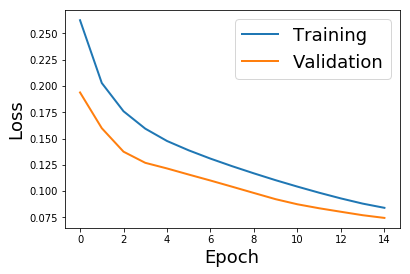

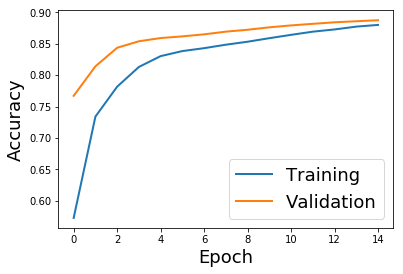

In [80]:
# Plot loss

plt.plot(model.history.history['loss'], label='Training', linewidth=2)
plt.plot(model.history.history['val_loss'], label='Validation', linewidth=2)
plt.legend(fontsize=18)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.show()


plt.plot(model.history.history['acc'], label='Training', linewidth=2)
plt.plot(model.history.history['val_acc'], label='Validation', linewidth=2)
plt.legend(fontsize=18)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Accuracy', fontsize=18)
plt.show()

In [81]:
# Predict and evaluate for test set
FACES_test_pred = model.predict(FACES_test)
test_err = model.evaluate(x=FACES_test, y=LABELS_test)
print(test_err)

465/465 [==============================] - 5s 10ms/step
[0.07637510544830753, 0.8836058253883033]


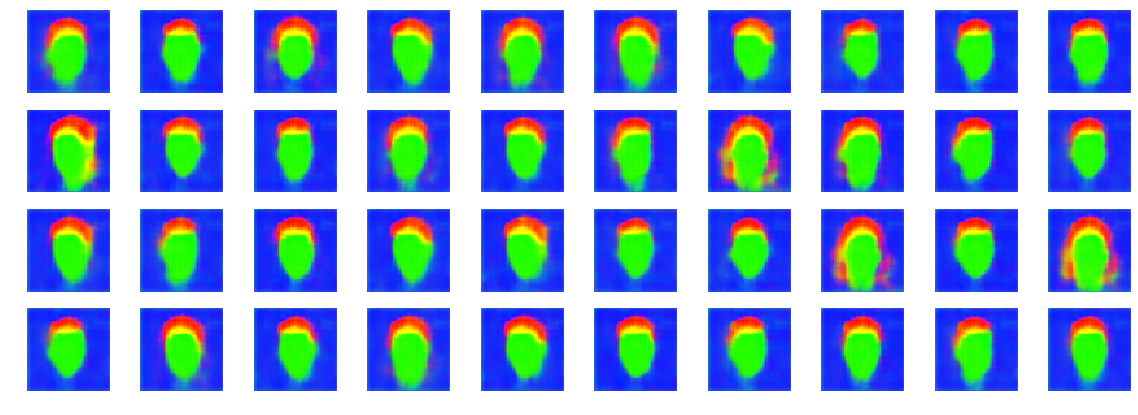

In [82]:
# Show a few examples
plt.figure(figsize=(20, 7))
for it_k in range(40):
    plt.subplot(4, 10, it_k+1)
    plt.imshow(FACES_test_pred[it_k])
    plt.axis('off')
plt.show()

In [95]:
# Create NN 2.2 - 3.3
i = Input(FACES_train.shape[1:])
h = BatchNormalization()(i)

h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)
h = MaxPooling2D((2, 2))(h)

h = MaxPooling2D((2, 2))(h)
h = Dropout(0.2)(h)

h = MaxPooling2D((2, 2))(h)

h = Flatten()(h)
latent = Dense(128, activation='relu')(h)
h = Dense(512, activation='relu')(latent)
h = Reshape((8, 8, 8))(h)

h = UpSampling2D((2, 2))(h)

h = Dropout(0.2)(h)
h = UpSampling2D((2, 2))(h)
h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)

h = UpSampling2D((2, 2))(h)
h = BatchNormalization()(h)
o = Conv2D(3, (3, 3), padding='same', activation='sigmoid')(h)

model = Model(inputs=i, outputs=o)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_43 (InputLayer)        (None, 64, 64, 3)         0         
_________________________________________________________________
batch_normalization_76 (Batc (None, 64, 64, 3)         12        
_________________________________________________________________
conv2d_233 (Conv2D)          (None, 64, 64, 8)         224       
_________________________________________________________________
max_pooling2d_101 (MaxPoolin (None, 32, 32, 8)         0         
_________________________________________________________________
max_pooling2d_102 (MaxPoolin (None, 16, 16, 8)         0         
_________________________________________________________________
dropout_43 (Dropout)         (None, 16, 16, 8)         0         
_________________________________________________________________
max_pooling2d_103 (MaxPoolin (None, 8, 8, 8)           0         
__________

In [96]:
# Optimization parameters
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

In [97]:
# Training
batchSize = 320
numEpochs = 15
model.fit(FACES_train, LABELS_train, batch_size=batchSize, epochs=numEpochs, verbose=1, validation_split=0.2, shuffle=True)

Train on 1485 samples, validate on 372 samples
Epoch 1/15
1485/1485 [==============================] - 44s 30ms/step - loss: 0.2574 - acc: 0.4630 - val_loss: 0.1941 - val_acc: 0.6688
Epoch 2/15
1485/1485 [==============================] - 33s 23ms/step - loss: 0.2029 - acc: 0.6374 - val_loss: 0.1530 - val_acc: 0.7938
Epoch 3/15
1485/1485 [==============================] - 34s 23ms/step - loss: 0.1797 - acc: 0.7134 - val_loss: 0.1339 - val_acc: 0.8276
Epoch 4/15
1485/1485 [==============================] - 35s 23ms/step - loss: 0.1653 - acc: 0.7520 - val_loss: 0.1236 - val_acc: 0.8434
Epoch 5/15
1485/1485 [==============================] - 36s 24ms/step - loss: 0.1547 - acc: 0.7780 - val_loss: 0.1193 - val_acc: 0.8508
Epoch 6/15
1485/1485 [==============================] - 34s 23ms/step - loss: 0.1467 - acc: 0.7967 - val_loss: 0.1197 - val_acc: 0.8523
Epoch 7/15
1485/1485 [==============================] - 37s 25ms/step - loss: 0.1398 - acc: 0.8131 - val_loss: 0.1218 - val_acc: 0.8529
E

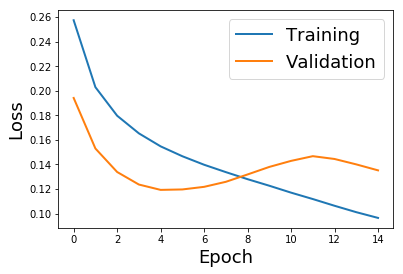

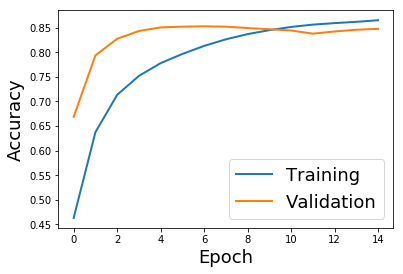

In [98]:
# Plot loss

plt.plot(model.history.history['loss'], label='Training', linewidth=2)
plt.plot(model.history.history['val_loss'], label='Validation', linewidth=2)
plt.legend(fontsize=18)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.show()


plt.plot(model.history.history['acc'], label='Training', linewidth=2)
plt.plot(model.history.history['val_acc'], label='Validation', linewidth=2)
plt.legend(fontsize=18)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Accuracy', fontsize=18)
plt.show()

In [99]:
# Predict and evaluate for test set
FACES_test_pred = model.predict(FACES_test)
test_err = model.evaluate(x=FACES_test, y=LABELS_test)
print(test_err)

465/465 [==============================] - 4s 8ms/step
[0.13541754910381892, 0.8443621881546512]


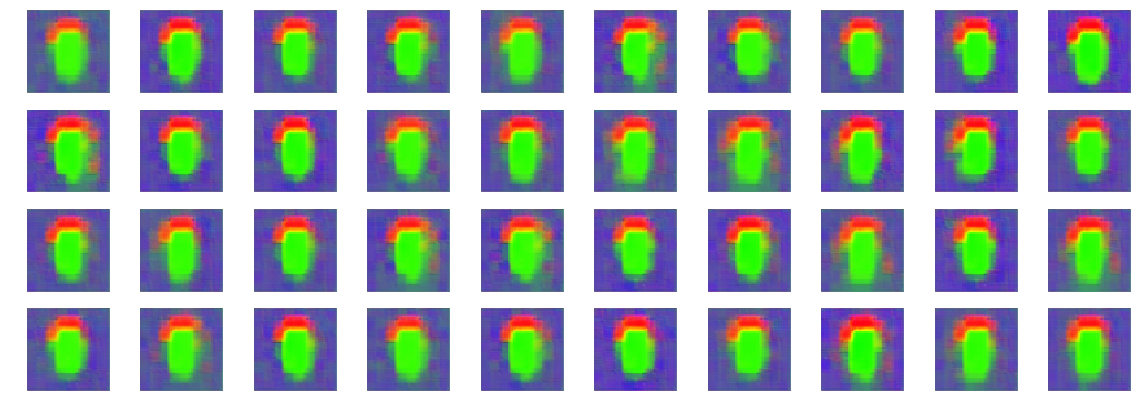

In [100]:
# Show a few examples
plt.figure(figsize=(20, 7))
for it_k in range(40):
    plt.subplot(4, 10, it_k+1)
    plt.imshow(FACES_test_pred[it_k])
    plt.axis('off')
plt.show()

In [ ]:
this 0.5

In [16]:
# Create NN 2.2 - 3.3
i = Input(FACES_train.shape[1:])
h = BatchNormalization()(i)

h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)
h = MaxPooling2D((2, 2))(h)
h = Dropout(0.2)(h)

h = MaxPooling2D((2, 2))(h)

h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)
h = MaxPooling2D((2, 2))(h)

h = Flatten()(h)
latent = Dense(128, activation='relu')(h)
h = Dense(512, activation='relu')(latent)
h = Reshape((8, 8, 8))(h)

h = UpSampling2D((2, 2))(h)
h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)

h = Dropout(0.2)(h)
h = UpSampling2D((2, 2))(h)
h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)

h = UpSampling2D((2, 2))(h)

h = BatchNormalization()(h)
o = Conv2D(3, (3, 3), padding='same', activation='sigmoid')(h)

model = Model(inputs=i, outputs=o)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 64, 64, 3)         12        
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 64, 64, 8)         224       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 32, 32, 8)         0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 32, 32, 8)         0         
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 16, 16, 8)         584       
__________

In [17]:
# Optimization parameters
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

In [18]:
# Training
batchSize = 320
numEpochs = 15
model.fit(FACES_train, LABELS_train, batch_size=batchSize, epochs=numEpochs, verbose=1, validation_split=0.2, shuffle=True)

Train on 1485 samples, validate on 372 samples
Epoch 1/15
1485/1485 [==============================] - 65s 44ms/step - loss: 0.2789 - acc: 0.4007 - val_loss: 0.2293 - val_acc: 0.5361
Epoch 2/15
1485/1485 [==============================] - 37s 25ms/step - loss: 0.2236 - acc: 0.5735 - val_loss: 0.1935 - val_acc: 0.6604
Epoch 3/15
1485/1485 [==============================] - 36s 25ms/step - loss: 0.1960 - acc: 0.6758 - val_loss: 0.1719 - val_acc: 0.7400
Epoch 4/15
1485/1485 [==============================] - 34s 23ms/step - loss: 0.1769 - acc: 0.7436 - val_loss: 0.1592 - val_acc: 0.8004
Epoch 5/15
1485/1485 [==============================] - 36s 24ms/step - loss: 0.1619 - acc: 0.7911 - val_loss: 0.1501 - val_acc: 0.8360
Epoch 6/15
1485/1485 [==============================] - 37s 25ms/step - loss: 0.1489 - acc: 0.8211 - val_loss: 0.1436 - val_acc: 0.8582
Epoch 7/15
1485/1485 [==============================] - 36s 24ms/step - loss: 0.1375 - acc: 0.8394 - val_loss: 0.1376 - val_acc: 0.8677
E

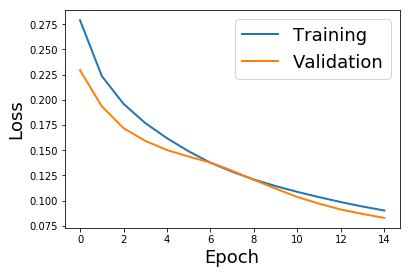

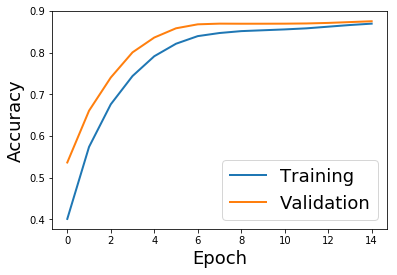

In [19]:
# Plot loss

plt.plot(model.history.history['loss'], label='Training', linewidth=2)
plt.plot(model.history.history['val_loss'], label='Validation', linewidth=2)
plt.legend(fontsize=18)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.show()


plt.plot(model.history.history['acc'], label='Training', linewidth=2)
plt.plot(model.history.history['val_acc'], label='Validation', linewidth=2)
plt.legend(fontsize=18)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Accuracy', fontsize=18)
plt.show()

In [20]:
# Predict and evaluate for test set
FACES_test_pred = model.predict(FACES_test)
test_err = model.evaluate(x=FACES_test, y=LABELS_test)
print(test_err)

465/465 [==============================] - 4s 9ms/step
[0.08491590306643516, 0.8697155366661729]


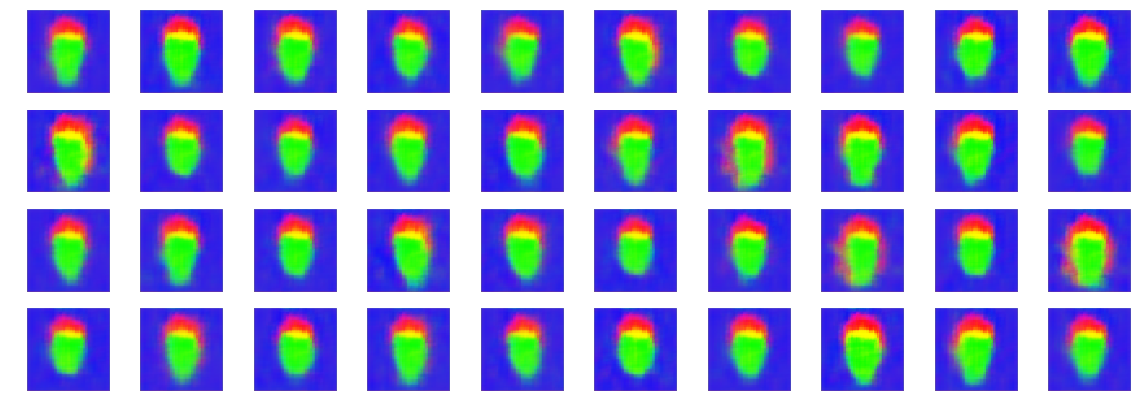

In [21]:
# Show a few examples
plt.figure(figsize=(20, 7))
for it_k in range(40):
    plt.subplot(4, 10, it_k+1)
    plt.imshow(FACES_test_pred[it_k])
    plt.axis('off')
plt.show()

In [22]:
# Create NN 2.2 - 3.3
i = Input(FACES_train.shape[1:])
h = BatchNormalization()(i)

h = Conv2D(8, (5, 5), padding='same', activation='elu')(h)
h = MaxPooling2D((2, 2))(h)

h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)
h = MaxPooling2D((2, 2))(h)
h = Dropout(0.2)(h)

h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)
h = MaxPooling2D((2, 2))(h)

h = Flatten()(h)
latent = Dense(128, activation='relu')(h)
h = Dense(512, activation='relu')(latent)
h = Reshape((8, 8, 8))(h)

h = UpSampling2D((2, 2))(h)
h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)

h = Dropout(0.2)(h)
h = UpSampling2D((2, 2))(h)
h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)

h = UpSampling2D((2, 2))(h)
h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)

h = BatchNormalization()(h)
o = Conv2D(3, (5, 5), padding='same', activation='sigmoid')(h)

model = Model(inputs=i, outputs=o)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 64, 64, 3)         12        
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 64, 64, 8)         608       
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 32, 32, 8)         584       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 16, 16, 8)         0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 16, 16, 8)         0         
__________

In [23]:
# Optimization parameters
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

In [24]:
# Training
batchSize = 320
numEpochs = 15
model.fit(FACES_train, LABELS_train, batch_size=batchSize, epochs=numEpochs, verbose=1, validation_split=0.2, shuffle=True)

Train on 1485 samples, validate on 372 samples
Epoch 1/15
1485/1485 [==============================] - 79s 53ms/step - loss: 0.2707 - acc: 0.3674 - val_loss: 0.2370 - val_acc: 0.4655
Epoch 2/15
1485/1485 [==============================] - 56s 38ms/step - loss: 0.2172 - acc: 0.5807 - val_loss: 0.1867 - val_acc: 0.7213
Epoch 3/15
1485/1485 [==============================] - 54s 36ms/step - loss: 0.1731 - acc: 0.7560 - val_loss: 0.1456 - val_acc: 0.8172
Epoch 4/15
1485/1485 [==============================] - 54s 36ms/step - loss: 0.1497 - acc: 0.8154 - val_loss: 0.1236 - val_acc: 0.8497
Epoch 5/15
1485/1485 [==============================] - 53s 36ms/step - loss: 0.1346 - acc: 0.8409 - val_loss: 0.1215 - val_acc: 0.8561
Epoch 6/15
1485/1485 [==============================] - 53s 36ms/step - loss: 0.1234 - acc: 0.8461 - val_loss: 0.1248 - val_acc: 0.8506
Epoch 7/15
1485/1485 [==============================] - 60s 41ms/step - loss: 0.1139 - acc: 0.8461 - val_loss: 0.1178 - val_acc: 0.8544
E

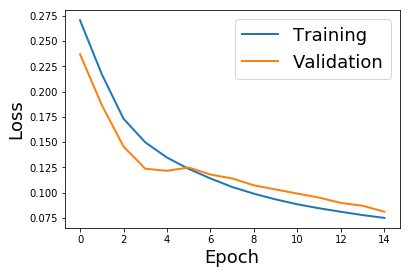

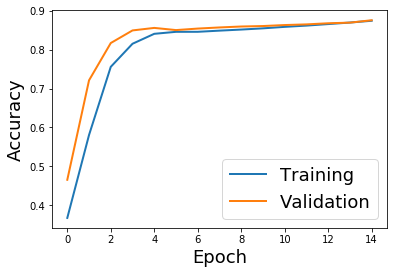

In [25]:
# Plot loss

plt.plot(model.history.history['loss'], label='Training', linewidth=2)
plt.plot(model.history.history['val_loss'], label='Validation', linewidth=2)
plt.legend(fontsize=18)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.show()


plt.plot(model.history.history['acc'], label='Training', linewidth=2)
plt.plot(model.history.history['val_acc'], label='Validation', linewidth=2)
plt.legend(fontsize=18)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Accuracy', fontsize=18)
plt.show()

In [26]:
# Predict and evaluate for test set
FACES_test_pred = model.predict(FACES_test)
test_err = model.evaluate(x=FACES_test, y=LABELS_test)
print(test_err)

465/465 [==============================] - 7s 16ms/step
[0.08239266175416209, 0.8724562125821267]


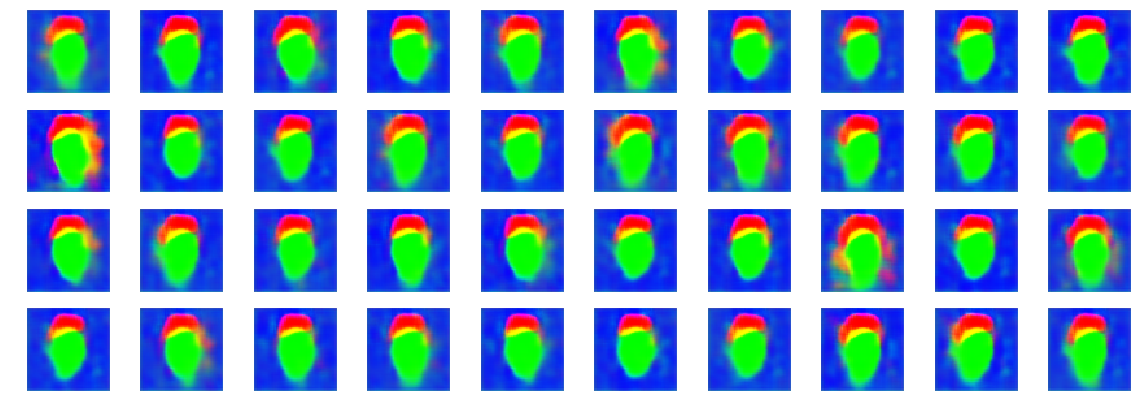

In [27]:
# Show a few examples
plt.figure(figsize=(20, 7))
for it_k in range(40):
    plt.subplot(4, 10, it_k+1)
    plt.imshow(FACES_test_pred[it_k])
    plt.axis('off')
plt.show()

In [ ]:
THISSSSSSS

In [28]:
# Create NN 2.2 - 3.3
i = Input(FACES_train.shape[1:])
h = BatchNormalization()(i)

h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)
h = MaxPooling2D((2, 2))(h)
h = Dropout(0.2)(h)

h = MaxPooling2D((2, 2))(h)

h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)
h = MaxPooling2D((2, 2))(h)

h = Flatten()(h)
latent = Dense(128, activation='relu')(h)
h = Dense(512, activation='relu')(latent)
h = Reshape((8, 8, 8))(h)

h = UpSampling2D((2, 2))(h)
h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)

h = Dropout(0.2)(h)
h = UpSampling2D((2, 2))(h)
h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)

h = UpSampling2D((2, 2))(h)

h = BatchNormalization()(h)
o = Conv2D(3, (3, 3), padding='same', activation='sigmoid')(h)

model = Model(inputs=i, outputs=o)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 64, 64, 3)         12        
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 64, 64, 8)         224       
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 32, 32, 8)         0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 32, 32, 8)         0         
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 16, 16, 8)         584       
__________

In [29]:
# Optimization parameters
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

In [32]:
# Training
batchSize = 420
numEpochs = 15
model.fit(FACES_train, LABELS_train, batch_size=batchSize, epochs=numEpochs, verbose=1, validation_split=0.2, shuffle=True)

Train on 1485 samples, validate on 372 samples
Epoch 1/15
1485/1485 [==============================] - 39s 26ms/step - loss: 0.2676 - acc: 0.4711 - val_loss: 0.2149 - val_acc: 0.6267
Epoch 2/15
1485/1485 [==============================] - 37s 25ms/step - loss: 0.2133 - acc: 0.6664 - val_loss: 0.1826 - val_acc: 0.7418
Epoch 3/15
1485/1485 [==============================] - 36s 24ms/step - loss: 0.1869 - acc: 0.7518 - val_loss: 0.1653 - val_acc: 0.7925
Epoch 4/15
1485/1485 [==============================] - 43s 29ms/step - loss: 0.1706 - acc: 0.7919 - val_loss: 0.1532 - val_acc: 0.8160
Epoch 5/15
1485/1485 [==============================] - 45s 30ms/step - loss: 0.1593 - acc: 0.8143 - val_loss: 0.1425 - val_acc: 0.8325
Epoch 6/15
1485/1485 [==============================] - 42s 29ms/step - loss: 0.1501 - acc: 0.8296 - val_loss: 0.1343 - val_acc: 0.8487
Epoch 7/15
1485/1485 [==============================] - 42s 28ms/step - loss: 0.1426 - acc: 0.8417 - val_loss: 0.1295 - val_acc: 0.8578
E

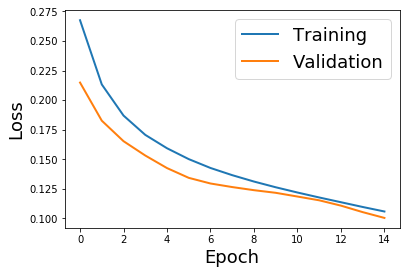

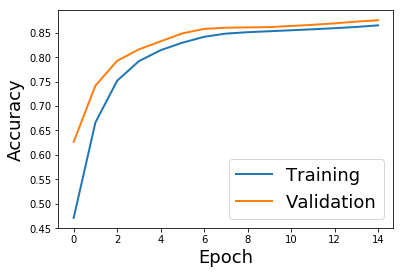

In [33]:
# Plot loss

plt.plot(model.history.history['loss'], label='Training', linewidth=2)
plt.plot(model.history.history['val_loss'], label='Validation', linewidth=2)
plt.legend(fontsize=18)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.show()


plt.plot(model.history.history['acc'], label='Training', linewidth=2)
plt.plot(model.history.history['val_acc'], label='Validation', linewidth=2)
plt.legend(fontsize=18)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Accuracy', fontsize=18)
plt.show()

In [34]:
# Predict and evaluate for test set
FACES_test_pred = model.predict(FACES_test)
test_err = model.evaluate(x=FACES_test, y=LABELS_test)
print(test_err)

465/465 [==============================] - 4s 9ms/step
[0.10158760111819032, 0.8704033318386283]


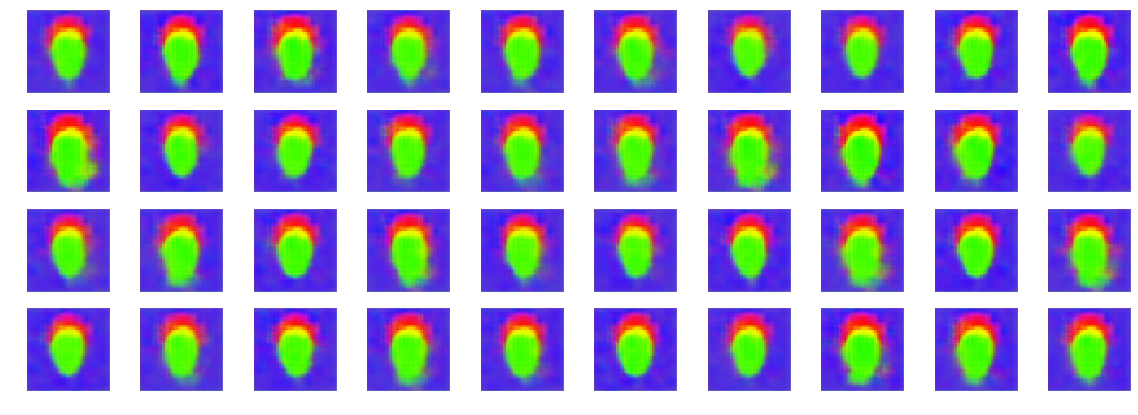

In [35]:
# Show a few examples
plt.figure(figsize=(20, 7))
for it_k in range(40):
    plt.subplot(4, 10, it_k+1)
    plt.imshow(FACES_test_pred[it_k])
    plt.axis('off')
plt.show()

In [ ]:
NOPE

In [57]:
# Create NN 2.2 - 3.3
i = Input(FACES_train.shape[1:])
h = BatchNormalization()(i)

h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)
h = MaxPooling2D((2, 2))(h)

h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)
h = MaxPooling2D((2, 2))(h)

#h = Flatten()(h)
#latent = Dense(128, activation='relu')(h)
#h = Dense(512, activation='relu')(latent)
#h = Reshape((8, 8, 8))(h)

#h = UpSampling2D((2, 2))(h)
h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)

h = UpSampling2D((2, 2))(h)
h = Conv2D(8, (3, 3), padding='same', activation='elu')(h)

h = UpSampling2D((2, 2))(h)
o = Conv2D(3, (3, 3), padding='same', activation='sigmoid')(h)

model = Model(inputs=i, outputs=o)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        (None, 64, 64, 3)         0         
_________________________________________________________________
batch_normalization_29 (Batc (None, 64, 64, 3)         12        
_________________________________________________________________
conv2d_94 (Conv2D)           (None, 64, 64, 8)         224       
_________________________________________________________________
max_pooling2d_48 (MaxPooling (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_95 (Conv2D)           (None, 32, 32, 8)         584       
_________________________________________________________________
max_pooling2d_49 (MaxPooling (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_96 (Conv2D)           (None, 16, 16, 8)         584       
__________

In [58]:
# Optimization parameters
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

In [59]:
# Training
batchSize = 320
numEpochs = 20
model.fit(FACES_train, LABELS_train, batch_size=batchSize, epochs=numEpochs, verbose=1, validation_split=0.2, shuffle=True)

Train on 1485 samples, validate on 372 samples
Epoch 1/20
1485/1485 [==============================] - 25s 17ms/step - loss: 0.2390 - acc: 0.3733 - val_loss: 0.2242 - val_acc: 0.5363
Epoch 2/20
1485/1485 [==============================] - 23s 15ms/step - loss: 0.2144 - acc: 0.5732 - val_loss: 0.2001 - val_acc: 0.6043
Epoch 3/20
1485/1485 [==============================] - 22s 15ms/step - loss: 0.1923 - acc: 0.6121 - val_loss: 0.1816 - val_acc: 0.6242
Epoch 4/20
1485/1485 [==============================] - 22s 15ms/step - loss: 0.1763 - acc: 0.6319 - val_loss: 0.1636 - val_acc: 0.6629
Epoch 5/20
1485/1485 [==============================] - 22s 15ms/step - loss: 0.1623 - acc: 0.6666 - val_loss: 0.1520 - val_acc: 0.6854
Epoch 6/20
1485/1485 [==============================] - 22s 15ms/step - loss: 0.1554 - acc: 0.6715 - val_loss: 0.1463 - val_acc: 0.6998
Epoch 7/20
1485/1485 [==============================] - 23s 15ms/step - loss: 0.1492 - acc: 0.6954 - val_loss: 0.1397 - val_acc: 0.7267
E

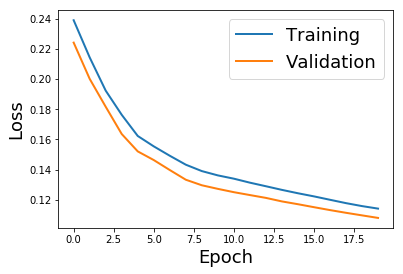

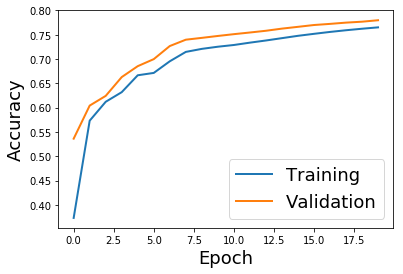

In [60]:
# Plot loss

plt.plot(model.history.history['loss'], label='Training', linewidth=2)
plt.plot(model.history.history['val_loss'], label='Validation', linewidth=2)
plt.legend(fontsize=18)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.show()


plt.plot(model.history.history['acc'], label='Training', linewidth=2)
plt.plot(model.history.history['val_acc'], label='Validation', linewidth=2)
plt.legend(fontsize=18)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Accuracy', fontsize=18)
plt.show()

In [61]:
# Predict and evaluate for test set
FACES_test_pred = model.predict(FACES_test)
test_err = model.evaluate(x=FACES_test, y=LABELS_test)
print(test_err)

465/465 [==============================] - 3s 7ms/step
[0.11183462589979172, 0.7711089758462804]


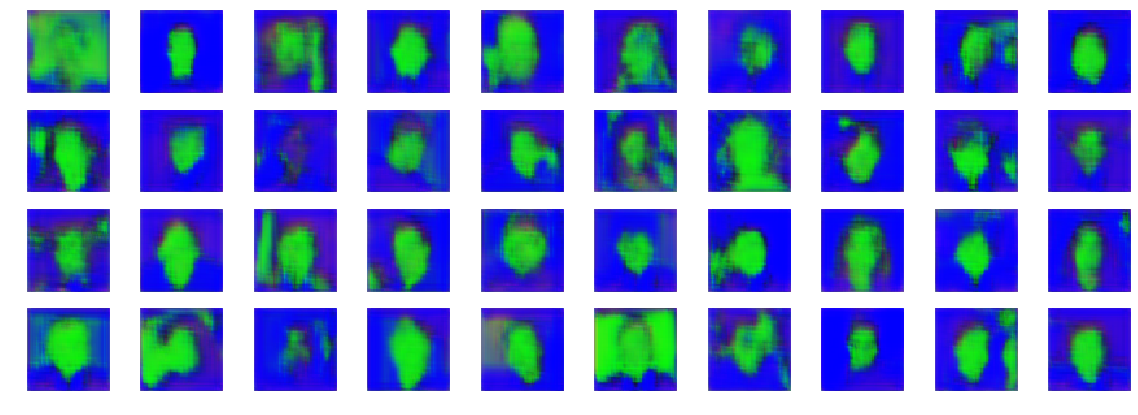

In [62]:
# Show a few examples
plt.figure(figsize=(20, 7))
for it_k in range(40):
    plt.subplot(4, 10, it_k+1)
    plt.imshow(FACES_test_pred[it_k])
    plt.axis('off')
plt.show()